In [1]:
from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.notebook.plotting import init_notebook_plotting, render
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
import numpy as np
import pandas as pd
from train import main
from types import SimpleNamespace
import os

In [2]:
parameters=[{"name": "lr_D", "type": "range", "bounds": [1e-7,1e-3]},
            {"name": "lr_G", "type": "range", "bounds": [1e-7,1e-3]},
            {"name": "D_per_G_steps", "type": "range", "bounds": [1,4], "value_type": "int"},
            {"name": "normalizer", "type": "choice", "values": ["standard", "minmax"]},
            #{"name": "normalizer", "type": "fixed", "value": "minmax"},
            {"name": "batch_size", "type": "choice", "values": [4,8,16,32,64,128,256,512]},
            {"name": "hidden_dims", "type": "choice", "values": [50,70,100]}]

objectives={"r2_ratio": ObjectiveProperties(minimize=False),
            "abs": ObjectiveProperties(minimize=True),
            "acf": ObjectiveProperties(minimize=True),
            "cross_correl": ObjectiveProperties(minimize=True),
            "value_range": ObjectiveProperties(minimize=True)}

objectives_combined = { "combined" : ObjectiveProperties(minimize=True) }

def train_evaluate(p, trial_id, algo, dataset, total_steps=1000, initial_seed=111, combined=False, value_range_divider=1):
    args = SimpleNamespace(**p, 
                           use_cuda=False, 
                           base_dir='./numerical_results',
                           num_seeds=1,
                           p=3, q=3,
                           datasets=[dataset],
                           algos=[algo],
                           initial_seed=initial_seed,
                           total_steps=total_steps,
                           optim=True,
                           trial_id=trial_id,
                           )
    args.hidden_dims = 3*(args.hidden_dims,)
    args.skip_plots = False

    res = main(args)
    print(res)
    
    if combined:
        return {"combined" : 
                #np.abs(res["r2_tstr"]/res["r2_trtr"]) +
                res["predictive_score"] +
                res["abs_metric"] + 
                res["acf_id_lag=1"] +
                res["cross_correl"] + 
                np.abs(1-res["value_range"])/value_range_divider}
        
    return {"r2_ratio": res["r2_tstr"]/res["r2_trtr"],
                #"predictive_score": res["predictive_score"],
                "abs": res["abs_metric"],
                "acf": res["acf_id_lag=1"],
                "cross_correl": res["cross_correl"],
                "value_range": np.abs(1-res["value_range"])
                #"kurtosis": res["kurtosis"],
                #"skew": res["skew"]}
                #"sigW1": res["sig_w1_metric"]}
        }

In [3]:
def optimize(algo, dataset, iterations=50, total_steps=1000, initial_seed=111, prefix="t", 
             parameters=parameters,
             combined=False, value_range_divider=1):
    name = f"tune_{algo}_{dataset}_mi{iterations}_ts{total_steps}_s{initial_seed}"
    ax_client = AxClient()
    ax_client.create_experiment(
        name=name, parameters=parameters, 
        objectives=objectives_combined if combined else objectives
    )
    raw_datas = []
    for i in range(iterations):
        parameters, trial_index = ax_client.get_next_trial()
        raw_data=train_evaluate(parameters, f"{prefix}{trial_index}", algo, dataset, total_steps, initial_seed, combined, 
                                value_range_divider=value_range_divider)
        raw_datas.append(raw_data)
        ax_client.complete_trial(trial_index=trial_index, raw_data=raw_data)
    
        if (i+1) % 5 == 0 or i == iterations-1:
            if combined:
                optim_params = ax_client.get_best_trial(use_model_predictions=False)
            else:
                optim_params = ax_client.get_pareto_optimal_parameters(use_model_predictions=False)
            print(optim_params)
            with open(os.path.join("optim", f'best_{name}_{prefix}.txt'), 'a') as f:
                f.write(f"i:{i} {optim_params}\n")
            ax_client.save_to_json_file(f"optim/{name}_{prefix}.json")
    return ax_client, raw_datas

In [4]:
def optimize_all_datasets(algo, prefix):
    d = {}
    for dataset in ["OMX", "FMI", "THL", "ELEC", "HSL"]:
        print("\n------------------------")
        print("OPTIMIZING DATASET", dataset)
        print("------------------------\n")
        client, raw = optimize(algo, dataset, combined=True, total_steps=2000, value_range_divider=100, prefix=prefix)
        d[dataset] = (client, raw)
    return d

In [6]:
def optimize_datasets(algo, datasets, prefix):
    d = {}
    for dataset in datasets:
        print("\n------------------------")
        print("OPTIMIZING DATASET", dataset)
        print("------------------------\n")
        client, raw = optimize(algo, dataset, combined=True, total_steps=2000, value_range_divider=100, prefix=prefix)
        d[dataset] = (client, raw)
    return d

In [9]:
optimize_datasets("RCWGAN", ["OMX", "FMI", "THL", "ELEC"], prefix="x")

[INFO 05-28 14:37:21] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 14:37:21] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 14:37:21] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 14:37:21] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 14:37:21


------------------------
OPTIMIZING DATASET OMX
------------------------

Start of training. CUDA: False
Executing: RCWGAN, OMX, x0
minmax


100%|███████████████████████████████████████| 2000/2000 [01:32<00:00, 21.67it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 14:39:15] ax.service.ax_client: Completed trial 0 with data: {'combined': (1.5984, None)}.
[INFO 05-28 14:39:15] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 3e-05, 'lr_G': 0.000763, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7796841702802058, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.07416787472533826, 'abs_metric': 0.8070669174194336, 'acf_id_lag=1': 0.019399147480726242, 'kurtosis': 6.848509311676025, 'skew': 0.7660971879959106, 'cross_correl': 0.6977658867835999, 'sig_w1_metric': 0.030823780223727226, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x1
minmax


100%|███████████████████████████████████████| 2000/2000 [01:54<00:00, 17.43it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 14:41:32] ax.service.ax_client: Completed trial 1 with data: {'combined': (1.98409, None)}.
[INFO 05-28 14:41:32] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000985, 'lr_G': 0.000682, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.5810542133434019, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.2727978316621421, 'abs_metric': 0.9899705052375793, 'acf_id_lag=1': 0.23904629051685333, 'kurtosis': 5.499203681945801, 'skew': 0.842237114906311, 'cross_correl': 0.48227572441101074, 'sig_w1_metric': 0.030577169731259346, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x2


100%|███████████████████████████████████████| 2000/2000 [00:29<00:00, 67.82it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 14:42:21] ax.service.ax_client: Completed trial 2 with data: {'combined': (6120044.68737, None)}.
[INFO 05-28 14:42:21] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 1.6e-05, 'lr_G': 0.000417, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7867819829721636, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.0670700660296053, 'abs_metric': 0.09782950580120087, 'acf_id_lag=1': 0.020483117550611496, 'kurtosis': 5.730282783508301, 'skew': 0.5530759692192078, 'cross_correl': 1.6319878101348877, 'sig_w1_metric': 0.35426396131515503, 'value_range': 612004300.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [01:16<00:00, 26.21it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 14:43:55] ax.service.ax_client: Completed trial 3 with data: {'combined': (200000005.570446, None)}.
[INFO 05-28 14:43:55] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000138, 'lr_G': 0.000726, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.35744618078819335, 'r2_trtr': 0.853852045005544, 'predictive_score': 1.2112982257937372, 'abs_metric': 1.2715892791748047, 'acf_id_lag=1': 0.10799622535705566, 'kurtosis': 7.476059913635254, 'skew': 0.907364547252655, 'cross_correl': 2.9895620346069336, 'sig_w1_metric': 0.03209203481674194, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x4
minmax


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.06it/s]


[0. 0. 0. 0. 0.] [1.1237139 1.1583484 1.1626769 1.1767164 1.       ]


[INFO 05-28 14:45:05] ax.service.ax_client: Completed trial 4 with data: {'combined': (2.158559, None)}.
[INFO 05-28 14:45:05] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_OMX_mi50_ts2000_s111_x.json`.
[INFO 05-28 14:45:05] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000816, 'lr_G': 0.00034, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7742680596261756, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.0795839853793684, 'abs_metric': 0.9393851161003113, 'acf_id_lag=1': 0.0032516182400286198, 'kurtosis': 5.935379981994629, 'skew': 0.6543138027191162, 'cross_correl': 1.134570837020874, 'sig_w1_metric': 0.022501233965158463, 'value_range': 1.1767164}
(0, {'lr_D': 0.00012597872382551432, 'lr_G': 0.0006773597809433936, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 1.598399826409098}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, OMX, x5


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 59.45it/s]


[-8.7770911e+24 -1.0006148e+25 -9.7611131e+24 -9.6401462e+24
 -5.1919730e+23] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 14:46:02] ax.service.ax_client: Completed trial 5 with data: {'combined': (3.0619029912010107e+21, None)}.
[INFO 05-28 14:46:02] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000649, 'lr_G': 0.000922, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8296020774158025, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.024249971585966423, 'abs_metric': 0.05978550761938095, 'acf_id_lag=1': 0.015742426738142967, 'kurtosis': 2.973637342453003, 'skew': 0.33099591732025146, 'cross_correl': 0.5441973209381104, 'sig_w1_metric': 0.1824127733707428, 'value_range': 3.061903e+23}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.49it/s]


[       0.        0.        0.        0. -1924416.] [3.5878292e+09 3.7071667e+09 3.7889024e+09 3.5927634e+09 1.0000000e+00]


[INFO 05-28 14:47:14] ax.service.ax_client: Completed trial 6 with data: {'combined': (37908269.536454, None)}.
[INFO 05-28 14:47:14] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000379, 'lr_G': 0.000242, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7773604103979176, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.07649163460762642, 'abs_metric': 0.7514652013778687, 'acf_id_lag=1': 0.10272111743688583, 'kurtosis': 7.314463138580322, 'skew': 0.9070871472358704, 'cross_correl': 1.0957759618759155, 'sig_w1_metric': 0.01990821585059166, 'value_range': 3790826800.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x7


100%|███████████████████████████████████████| 2000/2000 [01:02<00:00, 32.18it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.7222061] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 14:48:35] ax.service.ax_client: Completed trial 7 with data: {'combined': (0.325832, None)}.
[INFO 05-28 14:48:35] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.00016, 'lr_G': 0.000732, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8334104348140698, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.020441614187699075, 'abs_metric': 0.046301744878292084, 'acf_id_lag=1': 0.0009274125332012773, 'kurtosis': 1.3853826522827148, 'skew': 0.11635981500148773, 'cross_correl': 0.25816118717193604, 'sig_w1_metric': 0.1511598378419876, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x8


100%|███████████████████████████████████████| 2000/2000 [00:59<00:00, 33.42it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 14:49:53] ax.service.ax_client: Completed trial 8 with data: {'combined': (2.495006, None)}.
[INFO 05-28 14:49:53] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000524, 'lr_G': 0.000489, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.6973785240922725, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.1564735249094964, 'abs_metric': 0.07691053301095963, 'acf_id_lag=1': 0.020004481077194214, 'kurtosis': 4.479666233062744, 'skew': 0.4994434714317322, 'cross_correl': 2.241617202758789, 'sig_w1_metric': 0.3568432629108429, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 52.35it/s]


[ 0.          0.          0.          0.         -0.08233063] [5.656179  5.8767004 6.0120635 5.757691  1.       ]


[INFO 05-28 14:50:47] ax.service.ax_client: Completed trial 9 with data: {'combined': (1.044318, None)}.
[INFO 05-28 14:50:47] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_OMX_mi50_ts2000_s111_x.json`.
[INFO 05-28 14:50:47] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000493, 'lr_G': 0.000346, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8096776342004149, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.04417441080512907, 'abs_metric': 0.43082132935523987, 'acf_id_lag=1': 0.049713134765625, 'kurtosis': 7.134648323059082, 'skew': 0.8866816759109497, 'cross_correl': 0.4686654210090637, 'sig_w1_metric': 0.01572602242231369, 'value_range': 6.094394}
(7, {'lr_D': 0.00037916988860107955, 'lr_G': 0.00024175714407963678, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.32583195877112847}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, OMX, x10


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 30.90it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.8482702] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 14:52:11] ax.service.ax_client: Completed trial 10 with data: {'combined': (0.524059, None)}.
[INFO 05-28 14:52:11] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000367, 'lr_G': 7e-06, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8288453867579044, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.025006662243864497, 'abs_metric': 0.07061589509248734, 'acf_id_lag=1': 0.015870988368988037, 'kurtosis': 3.870391845703125, 'skew': 0.29600074887275696, 'cross_correl': 0.41256558895111084, 'sig_w1_metric': 0.1919361799955368, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x11
minmax


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 52.09it/s]


[ 0.          0.          0.          0.         -0.14870185] [1. 1. 1. 1. 1.]


[INFO 05-28 14:53:08] ax.service.ax_client: Completed trial 11 with data: {'combined': (4.986303, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.4095685856505993, 'r2_trtr': 0.853852045005544, 'predictive_score': 1.2634206306561433, 'abs_metric': 1.29843008518219, 'acf_id_lag=1': 0.36417287588119507, 'kurtosis': 7.485553741455078, 'skew': 0.9796072840690613, 'cross_correl': 2.0587925910949707, 'sig_w1_metric': 0.11855774372816086, 'value_range': 1.1487019}


[INFO 05-28 14:53:11] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000213, 'lr_G': 0.000526, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x12


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 30.82it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -6.6149416] [ 5.235487   5.2450776  5.101843   5.0626025 30.61351  ]


[INFO 05-28 14:54:35] ax.service.ax_client: Completed trial 12 with data: {'combined': (0.506463, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8168358467403374, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03701620226143154, 'abs_metric': 0.05590958520770073, 'acf_id_lag=1': 0.017877239733934402, 'kurtosis': 4.530518531799316, 'skew': 0.36730843782424927, 'cross_correl': 0.3942676782608032, 'sig_w1_metric': 0.18674185872077942, 'value_range': 1.1391987}


[INFO 05-28 14:54:36] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000334, 'lr_G': 0.00044, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x13
minmax


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 44.42it/s]


[-0.03477313 -0.08203658 -0.04294504 -0.06323577 -0.06151726] [1. 1. 1. 1. 1.]


[INFO 05-28 14:55:38] ax.service.ax_client: Completed trial 13 with data: {'combined': (1.511859, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8024357482613592, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.0514162967441848, 'abs_metric': 0.6522824764251709, 'acf_id_lag=1': 0.060012657195329666, 'kurtosis': 7.312774658203125, 'skew': 0.8357124328613281, 'cross_correl': 0.7473268508911133, 'sig_w1_metric': 0.015877196565270424, 'value_range': 1.0820366}


[INFO 05-28 14:55:40] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 5.1e-05, 'lr_G': 0.000303, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x14


100%|███████████████████████████████████████| 2000/2000 [01:24<00:00, 23.58it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -2.832482 ] [ 3.8622248  3.603741   3.6113372  3.273388  30.61351  ]


[INFO 05-28 14:57:24] ax.service.ax_client: Completed trial 14 with data: {'combined': (0.542781, None)}.
[INFO 05-28 14:57:25] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7961530564570954, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.05769899254467348, 'abs_metric': 0.07902436703443527, 'acf_id_lag=1': 0.011586815118789673, 'kurtosis': 4.600712776184082, 'skew': 0.3560083508491516, 'cross_correl': 0.39423668384552, 'sig_w1_metric': 0.3038041293621063, 'value_range': 1.0234545}
(7, {'lr_D': 0.00037916988860107955, 'lr_G': 0.00024175714407963678, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.32583195877112847}, {'combined': {'combined': nan}}))


[INFO 05-28 14:57:27] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000513, 'lr_G': 0.00018, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x15
minmax


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.17it/s]


[-0.40640703 -0.3267201  -0.26048648 -0.36069232 -1.9199187 ] [21.067234 20.31328  21.26994  19.695751  8.840272]


[INFO 05-28 14:58:34] ax.service.ax_client: Completed trial 15 with data: {'combined': (1.352707, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.6623962195735954, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.1914558254319486, 'abs_metric': 0.7612529993057251, 'acf_id_lag=1': 0.019341712817549706, 'kurtosis': 6.876913547515869, 'skew': 0.7083244323730469, 'cross_correl': 0.15875791013240814, 'sig_w1_metric': 0.027869584038853645, 'value_range': 23.189857}


[INFO 05-28 14:58:36] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.0, 'lr_G': 0.000138, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x16


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 38.64it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 14:59:47] ax.service.ax_client: Completed trial 16 with data: {'combined': (55751499751.632545, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -55745379696.84757, 'r2_trtr': 0.8538520490017689, 'predictive_score': 55745379697.70142, 'abs_metric': 0.26467663049697876, 'acf_id_lag=1': 1.0959303379058838, 'kurtosis': nan, 'skew': nan, 'cross_correl': 9.700506210327148, 'sig_w1_metric': inf, 'value_range': 612004300.0}


[INFO 05-28 14:59:48] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000188, 'lr_G': 0.000452, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x17


100%|███████████████████████████████████████| 2000/2000 [01:33<00:00, 21.39it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 15:01:40] ax.service.ax_client: Completed trial 17 with data: {'combined': (0.891825, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8297236364407944, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.024128412560974533, 'abs_metric': 0.04827824980020523, 'acf_id_lag=1': 0.021445417776703835, 'kurtosis': 0.9006567001342773, 'skew': 0.20936378836631775, 'cross_correl': 0.797972559928894, 'sig_w1_metric': 0.17178276181221008, 'value_range': 1.0}


[INFO 05-28 15:01:42] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.0003, 'lr_G': 0.000499, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x18


100%|███████████████████████████████████████| 2000/2000 [01:26<00:00, 23.01it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 15:03:28] ax.service.ax_client: Completed trial 18 with data: {'combined': (1.051418, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.802094060558171, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.05175798844359791, 'abs_metric': 0.06322292983531952, 'acf_id_lag=1': 0.029879074543714523, 'kurtosis': 1.9089958667755127, 'skew': 0.14643177390098572, 'cross_correl': 0.9065578579902649, 'sig_w1_metric': 0.2205411195755005, 'value_range': 1.0}


[INFO 05-28 15:03:29] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000419, 'lr_G': 0.000228, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x19
minmax


100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 72.25it/s]


[-0.0183723  -0.03100013  0.         -0.01266161 -0.02737597] [1. 1. 1. 1. 1.]


[INFO 05-28 15:04:16] ax.service.ax_client: Completed trial 19 with data: {'combined': (1.793843, None)}.
[INFO 05-28 15:04:16] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.751658232362238, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.10219381264330596, 'abs_metric': 0.7354573011398315, 'acf_id_lag=1': 0.10663839429616928, 'kurtosis': 7.198641300201416, 'skew': 0.8084112405776978, 'cross_correl': 0.8492431640625, 'sig_w1_metric': 0.022331103682518005, 'value_range': 1.0310001}
(7, {'lr_D': 0.00037916988860107955, 'lr_G': 0.00024175714407963678, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.32583195877112847}, {'combined': {'combined': nan}}))


[INFO 05-28 15:04:18] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000267, 'lr_G': 0.00041, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x20


100%|███████████████████████████████████████| 2000/2000 [01:05<00:00, 30.52it/s]


[-2.0530047e+00 -2.0536065e+00 -2.0659995e+00 -2.0655260e+00
 -5.1380929e+34] [2.0187491e+36 1.6426416e+36 1.7365438e+36 1.9322909e+36 3.0613510e+01]


[INFO 05-28 15:05:42] ax.service.ax_client: Completed trial 20 with data: {'combined': (6.334642672810575e+32, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8013141321490125, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.05253791685275644, 'abs_metric': 0.0611390694975853, 'acf_id_lag=1': 0.02269238792359829, 'kurtosis': 4.321110725402832, 'skew': 0.4285429120063782, 'cross_correl': 0.4561781585216522, 'sig_w1_metric': 0.196968212723732, 'value_range': 6.3346427e+34}


[INFO 05-28 15:05:44] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000315, 'lr_G': 0.000294, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x21


100%|███████████████████████████████████████| 2000/2000 [01:56<00:00, 17.19it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.9256282] [3.5265863e+13 3.5751228e+13 3.4902033e+13 3.5127111e+13 6.7576193e+12]


[INFO 05-28 15:08:02] ax.service.ax_client: Completed trial 21 with data: {'combined': (10939952660.602467, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8375441535250834, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.01630789547668554, 'abs_metric': 0.04714687913656235, 'acf_id_lag=1': 0.011377436108887196, 'kurtosis': 0.3790397047996521, 'skew': 0.23726029694080353, 'cross_correl': 0.0576355904340744, 'sig_w1_metric': 0.14931081235408783, 'value_range': 1093995270000.0}


[INFO 05-28 15:08:04] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.0, 'lr_G': 0.000654, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x22


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 30.98it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:09:26] ax.service.ax_client: Completed trial 22 with data: {'combined': (nan, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -3.4346749086942452e+16, 'r2_trtr': 0.8538520490017689, 'predictive_score': 3.4346749086942452e+16, 'abs_metric': 0.26467663049697876, 'acf_id_lag=1': nan, 'kurtosis': nan, 'skew': nan, 'cross_correl': 9.700506210327148, 'sig_w1_metric': inf, 'value_range': 612004300.0}


InputDataError: Input data contains NaN values.

In [10]:
optimize_datasets("RCWGAN", ["FMI", "THL", "ELEC"], prefix="x")

[INFO 05-28 15:18:22] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 15:18:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 15:18:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 15:18:22] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 15:18:22


------------------------
OPTIMIZING DATASET FMI
------------------------

Start of training. CUDA: False
Executing: RCWGAN, FMI, x0


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 50.24it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:19:44] ax.service.ax_client: Completed trial 0 with data: {'combined': (6128293.916952, None)}.
[INFO 05-28 15:19:44] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000825, 'lr_G': 0.000189, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7702794323309397, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.11623918196348193, 'abs_metric': 0.0775146633386612, 'acf_id_lag=1': 0.09052474796772003, 'kurtosis': 5.945762634277344, 'skew': 0.7475336194038391, 'cross_correl': 5.002673625946045, 'sig_w1_metric': 0.6473315358161926, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: RCWGAN, FMI, x1


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 45.57it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:21:08] ax.service.ax_client: Completed trial 1 with data: {'combined': (6128291.252425, None)}.
[INFO 05-28 15:21:08] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.0005, 'lr_G': 0.000843, 'D_per_G_steps': 1, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8158188129788432, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0706998013155784, 'abs_metric': 0.07465119659900665, 'acf_id_lag=1': 0.03709319233894348, 'kurtosis': 5.109364986419678, 'skew': 0.55780029296875, 'cross_correl': 2.43998122215271, 'sig_w1_metric': 0.5456003546714783, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: RCWGAN, FMI, x2
minmax


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 77.92it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:22:11] ax.service.ax_client: Completed trial 2 with data: {'combined': (200000006.141563, None)}.
[INFO 05-28 15:22:11] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.00022, 'lr_G': 5.2e-05, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.18257026025623518, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.7039483537251658, 'abs_metric': 1.001876711845398, 'acf_id_lag=1': 0.1833299696445465, 'kurtosis': 7.582675933837891, 'skew': 0.921440601348877, 'cross_correl': 4.262408256530762, 'sig_w1_metric': 0.09702647477388382, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCWGAN, FMI, x3


100%|███████████████████████████████████████| 2000/2000 [00:59<00:00, 33.43it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:23:48] ax.service.ax_client: Completed trial 3 with data: {'combined': (6128290.867285, None)}.
[INFO 05-28 15:23:48] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 1.4e-05, 'lr_G': 0.000994, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8299550266536286, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.056563587640792945, 'abs_metric': 0.07440610975027084, 'acf_id_lag=1': 0.05658966302871704, 'kurtosis': 5.505965232849121, 'skew': 0.6325930953025818, 'cross_correl': 2.049725294113159, 'sig_w1_metric': 0.48772966861724854, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: RCWGAN, FMI, x4


100%|███████████████████████████████████████| 2000/2000 [00:55<00:00, 36.09it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:25:29] ax.service.ax_client: Completed trial 4 with data: {'combined': (6128294.327247, None)}.
[INFO 05-28 15:25:29] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_FMI_mi50_ts2000_s111_x.json`.
[INFO 05-28 15:25:29] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000305, 'lr_G': 0.000857, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.6238440320929018, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.26267458220151974, 'abs_metric': 0.09698430448770523, 'acf_id_lag=1': 0.14048068225383759, 'kurtosis': 6.345642566680908, 'skew': 0.7422133088111877, 'cross_correl': 5.197107791900635, 'sig_w1_metric': 0.8244704008102417, 'value_range': 612828860.0}
(3, {'lr_D': 0.00022047607332020998, 'lr_G': 5.151070230472833e-05, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 6128290.867284655}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, FMI, x5


100%|███████████████████████████████████████| 2000/2000 [01:14<00:00, 26.94it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:27:29] ax.service.ax_client: Completed trial 5 with data: {'combined': (6128293.140539, None)}.
[INFO 05-28 15:27:29] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 7.5e-05, 'lr_G': 0.000161, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8384198093890831, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.048098804905338466, 'abs_metric': 0.06270179897546768, 'acf_id_lag=1': 0.05466889217495918, 'kurtosis': 7.871302604675293, 'skew': 0.37246161699295044, 'cross_correl': 4.345069408416748, 'sig_w1_metric': 0.546448826789856, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: RCWGAN, FMI, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 46.00it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:28:53] ax.service.ax_client: Completed trial 6 with data: {'combined': (200000006.816023, None)}.
[INFO 05-28 15:28:53] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000558, 'lr_G': 0.000588, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.6268297203551513, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.2596888936262498, 'abs_metric': 0.9069595336914062, 'acf_id_lag=1': 0.21971960365772247, 'kurtosis': 7.665579795837402, 'skew': 0.9939826130867004, 'cross_correl': 5.43965482711792, 'sig_w1_metric': 0.10411664843559265, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCWGAN, FMI, x7


100%|███████████████████████████████████████| 2000/2000 [01:40<00:00, 19.86it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:31:14] ax.service.ax_client: Completed trial 7 with data: {'combined': (6128290.061304, None)}.
[INFO 05-28 15:31:14] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.00021, 'lr_G': 0.000811, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8583758782097455, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0281427360846761, 'abs_metric': 0.054901301860809326, 'acf_id_lag=1': 0.05072494596242905, 'kurtosis': 0.19032877683639526, 'skew': 0.13455362617969513, 'cross_correl': 1.2975349426269531, 'sig_w1_metric': 0.4833279848098755, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: RCWGAN, FMI, x8
minmax


100%|███████████████████████████████████████| 2000/2000 [01:06<00:00, 30.00it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:33:00] ax.service.ax_client: Completed trial 8 with data: {'combined': (200000004.90512, None)}.
[INFO 05-28 15:33:00] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000666, 'lr_G': 7.5e-05, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.6929569500250056, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.1935616639563955, 'abs_metric': 0.7401134967803955, 'acf_id_lag=1': 0.07288546115159988, 'kurtosis': 7.635927677154541, 'skew': 0.9398439526557922, 'cross_correl': 3.9085590839385986, 'sig_w1_metric': 0.09411919116973877, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCWGAN, FMI, x9


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 52.20it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:34:19] ax.service.ax_client: Completed trial 9 with data: {'combined': (6128292.112282, None)}.
[INFO 05-28 15:34:19] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_FMI_mi50_ts2000_s111_x.json`.
[INFO 05-28 15:34:19] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000725, 'lr_G': 0.0006, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7780276450131283, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.10849096928129331, 'abs_metric': 0.07520897686481476, 'acf_id_lag=1': 0.08968245983123779, 'kurtosis': 7.045353889465332, 'skew': 0.8785566091537476, 'cross_correl': 3.20889949798584, 'sig_w1_metric': 0.5828391909599304, 'value_range': 612828860.0}
(7, {'lr_D': 0.0005575917176701128, 'lr_G': 0.0005881413057570345, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 6128290.061303927}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, FMI, x10
minmax


100%|███████████████████████████████████████| 2000/2000 [01:30<00:00, 22.12it/s]


[-1.7195106e-01 -3.2531175e-01 -2.8951269e-01 -2.3606761e+22
 -5.5801595e+23 -9.9919672e+00 -1.4780164e+00 -2.4832505e-01
 -6.4246696e-01 -5.4015462e+22] [4.3388965e+23 4.0251848e+23 3.9760220e+23 1.0000000e+00 1.0083880e+00
 2.2937683e+23 7.5225894e+22 8.7118874e+22 2.5905286e+22 1.4510993e+00]


[INFO 05-28 15:36:29] ax.service.ax_client: Completed trial 10 with data: {'combined': (9.919056401949593e+21, None)}.
[INFO 05-28 15:36:29] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000401, 'lr_G': 0.000157, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7541869557938189, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.1323316581875822, 'abs_metric': 0.8141562342643738, 'acf_id_lag=1': 0.11237315833568573, 'kurtosis': 7.732724666595459, 'skew': 0.8980081677436829, 'cross_correl': 2.554779529571533, 'sig_w1_metric': 0.09969703108072281, 'value_range': 9.9190564e+23}
Start of training. CUDA: False
Executing: RCWGAN, FMI, x11


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 45.05it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:37:54] ax.service.ax_client: Completed trial 11 with data: {'combined': (6128292.216653, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8276098697771122, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05890874451730943, 'abs_metric': 0.07325378060340881, 'acf_id_lag=1': 0.04908989742398262, 'kurtosis': 0.9643734097480774, 'skew': 0.1503239870071411, 'cross_correl': 3.405400514602661, 'sig_w1_metric': 0.670063316822052, 'value_range': 612828860.0}


[INFO 05-28 15:37:55] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000392, 'lr_G': 0.000483, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x12


100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 32.88it/s]


[-2.847679  -2.8646576 -2.83804   -0.8164403 -3.551512  -5.6357713
 -2.864173  -2.6968951 -3.549165  -3.23354  ] [ 3.049094   3.325332   3.2591653 29.084026   2.409943   2.0523615
  4.608633   4.5581536  5.082123   1.883932 ]


[INFO 05-28 15:39:41] ax.service.ax_client: Completed trial 12 with data: {'combined': (2.046002, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.850281117992752, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.036237496301669614, 'abs_metric': 0.06682603061199188, 'acf_id_lag=1': 0.05691681429743767, 'kurtosis': 6.9490065574646, 'skew': 0.27824684977531433, 'cross_correl': 1.8853833675384521, 'sig_w1_metric': 0.47664675116539, 'value_range': 1.0638647}


[INFO 05-28 15:39:42] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000346, 'lr_G': 0.00034, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x13


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.50it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:41:20] ax.service.ax_client: Completed trial 13 with data: {'combined': (6128293.589478, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7869184267037468, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0996001875906748, 'abs_metric': 0.07802031934261322, 'acf_id_lag=1': 0.028429096564650536, 'kurtosis': 3.894136905670166, 'skew': 0.4291554391384125, 'cross_correl': 4.7534284591674805, 'sig_w1_metric': 0.6522951126098633, 'value_range': 612828860.0}


[INFO 05-28 15:41:23] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000434, 'lr_G': 0.000225, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x14


100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 33.06it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:43:06] ax.service.ax_client: Completed trial 14 with data: {'combined': (6128290.900132, None)}.
[INFO 05-28 15:43:06] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8477168431887474, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03880177110567418, 'abs_metric': 0.06621026247739792, 'acf_id_lag=1': 0.042675524950027466, 'kurtosis': 0.6317341923713684, 'skew': 0.13230879604816437, 'cross_correl': 2.1224446296691895, 'sig_w1_metric': 0.4910344183444977, 'value_range': 612828860.0}
(12, {'lr_D': 0.00039242594288567596, 'lr_G': 0.0004832329319076346, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 2.0460023558290192}, {'combined': {'combined': nan}}))


[INFO 05-28 15:43:08] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 9.6e-05, 'lr_G': 0.000753, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x15


100%|███████████████████████████████████████| 2000/2000 [01:35<00:00, 20.99it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:45:27] ax.service.ax_client: Completed trial 15 with data: {'combined': (6128290.595563, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8248065072781495, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.061712107016272055, 'abs_metric': 0.07028511166572571, 'acf_id_lag=1': 0.07064028829336166, 'kurtosis': 2.160745620727539, 'skew': 0.2640101909637451, 'cross_correl': 1.762925624847412, 'sig_w1_metric': 0.5457081198692322, 'value_range': 612828860.0}


[INFO 05-28 15:45:29] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.00042, 'lr_G': 0.001, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x16


100%|███████████████████████████████████████| 2000/2000 [01:15<00:00, 26.57it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:47:24] ax.service.ax_client: Completed trial 16 with data: {'combined': (6128291.09986, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.835501747509559, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05101686678486261, 'abs_metric': 0.06411930918693542, 'acf_id_lag=1': 0.047986824065446854, 'kurtosis': 0.32259485125541687, 'skew': 0.10521914809942245, 'cross_correl': 2.306737184524536, 'sig_w1_metric': 0.5721025466918945, 'value_range': 612828860.0}


[INFO 05-28 15:47:27] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000431, 'lr_G': 0.000503, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x17


100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.45it/s]


[-2.8476789e+00 -2.8646576e+00 -2.8380401e+00 -9.2429581e+01
 -3.0789529e+03 -3.4300003e+00 -9.4573206e+02 -8.5027924e+02
 -9.5739508e+02 -6.1013179e+00] [1452.5563    1576.2621    1508.149       29.084026     2.0635464
 1399.454       69.46572    443.29007    311.52884    501.38208  ]


[INFO 05-28 15:49:13] ax.service.ax_client: Completed trial 17 with data: {'combined': (4.423917, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8484228821509902, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03809573214343143, 'abs_metric': 0.06843686103820801, 'acf_id_lag=1': 0.03223931044340134, 'kurtosis': 4.521462440490723, 'skew': 0.43615755438804626, 'cross_correl': 2.868720531463623, 'sig_w1_metric': 0.5001505613327026, 'value_range': 142.6425}


[INFO 05-28 15:49:15] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.00043, 'lr_G': 0.000485, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x18


100%|███████████████████████████████████████| 2000/2000 [01:03<00:00, 31.67it/s]


[ -4.331465    -4.4796534   -4.188422    -0.83142614 -10.92704
  -3.518213    -6.5749645   -5.730271    -5.3641796   -4.1449895 ] [ 3.6121707  3.395296   3.5848155 29.084026   1.9384097  4.7556195
  4.608633   4.5581536  5.082123   3.3532128]


[INFO 05-28 15:51:01] ax.service.ax_client: Completed trial 18 with data: {'combined': (3.238625, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8526233165209799, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03389529777344169, 'abs_metric': 0.0675482451915741, 'acf_id_lag=1': 0.031302422285079956, 'kurtosis': 0.4515228271484375, 'skew': 0.22558316588401794, 'cross_correl': 3.10361909866333, 'sig_w1_metric': 0.5017680525779724, 'value_range': 1.2259967}


[INFO 05-28 15:51:03] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.00041, 'lr_G': 0.000494, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x19


100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 32.87it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:52:47] ax.service.ax_client: Completed trial 19 with data: {'combined': (6128291.532969, None)}.
[INFO 05-28 15:52:47] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8400746912250637, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.04644392306935785, 'abs_metric': 0.06911958754062653, 'acf_id_lag=1': 0.050930481404066086, 'kurtosis': 2.5501599311828613, 'skew': 0.16154298186302185, 'cross_correl': 2.7364749908447266, 'sig_w1_metric': 0.49929875135421753, 'value_range': 612828860.0}
(12, {'lr_D': 0.00039242594288567596, 'lr_G': 0.0004832329319076346, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 2.0460023558290192}, {'combined': {'combined': nan}}))


[INFO 05-28 15:52:50] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.00052, 'lr_G': 0.000476, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x20


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.24it/s]


[-2.847679   -2.8646576  -2.83804    -0.72126865 -3.551512   -3.4300003
 -2.0605443  -2.083311   -1.8938183  -2.3041286 ] [ 2.325726   2.3214464  2.3046916 29.084026   2.4178925  2.0523615
  5.3353615  5.56054    5.6769905  2.0603771]


[INFO 05-28 15:54:37] ax.service.ax_client: Completed trial 20 with data: {'combined': (1.706209, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8598362671548267, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.02668234713959483, 'abs_metric': 0.06440307945013046, 'acf_id_lag=1': 0.03214409202337265, 'kurtosis': 1.3406307697296143, 'skew': 0.1731371432542801, 'cross_correl': 1.5829793214797974, 'sig_w1_metric': 0.4606802463531494, 'value_range': 1.0}


[INFO 05-28 15:54:40] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000485, 'lr_G': 0.000458, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x21


100%|███████████████████████████████████████| 2000/2000 [01:09<00:00, 28.63it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:56:34] ax.service.ax_client: Completed trial 21 with data: {'combined': (6128291.289811, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8506448960916458, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03587371820277574, 'abs_metric': 0.06687749922275543, 'acf_id_lag=1': 0.033245109021663666, 'kurtosis': 2.8617939949035645, 'skew': 0.16297151148319244, 'cross_correl': 2.523815155029297, 'sig_w1_metric': 0.5448979735374451, 'value_range': 612828860.0}


[INFO 05-28 15:56:38] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000519, 'lr_G': 0.000535, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x22


100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 32.90it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 15:58:23] ax.service.ax_client: Completed trial 22 with data: {'combined': (6128291.563548, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8422311735144486, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.04428744077997293, 'abs_metric': 0.07388810068368912, 'acf_id_lag=1': 0.0698845237493515, 'kurtosis': 0.7052703499794006, 'skew': 0.2630178928375244, 'cross_correl': 2.745487689971924, 'sig_w1_metric': 0.49380603432655334, 'value_range': 612828860.0}


[INFO 05-28 15:58:25] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000415, 'lr_G': 0.000453, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x23


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.21it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:00:08] ax.service.ax_client: Completed trial 23 with data: {'combined': (6128291.240295, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8450519053689429, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.04146670892547866, 'abs_metric': 0.06509233266115189, 'acf_id_lag=1': 0.03360994532704353, 'kurtosis': 4.6631669998168945, 'skew': 0.2530830502510071, 'cross_correl': 2.470125675201416, 'sig_w1_metric': 0.5138804316520691, 'value_range': 612828860.0}


[INFO 05-28 16:00:13] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000393, 'lr_G': 0.000392, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x24


100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.94it/s]


[-15.911473   -18.209396   -16.07249     -0.53092396 -44.556263
  -3.4300003  -54.02907    -48.139072   -55.690678   -31.51671   ] [24.627007  22.722628  24.311832  29.084026   1.5168757 62.782856
  4.608633   4.5581536  5.082123   2.7418404]


[INFO 05-28 16:01:51] ax.service.ax_client: Completed trial 24 with data: {'combined': (2.295781, None)}.
[INFO 05-28 16:01:51] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8534511322727782, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.033067482021643335, 'abs_metric': 0.06273271888494492, 'acf_id_lag=1': 0.027591366320848465, 'kurtosis': 5.034795761108398, 'skew': 0.3123077154159546, 'cross_correl': 2.146087884902954, 'sig_w1_metric': 0.473147988319397, 'value_range': 3.6302}
(20, {'lr_D': 0.0005202946533557982, 'lr_G': 0.0004755588407259391, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 1.7062088400928954}, {'combined': {'combined': nan}}))


[INFO 05-28 16:02:01] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000434, 'lr_G': 0.000394, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x25


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 30.88it/s]


[ -8.997461   -5.9196978  -7.675741   -1.3675809  -3.551512  -28.98167
  -8.315771  -10.006813  -12.508232   -8.386461 ] [ 2.325726   2.3214464  2.3046916 29.084026  11.276749   2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 16:03:57] ax.service.ax_client: Completed trial 25 with data: {'combined': (1.600814, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.858190878439235, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.028327735855186553, 'abs_metric': 0.06546249985694885, 'acf_id_lag=1': 0.039964478462934494, 'kurtosis': 3.007906198501587, 'skew': 0.20175223052501678, 'cross_correl': 1.4592671394348145, 'sig_w1_metric': 0.4571773111820221, 'value_range': 1.7792166}


[INFO 05-28 16:04:01] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.000389, 'lr_G': 0.000383, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x26


100%|███████████████████████████████████████| 2000/2000 [00:59<00:00, 33.75it/s]


[-2.847679   -2.8646576  -2.83804    -0.66165197 -3.551512   -4.9461493
 -5.4881926  -5.398456   -5.1574044  -3.4511263 ] [ 6.817928   6.667689   6.1178403 29.084026   2.6229541  2.0523615
  4.608633   4.5581536  5.082123   2.6003263]


[INFO 05-28 16:05:51] ax.service.ax_client: Completed trial 26 with data: {'combined': (2.546267, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8504649220491718, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03605369224524979, 'abs_metric': 0.07043252885341644, 'acf_id_lag=1': 0.048307597637176514, 'kurtosis': 4.662642478942871, 'skew': 0.2484525442123413, 'cross_correl': 2.3908793926239014, 'sig_w1_metric': 0.49654361605644226, 'value_range': 1.0593426}


[INFO 05-28 16:05:52] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000251, 'lr_G': 0.000366, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x27


100%|███████████████████████████████████████| 2000/2000 [01:07<00:00, 29.54it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:07:51] ax.service.ax_client: Completed trial 27 with data: {'combined': (6128290.933274, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8537643442067617, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.032754270087659854, 'abs_metric': 0.06387419998645782, 'acf_id_lag=1': 0.04729475453495979, 'kurtosis': 4.6057281494140625, 'skew': 0.3068675100803375, 'cross_correl': 2.159350633621216, 'sig_w1_metric': 0.4893057346343994, 'value_range': 612828860.0}


[INFO 05-28 16:07:52] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000525, 'lr_G': 0.000319, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x28


100%|███████████████████████████████████████| 2000/2000 [01:15<00:00, 26.67it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:09:54] ax.service.ax_client: Completed trial 28 with data: {'combined': (6128290.707809, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8585778669454414, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.02794074734898022, 'abs_metric': 0.06227077916264534, 'acf_id_lag=1': 0.0443071611225605, 'kurtosis': 0.3036577105522156, 'skew': 0.13961903750896454, 'cross_correl': 1.94329035282135, 'sig_w1_metric': 0.4734187722206116, 'value_range': 612828860.0}


[INFO 05-28 16:09:59] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000381, 'lr_G': 0.000397, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x29


100%|███████████████████████████████████████| 2000/2000 [01:02<00:00, 31.76it/s]


[  -2.847679    -2.8646576   -2.83804    -11.344631  -372.6553
   -3.4300003  -83.42842    -52.026474   -30.65432    -12.06388  ] [156.39644   159.95699   174.32466    29.084026    1.1835085 176.28337
   4.608633    4.5581536   5.082123   44.964237 ]


[INFO 05-28 16:11:49] ax.service.ax_client: Completed trial 29 with data: {'combined': (2.547156, None)}.
[INFO 05-28 16:11:49] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8584181094380241, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.02810050485639748, 'abs_metric': 0.06540469825267792, 'acf_id_lag=1': 0.03607136011123657, 'kurtosis': 3.3995914459228516, 'skew': 0.19791503250598907, 'cross_correl': 2.2593765258789062, 'sig_w1_metric': 0.4920474886894226, 'value_range': 16.820272}
(25, {'lr_D': 0.0004337195038094901, 'lr_G': 0.00039353510286376284, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 1.6008140200813656}, {'combined': {'combined': nan}}))


[INFO 05-28 16:11:51] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000333, 'lr_G': 0.000374, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x30


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 39.05it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:13:28] ax.service.ax_client: Completed trial 30 with data: {'combined': (6128292.669877, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7719191759094006, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.11459943838502096, 'abs_metric': 0.07181818783283234, 'acf_id_lag=1': 0.045981913805007935, 'kurtosis': 4.506961822509766, 'skew': 0.34057173132896423, 'cross_correl': 3.8074769973754883, 'sig_w1_metric': 0.966315746307373, 'value_range': 612828860.0}


[INFO 05-28 16:13:31] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000373, 'lr_G': 0.00038, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x31


100%|███████████████████████████████████████| 2000/2000 [01:05<00:00, 30.30it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:15:25] ax.service.ax_client: Completed trial 31 with data: {'combined': (6128292.151656, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8493749885028559, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.037143625791565715, 'abs_metric': 0.07116791605949402, 'acf_id_lag=1': 0.04736695438623428, 'kurtosis': 3.0311203002929688, 'skew': 0.4429754316806793, 'cross_correl': 3.3659772872924805, 'sig_w1_metric': 0.5079779624938965, 'value_range': 612828860.0}


[INFO 05-28 16:15:27] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000257, 'lr_G': 0.000572, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x32


100%|███████████████████████████████████████| 2000/2000 [01:06<00:00, 30.18it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:17:25] ax.service.ax_client: Completed trial 32 with data: {'combined': (6128291.844832, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8293795692894836, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05713904500493794, 'abs_metric': 0.07072445005178452, 'acf_id_lag=1': 0.07759854197502136, 'kurtosis': 1.8922544717788696, 'skew': 0.370884507894516, 'cross_correl': 3.0093700885772705, 'sig_w1_metric': 0.5652359127998352, 'value_range': 612828860.0}


[INFO 05-28 16:17:29] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000469, 'lr_G': 0.00042, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x33


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 31.21it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:19:23] ax.service.ax_client: Completed trial 33 with data: {'combined': (6128290.464907, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8511795048195847, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03533910947483687, 'abs_metric': 0.06513482332229614, 'acf_id_lag=1': 0.0487399622797966, 'kurtosis': 8.3795747756958, 'skew': 0.3919704258441925, 'cross_correl': 1.6856930255889893, 'sig_w1_metric': 0.4815796911716461, 'value_range': 612828860.0}


[INFO 05-28 16:19:32] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000445, 'lr_G': 0.000331, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x34


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 31.17it/s]


[-8.9865183e+36 -9.1418632e+36 -8.5962125e+36 -3.5541350e+35
 -7.9641871e+00 -5.4584537e+00 -7.9109114e+35 -1.2894604e+36
 -6.9631366e+35 -6.7979823e+35] [4.1705999e+00 4.4455919e+00 4.1620131e+00 2.9084026e+01 3.6664029e+35
 2.2048494e+36 4.6086330e+00 4.5581536e+00 5.0821228e+00 4.2729654e+00]


[INFO 05-28 16:21:28] ax.service.ax_client: Completed trial 34 with data: {'combined': (3.4767963931887165e+33, None)}.
[INFO 05-28 16:21:28] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8511156645377189, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03540294975670266, 'abs_metric': 0.06468860059976578, 'acf_id_lag=1': 0.03808736801147461, 'kurtosis': 2.1479241847991943, 'skew': 0.08178563416004181, 'cross_correl': 1.9155303239822388, 'sig_w1_metric': 0.46516966819763184, 'value_range': 3.4767964e+35}
(25, {'lr_D': 0.0004337195038094901, 'lr_G': 0.00039353510286376284, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 1.6008140200813656}, {'combined': {'combined': nan}}))


[INFO 05-28 16:21:33] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000352, 'lr_G': 0.000418, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x35


100%|███████████████████████████████████████| 2000/2000 [01:02<00:00, 32.10it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:23:25] ax.service.ax_client: Completed trial 35 with data: {'combined': (6128291.878821, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8524264709435858, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03409214335083577, 'abs_metric': 0.06773070991039276, 'acf_id_lag=1': 0.04814121127128601, 'kurtosis': 3.216622829437256, 'skew': 0.23837824165821075, 'cross_correl': 3.0988569259643555, 'sig_w1_metric': 0.4911150634288788, 'value_range': 612828860.0}


[INFO 05-28 16:23:31] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000417, 'lr_G': 0.000445, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x36


100%|███████████████████████████████████████| 2000/2000 [01:02<00:00, 31.84it/s]


[ -2.847679   -2.8646576  -2.83804    -1.6094111 -11.192563   -3.4300003
  -3.360966   -2.5219243  -3.2839677  -1.7857772] [ 8.622253   8.918103   9.10512   29.084026   2.1007657  7.8045654
  5.6060934  5.9341083  5.150306   1.7970577]


[INFO 05-28 16:25:36] ax.service.ax_client: Completed trial 36 with data: {'combined': (2.08559, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8558322678481727, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.030686346446248902, 'abs_metric': 0.06818844377994537, 'acf_id_lag=1': 0.03463610261678696, 'kurtosis': 0.9527791738510132, 'skew': 0.13563896715641022, 'cross_correl': 1.9497376680374146, 'sig_w1_metric': 0.4580065608024597, 'value_range': 1.2341328}


[INFO 05-28 16:25:39] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.001, 'lr_G': 0.00078, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x37
minmax


100%|███████████████████████████████████████| 2000/2000 [02:18<00:00, 14.41it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:28:47] ax.service.ax_client: Completed trial 37 with data: {'combined': (200000004.221789, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7539648784389305, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.13255373554247063, 'abs_metric': 0.7800511121749878, 'acf_id_lag=1': 0.08920831233263016, 'kurtosis': 7.587786674499512, 'skew': 0.8514066934585571, 'cross_correl': 3.229975461959839, 'sig_w1_metric': 0.08360089361667633, 'value_range': 20000000000.0}


[INFO 05-28 16:28:57] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000367, 'lr_G': 0.001, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x38


100%|███████████████████████████████████████| 2000/2000 [01:32<00:00, 21.63it/s]


[  -2.847679    -2.8646576   -2.83804     -7.5811586 -116.79094
  -41.149418   -36.418453   -31.956343   -35.297737   -12.374279 ] [72.84378   77.73857   82.09006   29.084026  15.125311   2.0523615
  4.705056  10.355309  16.942234  11.370916 ]


[INFO 05-28 16:31:26] ax.service.ax_client: Completed trial 38 with data: {'combined': (2.088473, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.85538657704122, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.031132037253201572, 'abs_metric': 0.06212384253740311, 'acf_id_lag=1': 0.022853171452879906, 'kurtosis': 2.878706455230713, 'skew': 0.1824272871017456, 'cross_correl': 1.921424388885498, 'sig_w1_metric': 0.4976380467414856, 'value_range': 6.0940003}


[INFO 05-28 16:31:28] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000462, 'lr_G': 0.000789, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x39


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.63it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:33:11] ax.service.ax_client: Completed trial 39 with data: {'combined': (6128291.009534, None)}.
[INFO 05-28 16:33:11] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8196192476224663, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06689936667195528, 'abs_metric': 0.06932996213436127, 'acf_id_lag=1': 0.04412279650568962, 'kurtosis': 8.582849502563477, 'skew': 0.47741618752479553, 'cross_correl': 2.1991822719573975, 'sig_w1_metric': 0.6483299136161804, 'value_range': 612828860.0}
(25, {'lr_D': 0.0004337195038094901, 'lr_G': 0.00039353510286376284, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 1.6008140200813656}, {'combined': {'combined': nan}}))


[INFO 05-28 16:33:13] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000417, 'lr_G': 0.000717, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x40


100%|███████████████████████████████████████| 2000/2000 [01:12<00:00, 27.60it/s]


[-2.847679  -2.8646576 -2.83804   -0.577794  -7.2009907 -4.850648
 -2.0605443 -2.083311  -1.8938183 -1.7857772] [ 3.707807   3.8326743  4.205413  29.084026   1.5912529  2.0523615
  5.540428   6.218735   6.20289    1.7970577]


[INFO 05-28 16:35:20] ax.service.ax_client: Completed trial 40 with data: {'combined': (3.106284, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8301373970014898, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05638121729293177, 'abs_metric': 0.06336405128240585, 'acf_id_lag=1': 0.04221818968653679, 'kurtosis': 7.106176853179932, 'skew': 0.4329182207584381, 'cross_correl': 2.943202018737793, 'sig_w1_metric': 0.6173827052116394, 'value_range': 1.1118253}


[INFO 05-28 16:35:22] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.000424, 'lr_G': 0.000693, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x41


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 30.85it/s]


[ -2.847679    -2.8646576   -2.83804     -0.29034278 -46.659878
  -3.4300003   -2.4874716   -3.0147786   -3.2448165   -3.0623698 ] [17.425785  14.290749  14.804223  29.084026   1.1835085 49.743816
 41.473316  39.593178  38.31519   12.766652 ]


[INFO 05-28 16:37:23] ax.service.ax_client: Completed trial 41 with data: {'combined': (4.674671, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8440655116126395, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.04245310268178204, 'abs_metric': 0.06924573332071304, 'acf_id_lag=1': 0.07315845787525177, 'kurtosis': 12.003242492675781, 'skew': 0.5170519351959229, 'cross_correl': 4.470273971557617, 'sig_w1_metric': 0.5660635232925415, 'value_range': 2.9539483}


[INFO 05-28 16:37:25] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000469, 'lr_G': 0.000742, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x42


100%|███████████████████████████████████████| 2000/2000 [01:23<00:00, 23.87it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:39:45] ax.service.ax_client: Completed trial 42 with data: {'combined': (6128291.207437, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8228587247098575, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06365988958456403, 'abs_metric': 0.0650053396821022, 'acf_id_lag=1': 0.051766782999038696, 'kurtosis': 1.7773603200912476, 'skew': 0.08174951374530792, 'cross_correl': 2.397005319595337, 'sig_w1_metric': 0.5671671628952026, 'value_range': 612828860.0}


[INFO 05-28 16:39:47] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000314, 'lr_G': 0.000554, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x43


100%|███████████████████████████████████████| 2000/2000 [01:10<00:00, 28.53it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:41:52] ax.service.ax_client: Completed trial 43 with data: {'combined': (6128294.170699, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8335454036430281, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05297321065139349, 'abs_metric': 0.06945700943470001, 'acf_id_lag=1': 0.042820196598768234, 'kurtosis': 0.6634638905525208, 'skew': 0.15693363547325134, 'cross_correl': 5.375448226928711, 'sig_w1_metric': 0.6115754246711731, 'value_range': 612828860.0}


[INFO 05-28 16:41:54] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.000651, 'lr_G': 0.000649, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x44


100%|███████████████████████████████████████| 2000/2000 [01:02<00:00, 31.90it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:43:52] ax.service.ax_client: Completed trial 44 with data: {'combined': (6128292.421532, None)}.
[INFO 05-28 16:43:52] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8472308402542492, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03928777404017236, 'abs_metric': 0.07167752087116241, 'acf_id_lag=1': 0.05477060005068779, 'kurtosis': 1.5244497060775757, 'skew': 0.23978519439697266, 'cross_correl': 3.625796318054199, 'sig_w1_metric': 0.5073692202568054, 'value_range': 612828860.0}
(25, {'lr_D': 0.0004337195038094901, 'lr_G': 0.00039353510286376284, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 1.6008140200813656}, {'combined': {'combined': nan}}))


[INFO 05-28 16:43:54] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000324, 'lr_G': 0.000926, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x45


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.37it/s]


[ -3.1067207  -3.1431832  -3.0781746  -0.9195106 -19.463621   -3.4300003
 -10.663435  -10.850711   -8.862083  -13.658865 ] [11.374325  11.972654  11.73187   29.084026   9.042506  13.635589
  7.6567225  7.627121   6.8638773 10.366983 ]


[INFO 05-28 16:45:41] ax.service.ax_client: Completed trial 45 with data: {'combined': (3.940427, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8237655268440248, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06275308745039676, 'abs_metric': 0.06538794189691544, 'acf_id_lag=1': 0.08899210393428802, 'kurtosis': 0.6919699907302856, 'skew': 0.326951265335083, 'cross_correl': 3.718418598175049, 'sig_w1_metric': 0.5586718320846558, 'value_range': 1.4875698}


[INFO 05-28 16:45:42] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000325, 'lr_G': 0.000738, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x46


100%|███████████████████████████████████████| 2000/2000 [00:57<00:00, 35.06it/s]


[-2.847679   -2.8646576  -2.83804    -0.53441715 -3.551512   -3.4300003
 -2.8880017  -3.014751   -3.1828315  -2.376525  ] [ 2.6889825  2.8198986  2.645174  29.084026   1.1907212  3.1990168
  4.608633   4.5581536  5.082123   3.8296673]


[INFO 05-28 16:47:25] ax.service.ax_client: Completed trial 46 with data: {'combined': (3.115697, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8394683042676505, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.04705031002677107, 'abs_metric': 0.07076554000377655, 'acf_id_lag=1': 0.03746303170919418, 'kurtosis': 9.71082878112793, 'skew': 0.4384569525718689, 'cross_correl': 2.9604177474975586, 'sig_w1_metric': 0.505890965461731, 'value_range': 1.0}


[INFO 05-28 16:47:27] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000323, 'lr_G': 0.000998, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x47


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 31.08it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:49:15] ax.service.ax_client: Completed trial 47 with data: {'combined': (6128290.756241, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8467373994299884, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0397812148644332, 'abs_metric': 0.06965596228837967, 'acf_id_lag=1': 0.030475538223981857, 'kurtosis': 6.206937313079834, 'skew': 0.3179228603839874, 'cross_correl': 1.986327886581421, 'sig_w1_metric': 0.530939519405365, 'value_range': 612828860.0}


[INFO 05-28 16:49:16] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000371, 'lr_G': 0.000813, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x48


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.65it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 16:50:52] ax.service.ax_client: Completed trial 48 with data: {'combined': (6128291.870726, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8365612789808964, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0499573353135252, 'abs_metric': 0.06795897334814072, 'acf_id_lag=1': 0.05978243798017502, 'kurtosis': 8.292119979858398, 'skew': 0.3996824622154236, 'cross_correl': 3.0630271434783936, 'sig_w1_metric': 0.6007024049758911, 'value_range': 612828860.0}


[INFO 05-28 16:50:55] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000367, 'lr_G': 0.000682, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, FMI, x49


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.39it/s]


[-2.847679   -2.8646576  -2.83804    -0.68794596 -3.6387148  -3.4300003
 -2.0605443  -2.083311   -1.8993608  -1.9506081 ] [ 2.851883   2.6684499  2.906576  29.084026   1.4648112  2.0523615
  4.608633   4.5581536  5.082123   2.1178498]


[INFO 05-28 16:52:48] ax.service.ax_client: Completed trial 49 with data: {'combined': (2.38318, None)}.
[INFO 05-28 16:52:48] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_FMI_mi50_ts2000_s111_x.json`.
[INFO 05-28 16:52:48] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 16:52:48] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 16:52:48] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 16:52:48] ax.service

{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8444106168870114, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.042107997407410225, 'abs_metric': 0.06525151431560516, 'acf_id_lag=1': 0.025218110531568527, 'kurtosis': 7.708880424499512, 'skew': 0.4407375752925873, 'cross_correl': 2.250575542449951, 'sig_w1_metric': 0.49630409479141235, 'value_range': 1.002672}
(25, {'lr_D': 0.0004337195038094901, 'lr_G': 0.00039353510286376284, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 1.6008140200813656}, {'combined': {'combined': nan}}))

------------------------
OPTIMIZING DATASET THL
------------------------

Start of training. CUDA: False
Executing: RCWGAN, THL, x0
minmax


100%|███████████████████████████████████████| 2000/2000 [00:24<00:00, 80.02it/s]


[-2.4579139  -3.7317526  -0.05579493 -1.2294855  -3.9894931 ] [1.9127948 2.0022256 1.1893786 1.729047  1.       ]


[INFO 05-28 16:53:32] ax.service.ax_client: Completed trial 0 with data: {'combined': (35.253905, None)}.
[INFO 05-28 16:53:32] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000269, 'lr_G': 0.000741, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.11999877804714636, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.1082564987534635, 'abs_metric': 31.793987274169922, 'acf_id_lag=1': 0.22392778098583221, 'kurtosis': 52.07829666137695, 'skew': 3.6114203929901123, 'cross_correl': 2.0778164863586426, 'sig_w1_metric': 0.10906007885932922, 'value_range': 5.991719}
Start of training. CUDA: False
Executing: RCWGAN, THL, x1


100%|███████████████████████████████████████| 2000/2000 [00:59<00:00, 33.72it/s]


[-6.0987780e+06 -5.7538445e+06 -4.5491370e+06 -3.2862512e+06
 -2.6631684e+00] [5.7102590e+00 4.2417798e+00 6.7034216e+00 4.3147497e+00 3.5234109e+04]


[INFO 05-28 16:54:51] ax.service.ax_client: Completed trial 1 with data: {'combined': (130555592546.23717, None)}.
[INFO 05-28 16:54:51] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000913, 'lr_G': 0.000857, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -130555580957.95525, 'r2_trtr': 0.8393777993889817, 'predictive_score': 130555580958.79462, 'abs_metric': 8.661886215209961, 'acf_id_lag=1': 0.13413339853286743, 'kurtosis': 52.098419189453125, 'skew': 4.4525957107543945, 'cross_correl': 3.9652929306030273, 'sig_w1_metric': 0.46939000487327576, 'value_range': 1157469.1}
Start of training. CUDA: False
Executing: RCWGAN, THL, x2


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 60.00it/s]


[-12.146154  -10.042686   -6.0163126  -4.9837017  -1.9736456] [3.17756   3.4796588 3.5402226 4.3147497 6.724762 ]


[INFO 05-28 16:55:44] ax.service.ax_client: Completed trial 2 with data: {'combined': (121808116218.63748, None)}.
[INFO 05-28 16:55:44] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.000536, 'lr_G': 0.000378, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -121808116206.92007, 'r2_trtr': 0.8393777993889817, 'predictive_score': 121808116207.75945, 'abs_metric': 9.094063758850098, 'acf_id_lag=1': 0.18110938370227814, 'kurtosis': 50.89487838745117, 'skew': 3.881089448928833, 'cross_correl': 1.5772526264190674, 'sig_w1_metric': 0.42115214467048645, 'value_range': 3.5608835}
Start of training. CUDA: False
Executing: RCWGAN, THL, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [01:03<00:00, 31.31it/s]


[ 0.          0.          0.         -0.00976855  0.        ] [1.2822505 1.        1.3029441 1.        1.       ]


[INFO 05-28 16:57:10] ax.service.ax_client: Completed trial 3 with data: {'combined': (36.104387, None)}.
[INFO 05-28 16:57:10] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000653, 'lr_G': 0.000226, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.002156510027239644, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.9861012106790775, 'abs_metric': 31.672998428344727, 'acf_id_lag=1': 0.1619308441877365, 'kurtosis': 52.39821243286133, 'skew': 3.6507530212402344, 'cross_correl': 3.2802295684814453, 'sig_w1_metric': 0.07486789673566818, 'value_range': 1.3127127}
Start of training. CUDA: False
Executing: RCWGAN, THL, x4


100%|███████████████████████████████████████| 2000/2000 [01:24<00:00, 23.80it/s]


[-3.2153955e+08 -3.0895840e+08 -1.8469347e+08 -1.8216310e+08
 -8.9578112e+07] [3.17756   3.4796588 3.4637983 4.3147497 2.7847242]


[INFO 05-28 16:58:53] ax.service.ax_client: Completed trial 4 with data: {'combined': (116440297028.85767, None)}.
[INFO 05-28 16:58:53] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_THL_mi50_ts2000_s111_x.json`.
[INFO 05-28 16:58:53] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000806, 'lr_G': 0.000357, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -116439690282.21028, 'r2_trtr': 0.8393777993889817, 'predictive_score': 116439690283.04965, 'abs_metric': 8.305495262145996, 'acf_id_lag=1': 0.12620332837104797, 'kurtosis': 52.114585876464844, 'skew': 3.9632568359375, 'cross_correl': 2.186305284500122, 'sig_w1_metric': 0.41476041078567505, 'value_range': 60673520.0}
(0, {'lr_D': 0.00029204603245556353, 'lr_G': 0.0007233474965274334, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 35.2539052279586}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, THL, x5


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 38.55it/s]


[-33039400. -29130568. -21073422. -16282482.  -4970229.] [3.7094917 4.0431843 4.8925457 4.3147497 2.7847242]


[INFO 05-28 17:00:06] ax.service.ax_client: Completed trial 5 with data: {'combined': (79449934142.09856, None)}.
[INFO 05-28 17:00:06] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000702, 'lr_G': 0.000573, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -79449871785.08594, 'r2_trtr': 0.8393777993889817, 'predictive_score': 79449871785.92531, 'abs_metric': 9.092646598815918, 'acf_id_lag=1': 0.15540163218975067, 'kurtosis': 52.982139587402344, 'skew': 3.772848606109619, 'cross_correl': 2.600210189819336, 'sig_w1_metric': 0.41026392579078674, 'value_range': 6234433.5}
Start of training. CUDA: False
Executing: RCWGAN, THL, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [01:06<00:00, 30.23it/s]


[ 0.         0.         0.        -0.0045922  0.       ] [1.        1.        1.        1.0454707 1.0678031]


[INFO 05-28 17:01:32] ax.service.ax_client: Completed trial 6 with data: {'combined': (36.084256, None)}.
[INFO 05-28 17:01:32] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000999, 'lr_G': 0.000118, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2632786653355111, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.724979055370806, 'abs_metric': 32.7711296081543, 'acf_id_lag=1': 0.15980729460716248, 'kurtosis': 52.559898376464844, 'skew': 3.3884549140930176, 'cross_correl': 2.4276156425476074, 'sig_w1_metric': 0.08382619917392731, 'value_range': 1.0723953}
Start of training. CUDA: False
Executing: RCWGAN, THL, x7


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 59.60it/s]


[-0.8903837  -0.95818216 -0.8072357  -0.5420383  -1.1477993 ] [3.9910083 3.4796588 4.670089  4.3147497 2.7847242]


[INFO 05-28 17:02:27] ax.service.ax_client: Completed trial 7 with data: {'combined': (707574151208.0067, None)}.
[INFO 05-28 17:02:28] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.000987, 'lr_G': 0.000106, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -707574151195.9045, 'r2_trtr': 0.8393777993889817, 'predictive_score': 707574151196.7439, 'abs_metric': 8.109580993652344, 'acf_id_lag=1': 0.19209416210651398, 'kurtosis': 52.23273468017578, 'skew': 3.3360233306884766, 'cross_correl': 2.960047960281372, 'sig_w1_metric': 0.4431622326374054, 'value_range': 1.0978175}
Start of training. CUDA: False
Executing: RCWGAN, THL, x8
minmax


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.13it/s]


[-40.424786  -43.596004   -3.8851075 -38.925716    0.       ] [ 1.        1.        1.        1.       47.354435]


[INFO 05-28 17:03:35] ax.service.ax_client: Completed trial 8 with data: {'combined': (38.300496, None)}.
[INFO 05-28 17:03:35] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000229, 'lr_G': 0.000446, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.5986123661612375, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.5868700868675547, 'abs_metric': 32.68537902832031, 'acf_id_lag=1': 0.25379911065101624, 'kurtosis': 52.22529983520508, 'skew': 3.4804558753967285, 'cross_correl': 2.874943733215332, 'sig_w1_metric': 0.07365481555461884, 'value_range': 90.95044}
Start of training. CUDA: False
Executing: RCWGAN, THL, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 59.22it/s]


[-0.2563532  -0.3737164  -0.24359185 -0.1591812  -0.38313416] [1.083504 1.       1.       1.       1.      ]


[INFO 05-28 17:04:29] ax.service.ax_client: Completed trial 9 with data: {'combined': (35.871773, None)}.
[INFO 05-28 17:04:29] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_THL_mi50_ts2000_s111_x.json`.
[INFO 05-28 17:04:29] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000404, 'lr_G': 0.000745, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.08997126370732697, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.0782289844136441, 'abs_metric': 30.95513916015625, 'acf_id_lag=1': 0.2024002969264984, 'kurtosis': 51.76776123046875, 'skew': 3.1979265213012695, 'cross_correl': 3.631338596343994, 'sig_w1_metric': 0.08422394841909409, 'value_range': 1.4666381}
(0, {'lr_D': 0.00029204603245556353, 'lr_G': 0.0007233474965274334, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 35.2539052279586}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, THL, x10


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 38.89it/s]


[-0.8903837  -0.95818216 -0.8072357  -0.685363   -1.1980082 ] [3.17756   3.4796588 3.4637983 4.3147497 2.7847242]


[INFO 05-28 17:05:42] ax.service.ax_client: Completed trial 10 with data: {'combined': (126542872427.95337, None)}.
[INFO 05-28 17:05:42] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000351, 'lr_G': 5.5e-05, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -126542872414.31221, 'r2_trtr': 0.8393777993889817, 'predictive_score': 126542872415.15158, 'abs_metric': 8.71015453338623, 'acf_id_lag=1': 0.1710316240787506, 'kurtosis': 52.246681213378906, 'skew': 3.7833492755889893, 'cross_correl': 3.9201908111572266, 'sig_w1_metric': 0.3930535614490509, 'value_range': 1.0402404}
Start of training. CUDA: False
Executing: RCWGAN, THL, x11
minmax


100%|███████████████████████████████████████| 2000/2000 [00:50<00:00, 39.34it/s]


[-0.07009768 -0.06346679 -0.04292261 -0.03277621 -0.0447341 ] [1. 1. 1. 1. 1.]


[INFO 05-28 17:06:53] ax.service.ax_client: Completed trial 11 with data: {'combined': (38.589511, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.00748011786933489, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.995737838575652, 'abs_metric': 32.55594253540039, 'acf_id_lag=1': 0.20844149589538574, 'kurtosis': 52.245811462402344, 'skew': 3.60917329788208, 'cross_correl': 4.82868766784668, 'sig_w1_metric': 0.06404251605272293, 'value_range': 1.0700977}


[INFO 05-28 17:06:54] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000541, 'lr_G': 0.000344, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x12
minmax


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.16it/s]


[-0.03310301 -0.02205297 -0.04001551 -0.050052   -0.07241727] [1.        1.        1.        1.        1.0536962]


[INFO 05-28 17:08:06] ax.service.ax_client: Completed trial 12 with data: {'combined': (37.807941, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.5703540083201736, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.5586117290264907, 'abs_metric': 31.916362762451172, 'acf_id_lag=1': 0.17666509747505188, 'kurtosis': 52.856178283691406, 'skew': 4.02944278717041, 'cross_correl': 4.1550397872924805, 'sig_w1_metric': 0.07773343473672867, 'value_range': 1.1261134}


[INFO 05-28 17:08:08] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.00019, 'lr_G': 0.000539, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x13
minmax


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 51.60it/s]


[-0.01461054 -0.00751214 -0.05313917 -0.16528332 -0.5256667 ] [1. 1. 1. 1. 1.]


[INFO 05-28 17:09:09] ax.service.ax_client: Completed trial 13 with data: {'combined': (39.065948, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -1.4227850805487388, 'r2_trtr': 0.9882577207063171, 'predictive_score': 2.4110428012550558, 'abs_metric': 32.22024154663086, 'acf_id_lag=1': 0.1843142956495285, 'kurtosis': 53.1512336730957, 'skew': 3.7951018810272217, 'cross_correl': 4.245092868804932, 'sig_w1_metric': 0.0804525762796402, 'value_range': 1.5256667}


[INFO 05-28 17:09:10] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000552, 'lr_G': 0.000708, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x14
minmax


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.40it/s]


[-39.63219  -36.287758 -20.369349 -26.222971 -11.925703] [1. 1. 1. 1. 1.]


[INFO 05-28 17:10:16] ax.service.ax_client: Completed trial 14 with data: {'combined': (40.264695, None)}.
[INFO 05-28 17:10:16] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -1.1943087550782785, 'r2_trtr': 0.9882577207063171, 'predictive_score': 2.1825664757845957, 'abs_metric': 33.292633056640625, 'acf_id_lag=1': 0.20888161659240723, 'kurtosis': 53.4590950012207, 'skew': 4.11738920211792, 'cross_correl': 4.184292316436768, 'sig_w1_metric': 0.08447536826133728, 'value_range': 40.63219}
(0, {'lr_D': 0.00029204603245556353, 'lr_G': 0.0007233474965274334, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 35.2539052279586}, {'combined': {'combined': nan}}))


[INFO 05-28 17:10:18] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000686, 'lr_G': 0.000426, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x15
minmax


100%|███████████████████████████████████████| 2000/2000 [00:26<00:00, 75.63it/s]


[-14853312.   -9312296.  -13283882.    -815488.4 -30596756. ] [1. 1. 1. 1. 1.]


[INFO 05-28 17:11:04] ax.service.ax_client: Completed trial 15 with data: {'combined': (306003.218232, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.4109446292432784, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.3992023499495956, 'abs_metric': 31.416656494140625, 'acf_id_lag=1': 0.22412991523742676, 'kurtosis': 52.08850860595703, 'skew': 3.654013156890869, 'cross_correl': 2.6282429695129395, 'sig_w1_metric': 0.07938101887702942, 'value_range': 30596756.0}


[INFO 05-28 17:11:06] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000462, 'lr_G': 0.000305, 'D_per_G_steps': 1, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x16
minmax


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 78.11it/s]


[-0.14990613 -0.14026783 -0.16902146 -0.18366358 -0.25865233] [1. 1. 1. 1. 1.]


[INFO 05-28 17:11:53] ax.service.ax_client: Completed trial 16 with data: {'combined': (38.105962, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.11953219317228277, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.1077899138785998, 'abs_metric': 32.36375427246094, 'acf_id_lag=1': 0.2037857323884964, 'kurtosis': 52.05509567260742, 'skew': 3.764569044113159, 'cross_correl': 4.428045272827148, 'sig_w1_metric': 0.07461927831172943, 'value_range': 1.2586523}


[INFO 05-28 17:11:54] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000911, 'lr_G': 0.000212, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x17
minmax


100%|███████████████████████████████████████| 2000/2000 [01:05<00:00, 30.76it/s]


[-0.75514567 -0.8865964  -0.48045185 -0.51961505 -0.6605326 ] [1. 1. 1. 1. 1.]


[INFO 05-28 17:13:21] ax.service.ax_client: Completed trial 17 with data: {'combined': (37.557215, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.19071740878667232, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7975403119196448, 'abs_metric': 31.830774307250977, 'acf_id_lag=1': 0.22952191531658173, 'kurtosis': 52.775489807128906, 'skew': 3.9466285705566406, 'cross_correl': 4.690512180328369, 'sig_w1_metric': 0.06865926086902618, 'value_range': 1.8865964}


[INFO 05-28 17:13:22] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000653, 'lr_G': 0.0001, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x18
minmax


100%|███████████████████████████████████████| 2000/2000 [00:57<00:00, 34.77it/s]


[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -5.8310986e-02
 -1.9683062e+05] [3.6762672e+05 2.2663330e+05 4.4203512e+05 8.0021969e+04 1.0000000e+00]


[INFO 05-28 17:14:42] ax.service.ax_client: Completed trial 18 with data: {'combined': (6425.626094, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.7418597929669134, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.7301175136732305, 'abs_metric': 31.712020874023438, 'acf_id_lag=1': 0.21828755736351013, 'kurtosis': 52.29893112182617, 'skew': 3.262073516845703, 'cross_correl': 3.3181679248809814, 'sig_w1_metric': 0.06382828205823898, 'value_range': 638865.75}


[INFO 05-28 17:14:44] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000668, 'lr_G': 0.000601, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x19
minmax


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 44.80it/s]


[-0.1344697  -0.18777388 -0.09017019 -0.07698806  0.        ] [1. 1. 1. 1. 1.]


[INFO 05-28 17:15:51] ax.service.ax_client: Completed trial 19 with data: {'combined': (38.566555, None)}.
[INFO 05-28 17:15:52] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -1.1574817057884128, 'r2_trtr': 0.9882577207063171, 'predictive_score': 2.14573942649473, 'abs_metric': 31.71927833557129, 'acf_id_lag=1': 0.1710389256477356, 'kurtosis': 51.9501838684082, 'skew': 3.764422655105591, 'cross_correl': 4.52862024307251, 'sig_w1_metric': 0.06742119044065475, 'value_range': 1.187774}
(0, {'lr_D': 0.00029204603245556353, 'lr_G': 0.0007233474965274334, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 35.2539052279586}, {'combined': {'combined': nan}}))


[INFO 05-28 17:15:53] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000428, 'lr_G': 0.000475, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x20
minmax


100%|███████████████████████████████████████| 2000/2000 [01:20<00:00, 24.84it/s]


[-0.2662167  -0.27059302 -0.12100015 -0.10611182 -0.17505677] [1. 1. 1. 1. 1.]


[INFO 05-28 17:17:41] ax.service.ax_client: Completed trial 20 with data: {'combined': (37.808192, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.47947147930292394, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.467729200009241, 'abs_metric': 32.265316009521484, 'acf_id_lag=1': 0.10402365028858185, 'kurtosis': 51.660308837890625, 'skew': 4.319338798522949, 'cross_correl': 3.968417167663574, 'sig_w1_metric': 0.07934509962797165, 'value_range': 1.270593}


[INFO 05-28 17:17:43] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000544, 'lr_G': 0.000492, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x21
minmax


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 45.23it/s]


[-1396921.2  -1077134.6   -937199.75  -652971.6  -1845786.4 ] [1. 1. 1. 1. 1.]


[INFO 05-28 17:18:48] ax.service.ax_client: Completed trial 21 with data: {'combined': (18493.269293, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.44746093476918647, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5407967859371307, 'abs_metric': 31.545379638671875, 'acf_id_lag=1': 0.1594376116991043, 'kurtosis': 52.755897521972656, 'skew': 3.949434280395508, 'cross_correl': 3.1599292755126953, 'sig_w1_metric': 0.07919237017631531, 'value_range': 1845787.4}


[INFO 05-28 17:18:50] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.001, 'lr_G': 0.000632, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x22
minmax


100%|███████████████████████████████████████| 2000/2000 [01:13<00:00, 27.32it/s]


[ 0.          0.          0.          0.         -0.01606394] [1.0325338 1.        1.2081327 1.        1.       ]


[INFO 05-28 17:20:25] ax.service.ax_client: Completed trial 22 with data: {'combined': (39.169203, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.2438959271422747, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.232153647848592, 'abs_metric': 33.61371994018555, 'acf_id_lag=1': 0.17784273624420166, 'kurtosis': 52.27394485473633, 'skew': 3.7514729499816895, 'cross_correl': 4.14324426651001, 'sig_w1_metric': 0.06916224956512451, 'value_range': 1.2241967}


[INFO 05-28 17:20:27] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000455, 'lr_G': 0.00091, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x23
minmax


100%|███████████████████████████████████████| 2000/2000 [01:25<00:00, 23.32it/s]


[-3.7052119e+14 -2.3674900e+14 -1.6362044e+14 -1.0389477e+14
 -7.4713800e+13] [1. 1. 1. 1. 1.]


[INFO 05-28 17:22:15] ax.service.ax_client: Completed trial 23 with data: {'combined': (3705211914849.7783, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -1.0763542645781772, 'r2_trtr': 0.9882577207063171, 'predictive_score': 2.064611985284494, 'abs_metric': 30.512645721435547, 'acf_id_lag=1': 0.1861257702112198, 'kurtosis': 52.44258499145508, 'skew': 3.548199415206909, 'cross_correl': 3.5847465991973877, 'sig_w1_metric': 0.06613843888044357, 'value_range': 370521200000000.0}


[INFO 05-28 17:22:17] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000697, 'lr_G': 0.000572, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x24
minmax


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 60.93it/s]


[-0.03510524 -0.00518145  0.         -0.04833786 -0.14833426] [1. 1. 1. 1. 1.]


[INFO 05-28 17:23:14] ax.service.ax_client: Completed trial 24 with data: {'combined': (37.840088, None)}.
[INFO 05-28 17:23:14] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.19591691222719748, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.1841746329335145, 'abs_metric': 32.43598175048828, 'acf_id_lag=1': 0.1923086792230606, 'kurtosis': 52.32902908325195, 'skew': 3.5626060962677, 'cross_correl': 4.026139736175537, 'sig_w1_metric': 0.07192109525203705, 'value_range': 1.1483343}
(0, {'lr_D': 0.00029204603245556353, 'lr_G': 0.0007233474965274334, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 35.2539052279586}, {'combined': {'combined': nan}}))


[INFO 05-28 17:23:16] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000879, 'lr_G': 0.000497, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x25
minmax


100%|███████████████████████████████████████| 2000/2000 [01:16<00:00, 26.24it/s]


[-0.18951243 -0.18192703 -0.09752385 -0.04764795 -0.0422598 ] [1. 1. 1. 1. 1.]


[INFO 05-28 17:24:55] ax.service.ax_client: Completed trial 25 with data: {'combined': (37.30293, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.10137154362486882, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8868861770814483, 'abs_metric': 33.174461364746094, 'acf_id_lag=1': 0.18546250462532043, 'kurtosis': 52.29102325439453, 'skew': 3.944671154022217, 'cross_correl': 3.054224967956543, 'sig_w1_metric': 0.07066071778535843, 'value_range': 1.1895125}


[INFO 05-28 17:24:58] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.000591, 'lr_G': 0.000583, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x26
minmax


100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.77it/s]


[-0.10631595 -0.15932177 -0.03532235 -0.11862148 -0.06363901] [1. 1. 1. 1. 1.]


[INFO 05-28 17:26:22] ax.service.ax_client: Completed trial 26 with data: {'combined': (38.945901, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -1.1828755989421755, 'r2_trtr': 0.9882577207063171, 'predictive_score': 2.1711333196484928, 'abs_metric': 32.08447265625, 'acf_id_lag=1': 0.21144476532936096, 'kurtosis': 52.59480667114258, 'skew': 3.9726386070251465, 'cross_correl': 4.477256774902344, 'sig_w1_metric': 0.0829053744673729, 'value_range': 1.1593218}


[INFO 05-28 17:26:25] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000636, 'lr_G': 0.00016, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x27
minmax


100%|███████████████████████████████████████| 2000/2000 [00:29<00:00, 68.69it/s]


[-2.7451553e+02 -1.9231265e+02 -6.1706360e+01 -1.8009857e+02
 -2.1684512e-02] [ 1.       1.       1.       1.      23.73249]


[INFO 05-28 17:27:14] ax.service.ax_client: Completed trial 27 with data: {'combined': (41.358522, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.6589325319365736, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.6471902526428908, 'abs_metric': 31.503658294677734, 'acf_id_lag=1': 0.17625728249549866, 'kurtosis': 51.895835876464844, 'skew': 3.7155067920684814, 'cross_correl': 5.05893611907959, 'sig_w1_metric': 0.06785935908555984, 'value_range': 298.24802}


[INFO 05-28 17:27:17] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000545, 'lr_G': 0.00013, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x28
minmax


100%|███████████████████████████████████████| 2000/2000 [00:50<00:00, 39.99it/s]


[-11170489.   -8179286.   -5175735.5  -7662330.5  -1097357.8] [1. 1. 1. 1. 1.]


[INFO 05-28 17:28:30] ax.service.ax_client: Completed trial 28 with data: {'combined': (111741.416907, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.1080031448315804, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8802545758747368, 'abs_metric': 31.892974853515625, 'acf_id_lag=1': 0.20864805579185486, 'kurtosis': 52.268516540527344, 'skew': 3.5226988792419434, 'cross_correl': 3.545029640197754, 'sig_w1_metric': 0.06995728611946106, 'value_range': 11170490.0}


[INFO 05-28 17:28:32] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000423, 'lr_G': 0.000514, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x29
minmax


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 59.44it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 17:29:30] ax.service.ax_client: Completed trial 29 with data: {'combined': (37.208764, None)}.
[INFO 05-28 17:29:30] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.39303134334214695, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.381289064048464, 'abs_metric': 32.188568115234375, 'acf_id_lag=1': 0.18290242552757263, 'kurtosis': 52.03303146362305, 'skew': 3.2144336700439453, 'cross_correl': 3.4560046195983887, 'sig_w1_metric': 0.08086992055177689, 'value_range': 1.0}
(0, {'lr_D': 0.00029204603245556353, 'lr_G': 0.0007233474965274334, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 35.2539052279586}, {'combined': {'combined': nan}}))


[INFO 05-28 17:29:32] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000922, 'lr_G': 0.000517, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x30
minmax


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.10it/s]


[-0.29190883 -0.37859198 -0.11234415 -0.16849783 -0.06138354] [1. 1. 1. 1. 1.]


[INFO 05-28 17:30:45] ax.service.ax_client: Completed trial 30 with data: {'combined': (39.437869, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.6965464997147023, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.6848042204210194, 'abs_metric': 32.931358337402344, 'acf_id_lag=1': 0.13755743205547333, 'kurtosis': 51.8447265625, 'skew': 4.460820198059082, 'cross_correl': 4.680363178253174, 'sig_w1_metric': 0.07089006155729294, 'value_range': 1.378592}


[INFO 05-28 17:30:48] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000369, 'lr_G': 0.0003, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x31
minmax


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.29it/s]


[-0.6320333  -0.44147366 -0.38367593 -0.1709229  -1.48403   ] [1. 1. 1. 1. 1.]


[INFO 05-28 17:32:00] ax.service.ax_client: Completed trial 31 with data: {'combined': (38.792158, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.8276691175052188, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.8159268382115359, 'abs_metric': 32.94181442260742, 'acf_id_lag=1': 0.16573843359947205, 'kurtosis': 53.0621452331543, 'skew': 4.11570405960083, 'cross_correl': 3.8538384437561035, 'sig_w1_metric': 0.07763678580522537, 'value_range': 2.48403}


[INFO 05-28 17:32:02] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000511, 'lr_G': 0.00054, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x32
minmax


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 43.69it/s]


[-0.06620412 -0.07038439 -0.00224441 -0.06788527 -0.06157538] [1.        1.        1.        1.2166945 1.       ]


[INFO 05-28 17:33:10] ax.service.ax_client: Completed trial 32 with data: {'combined': (37.798737, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.29224316627823976, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6960145544280774, 'abs_metric': 33.166481018066406, 'acf_id_lag=1': 0.20673374831676483, 'kurtosis': 52.944580078125, 'skew': 3.654092788696289, 'cross_correl': 3.7266368865966797, 'sig_w1_metric': 0.0753508135676384, 'value_range': 1.2870789}


[INFO 05-28 17:33:11] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000552, 'lr_G': 0.000436, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x33
minmax


100%|███████████████████████████████████████| 2000/2000 [00:57<00:00, 34.73it/s]


[-25184.719 -15530.856 -21013.375 -13728.048 -63677.46 ] [1. 1. 1. 1. 1.]


[INFO 05-28 17:34:30] ax.service.ax_client: Completed trial 33 with data: {'combined': (672.536483, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2182705155192431, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.769987205187074, 'abs_metric': 32.697731018066406, 'acf_id_lag=1': 0.1770457774400711, 'kurtosis': 52.560020446777344, 'skew': 3.717823028564453, 'cross_correl': 2.1171092987060547, 'sig_w1_metric': 0.08292114734649658, 'value_range': 63678.46}


[INFO 05-28 17:34:32] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000448, 'lr_G': 0.000319, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x34
minmax


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 77.19it/s]


[-0.20966735 -0.2581456   0.         -0.12519246 -0.46881568] [1. 1. 1. 1. 1.]


[INFO 05-28 17:35:19] ax.service.ax_client: Completed trial 34 with data: {'combined': (39.874316, None)}.
[INFO 05-28 17:35:20] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.7979767515432228, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.7862344722495398, 'abs_metric': 33.136531829833984, 'acf_id_lag=1': 0.21162739396095276, 'kurtosis': 52.54362869262695, 'skew': 3.828260898590088, 'cross_correl': 4.735234260559082, 'sig_w1_metric': 0.07069870829582214, 'value_range': 1.4688157}
(0, {'lr_D': 0.00029204603245556353, 'lr_G': 0.0007233474965274334, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 35.2539052279586}, {'combined': {'combined': nan}}))


[INFO 05-28 17:35:21] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000158, 'lr_G': 0.000459, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x35
minmax


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.05it/s]


[ -8.747431   -28.085915    -0.12200272 -33.32235     -0.0518095 ] [ 1.        1.       12.688458  1.       23.653313]


[INFO 05-28 17:36:31] ax.service.ax_client: Completed trial 35 with data: {'combined': (37.045165, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2087262995794738, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7795314211268434, 'abs_metric': 32.33380126953125, 'acf_id_lag=1': 0.19390633702278137, 'kurtosis': 52.07495880126953, 'skew': 3.56565523147583, 'cross_correl': 3.1781692504882812, 'sig_w1_metric': 0.07761666178703308, 'value_range': 56.975662}


[INFO 05-28 17:36:33] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.001, 'lr_G': 0.000247, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x36
minmax


100%|███████████████████████████████████████| 2000/2000 [01:06<00:00, 30.28it/s]


[-0.06291005 -0.04763649 -0.02550534 -0.02610733 -0.00664073] [1. 1. 1. 1. 1.]


[INFO 05-28 17:38:02] ax.service.ax_client: Completed trial 36 with data: {'combined': (34.741051, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.454544158018196, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5337135626881211, 'abs_metric': 31.889678955078125, 'acf_id_lag=1': 0.2421465367078781, 'kurtosis': 52.40875244140625, 'skew': 3.5102908611297607, 'cross_correl': 2.074882984161377, 'sig_w1_metric': 0.06787408143281937, 'value_range': 1.0629101}


[INFO 05-28 17:38:04] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000666, 'lr_G': 0.000446, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x37
minmax


100%|███████████████████████████████████████| 2000/2000 [01:10<00:00, 28.28it/s]


[-0.06131417 -0.3264948   0.         -0.42224592 -0.34508696] [1.2535418 1.        1.4371505 1.        1.       ]


[INFO 05-28 17:39:37] ax.service.ax_client: Completed trial 37 with data: {'combined': (41.789373, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.5022941098270607, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.4905518305333778, 'abs_metric': 35.41838455200195, 'acf_id_lag=1': 0.16228295862674713, 'kurtosis': 51.90132522583008, 'skew': 3.9256739616394043, 'cross_correl': 4.709559440612793, 'sig_w1_metric': 0.07132040709257126, 'value_range': 1.8593965}


[INFO 05-28 17:39:39] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000271, 'lr_G': 0.000115, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x38
minmax


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 61.05it/s]


[-167.24498  -146.98438   -52.963814 -104.83615   -36.962276] [1. 1. 1. 1. 1.]


[INFO 05-28 17:40:34] ax.service.ax_client: Completed trial 38 with data: {'combined': (40.256676, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.01616356159682857, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.0044212823031458, 'abs_metric': 31.91927146911621, 'acf_id_lag=1': 0.19394183158874512, 'kurtosis': 52.02412796020508, 'skew': 3.8426735401153564, 'cross_correl': 5.466591835021973, 'sig_w1_metric': 0.07263875752687454, 'value_range': 168.24498}


[INFO 05-28 17:40:35] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000864, 'lr_G': 0.000535, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x39
minmax


100%|███████████████████████████████████████| 2000/2000 [00:52<00:00, 37.89it/s]


[ 0.         -0.00276563  0.          0.         -0.03458544] [1.0560982 1.        1.0818849 1.        1.       ]


[INFO 05-28 17:41:51] ax.service.ax_client: Completed trial 39 with data: {'combined': (35.710014, None)}.
[INFO 05-28 17:41:51] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.06756378745233907, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.0558215081586562, 'abs_metric': 31.392852783203125, 'acf_id_lag=1': 0.16142669320106506, 'kurtosis': 52.43182373046875, 'skew': 3.465794324874878, 'cross_correl': 3.098748207092285, 'sig_w1_metric': 0.07163598388433456, 'value_range': 1.1164703}
(36, {'lr_D': 0.001, 'lr_G': 0.0002473185713189517, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 34.74105113943506}, {'combined': {'combined': nan}}))


[INFO 05-28 17:41:53] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.001, 'lr_G': 0.000101, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x40
minmax


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.29it/s]


[-7.30701920e+07 -8.92140880e+07 -1.18134424e-01 -6.27926120e+07
 -3.73095647e-03] [1.0000000e+00 1.0000000e+00 2.2761442e+07 1.0000000e+00 3.4662668e+07]


[INFO 05-28 17:43:11] ax.service.ax_client: Completed trial 40 with data: {'combined': (1238802.947585, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.17969488662645886, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8085628340798583, 'abs_metric': 31.871856689453125, 'acf_id_lag=1': 0.23382329940795898, 'kurtosis': 52.1092414855957, 'skew': 3.453983783721924, 'cross_correl': 2.5233421325683594, 'sig_w1_metric': 0.06218232959508896, 'value_range': 123876750.0}


[INFO 05-28 17:43:14] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.000879, 'lr_G': 0.000361, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x41
minmax


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.63it/s]


[-0.05367792 -0.04009202 -0.06491432 -0.03605236 -0.09693137] [1.1627004 1.        1.        1.        1.       ]


[INFO 05-28 17:44:33] ax.service.ax_client: Completed trial 41 with data: {'combined': (35.877215, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.14156491557013445, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8466928051361826, 'abs_metric': 32.082698822021484, 'acf_id_lag=1': 0.17101386189460754, 'kurtosis': 52.13199996948242, 'skew': 3.331373691558838, 'cross_correl': 2.7742133140563965, 'sig_w1_metric': 0.06903266161680222, 'value_range': 1.2596318}


[INFO 05-28 17:44:35] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000495, 'lr_G': 0.000388, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x42
minmax


100%|███████████████████████████████████████| 2000/2000 [01:05<00:00, 30.34it/s]


[-0.2880821  -0.46811542 -0.06933063 -0.3577332  -0.06494574] [1. 1. 1. 1. 1.]


[INFO 05-28 17:46:03] ax.service.ax_client: Completed trial 42 with data: {'combined': (34.926707, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.29276833661728807, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.695489384089029, 'abs_metric': 31.870563507080078, 'acf_id_lag=1': 0.17899438738822937, 'kurtosis': 52.947898864746094, 'skew': 3.533626079559326, 'cross_correl': 2.17697811126709, 'sig_w1_metric': 0.07801303267478943, 'value_range': 1.4681154}


[INFO 05-28 17:46:05] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000199, 'lr_G': 0.000546, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x43
minmax


100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 62.80it/s]


[-0.48054993 -0.31679735 -0.27361116 -0.30154213 -0.88282263] [1.0451769 1.        1.2965721 1.        1.       ]


[INFO 05-28 17:47:00] ax.service.ax_client: Completed trial 43 with data: {'combined': (38.046424, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -1.3902179532414398, 'r2_trtr': 0.9882577207063171, 'predictive_score': 2.378475673947757, 'abs_metric': 31.33030128479004, 'acf_id_lag=1': 0.17387941479682922, 'kurtosis': 51.9977912902832, 'skew': 3.462167739868164, 'cross_correl': 4.151973247528076, 'sig_w1_metric': 0.0777304619550705, 'value_range': 2.1793947}


[INFO 05-28 17:47:01] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.000644, 'lr_G': 0.000268, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x44
minmax


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 55.09it/s]


[ 0.          0.          0.         -0.04733441  0.        ] [1. 1. 1. 1. 1.]


[INFO 05-28 17:48:00] ax.service.ax_client: Completed trial 44 with data: {'combined': (37.802004, None)}.
[INFO 05-28 17:48:00] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.23463048181696494, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.2228882025232821, 'abs_metric': 33.0716438293457, 'acf_id_lag=1': 0.14838513731956482, 'kurtosis': 52.487091064453125, 'skew': 3.7676403522491455, 'cross_correl': 3.3586137294769287, 'sig_w1_metric': 0.06924056261777878, 'value_range': 1.0473344}
(36, {'lr_D': 0.001, 'lr_G': 0.0002473185713189517, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 34.74105113943506}, {'combined': {'combined': nan}}))


[INFO 05-28 17:48:03] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.001, 'lr_G': 0.000432, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x45
minmax


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.19it/s]


[ 0.          0.          0.          0.         -0.00016686] [1.1049469 1.1306342 1.        1.        1.       ]


[INFO 05-28 17:49:22] ax.service.ax_client: Completed trial 45 with data: {'combined': (37.29955, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.15499657273664313, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.833261147969674, 'abs_metric': 31.902368545532227, 'acf_id_lag=1': 0.16208666563034058, 'kurtosis': 52.30083084106445, 'skew': 3.683422803878784, 'cross_correl': 4.4005255699157715, 'sig_w1_metric': 0.072567418217659, 'value_range': 1.1308011}


[INFO 05-28 17:49:24] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000362, 'lr_G': 0.000502, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x46
minmax


100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 49.09it/s]


[ 0.        0.        0.       -1.45331  -5.917798] [18.99938  14.586299 27.224895  1.        1.      ]


[INFO 05-28 17:50:34] ax.service.ax_client: Completed trial 46 with data: {'combined': (34.612515, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.16563625302889723, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.82262146767742, 'abs_metric': 31.530681610107422, 'acf_id_lag=1': 0.2422572672367096, 'kurtosis': 52.326995849609375, 'skew': 3.6960487365722656, 'cross_correl': 1.6955279111862183, 'sig_w1_metric': 0.07661616057157516, 'value_range': 33.142693}


[INFO 05-28 17:50:36] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000452, 'lr_G': 0.000369, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x47
minmax


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.32it/s]


[-0.2781192  -0.39946315 -0.1126131  -0.22224909 -0.05536234] [1. 1. 1. 1. 1.]


[INFO 05-28 17:51:48] ax.service.ax_client: Completed trial 47 with data: {'combined': (37.751688, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.7347742871225436, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.7230320078288606, 'abs_metric': 33.244529724121094, 'acf_id_lag=1': 0.13100019097328186, 'kurtosis': 52.20069122314453, 'skew': 3.9787704944610596, 'cross_correl': 2.6491312980651855, 'sig_w1_metric': 0.06970620155334473, 'value_range': 1.3994632}


[INFO 05-28 17:51:50] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.001, 'lr_G': 0.00036, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x48
minmax


100%|███████████████████████████████████████| 2000/2000 [01:25<00:00, 23.39it/s]


[ 0.          0.          0.         -0.03027912 -0.09142581] [1.010108 1.       1.22241  1.       1.      ]


[INFO 05-28 17:53:38] ax.service.ax_client: Completed trial 48 with data: {'combined': (38.238827, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.47923535676252005, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.4674930774688373, 'abs_metric': 32.19664764404297, 'acf_id_lag=1': 0.15702979266643524, 'kurtosis': 52.3331184387207, 'skew': 3.809258222579956, 'cross_correl': 4.414518356323242, 'sig_w1_metric': 0.07089699804782867, 'value_range': 1.3138357}


[INFO 05-28 17:53:40] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.001, 'lr_G': 0.000273, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, THL, x49
minmax


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.16it/s]


[-2.7605057 -2.4620526 -1.907343  -1.761562  -2.1649718] [1.        1.        1.        1.        1.0213944]


[INFO 05-28 17:54:53] ax.service.ax_client: Completed trial 49 with data: {'combined': (36.859332, None)}.
[INFO 05-28 17:54:54] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_THL_mi50_ts2000_s111_x.json`.
[INFO 05-28 17:54:54] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 17:54:54] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 17:54:54] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 17:54:54] ax.servi

{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.17003911514931955, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8182186055569975, 'abs_metric': 31.97516441345215, 'acf_id_lag=1': 0.19592709839344025, 'kurtosis': 52.850303649902344, 'skew': 3.7975432872772217, 'cross_correl': 3.842203140258789, 'sig_w1_metric': 0.07455790787935257, 'value_range': 3.7819}
(46, {'lr_D': 0.0003617892180898633, 'lr_G': 0.0005021333383416549, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 34.612515181866954}, {'combined': {'combined': nan}}))

------------------------
OPTIMIZING DATASET ELEC
------------------------

Start of training. CUDA: False
Executing: RCWGAN, ELEC, x0


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 59.13it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 17:56:11] ax.service.ax_client: Completed trial 0 with data: {'combined': (24579701.282191, None)}.
[INFO 05-28 17:56:11] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000525, 'lr_G': 0.000459, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9487967337872112, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.04554983218524644, 'abs_metric': 0.12173689901828766, 'acf_id_lag=1': 0.009637798182666302, 'kurtosis': 0.21797440946102142, 'skew': 0.10615025460720062, 'cross_correl': 1.915266752243042, 'sig_w1_metric': 0.2870960235595703, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: RCWGAN, ELEC, x1
minmax


100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 46.60it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 17:57:39] ax.service.ax_client: Completed trial 1 with data: {'combined': (200000001.299287, None)}.
[INFO 05-28 17:57:39] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.0004, 'lr_G': 0.000288, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9616816698049677, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.03266489665744443, 'abs_metric': 0.5382316708564758, 'acf_id_lag=1': 0.015734152868390083, 'kurtosis': 0.06738177686929703, 'skew': 0.04318948835134506, 'cross_correl': 0.7226558923721313, 'sig_w1_metric': 0.04166568070650101, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCWGAN, ELEC, x2


100%|███████████████████████████████████████| 2000/2000 [00:23<00:00, 85.80it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 17:58:46] ax.service.ax_client: Completed trial 2 with data: {'combined': (24579700.767648, None)}.
[INFO 05-28 17:58:46] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 3.8e-05, 'lr_G': 5.9e-05, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.970816923779408, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.02352964219304965, 'abs_metric': 0.11992671340703964, 'acf_id_lag=1': 0.004995184484869242, 'kurtosis': 0.07631444931030273, 'skew': 0.07381228357553482, 'cross_correl': 1.4291963577270508, 'sig_w1_metric': 0.22508570551872253, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: RCWGAN, ELEC, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 58.70it/s]


[ 0.         -0.8661379   0.         -0.41209298  0.         -0.37397894
  0.        ] [1.6014624 1.        1.        1.        1.        1.        1.0615791]


[INFO 05-28 18:00:06] ax.service.ax_client: Completed trial 3 with data: {'combined': (9.254379, None)}.
[INFO 05-28 18:00:06] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000154, 'lr_G': 0.000634, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.47609006208913573, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.5182565043732764, 'abs_metric': 0.831847071647644, 'acf_id_lag=1': 0.2327086180448532, 'kurtosis': 0.5572138428688049, 'skew': 0.31674283742904663, 'cross_correl': 7.656890869140625, 'sig_w1_metric': 0.13661034405231476, 'value_range': 2.4676003}
Start of training. CUDA: False
Executing: RCWGAN, ELEC, x4
minmax


100%|███████████████████████████████████████| 2000/2000 [00:22<00:00, 88.21it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:01:11] ax.service.ax_client: Completed trial 4 with data: {'combined': (200000007.130935, None)}.
[INFO 05-28 18:01:11] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_ELEC_mi50_ts2000_s111_x.json`.
[INFO 05-28 18:01:11] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.00089, 'lr_G': 0.000488, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7182314994392117, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.27611506702320043, 'abs_metric': 0.6861640214920044, 'acf_id_lag=1': 0.05831298604607582, 'kurtosis': 0.2825140655040741, 'skew': 0.2104673683643341, 'cross_correl': 6.120343208312988, 'sig_w1_metric': 0.09558816999197006, 'value_range': 20000000000.0}
(3, {'lr_D': 3.754651266299188e-05, 'lr_G': 5.9040419636387376e-05, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 9.254379066662514}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, ELEC, x5


100%|███████████████████████████████████████| 2000/2000 [00:55<00:00, 36.20it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:02:50] ax.service.ax_client: Completed trial 5 with data: {'combined': (24579699.805957, None)}.
[INFO 05-28 18:02:50] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000659, 'lr_G': 0.000845, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9849382620718228, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.009408303900634851, 'abs_metric': 0.1012810543179512, 'acf_id_lag=1': 0.0034264326095581055, 'kurtosis': 0.03222721070051193, 'skew': 0.07073548436164856, 'cross_correl': 0.5018407106399536, 'sig_w1_metric': 0.1696370393037796, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: RCWGAN, ELEC, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [01:05<00:00, 30.33it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:04:40] ax.service.ax_client: Completed trial 6 with data: {'combined': (200000001.486733, None)}.
[INFO 05-28 18:04:40] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000464, 'lr_G': 0.000295, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9574881333321761, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.03685843313023607, 'abs_metric': 0.5178959965705872, 'acf_id_lag=1': 0.007799931801855564, 'kurtosis': 0.12584687769412994, 'skew': 0.10411495715379715, 'cross_correl': 0.9341790676116943, 'sig_w1_metric': 0.03257746249437332, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCWGAN, ELEC, x7


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 44.66it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:06:07] ax.service.ax_client: Completed trial 7 with data: {'combined': (24579701.177234, None)}.
[INFO 05-28 18:06:07] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 8.6e-05, 'lr_G': 0.000546, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9725199594102093, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.02182660656224833, 'abs_metric': 0.08910471946001053, 'acf_id_lag=1': 0.004410088062286377, 'kurtosis': 0.10083016008138657, 'skew': 0.07239557057619095, 'cross_correl': 1.8718928098678589, 'sig_w1_metric': 0.23331372439861298, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: RCWGAN, ELEC, x8


100%|███████████████████████████████████████| 2000/2000 [00:24<00:00, 80.02it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:07:16] ax.service.ax_client: Completed trial 8 with data: {'combined': (24579702.043349, None)}.
[INFO 05-28 18:07:16] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000697, 'lr_G': 0.000266, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9380848778779575, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.05626168809450016, 'abs_metric': 0.11611498892307281, 'acf_id_lag=1': 0.049183256924152374, 'kurtosis': 0.33683207631111145, 'skew': 0.15696263313293457, 'cross_correl': 2.631788969039917, 'sig_w1_metric': 0.32534417510032654, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: RCWGAN, ELEC, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:55<00:00, 36.00it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:08:58] ax.service.ax_client: Completed trial 9 with data: {'combined': (200000001.320894, None)}.
[INFO 05-28 18:08:58] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_ELEC_mi50_ts2000_s111_x.json`.
[INFO 05-28 18:08:58] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000321, 'lr_G': 1e-06, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.965640528411259, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.028706038051153127, 'abs_metric': 0.4558400511741638, 'acf_id_lag=1': 0.013199644163250923, 'kurtosis': 0.07823234051465988, 'skew': 0.07425858825445175, 'cross_correl': 0.8331483006477356, 'sig_w1_metric': 0.03298262879252434, 'value_range': 20000000000.0}
(3, {'lr_D': 3.754651266299188e-05, 'lr_G': 5.9040419636387376e-05, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 9.254379066662514}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, ELEC, x10


100%|███████████████████████████████████████| 2000/2000 [01:22<00:00, 24.24it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 18:11:05] ax.service.ax_client: Completed trial 10 with data: {'combined': (12.012071, None)}.
[INFO 05-28 18:11:05] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000349, 'lr_G': 0.000192, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.07071683925515701, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0650634052276147, 'abs_metric': 0.3967880606651306, 'acf_id_lag=1': 0.5642789602279663, 'kurtosis': 1.032065987586975, 'skew': 0.43460193276405334, 'cross_correl': 9.985940933227539, 'sig_w1_metric': 1.1673043966293335, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, ELEC, x11
minmax


100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.61it/s]


[ 0.         -0.5882311  -0.84779704 -0.12984282 -0.3126845  -1.1222746
  0.        ] [1. 1. 1. 1. 1. 1. 1.]


[INFO 05-28 18:12:47] ax.service.ax_client: Completed trial 11 with data: {'combined': (3.667433, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8859390000360187, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.10840756642639349, 'abs_metric': 0.6110722422599792, 'acf_id_lag=1': 0.051358673721551895, 'kurtosis': 0.1591660976409912, 'skew': 0.08649474382400513, 'cross_correl': 2.8853721618652344, 'sig_w1_metric': 0.06448695808649063, 'value_range': 2.1222746}


[INFO 05-28 18:12:48] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 8.3e-05, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x12
minmax


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 44.84it/s]


[-0.32273507 -0.14847822 -0.20693049 -0.546589   -0.34233564 -0.59360474
 -0.6110452 ] [1. 1. 1. 1. 1. 1. 1.]


[INFO 05-28 18:14:21] ax.service.ax_client: Completed trial 12 with data: {'combined': (18.734549, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -6.064095910191057, 'r2_trtr': 0.9943465664624122, 'predictive_score': 7.058442476653469, 'abs_metric': 1.4127737283706665, 'acf_id_lag=1': 0.9201495051383972, 'kurtosis': 1.0636729001998901, 'skew': 0.4485599994659424, 'cross_correl': 9.337072372436523, 'sig_w1_metric': 0.5102598071098328, 'value_range': 1.6110451}


[INFO 05-28 18:14:22] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000257, 'lr_G': 0.000202, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x13


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 43.53it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:15:53] ax.service.ax_client: Completed trial 13 with data: {'combined': (24579700.017247, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9908052152489484, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.003541350723509251, 'abs_metric': 0.06984179466962814, 'acf_id_lag=1': 0.0021178126335144043, 'kurtosis': 0.04721546173095703, 'skew': 0.048364557325839996, 'cross_correl': 0.7517457008361816, 'sig_w1_metric': 0.12444981932640076, 'value_range': 2457970000.0}


[INFO 05-28 18:15:55] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000103, 'lr_G': 7.7e-05, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x14


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 45.50it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:17:22] ax.service.ax_client: Completed trial 14 with data: {'combined': (24579700.076441, None)}.
[INFO 05-28 18:17:22] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9745155780907045, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.01983098788175308, 'abs_metric': 0.08845831453800201, 'acf_id_lag=1': 0.004494871478527784, 'kurtosis': 0.07989379018545151, 'skew': 0.07508526742458344, 'cross_correl': 0.7736563682556152, 'sig_w1_metric': 0.19405891001224518, 'value_range': 2457970000.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.6674333906453818}, {'combined': {'combined': nan}}))


[INFO 05-28 18:17:24] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000442, 'lr_G': 0.000326, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x15


100%|███████████████████████████████████████| 2000/2000 [01:22<00:00, 24.29it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:19:30] ax.service.ax_client: Completed trial 15 with data: {'combined': (24579699.82096, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9896931626509764, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.004653403321481231, 'abs_metric': 0.07034457474946976, 'acf_id_lag=1': 0.0019298450788483024, 'kurtosis': 0.031122276559472084, 'skew': 0.06193157285451889, 'cross_correl': 0.5540325045585632, 'sig_w1_metric': 0.1529453545808792, 'value_range': 2457970000.0}


[INFO 05-28 18:19:32] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000515, 'lr_G': 0.000638, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x16


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 55.65it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:20:54] ax.service.ax_client: Completed trial 16 with data: {'combined': (24579700.036519, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9845385530829575, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.009808012889500173, 'abs_metric': 0.09039438515901566, 'acf_id_lag=1': 0.0028879728633910418, 'kurtosis': 0.07825852930545807, 'skew': 0.04278021305799484, 'cross_correl': 0.7434289455413818, 'sig_w1_metric': 0.17534852027893066, 'value_range': 2457970000.0}


[INFO 05-28 18:20:56] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000182, 'lr_G': 0.000121, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x17
minmax


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 45.16it/s]


[-0.44809616 -0.30712277 -0.74909276  0.         -0.14808382 -0.66825855
  0.        ] [1.        1.        1.        1.0818969 1.0008676 1.        1.       ]


[INFO 05-28 18:22:29] ax.service.ax_client: Completed trial 17 with data: {'combined': (7.183321, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7699351849812344, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.22441138148117779, 'abs_metric': 0.6671947836875916, 'acf_id_lag=1': 0.07913351058959961, 'kurtosis': 0.16621874272823334, 'skew': 0.10323281586170197, 'cross_correl': 6.2042717933654785, 'sig_w1_metric': 0.08927483856678009, 'value_range': 1.8309896}


[INFO 05-28 18:22:32] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000133, 'lr_G': 6.8e-05, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x18
minmax


100%|███████████████████████████████████████| 2000/2000 [00:55<00:00, 35.78it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:24:14] ax.service.ax_client: Completed trial 18 with data: {'combined': (200000005.617337, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7782403037470746, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.2161062627153375, 'abs_metric': 0.6528485417366028, 'acf_id_lag=1': 0.10783027857542038, 'kurtosis': 0.18723773956298828, 'skew': 0.12390891462564468, 'cross_correl': 4.650551795959473, 'sig_w1_metric': 0.0856119841337204, 'value_range': 20000000000.0}


[INFO 05-28 18:24:15] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000165, 'lr_G': 0.000336, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x19


100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 57.92it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:25:36] ax.service.ax_client: Completed trial 19 with data: {'combined': (24579699.85994, None)}.
[INFO 05-28 18:25:37] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.985654279665139, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.008692286307318664, 'abs_metric': 0.08684787899255753, 'acf_id_lag=1': 0.0062658702954649925, 'kurtosis': 0.0700073093175888, 'skew': 0.04798462241888046, 'cross_correl': 0.5681334733963013, 'sig_w1_metric': 0.13893719017505646, 'value_range': 2457970000.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.6674333906453818}, {'combined': {'combined': nan}}))


[INFO 05-28 18:25:38] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000564, 'lr_G': 0.000483, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x20


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 45.15it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:27:24] ax.service.ax_client: Completed trial 20 with data: {'combined': (24579699.995672, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9821547939926454, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.01219177197981225, 'abs_metric': 0.09182722866535187, 'acf_id_lag=1': 0.004612181801348925, 'kurtosis': 0.052337322384119034, 'skew': 0.03941183537244797, 'cross_correl': 0.6970404982566833, 'sig_w1_metric': 0.18047037720680237, 'value_range': 2457970000.0}


[INFO 05-28 18:27:26] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.00011, 'lr_G': 3.9e-05, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x21
minmax


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 59.17it/s]


[ 0.         -0.4062564   0.         -0.4570921  -0.21418233  0.
  0.        ] [1.4626439 1.        1.3409731 1.        1.        1.        1.0328295]


[INFO 05-28 18:28:51] ax.service.ax_client: Completed trial 21 with data: {'combined': (9.871418, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.4235038594465013, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.5708427070159108, 'abs_metric': 0.9360843896865845, 'acf_id_lag=1': 0.4237554371356964, 'kurtosis': 0.6843751072883606, 'skew': 0.33610299229621887, 'cross_correl': 7.9315385818481445, 'sig_w1_metric': 0.15518306195735931, 'value_range': 1.9197359}


[INFO 05-28 18:28:54] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000383, 'lr_G': 0.000112, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x22
minmax


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 45.07it/s]


[ 0.         -0.11847191 -0.546529    0.         -0.26740065 -0.47466812
  0.        ] [1.        1.        1.1001489 1.6689459 1.        1.1467124 1.       ]


[INFO 05-28 18:30:29] ax.service.ax_client: Completed trial 22 with data: {'combined': (5.827329, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8435524924427842, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.15079407401962797, 'abs_metric': 0.6181904673576355, 'acf_id_lag=1': 0.0838056355714798, 'kurtosis': 0.1577722579240799, 'skew': 0.08197934925556183, 'cross_correl': 4.96238374710083, 'sig_w1_metric': 0.06978897750377655, 'value_range': 2.2154748}


[INFO 05-28 18:30:32] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 1.2e-05, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x23


100%|███████████████████████████████████████| 2000/2000 [01:24<00:00, 23.64it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 18:32:44] ax.service.ax_client: Completed trial 23 with data: {'combined': (12.600775, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.20869241403560856, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.203038980008066, 'abs_metric': 0.3957652747631073, 'acf_id_lag=1': 0.6393199563026428, 'kurtosis': 1.1705265045166016, 'skew': 0.48362159729003906, 'cross_correl': 10.362650871276855, 'sig_w1_metric': 1.2048871517181396, 'value_range': 1.0}


[INFO 05-28 18:32:48] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 6.7e-05, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x24
minmax


100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 57.93it/s]


[-0.3148126  -0.09853633 -0.241688   -0.48706645 -0.3643151  -0.5635223
 -0.58970284] [1.        1.        1.        1.0587647 1.        1.        1.       ]


[INFO 05-28 18:34:15] ax.service.ax_client: Completed trial 24 with data: {'combined': (18.72424, None)}.
[INFO 05-28 18:34:15] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -6.054645640225568, 'r2_trtr': 0.9943465664624122, 'predictive_score': 7.048992206687981, 'abs_metric': 1.4120382070541382, 'acf_id_lag=1': 0.9201315641403198, 'kurtosis': 1.0634156465530396, 'skew': 0.44877520203590393, 'cross_correl': 9.336593627929688, 'sig_w1_metric': 0.5100201964378357, 'value_range': 1.6484675}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.6674333906453818}, {'combined': {'combined': nan}}))


[INFO 05-28 18:34:20] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000157, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x25


100%|███████████████████████████████████████| 2000/2000 [01:22<00:00, 24.14it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 18:36:30] ax.service.ax_client: Completed trial 25 with data: {'combined': (12.602988, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.20258778086097018, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.196934346833428, 'abs_metric': 0.39682087302207947, 'acf_id_lag=1': 0.6368440985679626, 'kurtosis': 1.16436767578125, 'skew': 0.4802773892879486, 'cross_correl': 10.37238883972168, 'sig_w1_metric': 1.2032431364059448, 'value_range': 1.0}


[INFO 05-28 18:36:34] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.001, 'lr_G': 0.000646, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x26


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 59.24it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:37:54] ax.service.ax_client: Completed trial 26 with data: {'combined': (24579700.199145, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9791231544976113, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.015223411474846293, 'abs_metric': 0.09440954774618149, 'acf_id_lag=1': 0.004413715563714504, 'kurtosis': 0.10294980555772781, 'skew': 0.054116103798151016, 'cross_correl': 0.895098090171814, 'sig_w1_metric': 0.1813567876815796, 'value_range': 2457970000.0}


[INFO 05-28 18:38:00] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.001, 'lr_G': 0.000505, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x27


100%|███████████████████████████████████████| 2000/2000 [00:50<00:00, 39.45it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:39:36] ax.service.ax_client: Completed trial 27 with data: {'combined': (24579699.956196, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9892789480351253, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.005067617937332347, 'abs_metric': 0.08514247089624405, 'acf_id_lag=1': 0.0016454288270324469, 'kurtosis': 0.02510574832558632, 'skew': 0.07854467630386353, 'cross_correl': 0.6743401288986206, 'sig_w1_metric': 0.15746156871318817, 'value_range': 2457970000.0}


[INFO 05-28 18:39:42] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.001, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x28


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 52.19it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 18:41:10] ax.service.ax_client: Completed trial 28 with data: {'combined': (10.225427, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.04530007524138643, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.039646641213844, 'abs_metric': 0.4258684515953064, 'acf_id_lag=1': 0.5627964735031128, 'kurtosis': 0.874060332775116, 'skew': 0.4325920641422272, 'cross_correl': 8.197114944458008, 'sig_w1_metric': 1.1556813716888428, 'value_range': 1.0}


[INFO 05-28 18:41:15] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.001, 'lr_G': 0.0, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x29


100%|███████████████████████████████████████| 2000/2000 [00:26<00:00, 76.87it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 18:42:31] ax.service.ax_client: Completed trial 29 with data: {'combined': (10.572456, None)}.
[INFO 05-28 18:42:31] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.0765736854051399, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0709202513775975, 'abs_metric': 0.4295683801174164, 'acf_id_lag=1': 0.5908517241477966, 'kurtosis': 0.9163241982460022, 'skew': 0.45544013381004333, 'cross_correl': 8.481115341186523, 'sig_w1_metric': 1.1642643213272095, 'value_range': 1.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.6674333906453818}, {'combined': {'combined': nan}}))


[INFO 05-28 18:42:35] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000134, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x30


100%|███████████████████████████████████████| 2000/2000 [01:42<00:00, 19.43it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 18:45:07] ax.service.ax_client: Completed trial 30 with data: {'combined': (12.602524, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.20243024282841818, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.196776808800876, 'abs_metric': 0.39684179425239563, 'acf_id_lag=1': 0.6367645263671875, 'kurtosis': 1.1642930507659912, 'skew': 0.48020657896995544, 'cross_correl': 10.372140884399414, 'sig_w1_metric': 1.203191876411438, 'value_range': 1.0}


[INFO 05-28 18:45:11] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 5.9e-05, 'lr_G': 0.001, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x31


100%|███████████████████████████████████████| 2000/2000 [00:53<00:00, 37.11it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:46:53] ax.service.ax_client: Completed trial 31 with data: {'combined': (24579701.242741, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.9545373540527045, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.039809211919753174, 'abs_metric': 0.1072622761130333, 'acf_id_lag=1': 0.008288527838885784, 'kurtosis': 0.13623687624931335, 'skew': 0.14672483503818512, 'cross_correl': 1.89738130569458, 'sig_w1_metric': 0.26909583806991577, 'value_range': 2457970000.0}


[INFO 05-28 18:46:57] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000353, 'lr_G': 0.000143, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x32
minmax


100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.49it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 18:48:41] ax.service.ax_client: Completed trial 32 with data: {'combined': (200000004.707801, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8334757517835787, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.16087081467883346, 'abs_metric': 0.6407220959663391, 'acf_id_lag=1': 0.07434161007404327, 'kurtosis': 0.11957074701786041, 'skew': 0.0669487863779068, 'cross_correl': 3.8418660163879395, 'sig_w1_metric': 0.07769861817359924, 'value_range': 20000000000.0}


[INFO 05-28 18:48:45] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000199, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x33


100%|███████████████████████████████████████| 2000/2000 [01:50<00:00, 18.07it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 18:51:26] ax.service.ax_client: Completed trial 33 with data: {'combined': (10.559005, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.07497450102437074, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0693210669968283, 'abs_metric': 0.4294016659259796, 'acf_id_lag=1': 0.5898402333259583, 'kurtosis': 0.913996696472168, 'skew': 0.45440080761909485, 'cross_correl': 8.470441818237305, 'sig_w1_metric': 1.1638784408569336, 'value_range': 1.0}


[INFO 05-28 18:51:30] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000509, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x34


100%|███████████████████████████████████████| 2000/2000 [01:20<00:00, 24.74it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 18:53:40] ax.service.ax_client: Completed trial 34 with data: {'combined': (12.604179, None)}.
[INFO 05-28 18:53:40] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.20213491124253904, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1964814772149968, 'abs_metric': 0.39685410261154175, 'acf_id_lag=1': 0.6366147994995117, 'kurtosis': 1.1641851663589478, 'skew': 0.4799034297466278, 'cross_correl': 10.374228477478027, 'sig_w1_metric': 1.203107237815857, 'value_range': 1.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.6674333906453818}, {'combined': {'combined': nan}}))


[INFO 05-28 18:53:42] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000658, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x35


100%|███████████████████████████████████████| 2000/2000 [01:13<00:00, 27.14it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 18:55:47] ax.service.ax_client: Completed trial 35 with data: {'combined': (10.560474, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.07508438024518212, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0694309462176397, 'abs_metric': 0.4293757975101471, 'acf_id_lag=1': 0.5899418592453003, 'kurtosis': 0.9142279028892517, 'skew': 0.45448964834213257, 'cross_correl': 8.471725463867188, 'sig_w1_metric': 1.163892149925232, 'value_range': 1.0}


[INFO 05-28 18:55:51] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000927, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x36


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.54it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 18:57:37] ax.service.ax_client: Completed trial 36 with data: {'combined': (12.601817, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.20237194188248211, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1967185078549398, 'abs_metric': 0.39682045578956604, 'acf_id_lag=1': 0.6366090774536133, 'kurtosis': 1.1643975973129272, 'skew': 0.4801722466945648, 'cross_correl': 10.371668815612793, 'sig_w1_metric': 1.2031759023666382, 'value_range': 1.0}


[INFO 05-28 18:57:38] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.001, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x37


100%|███████████████████████████████████████| 2000/2000 [01:02<00:00, 31.90it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 18:59:44] ax.service.ax_client: Completed trial 37 with data: {'combined': (10.561513, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.07506722389434452, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0694137898668021, 'abs_metric': 0.4293898940086365, 'acf_id_lag=1': 0.5899791717529297, 'kurtosis': 0.9142134785652161, 'skew': 0.4545198380947113, 'cross_correl': 8.47273063659668, 'sig_w1_metric': 1.163870930671692, 'value_range': 1.0}


[INFO 05-28 18:59:47] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000213, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x38
minmax


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.18it/s]


[-0.23413418 -0.23174685 -0.5281432  -0.20488894 -0.34327647 -0.28848612
 -0.68915445] [1. 1. 1. 1. 1. 1. 1.]


[INFO 05-28 19:01:52] ax.service.ax_client: Completed trial 38 with data: {'combined': (22.604723, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -9.1119812310798, 'r2_trtr': 0.9943465664624122, 'predictive_score': 10.106327797542212, 'abs_metric': 1.484792947769165, 'acf_id_lag=1': 0.97137451171875, 'kurtosis': 1.024383306503296, 'skew': 0.5476970076560974, 'cross_correl': 10.0353364944458, 'sig_w1_metric': 0.5970586538314819, 'value_range': 1.6891544}


[INFO 05-28 19:01:55] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.001, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x39


100%|███████████████████████████████████████| 2000/2000 [01:10<00:00, 28.50it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 19:04:37] ax.service.ax_client: Completed trial 39 with data: {'combined': (14.207935, None)}.
[INFO 05-28 19:04:37] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.1645645392302248, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1589111052026824, 'abs_metric': 0.4416131377220154, 'acf_id_lag=1': 0.6880307793617249, 'kurtosis': 1.2929593324661255, 'skew': 0.4508614242076874, 'cross_correl': 11.919380187988281, 'sig_w1_metric': 1.1570923328399658, 'value_range': 1.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.6674333906453818}, {'combined': {'combined': nan}}))


[INFO 05-28 19:04:39] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000877, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x40


100%|███████████████████████████████████████| 2000/2000 [02:03<00:00, 16.22it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 19:08:12] ax.service.ax_client: Completed trial 40 with data: {'combined': (10.558866, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.07483382345702201, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0691803894294796, 'abs_metric': 0.42934712767601013, 'acf_id_lag=1': 0.5898599624633789, 'kurtosis': 0.9139471054077148, 'skew': 0.4544026553630829, 'cross_correl': 8.470478057861328, 'sig_w1_metric': 1.1638106107711792, 'value_range': 1.0}


[INFO 05-28 19:08:14] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.000863, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x41


100%|███████████████████████████████████████| 2000/2000 [01:30<00:00, 22.17it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 19:11:13] ax.service.ax_client: Completed trial 41 with data: {'combined': (12.603145, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.20200653684621037, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.196353102818668, 'abs_metric': 0.3968436121940613, 'acf_id_lag=1': 0.6365432143211365, 'kurtosis': 1.163965106010437, 'skew': 0.4798338711261749, 'cross_correl': 10.373405456542969, 'sig_w1_metric': 1.203084111213684, 'value_range': 1.0}


[INFO 05-28 19:11:14] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000613, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x42


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 30.81it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 19:13:12] ax.service.ax_client: Completed trial 42 with data: {'combined': (10.567364, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.07574880172027768, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0700953676927354, 'abs_metric': 0.4295223653316498, 'acf_id_lag=1': 0.5903224945068359, 'kurtosis': 0.915155291557312, 'skew': 0.4550144672393799, 'cross_correl': 8.477423667907715, 'sig_w1_metric': 1.1640374660491943, 'value_range': 1.0}


[INFO 05-28 19:13:13] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000414, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x43


100%|███████████████████████████████████████| 2000/2000 [01:22<00:00, 24.19it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 19:15:32] ax.service.ax_client: Completed trial 43 with data: {'combined': (14.205749, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.16369155568683494, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1580381216592925, 'abs_metric': 0.4415660500526428, 'acf_id_lag=1': 0.6873964667320251, 'kurtosis': 1.2909071445465088, 'skew': 0.4497278332710266, 'cross_correl': 11.91874885559082, 'sig_w1_metric': 1.1568628549575806, 'value_range': 1.0}


[INFO 05-28 19:15:34] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.001, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x44


100%|███████████████████████████████████████| 2000/2000 [01:44<00:00, 19.08it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 19:18:14] ax.service.ax_client: Completed trial 44 with data: {'combined': (14.196855, None)}.
[INFO 05-28 19:18:14] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.16296956106208366, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1573161270345413, 'abs_metric': 0.4416367709636688, 'acf_id_lag=1': 0.6866436004638672, 'kurtosis': 1.289225697517395, 'skew': 0.4488806426525116, 'cross_correl': 11.911258697509766, 'sig_w1_metric': 1.1566822528839111, 'value_range': 1.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.6674333906453818}, {'combined': {'combined': nan}}))


[INFO 05-28 19:18:15] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000316, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x45


100%|███████████████████████████████████████| 2000/2000 [02:29<00:00, 13.36it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 19:22:40] ax.service.ax_client: Completed trial 45 with data: {'combined': (14.206385, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.16310526393768213, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1574518299101397, 'abs_metric': 0.4415467381477356, 'acf_id_lag=1': 0.6870670318603516, 'kurtosis': 1.2890825271606445, 'skew': 0.44864776730537415, 'cross_correl': 11.920319557189941, 'sig_w1_metric': 1.156710147857666, 'value_range': 1.0}


[INFO 05-28 19:22:44] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x46


100%|███████████████████████████████████████| 2000/2000 [01:54<00:00, 17.45it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 19:26:31] ax.service.ax_client: Completed trial 46 with data: {'combined': (10.650742, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.08831777450756063, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0826643404800183, 'abs_metric': 0.4308231770992279, 'acf_id_lag=1': 0.5954627990722656, 'kurtosis': 0.9358298182487488, 'skew': 0.45677003264427185, 'cross_correl': 8.541791915893555, 'sig_w1_metric': 1.1677504777908325, 'value_range': 1.0}


[INFO 05-28 19:26:35] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.001, 'lr_G': 0.0, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x47


100%|███████████████████████████████████████| 2000/2000 [01:05<00:00, 30.40it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 19:31:54] ax.service.ax_client: Completed trial 47 with data: {'combined': (14.211558, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.1640869116892358, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1584334776616934, 'abs_metric': 0.4414922595024109, 'acf_id_lag=1': 0.6877506971359253, 'kurtosis': 1.2909547090530396, 'skew': 0.4497765600681305, 'cross_correl': 11.923881530761719, 'sig_w1_metric': 1.1569703817367554, 'value_range': 1.0}


[INFO 05-28 19:31:58] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.001, 'lr_G': 0.0, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x48


100%|███████████████████████████████████████| 2000/2000 [01:12<00:00, 27.60it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 19:35:01] ax.service.ax_client: Completed trial 48 with data: {'combined': (12.603003, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.20222592872511916, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1965724946975769, 'abs_metric': 0.3968122899532318, 'acf_id_lag=1': 0.6365904211997986, 'kurtosis': 1.1641323566436768, 'skew': 0.4799382984638214, 'cross_correl': 10.373027801513672, 'sig_w1_metric': 1.2031476497650146, 'value_range': 1.0}


[INFO 05-28 19:35:05] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.001, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, ELEC, x49


100%|███████████████████████████████████████| 2000/2000 [01:58<00:00, 16.94it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 19:38:34] ax.service.ax_client: Completed trial 49 with data: {'combined': (14.203035, None)}.
[INFO 05-28 19:38:34] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.1629975330189489, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1573440989914066, 'abs_metric': 0.4415709376335144, 'acf_id_lag=1': 0.6868990659713745, 'kurtosis': 1.2891217470169067, 'skew': 0.4487984776496887, 'cross_correl': 11.917221069335938, 'sig_w1_metric': 1.1566811800003052, 'value_range': 1.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.6674333906453818}, {'combined': {'combined': nan}}))


{'FMI': (AxClient(experiment=Experiment(tune_RCWGAN_FMI_mi50_ts2000_s111)),
  [{'combined': (6128293.916952219, None)},
   {'combined': (6128291.252425413, None)},
   {'combined': (200000006.1415633, None)},
   {'combined': (6128290.867284655, None)},
   {'combined': (6128294.327247361, None)},
   {'combined': (6128293.140538905, None)},
   {'combined': (200000006.81602287, None)},
   {'combined': (6128290.061303927, None)},
   {'combined': (200000004.90511972, None)},
   {'combined': (6128292.112281904, None)},
   {'combined': (9.919056401949593e+21, None)},
   {'combined': (6128292.216652937, None)},
   {'combined': (2.0460023558290192, None)},
   {'combined': (6128293.5894780625, None)},
   {'combined': (6128290.900132188, None)},
   {'combined': (6128290.595563131, None)},
   {'combined': (6128291.099860185, None)},
   {'combined': (4.423917453399211, None)},
   {'combined': (3.238625031240544, None)},
   {'combined': (6128291.532968983, None)},
   {'combined': (1.7062088400928954,

In [33]:
#from distutils.dir_util import copy_tree
from shutil import copytree, copy2

d = { "TimeGAN" : { "HSL": "x00", "OMX": "x28", "THL": "x41", "FMI": "x11", "ELEC": "x11" },
      "RCGAN"   : { "HSL": "x21", "OMX": "x32", "THL": "x17", "FMI": "x16", "ELEC": "x11" },
      "RCWGAN"  : { "HSL": "x29", "OMX": "x7", "THL": "x1", "FMI": "x1", "ELEC": "x1" }}

result_dir = "20240529"
#os.mkdir(f"./numerical_results/{result_dir}")

for algo, datasets in d.items():
    for dataset, dir in datasets.items():
        print(algo, dataset)
        copytree(f"./numerical_results/{dataset}/{dir}/seed=111/{algo}", 
                 f"numerical_results/{result_dir}/{dataset}/chosen/seed=111/{algo}")

TimeGAN HSL
TimeGAN OMX
TimeGAN THL
TimeGAN FMI
TimeGAN ELEC
RCGAN HSL
RCGAN OMX
RCGAN THL
RCGAN FMI
RCGAN ELEC
RCWGAN HSL
RCWGAN OMX
RCWGAN THL
RCWGAN FMI
RCWGAN ELEC


FileNotFoundError: [Errno 2] No such file or directory: './numerical_results/HSL/x1/seed=111/x_real_test.torch '

In [35]:
files = ["x_real_test.torch", "x_real.torch",  "x_real_train.torch"]

for dataset in d["TimeGAN"].keys():
    for file in files:
        copy2(f"./numerical_results/{dataset}/x0/seed=111/{file}", 
              f"numerical_results/{result_dir}/{dataset}/chosen/seed=111/{file}")

In [152]:
datasets = ["HSL", "OMX", "THL", "FMI", "ELEC"]
algos = ["TimeGAN", "RCGAN", "RCWGAN"]
src_dir = f"./numerical_results/20240529"

dst_dir = f"{src_dir}/plots/"
#os.makedirs(os.path.dirname(dst_dir))

for dataset in datasets:
    for algo in algos:
        copy2(f"{src_dir}/{dataset}/chosen/seed=111/{algo}/tsne.png", 
              f"{dst_dir}/tsne_{algo}_{dataset}.png")
        copy2(f"{src_dir}/{dataset}/chosen/seed=111/{algo}/pca.png", 
              f"{dst_dir}/pca_{algo}_{dataset}.png")

In [44]:
lengths = [8728, 5818, 224, 8764, 14349]

for dataset, length in zip(datasets, lengths):
    for algo in algos:
        copy2(f"{src_dir}/{dataset}/chosen/seed=111/{algo}/path_{length}_fake.png", 
              f"{dst_dir}/path_{dataset}_{algo}.png")
        if algo == "TimeGAN":
            copy2(f"{src_dir}/{dataset}/chosen/seed=111/{algo}/path_{length}_real.png", 
                f"{dst_dir}/path_{dataset}_real.png")

In [45]:
for dataset, length in zip(datasets, lengths):
    for algo in algos:
        copy2(f"{src_dir}/{dataset}/chosen/seed=111/{algo}/path_{length}_subplots_fake.png", 
              f"{dst_dir}/path_{dataset}_{algo}.png")
        if algo == "TimeGAN":
            copy2(f"{src_dir}/{dataset}/chosen/seed=111/{algo}/path_{length}_subplots_real.png", 
                f"{dst_dir}/path_{dataset}_real.png")

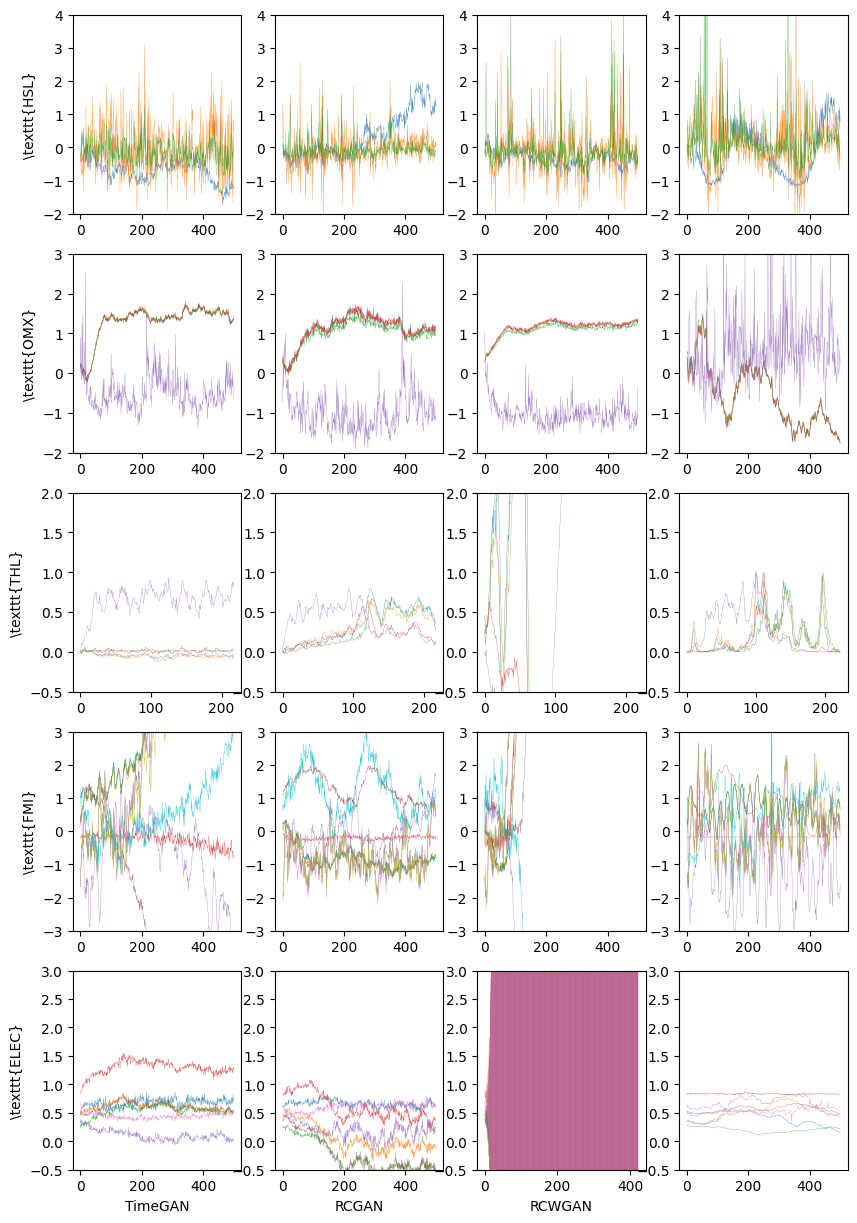

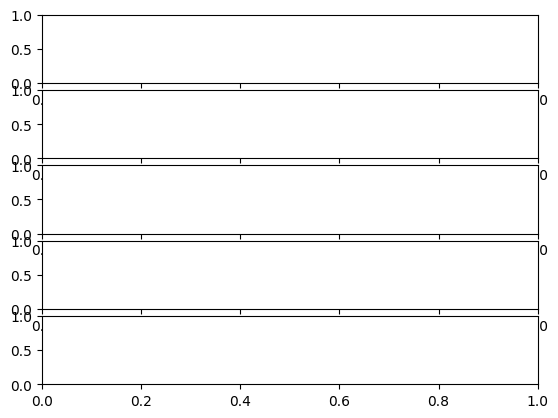

In [218]:
from lib.algos.base import SimpleGenerator
from lib.utils import load_pickle
from evaluate import extract_base_config
import torch
import matplotlib.pyplot as plt

device = "cpu"

fig, axes = plt.subplots(5, 4, sharey=False, sharex=False, figsize=(10,15))
fig2, axes2 = plt.subplots(5, 1)
plt.subplots_adjust(hspace=.1)
np.random.seed(111)
torch.manual_seed(111)

#gs = axes[-1, 0].get_gridspec()
# remove the underlying Axes
#for ax in axes[-1]:
#    ax.remove()
#axbig = fig.add_subplot(gs[-1])
ylims = [(-2,4), (-2,3), (-0.5,2), (-3,3), (-0.5,3)]

for i,dataset in enumerate(datasets):
    dir = f"numerical_results/20240529/{dataset}/chosen/seed=111/"
    #x_real_window = load_pickle(os.path.join(os.path.dirname(dir), 'x_real.torch')).to(device)
    
    # ----------------------------------------------
    # Load and prepare real path.
    # ----------------------------------------------
    x_real = load_pickle(os.path.join(os.path.dirname(dir), 'x_real.torch')).to(device)
    count, seq_len, dim = x_real.shape

    plt.rcParams['text.usetex'] = False
    
    x_real2 = torch.stack([w[0] for w in x_real] + [v for v in x_real[-1][1:6]], dim=0)
    #axes2[i].plot(x_real2)
    axes[i][3].plot(x_real2.cpu().numpy()[:500], linewidth=0.2)
    axes[i][3].set_ylim(*ylims[i])
    
    for j,algo in enumerate(algos):        
        exp_dir = f"{dir}{algo}/"

        bc = extract_base_config(os.path.join(os.path.dirname(exp_dir), 'conf.txt'))
        p, q = bc.p, bc.q
        hidden_dims = bc.hidden_dims  

        x_past, x_future = x_real[:, :p], x_real[:, p:p + q]
        dim = x_real.shape[-1]
        # ----------------------------------------------
        # Load generator weights and hyperparameters
        # ----------------------------------------------
        G_weights = load_pickle(os.path.join(exp_dir, 'G_weights.torch'))
        G = SimpleGenerator(dim * p, dim, hidden_dims, dim).to(device)
        G.load_state_dict(G_weights)
        
        n_samples = min(count, 500)
        with torch.no_grad():
            x_fake = G.sample(n_samples, x_past[0:1])[0].cpu().numpy()
        
        axes[i][j].plot(x_fake, linewidth=0.2)
        axes[i][j].set_ylim(*ylims[i])
        
        #e = 1e4
        #if x_fake.min() < -e or x_fake.max() > e:
        #    axes[i][j].set_ylim(-e,e)
        
        if i+1 == len(datasets):
            axes[i][j].set_xlabel(algo)
        if j + 3 % 3 == 0:
            axes[i][j].set_ylabel(f"\\texttt{{{dataset}}}")
        #plt.axis('off')
    #plt.tight_layout()


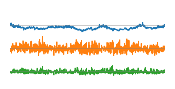

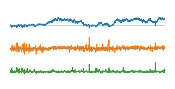

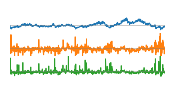

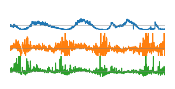

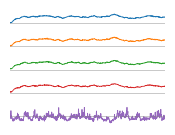

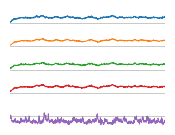

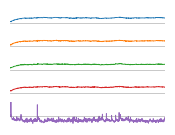

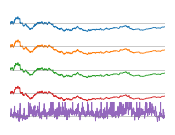

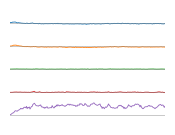

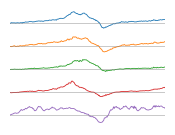

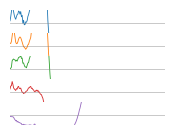

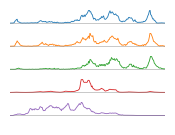

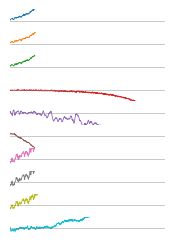

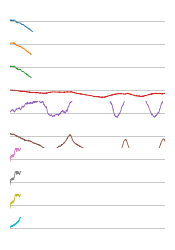

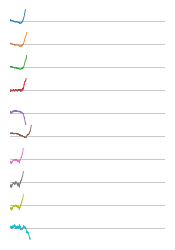

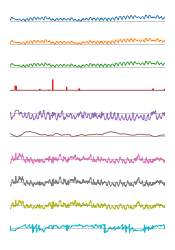

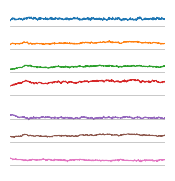

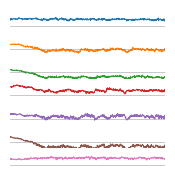

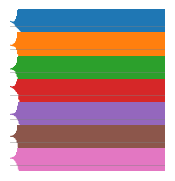

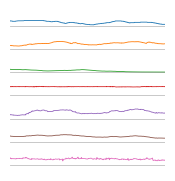

In [224]:

device = "cpu"
datasets = ["HSL", "OMX", "THL", "FMI", "ELEC"]
algos = ["TimeGAN", "RCGAN", "RCWGAN"]
ylims = [(-2,4), (-2,3), (-0.7,1), (-5,5), (-0.6,1.6)]
np.random.seed(111)
torch.manual_seed(111)

def draw_subplots(x, ylims=None):
    c, d = x.shape
    fig, axs = plt.subplots(nrows=d, sharex=True, figsize=(2,0.3*d))
    plt.subplots_adjust(hspace=.0)
    #plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    plt.margins(0)
    #plt.tight_layout(pad=0)

    linewidth=0.6
        
    colors = plt.rcParams["axes.prop_cycle"]()    
    for i in range(dim):
        axs[i].plot(x[:,i], c=next(colors)["color"], linewidth=linewidth)
        axs[i].axhline(c='grey', alpha=0.5, linewidth=linewidth)
        axs[i].set_ylim(*ylims)
        
        #if i+1 < dim:
        plt.setp(axs[i].get_xticklabels(), visible=False)
        plt.setp(axs[i].get_yticklabels(), visible=False)
        plt.setp(axs[i].get_xticklines(), visible=False)
        plt.setp(axs[i].get_yticklines(), visible=False)
        plt.setp(axs[i].spines.values(), visible=False)
        
    #axs[dim-1].xaxis.tick_bottom()
    #plt.setp(axs[dim-1].get_xticklabels(), visible=True)
    #plt.setp(axs[dim-1].get_xticklines(), visible=True)

for i,dataset in enumerate(datasets):
    dir = f"numerical_results/20240529/{dataset}/chosen/seed=111/"
    x_real = load_pickle(os.path.join(os.path.dirname(dir), 'x_real.torch')).to(device)
    count, seq_len, dim = x_real.shape

    plt.rcParams['text.usetex'] = False
    
    x_real2 = torch.stack([w[0] for w in x_real] + [v for v in x_real[-1][1:6]], dim=0)

    n_samples = min(count, 1000)
    
    for j,algo in enumerate(algos):        
        exp_dir = f"{dir}{algo}/"

        bc = extract_base_config(os.path.join(os.path.dirname(exp_dir), 'conf.txt'))
        p, q = bc.p, bc.q
        hidden_dims = bc.hidden_dims  

        x_past, x_future = x_real[:, :p], x_real[:, p:p + q]
        dim = x_real.shape[-1]

        G_weights = load_pickle(os.path.join(exp_dir, 'G_weights.torch'))
        G = SimpleGenerator(dim * p, dim, hidden_dims, dim).to(device)
        G.load_state_dict(G_weights)
        
        with torch.no_grad():
            x_fake = G.sample(n_samples, x_past[0:1])[0].cpu().numpy()
        
        #fig, axs = plt.subplots(nrows=dim, sharex=True)
        # remove vertical gap between subplots
        draw_subplots(x_fake, ylims[i])
        plt.savefig(f'./numerical_results/20240529/plots/paths_{dataset}_{algo}.png', dpi=300)
        
    draw_subplots(x_real2[:n_samples], ylims[i])
    plt.savefig(f'./numerical_results/20240529/plots/paths_{dataset}_real.png', dpi=300)

In [249]:
regex = r"'lr_D': (\d+.\d*), 'lr_G': (\d+.\d*), 'D_per_G_steps': (\d+), 'batch_size': (\d+), 'hidden_dims': (\d+), 'normalizer': '((minmax)|(standard))'"
line = "i:14 (2,'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'"
m = re.search(regex, line)
print(m.group(3))
 

4


In [270]:
import re

regex = r"'lr_D': (\d+.\d*(?:e-\d+)?), 'lr_G': (\d+.\d*(?:e-\d+)?), 'D_per_G_steps': (\d+), 'batch_size': (\d+), 'hidden_dims': (\d+), 'normalizer': '((minmax)|(standard))'"
datasets = ["HSL", "OMX", "THL", "FMI", "ELEC"]
algos = ["TimeGAN", "RCGAN", "RCWGAN"]
r = re.compile(regex)
for algo in algos:
    for dataset in datasets:
        with open(f"optim/best_tune_{algo}_{dataset}_mi50_ts2000_s111_x.txt", "r") as f:
            lines = f.readlines()
        m = r.search(lines[-1])
        print(algo, dataset,
            f"lr_D: {float(m.group(1)):.3e}",
              f"lr_G: {float(m.group(2)):.3e}",
              "D_per_G_steps:", m.group(3),
              "batch_size:", m.group(4),
              "hidden_dims:", m.group(5),
              "normalizer:", m.group(6))
    print()


TimeGAN HSL lr_D: 9.680e-04 lr_G: 6.741e-05 D_per_G_steps: 2 batch_size: 64 hidden_dims: 100 normalizer: standard
TimeGAN OMX lr_D: 2.515e-04 lr_G: 7.091e-05 D_per_G_steps: 2 batch_size: 512 hidden_dims: 100 normalizer: standard
TimeGAN THL lr_D: 6.446e-04 lr_G: 5.829e-04 D_per_G_steps: 3 batch_size: 16 hidden_dims: 100 normalizer: minmax
TimeGAN FMI lr_D: 4.006e-04 lr_G: 1.572e-04 D_per_G_steps: 2 batch_size: 16 hidden_dims: 100 normalizer: standard
TimeGAN ELEC lr_D: 3.486e-04 lr_G: 1.923e-04 D_per_G_steps: 4 batch_size: 4 hidden_dims: 70 normalizer: minmax

RCGAN HSL lr_D: 6.375e-04 lr_G: 3.458e-04 D_per_G_steps: 4 batch_size: 32 hidden_dims: 100 normalizer: standard
RCGAN OMX lr_D: 7.085e-04 lr_G: 1.156e-04 D_per_G_steps: 2 batch_size: 4 hidden_dims: 100 normalizer: standard
RCGAN THL lr_D: 8.187e-05 lr_G: 1.705e-04 D_per_G_steps: 4 batch_size: 128 hidden_dims: 100 normalizer: minmax
RCGAN FMI lr_D: 5.606e-04 lr_G: 1.808e-04 D_per_G_steps: 3 batch_size: 32 hidden_dims: 50 normalize

In [258]:
line = "(2, {'lr_D': 0.0009680445003684609, 'lr_G': 6.741313335197047e-05, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.5665863748251323}, {'combined': {'combined': nan))"
m = re.search(regex,line)
m

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 8))
outer = gridspec.GridSpec(5, 4, wspace=0.2, hspace=0.2)

device = "cpu"

for i, dataset in enumerate(datasets):
    dir = f"numerical_results/20240529/{dataset}/chosen/seed=111/"
   
    x_real = load_pickle(os.path.join(os.path.dirname(dir), 'x_real.torch')).to(device)
    count, seq_len, dim = x_real.shape
    
    x_real2 = torch.stack([w[0] for w in x_real] + [v for v in x_real[-1][1:6]], dim=0)
    
    for j,algo in enumerate(algos):
        inner = gridspec.GridSpecFromSubplotSpec(dim, 1,
                        subplot_spec=outer[i], wspace=0.0, hspace=0.0)
              
        exp_dir = f"{dir}{algo}/"

        bc = extract_base_config(os.path.join(os.path.dirname(exp_dir), 'conf.txt'))
        p, q = bc.p, bc.q
        hidden_dims = bc.hidden_dims

        x_past, x_future = x_real[:, :p], x_real[:, p:p + q]
        G_weights = load_pickle(os.path.join(exp_dir, 'G_weights.torch'))
        G = SimpleGenerator(dim * p, dim, hidden_dims, dim).to(device)
        G.load_state_dict(G_weights)
        
        count = min(len(x_real2), 500)
        with torch.no_grad():
            x_fake = G.sample(count, x_past[0:1])[0].cpu().numpy()

    for k in range(dim):
        ax = plt.Subplot(fig, inner[k])
        t = ax.text(0.5,0.5, 'outer=%d, inner=%d' % (i, j))
        t.set_ha('center')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

fig.show()

In [91]:
optimize("TimeGAN", "HSL", 10, total_steps=2000, initial_seed=111, prefix="y")

[INFO 05-29 16:16:37] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-29 16:16:37] ax.service.utils.instantiation: Due to non-specification, we will use the heuristic for selecting objective thresholds.
[INFO 05-29 16:16:37] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-29 16:16:37] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-29 16:16:37] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is 

Start of training. CUDA: False
Executing: TimeGAN, HSL, y0


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.65it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 5.1266403 16.010845  47.95396  ]


[INFO 05-29 16:17:42] ax.service.ax_client: Completed trial 0 with data: {'r2_ratio': (0.819735, None), 'abs': (0.031356, None), 'acf': (0.00662, None), 'cross_correl': (0.847556, None), 'value_range': (0.0, None)}.
[INFO 05-29 16:17:42] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.00058, 'lr_G': 0.000401, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2892264006217438, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.06360265310775792, 'abs_metric': 0.03135569766163826, 'acf_id_lag=1': 0.006620416883379221, 'kurtosis': 88.2542953491211, 'skew': 4.783966064453125, 'cross_correl': 0.8475561738014221, 'sig_w1_metric': 0.19893574714660645, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, y1


 91%|███████████████████████████████████▌   | 1826/2000 [00:51<00:04, 35.58it/s]


KeyboardInterrupt: 

In [13]:
optimize_datasets("RCWGAN", ["HSL"], prefix="x")

[INFO 05-28 19:47:03] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 19:47:03] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 19:47:03] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 19:47:03] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 19:47:03


------------------------
OPTIMIZING DATASET HSL
------------------------

Start of training. CUDA: False
Executing: RCWGAN, HSL, x0


100%|███████████████████████████████████████| 2000/2000 [00:21<00:00, 92.02it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 19:47:48] ax.service.ax_client: Completed trial 0 with data: {'combined': (3866477.576495, None)}.
[INFO 05-28 19:47:48] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000634, 'lr_G': 0.00076, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.11692387205303623, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.23590518167646551, 'abs_metric': 0.039393484592437744, 'acf_id_lag=1': 0.09709640592336655, 'kurtosis': 71.69734954833984, 'skew': 3.107421636581421, 'cross_correl': 0.4141002595424652, 'sig_w1_metric': 0.278601735830307, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x1
minmax


100%|███████████████████████████████████████| 2000/2000 [01:18<00:00, 25.47it/s]


[-0.241351   -0.09078495 -0.06495494] [1.       1.042407 1.      ]


[INFO 05-28 19:49:34] ax.service.ax_client: Completed trial 1 with data: {'combined': (1.168009, None)}.
[INFO 05-28 19:49:34] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000901, 'lr_G': 0.000768, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2573407647114792, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.09548830022167903, 'abs_metric': 0.5787954926490784, 'acf_id_lag=1': 0.06457453221082687, 'kurtosis': 82.72122955322266, 'skew': 3.822772264480591, 'cross_correl': 0.4263134002685547, 'sig_w1_metric': 0.02166232280433178, 'value_range': 1.283758}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x2
minmax


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 55.75it/s]


[-0.0473661  0.         0.       ] [1. 1. 1.]


[INFO 05-28 19:50:34] ax.service.ax_client: Completed trial 2 with data: {'combined': (1.158031, None)}.
[INFO 05-28 19:50:34] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.000282, 'lr_G': 0.000674, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.30042490576886477, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.05240415916429347, 'abs_metric': 0.5263815522193909, 'acf_id_lag=1': 0.05415884777903557, 'kurtosis': 88.30538940429688, 'skew': 4.777045726776123, 'cross_correl': 0.5246127843856812, 'sig_w1_metric': 0.011248943395912647, 'value_range': 1.0473661}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.47it/s]


[0. 0. 0.] [1.6165539 1.        1.       ]


[INFO 05-28 19:51:44] ax.service.ax_client: Completed trial 3 with data: {'combined': (1.357817, None)}.
[INFO 05-28 19:51:44] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000285, 'lr_G': 6.8e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3101760791982581, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.04265298573490012, 'abs_metric': 0.5734421610832214, 'acf_id_lag=1': 0.05681658908724785, 'kurtosis': 83.87203979492188, 'skew': 4.260517120361328, 'cross_correl': 0.6787397265434265, 'sig_w1_metric': 0.010732108727097511, 'value_range': 1.6165539}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x4


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.82it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 19:52:43] ax.service.ax_client: Completed trial 4 with data: {'combined': (0.51503, None)}.
[INFO 05-28 19:52:43] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.
[INFO 05-28 19:52:43] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000931, 'lr_G': 0.00067, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2439758911932071, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.10885316253629465, 'abs_metric': 0.034866634756326675, 'acf_id_lag=1': 0.058142583817243576, 'kurtosis': 83.12493133544922, 'skew': 4.071461200714111, 'cross_correl': 0.31316715478897095, 'sig_w1_metric': 0.16006138920783997, 'value_range': 1.0}
(4, {'lr_D': 0.00028504739713734013, 'lr_G': 6.802573798447847e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.5150295358988358}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, HSL, x5
minmax


100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 46.60it/s]


[ 0.          0.         -0.08248736] [1. 1. 1.]


[INFO 05-28 19:53:53] ax.service.ax_client: Completed trial 5 with data: {'combined': (1.041225, None)}.
[INFO 05-28 19:53:53] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000719, 'lr_G': 0.000551, 'D_per_G_steps': 1, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.25958840473808986, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.09324066019506838, 'abs_metric': 0.7532585263252258, 'acf_id_lag=1': 0.008921698667109013, 'kurtosis': 85.57571411132812, 'skew': 4.833528995513916, 'cross_correl': 0.18497970700263977, 'sig_w1_metric': 0.012732153758406639, 'value_range': 1.0824873}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x6


100%|██████████████████████████████████████| 2000/2000 [00:19<00:00, 101.47it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 19:54:38] ax.service.ax_client: Completed trial 6 with data: {'combined': (3866478.304883, None)}.
[INFO 05-28 19:54:38] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.00023, 'lr_G': 0.000875, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.15266719782651197, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.5054962515560137, 'abs_metric': 0.07699712365865707, 'acf_id_lag=1': 0.128525972366333, 'kurtosis': 80.29009246826172, 'skew': 3.5348689556121826, 'cross_correl': 0.8038639426231384, 'sig_w1_metric': 0.5662654042243958, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x7


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 69.89it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 19:55:31] ax.service.ax_client: Completed trial 7 with data: {'combined': (3866479.109953, None)}.
[INFO 05-28 19:55:31] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.000156, 'lr_G': 5.8e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.5494326498546979, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.9022617035841995, 'abs_metric': 0.059491317719221115, 'acf_id_lag=1': 0.32182958722114563, 'kurtosis': 84.52523040771484, 'skew': 4.475059509277344, 'cross_correl': 1.0363701581954956, 'sig_w1_metric': 0.8459402918815613, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x8


100%|███████████████████████████████████████| 2000/2000 [01:40<00:00, 19.85it/s]


[-4.4672947 -4.1189284 -2.7716892] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 19:57:38] ax.service.ax_client: Completed trial 8 with data: {'combined': (0.373151, None)}.
[INFO 05-28 19:57:38] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000595, 'lr_G': 0.000702, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.331734436484769, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.021094617244732716, 'abs_metric': 0.029077885672450066, 'acf_id_lag=1': 0.05096990242600441, 'kurtosis': 84.03292083740234, 'skew': 3.721135377883911, 'cross_correl': 0.27187472581863403, 'sig_w1_metric': 0.1308852732181549, 'value_range': 1.0134279}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 60.45it/s]


[ 0.          0.         -0.00416937] [1. 1. 1.]


[INFO 05-28 19:58:38] ax.service.ax_client: Completed trial 9 with data: {'combined': (2.242744, None)}.
[INFO 05-28 19:58:38] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.
[INFO 05-28 19:58:38] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000804, 'lr_G': 0.000376, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.16347700377295551, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.18935206116020273, 'abs_metric': 0.8714550137519836, 'acf_id_lag=1': 0.11201957613229752, 'kurtosis': 87.87519073486328, 'skew': 4.9913811683654785, 'cross_correl': 1.0698753595352173, 'sig_w1_metric': 0.015608030371367931, 'value_range': 1.0041693}
(8, {'lr_D': 0.00015575362679548562, 'lr_G': 5.7950167867075654e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.37315140969766414}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, HSL, x10


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 42.51it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 19:59:52] ax.service.ax_client: Completed trial 10 with data: {'combined': (0.498263, None)}.
[INFO 05-28 19:59:52] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000408, 'lr_G': 0.000494, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2670431533807151, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.08578590034878664, 'abs_metric': 0.039134081453084946, 'acf_id_lag=1': 0.06990236788988113, 'kurtosis': 80.32825469970703, 'skew': 3.5158605575561523, 'cross_correl': 0.30344074964523315, 'sig_w1_metric': 0.1662488877773285, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x11


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 38.48it/s]


[-2.2309303 -3.7727153 -2.1651955] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 20:01:10] ax.service.ax_client: Completed trial 11 with data: {'combined': (1.012947, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.25341981715893686, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.09940923657056489, 'abs_metric': 0.05281788483262062, 'acf_id_lag=1': 0.05557237192988396, 'kurtosis': 86.83170318603516, 'skew': 4.602975368499756, 'cross_correl': 0.8051472902297974, 'sig_w1_metric': 0.22865568101406097, 'value_range': 1.0}


[INFO 05-28 20:01:11] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000519, 'lr_G': 0.000626, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x12
minmax


100%|███████████████████████████████████████| 2000/2000 [01:02<00:00, 31.93it/s]


[-0.11475564  0.         -0.08334352] [1. 1. 1.]


[INFO 05-28 20:02:40] ax.service.ax_client: Completed trial 12 with data: {'combined': (1.50829, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2798042756466065, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.07302478928655176, 'abs_metric': 0.882012665271759, 'acf_id_lag=1': 0.04222873970866203, 'kurtosis': 82.90182495117188, 'skew': 3.778336524963379, 'cross_correl': 0.5098763108253479, 'sig_w1_metric': 0.00712657580152154, 'value_range': 1.1147556}


[INFO 05-28 20:02:41] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.00059, 'lr_G': 0.000179, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x13


100%|███████████████████████████████████████| 2000/2000 [01:07<00:00, 29.43it/s]


[-1.2450365 -3.8539906 -1.8960757] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 20:04:17] ax.service.ax_client: Completed trial 13 with data: {'combined': (0.607421, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2979713111385966, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.054857742590905145, 'abs_metric': 0.04234990477561951, 'acf_id_lag=1': 0.13156504929065704, 'kurtosis': 82.6105728149414, 'skew': 3.67533278465271, 'cross_correl': 0.3786330819129944, 'sig_w1_metric': 0.17260734736919403, 'value_range': 1.0015713}


[INFO 05-28 20:04:18] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.001, 'lr_G': 0.000301, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x14


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.20it/s]


[-1.4401373 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 20:05:44] ax.service.ax_client: Completed trial 14 with data: {'combined': (0.597067, None)}.
[INFO 05-28 20:05:44] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2745155916585016, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.07831346207100015, 'abs_metric': 0.04487568512558937, 'acf_id_lag=1': 0.13201647996902466, 'kurtosis': 82.05561065673828, 'skew': 3.474452018737793, 'cross_correl': 0.3418610692024231, 'sig_w1_metric': 0.18262353539466858, 'value_range': 1.0}
(8, {'lr_D': 0.00015575362679548562, 'lr_G': 5.7950167867075654e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.37315140969766414}, {'combined': {'combined': nan}}))


[INFO 05-28 20:05:45] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000209, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x15


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.07it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 20:07:09] ax.service.ax_client: Completed trial 15 with data: {'combined': (2.163338, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.01867986953001266, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.3341491841994891, 'abs_metric': 0.17547909915447235, 'acf_id_lag=1': 0.43522879481315613, 'kurtosis': 95.69318389892578, 'skew': 6.165126323699951, 'cross_correl': 1.2184807062149048, 'sig_w1_metric': 0.42311832308769226, 'value_range': 1.0}


[INFO 05-28 20:07:11] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000498, 'lr_G': 0.000178, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x16


100%|███████████████████████████████████████| 2000/2000 [01:03<00:00, 31.70it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 20:08:40] ax.service.ax_client: Completed trial 16 with data: {'combined': (0.486189, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.32443375316296896, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.028395300566532777, 'abs_metric': 0.03518035635352135, 'acf_id_lag=1': 0.11262501031160355, 'kurtosis': 82.14623260498047, 'skew': 3.5354855060577393, 'cross_correl': 0.3099879026412964, 'sig_w1_metric': 0.14243488013744354, 'value_range': 1.0}


[INFO 05-28 20:08:42] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000332, 'lr_G': 0.000324, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x17


100%|███████████████████████████████████████| 2000/2000 [01:45<00:00, 18.95it/s]


[-30.651808  -8.136915  -9.736197] [ 3.676648 44.840347 47.95396 ]


[INFO 05-28 20:10:54] ax.service.ax_client: Completed trial 17 with data: {'combined': (0.281978, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.32667343761416007, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.026155616115341673, 'abs_metric': 0.023689091205596924, 'acf_id_lag=1': 0.10801168531179428, 'kurtosis': 70.62594604492188, 'skew': 2.626983404159546, 'cross_correl': 0.118925541639328, 'sig_w1_metric': 0.1270541548728943, 'value_range': 1.5196369}


[INFO 05-28 20:10:56] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000559, 'lr_G': 0.000161, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x18


100%|███████████████████████████████████████| 2000/2000 [01:43<00:00, 19.25it/s]


[-1.9340543 -3.7727153 -1.7051364] [ 4.997815 16.010845 47.95396 ]


[INFO 05-28 20:13:07] ax.service.ax_client: Completed trial 18 with data: {'combined': (0.397802, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.33536060476026447, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.01746844896923727, 'abs_metric': 0.03068300522863865, 'acf_id_lag=1': 0.06458913534879684, 'kurtosis': 79.9118881225586, 'skew': 3.41823410987854, 'cross_correl': 0.28506186604499817, 'sig_w1_metric': 0.12496896833181381, 'value_range': 1.0}


[INFO 05-28 20:13:09] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000327, 'lr_G': 0.000246, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x19


100%|███████████████████████████████████████| 2000/2000 [01:27<00:00, 22.90it/s]


[-25.281075   -3.7727153 -12.383056 ] [ 3.676648 62.68731  47.95396 ]


[INFO 05-28 20:15:03] ax.service.ax_client: Completed trial 19 with data: {'combined': (0.3016, None)}.
[INFO 05-28 20:15:03] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3267199214021187, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.026109132327383044, 'abs_metric': 0.027440523728728294, 'acf_id_lag=1': 0.07427295297384262, 'kurtosis': 75.79993438720703, 'skew': 3.046689987182617, 'cross_correl': 0.1667705923318863, 'sig_w1_metric': 0.1504167914390564, 'value_range': 1.7006387}
(17, {'lr_D': 0.00033154524322140107, 'lr_G': 0.00032437049910898584, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.2819783029663663}, {'combined': {'combined': nan}}))


[INFO 05-28 20:15:05] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000332, 'lr_G': 0.000274, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x20


100%|███████████████████████████████████████| 2000/2000 [01:45<00:00, 18.98it/s]


[-6.727608  -6.7479253 -4.238836 ] [ 3.676648 16.956902 47.95396 ]


[INFO 05-28 20:17:17] ax.service.ax_client: Completed trial 20 with data: {'combined': (0.256166, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.33620931840355933, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.01661973532594241, 'abs_metric': 0.02554221637547016, 'acf_id_lag=1': 0.09427904337644577, 'kurtosis': 72.17850494384766, 'skew': 2.813734292984009, 'cross_correl': 0.11914975196123123, 'sig_w1_metric': 0.12773042917251587, 'value_range': 1.0575179}


[INFO 05-28 20:17:20] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.001, 'lr_G': 0.0, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x21
minmax


100%|███████████████████████████████████████| 2000/2000 [00:22<00:00, 89.21it/s]


[-0.49098265 -0.44479966 -0.07778464] [1. 1. 1.]


[INFO 05-28 20:18:11] ax.service.ax_client: Completed trial 21 with data: {'combined': (15.950022, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -11.403179308966735, 'r2_trtr': 0.35282906493315824, 'predictive_score': 11.756008373899892, 'abs_metric': 2.1087591648101807, 'acf_id_lag=1': 0.44744428992271423, 'kurtosis': 88.85979461669922, 'skew': 5.120135307312012, 'cross_correl': 1.632900595664978, 'sig_w1_metric': 0.20040370523929596, 'value_range': 1.4909827}


[INFO 05-28 20:18:13] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000795, 'lr_G': 0.000378, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x22


100%|███████████████████████████████████████| 2000/2000 [01:08<00:00, 29.17it/s]


[-2.3891652 -4.1652455 -1.8622568] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 20:19:49] ax.service.ax_client: Completed trial 22 with data: {'combined': (0.425776, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.31643066952286, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.036398384206641765, 'abs_metric': 0.028964877128601074, 'acf_id_lag=1': 0.10776209831237793, 'kurtosis': 75.24854278564453, 'skew': 2.9082162380218506, 'cross_correl': 0.25257498025894165, 'sig_w1_metric': 0.13297845423221588, 'value_range': 1.0075885}


[INFO 05-28 20:19:52] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000804, 'lr_G': 0.000415, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x23


100%|███████████████████████████████████████| 2000/2000 [01:19<00:00, 25.01it/s]


[-1.5763024 -3.7727153 -1.7051364] [ 4.0788317 16.010845  47.95396  ]


[INFO 05-28 20:21:39] ax.service.ax_client: Completed trial 23 with data: {'combined': (0.23963, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.32872367606220715, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.024105377667294592, 'abs_metric': 0.03217107802629471, 'acf_id_lag=1': 0.010421515442430973, 'kurtosis': 51.54130554199219, 'skew': 1.879320740699768, 'cross_correl': 0.17293158173561096, 'sig_w1_metric': 0.14411814510822296, 'value_range': 1.0}


[INFO 05-28 20:21:41] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000918, 'lr_G': 0.00041, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x24


100%|███████████████████████████████████████| 2000/2000 [02:05<00:00, 15.93it/s]


[-3.9379783 -7.809407  -3.264857 ] [ 3.676648 20.299522 47.95396 ]


[INFO 05-28 20:24:15] ax.service.ax_client: Completed trial 24 with data: {'combined': (0.399901, None)}.
[INFO 05-28 20:24:15] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.32056094483805686, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.03226810889144488, 'abs_metric': 0.02613837830722332, 'acf_id_lag=1': 0.06810763478279114, 'kurtosis': 70.36502838134766, 'skew': 2.4733121395111084, 'cross_correl': 0.27260622382164, 'sig_w1_metric': 0.1448671519756317, 'value_range': 1.0780388}
(23, {'lr_D': 0.0008039445986988423, 'lr_G': 0.00041475150221639454, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.23962955287163124}, {'combined': {'combined': nan}}))


[INFO 05-28 20:24:17] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000646, 'lr_G': 0.000515, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x25


100%|███████████████████████████████████████| 2000/2000 [01:44<00:00, 19.15it/s]


[-1.7524232 -4.151596  -2.0510526] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 20:26:29] ax.service.ax_client: Completed trial 25 with data: {'combined': (0.304487, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.31581829660852384, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.0370107571209779, 'abs_metric': 0.028863267973065376, 'acf_id_lag=1': 0.06056354567408562, 'kurtosis': 61.731441497802734, 'skew': 1.9547877311706543, 'cross_correl': 0.1779763251543045, 'sig_w1_metric': 0.13682503998279572, 'value_range': 1.0073247}


[INFO 05-28 20:26:31] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.000853, 'lr_G': 0.000439, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x26


100%|███████████████████████████████████████| 2000/2000 [01:19<00:00, 25.09it/s]


[-6.820385  -9.073761  -3.4325156] [ 3.676648 25.98826  47.95396 ]


[INFO 05-28 20:28:21] ax.service.ax_client: Completed trial 26 with data: {'combined': (0.188524, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3203555150410032, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.03247353868849856, 'abs_metric': 0.025728046894073486, 'acf_id_lag=1': 0.03813900053501129, 'kurtosis': 47.804718017578125, 'skew': 1.6823402643203735, 'cross_correl': 0.09115855395793915, 'sig_w1_metric': 0.1425824612379074, 'value_range': 1.1024818}


[INFO 05-28 20:28:24] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.001, 'lr_G': 0.000581, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x27


100%|███████████████████████████████████████| 2000/2000 [01:22<00:00, 24.25it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 20:30:19] ax.service.ax_client: Completed trial 27 with data: {'combined': (0.344084, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3206265737209316, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.03220248000857012, 'abs_metric': 0.033866170793771744, 'acf_id_lag=1': 0.04929967597126961, 'kurtosis': 44.442623138427734, 'skew': 1.681753158569336, 'cross_correl': 0.22871540486812592, 'sig_w1_metric': 0.1503273844718933, 'value_range': 1.0}


[INFO 05-28 20:30:21] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000866, 'lr_G': 0.000392, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x28


100%|███████████████████████████████████████| 2000/2000 [01:25<00:00, 23.35it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


: 

In [9]:
optimize_datasets("TimeGAN", ["HSL"], prefix="x")

[INFO 05-29 09:37:07] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-29 09:37:07] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-29 09:37:07] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-29 09:37:07] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-29 09:37:07


------------------------
OPTIMIZING DATASET HSL
------------------------

Start of training. CUDA: False
Executing: TimeGAN, HSL, x0


100%|███████████████████████████████████████| 2000/2000 [00:50<00:00, 39.42it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-29 09:38:23] ax.service.ax_client: Completed trial 0 with data: {'combined': (0.879461, None)}.
[INFO 05-29 09:38:23] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000597, 'lr_G': 0.000765, 'D_per_G_steps': 1, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2924220155582814, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.06040703817122034, 'abs_metric': 0.05380972847342491, 'acf_id_lag=1': 0.11820218712091446, 'kurtosis': 88.16886138916016, 'skew': 4.732615947723389, 'cross_correl': 0.6470420956611633, 'sig_w1_metric': 0.2047378569841385, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x1


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 59.21it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 7.954027 16.010845 47.95396 ]


[INFO 05-29 09:39:24] ax.service.ax_client: Completed trial 1 with data: {'combined': (0.788746, None)}.
[INFO 05-29 09:39:24] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000968, 'lr_G': 6.7e-05, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2916707302734203, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.061158323456081465, 'abs_metric': 0.04960694909095764, 'acf_id_lag=1': 0.10319221019744873, 'kurtosis': 87.3586654663086, 'skew': 4.5970025062561035, 'cross_correl': 0.5747888088226318, 'sig_w1_metric': 0.18165777623653412, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x2


100%|███████████████████████████████████████| 2000/2000 [00:55<00:00, 35.92it/s]


[-2.712894  -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-29 09:40:49] ax.service.ax_client: Completed trial 2 with data: {'combined': (0.566586, None)}.
[INFO 05-29 09:40:49] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.000321, 'lr_G': 6e-05, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3388543428419381, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.013974710887563635, 'abs_metric': 0.026368096470832825, 'acf_id_lag=1': 0.08930528163909912, 'kurtosis': 87.38428497314453, 'skew': 4.488121032714844, 'cross_correl': 0.4369382858276367, 'sig_w1_metric': 0.13400663435459137, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x3


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 51.40it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-29 09:41:56] ax.service.ax_client: Completed trial 3 with data: {'combined': (3866477.049708, None)}.
[INFO 05-29 09:41:56] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000285, 'lr_G': 6.8e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.33931016300190614, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.0135188907275956, 'abs_metric': 0.03132365271449089, 'acf_id_lag=1': 0.036163680255413055, 'kurtosis': 87.52081298828125, 'skew': 4.543228626251221, 'cross_correl': 0.17870178818702698, 'sig_w1_metric': 0.15128660202026367, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x4


100%|███████████████████████████████████████| 2000/2000 [00:59<00:00, 33.87it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-29 09:43:15] ax.service.ax_client: Completed trial 4 with data: {'combined': (3866477.303324, None)}.
[INFO 05-29 09:43:15] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts2000_s111_x.json`.
[INFO 05-29 09:43:15] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000931, 'lr_G': 0.00067, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.333316424156711, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.019512629572790763, 'abs_metric': 0.027902139350771904, 'acf_id_lag=1': 0.05356907472014427, 'kurtosis': 87.7748031616211, 'skew': 4.6515679359436035, 'cross_correl': 0.41234004497528076, 'sig_w1_metric': 0.14981785416603088, 'value_range': 386647680.0}
(2, {'lr_D': 0.0009680445003684609, 'lr_G': 6.741313335197047e-05, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.5665863748251323}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, HSL, x5
minmax


100%|███████████████████████████████████████| 2000/2000 [01:09<00:00, 28.83it/s]


[-0.10322436  0.          0.        ] [1. 1. 1.]


[INFO 05-29 09:44:51] ax.service.ax_client: Completed trial 5 with data: {'combined': (1.61544, None)}.
[INFO 05-29 09:44:51] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000719, 'lr_G': 0.000551, 'D_per_G_steps': 1, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.25080536284510463, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.10202370208805361, 'abs_metric': 0.998467206954956, 'acf_id_lag=1': 0.021660342812538147, 'kurtosis': 81.79244232177734, 'skew': 3.2534239292144775, 'cross_correl': 0.4922562837600708, 'sig_w1_metric': 0.019698049873113632, 'value_range': 1.1032244}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x6


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 55.75it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-29 09:45:49] ax.service.ax_client: Completed trial 6 with data: {'combined': (3866477.472189, None)}.
[INFO 05-29 09:45:49] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.00023, 'lr_G': 0.000875, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.31301063523871225, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.03981841849078949, 'abs_metric': 0.04033830389380455, 'acf_id_lag=1': 0.1719551831483841, 'kurtosis': 87.26306915283203, 'skew': 4.335377216339111, 'cross_correl': 0.43007755279541016, 'sig_w1_metric': 0.22220762073993683, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x7


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 41.79it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-29 09:47:00] ax.service.ax_client: Completed trial 7 with data: {'combined': (0.995746, None)}.
[INFO 05-29 09:47:00] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.000156, 'lr_G': 5.8e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2551020240024115, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.09772702972709024, 'abs_metric': 0.040408436208963394, 'acf_id_lag=1': 0.07279279828071594, 'kurtosis': 88.2204818725586, 'skew': 4.650857448577881, 'cross_correl': 0.7848179340362549, 'sig_w1_metric': 0.24430079758167267, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x8


100%|███████████████████████████████████████| 2000/2000 [02:04<00:00, 16.08it/s]


[-2.0274498 -3.7727153 -1.7051364] [ 4.176621 16.010845 47.95396 ]


[INFO 05-29 09:49:27] ax.service.ax_client: Completed trial 8 with data: {'combined': (0.662039, None)}.
[INFO 05-29 09:49:27] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000595, 'lr_G': 0.000702, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3290487078939605, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.023780345835541228, 'abs_metric': 0.028676198795437813, 'acf_id_lag=1': 0.07939626276493073, 'kurtosis': 87.75662994384766, 'skew': 4.622203350067139, 'cross_correl': 0.5301863551139832, 'sig_w1_metric': 0.13588830828666687, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.52it/s]


[-0.00287221 -0.11262655 -0.01570302] [1. 1. 1.]


[INFO 05-29 09:50:40] ax.service.ax_client: Completed trial 9 with data: {'combined': (1.719152, None)}.
[INFO 05-29 09:50:40] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts2000_s111_x.json`.
[INFO 05-29 09:50:40] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000804, 'lr_G': 0.000376, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2783262998247278, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.07450276510843046, 'abs_metric': 0.7753961086273193, 'acf_id_lag=1': 0.09421208500862122, 'kurtosis': 85.95552825927734, 'skew': 4.119289875030518, 'cross_correl': 0.7739146947860718, 'sig_w1_metric': 0.009219994768500328, 'value_range': 1.1126266}
(2, {'lr_D': 0.0009680445003684609, 'lr_G': 6.741313335197047e-05, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.5665863748251323}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, HSL, x10


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 30.98it/s]


[-1.3302171 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-29 09:52:10] ax.service.ax_client: Completed trial 10 with data: {'combined': (0.76489, None)}.
[INFO 05-29 09:52:10] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000408, 'lr_G': 0.000494, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3088312063084544, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.04399784742104734, 'abs_metric': 0.0380803607404232, 'acf_id_lag=1': 0.13724954426288605, 'kurtosis': 87.0169906616211, 'skew': 4.513781547546387, 'cross_correl': 0.5455620884895325, 'sig_w1_metric': 0.16965413093566895, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x11


100%|███████████████████████████████████████| 2000/2000 [01:13<00:00, 27.25it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 9.181853 16.010845 47.95396 ]


[INFO 05-29 09:53:46] ax.service.ax_client: Completed trial 11 with data: {'combined': (1.486301, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.28083836499287795, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.07199068873662379, 'abs_metric': 0.04468202590942383, 'acf_id_lag=1': 0.18793898820877075, 'kurtosis': 88.07457733154297, 'skew': 4.967750072479248, 'cross_correl': 1.1816891431808472, 'sig_w1_metric': 0.20968644320964813, 'value_range': 1.0}


[INFO 05-29 09:53:49] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000497, 'lr_G': 0.000917, 'D_per_G_steps': 1, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, x12


100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 57.38it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 7.9830594 16.010845  47.95396  ]


[INFO 05-29 09:54:49] ax.service.ax_client: Completed trial 12 with data: {'combined': (0.973072, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3081523539022462, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.04467669982725553, 'abs_metric': 0.04309895262122154, 'acf_id_lag=1': 0.0313500240445137, 'kurtosis': 87.8665542602539, 'skew': 4.579006671905518, 'cross_correl': 0.8539459705352783, 'sig_w1_metric': 0.1830662041902542, 'value_range': 1.0}


[INFO 05-29 09:54:53] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000892, 'lr_G': 0.000175, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, x13


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 30.82it/s]


[-1.7976718 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-29 09:56:25] ax.service.ax_client: Completed trial 13 with data: {'combined': (0.766765, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3199990334185092, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.032830020310992525, 'abs_metric': 0.031526073813438416, 'acf_id_lag=1': 0.15461187064647675, 'kurtosis': 87.1946029663086, 'skew': 4.531774520874023, 'cross_correl': 0.5477968454360962, 'sig_w1_metric': 0.14573366940021515, 'value_range': 1.0}


[INFO 05-29 09:56:30] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000436, 'lr_G': 0.000113, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, x14


100%|███████████████████████████████████████| 2000/2000 [02:00<00:00, 16.63it/s]


[-1.4499179 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-29 09:58:55] ax.service.ax_client: Completed trial 14 with data: {'combined': (0.611664, None)}.
[INFO 05-29 09:58:55] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3383888044205891, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.014440249308912634, 'abs_metric': 0.02810351550579071, 'acf_id_lag=1': 0.1037038266658783, 'kurtosis': 87.0132827758789, 'skew': 4.482371807098389, 'cross_correl': 0.4654161334037781, 'sig_w1_metric': 0.13717880845069885, 'value_range': 1.0}
(2, {'lr_D': 0.0009680445003684609, 'lr_G': 6.741313335197047e-05, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.5665863748251323}, {'combined': {'combined': nan}}))


[INFO 05-29 09:58:59] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000724, 'lr_G': 4.7e-05, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, x15


 39%|███████████████▌                        | 780/2000 [00:36<00:57, 21.36it/s]


KeyboardInterrupt: 

In [8]:
optimize_datasets("RCWGAN", ["HSL", "OMX"], prefix="x")

[INFO 05-28 20:52:53] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 20:52:53] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 20:52:53] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 20:52:53] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 20:52:53


------------------------
OPTIMIZING DATASET HSL
------------------------

Start of training. CUDA: False
Executing: RCWGAN, HSL, x0
minmax


100%|███████████████████████████████████████| 2000/2000 [00:23<00:00, 86.38it/s]


[-0.03087876  0.          0.        ] [1. 1. 1.]


[INFO 05-28 20:53:32] ax.service.ax_client: Completed trial 0 with data: {'combined': (1.695681, None)}.
[INFO 05-28 20:53:32] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000597, 'lr_G': 0.000765, 'D_per_G_steps': 1, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.10267438201815586, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.25015468291500237, 'abs_metric': 1.1362342834472656, 'acf_id_lag=1': 0.12940119206905365, 'kurtosis': 86.68372344970703, 'skew': 4.369747161865234, 'cross_correl': 0.17958244681358337, 'sig_w1_metric': 0.01336001418530941, 'value_range': 1.0308788}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x1


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 77.22it/s]


[-1.1622455 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 20:54:19] ax.service.ax_client: Completed trial 1 with data: {'combined': (1.386731, None)}.
[INFO 05-28 20:54:19] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000968, 'lr_G': 6.7e-05, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.08582833032597921, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.43865738405548094, 'abs_metric': 0.06618285179138184, 'acf_id_lag=1': 0.27330490946769714, 'kurtosis': 46.7840690612793, 'skew': 3.1249091625213623, 'cross_correl': 0.608585774898529, 'sig_w1_metric': 0.3447984457015991, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x2


100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.54it/s]


[-1.5082846 -3.7727153 -1.7051364] [ 3.844626 16.010845 47.95396 ]


[INFO 05-28 20:55:33] ax.service.ax_client: Completed trial 2 with data: {'combined': (0.470056, None)}.
[INFO 05-28 20:55:33] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.000321, 'lr_G': 6e-05, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3128104765738967, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.04001857715560503, 'abs_metric': 0.031339097768068314, 'acf_id_lag=1': 0.10103372484445572, 'kurtosis': 85.32083129882812, 'skew': 3.9017508029937744, 'cross_correl': 0.29766449332237244, 'sig_w1_metric': 0.1333061158657074, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x3


100%|███████████████████████████████████████| 2000/2000 [00:24<00:00, 80.51it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 20:56:12] ax.service.ax_client: Completed trial 3 with data: {'combined': (0.791802, None)}.
[INFO 05-28 20:56:12] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000285, 'lr_G': 6.8e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.08954073230670367, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.26328832142279807, 'abs_metric': 0.03660328686237335, 'acf_id_lag=1': 0.30986639857292175, 'kurtosis': 24.579561233520508, 'skew': 1.1666005849838257, 'cross_correl': 0.18204358220100403, 'sig_w1_metric': 0.21590107679367065, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x4


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 54.00it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 20:57:03] ax.service.ax_client: Completed trial 4 with data: {'combined': (0.51503, None)}.
[INFO 05-28 20:57:03] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.
[INFO 05-28 20:57:03] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000931, 'lr_G': 0.00067, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2439758911932071, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.10885316253629465, 'abs_metric': 0.034866634756326675, 'acf_id_lag=1': 0.058142583817243576, 'kurtosis': 83.12493133544922, 'skew': 4.071461200714111, 'cross_correl': 0.31316715478897095, 'sig_w1_metric': 0.16006138920783997, 'value_range': 1.0}
(2, {'lr_D': 0.0009680445003684609, 'lr_G': 6.741313335197047e-05, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.4700558930905015}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, HSL, x5
minmax


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 42.44it/s]


[ 0.          0.         -0.08248736] [1. 1. 1.]


[INFO 05-28 20:58:07] ax.service.ax_client: Completed trial 5 with data: {'combined': (1.041225, None)}.
[INFO 05-28 20:58:07] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000719, 'lr_G': 0.000551, 'D_per_G_steps': 1, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.25958840473808986, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.09324066019506838, 'abs_metric': 0.7532585263252258, 'acf_id_lag=1': 0.008921698667109013, 'kurtosis': 85.57571411132812, 'skew': 4.833528995513916, 'cross_correl': 0.18497970700263977, 'sig_w1_metric': 0.012732153758406639, 'value_range': 1.0824873}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x6


100%|███████████████████████████████████████| 2000/2000 [00:22<00:00, 90.73it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 20:58:44] ax.service.ax_client: Completed trial 6 with data: {'combined': (3866478.304883, None)}.
[INFO 05-28 20:58:44] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.00023, 'lr_G': 0.000875, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.15266719782651197, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.5054962515560137, 'abs_metric': 0.07699712365865707, 'acf_id_lag=1': 0.128525972366333, 'kurtosis': 80.29009246826172, 'skew': 3.5348689556121826, 'cross_correl': 0.8038639426231384, 'sig_w1_metric': 0.5662654042243958, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x7


100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 63.29it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 20:59:31] ax.service.ax_client: Completed trial 7 with data: {'combined': (3866479.109953, None)}.
[INFO 05-28 20:59:31] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.000156, 'lr_G': 5.8e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.5494326498546979, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.9022617035841995, 'abs_metric': 0.059491317719221115, 'acf_id_lag=1': 0.32182958722114563, 'kurtosis': 84.52523040771484, 'skew': 4.475059509277344, 'cross_correl': 1.0363701581954956, 'sig_w1_metric': 0.8459402918815613, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x8


100%|███████████████████████████████████████| 2000/2000 [01:44<00:00, 19.17it/s]


[-4.4672947 -4.1189284 -2.7716892] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:01:31] ax.service.ax_client: Completed trial 8 with data: {'combined': (0.373151, None)}.
[INFO 05-28 21:01:31] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000595, 'lr_G': 0.000702, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.331734436484769, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.021094617244732716, 'abs_metric': 0.029077885672450066, 'acf_id_lag=1': 0.05096990242600441, 'kurtosis': 84.03292083740234, 'skew': 3.721135377883911, 'cross_correl': 0.27187472581863403, 'sig_w1_metric': 0.1308852732181549, 'value_range': 1.0134279}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 52.39it/s]


[ 0.          0.         -0.00416937] [1. 1. 1.]


[INFO 05-28 21:02:26] ax.service.ax_client: Completed trial 9 with data: {'combined': (2.242744, None)}.
[INFO 05-28 21:02:26] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.
[INFO 05-28 21:02:26] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000804, 'lr_G': 0.000376, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.16347700377295551, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.18935206116020273, 'abs_metric': 0.8714550137519836, 'acf_id_lag=1': 0.11201957613229752, 'kurtosis': 87.87519073486328, 'skew': 4.9913811683654785, 'cross_correl': 1.0698753595352173, 'sig_w1_metric': 0.015608030371367931, 'value_range': 1.0041693}
(8, {'lr_D': 0.00015575362679548562, 'lr_G': 5.7950167867075654e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.37315140969766414}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, HSL, x10


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 42.15it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:03:28] ax.service.ax_client: Completed trial 10 with data: {'combined': (0.498263, None)}.
[INFO 05-28 21:03:28] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000408, 'lr_G': 0.000494, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2670431533807151, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.08578590034878664, 'abs_metric': 0.039134081453084946, 'acf_id_lag=1': 0.06990236788988113, 'kurtosis': 80.32825469970703, 'skew': 3.5158605575561523, 'cross_correl': 0.30344074964523315, 'sig_w1_metric': 0.1662488877773285, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, HSL, x11


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 38.50it/s]


[-2.2309303 -3.7727153 -2.1651955] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:04:34] ax.service.ax_client: Completed trial 11 with data: {'combined': (1.012947, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.25341981715893686, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.09940923657056489, 'abs_metric': 0.05281788483262062, 'acf_id_lag=1': 0.05557237192988396, 'kurtosis': 86.83170318603516, 'skew': 4.602975368499756, 'cross_correl': 0.8051472902297974, 'sig_w1_metric': 0.22865568101406097, 'value_range': 1.0}


[INFO 05-28 21:04:36] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000801, 'lr_G': 0.000149, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x12


100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.76it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.8036022 16.010845  47.95396  ]


[INFO 05-28 21:05:46] ax.service.ax_client: Completed trial 12 with data: {'combined': (0.368204, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.33987215247574865, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.012956901253753095, 'abs_metric': 0.03010696731507778, 'acf_id_lag=1': 0.08010413497686386, 'kurtosis': 82.41285705566406, 'skew': 3.547612190246582, 'cross_correl': 0.24503609538078308, 'sig_w1_metric': 0.139568492770195, 'value_range': 1.0}


[INFO 05-28 21:05:47] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000993, 'lr_G': 0.000196, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x13


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 42.37it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:06:49] ax.service.ax_client: Completed trial 13 with data: {'combined': (0.491984, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.28061971079785736, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.07220934293164438, 'abs_metric': 0.0481283962726593, 'acf_id_lag=1': 0.14287297427654266, 'kurtosis': 77.6552963256836, 'skew': 3.324615478515625, 'cross_correl': 0.2287731170654297, 'sig_w1_metric': 0.16896995902061462, 'value_range': 1.0}


[INFO 05-28 21:06:50] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000433, 'lr_G': 9.3e-05, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x14


100%|███████████████████████████████████████| 2000/2000 [01:09<00:00, 28.62it/s]


[-6.017766  -4.7311354 -3.4453416] [ 4.7007933 16.010845  47.95396  ]


[INFO 05-28 21:08:14] ax.service.ax_client: Completed trial 14 with data: {'combined': (0.416219, None)}.
[INFO 05-28 21:08:14] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.33221121795207303, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.020617835777428706, 'abs_metric': 0.027961688116192818, 'acf_id_lag=1': 0.04877015948295593, 'kurtosis': 83.30310821533203, 'skew': 3.6912002563476562, 'cross_correl': 0.3184356987476349, 'sig_w1_metric': 0.12885043025016785, 'value_range': 1.0434022}
(12, {'lr_D': 0.0008012484404643523, 'lr_G': 0.00014890473486511824, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3682040989264778}, {'combined': {'combined': nan}}))


[INFO 05-28 21:08:17] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000487, 'lr_G': 0.000201, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x15


100%|███████████████████████████████████████| 2000/2000 [01:03<00:00, 31.48it/s]


[-1.7005169 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:09:35] ax.service.ax_client: Completed trial 15 with data: {'combined': (0.377864, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3373795212855711, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.015449532443930658, 'abs_metric': 0.028169266879558563, 'acf_id_lag=1': 0.051611196249723434, 'kurtosis': 81.2425537109375, 'skew': 3.417513608932495, 'cross_correl': 0.2826339304447174, 'sig_w1_metric': 0.13634389638900757, 'value_range': 1.0}


[INFO 05-28 21:09:37] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000353, 'lr_G': 0.000142, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x16


100%|███████████████████████████████████████| 2000/2000 [01:19<00:00, 25.07it/s]


[-2.0047982 -3.987093  -1.9662242] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:11:12] ax.service.ax_client: Completed trial 16 with data: {'combined': (0.370187, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3426525392621622, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.010176514467339526, 'abs_metric': 0.03032936155796051, 'acf_id_lag=1': 0.0742398351430893, 'kurtosis': 81.33387756347656, 'skew': 3.5122158527374268, 'cross_correl': 0.25539958477020264, 'sig_w1_metric': 0.13299617171287537, 'value_range': 1.0041444}


[INFO 05-28 21:11:15] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.00054, 'lr_G': 0.000222, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x17


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 42.58it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 21:12:18] ax.service.ax_client: Completed trial 17 with data: {'combined': (3866477.265278, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2959232693853631, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.05690578434413862, 'abs_metric': 0.03458861634135246, 'acf_id_lag=1': 0.11578145623207092, 'kurtosis': 82.45233154296875, 'skew': 3.8384132385253906, 'cross_correl': 0.26800209283828735, 'sig_w1_metric': 0.1760854870080948, 'value_range': 386647680.0}


[INFO 05-28 21:12:20] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000351, 'lr_G': 0.000127, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x18


100%|███████████████████████████████████████| 2000/2000 [01:26<00:00, 23.20it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 21:13:59] ax.service.ax_client: Completed trial 18 with data: {'combined': (3866477.16049, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3329592961077645, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.01986975762173726, 'abs_metric': 0.025318047031760216, 'acf_id_lag=1': 0.04216950014233589, 'kurtosis': 81.29400634765625, 'skew': 3.506316900253296, 'cross_correl': 0.28313279151916504, 'sig_w1_metric': 0.13344615697860718, 'value_range': 386647680.0}


[INFO 05-28 21:14:02] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x19


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 31.08it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:15:21] ax.service.ax_client: Completed trial 19 with data: {'combined': (1.926408, None)}.
[INFO 05-28 21:15:21] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.08963054263469017, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.4424595963641919, 'abs_metric': 0.1665201485157013, 'acf_id_lag=1': 0.37468037009239197, 'kurtosis': 87.36102294921875, 'skew': 4.667969703674316, 'cross_correl': 0.9427477121353149, 'sig_w1_metric': 0.4537299573421478, 'value_range': 1.0}
(12, {'lr_D': 0.0008012484404643523, 'lr_G': 0.00014890473486511824, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3682040989264778}, {'combined': {'combined': nan}}))


[INFO 05-28 21:15:24] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000998, 'lr_G': 0.00037, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x20


100%|███████████████████████████████████████| 2000/2000 [01:28<00:00, 22.53it/s]


[-11.220637   -7.5850406  -3.8290846] [ 3.676648 32.884876 47.95396 ]


[INFO 05-28 21:17:12] ax.service.ax_client: Completed trial 20 with data: {'combined': (0.475945, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.311165594787173, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.04166345894232876, 'abs_metric': 0.027447162196040154, 'acf_id_lag=1': 0.04039990156888962, 'kurtosis': 71.6270980834961, 'skew': 2.74977707862854, 'cross_correl': 0.3649942874908447, 'sig_w1_metric': 0.15179511904716492, 'value_range': 1.1439861}


[INFO 05-28 21:17:14] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.001, 'lr_G': 6.9e-05, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x21


100%|███████████████████████████████████████| 2000/2000 [01:32<00:00, 21.57it/s]


[-2.4033582 -4.964626  -2.2109709] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:19:05] ax.service.ax_client: Completed trial 21 with data: {'combined': (0.444268, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.33842710695762207, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.01440194677187967, 'abs_metric': 0.02429431863129139, 'acf_id_lag=1': 0.07513945549726486, 'kurtosis': 84.2127914428711, 'skew': 3.7919838428497314, 'cross_correl': 0.33020204305648804, 'sig_w1_metric': 0.12805022299289703, 'value_range': 1.0230424}


[INFO 05-28 21:19:09] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.001, 'lr_G': 1e-05, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x22


100%|███████████████████████████████████████| 2000/2000 [01:14<00:00, 27.00it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 21:20:39] ax.service.ax_client: Completed trial 22 with data: {'combined': (3866477.434269, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.29172544113990884, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.061103612589592904, 'abs_metric': 0.03316598758101463, 'acf_id_lag=1': 0.19558723270893097, 'kurtosis': 84.26326751708984, 'skew': 4.242903709411621, 'cross_correl': 0.3544117212295532, 'sig_w1_metric': 0.15244297683238983, 'value_range': 386647680.0}


[INFO 05-28 21:20:41] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000966, 'lr_G': 0.00034, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x23


100%|███████████████████████████████████████| 2000/2000 [01:14<00:00, 26.98it/s]


[-3.2142   -6.505557 -2.144322] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:22:14] ax.service.ax_client: Completed trial 23 with data: {'combined': (0.28149, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.33398954836549183, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.018839505364009912, 'abs_metric': 0.02852487564086914, 'acf_id_lag=1': 0.05718836560845375, 'kurtosis': 70.99840545654297, 'skew': 2.7114202976226807, 'cross_correl': 0.17640891671180725, 'sig_w1_metric': 0.1393469274044037, 'value_range': 1.0528324}


[INFO 05-28 21:22:16] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.00048, 'lr_G': 0.0, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x24


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 55.03it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:23:09] ax.service.ax_client: Completed trial 24 with data: {'combined': (2.162482, None)}.
[INFO 05-28 21:23:09] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.018578975372682566, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.3342500783568192, 'abs_metric': 0.17546778917312622, 'acf_id_lag=1': 0.4358890950679779, 'kurtosis': 95.65792083740234, 'skew': 6.164793491363525, 'cross_correl': 1.2168748378753662, 'sig_w1_metric': 0.42317184805870056, 'value_range': 1.0}
(23, {'lr_D': 0.0009662417471946004, 'lr_G': 0.00033998021246090963, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.28148998697550015}, {'combined': {'combined': nan}}))


[INFO 05-28 21:23:14] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.00048, 'lr_G': 0.000113, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x25


100%|███████████████████████████████████████| 2000/2000 [01:20<00:00, 24.70it/s]


[-4.891974  -4.7783422 -2.8335812] [ 5.6531196 16.010845  47.95396  ]


[INFO 05-28 21:24:49] ax.service.ax_client: Completed trial 25 with data: {'combined': (0.439276, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3371009498511537, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.015728103878348054, 'abs_metric': 0.028381222859025, 'acf_id_lag=1': 0.051555171608924866, 'kurtosis': 82.37798309326172, 'skew': 3.59061336517334, 'cross_correl': 0.3433949947357178, 'sig_w1_metric': 0.13359126448631287, 'value_range': 1.0216379}


[INFO 05-28 21:24:55] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.00088, 'lr_G': 0.000185, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x26


100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.66it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 4.7424374 16.010845  47.95396  ]


[INFO 05-28 21:26:05] ax.service.ax_client: Completed trial 26 with data: {'combined': (0.313242, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.32474655023800436, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.02808250349149738, 'abs_metric': 0.03399372473359108, 'acf_id_lag=1': 0.05993311479687691, 'kurtosis': 81.86460876464844, 'skew': 3.6379029750823975, 'cross_correl': 0.19123297929763794, 'sig_w1_metric': 0.14546678960323334, 'value_range': 1.0}


[INFO 05-28 21:26:10] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000947, 'lr_G': 0.000108, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x27


100%|███████████████████████████████████████| 2000/2000 [01:07<00:00, 29.52it/s]


[-1.5613823 -4.318376  -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:27:34] ax.service.ax_client: Completed trial 27 with data: {'combined': (0.462275, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.335286483106233, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.01754257062326875, 'abs_metric': 0.03309107571840286, 'acf_id_lag=1': 0.10232072323560715, 'kurtosis': 84.40482330322266, 'skew': 3.8071630001068115, 'cross_correl': 0.3092151880264282, 'sig_w1_metric': 0.13488206267356873, 'value_range': 1.0105488}


[INFO 05-28 21:27:40] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000463, 'lr_G': 0.000173, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x28


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.14it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 4.4326706 16.010845  47.95396  ]


[INFO 05-28 21:28:30] ax.service.ax_client: Completed trial 28 with data: {'combined': (0.812235, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.09286510269445299, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.25996395103504877, 'abs_metric': 0.037857089191675186, 'acf_id_lag=1': 0.093683622777462, 'kurtosis': 77.39485168457031, 'skew': 5.646758556365967, 'cross_correl': 0.4207307696342468, 'sig_w1_metric': 0.21990667283535004, 'value_range': 1.0}


[INFO 05-28 21:28:36] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000281, 'lr_G': 0.000284, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x29


100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.31it/s]


[-1.4592477 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:29:52] ax.service.ax_client: Completed trial 29 with data: {'combined': (0.173018, None)}.
[INFO 05-28 21:29:52] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.33523881628092606, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.017590237448575685, 'abs_metric': 0.0380852110683918, 'acf_id_lag=1': 0.018008841201663017, 'kurtosis': 76.47947692871094, 'skew': 3.0619008541107178, 'cross_correl': 0.09933371841907501, 'sig_w1_metric': 0.13373148441314697, 'value_range': 1.0}
(29, {'lr_D': 0.00028081956533967635, 'lr_G': 0.0002843901408811914, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.17301800813770551}, {'combined': {'combined': nan}}))


[INFO 05-28 21:29:57] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000306, 'lr_G': 7.8e-05, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x30


100%|███████████████████████████████████████| 2000/2000 [01:42<00:00, 19.58it/s]


[-2.229861  -4.497029  -2.1474855] [ 4.9674125 16.010845  47.95396  ]


[INFO 05-28 21:31:55] ax.service.ax_client: Completed trial 30 with data: {'combined': (0.4086, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.33621608815331117, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.016612965576190575, 'abs_metric': 0.030538344755768776, 'acf_id_lag=1': 0.09914547204971313, 'kurtosis': 82.87201690673828, 'skew': 3.5994699001312256, 'cross_correl': 0.2621636390686035, 'sig_w1_metric': 0.13195036351680756, 'value_range': 1.0140027}


[INFO 05-28 21:32:01] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000278, 'lr_G': 0.000323, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x31


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 42.22it/s]


[-1.259037  -3.7727153 -2.0715182] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:33:02] ax.service.ax_client: Completed trial 31 with data: {'combined': (0.586417, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.24318230614429684, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.1096467475852049, 'abs_metric': 0.035009969025850296, 'acf_id_lag=1': 0.16223035752773285, 'kurtosis': 83.28062438964844, 'skew': 3.947256088256836, 'cross_correl': 0.2795296311378479, 'sig_w1_metric': 0.20389319956302643, 'value_range': 1.0}


[INFO 05-28 21:33:08] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000292, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x32


100%|███████████████████████████████████████| 2000/2000 [01:37<00:00, 20.50it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:34:58] ax.service.ax_client: Completed trial 32 with data: {'combined': (2.164657, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.01858686382564767, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.33424218990385407, 'abs_metric': 0.1754564791917801, 'acf_id_lag=1': 0.4346682131290436, 'kurtosis': 95.66989135742188, 'skew': 6.165921688079834, 'cross_correl': 1.220289707183838, 'sig_w1_metric': 0.4231353998184204, 'value_range': 1.0}


[INFO 05-28 21:35:03] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000293, 'lr_G': 0.000517, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x33


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.14it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 21:36:05] ax.service.ax_client: Completed trial 33 with data: {'combined': (3866477.872151, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.22935957708927132, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.12346947664023042, 'abs_metric': 0.05026515945792198, 'acf_id_lag=1': 0.12188151478767395, 'kurtosis': 84.07440948486328, 'skew': 4.786295413970947, 'cross_correl': 0.7865346670150757, 'sig_w1_metric': 0.1982886791229248, 'value_range': 386647680.0}


[INFO 05-28 21:36:11] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.00027, 'lr_G': 0.000209, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x34


100%|███████████████████████████████████████| 2000/2000 [00:59<00:00, 33.42it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 9.975645 16.010845 47.95396 ]


[INFO 05-28 21:37:24] ax.service.ax_client: Completed trial 34 with data: {'combined': (0.537579, None)}.
[INFO 05-28 21:37:24] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2806247719126303, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.07220428181687144, 'abs_metric': 0.035697776824235916, 'acf_id_lag=1': 0.09212064743041992, 'kurtosis': 82.48760223388672, 'skew': 3.557095766067505, 'cross_correl': 0.33755674958229065, 'sig_w1_metric': 0.19276316463947296, 'value_range': 1.0}
(29, {'lr_D': 0.00028081956533967635, 'lr_G': 0.0002843901408811914, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.17301800813770551}, {'combined': {'combined': nan}}))


[INFO 05-28 21:37:29] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000842, 'lr_G': 0.000288, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x35


100%|███████████████████████████████████████| 2000/2000 [01:07<00:00, 29.59it/s]


[-2.0240886 -4.7580523 -2.6220648] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:38:53] ax.service.ax_client: Completed trial 35 with data: {'combined': (0.358196, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.32331483305620895, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.02951422067329279, 'abs_metric': 0.03490806743502617, 'acf_id_lag=1': 0.06970956176519394, 'kurtosis': 78.98323822021484, 'skew': 3.198169469833374, 'cross_correl': 0.2238735407590866, 'sig_w1_metric': 0.16148854792118073, 'value_range': 1.0190489}


[INFO 05-28 21:38:57] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000973, 'lr_G': 0.000208, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x36


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 31.22it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 5.533719 16.010845 47.95396 ]


[INFO 05-28 21:40:17] ax.service.ax_client: Completed trial 36 with data: {'combined': (0.392351, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3376007095319227, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.015228344197579013, 'abs_metric': 0.02729463018476963, 'acf_id_lag=1': 0.06283249706029892, 'kurtosis': 80.41167449951172, 'skew': 3.47334361076355, 'cross_correl': 0.28699570894241333, 'sig_w1_metric': 0.13615311682224274, 'value_range': 1.0}


[INFO 05-28 21:40:21] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000919, 'lr_G': 0.000334, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x37


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.42it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:41:28] ax.service.ax_client: Completed trial 37 with data: {'combined': (0.450348, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3052217280624165, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.047607325667085254, 'abs_metric': 0.04288571700453758, 'acf_id_lag=1': 0.02450355887413025, 'kurtosis': 73.7007064819336, 'skew': 2.8930768966674805, 'cross_correl': 0.33535173535346985, 'sig_w1_metric': 0.16741801798343658, 'value_range': 1.0}


[INFO 05-28 21:41:33] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000468, 'lr_G': 1.1e-05, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x38


100%|███████████████████████████████████████| 2000/2000 [01:03<00:00, 31.38it/s]


[-4.4335095e+21 -3.7727153e+00 -1.7051364e+00] [3.6766479e+00 1.9366206e+21 2.2523684e+20]


[INFO 05-28 21:42:51] ax.service.ax_client: Completed trial 38 with data: {'combined': (1.2314980591053937e+18, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.2923943312284542, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.06043472250104753, 'abs_metric': 0.034345440566539764, 'acf_id_lag=1': 0.18796376883983612, 'kurtosis': 84.78958892822266, 'skew': 4.326076030731201, 'cross_correl': 0.3503682613372803, 'sig_w1_metric': 0.15192021429538727, 'value_range': 1.2314981e+20}


[INFO 05-28 21:42:55] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000523, 'lr_G': 0.000276, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x39


100%|███████████████████████████████████████| 2000/2000 [01:03<00:00, 31.67it/s]


[-2.396574  -5.2497325 -2.4592896] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:44:13] ax.service.ax_client: Completed trial 39 with data: {'combined': (0.603623, None)}.
[INFO 05-28 21:44:13] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3312484612069791, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.021580592522522646, 'abs_metric': 0.030596189200878143, 'acf_id_lag=1': 0.08171995729207993, 'kurtosis': 80.62177276611328, 'skew': 3.5277411937713623, 'cross_correl': 0.4694407284259796, 'sig_w1_metric': 0.15285465121269226, 'value_range': 1.0285542}
(29, {'lr_D': 0.00028081956533967635, 'lr_G': 0.0002843901408811914, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.17301800813770551}, {'combined': {'combined': nan}}))


[INFO 05-28 21:44:15] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000428, 'lr_G': 0.000133, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x40


100%|███████████████████████████████████████| 2000/2000 [01:02<00:00, 31.96it/s]


[-1.9235806 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:45:33] ax.service.ax_client: Completed trial 40 with data: {'combined': (0.37898, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.32907047762758673, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.023758576101915008, 'abs_metric': 0.033311814069747925, 'acf_id_lag=1': 0.0803069993853569, 'kurtosis': 80.6494369506836, 'skew': 3.4385783672332764, 'cross_correl': 0.24160251021385193, 'sig_w1_metric': 0.13858704268932343, 'value_range': 1.0}


[INFO 05-28 21:45:36] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.000463, 'lr_G': 0.000214, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x41


100%|███████████████████████████████████████| 2000/2000 [00:57<00:00, 34.68it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 6.9894266 16.010845  47.95396  ]


[INFO 05-28 21:46:48] ax.service.ax_client: Completed trial 41 with data: {'combined': (0.330611, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.29845477375421026, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.054374279975291484, 'abs_metric': 0.035388752818107605, 'acf_id_lag=1': 0.07028963416814804, 'kurtosis': 78.64530181884766, 'skew': 3.1492252349853516, 'cross_correl': 0.17055854201316833, 'sig_w1_metric': 0.18940037488937378, 'value_range': 1.0}


[INFO 05-28 21:46:53] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000335, 'lr_G': 0.000232, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x42


100%|███████████████████████████████████████| 2000/2000 [00:53<00:00, 37.39it/s]


[-1.4213991 -3.7794983 -1.9830191] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:48:00] ax.service.ax_client: Completed trial 42 with data: {'combined': (0.481634, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3077047812269191, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.04512427250258266, 'abs_metric': 0.0368809811770916, 'acf_id_lag=1': 0.10677450150251389, 'kurtosis': 82.23157501220703, 'skew': 3.676971435546875, 'cross_correl': 0.292852520942688, 'sig_w1_metric': 0.14509901404380798, 'value_range': 1.0001311}


[INFO 05-28 21:48:05] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 7.8e-05, 'lr_G': 4.4e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x43


100%|███████████████████████████████████████| 2000/2000 [01:45<00:00, 18.90it/s]


[-4.981275 -4.52677  -3.351357] [12.675291 16.010845 47.95396 ]


[INFO 05-28 21:50:05] ax.service.ax_client: Completed trial 43 with data: {'combined': (0.441845, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.28156902643550824, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.0712600272939935, 'abs_metric': 0.0374082513153553, 'acf_id_lag=1': 0.08416774123907089, 'kurtosis': 84.9523696899414, 'skew': 4.244168758392334, 'cross_correl': 0.24877575039863586, 'sig_w1_metric': 0.14967140555381775, 'value_range': 1.0233643}


[INFO 05-28 21:50:09] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.000241, 'lr_G': 0.000232, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x44


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.14it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:51:12] ax.service.ax_client: Completed trial 44 with data: {'combined': (0.715238, None)}.
[INFO 05-28 21:51:12] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3168400286457677, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.03598902508373403, 'abs_metric': 0.038475021719932556, 'acf_id_lag=1': 0.05544252321124077, 'kurtosis': 84.72429656982422, 'skew': 4.09604024887085, 'cross_correl': 0.5853310823440552, 'sig_w1_metric': 0.15310324728488922, 'value_range': 1.0}
(29, {'lr_D': 0.00028081956533967635, 'lr_G': 0.0002843901408811914, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.17301800813770551}, {'combined': {'combined': nan}}))


[INFO 05-28 21:51:15] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000915, 'lr_G': 0.000283, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x45


100%|███████████████████████████████████████| 2000/2000 [01:40<00:00, 19.90it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 6.3950033 16.010845  47.95396  ]


[INFO 05-28 21:53:13] ax.service.ax_client: Completed trial 45 with data: {'combined': (0.348734, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.32483377329819707, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.02799528043130467, 'abs_metric': 0.029742250218987465, 'acf_id_lag=1': 0.08082202076911926, 'kurtosis': 77.38286590576172, 'skew': 3.092505693435669, 'cross_correl': 0.2101748287677765, 'sig_w1_metric': 0.13713373243808746, 'value_range': 1.0}


[INFO 05-28 21:53:18] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000908, 'lr_G': 8.5e-05, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x46


100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.64it/s]


[-1.7629745 -3.7796922 -1.7051364] [ 4.759366 16.010845 47.95396 ]


[INFO 05-28 21:54:29] ax.service.ax_client: Completed trial 46 with data: {'combined': (0.471197, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.32596252514432617, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.026866528585175575, 'abs_metric': 0.02928663231432438, 'acf_id_lag=1': 0.081177718937397, 'kurtosis': 84.55756378173828, 'skew': 3.7597391605377197, 'cross_correl': 0.3338649272918701, 'sig_w1_metric': 0.13286252319812775, 'value_range': 1.0001348}


[INFO 05-28 21:54:33] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000286, 'lr_G': 0.000181, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x47


100%|███████████████████████████████████████| 2000/2000 [01:43<00:00, 19.36it/s]


[-2.496406  -7.156153  -2.6042166] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:56:32] ax.service.ax_client: Completed trial 47 with data: {'combined': (0.437544, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3329510308473741, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.019878022882127644, 'abs_metric': 0.02640199102461338, 'acf_id_lag=1': 0.08746116608381271, 'kurtosis': 80.27794647216797, 'skew': 3.4992916584014893, 'cross_correl': 0.3031490743160248, 'sig_w1_metric': 0.13077610731124878, 'value_range': 1.0654099}


[INFO 05-28 21:56:37] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000294, 'lr_G': 0.000262, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x48


100%|███████████████████████████████████████| 2000/2000 [01:17<00:00, 25.67it/s]


[-2.251285  -3.88958   -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 21:58:09] ax.service.ax_client: Completed trial 48 with data: {'combined': (0.310231, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.34025130949333177, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.012577744236169974, 'abs_metric': 0.03256583586335182, 'acf_id_lag=1': 0.0710626095533371, 'kurtosis': 75.34593963623047, 'skew': 2.920360803604126, 'cross_correl': 0.1940026730298996, 'sig_w1_metric': 0.12645065784454346, 'value_range': 1.0022593}


[INFO 05-28 21:58:15] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000849, 'lr_G': 0.000269, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, HSL, x49


100%|███████████████████████████████████████| 2000/2000 [01:20<00:00, 24.76it/s]


[-1.2008783 -3.7727153 -1.7051364] [ 3.8329806 16.010845  47.95396  ]


[INFO 05-28 21:59:52] ax.service.ax_client: Completed trial 49 with data: {'combined': (0.415193, None)}.
[INFO 05-28 21:59:52] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_HSL_mi50_ts2000_s111_x.json`.
[INFO 05-28 21:59:52] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 21:59:52] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 21:59:52] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 21:59:52] ax.servic

{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.3198473844560893, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.03298166927341245, 'abs_metric': 0.03202028200030327, 'acf_id_lag=1': 0.0779590830206871, 'kurtosis': 77.9578628540039, 'skew': 3.240283727645874, 'cross_correl': 0.2722322344779968, 'sig_w1_metric': 0.14955981075763702, 'value_range': 1.0}
(29, {'lr_D': 0.00028081956533967635, 'lr_G': 0.0002843901408811914, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.17301800813770551}, {'combined': {'combined': nan}}))

------------------------
OPTIMIZING DATASET OMX
------------------------

Start of training. CUDA: False
Executing: RCWGAN, OMX, x0
minmax


100%|███████████████████████████████████████| 2000/2000 [01:16<00:00, 26.10it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 22:01:26] ax.service.ax_client: Completed trial 0 with data: {'combined': (1.5984, None)}.
[INFO 05-28 22:01:26] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 3e-05, 'lr_G': 0.000763, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7796841702802058, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.07416787472533826, 'abs_metric': 0.8070669174194336, 'acf_id_lag=1': 0.019399147480726242, 'kurtosis': 6.848509311676025, 'skew': 0.7660971879959106, 'cross_correl': 0.6977658867835999, 'sig_w1_metric': 0.030823780223727226, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x1
minmax


100%|███████████████████████████████████████| 2000/2000 [01:37<00:00, 20.46it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 22:03:23] ax.service.ax_client: Completed trial 1 with data: {'combined': (1.98409, None)}.
[INFO 05-28 22:03:23] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000985, 'lr_G': 0.000682, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.5810542133434019, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.2727978316621421, 'abs_metric': 0.9899705052375793, 'acf_id_lag=1': 0.23904629051685333, 'kurtosis': 5.499203681945801, 'skew': 0.842237114906311, 'cross_correl': 0.48227572441101074, 'sig_w1_metric': 0.030577169731259346, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x2


100%|███████████████████████████████████████| 2000/2000 [00:24<00:00, 80.94it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 22:04:05] ax.service.ax_client: Completed trial 2 with data: {'combined': (6120044.68737, None)}.
[INFO 05-28 22:04:05] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 1.6e-05, 'lr_G': 0.000417, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7867819829721636, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.0670700660296053, 'abs_metric': 0.09782950580120087, 'acf_id_lag=1': 0.020483117550611496, 'kurtosis': 5.730282783508301, 'skew': 0.5530759692192078, 'cross_correl': 1.6319878101348877, 'sig_w1_metric': 0.35426396131515503, 'value_range': 612004300.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [01:11<00:00, 28.05it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 22:05:34] ax.service.ax_client: Completed trial 3 with data: {'combined': (200000005.570446, None)}.
[INFO 05-28 22:05:34] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000138, 'lr_G': 0.000726, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.35744618078819335, 'r2_trtr': 0.853852045005544, 'predictive_score': 1.2112982257937372, 'abs_metric': 1.2715892791748047, 'acf_id_lag=1': 0.10799622535705566, 'kurtosis': 7.476059913635254, 'skew': 0.907364547252655, 'cross_correl': 2.9895620346069336, 'sig_w1_metric': 0.03209203481674194, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x4
minmax


100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.56it/s]


[0. 0. 0. 0. 0.] [1.1237139 1.1583484 1.1626769 1.1767164 1.       ]


[INFO 05-28 22:06:49] ax.service.ax_client: Completed trial 4 with data: {'combined': (2.158559, None)}.
[INFO 05-28 22:06:49] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_OMX_mi50_ts2000_s111_x.json`.
[INFO 05-28 22:06:49] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000816, 'lr_G': 0.00034, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7742680596261756, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.0795839853793684, 'abs_metric': 0.9393851161003113, 'acf_id_lag=1': 0.0032516182400286198, 'kurtosis': 5.935379981994629, 'skew': 0.6543138027191162, 'cross_correl': 1.134570837020874, 'sig_w1_metric': 0.022501233965158463, 'value_range': 1.1767164}
(0, {'lr_D': 0.00012597872382551432, 'lr_G': 0.0006773597809433936, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 1.598399826409098}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, OMX, x5


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 55.01it/s]


[-8.7770911e+24 -1.0006148e+25 -9.7611131e+24 -9.6401462e+24
 -5.1919730e+23] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 22:07:44] ax.service.ax_client: Completed trial 5 with data: {'combined': (3.0619029912010107e+21, None)}.
[INFO 05-28 22:07:44] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000649, 'lr_G': 0.000922, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8296020774158025, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.024249971585966423, 'abs_metric': 0.05978550761938095, 'acf_id_lag=1': 0.015742426738142967, 'kurtosis': 2.973637342453003, 'skew': 0.33099591732025146, 'cross_correl': 0.5441973209381104, 'sig_w1_metric': 0.1824127733707428, 'value_range': 3.061903e+23}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [00:53<00:00, 37.23it/s]


[       0.        0.        0.        0. -1924416.] [3.5878292e+09 3.7071667e+09 3.7889024e+09 3.5927634e+09 1.0000000e+00]


[INFO 05-28 22:09:00] ax.service.ax_client: Completed trial 6 with data: {'combined': (37908269.536454, None)}.
[INFO 05-28 22:09:00] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000379, 'lr_G': 0.000242, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7773604103979176, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.07649163460762642, 'abs_metric': 0.7514652013778687, 'acf_id_lag=1': 0.10272111743688583, 'kurtosis': 7.314463138580322, 'skew': 0.9070871472358704, 'cross_correl': 1.0957759618759155, 'sig_w1_metric': 0.01990821585059166, 'value_range': 3790826800.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x7


100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.46it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.7222061] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 22:10:23] ax.service.ax_client: Completed trial 7 with data: {'combined': (0.325832, None)}.
[INFO 05-28 22:10:23] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.00016, 'lr_G': 0.000732, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8334104348140698, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.020441614187699075, 'abs_metric': 0.046301744878292084, 'acf_id_lag=1': 0.0009274125332012773, 'kurtosis': 1.3853826522827148, 'skew': 0.11635981500148773, 'cross_correl': 0.25816118717193604, 'sig_w1_metric': 0.1511598378419876, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x8


100%|███████████████████████████████████████| 2000/2000 [00:59<00:00, 33.73it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 22:11:41] ax.service.ax_client: Completed trial 8 with data: {'combined': (2.495006, None)}.
[INFO 05-28 22:11:41] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000524, 'lr_G': 0.000489, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.6973785240922725, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.1564735249094964, 'abs_metric': 0.07691053301095963, 'acf_id_lag=1': 0.020004481077194214, 'kurtosis': 4.479666233062744, 'skew': 0.4994434714317322, 'cross_correl': 2.241617202758789, 'sig_w1_metric': 0.3568432629108429, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 60.62it/s]


[ 0.          0.          0.          0.         -0.08233063] [5.656179  5.8767004 6.0120635 5.757691  1.       ]


[INFO 05-28 22:12:32] ax.service.ax_client: Completed trial 9 with data: {'combined': (1.044318, None)}.
[INFO 05-28 22:12:32] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_OMX_mi50_ts2000_s111_x.json`.
[INFO 05-28 22:12:32] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000493, 'lr_G': 0.000346, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8096776342004149, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.04417441080512907, 'abs_metric': 0.43082132935523987, 'acf_id_lag=1': 0.049713134765625, 'kurtosis': 7.134648323059082, 'skew': 0.8866816759109497, 'cross_correl': 0.4686654210090637, 'sig_w1_metric': 0.01572602242231369, 'value_range': 6.094394}
(7, {'lr_D': 0.00037916988860107955, 'lr_G': 0.00024175714407963678, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.32583195877112847}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCWGAN, OMX, x10


100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 33.05it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.8482702] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 22:13:52] ax.service.ax_client: Completed trial 10 with data: {'combined': (0.524059, None)}.
[INFO 05-28 22:13:52] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000367, 'lr_G': 7e-06, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8288453867579044, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.025006662243864497, 'abs_metric': 0.07061589509248734, 'acf_id_lag=1': 0.015870988368988037, 'kurtosis': 3.870391845703125, 'skew': 0.29600074887275696, 'cross_correl': 0.41256558895111084, 'sig_w1_metric': 0.1919361799955368, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCWGAN, OMX, x11
minmax


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 54.94it/s]


[ 0.          0.          0.          0.         -0.14870185] [1. 1. 1. 1. 1.]


[INFO 05-28 22:14:48] ax.service.ax_client: Completed trial 11 with data: {'combined': (4.986303, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -0.4095685856505993, 'r2_trtr': 0.853852045005544, 'predictive_score': 1.2634206306561433, 'abs_metric': 1.29843008518219, 'acf_id_lag=1': 0.36417287588119507, 'kurtosis': 7.485553741455078, 'skew': 0.9796072840690613, 'cross_correl': 2.0587925910949707, 'sig_w1_metric': 0.11855774372816086, 'value_range': 1.1487019}


[INFO 05-28 22:14:50] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000213, 'lr_G': 0.000526, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x12


100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 32.95it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -6.6149416] [ 5.235487   5.2450776  5.101843   5.0626025 30.61351  ]


[INFO 05-28 22:16:11] ax.service.ax_client: Completed trial 12 with data: {'combined': (0.506463, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8168358467403374, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03701620226143154, 'abs_metric': 0.05590958520770073, 'acf_id_lag=1': 0.017877239733934402, 'kurtosis': 4.530518531799316, 'skew': 0.36730843782424927, 'cross_correl': 0.3942676782608032, 'sig_w1_metric': 0.18674185872077942, 'value_range': 1.1391987}


[INFO 05-28 22:16:12] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000334, 'lr_G': 0.00044, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x13
minmax


100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 47.32it/s]


[-0.03477313 -0.08203658 -0.04294504 -0.06323577 -0.06151726] [1. 1. 1. 1. 1.]


[INFO 05-28 22:17:13] ax.service.ax_client: Completed trial 13 with data: {'combined': (1.511859, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8024357482613592, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.0514162967441848, 'abs_metric': 0.6522824764251709, 'acf_id_lag=1': 0.060012657195329666, 'kurtosis': 7.312774658203125, 'skew': 0.8357124328613281, 'cross_correl': 0.7473268508911133, 'sig_w1_metric': 0.015877196565270424, 'value_range': 1.0820366}


[INFO 05-28 22:17:15] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 5.1e-05, 'lr_G': 0.000303, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x14


100%|███████████████████████████████████████| 2000/2000 [01:19<00:00, 25.10it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -2.832482 ] [ 3.8622248  3.603741   3.6113372  3.273388  30.61351  ]


[INFO 05-28 22:18:56] ax.service.ax_client: Completed trial 14 with data: {'combined': (0.542781, None)}.
[INFO 05-28 22:18:57] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.7961530564570954, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.05769899254467348, 'abs_metric': 0.07902436703443527, 'acf_id_lag=1': 0.011586815118789673, 'kurtosis': 4.600712776184082, 'skew': 0.3560083508491516, 'cross_correl': 0.39423668384552, 'sig_w1_metric': 0.3038041293621063, 'value_range': 1.0234545}
(7, {'lr_D': 0.00037916988860107955, 'lr_G': 0.00024175714407963678, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.32583195877112847}, {'combined': {'combined': nan}}))


[INFO 05-28 22:18:59] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000513, 'lr_G': 0.00018, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x15
minmax


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 40.98it/s]


[-0.40640703 -0.3267201  -0.26048648 -0.36069232 -1.9199187 ] [21.067234 20.31328  21.26994  19.695751  8.840272]


[INFO 05-28 22:20:05] ax.service.ax_client: Completed trial 15 with data: {'combined': (1.352707, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.6623962195735954, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.1914558254319486, 'abs_metric': 0.7612529993057251, 'acf_id_lag=1': 0.019341712817549706, 'kurtosis': 6.876913547515869, 'skew': 0.7083244323730469, 'cross_correl': 0.15875791013240814, 'sig_w1_metric': 0.027869584038853645, 'value_range': 23.189857}


[INFO 05-28 22:20:08] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.0, 'lr_G': 0.000138, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x16


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 41.74it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 22:21:15] ax.service.ax_client: Completed trial 16 with data: {'combined': (55751499751.632545, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -55745379696.84757, 'r2_trtr': 0.8538520490017689, 'predictive_score': 55745379697.70142, 'abs_metric': 0.26467663049697876, 'acf_id_lag=1': 1.0959303379058838, 'kurtosis': nan, 'skew': nan, 'cross_correl': 9.700506210327148, 'sig_w1_metric': inf, 'value_range': 612004300.0}


[INFO 05-28 22:21:16] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000188, 'lr_G': 0.000452, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x17


100%|███████████████████████████████████████| 2000/2000 [01:26<00:00, 23.24it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 22:23:02] ax.service.ax_client: Completed trial 17 with data: {'combined': (0.891825, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8297236364407944, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.024128412560974533, 'abs_metric': 0.04827824980020523, 'acf_id_lag=1': 0.021445417776703835, 'kurtosis': 0.9006567001342773, 'skew': 0.20936378836631775, 'cross_correl': 0.797972559928894, 'sig_w1_metric': 0.17178276181221008, 'value_range': 1.0}


[INFO 05-28 22:23:04] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.0003, 'lr_G': 0.000499, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x18


100%|███████████████████████████████████████| 2000/2000 [01:20<00:00, 24.97it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 22:24:45] ax.service.ax_client: Completed trial 18 with data: {'combined': (1.051418, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.802094060558171, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.05175798844359791, 'abs_metric': 0.06322292983531952, 'acf_id_lag=1': 0.029879074543714523, 'kurtosis': 1.9089958667755127, 'skew': 0.14643177390098572, 'cross_correl': 0.9065578579902649, 'sig_w1_metric': 0.2205411195755005, 'value_range': 1.0}


[INFO 05-28 22:24:46] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000419, 'lr_G': 0.000228, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x19
minmax


100%|███████████████████████████████████████| 2000/2000 [00:26<00:00, 76.13it/s]


[-0.0183723  -0.03100013  0.         -0.01266161 -0.02737597] [1. 1. 1. 1. 1.]


[INFO 05-28 22:25:32] ax.service.ax_client: Completed trial 19 with data: {'combined': (1.793843, None)}.
[INFO 05-28 22:25:32] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCWGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.751658232362238, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.10219381264330596, 'abs_metric': 0.7354573011398315, 'acf_id_lag=1': 0.10663839429616928, 'kurtosis': 7.198641300201416, 'skew': 0.8084112405776978, 'cross_correl': 0.8492431640625, 'sig_w1_metric': 0.022331103682518005, 'value_range': 1.0310001}
(7, {'lr_D': 0.00037916988860107955, 'lr_G': 0.00024175714407963678, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.32583195877112847}, {'combined': {'combined': nan}}))


[INFO 05-28 22:25:34] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000267, 'lr_G': 0.00041, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x20


100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.65it/s]


[-2.0530047e+00 -2.0536065e+00 -2.0659995e+00 -2.0655260e+00
 -5.1380929e+34] [2.0187491e+36 1.6426416e+36 1.7365438e+36 1.9322909e+36 3.0613510e+01]


[INFO 05-28 22:26:54] ax.service.ax_client: Completed trial 20 with data: {'combined': (6.334642672810575e+32, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8013141321490125, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.05253791685275644, 'abs_metric': 0.0611390694975853, 'acf_id_lag=1': 0.02269238792359829, 'kurtosis': 4.321110725402832, 'skew': 0.4285429120063782, 'cross_correl': 0.4561781585216522, 'sig_w1_metric': 0.196968212723732, 'value_range': 6.3346427e+34}


[INFO 05-28 22:26:56] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000315, 'lr_G': 0.000294, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x21


100%|███████████████████████████████████████| 2000/2000 [01:43<00:00, 19.33it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.9256282] [3.5265863e+13 3.5751228e+13 3.4902033e+13 3.5127111e+13 6.7576193e+12]


[INFO 05-28 22:28:59] ax.service.ax_client: Completed trial 21 with data: {'combined': (10939952660.602467, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': 0.8375441535250834, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.01630789547668554, 'abs_metric': 0.04714687913656235, 'acf_id_lag=1': 0.011377436108887196, 'kurtosis': 0.3790397047996521, 'skew': 0.23726029694080353, 'cross_correl': 0.0576355904340744, 'sig_w1_metric': 0.14931081235408783, 'value_range': 1093995270000.0}


[INFO 05-28 22:29:01] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.0, 'lr_G': 0.000654, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCWGAN, OMX, x22


100%|███████████████████████████████████████| 2000/2000 [00:57<00:00, 34.76it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 22:30:18] ax.service.ax_client: Completed trial 22 with data: {'combined': (nan, None)}.


{'model_id': 'RCWGAN', 'seed': 111, 'r2_tstr': -3.4346749086942452e+16, 'r2_trtr': 0.8538520490017689, 'predictive_score': 3.4346749086942452e+16, 'abs_metric': 0.26467663049697876, 'acf_id_lag=1': nan, 'kurtosis': nan, 'skew': nan, 'cross_correl': 9.700506210327148, 'sig_w1_metric': inf, 'value_range': 612004300.0}


InputDataError: Input data contains NaN values.

In [7]:
optimize_datasets("RCGAN", ["HSL"], prefix="x")

[INFO 05-28 13:22:30] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 13:22:30] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 13:22:30] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 13:22:30] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 13:22:30


------------------------
OPTIMIZING DATASET HSL
------------------------

Start of training. CUDA: False
Executing: RCGAN, HSL, x0
minmax


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 65.82it/s]


[-0.05240282  0.         -0.00526256] [1. 1. 1.]


[INFO 05-28 13:23:16] ax.service.ax_client: Completed trial 0 with data: {'combined': (1.334081, None)}.
[INFO 05-28 13:23:16] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000634, 'lr_G': 0.00076, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.25540518676066254, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.0974238781724957, 'abs_metric': 0.724959671497345, 'acf_id_lag=1': 0.043260734528303146, 'kurtosis': 87.72198486328125, 'skew': 4.444808483123779, 'cross_correl': 0.46791306138038635, 'sig_w1_metric': 0.008818643167614937, 'value_range': 1.0524029}
Start of training. CUDA: False
Executing: RCGAN, HSL, x1
minmax


100%|███████████████████████████████████████| 2000/2000 [01:03<00:00, 31.60it/s]


[-0.03007087  0.          0.        ] [1.4386065 1.        1.       ]


[INFO 05-28 13:24:36] ax.service.ax_client: Completed trial 1 with data: {'combined': (0.716139, None)}.
[INFO 05-28 13:24:36] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000901, 'lr_G': 0.000768, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3400967684567224, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.012732296476435867, 'abs_metric': 0.41091570258140564, 'acf_id_lag=1': 0.04523875191807747, 'kurtosis': 81.07762908935547, 'skew': 3.622995615005493, 'cross_correl': 0.24256528913974762, 'sig_w1_metric': 0.006239984184503555, 'value_range': 1.4686774}
Start of training. CUDA: False
Executing: RCGAN, HSL, x2
minmax


100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 64.09it/s]


[0. 0. 0.] [1.328935 1.       1.      ]


[INFO 05-28 13:25:22] ax.service.ax_client: Completed trial 2 with data: {'combined': (2.418486, None)}.
[INFO 05-28 13:25:22] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.000282, 'lr_G': 0.000674, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.2540337989593849, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.09879526597377336, 'abs_metric': 0.7116488814353943, 'acf_id_lag=1': 0.16294576227664948, 'kurtosis': 87.79401397705078, 'skew': 4.4462761878967285, 'cross_correl': 1.4418067932128906, 'sig_w1_metric': 0.01108383759856224, 'value_range': 1.328935}
Start of training. CUDA: False
Executing: RCGAN, HSL, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 51.64it/s]


[-0.26208827  0.          0.        ] [1. 1. 1.]


[INFO 05-28 13:26:15] ax.service.ax_client: Completed trial 3 with data: {'combined': (1.389608, None)}.
[INFO 05-28 13:26:15] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000285, 'lr_G': 6.8e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3090364504791068, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.04379261445405147, 'abs_metric': 0.552825391292572, 'acf_id_lag=1': 0.027774358168244362, 'kurtosis': 82.51744079589844, 'skew': 3.4618260860443115, 'cross_correl': 0.76259446144104, 'sig_w1_metric': 0.007873427122831345, 'value_range': 1.2620883}
Start of training. CUDA: False
Executing: RCGAN, HSL, x4


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 65.99it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 13:26:59] ax.service.ax_client: Completed trial 4 with data: {'combined': (3866477.405763, None)}.
[INFO 05-28 13:26:59] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_HSL_mi50_ts2000_s111_x.json`.
[INFO 05-28 13:26:59] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000931, 'lr_G': 0.00067, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3169843356253232, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.03584471810417855, 'abs_metric': 0.028304174542427063, 'acf_id_lag=1': 0.09209712594747543, 'kurtosis': 87.32506561279297, 'skew': 4.455385208129883, 'cross_correl': 0.4595165252685547, 'sig_w1_metric': 0.15610498189926147, 'value_range': 386647680.0}
(1, {'lr_D': 0.0006339312887374311, 'lr_G': 0.0007599225115981883, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 0.7161388141310931}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCGAN, HSL, x5
minmax


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 55.36it/s]


[0. 0. 0.] [1.3972839 1.        1.       ]


[INFO 05-28 13:27:52] ax.service.ax_client: Completed trial 5 with data: {'combined': (2.391717, None)}.
[INFO 05-28 13:27:52] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000719, 'lr_G': 0.000551, 'D_per_G_steps': 1, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.10331007951152275, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.24951898542163548, 'abs_metric': 1.1293964385986328, 'acf_id_lag=1': 0.1611088663339615, 'kurtosis': 84.92188262939453, 'skew': 4.4719977378845215, 'cross_correl': 0.8477201461791992, 'sig_w1_metric': 0.011403556913137436, 'value_range': 1.3972839}
Start of training. CUDA: False
Executing: RCGAN, HSL, x6


100%|██████████████████████████████████████| 2000/2000 [00:18<00:00, 106.59it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 13:28:25] ax.service.ax_client: Completed trial 6 with data: {'combined': (3866477.744052, None)}.
[INFO 05-28 13:28:25] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.00023, 'lr_G': 0.000875, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.1252651437418428, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.22756390998765894, 'abs_metric': 0.05696794390678406, 'acf_id_lag=1': 0.06791764497756958, 'kurtosis': 79.65657806396484, 'skew': 5.081603527069092, 'cross_correl': 0.6016021966934204, 'sig_w1_metric': 0.3050612211227417, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: RCGAN, HSL, x7


100%|███████████████████████████████████████| 2000/2000 [00:26<00:00, 75.58it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 13:29:05] ax.service.ax_client: Completed trial 7 with data: {'combined': (3866478.148924, None)}.
[INFO 05-28 13:29:05] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.000156, 'lr_G': 5.8e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.08494611875562375, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.267882934973878, 'abs_metric': 0.06177681311964989, 'acf_id_lag=1': 0.11952182650566101, 'kurtosis': 73.70161437988281, 'skew': 3.3834097385406494, 'cross_correl': 0.9097427725791931, 'sig_w1_metric': 0.40624409914016724, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: RCGAN, HSL, x8


100%|███████████████████████████████████████| 2000/2000 [01:22<00:00, 24.21it/s]


[-1.9010873 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 13:30:43] ax.service.ax_client: Completed trial 8 with data: {'combined': (0.635669, None)}.
[INFO 05-28 13:30:43] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000595, 'lr_G': 0.000702, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.33008385061917916, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.022745203110322576, 'abs_metric': 0.026074253022670746, 'acf_id_lag=1': 0.05667342245578766, 'kurtosis': 87.2686996459961, 'skew': 4.5349578857421875, 'cross_correl': 0.5301761627197266, 'sig_w1_metric': 0.1339489221572876, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCGAN, HSL, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:29<00:00, 67.40it/s]


[0. 0. 0.] [1. 1. 1.]


[INFO 05-28 13:31:29] ax.service.ax_client: Completed trial 9 with data: {'combined': (1.614874, None)}.
[INFO 05-28 13:31:29] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_HSL_mi50_ts2000_s111_x.json`.
[INFO 05-28 13:31:29] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000804, 'lr_G': 0.000376, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.27493121317000896, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.07789785176314928, 'abs_metric': 0.815269947052002, 'acf_id_lag=1': 0.08414926379919052, 'kurtosis': 85.7758560180664, 'skew': 4.083867073059082, 'cross_correl': 0.6375567317008972, 'sig_w1_metric': 0.014506791718304157, 'value_range': 1.0}
(8, {'lr_D': 0.00015575362679548562, 'lr_G': 5.7950167867075654e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.6356690413085075}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCGAN, HSL, x10


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 42.96it/s]


[-3.1611848 -5.1138453 -2.2887008] [ 4.089973 16.010845 47.95396 ]


[INFO 05-28 13:32:34] ax.service.ax_client: Completed trial 10 with data: {'combined': (0.9297, None)}.
[INFO 05-28 13:32:34] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000408, 'lr_G': 0.000494, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.2764673401857865, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.07636171354371524, 'abs_metric': 0.030279332771897316, 'acf_id_lag=1': 0.11563422530889511, 'kurtosis': 86.01187133789062, 'skew': 4.633419036865234, 'cross_correl': 0.7071651220321655, 'sig_w1_metric': 0.15608127415180206, 'value_range': 1.0259272}
Start of training. CUDA: False
Executing: RCGAN, HSL, x11


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.13it/s]


[-2.5986943 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 13:33:37] ax.service.ax_client: Completed trial 11 with data: {'combined': (1.00758, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.1361020912399922, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.21672696248950954, 'abs_metric': 0.03865807503461838, 'acf_id_lag=1': 0.19668322801589966, 'kurtosis': 69.64278411865234, 'skew': 2.986161470413208, 'cross_correl': 0.5555116534233093, 'sig_w1_metric': 0.2606026828289032, 'value_range': 1.0}


[INFO 05-28 13:33:37] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000585, 'lr_G': 0.000497, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x12
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 45.56it/s]


[-0.02560326  0.         -0.00031145] [1.1883249 1.        1.       ]


[INFO 05-28 13:34:40] ax.service.ax_client: Completed trial 12 with data: {'combined': (1.744228, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.2201858681420946, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.13264319679106365, 'abs_metric': 1.0206953287124634, 'acf_id_lag=1': 0.042876195162534714, 'kurtosis': 84.49774169921875, 'skew': 4.043704032897949, 'cross_correl': 0.5458739995956421, 'sig_w1_metric': 0.007795258425176144, 'value_range': 1.2139282}


[INFO 05-28 13:34:41] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000457, 'lr_G': 0.000215, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x13


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.30it/s]


[-1.2981056 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 13:35:52] ax.service.ax_client: Completed trial 13 with data: {'combined': (0.867811, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3224450270428519, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.030384026686649857, 'abs_metric': 0.025180235505104065, 'acf_id_lag=1': 0.08862479776144028, 'kurtosis': 87.0772476196289, 'skew': 4.567789554595947, 'cross_correl': 0.7236217260360718, 'sig_w1_metric': 0.14460664987564087, 'value_range': 1.0}


[INFO 05-28 13:35:54] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000628, 'lr_G': 0.000184, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x14


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.57it/s]


[-1.5551099 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 13:37:10] ax.service.ax_client: Completed trial 14 with data: {'combined': (0.779497, None)}.
[INFO 05-28 13:37:10] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.32199514929448597, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.03083390443501577, 'abs_metric': 0.023235691711306572, 'acf_id_lag=1': 0.11173353344202042, 'kurtosis': 87.2809829711914, 'skew': 4.588006019592285, 'cross_correl': 0.6136937141418457, 'sig_w1_metric': 0.15506865084171295, 'value_range': 1.0}
(8, {'lr_D': 0.00015575362679548562, 'lr_G': 5.7950167867075654e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.6356690413085075}, {'combined': {'combined': nan}}))


[INFO 05-28 13:37:11] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000832, 'lr_G': 0.000312, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x15


100%|███████████████████████████████████████| 2000/2000 [00:50<00:00, 39.31it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 13:38:20] ax.service.ax_client: Completed trial 15 with data: {'combined': (0.609146, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3162485417482964, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.03658051198120532, 'abs_metric': 0.04057280719280243, 'acf_id_lag=1': 0.12089356780052185, 'kurtosis': 85.8335189819336, 'skew': 4.138577461242676, 'cross_correl': 0.41109949350357056, 'sig_w1_metric': 0.14349065721035004, 'value_range': 1.0}


[INFO 05-28 13:38:21] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000239, 'lr_G': 0.00087, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x16
minmax


100%|███████████████████████████████████████| 2000/2000 [01:13<00:00, 27.27it/s]


[-0.16919798 -0.23631284 -0.02786022] [1.        1.2231042 1.       ]


[INFO 05-28 13:39:52] ax.service.ax_client: Completed trial 16 with data: {'combined': (1.420772, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.2776568952998694, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.07517216963328882, 'abs_metric': 0.7629938721656799, 'acf_id_lag=1': 0.06257586926221848, 'kurtosis': 82.66875457763672, 'skew': 4.010899066925049, 'cross_correl': 0.5154359936714172, 'sig_w1_metric': 0.010643856599926949, 'value_range': 1.4594171}


[INFO 05-28 13:39:53] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000588, 'lr_G': 0.000557, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x17
minmax


100%|███████████████████████████████████████| 2000/2000 [01:46<00:00, 18.84it/s]


[0. 0. 0.] [1.0037969 1.        1.       ]


[INFO 05-28 13:41:57] ax.service.ax_client: Completed trial 17 with data: {'combined': (1.682503, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.28124766351852587, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.07158140141463237, 'abs_metric': 0.910940945148468, 'acf_id_lag=1': 0.08634235709905624, 'kurtosis': 84.07756042480469, 'skew': 4.240234375, 'cross_correl': 0.6136001944541931, 'sig_w1_metric': 0.008452385663986206, 'value_range': 1.0037969}


[INFO 05-28 13:41:59] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000626, 'lr_G': 0.000648, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x18
minmax


100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.65it/s]


[-0.0187425   0.         -0.00061733] [1.5912352 1.        1.       ]


[INFO 05-28 13:43:17] ax.service.ax_client: Completed trial 18 with data: {'combined': (0.905077, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.314428922986826, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.038400141946332234, 'abs_metric': 0.6232239603996277, 'acf_id_lag=1': 0.032002974301576614, 'kurtosis': 77.16963958740234, 'skew': 3.3262293338775635, 'cross_correl': 0.20534983277320862, 'sig_w1_metric': 0.007232004776597023, 'value_range': 1.6099776}


[INFO 05-28 13:43:21] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 6.5e-05, 'lr_G': 4.8e-05, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x19


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.27it/s]


[-1.3037237 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 13:44:36] ax.service.ax_client: Completed trial 19 with data: {'combined': (0.719075, None)}.
[INFO 05-28 13:44:36] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.2402816717103262, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.11254738201917555, 'abs_metric': 0.04754146933555603, 'acf_id_lag=1': 0.12169218063354492, 'kurtosis': 86.0655288696289, 'skew': 4.299997329711914, 'cross_correl': 0.4372940957546234, 'sig_w1_metric': 0.19431859254837036, 'value_range': 1.0}
(15, {'lr_D': 0.0008324089907279656, 'lr_G': 0.0003116991979084746, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.6091463804781001}, {'combined': {'combined': nan}}))


[INFO 05-28 13:44:39] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000749, 'lr_G': 8.2e-05, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x20


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 40.89it/s]


[-1.4746017 -3.7727153 -1.7051364] [ 4.1289077 16.010845  47.95396  ]


[INFO 05-28 13:45:45] ax.service.ax_client: Completed trial 20 with data: {'combined': (0.843731, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3248863934885136, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.027942660240988126, 'abs_metric': 0.029895737767219543, 'acf_id_lag=1': 0.08393905311822891, 'kurtosis': 87.86090087890625, 'skew': 4.731748104095459, 'cross_correl': 0.7019530534744263, 'sig_w1_metric': 0.1457594633102417, 'value_range': 1.0}


[INFO 05-28 13:45:47] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000555, 'lr_G': 0.000426, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x21


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.78it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 13:46:54] ax.service.ax_client: Completed trial 21 with data: {'combined': (0.477268, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.2897069381602308, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.06312211556927094, 'abs_metric': 0.04707438871264458, 'acf_id_lag=1': 0.07043179124593735, 'kurtosis': 84.35907745361328, 'skew': 4.124924182891846, 'cross_correl': 0.2966393828392029, 'sig_w1_metric': 0.16685357689857483, 'value_range': 1.0}


[INFO 05-28 13:46:56] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 9.9e-05, 'lr_G': 0.000264, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x22


100%|███████████████████████████████████████| 2000/2000 [01:06<00:00, 29.93it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 13:48:21] ax.service.ax_client: Completed trial 22 with data: {'combined': (0.629663, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3101979654861015, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.04263108824340023, 'abs_metric': 0.02991613559424877, 'acf_id_lag=1': 0.13843630254268646, 'kurtosis': 84.4610824584961, 'skew': 4.285938739776611, 'cross_correl': 0.41867995262145996, 'sig_w1_metric': 0.15906204283237457, 'value_range': 1.0}


[INFO 05-28 13:48:24] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000616, 'lr_G': 0.00042, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x23


100%|███████████████████████████████████████| 2000/2000 [00:57<00:00, 34.89it/s]


[-1.3748821 -3.7856536 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 13:49:39] ax.service.ax_client: Completed trial 23 with data: {'combined': (0.515824, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3242866942373878, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.028542359492113922, 'abs_metric': 0.03490583226084709, 'acf_id_lag=1': 0.064975805580616, 'kurtosis': 83.99993896484375, 'skew': 3.969637870788574, 'cross_correl': 0.3873976469039917, 'sig_w1_metric': 0.16225765645503998, 'value_range': 1.0002501}


[INFO 05-28 13:49:42] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000705, 'lr_G': 0.000911, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x24
minmax


100%|███████████████████████████████████████| 2000/2000 [01:05<00:00, 30.45it/s]


[-0.09699513 -0.03465815 -0.01012247] [1. 1. 1.]


[INFO 05-28 13:51:05] ax.service.ax_client: Completed trial 24 with data: {'combined': (0.600207, None)}.
[INFO 05-28 13:51:06] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3386372078584922, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.014191857074666026, 'abs_metric': 0.3166099488735199, 'acf_id_lag=1': 0.04712781682610512, 'kurtosis': 80.90548706054688, 'skew': 3.519280433654785, 'cross_correl': 0.22130751609802246, 'sig_w1_metric': 0.009236886166036129, 'value_range': 1.0969951}
(21, {'lr_D': 0.000554545237562313, 'lr_G': 0.00042569378768122286, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.47726767836705575}, {'combined': {'combined': nan}}))


[INFO 05-28 13:51:08] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 8.6e-05, 'lr_G': 7.7e-05, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x25


100%|███████████████████████████████████████| 2000/2000 [01:22<00:00, 24.19it/s]


[-1.3665112 -3.7727153 -1.7051364] [ 5.64878  16.010845 47.95396 ]


[INFO 05-28 13:52:49] ax.service.ax_client: Completed trial 25 with data: {'combined': (0.551804, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.33687137158394503, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.015957682145556706, 'abs_metric': 0.030616747215390205, 'acf_id_lag=1': 0.09962274879217148, 'kurtosis': 86.35265350341797, 'skew': 4.28460693359375, 'cross_correl': 0.4056071639060974, 'sig_w1_metric': 0.13707147538661957, 'value_range': 1.0}


[INFO 05-28 13:52:51] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.000655, 'lr_G': 0.00046, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x26


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 39.07it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 4.566754 16.010845 47.95396 ]


[INFO 05-28 13:54:00] ax.service.ax_client: Completed trial 26 with data: {'combined': (0.704865, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.30689894067040585, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.04593011305909589, 'abs_metric': 0.04134685546159744, 'acf_id_lag=1': 0.12066178768873215, 'kurtosis': 85.55773162841797, 'skew': 4.201821804046631, 'cross_correl': 0.4969267249107361, 'sig_w1_metric': 0.17355407774448395, 'value_range': 1.0}


[INFO 05-28 13:54:02] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000382, 'lr_G': 0.000294, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x27


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 38.72it/s]


[-1.2890112 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 13:55:12] ax.service.ax_client: Completed trial 27 with data: {'combined': (0.520737, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3228518376370606, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.02997721609244114, 'abs_metric': 0.038278914988040924, 'acf_id_lag=1': 0.06613997370004654, 'kurtosis': 86.00984954833984, 'skew': 4.285354137420654, 'cross_correl': 0.38634082674980164, 'sig_w1_metric': 0.16631031036376953, 'value_range': 1.0}


[INFO 05-28 13:55:14] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000511, 'lr_G': 0.000327, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x28


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 38.47it/s]


[-1.1826273 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 13:56:24] ax.service.ax_client: Completed trial 28 with data: {'combined': (0.582161, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.30508920328552874, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.047739850443973, 'abs_metric': 0.039370883256196976, 'acf_id_lag=1': 0.07710319012403488, 'kurtosis': 86.50090789794922, 'skew': 4.470448970794678, 'cross_correl': 0.41794726252555847, 'sig_w1_metric': 0.1755545735359192, 'value_range': 1.0}


[INFO 05-28 13:56:26] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000713, 'lr_G': 0.000762, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x29
minmax


100%|███████████████████████████████████████| 2000/2000 [01:07<00:00, 29.75it/s]


[-0.03676856 -0.00682153 -0.00065094] [1. 1. 1.]


[INFO 05-28 13:57:50] ax.service.ax_client: Completed trial 29 with data: {'combined': (1.779454, None)}.
[INFO 05-28 13:57:50] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.273457443691355, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.07937162124180325, 'abs_metric': 0.8289685845375061, 'acf_id_lag=1': 0.1353732794523239, 'kurtosis': 83.86638641357422, 'skew': 4.268747806549072, 'cross_correl': 0.7353729009628296, 'sig_w1_metric': 0.010410187765955925, 'value_range': 1.0367686}
(21, {'lr_D': 0.000554545237562313, 'lr_G': 0.00042569378768122286, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.47726767836705575}, {'combined': {'combined': nan}}))


[INFO 05-28 13:57:52] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000689, 'lr_G': 0.001, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x30
minmax


100%|███████████████████████████████████████| 2000/2000 [01:19<00:00, 25.05it/s]


[-0.00613135  0.          0.        ] [1. 1. 1.]


[INFO 05-28 13:59:31] ax.service.ax_client: Completed trial 30 with data: {'combined': (0.956408, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.33090244137498037, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.02192662355817787, 'abs_metric': 0.52689129114151, 'acf_id_lag=1': 0.033067524433135986, 'kurtosis': 83.8659896850586, 'skew': 3.9224889278411865, 'cross_correl': 0.3744611442089081, 'sig_w1_metric': 0.006674108095467091, 'value_range': 1.0061313}


[INFO 05-28 13:59:33] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000623, 'lr_G': 0.001, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x31
minmax


100%|███████████████████████████████████████| 2000/2000 [00:52<00:00, 37.86it/s]


[0. 0. 0.] [4.068221 1.       1.      ]


[INFO 05-28 14:00:42] ax.service.ax_client: Completed trial 31 with data: {'combined': (1.341916, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.28247150628646545, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.0703575586466928, 'abs_metric': 0.844433605670929, 'acf_id_lag=1': 0.04940146580338478, 'kurtosis': 74.18515014648438, 'skew': 3.0156667232513428, 'cross_correl': 0.34704118967056274, 'sig_w1_metric': 0.010919099673628807, 'value_range': 4.068221}


[INFO 05-28 14:00:44] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000197, 'lr_G': 0.000164, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x32


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.41it/s]


[-1.6893603 -4.140324  -1.826222 ] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 14:02:00] ax.service.ax_client: Completed trial 32 with data: {'combined': (0.872248, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3208442791192822, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.031984774610219535, 'abs_metric': 0.027298763394355774, 'acf_id_lag=1': 0.1351412832736969, 'kurtosis': 86.32965087890625, 'skew': 4.502744674682617, 'cross_correl': 0.6777522563934326, 'sig_w1_metric': 0.15634074807167053, 'value_range': 1.0071068}


[INFO 05-28 14:02:03] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 1.3e-05, 'lr_G': 0.000213, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x33


100%|███████████████████████████████████████| 2000/2000 [01:30<00:00, 22.22it/s]


[-1.1602607 -3.7727153 -1.7051364] [2.4867537e+20 4.1988097e+20 2.1940470e+20]


[INFO 05-28 14:03:49] ax.service.ax_client: Completed trial 33 with data: {'combined': (8.11730017295165e+16, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.26008664141868343, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.09274241231081831, 'abs_metric': 0.036613013595342636, 'acf_id_lag=1': 0.02380182035267353, 'kurtosis': 83.00476837158203, 'skew': 4.140939712524414, 'cross_correl': 0.4452133774757385, 'sig_w1_metric': 0.18256016075611115, 'value_range': 8.1173e+18}


[INFO 05-28 14:03:51] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000291, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x34


100%|███████████████████████████████████████| 2000/2000 [01:11<00:00, 27.93it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 14:05:19] ax.service.ax_client: Completed trial 34 with data: {'combined': (1.881768, None)}.
[INFO 05-28 14:05:19] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.08272907742214837, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.4355581311516501, 'abs_metric': 0.16684822738170624, 'acf_id_lag=1': 0.366781085729599, 'kurtosis': 86.46031951904297, 'skew': 4.701104164123535, 'cross_correl': 0.9125803709030151, 'sig_w1_metric': 0.44988593459129333, 'value_range': 1.0}
(21, {'lr_D': 0.000554545237562313, 'lr_G': 0.00042569378768122286, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.47726767836705575}, {'combined': {'combined': nan}}))


[INFO 05-28 14:05:21] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000483, 'lr_G': 0.000235, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x35


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 39.18it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 14:06:31] ax.service.ax_client: Completed trial 35 with data: {'combined': (0.941511, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3070667702244017, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.04576228350510003, 'abs_metric': 0.03249884396791458, 'acf_id_lag=1': 0.13363905251026154, 'kurtosis': 85.49942779541016, 'skew': 4.442906856536865, 'cross_correl': 0.7296103239059448, 'sig_w1_metric': 0.15007244050502777, 'value_range': 1.0}


[INFO 05-28 14:06:33] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000364, 'lr_G': 0.001, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x36
minmax


100%|███████████████████████████████████████| 2000/2000 [01:27<00:00, 22.99it/s]


[-0.11498807  0.         -0.00848082] [1. 1. 1.]


[INFO 05-28 14:08:17] ax.service.ax_client: Completed trial 36 with data: {'combined': (1.932244, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.25864572665412183, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.09418333827903641, 'abs_metric': 0.6497185826301575, 'acf_id_lag=1': 0.17634917795658112, 'kurtosis': 85.9311752319336, 'skew': 4.380575656890869, 'cross_correl': 1.0108426809310913, 'sig_w1_metric': 0.010424229316413403, 'value_range': 1.1149881}


[INFO 05-28 14:08:21] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.00076, 'lr_G': 0.001, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x37
minmax


100%|███████████████████████████████████████| 2000/2000 [01:06<00:00, 30.30it/s]


[ 0.          0.         -0.00131774] [3.9125726 1.        1.       ]


[INFO 05-28 14:09:44] ax.service.ax_client: Completed trial 37 with data: {'combined': (0.910168, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.32890177411580784, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.0239272908173504, 'abs_metric': 0.5038942098617554, 'acf_id_lag=1': 0.01997748203575611, 'kurtosis': 79.34935760498047, 'skew': 3.626544713973999, 'cross_correl': 0.333230197429657, 'sig_w1_metric': 0.013300752267241478, 'value_range': 3.9138904}


[INFO 05-28 14:09:47] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000219, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x38


100%|███████████████████████████████████████| 2000/2000 [00:55<00:00, 35.82it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 14:11:01] ax.service.ax_client: Completed trial 38 with data: {'combined': (2.145582, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.027575380672700784, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.3804044344022025, 'abs_metric': 0.1752583384513855, 'acf_id_lag=1': 0.301677942276001, 'kurtosis': 86.38306427001953, 'skew': 6.03687047958374, 'cross_correl': 1.288240909576416, 'sig_w1_metric': 0.4189460873603821, 'value_range': 1.0}


[INFO 05-28 14:11:04] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000983, 'lr_G': 0.000806, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x39
minmax


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 30.80it/s]


[-0.006777  0.        0.      ] [1. 1. 1.]


[INFO 05-28 14:12:32] ax.service.ax_client: Completed trial 39 with data: {'combined': (0.808143, None)}.
[INFO 05-28 14:12:32] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3326951308744398, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.02013393405871844, 'abs_metric': 0.5489240288734436, 'acf_id_lag=1': 0.02604805864393711, 'kurtosis': 76.33222198486328, 'skew': 3.315614700317383, 'cross_correl': 0.2129690796136856, 'sig_w1_metric': 0.0059495167806744576, 'value_range': 1.006777}
(21, {'lr_D': 0.000554545237562313, 'lr_G': 0.00042569378768122286, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.47726767836705575}, {'combined': {'combined': nan}}))


[INFO 05-28 14:12:35] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000853, 'lr_G': 0.000797, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x40
minmax


100%|███████████████████████████████████████| 2000/2000 [00:53<00:00, 37.55it/s]


[0. 0. 0.] [1.4592077 1.        1.       ]


[INFO 05-28 14:13:48] ax.service.ax_client: Completed trial 40 with data: {'combined': (1.285815, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.2861977664715217, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.06663129846163657, 'abs_metric': 0.509698212146759, 'acf_id_lag=1': 0.03733942657709122, 'kurtosis': 80.18407440185547, 'skew': 3.5948803424835205, 'cross_correl': 0.6675540208816528, 'sig_w1_metric': 0.015177247114479542, 'value_range': 1.4592077}


[INFO 05-28 14:13:51] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.000638, 'lr_G': 0.000346, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x41


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.16it/s]


[-1.7851965 -4.24205   -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 14:15:07] ax.service.ax_client: Completed trial 41 with data: {'combined': (0.418976, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.30662326711644355, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.046205786613058186, 'abs_metric': 0.027079610154032707, 'acf_id_lag=1': 0.09026331454515457, 'kurtosis': 85.72144317626953, 'skew': 4.18681001663208, 'cross_correl': 0.25533658266067505, 'sig_w1_metric': 0.1531408429145813, 'value_range': 1.0090734}


[INFO 05-28 14:15:09] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000551, 'lr_G': 0.000377, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x42


100%|███████████████████████████████████████| 2000/2000 [00:57<00:00, 35.09it/s]


[-2.2128446 -4.622694  -1.9080136] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 14:16:26] ax.service.ax_client: Completed trial 42 with data: {'combined': (0.511637, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3246544145927541, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.028174639136747615, 'abs_metric': 0.023771114647388458, 'acf_id_lag=1': 0.07805813103914261, 'kurtosis': 86.10295867919922, 'skew': 4.300265312194824, 'cross_correl': 0.3814692497253418, 'sig_w1_metric': 0.14514757692813873, 'value_range': 1.016432}


[INFO 05-28 14:16:29] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000796, 'lr_G': 0.000816, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x43
minmax


100%|███████████████████████████████████████| 2000/2000 [01:18<00:00, 25.38it/s]


[-0.02759142 -0.04147249 -0.00467039] [1. 1. 1.]


[INFO 05-28 14:18:07] ax.service.ax_client: Completed trial 43 with data: {'combined': (1.132777, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.32957143247478254, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.0232576324583757, 'abs_metric': 0.4646276533603668, 'acf_id_lag=1': 0.07981515675783157, 'kurtosis': 84.13050079345703, 'skew': 4.055392265319824, 'cross_correl': 0.5646615028381348, 'sig_w1_metric': 0.010305412113666534, 'value_range': 1.0414724}


[INFO 05-28 14:18:10] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.000188, 'lr_G': 0.000729, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x44
minmax


100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 47.19it/s]


[ 0.          0.         -0.08763103] [1.265484 1.       1.      ]


[INFO 05-28 14:19:10] ax.service.ax_client: Completed trial 44 with data: {'combined': (3.120437, None)}.
[INFO 05-28 14:19:10] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.5339389074107221, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.8867679723438804, 'abs_metric': 1.3968127965927124, 'acf_id_lag=1': 0.045482996851205826, 'kurtosis': 84.74040985107422, 'skew': 5.140440940856934, 'cross_correl': 0.7878425717353821, 'sig_w1_metric': 0.025324050337076187, 'value_range': 1.353115}
(41, {'lr_D': 0.0006375220274309607, 'lr_G': 0.00034577533479673107, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.4189760277394763}, {'combined': {'combined': nan}}))


[INFO 05-28 14:19:12] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000803, 'lr_G': 0.000838, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x45
minmax


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.00it/s]


[-0.02374708  0.          0.        ] [1.1576428 1.        1.       ]


[INFO 05-28 14:20:29] ax.service.ax_client: Completed trial 45 with data: {'combined': (1.156333, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.32904443985403725, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.02378462507912099, 'abs_metric': 0.5328813791275024, 'acf_id_lag=1': 0.0512993223965168, 'kurtosis': 82.64066314697266, 'skew': 4.025381565093994, 'cross_correl': 0.5465537905693054, 'sig_w1_metric': 0.0055555859580636024, 'value_range': 1.1813899}


[INFO 05-28 14:20:32] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000993, 'lr_G': 0.001, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x46
minmax


100%|███████████████████████████████████████| 2000/2000 [01:23<00:00, 23.85it/s]


[-0.03511134  0.          0.        ] [1. 1. 1.]


[INFO 05-28 14:22:17] ax.service.ax_client: Completed trial 46 with data: {'combined': (1.811732, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.2180657320223283, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.13476333291082995, 'abs_metric': 0.9843127727508545, 'acf_id_lag=1': 0.13235479593276978, 'kurtosis': 84.05906677246094, 'skew': 4.0152997970581055, 'cross_correl': 0.5599504709243774, 'sig_w1_metric': 0.01024332083761692, 'value_range': 1.0351113}


[INFO 05-28 14:22:19] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000975, 'lr_G': 0.000506, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x47
minmax


100%|███████████████████████████████████████| 2000/2000 [01:06<00:00, 29.93it/s]


[0. 0. 0.] [1.3664098 1.        1.       ]


[INFO 05-28 14:23:47] ax.service.ax_client: Completed trial 47 with data: {'combined': (1.181724, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.321617742379005, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.031211322554153265, 'abs_metric': 0.357062965631485, 'acf_id_lag=1': 0.07469310611486435, 'kurtosis': 80.15121459960938, 'skew': 3.880441665649414, 'cross_correl': 0.7150923013687134, 'sig_w1_metric': 0.009665584191679955, 'value_range': 1.3664098}


[INFO 05-28 14:23:50] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000597, 'lr_G': 0.000365, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x48


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 39.14it/s]


[-2.1683443 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 14:25:00] ax.service.ax_client: Completed trial 48 with data: {'combined': (0.687135, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3293101561773096, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.023518897552192164, 'abs_metric': 0.0242727380245924, 'acf_id_lag=1': 0.1016455888748169, 'kurtosis': 86.32524871826172, 'skew': 4.403427600860596, 'cross_correl': 0.5376977324485779, 'sig_w1_metric': 0.1494174599647522, 'value_range': 1.0}


[INFO 05-28 14:25:02] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000686, 'lr_G': 0.000814, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, HSL, x49
minmax


100%|███████████████████████████████████████| 2000/2000 [01:05<00:00, 30.57it/s]


[0. 0. 0.] [1.1729516 1.        1.       ]


[INFO 05-28 14:26:28] ax.service.ax_client: Completed trial 49 with data: {'combined': (1.285776, None)}.
[INFO 05-28 14:26:28] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_HSL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3154262102003312, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.03740285473282706, 'abs_metric': 0.7599096298217773, 'acf_id_lag=1': 0.029196644201874733, 'kurtosis': 74.94535827636719, 'skew': 3.440322160720825, 'cross_correl': 0.45753705501556396, 'sig_w1_metric': 0.01121679600328207, 'value_range': 1.1729516}
(41, {'lr_D': 0.0006375220274309607, 'lr_G': 0.00034577533479673107, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.4189760277394763}, {'combined': {'combined': nan}}))


{'HSL': (AxClient(experiment=Experiment(tune_RCGAN_HSL_mi50_ts2000_s111)),
  [{'combined': (1.3340813741181876, None)},
   {'combined': (0.7161388141310931, None)},
   {'combined': (2.418486053169933, None)},
   {'combined': (1.389607708343884, None)},
   {'combined': (3866477.405762544, None)},
   {'combined': (2.391717275650479, None)},
   {'combined': (3866477.744051696, None)},
   {'combined': (3866478.148924347, None)},
   {'combined': (0.6356690413085075, None)},
   {'combined': (1.614873794315239, None)},
   {'combined': (0.9296996655167958, None)},
   {'combined': (1.0075799189633368, None)},
   {'combined': (1.7442280024882664, None)},
   {'combined': (0.867810785989266, None)},
   {'combined': (0.7794968437301885, None)},
   {'combined': (0.6091463804781001, None)},
   {'combined': (1.420772075779815, None)},
   {'combined': (1.6825028674671645, None)},
   {'combined': (0.9050766854503319, None)},
   {'combined': (0.7190751277428999, None)},
   {'combined': (0.843730504600862

In [ ]:
d_rcwgan = 

In [7]:
d_timegan = optimize_all_datasets("TimeGAN", "x")

[INFO 05-27 23:19:56] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-27 23:19:56] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 23:19:56] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 23:19:56] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 23:19:56


------------------------
OPTIMIZING DATASET OMX
------------------------

Start of training. CUDA: False
Executing: TimeGAN, OMX, x0
minmax


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.78it/s]


[ 0.          0.          0.          0.         -0.02790641] [1.4582057 1.3729249 1.4246516 1.3815916 1.       ]


[INFO 05-27 23:21:06] ax.service.ax_client: Completed trial 0 with data: {'combined': (0.678782, None)}.
[INFO 05-27 23:21:06] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000542, 'lr_G': 8e-05, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7995292249842106, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.05432282002133337, 'abs_metric': 0.4036928117275238, 'acf_id_lag=1': 0.06528748571872711, 'kurtosis': 6.856666564941406, 'skew': 0.6925427317619324, 'cross_correl': 0.15061745047569275, 'sig_w1_metric': 0.015460297465324402, 'value_range': 1.4861121}
Start of training. CUDA: False
Executing: TimeGAN, OMX, x1
minmax


100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 47.37it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-27 23:22:11] ax.service.ax_client: Completed trial 1 with data: {'combined': (2.475122, None)}.
[INFO 05-27 23:22:11] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000985, 'lr_G': 0.000682, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6453259873307335, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.20852605767481047, 'abs_metric': 1.0321643352508545, 'acf_id_lag=1': 0.06483272463083267, 'kurtosis': 7.2947893142700195, 'skew': 0.8133702278137207, 'cross_correl': 1.1695985794067383, 'sig_w1_metric': 0.019366886466741562, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, x2


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 79.19it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -2.6563616] [1.3733211e+29 1.2672448e+29 1.3109803e+29 1.2670432e+29 5.7949335e+28]


[INFO 05-27 23:22:56] ax.service.ax_client: Completed trial 2 with data: {'combined': (4.202392317251067e+25, None)}.
[INFO 05-27 23:22:56] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 1.6e-05, 'lr_G': 0.000417, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7952974086832242, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.05855464031854474, 'abs_metric': 0.08805088698863983, 'acf_id_lag=1': 0.0633677989244461, 'kurtosis': 7.15816593170166, 'skew': 0.8133036494255066, 'cross_correl': 0.894166886806488, 'sig_w1_metric': 0.35003575682640076, 'value_range': 4.2023923e+27}
Start of training. CUDA: False
Executing: TimeGAN, OMX, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.64it/s]


[0. 0. 0. 0. 0.] [1.2893724e+17 1.4112773e+17 1.4174067e+17 1.3321676e+17 2.4330751e+16]


[INFO 05-27 23:24:17] ax.service.ax_client: Completed trial 3 with data: {'combined': (1417406724565896.0, None)}.
[INFO 05-27 23:24:18] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000138, 'lr_G': 0.000726, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.749865298322596, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.10398674668294805, 'abs_metric': 0.9877505302429199, 'acf_id_lag=1': 0.04286326840519905, 'kurtosis': 6.74328088760376, 'skew': 0.6994318962097168, 'cross_correl': 1.749997854232788, 'sig_w1_metric': 0.027371417731046677, 'value_range': 1.4174067e+17}
Start of training. CUDA: False
Executing: TimeGAN, OMX, x4
minmax


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 41.68it/s]


[ 0.         -0.03412744  0.         -0.00039308 -0.02514626] [1. 1. 1. 1. 1.]


[INFO 05-27 23:25:28] ax.service.ax_client: Completed trial 4 with data: {'combined': (3.04401, None)}.
[INFO 05-27 23:25:28] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts2000_s111_x.json`.
[INFO 05-27 23:25:28] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000816, 'lr_G': 0.00034, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.617744488137987, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.23610755686755702, 'abs_metric': 0.9817363023757935, 'acf_id_lag=1': 0.03838052600622177, 'kurtosis': 6.936927795410156, 'skew': 0.7933594584465027, 'cross_correl': 1.7874438762664795, 'sig_w1_metric': 0.04897032678127289, 'value_range': 1.0341275}
(0, {'lr_D': 0.00019614827777594327, 'lr_G': 0.0005222280412018298, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 0.6787816891209504}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, OMX, x5


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.44it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-27 23:26:23] ax.service.ax_client: Completed trial 5 with data: {'combined': (6120043.149761, None)}.
[INFO 05-27 23:26:23] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000649, 'lr_G': 0.000922, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8348620535019655, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.018989995499803403, 'abs_metric': 0.08185609430074692, 'acf_id_lag=1': 0.021150201559066772, 'kurtosis': 6.508005619049072, 'skew': 0.611251950263977, 'cross_correl': 0.1577642261981964, 'sig_w1_metric': 0.27658602595329285, 'value_range': 612004300.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.62it/s]


[ 0.          0.          0.          0.         -0.03147527] [1. 1. 1. 1. 1.]


[INFO 05-27 23:27:31] ax.service.ax_client: Completed trial 6 with data: {'combined': (1.899674, None)}.
[INFO 05-27 23:27:31] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000379, 'lr_G': 0.000242, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7763198276562001, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.0775322173493439, 'abs_metric': 0.4935896396636963, 'acf_id_lag=1': 0.06003629043698311, 'kurtosis': 7.2500762939453125, 'skew': 0.8331030607223511, 'cross_correl': 1.2682008743286133, 'sig_w1_metric': 0.01720612123608589, 'value_range': 1.0314753}
Start of training. CUDA: False
Executing: TimeGAN, OMX, x7


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.47it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 4.037947   4.150521   4.1161647  4.208653  30.61351  ]


[INFO 05-27 23:28:38] ax.service.ax_client: Completed trial 7 with data: {'combined': (1.241816, None)}.
[INFO 05-27 23:28:38] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.00016, 'lr_G': 0.000732, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8274949442300858, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.02635710477168307, 'abs_metric': 0.05660552904009819, 'acf_id_lag=1': 0.0062725720927119255, 'kurtosis': 6.998316764831543, 'skew': 0.7159267067909241, 'cross_correl': 1.1525804996490479, 'sig_w1_metric': 0.23998330533504486, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, x8


100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 47.77it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-27 23:29:36] ax.service.ax_client: Completed trial 8 with data: {'combined': (6120044.195642, None)}.
[INFO 05-27 23:29:36] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000524, 'lr_G': 0.000489, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8186633648609088, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03518868414086007, 'abs_metric': 0.07422614097595215, 'acf_id_lag=1': 0.05971662327647209, 'kurtosis': 7.100508689880371, 'skew': 0.7706947922706604, 'cross_correl': 1.1565104722976685, 'sig_w1_metric': 0.2612287104129791, 'value_range': 612004300.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 71.72it/s]


[ 0.          0.          0.          0.         -0.01560066] [8002737.5  8023548.   8123090.   7768161.5   280633.16]


[INFO 05-27 23:30:19] ax.service.ax_client: Completed trial 9 with data: {'combined': (81232.042092, None)}.
[INFO 05-27 23:30:19] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts2000_s111_x.json`.
[INFO 05-27 23:30:19] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000493, 'lr_G': 0.000346, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7411387594656953, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.11271328553984872, 'abs_metric': 0.7606052160263062, 'acf_id_lag=1': 0.05298372358083725, 'kurtosis': 6.000848293304443, 'skew': 0.6344970464706421, 'cross_correl': 0.22578966617584229, 'sig_w1_metric': 0.025280127301812172, 'value_range': 8123090.0}
(0, {'lr_D': 0.00019614827777594327, 'lr_G': 0.0005222280412018298, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 0.6787816891209504}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, OMX, x10


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 44.62it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.6724628] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-27 23:31:22] ax.service.ax_client: Completed trial 10 with data: {'combined': (0.584033, None)}.
[INFO 05-27 23:31:22] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000367, 'lr_G': 7e-06, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8351206475395492, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.018731401462219743, 'abs_metric': 0.07500123977661133, 'acf_id_lag=1': 0.016841942444443703, 'kurtosis': 6.806169033050537, 'skew': 0.6655576229095459, 'cross_correl': 0.4734584093093872, 'sig_w1_metric': 0.20860543847084045, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, x11
minmax


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 70.71it/s]


[ 0.          0.          0.          0.         -0.11238669] [1. 1. 1. 1. 1.]


[INFO 05-27 23:32:07] ax.service.ax_client: Completed trial 11 with data: {'combined': (5.842873, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.324168905555389, 'r2_trtr': 0.853852045005544, 'predictive_score': 1.1780209505609331, 'abs_metric': 1.7478458881378174, 'acf_id_lag=1': 0.5104173421859741, 'kurtosis': 7.453321933746338, 'skew': 0.955215334892273, 'cross_correl': 2.4054648876190186, 'sig_w1_metric': 0.15547260642051697, 'value_range': 1.1123867}


[INFO 05-27 23:32:08] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000397, 'lr_G': 0.000645, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x12
minmax


100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 47.78it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-27 23:33:10] ax.service.ax_client: Completed trial 12 with data: {'combined': (2.134726, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7035851695480568, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.15026687545748718, 'abs_metric': 1.0491268634796143, 'acf_id_lag=1': 0.06419278681278229, 'kurtosis': 6.353453159332275, 'skew': 0.5941983461380005, 'cross_correl': 0.8711390495300293, 'sig_w1_metric': 0.015617764554917812, 'value_range': 1.0}


[INFO 05-27 23:33:11] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000249, 'lr_G': 0.000579, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x13
minmax


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 60.17it/s]


[ 0.          0.          0.          0.         -0.00547368] [1. 1. 1. 1. 1.]


[INFO 05-27 23:34:04] ax.service.ax_client: Completed trial 13 with data: {'combined': (1.45101, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8142285528708895, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.03962349213465455, 'abs_metric': 0.399797648191452, 'acf_id_lag=1': 0.02446286752820015, 'kurtosis': 6.4578351974487305, 'skew': 0.7189059853553772, 'cross_correl': 0.9870715737342834, 'sig_w1_metric': 0.01587250642478466, 'value_range': 1.0054737}


[INFO 05-27 23:34:05] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000576, 'lr_G': 0.000171, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x14
minmax


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 78.69it/s]


[ 0.          0.          0.          0.         -0.08993308] [1. 1. 1. 1. 1.]


[INFO 05-27 23:34:49] ax.service.ax_client: Completed trial 14 with data: {'combined': (1.650371, None)}.
[INFO 05-27 23:34:49] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8058282134220368, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.048023831583507204, 'abs_metric': 0.7040114998817444, 'acf_id_lag=1': 0.014577215537428856, 'kurtosis': 6.92670202255249, 'skew': 0.8311936259269714, 'cross_correl': 0.8828594088554382, 'sig_w1_metric': 0.020805982872843742, 'value_range': 1.089933}
(10, {'lr_D': 0.0004926340416570193, 'lr_G': 0.0003460553519374691, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.584032992992662}, {'combined': {'combined': nan}}))


[INFO 05-27 23:34:51] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000279, 'lr_G': 0.000232, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x15


100%|███████████████████████████████████████| 2000/2000 [00:57<00:00, 35.03it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 7.4209743  7.077897   7.150212   7.1226745 30.61351  ]


[INFO 05-27 23:36:09] ax.service.ax_client: Completed trial 15 with data: {'combined': (0.915178, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.839909265357847, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.013942783643921874, 'abs_metric': 0.04902556911110878, 'acf_id_lag=1': 0.012328487820923328, 'kurtosis': 6.968598365783691, 'skew': 0.7234013676643372, 'cross_correl': 0.8398815393447876, 'sig_w1_metric': 0.15219810605049133, 'value_range': 1.0}


[INFO 05-27 23:36:11] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000761, 'lr_G': 0.000644, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x16
minmax


100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 48.12it/s]


[-0.13092124 -0.12401322 -0.09503674 -0.10957325 -0.00604255] [1. 1. 1. 1. 1.]


[INFO 05-27 23:37:13] ax.service.ax_client: Completed trial 16 with data: {'combined': (1.819861, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6738642766732195, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.17998776833232455, 'abs_metric': 1.2830883264541626, 'acf_id_lag=1': 0.06593804061412811, 'kurtosis': 7.157790184020996, 'skew': 0.9292750358581543, 'cross_correl': 0.2895371913909912, 'sig_w1_metric': 0.06165309622883797, 'value_range': 1.1309212}


[INFO 05-27 23:37:15] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000645, 'lr_G': 0.000444, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x17
minmax


100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 48.60it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-27 23:38:15] ax.service.ax_client: Completed trial 17 with data: {'combined': (200000002.801542, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3020109732623519, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.5518410717431921, 'abs_metric': 0.9575828313827515, 'acf_id_lag=1': 0.04982020705938339, 'kurtosis': 7.212249755859375, 'skew': 0.9658409953117371, 'cross_correl': 1.2522975206375122, 'sig_w1_metric': 0.05095815286040306, 'value_range': 20000000000.0}


[INFO 05-27 23:38:17] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000352, 'lr_G': 0.00022, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x18
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 46.01it/s]


[ 0.          0.          0.          0.         -0.02706863] [1. 1. 1. 1. 1.]


[INFO 05-27 23:39:20] ax.service.ax_client: Completed trial 18 with data: {'combined': (0.981579, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8245435685711933, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.02930847643435075, 'abs_metric': 0.4419916272163391, 'acf_id_lag=1': 0.016931230202317238, 'kurtosis': 6.627366542816162, 'skew': 0.6562193632125854, 'cross_correl': 0.4930766224861145, 'sig_w1_metric': 0.022411255165934563, 'value_range': 1.0270686}


[INFO 05-27 23:39:22] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000223, 'lr_G': 0.000356, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x19


100%|███████████████████████████████████████| 2000/2000 [00:55<00:00, 36.14it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-27 23:40:38] ax.service.ax_client: Completed trial 19 with data: {'combined': (1.043621, None)}.
[INFO 05-27 23:40:38] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8284707065347361, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.02538134246703283, 'abs_metric': 0.06240462511777878, 'acf_id_lag=1': 0.004387068562209606, 'kurtosis': 6.9148054122924805, 'skew': 0.6660201549530029, 'cross_correl': 0.9514474868774414, 'sig_w1_metric': 0.20630237460136414, 'value_range': 1.0}
(10, {'lr_D': 0.0004926340416570193, 'lr_G': 0.0003460553519374691, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.584032992992662}, {'combined': {'combined': nan}}))


[INFO 05-27 23:40:41] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000876, 'lr_G': 0.001, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x20
minmax


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.00it/s]


[0. 0. 0. 0. 0.] [6.8117528e+16 6.8995342e+16 6.9555277e+16 6.8958771e+16 1.9565047e+15]


[INFO 05-27 23:41:49] ax.service.ax_client: Completed trial 20 with data: {'combined': (695552773718019.8, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.428780977224042, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.425071067781502, 'abs_metric': 1.35776948928833, 'acf_id_lag=1': 0.014774149283766747, 'kurtosis': 7.137353420257568, 'skew': 0.9217821955680847, 'cross_correl': 1.9590842723846436, 'sig_w1_metric': 0.025490207597613335, 'value_range': 6.9555277e+16}


[INFO 05-27 23:41:51] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000517, 'lr_G': 0.001, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x21
minmax


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.17it/s]


[0. 0. 0. 0. 0.] [2.6576563e+08 2.6107885e+08 2.5928677e+08 2.4668549e+08 3.6644160e+07]


[INFO 05-27 23:43:00] ax.service.ax_client: Completed trial 21 with data: {'combined': (2657661.77746, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.06976393002530105, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.784088114980243, 'abs_metric': 1.410942792892456, 'acf_id_lag=1': 0.016334688290953636, 'kurtosis': 7.440039157867432, 'skew': 0.8927022814750671, 'cross_correl': 3.2560946941375732, 'sig_w1_metric': 0.03614987060427666, 'value_range': 265765630.0}


[INFO 05-27 23:43:01] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000379, 'lr_G': 0.000396, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x22


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 51.91it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-27 23:43:57] ax.service.ax_client: Completed trial 22 with data: {'combined': (6120044.132282, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8303181772178677, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.023533871783901206, 'abs_metric': 0.05449828505516052, 'acf_id_lag=1': 0.007887070998549461, 'kurtosis': 7.113909721374512, 'skew': 0.7348188161849976, 'cross_correl': 1.1763629913330078, 'sig_w1_metric': 0.2210990935564041, 'value_range': 612004300.0}


[INFO 05-27 23:43:59] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000447, 'lr_G': 0.000362, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x23
minmax


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 54.74it/s]


[ 0.          0.          0.          0.         -0.01836079] [1. 1. 1. 1. 1.]


[INFO 05-27 23:44:54] ax.service.ax_client: Completed trial 23 with data: {'combined': (1.339598, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6832889439311061, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.17056310107443795, 'abs_metric': 0.6774085164070129, 'acf_id_lag=1': 0.07107608020305634, 'kurtosis': 7.395219326019287, 'skew': 0.8126915693283081, 'cross_correl': 0.42036646604537964, 'sig_w1_metric': 0.020546309649944305, 'value_range': 1.0183609}


[INFO 05-27 23:44:57] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000562, 'lr_G': 0.00043, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x24
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 46.23it/s]


[-0.2422525  -0.302437   -0.22344133 -0.2501911  -0.09167013] [1. 1. 1. 1. 1.]


[INFO 05-27 23:45:59] ax.service.ax_client: Completed trial 24 with data: {'combined': (1.850395, None)}.
[INFO 05-27 23:45:59] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8071054953977519, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.04674654960779212, 'abs_metric': 0.5910353064537048, 'acf_id_lag=1': 0.05121245235204697, 'kurtosis': 7.337953090667725, 'skew': 0.8996968269348145, 'cross_correl': 1.1583759784698486, 'sig_w1_metric': 0.015975723043084145, 'value_range': 1.3024371}
(10, {'lr_D': 0.0004926340416570193, 'lr_G': 0.0003460553519374691, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.584032992992662}, {'combined': {'combined': nan}}))


[INFO 05-27 23:46:01] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000424, 'lr_G': 0.000191, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x25
minmax


100%|███████████████████████████████████████| 2000/2000 [00:24<00:00, 83.06it/s]


[ 0.          0.          0.          0.         -0.13327415] [1. 1. 1. 1. 1.]


[INFO 05-27 23:46:42] ax.service.ax_client: Completed trial 25 with data: {'combined': (1.023737, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8119051673789859, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.04194687762655813, 'abs_metric': 0.552536129951477, 'acf_id_lag=1': 0.02494022250175476, 'kurtosis': 6.350590705871582, 'skew': 0.6799395084381104, 'cross_correl': 0.4029809832572937, 'sig_w1_metric': 0.019944919273257256, 'value_range': 1.1332742}


[INFO 05-27 23:46:44] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.000318, 'lr_G': 8.3e-05, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x26


100%|███████████████████████████████████████| 2000/2000 [00:50<00:00, 39.69it/s]


[-2.9762151 -3.1091604 -3.033172  -3.0315983 -1.3030293] [ 3.196083   3.244041   3.224589   3.1126516 30.61351  ]


[INFO 05-27 23:47:53] ax.service.ax_client: Completed trial 26 with data: {'combined': (1.040099, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.843794206828844, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.010057842172924936, 'abs_metric': 0.04348911717534065, 'acf_id_lag=1': 0.019674818962812424, 'kurtosis': 7.076383113861084, 'skew': 0.7679834365844727, 'cross_correl': 0.9665576815605164, 'sig_w1_metric': 0.13823141157627106, 'value_range': 1.031921}


[INFO 05-27 23:47:55] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000179, 'lr_G': 0.000184, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x27


100%|███████████████████████████████████████| 2000/2000 [01:13<00:00, 27.39it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.6120194] [ 9.307434  9.224829  9.596115  9.656554 30.61351 ]


[INFO 05-27 23:49:27] ax.service.ax_client: Completed trial 27 with data: {'combined': (0.802523, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8442255728413542, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.009626476160414676, 'abs_metric': 0.05416986346244812, 'acf_id_lag=1': 0.024737972766160965, 'kurtosis': 6.885418891906738, 'skew': 0.7251287698745728, 'cross_correl': 0.7139891386032104, 'sig_w1_metric': 0.15466782450675964, 'value_range': 1.0}


[INFO 05-27 23:49:30] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000251, 'lr_G': 7.1e-05, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x28


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.24it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.626721 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-27 23:50:46] ax.service.ax_client: Completed trial 28 with data: {'combined': (0.393357, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8419854090519902, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.011866639949778768, 'abs_metric': 0.041579268872737885, 'acf_id_lag=1': 0.025387734174728394, 'kurtosis': 6.831620693206787, 'skew': 0.7182083129882812, 'cross_correl': 0.31452345848083496, 'sig_w1_metric': 0.13228973746299744, 'value_range': 1.0}


[INFO 05-27 23:50:49] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000147, 'lr_G': 3.3e-05, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x29


100%|███████████████████████████████████████| 2000/2000 [01:13<00:00, 27.17it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-27 23:52:21] ax.service.ax_client: Completed trial 29 with data: {'combined': (1.027154, None)}.
[INFO 05-27 23:52:21] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8388472595959573, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.015004789405811625, 'abs_metric': 0.04071136564016342, 'acf_id_lag=1': 0.0036261617206037045, 'kurtosis': 7.040759086608887, 'skew': 0.6818377375602722, 'cross_correl': 0.9678118228912354, 'sig_w1_metric': 0.1508065015077591, 'value_range': 1.0}
(28, {'lr_D': 0.0002514984588599391, 'lr_G': 7.090836652816835e-05, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.39335710147808}, {'combined': {'combined': nan}}))


[INFO 05-27 23:52:24] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000516, 'lr_G': 0.000307, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x30
minmax


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 66.27it/s]


[0. 0. 0. 0. 0.] [67496.305  63251.812  61948.785  63873.695   3919.8506]


[INFO 05-27 23:53:11] ax.service.ax_client: Completed trial 30 with data: {'combined': (676.630614, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7923090043643619, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.0615430406411821, 'abs_metric': 0.7218855023384094, 'acf_id_lag=1': 0.029143119230866432, 'kurtosis': 6.620429992675781, 'skew': 0.6628059148788452, 'cross_correl': 0.864995539188385, 'sig_w1_metric': 0.022694095969200134, 'value_range': 67496.305}


[INFO 05-27 23:53:13] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000223, 'lr_G': 0.000129, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x31


100%|███████████████████████████████████████| 2000/2000 [00:52<00:00, 38.37it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.3320554] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-27 23:54:24] ax.service.ax_client: Completed trial 31 with data: {'combined': (0.656796, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.842243132442327, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.011608916559441962, 'abs_metric': 0.04243645444512367, 'acf_id_lag=1': 0.011617821641266346, 'kurtosis': 6.891323089599609, 'skew': 0.682557225227356, 'cross_correl': 0.5911329984664917, 'sig_w1_metric': 0.12505799531936646, 'value_range': 1.0}


[INFO 05-27 23:54:27] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.00035, 'lr_G': 0.00025, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x32
minmax


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 61.04it/s]


[ 0.          0.          0.          0.         -0.02037957] [1. 1. 1. 1. 1.]


[INFO 05-27 23:55:17] ax.service.ax_client: Completed trial 32 with data: {'combined': (0.796582, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7902498761390839, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.06360216886646008, 'abs_metric': 0.5198397040367126, 'acf_id_lag=1': 0.017753947526216507, 'kurtosis': 5.0314435958862305, 'skew': 0.5444069504737854, 'cross_correl': 0.19518262147903442, 'sig_w1_metric': 0.012504903599619865, 'value_range': 1.0203795}


[INFO 05-27 23:55:20] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.00065, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x33
minmax


100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 58.36it/s]


[-0.41186315 -0.33343703 -0.02349825 -0.41251826 -0.26462078] [1. 1. 1. 1. 1.]


[INFO 05-27 23:56:14] ax.service.ax_client: Completed trial 33 with data: {'combined': (41.412884, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -32.77293422379575, 'r2_trtr': 0.853852045005544, 'predictive_score': 33.6267862688013, 'abs_metric': 2.1318886280059814, 'acf_id_lag=1': 0.8976187705993652, 'kurtosis': 7.620604038238525, 'skew': 1.1512067317962646, 'cross_correl': 4.75246524810791, 'sig_w1_metric': 0.585269570350647, 'value_range': 1.4125183}


[INFO 05-27 23:56:16] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000423, 'lr_G': 0.000426, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x34
minmax


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 50.56it/s]


[0. 0. 0. 0. 0.] [71.91362   71.08707   72.27005   69.01788    3.7761242]


[INFO 05-27 23:57:14] ax.service.ax_client: Completed trial 34 with data: {'combined': (2.680328, None)}.
[INFO 05-27 23:57:14] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7637230067748748, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.0901290382306692, 'abs_metric': 0.8993654251098633, 'acf_id_lag=1': 0.07278511673212051, 'kurtosis': 7.272375583648682, 'skew': 0.819983184337616, 'cross_correl': 0.9053482413291931, 'sig_w1_metric': 0.03393479436635971, 'value_range': 72.27005}
(28, {'lr_D': 0.0002514984588599391, 'lr_G': 7.090836652816835e-05, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.39335710147808}, {'combined': {'combined': nan}}))


[INFO 05-27 23:57:17] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000411, 'lr_G': 0.000436, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x35
minmax


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 55.28it/s]


[-0.02006341 -0.03062745  0.         -0.03267616 -0.00415456] [1. 1. 1. 1. 1.]


[INFO 05-27 23:58:12] ax.service.ax_client: Completed trial 35 with data: {'combined': (1.00324, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8022512132201678, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.05160083178537622, 'abs_metric': 0.753503143787384, 'acf_id_lag=1': 0.05678607150912285, 'kurtosis': 7.227816104888916, 'skew': 0.9174460172653198, 'cross_correl': 0.1410236358642578, 'sig_w1_metric': 0.023057615384459496, 'value_range': 1.0326761}


[INFO 05-27 23:58:14] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000591, 'lr_G': 0.000437, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x36
minmax


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 51.57it/s]


[ 0.          0.          0.          0.         -0.04429841] [2.0261056 2.03008   2.0491495 1.9920176 1.       ]


[INFO 05-27 23:59:12] ax.service.ax_client: Completed trial 36 with data: {'combined': (0.759161, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8054672526238841, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.048384792381659936, 'abs_metric': 0.49408894777297974, 'acf_id_lag=1': 0.05900876969099045, 'kurtosis': 6.671429634094238, 'skew': 0.7678815126419067, 'cross_correl': 0.1467435657978058, 'sig_w1_metric': 0.02674904838204384, 'value_range': 2.093448}


[INFO 05-27 23:59:16] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000625, 'lr_G': 0.000855, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x37
minmax


100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 47.71it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 00:00:17] ax.service.ax_client: Completed trial 37 with data: {'combined': (3.189522, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.44371115368930847, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.41014089131623555, 'abs_metric': 1.2122914791107178, 'acf_id_lag=1': 0.03530516102910042, 'kurtosis': 7.1900763511657715, 'skew': 0.9154227375984192, 'cross_correl': 1.5317846536636353, 'sig_w1_metric': 0.024613607674837112, 'value_range': 1.0}


[INFO 05-28 00:00:21] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000196, 'lr_G': 0.000312, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x38


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 42.24it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 00:01:28] ax.service.ax_client: Completed trial 38 with data: {'combined': (1.015017, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8188163969668091, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03503565203495984, 'abs_metric': 0.09528756886720657, 'acf_id_lag=1': 0.012755733914673328, 'kurtosis': 6.908452033996582, 'skew': 0.696757435798645, 'cross_correl': 0.8719376921653748, 'sig_w1_metric': 0.26485323905944824, 'value_range': 1.0}


[INFO 05-28 00:01:32] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000224, 'lr_G': 0.000172, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x39


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.27it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.3203156] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 00:02:50] ax.service.ax_client: Completed trial 39 with data: {'combined': (1.090466, None)}.
[INFO 05-28 00:02:50] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8362455021760636, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.017606546825705283, 'abs_metric': 0.0742795318365097, 'acf_id_lag=1': 0.014079898595809937, 'kurtosis': 6.942093849182129, 'skew': 0.687429666519165, 'cross_correl': 0.9845004081726074, 'sig_w1_metric': 0.22330905497074127, 'value_range': 1.0}
(28, {'lr_D': 0.0002514984588599391, 'lr_G': 7.090836652816835e-05, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.39335710147808}, {'combined': {'combined': nan}}))


[INFO 05-28 00:02:54] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.0, 'lr_G': 0.0002, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x40
minmax


100%|███████████████████████████████████████| 2000/2000 [00:26<00:00, 74.19it/s]


[-0.10128461 -0.05708307  0.         -0.4941771  -0.10207781] [1.        1.0199435 1.0802457 1.        1.       ]


[INFO 05-28 00:03:39] ax.service.ax_client: Completed trial 40 with data: {'combined': (25.638242, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -14.847729632576911, 'r2_trtr': 0.853852045005544, 'predictive_score': 15.701581677582455, 'abs_metric': 1.8439172506332397, 'acf_id_lag=1': 1.183640718460083, 'kurtosis': 8.410513877868652, 'skew': 1.1735203266143799, 'cross_correl': 6.903358459472656, 'sig_w1_metric': 0.3497046232223511, 'value_range': 1.5744228}


[INFO 05-28 00:03:43] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 2.9e-05, 'lr_G': 3e-05, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x41
minmax


100%|███████████████████████████████████████| 2000/2000 [00:26<00:00, 74.76it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:04:30] ax.service.ax_client: Completed trial 41 with data: {'combined': (200000001.325814, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7830871904048116, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.07076485460073245, 'abs_metric': 0.6159781217575073, 'acf_id_lag=1': 0.10539120435714722, 'kurtosis': 6.806692600250244, 'skew': 1.0762542486190796, 'cross_correl': 0.5436798334121704, 'sig_w1_metric': 0.019334178417921066, 'value_range': 20000000000.0}


[INFO 05-28 00:04:34] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.00037, 'lr_G': 0.000185, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x42
minmax


100%|███████████████████████████████████████| 2000/2000 [00:29<00:00, 66.70it/s]


[-0.05003774 -0.08711798 -0.03892273 -0.09112311 -0.02904231] [1. 1. 1. 1. 1.]


[INFO 05-28 00:05:22] ax.service.ax_client: Completed trial 42 with data: {'combined': (1.538211, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8147427087986104, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.039109336206933576, 'abs_metric': 0.46829333901405334, 'acf_id_lag=1': 0.023015111684799194, 'kurtosis': 6.507165431976318, 'skew': 0.6697989702224731, 'cross_correl': 1.0068824291229248, 'sig_w1_metric': 0.019669191911816597, 'value_range': 1.0911231}


[INFO 05-28 00:05:26] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000515, 'lr_G': 0.000121, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x43


100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 32.81it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.5493121] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 00:06:47] ax.service.ax_client: Completed trial 43 with data: {'combined': (1.156323, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8384040996774452, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.015447949324323695, 'abs_metric': 0.07945279031991959, 'acf_id_lag=1': 0.013522213324904442, 'kurtosis': 7.039710998535156, 'skew': 0.737148642539978, 'cross_correl': 1.047899842262268, 'sig_w1_metric': 0.22058582305908203, 'value_range': 1.0}


[INFO 05-28 00:06:50] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 2.9e-05, 'lr_G': 0.000105, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x44


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.01it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [1.9684341e+33 1.9854646e+33 2.1860317e+33 1.7382804e+33 1.2933337e+33]


[INFO 05-28 00:07:58] ax.service.ax_client: Completed trial 44 with data: {'combined': (6.689304265633138e+29, None)}.
[INFO 05-28 00:07:58] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.770514220384465, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.08333782861730388, 'abs_metric': 0.1023823469877243, 'acf_id_lag=1': 0.012910646386444569, 'kurtosis': 7.027538299560547, 'skew': 0.7148969769477844, 'cross_correl': 1.875291109085083, 'sig_w1_metric': 0.4191482663154602, 'value_range': 6.6893043e+31}
(28, {'lr_D': 0.0002514984588599391, 'lr_G': 7.090836652816835e-05, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.39335710147808}, {'combined': {'combined': nan}}))


[INFO 05-28 00:08:01] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000571, 'lr_G': 0.000157, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x45


100%|███████████████████████████████████████| 2000/2000 [00:50<00:00, 39.30it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.3517364] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 00:09:12] ax.service.ax_client: Completed trial 45 with data: {'combined': (0.908014, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8450974937341537, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.00875455526761526, 'abs_metric': 0.05296388268470764, 'acf_id_lag=1': 0.01148880086839199, 'kurtosis': 7.032981872558594, 'skew': 0.7488545179367065, 'cross_correl': 0.8348067402839661, 'sig_w1_metric': 0.1570279896259308, 'value_range': 1.0}


[INFO 05-28 00:09:16] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000553, 'lr_G': 2.8e-05, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x46


100%|███████████████████████████████████████| 2000/2000 [01:13<00:00, 27.18it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.3943776] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 00:10:49] ax.service.ax_client: Completed trial 46 with data: {'combined': (1.098104, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.84132781555739, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.012524233444378918, 'abs_metric': 0.054314158856868744, 'acf_id_lag=1': 0.01913953386247158, 'kurtosis': 7.063371181488037, 'skew': 0.7871174812316895, 'cross_correl': 1.0121262073516846, 'sig_w1_metric': 0.14986349642276764, 'value_range': 1.0}


[INFO 05-28 00:10:52] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000662, 'lr_G': 0.000168, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x47


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.13it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.4324063] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 00:12:11] ax.service.ax_client: Completed trial 47 with data: {'combined': (1.020202, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8378732995938138, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.015978749407955073, 'abs_metric': 0.08602795749902725, 'acf_id_lag=1': 0.017060596495866776, 'kurtosis': 6.8967413902282715, 'skew': 0.6650608777999878, 'cross_correl': 0.9011343121528625, 'sig_w1_metric': 0.24057550728321075, 'value_range': 1.0}


[INFO 05-28 00:12:14] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000597, 'lr_G': 0.000184, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x48


100%|███████████████████████████████████████| 2000/2000 [01:14<00:00, 27.02it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.3000714] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 00:13:48] ax.service.ax_client: Completed trial 48 with data: {'combined': (1.005614, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8398989494009008, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.013953099600868102, 'abs_metric': 0.059398747980594635, 'acf_id_lag=1': 0.013624077662825584, 'kurtosis': 7.045568943023682, 'skew': 0.720497190952301, 'cross_correl': 0.9186385273933411, 'sig_w1_metric': 0.1768335998058319, 'value_range': 1.0}


[INFO 05-28 00:13:51] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000501, 'lr_G': 0.000531, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, x49
minmax


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.85it/s]


[0. 0. 0. 0. 0.] [2.6479304e+13 2.8127867e+13 2.7735628e+13 2.6317517e+13 1.9697183e+12]


[INFO 05-28 00:14:47] ax.service.ax_client: Completed trial 49 with data: {'combined': (281278666509.0709, None)}.
[INFO 05-28 00:14:47] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts2000_s111_x.json`.
[INFO 05-28 00:14:47] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 00:14:47] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 00:14:47] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 00:14:47]

{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6273455228622085, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.22650652214333555, 'abs_metric': 1.4315574169158936, 'acf_id_lag=1': 0.0425310842692852, 'kurtosis': 6.701173305511475, 'skew': 0.7169665694236755, 'cross_correl': 1.1403369903564453, 'sig_w1_metric': 0.06271030008792877, 'value_range': 28127867000000.0}
(28, {'lr_D': 0.0002514984588599391, 'lr_G': 7.090836652816835e-05, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.39335710147808}, {'combined': {'combined': nan}}))

------------------------
OPTIMIZING DATASET FMI
------------------------

Start of training. CUDA: False
Executing: TimeGAN, FMI, x0


100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 58.67it/s]


[-17.457314  -13.533868  -16.967777   -0.9683181  -3.9528744  -4.294608
 -11.923604   -8.942888  -10.738338   -8.871567 ] [ 2.325726   2.3214464  2.5071046 29.084026   6.569417   2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 00:15:59] ax.service.ax_client: Completed trial 0 with data: {'combined': (3.990144, None)}.
[INFO 05-28 00:15:59] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000825, 'lr_G': 0.000189, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8178270744643674, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06869153983005416, 'abs_metric': 0.07456266134977341, 'acf_id_lag=1': 0.04782981425523758, 'kurtosis': 5.030920505523682, 'skew': 0.537156879901886, 'cross_correl': 3.794799327850342, 'sig_w1_metric': 0.6177186965942383, 'value_range': 1.4260938}
Start of training. CUDA: False
Executing: TimeGAN, FMI, x1


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 55.49it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:17:14] ax.service.ax_client: Completed trial 1 with data: {'combined': (6128292.476448, None)}.
[INFO 05-28 00:17:14] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.0005, 'lr_G': 0.000843, 'D_per_G_steps': 1, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8128086619930016, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.07370995230141997, 'abs_metric': 0.07186804711818695, 'acf_id_lag=1': 0.03153923898935318, 'kurtosis': 3.6583774089813232, 'skew': 0.4144963324069977, 'cross_correl': 3.6693310737609863, 'sig_w1_metric': 0.5686110258102417, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, x2
minmax


100%|███████████████████████████████████████| 2000/2000 [00:22<00:00, 86.99it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:18:17] ax.service.ax_client: Completed trial 2 with data: {'combined': (200000007.339095, None)}.
[INFO 05-28 00:18:17] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.00022, 'lr_G': 5.2e-05, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.28636792737925176, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.6001506866021493, 'abs_metric': 0.8290232419967651, 'acf_id_lag=1': 0.053327180445194244, 'kurtosis': 7.883519172668457, 'skew': 0.9584378004074097, 'cross_correl': 5.866594314575195, 'sig_w1_metric': 0.13243848085403442, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, x3


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.43it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:19:42] ax.service.ax_client: Completed trial 3 with data: {'combined': (6128291.073421, None)}.
[INFO 05-28 00:19:42] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 1.4e-05, 'lr_G': 0.000994, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.79884350822846, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08767510606596163, 'abs_metric': 0.0723736435174942, 'acf_id_lag=1': 0.0564870648086071, 'kurtosis': 5.850677013397217, 'skew': 0.6774090528488159, 'cross_correl': 2.2268855571746826, 'sig_w1_metric': 0.5259823799133301, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, x4


100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 47.66it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:21:07] ax.service.ax_client: Completed trial 4 with data: {'combined': (6128291.971789, None)}.
[INFO 05-28 00:21:07] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_FMI_mi50_ts2000_s111_x.json`.
[INFO 05-28 00:21:07] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000305, 'lr_G': 0.000857, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8349263096961517, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05159230459826991, 'abs_metric': 0.07304607331752777, 'acf_id_lag=1': 0.06008143350481987, 'kurtosis': 1.151253581047058, 'skew': 0.27680617570877075, 'cross_correl': 3.1570687294006348, 'sig_w1_metric': 0.6070578098297119, 'value_range': 612828860.0}
(0, {'lr_D': 9.096235869005322e-05, 'lr_G': 0.0008050493660926818, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 3.990144281452979}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, FMI, x5


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 41.72it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:22:34] ax.service.ax_client: Completed trial 5 with data: {'combined': (6128291.809736, None)}.
[INFO 05-28 00:22:34] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 7.5e-05, 'lr_G': 0.000161, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8386857489057826, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.04783286538863896, 'abs_metric': 0.06661982834339142, 'acf_id_lag=1': 0.04925208166241646, 'kurtosis': 3.132281541824341, 'skew': 0.23274502158164978, 'cross_correl': 3.016030788421631, 'sig_w1_metric': 0.529914140701294, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 65.68it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:23:45] ax.service.ax_client: Completed trial 6 with data: {'combined': (200000004.465585, None)}.
[INFO 05-28 00:23:45] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000558, 'lr_G': 0.000588, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6651523730624688, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.2213662409189323, 'abs_metric': 0.8890242576599121, 'acf_id_lag=1': 0.11382728815078735, 'kurtosis': 7.5724053382873535, 'skew': 0.9169217944145203, 'cross_correl': 3.2513668537139893, 'sig_w1_metric': 0.10494149476289749, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, x7


100%|███████████████████████████████████████| 2000/2000 [01:06<00:00, 30.14it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:25:30] ax.service.ax_client: Completed trial 7 with data: {'combined': (6128292.252818, None)}.
[INFO 05-28 00:25:30] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.00021, 'lr_G': 0.000811, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8059714275138171, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08054718678060446, 'abs_metric': 0.059310995042324066, 'acf_id_lag=1': 0.05477266386151314, 'kurtosis': 2.2170448303222656, 'skew': 0.1454862356185913, 'cross_correl': 3.428187608718872, 'sig_w1_metric': 0.5130925178527832, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, x8
minmax


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 45.43it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:26:57] ax.service.ax_client: Completed trial 8 with data: {'combined': (200000006.830348, None)}.
[INFO 05-28 00:26:57] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000666, 'lr_G': 7.5e-05, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5858754897121223, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.30064312426927875, 'abs_metric': 1.0027474164962769, 'acf_id_lag=1': 0.15679799020290375, 'kurtosis': 7.690924167633057, 'skew': 0.8981583714485168, 'cross_correl': 5.380159854888916, 'sig_w1_metric': 0.14161065220832825, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, x9


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 69.38it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:28:04] ax.service.ax_client: Completed trial 9 with data: {'combined': (6128294.091019, None)}.
[INFO 05-28 00:28:04] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_FMI_mi50_ts2000_s111_x.json`.
[INFO 05-28 00:28:04] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000725, 'lr_G': 0.0006, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7518318121022242, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.13468680219219742, 'abs_metric': 0.07524095475673676, 'acf_id_lag=1': 0.07635350525379181, 'kurtosis': 7.561199188232422, 'skew': 0.898231029510498, 'cross_correl': 5.174737930297852, 'sig_w1_metric': 0.5824097394943237, 'value_range': 612828860.0}
(0, {'lr_D': 9.096235869005322e-05, 'lr_G': 0.0008050493660926818, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 3.990144281452979}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, FMI, x10
minmax


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 30.89it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:29:48] ax.service.ax_client: Completed trial 10 with data: {'combined': (200000004.743576, None)}.
[INFO 05-28 00:29:48] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000401, 'lr_G': 0.000157, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7673975964856351, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.11912101749576598, 'abs_metric': 0.7285072803497314, 'acf_id_lag=1': 0.06045110896229744, 'kurtosis': 7.737699031829834, 'skew': 0.8588317632675171, 'cross_correl': 3.84549617767334, 'sig_w1_metric': 0.08433128893375397, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, x11


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 62.44it/s]


[-73.317474   -69.421486   -70.866875    -0.27842292  -3.551512
  -3.4300003  -26.070288   -20.630718   -21.713724   -46.571712  ] [ 2.325726   2.3214464  2.3046916 29.084026  26.744616  52.392532
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 00:31:02] ax.service.ax_client: Completed trial 11 with data: {'combined': (1.843452, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8353926453937938, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.051125968900627816, 'abs_metric': 0.061536818742752075, 'acf_id_lag=1': 0.061953794211149216, 'kurtosis': 0.3669287860393524, 'skew': 0.27229857444763184, 'cross_correl': 1.6403157711029053, 'sig_w1_metric': 0.4624660015106201, 'value_range': 3.8519359}


[INFO 05-28 00:31:02] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000388, 'lr_G': 0.000495, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x12


100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 49.69it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:32:23] ax.service.ax_client: Completed trial 12 with data: {'combined': (6128291.683601, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8290415277784111, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05747708651601047, 'abs_metric': 0.06485062092542648, 'acf_id_lag=1': 0.04482393339276314, 'kurtosis': 2.676119565963745, 'skew': 0.1843242347240448, 'cross_correl': 2.886448860168457, 'sig_w1_metric': 0.5571103096008301, 'value_range': 612828860.0}


[INFO 05-28 00:32:25] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000182, 'lr_G': 0.000404, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x13


100%|███████████████████████████████████████| 2000/2000 [00:29<00:00, 67.99it/s]


[-2.847679   -2.8646576  -2.83804    -0.69704527 -5.1108317  -3.4300003
 -2.0605443  -2.083311   -1.8938183  -1.7857772 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.9559363  2.0523615
  4.608633   4.5581536  5.082123   3.165915 ]


[INFO 05-28 00:33:38] ax.service.ax_client: Completed trial 13 with data: {'combined': (4.680214, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8114006112449633, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.07511800304945826, 'abs_metric': 0.08302254974842072, 'acf_id_lag=1': 0.06331135332584381, 'kurtosis': 4.45298957824707, 'skew': 0.5690032243728638, 'cross_correl': 4.458284378051758, 'sig_w1_metric': 0.6400877833366394, 'value_range': 1.0477798}


[INFO 05-28 00:33:39] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000209, 'lr_G': 0.000204, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x14


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 59.15it/s]


[  -2.847679    -2.8646576   -2.83804     -9.712141  -139.44447
   -3.4300003  -25.487617   -24.164738   -25.79813    -54.065075 ] [39.552303  39.804234  40.75529   29.084026   2.1124296 62.00768
  4.608633   4.5581536  5.082123   2.6422904]


[INFO 05-28 00:34:55] ax.service.ax_client: Completed trial 14 with data: {'combined': (2.047089, None)}.
[INFO 05-28 00:34:55] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8495280147564458, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03699059953797579, 'abs_metric': 0.06603226810693741, 'acf_id_lag=1': 0.03655732423067093, 'kurtosis': 0.7321367263793945, 'skew': 0.21344149112701416, 'cross_correl': 1.855781078338623, 'sig_w1_metric': 0.4665084183216095, 'value_range': 6.1727843}
(11, {'lr_D': 0.00040057577018020674, 'lr_G': 0.0001572070524599403, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 1.8434517115923832}, {'combined': {'combined': nan}}))


[INFO 05-28 00:34:57] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000495, 'lr_G': 0.000585, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x15


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 77.69it/s]


[-2.847679  -2.8646576 -2.83804   -0.3194088 -5.207148  -3.4300003
 -2.0605443 -2.083311  -1.8938183 -1.7857772] [ 2.551078   2.8121014  2.49151   29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   2.7668507]


[INFO 05-28 00:36:04] ax.service.ax_client: Completed trial 15 with data: {'combined': (2.301139, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8230466626319954, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06347195166242614, 'abs_metric': 0.06964001804590225, 'acf_id_lag=1': 0.036403678357601166, 'kurtosis': 3.2250618934631348, 'skew': 0.2969209551811218, 'cross_correl': 2.131115674972534, 'sig_w1_metric': 0.5782997012138367, 'value_range': 1.0507311}


[INFO 05-28 00:36:06] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 6.3e-05, 'lr_G': 0.000501, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x16


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 65.68it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:37:18] ax.service.ax_client: Completed trial 16 with data: {'combined': (6128292.121519, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8454496032377039, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.041069011056717675, 'abs_metric': 0.07254989445209503, 'acf_id_lag=1': 0.03860868886113167, 'kurtosis': 3.6974728107452393, 'skew': 0.4748918116092682, 'cross_correl': 3.339291572570801, 'sig_w1_metric': 0.6057806611061096, 'value_range': 612828860.0}


[INFO 05-28 00:37:19] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000201, 'lr_G': 0.000534, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x17


100%|███████████████████████████████████████| 2000/2000 [00:24<00:00, 83.21it/s]


[ -2.847679   -2.8646576  -2.83804    -6.3419576 -13.364463  -15.599183
  -3.5554826  -3.623225   -4.7957473  -7.679305 ] [13.43464   14.848628  14.138057  29.084026   4.497861   2.819292
  4.608633   4.5581536  5.082123   5.163074 ]


[INFO 05-28 00:38:28] ax.service.ax_client: Completed trial 17 with data: {'combined': (3.947705, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8357562955342808, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05076231876014081, 'abs_metric': 0.07823701202869415, 'acf_id_lag=1': 0.05262249708175659, 'kurtosis': 4.870580196380615, 'skew': 0.5018356442451477, 'cross_correl': 3.7623918056488037, 'sig_w1_metric': 0.5950356125831604, 'value_range': 1.3691579}


[INFO 05-28 00:38:29] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000266, 'lr_G': 0.000219, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x18


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 65.69it/s]


[-5.0240286e+20 -8.2104829e+20 -1.8130683e+20 -8.3138279e+20
 -3.4072537e+21 -3.4300003e+00 -2.0605443e+00 -1.4627424e+20
 -7.2800547e+19 -3.1578864e+20] [2.3257260e+00 2.3214464e+00 2.3046916e+00 2.9084026e+01 1.1835085e+00
 6.5843989e+21 2.2593546e+20 2.7841530e+01 3.1929377e+01 1.2109114e+01]


[INFO 05-28 00:39:43] ax.service.ax_client: Completed trial 18 with data: {'combined': (3.061586433183203e+18, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8126151680979641, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0739034461964575, 'abs_metric': 0.07532425969839096, 'acf_id_lag=1': 0.0425833985209465, 'kurtosis': 6.444793701171875, 'skew': 0.6841161251068115, 'cross_correl': 4.6854987144470215, 'sig_w1_metric': 0.5737234950065613, 'value_range': 3.0615864e+20}


[INFO 05-28 00:39:45] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000349, 'lr_G': 0.00035, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x19


100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 47.59it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:41:11] ax.service.ax_client: Completed trial 19 with data: {'combined': (6128292.713403, None)}.
[INFO 05-28 00:41:11] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8171283942560734, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06939022003834816, 'abs_metric': 0.05859407037496567, 'acf_id_lag=1': 0.061771780252456665, 'kurtosis': 3.508824586868286, 'skew': 0.13762648403644562, 'cross_correl': 3.893646717071533, 'sig_w1_metric': 0.4975619316101074, 'value_range': 612828860.0}
(11, {'lr_D': 0.00040057577018020674, 'lr_G': 0.0001572070524599403, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 1.8434517115923832}, {'combined': {'combined': nan}}))


[INFO 05-28 00:41:13] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000291, 'lr_G': 0.000378, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x20


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 65.07it/s]


[-1.7938858e+11 -1.9231780e+11 -2.0063198e+11 -4.6911570e+09
 -3.3755156e+10 -3.4300003e+00 -2.0605443e+00 -2.0833111e+00
 -1.8938183e+00 -1.7857772e+00] [2.3257260e+00 2.3214464e+00 2.3046916e+00 2.9084026e+01 1.1835085e+00
 1.6488115e+11 2.2917235e+10 5.1134849e+10 2.4289593e+10 1.5803482e+11]


[INFO 05-28 00:42:27] ax.service.ax_client: Completed trial 20 with data: {'combined': (111998498.417666, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8053808576635706, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08113775663085099, 'abs_metric': 0.07062990963459015, 'acf_id_lag=1': 0.06800606846809387, 'kurtosis': 5.771286487579346, 'skew': 0.7703441977500916, 'cross_correl': 3.4878926277160645, 'sig_w1_metric': 0.5620324611663818, 'value_range': 11199849000.0}


[INFO 05-28 00:42:28] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000345, 'lr_G': 0.000557, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x21


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 40.87it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:43:59] ax.service.ax_client: Completed trial 21 with data: {'combined': (6128290.82736, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7866354485769704, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.09988316571745115, 'abs_metric': 0.06403982639312744, 'acf_id_lag=1': 0.1535015106201172, 'kurtosis': 1.8890279531478882, 'skew': 0.5372973680496216, 'cross_correl': 1.8799359798431396, 'sig_w1_metric': 0.4759933352470398, 'value_range': 612828860.0}


[INFO 05-28 00:44:00] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000463, 'lr_G': 0.000119, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x22


100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 57.19it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:45:18] ax.service.ax_client: Completed trial 22 with data: {'combined': (6128290.581487, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8337473336785545, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05277128061586711, 'abs_metric': 0.057823531329631805, 'acf_id_lag=1': 0.03933308273553848, 'kurtosis': 1.3872511386871338, 'skew': 0.13407137989997864, 'cross_correl': 1.801559567451477, 'sig_w1_metric': 0.45849984884262085, 'value_range': 612828860.0}


[INFO 05-28 00:45:20] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000504, 'lr_G': 0.000364, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x23


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.07it/s]


[-2.847679  -2.8646576 -2.83804   -0.4524318 -4.948582  -3.4300003
 -2.5989912 -2.7962937 -2.550949  -9.408374 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.709716   2.3099759
  4.608633   4.5581536  5.082123   3.0540917]


[INFO 05-28 00:46:42] ax.service.ax_client: Completed trial 23 with data: {'combined': (3.212542, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8109226883227333, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0755959259716883, 'abs_metric': 0.060476385056972504, 'acf_id_lag=1': 0.05005569010972977, 'kurtosis': 3.4944510459899902, 'skew': 0.47885552048683167, 'cross_correl': 3.0246191024780273, 'sig_w1_metric': 0.48162224888801575, 'value_range': 1.1794627}


[INFO 05-28 00:46:45] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.0, 'lr_G': 0.00067, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x24


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.50it/s]


[-2.8476789e+00 -2.8646576e+00 -2.8380401e+00 -9.4655811e+13
 -4.9871036e+14 -3.4300003e+00 -8.4862631e+13 -7.1103620e+13
 -1.0742727e+14 -2.7157440e+00] [8.8621248e+13 1.3481755e+14 1.3371080e+14 2.9084026e+01 1.1835085e+00
 2.8860784e+14 4.6086330e+00 4.5581536e+00 5.0821228e+00 1.4461033e+13]


[INFO 05-28 00:48:16] ax.service.ax_client: Completed trial 24 with data: {'combined': (241245670609.5207, None)}.
[INFO 05-28 00:48:17] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7954271620448299, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0910914522495917, 'abs_metric': 0.08354496210813522, 'acf_id_lag=1': 0.08793748170137405, 'kurtosis': 4.679105758666992, 'skew': 0.49646663665771484, 'cross_correl': 4.4681196212768555, 'sig_w1_metric': 0.5458756685256958, 'value_range': 24124567000000.0}
(11, {'lr_D': 0.00040057577018020674, 'lr_G': 0.0001572070524599403, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 1.8434517115923832}, {'combined': {'combined': nan}}))


[INFO 05-28 00:48:18] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000664, 'lr_G': 0.000399, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x25


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 45.55it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:49:48] ax.service.ax_client: Completed trial 25 with data: {'combined': (6128292.828165, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8049838231453907, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08153479114903084, 'abs_metric': 0.05421952158212662, 'acf_id_lag=1': 0.06486894190311432, 'kurtosis': 3.7059664726257324, 'skew': 0.5983092784881592, 'cross_correl': 3.9975414276123047, 'sig_w1_metric': 0.49433058500289917, 'value_range': 612828860.0}


[INFO 05-28 00:49:49] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.000444, 'lr_G': 0.000554, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x26


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 64.99it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:51:05] ax.service.ax_client: Completed trial 26 with data: {'combined': (6128291.69275, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8462065390398081, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.040312075254613444, 'abs_metric': 0.06833061575889587, 'acf_id_lag=1': 0.04370001703500748, 'kurtosis': 3.463233232498169, 'skew': 0.33151689171791077, 'cross_correl': 2.9104068279266357, 'sig_w1_metric': 0.5155497789382935, 'value_range': 612828860.0}


[INFO 05-28 00:51:06] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.00047, 'lr_G': 0.000451, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x27


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 52.55it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:52:28] ax.service.ax_client: Completed trial 27 with data: {'combined': (6128291.672118, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8078436354915274, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0786749788028942, 'abs_metric': 0.05829894542694092, 'acf_id_lag=1': 0.09030018001794815, 'kurtosis': 7.1993536949157715, 'skew': 0.16954252123832703, 'cross_correl': 2.8148443698883057, 'sig_w1_metric': 0.4871465265750885, 'value_range': 612828860.0}


[INFO 05-28 00:52:29] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.0005, 'lr_G': 0.000679, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x28


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.98it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 00:53:59] ax.service.ax_client: Completed trial 28 with data: {'combined': (6128290.958095, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8454732005146361, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.041045413779785433, 'abs_metric': 0.05872064828872681, 'acf_id_lag=1': 0.036229610443115234, 'kurtosis': 0.5112331509590149, 'skew': 0.0744008719921112, 'cross_correl': 2.1920995712280273, 'sig_w1_metric': 0.5581302046775818, 'value_range': 612828860.0}


[INFO 05-28 00:54:01] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.00024, 'lr_G': 0.000509, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x29


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 58.88it/s]


[-2.847679  -2.8646576 -2.83804   -0.5069192 -8.386402  -3.4300003
 -2.5751183 -2.5021625 -2.1481352 -4.8390822] [ 3.3999653  3.225384   3.1292899 29.084026   1.8693428  3.4446054
  4.608633   4.5581536  5.082123   3.7685776]


[INFO 05-28 00:55:21] ax.service.ax_client: Completed trial 29 with data: {'combined': (2.940354, None)}.
[INFO 05-28 00:55:21] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8373969444269254, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.04912166986749622, 'abs_metric': 0.06220702454447746, 'acf_id_lag=1': 0.03720330446958542, 'kurtosis': 2.7638449668884277, 'skew': 0.1720000058412552, 'cross_correl': 2.7903409004211426, 'sig_w1_metric': 0.5383289456367493, 'value_range': 1.148148}
(11, {'lr_D': 0.00040057577018020674, 'lr_G': 0.0001572070524599403, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 1.8434517115923832}, {'combined': {'combined': nan}}))


[INFO 05-28 00:55:27] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000217, 'lr_G': 0.000487, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x30


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 78.10it/s]


[ -3899.787   -3105.3643  -3242.3154  -4774.2983   -958.6684  -8287.145
  -9701.332   -9295.09   -11097.372   -9852.06  ] [4.88247607e+03 5.56697314e+03 4.08003418e+03 1.26327258e+03
 7.57104346e+03 3.12536240e+00 7.67204952e+00 6.82499170e+00
 5.08212280e+00 1.01934735e+03]


[INFO 05-28 00:56:37] ax.service.ax_client: Completed trial 30 with data: {'combined': (9.474916, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8263323944631906, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06018621983123096, 'abs_metric': 0.07439874112606049, 'acf_id_lag=1': 0.040419381111860275, 'kurtosis': 6.4214606285095215, 'skew': 0.6913986206054688, 'cross_correl': 3.589639663696289, 'sig_w1_metric': 0.6089310050010681, 'value_range': 572.02716}


[INFO 05-28 00:56:42] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000502, 'lr_G': 0.000343, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x31


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 62.37it/s]


[-7.7057283e+14 -7.5086269e+14 -6.7579445e+14 -2.7005705e-01
 -1.7877043e+14 -3.4300003e+00 -2.0605443e+00 -2.0833111e+00
 -1.8938183e+00 -1.7857772e+00] [2.3257260e+00 2.3214464e+00 2.3046916e+00 3.0257680e+13 1.4947902e+00
 4.4384058e+14 3.2085664e+14 3.9940314e+14 4.2122489e+14 4.1362454e+14]


[INFO 05-28 00:58:00] ax.service.ax_client: Completed trial 31 with data: {'combined': (372113785491.18054, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8055772581187981, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08094135617562348, 'abs_metric': 0.06278558820486069, 'acf_id_lag=1': 0.0642169639468193, 'kurtosis': 3.5334904193878174, 'skew': 0.45970916748046875, 'cross_correl': 3.622648239135742, 'sig_w1_metric': 0.48378974199295044, 'value_range': 37211380000000.0}


[INFO 05-28 00:58:01] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000285, 'lr_G': 0.000689, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x32


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 60.44it/s]


[-6.4680395 -7.5234876 -6.3549204 -1.8688008 -5.3735876 -6.643944
 -2.0605443 -2.083311  -2.0489047 -2.643812 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   3.2304933]


[INFO 05-28 00:59:21] ax.service.ax_client: Completed trial 32 with data: {'combined': (2.125101, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8439769133716466, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.04254170092277498, 'abs_metric': 0.06808485835790634, 'acf_id_lag=1': 0.03258298709988594, 'kurtosis': 2.3000328540802, 'skew': 0.3180396556854248, 'cross_correl': 1.9806746244430542, 'sig_w1_metric': 0.5077419281005859, 'value_range': 1.121707}


[INFO 05-28 00:59:23] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 8e-05, 'lr_G': 0.000577, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x33


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 69.67it/s]


[-2.847679  -2.8646576 -2.83804   -1.348455  -5.5591073 -3.4300003
 -2.0605443 -2.083311  -1.8938183 -5.245463 ] [ 3.4321737  3.7191255  3.4361982 29.084026   2.950382   2.3410964
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 01:00:39] ax.service.ax_client: Completed trial 33 with data: {'combined': (2.750466, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8291874347117542, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.057331179582667424, 'abs_metric': 0.06821177154779434, 'acf_id_lag=1': 0.039856456220149994, 'kurtosis': 4.922266960144043, 'skew': 0.46316462755203247, 'cross_correl': 2.584451675415039, 'sig_w1_metric': 0.5261892676353455, 'value_range': 1.0615156}


[INFO 05-28 01:00:41] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 9.9e-05, 'lr_G': 0.000539, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x34


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 78.41it/s]


[-2.847679  -2.8646576 -2.83804   -2.9665625 -9.30984   -3.4300003
 -2.0605443 -2.083311  -2.0733237 -5.3836007] [ 2.325726   2.6998112  2.3046916 29.084026   1.1835085  3.708213
  4.608633   4.5581536  5.082123   2.0753102]


[INFO 05-28 01:01:54] ax.service.ax_client: Completed trial 34 with data: {'combined': (4.596557, None)}.
[INFO 05-28 01:01:54] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8185740445732913, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06794456972113028, 'abs_metric': 0.07612814009189606, 'acf_id_lag=1': 0.041186582297086716, 'kurtosis': 5.580740451812744, 'skew': 0.6719732880592346, 'cross_correl': 4.409533500671387, 'sig_w1_metric': 0.5991426110267639, 'value_range': 1.1764435}
(11, {'lr_D': 0.00040057577018020674, 'lr_G': 0.0001572070524599403, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 1.8434517115923832}, {'combined': {'combined': nan}}))


[INFO 05-28 01:01:55] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000194, 'lr_G': 0.0007, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x35


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 78.55it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 01:03:07] ax.service.ax_client: Completed trial 35 with data: {'combined': (6128293.393038, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8165355779462967, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06998303634812486, 'abs_metric': 0.07150610536336899, 'acf_id_lag=1': 0.028377104550600052, 'kurtosis': 5.887661933898926, 'skew': 0.6175721883773804, 'cross_correl': 4.593172073364258, 'sig_w1_metric': 0.6167434453964233, 'value_range': 612828860.0}


[INFO 05-28 01:03:09] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 8.7e-05, 'lr_G': 0.000471, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x36


100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 58.71it/s]


[-2.8476789e+00 -2.8646576e+00 -2.8380401e+00 -1.1654180e+32
 -5.7503688e+32 -3.4300003e+00 -2.6486447e+32 -2.6189678e+32
 -2.5412155e+32 -2.7689811e+32] [2.0914765e+32 2.5211250e+32 2.2269650e+32 2.9084026e+01 2.3536980e+00
 4.1949749e+32 4.6086330e+00 4.5581536e+00 5.0821228e+00 3.1230488e+00]


[INFO 05-28 01:04:30] ax.service.ax_client: Completed trial 36 with data: {'combined': (3.0473968583716095e+29, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8237751622803101, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06274345201411147, 'abs_metric': 0.07476837188005447, 'acf_id_lag=1': 0.03691728785634041, 'kurtosis': 6.5494279861450195, 'skew': 0.6697732210159302, 'cross_correl': 3.1012492179870605, 'sig_w1_metric': 0.5889323949813843, 'value_range': 3.0473969e+31}


[INFO 05-28 01:04:32] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000268, 'lr_G': 0.000733, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x37


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 78.64it/s]


[-3.3326676 -3.342615  -3.0254416 -1.0937518 -3.551512  -3.5771172
 -4.405792  -3.8129864 -3.3526511 -1.7857772] [ 2.325726   2.3214464  2.3046916 29.084026   1.1850933  2.0523615
  4.608633   4.5581536  5.082123   4.1447773]


[INFO 05-28 01:05:46] ax.service.ax_client: Completed trial 37 with data: {'combined': (3.352039, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8258460598378647, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06067255445655684, 'abs_metric': 0.07110393792390823, 'acf_id_lag=1': 0.03199830651283264, 'kurtosis': 1.7124685049057007, 'skew': 0.31306084990501404, 'cross_correl': 3.188002109527588, 'sig_w1_metric': 0.5891996026039124, 'value_range': 1.0261763}


[INFO 05-28 01:05:48] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.00042, 'lr_G': 0.000958, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x38


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 77.80it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 01:07:02] ax.service.ax_client: Completed trial 38 with data: {'combined': (6128291.357699, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.833760928426645, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05275768586777663, 'abs_metric': 0.07436978816986084, 'acf_id_lag=1': 0.05398110672831535, 'kurtosis': 0.5876864194869995, 'skew': 0.20160266757011414, 'cross_correl': 2.5465903282165527, 'sig_w1_metric': 0.5535110831260681, 'value_range': 612828860.0}


[INFO 05-28 01:07:03] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000249, 'lr_G': 0.000799, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x39


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 60.40it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 01:08:24] ax.service.ax_client: Completed trial 39 with data: {'combined': (6128291.307004, None)}.
[INFO 05-28 01:08:24] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8490799406401163, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03743867365430531, 'abs_metric': 0.06868084520101547, 'acf_id_lag=1': 0.0371725931763649, 'kurtosis': 2.5172781944274902, 'skew': 0.3145071566104889, 'cross_correl': 2.5337116718292236, 'sig_w1_metric': 0.5537073612213135, 'value_range': 612828860.0}
(11, {'lr_D': 0.00040057577018020674, 'lr_G': 0.0001572070524599403, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 1.8434517115923832}, {'combined': {'combined': nan}}))


[INFO 05-28 01:08:26] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000528, 'lr_G': 0.000437, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x40


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 44.42it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 01:09:59] ax.service.ax_client: Completed trial 40 with data: {'combined': (6128291.969901, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7947279225930167, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.09179069170140486, 'abs_metric': 0.060635410249233246, 'acf_id_lag=1': 0.05876088887453079, 'kurtosis': 7.267982482910156, 'skew': 0.8006510734558105, 'cross_correl': 3.128714084625244, 'sig_w1_metric': 0.5140342712402344, 'value_range': 612828860.0}


[INFO 05-28 01:10:01] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.000227, 'lr_G': 0.000456, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x41


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 70.24it/s]


[-2.847679   -2.8646576  -2.83804    -0.93616015 -3.551512   -3.5598416
 -2.0605443  -2.083311   -1.8938183  -1.7857772 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   2.3155656]


[INFO 05-28 01:11:25] ax.service.ax_client: Completed trial 41 with data: {'combined': (3.186701, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8358512401315792, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.050667374162842393, 'abs_metric': 0.0734000951051712, 'acf_id_lag=1': 0.02600184641778469, 'kurtosis': 3.3071506023406982, 'skew': 0.3989134132862091, 'cross_correl': 3.0366287231445312, 'sig_w1_metric': 0.5606671571731567, 'value_range': 1.0002551}


[INFO 05-28 01:11:27] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000644, 'lr_G': 0.000133, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x42


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 54.85it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 01:12:54] ax.service.ax_client: Completed trial 42 with data: {'combined': (6128290.235802, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8210973329110051, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06542128138341652, 'abs_metric': 0.057263899594545364, 'acf_id_lag=1': 0.06305168569087982, 'kurtosis': 5.923792839050293, 'skew': 0.1840226948261261, 'cross_correl': 1.420064926147461, 'sig_w1_metric': 0.4494534730911255, 'value_range': 612828860.0}


[INFO 05-28 01:12:55] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000413, 'lr_G': 0.000858, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x43


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 54.10it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 01:14:21] ax.service.ax_client: Completed trial 43 with data: {'combined': (6128292.024315, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.811909581347263, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0746090329471586, 'abs_metric': 0.06770682334899902, 'acf_id_lag=1': 0.10540096461772919, 'kurtosis': 10.438436508178711, 'skew': 0.5094504356384277, 'cross_correl': 3.1465978622436523, 'sig_w1_metric': 0.5448349118232727, 'value_range': 612828860.0}


[INFO 05-28 01:14:23] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.000752, 'lr_G': 0.000224, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x44


100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.74it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 01:16:06] ax.service.ax_client: Completed trial 44 with data: {'combined': (6128291.411966, None)}.
[INFO 05-28 01:16:06] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8117799167878458, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0747386975065758, 'abs_metric': 0.05322505161166191, 'acf_id_lag=1': 0.0674404576420784, 'kurtosis': 1.3909987211227417, 'skew': 0.2541559338569641, 'cross_correl': 2.586561679840088, 'sig_w1_metric': 0.4780470132827759, 'value_range': 612828860.0}
(11, {'lr_D': 0.00040057577018020674, 'lr_G': 0.0001572070524599403, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 1.8434517115923832}, {'combined': {'combined': nan}}))


[INFO 05-28 01:16:08] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000795, 'lr_G': 0.000843, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x45


100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 57.85it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 01:17:33] ax.service.ax_client: Completed trial 45 with data: {'combined': (6128291.140084, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8229421315072077, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06357648278721384, 'abs_metric': 0.059230737388134, 'acf_id_lag=1': 0.04316066578030586, 'kurtosis': 5.253388404846191, 'skew': 0.3784182369709015, 'cross_correl': 2.344115734100342, 'sig_w1_metric': 0.4910080134868622, 'value_range': 612828860.0}


[INFO 05-28 01:17:35] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000456, 'lr_G': 0.0, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x46


100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 62.70it/s]


[-2.847679   -2.8646576  -2.83804    -0.32874548 -3.551512   -3.4300003
 -2.0605443  -2.083311   -1.8938183  -1.7857772 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 01:19:01] ax.service.ax_client: Completed trial 46 with data: {'combined': (18.907102, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.06428472911682764, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.9508033434112493, 'abs_metric': 0.33305633068084717, 'acf_id_lag=1': 0.5877138376235962, 'kurtosis': 7.806560516357422, 'skew': 1.453243613243103, 'cross_correl': 17.0355281829834, 'sig_w1_metric': 1.1293092966079712, 'value_range': 1.0}


[INFO 05-28 01:19:02] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000641, 'lr_G': 0.000276, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x47


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 40.97it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 01:20:44] ax.service.ax_client: Completed trial 47 with data: {'combined': (6128289.923307, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8477602543879407, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03875835990648091, 'abs_metric': 0.058885358273983, 'acf_id_lag=1': 0.031792670488357544, 'kurtosis': 2.057250499725342, 'skew': 0.1365552395582199, 'cross_correl': 1.1638710498809814, 'sig_w1_metric': 0.4781622588634491, 'value_range': 612828860.0}


[INFO 05-28 01:20:46] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000306, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x48


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 30.88it/s]


[-2.847679  -2.8646576 -2.83804   -0.3113722 -3.551512  -3.4300003
 -2.0605443 -2.083311  -1.8938183 -1.7857772] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 01:22:45] ax.service.ax_client: Completed trial 48 with data: {'combined': (18.886472, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.0622603834600101, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.9487789977544316, 'abs_metric': 0.3326885402202606, 'acf_id_lag=1': 0.586276650428772, 'kurtosis': 7.809569358825684, 'skew': 1.4532842636108398, 'cross_correl': 17.018728256225586, 'sig_w1_metric': 1.128733515739441, 'value_range': 1.0}


[INFO 05-28 01:22:47] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000229, 'lr_G': 0.0, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, x49


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 46.15it/s]


[-2.847679   -2.8646576  -2.83804    -0.62371427 -3.551512   -3.4300003
 -2.0605443  -2.083311   -1.8938183  -1.7857772 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 01:24:24] ax.service.ax_client: Completed trial 49 with data: {'combined': (19.854433, None)}.
[INFO 05-28 01:24:24] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_FMI_mi50_ts2000_s111_x.json`.
[INFO 05-28 01:24:24] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 01:24:24] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 01:24:24] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 01:24:24] ax.serv

{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.2378830422123404, 'r2_trtr': 0.8865186142944216, 'predictive_score': 1.124401656506762, 'abs_metric': 0.3445174992084503, 'acf_id_lag=1': 0.6194692850112915, 'kurtosis': 8.900911331176758, 'skew': 1.3296153545379639, 'cross_correl': 17.76604461669922, 'sig_w1_metric': 1.1797012090682983, 'value_range': 1.0}
(11, {'lr_D': 0.00040057577018020674, 'lr_G': 0.0001572070524599403, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 1.8434517115923832}, {'combined': {'combined': nan}}))

------------------------
OPTIMIZING DATASET THL
------------------------

Start of training. CUDA: False
Executing: TimeGAN, THL, x0
minmax


100%|██████████████████████████████████████| 2000/2000 [00:19<00:00, 102.49it/s]


[-0.13772097 -1.8676821  -0.04338172 -0.89172846 -3.801985  ] [1.1211761 1.        2.6692984 1.1128042 1.0585934]


[INFO 05-28 01:25:06] ax.service.ax_client: Completed trial 0 with data: {'combined': (40.248601, None)}.
[INFO 05-28 01:25:06] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000269, 'lr_G': 0.000741, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -4.675221120314834, 'r2_trtr': 0.9882577207063171, 'predictive_score': 5.663478841021151, 'abs_metric': 31.43503761291504, 'acf_id_lag=1': 0.17657361924648285, 'kurtosis': 51.65904998779297, 'skew': 3.7248997688293457, 'cross_correl': 2.9187984466552734, 'sig_w1_metric': 0.10419133305549622, 'value_range': 6.4712834}
Start of training. CUDA: False
Executing: TimeGAN, THL, x1


100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 47.36it/s]


[-649702.7  -571327.1  -537635.   -251597.02 -233260.7 ] [3.17756   3.4796588 3.4637983 4.3147497 2.7847242]


[INFO 05-28 01:26:11] ax.service.ax_client: Completed trial 1 with data: {'combined': (131924934686.02306, None)}.
[INFO 05-28 01:26:11] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000913, 'lr_G': 0.000857, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -131924933446.5059, 'r2_trtr': 0.8393777993889817, 'predictive_score': 131924933447.34528, 'abs_metric': 8.455272674560547, 'acf_id_lag=1': 0.16910302639007568, 'kurtosis': 52.43806076049805, 'skew': 3.7099437713623047, 'cross_correl': 4.086385250091553, 'sig_w1_metric': 0.41034361720085144, 'value_range': 122597.7}
Start of training. CUDA: False
Executing: TimeGAN, THL, x2


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 77.32it/s]


[-0.8903837  -0.95818216 -0.8072357  -0.6080391  -1.1212314 ] [4.217981  4.1954684 4.768898  4.3147497 2.7847242]


[INFO 05-28 01:27:00] ax.service.ax_client: Completed trial 2 with data: {'combined': (116350856327.31212, None)}.
[INFO 05-28 01:27:00] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.000536, 'lr_G': 0.000378, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -116350856315.87703, 'r2_trtr': 0.8393777993889817, 'predictive_score': 116350856316.7164, 'abs_metric': 8.516115188598633, 'acf_id_lag=1': 0.09747041761875153, 'kurtosis': 52.189002990722656, 'skew': 3.5983595848083496, 'cross_correl': 1.9810144901275635, 'sig_w1_metric': 0.42392536997795105, 'value_range': 1.1114492}
Start of training. CUDA: False
Executing: TimeGAN, THL, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 43.86it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 01:28:09] ax.service.ax_client: Completed trial 3 with data: {'combined': (37.237346, None)}.
[INFO 05-28 01:28:09] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000653, 'lr_G': 0.000226, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.138285862514015, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8499718581923021, 'abs_metric': 32.09354782104492, 'acf_id_lag=1': 0.15628227591514587, 'kurtosis': 52.01411819458008, 'skew': 3.180072069168091, 'cross_correl': 4.137543678283691, 'sig_w1_metric': 0.06565593183040619, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, THL, x4


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.26it/s]


[-0.8903837  -0.95818216 -0.8072357  -0.8119268  -1.1902038 ] [3.17756   3.4796588 3.4637983 4.3147497 2.7847242]


[INFO 05-28 01:29:28] ax.service.ax_client: Completed trial 4 with data: {'combined': (82515039824.88657, None)}.
[INFO 05-28 01:29:28] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts2000_s111_x.json`.
[INFO 05-28 01:29:29] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000806, 'lr_G': 0.000357, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -82515039811.1797, 'r2_trtr': 0.8393777993889817, 'predictive_score': 82515039812.01907, 'abs_metric': 8.822338104248047, 'acf_id_lag=1': 0.1792309731245041, 'kurtosis': 52.31267166137695, 'skew': 4.365538597106934, 'cross_correl': 3.865532875061035, 'sig_w1_metric': 0.4001791775226593, 'value_range': 1.0387677}
(3, {'lr_D': 0.0005362565229242666, 'lr_G': 0.0003784437503374182, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 37.237345633436064}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, THL, x5


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.00it/s]


[-3.0425928 -3.5005016 -2.0682542 -1.2167886 -1.1035626] [3.17756   3.4796588 3.4637983 4.3147497 2.8709495]


[INFO 05-28 01:30:29] ax.service.ax_client: Completed trial 5 with data: {'combined': (121649579731.77893, None)}.
[INFO 05-28 01:30:29] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000702, 'lr_G': 0.000573, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -121649579717.83806, 'r2_trtr': 0.8393777993889817, 'predictive_score': 121649579718.67743, 'abs_metric': 9.2382230758667, 'acf_id_lag=1': 0.25664713978767395, 'kurtosis': 52.8916130065918, 'skew': 3.1476550102233887, 'cross_correl': 3.601884126663208, 'sig_w1_metric': 0.44050347805023193, 'value_range': 1.4747138}
Start of training. CUDA: False
Executing: TimeGAN, THL, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.30it/s]


[ 0.          0.          0.         -0.00755689 -0.0383902 ] [1. 1. 1. 1. 1.]


[INFO 05-28 01:31:39] ax.service.ax_client: Completed trial 6 with data: {'combined': (36.826968, None)}.
[INFO 05-28 01:31:39] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000999, 'lr_G': 0.000118, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.41908311722914293, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5691746034771742, 'abs_metric': 33.9931755065918, 'acf_id_lag=1': 0.16743148863315582, 'kurtosis': 52.59946823120117, 'skew': 3.3482699394226074, 'cross_correl': 2.0968027114868164, 'sig_w1_metric': 0.06683945655822754, 'value_range': 1.0383902}
Start of training. CUDA: False
Executing: TimeGAN, THL, x7


100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 73.98it/s]


[-0.8903837  -0.95818216 -0.8072357  -0.9923524  -1.4269891 ] [3.17756   3.4796588 3.4637983 4.3147497 2.7847242]


[INFO 05-28 01:32:30] ax.service.ax_client: Completed trial 7 with data: {'combined': (121689786203.78645, None)}.
[INFO 05-28 01:32:30] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.000987, 'lr_G': 0.000106, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -121689786190.64621, 'r2_trtr': 0.8393777993889817, 'predictive_score': 121689786191.48558, 'abs_metric': 8.394922256469727, 'acf_id_lag=1': 0.20356646180152893, 'kurtosis': 52.036766052246094, 'skew': 3.7092227935791016, 'cross_correl': 3.7015380859375, 'sig_w1_metric': 0.3719979226589203, 'value_range': 1.0834484}
Start of training. CUDA: False
Executing: TimeGAN, THL, x8
minmax


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 59.51it/s]


[-0.04685371 -0.09375783 -0.06299464 -0.04445668 -0.07581541] [1. 1. 1. 1. 1.]


[INFO 05-28 01:33:27] ax.service.ax_client: Completed trial 8 with data: {'combined': (36.706343, None)}.
[INFO 05-28 01:33:27] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000229, 'lr_G': 0.000446, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.20539660790707864, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7828611127992384, 'abs_metric': 32.651100158691406, 'acf_id_lag=1': 0.3229674696922302, 'kurtosis': 52.01531219482422, 'skew': 3.257134199142456, 'cross_correl': 2.9484763145446777, 'sig_w1_metric': 0.07918045669794083, 'value_range': 1.0937579}
Start of training. CUDA: False
Executing: TimeGAN, THL, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:26<00:00, 74.14it/s]


[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00 -3.53258e+13] [8.1137922e+13 6.6830857e+13 7.9938116e+13 1.1858436e+13 1.0000000e+00]


[INFO 05-28 01:34:17] ax.service.ax_client: Completed trial 9 with data: {'combined': (1164637257108.3486, None)}.
[INFO 05-28 01:34:17] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts2000_s111_x.json`.
[INFO 05-28 01:34:17] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000404, 'lr_G': 0.000745, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -1.8720071969971965, 'r2_trtr': 0.9882577207063171, 'predictive_score': 2.8602649177035135, 'abs_metric': 31.264522552490234, 'acf_id_lag=1': 0.19814500212669373, 'kurtosis': 52.466705322265625, 'skew': 3.7224369049072266, 'cross_correl': 1.3957159519195557, 'sig_w1_metric': 0.0847199410200119, 'value_range': 116463726000000.0}
(8, {'lr_D': 0.0009874094454904087, 'lr_G': 0.00010555756802652032, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 36.70634263440569}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, THL, x10


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 55.22it/s]


[-6.1187661e+08 -4.5977555e+08 -3.2813658e+08 -2.3319936e+08
 -1.1953400e+07] [3.17756   3.4796588 3.4637983 4.3147497 2.7936466]


[INFO 05-28 01:35:16] ax.service.ax_client: Completed trial 10 with data: {'combined': (101871398952.04398, None)}.
[INFO 05-28 01:35:16] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000351, 'lr_G': 5.5e-05, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -101870244348.44717, 'r2_trtr': 0.8393777993889817, 'predictive_score': 101870244349.28654, 'abs_metric': 9.060550689697266, 'acf_id_lag=1': 0.16617999970912933, 'kurtosis': 52.84953689575195, 'skew': 4.067553997039795, 'cross_correl': 1.3007073402404785, 'sig_w1_metric': 0.3884119987487793, 'value_range': 115459224.0}
Start of training. CUDA: False
Executing: TimeGAN, THL, x11
minmax


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.85it/s]


[-0.05919146 -0.10261282 -0.01859591 -0.04225714 -0.09157582] [1. 1. 1. 1. 1.]


[INFO 05-28 01:36:17] ax.service.ax_client: Completed trial 11 with data: {'combined': (35.860991, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.33808206843976285, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6501756522665543, 'abs_metric': 32.824058532714844, 'acf_id_lag=1': 0.17537789046764374, 'kurtosis': 51.939613342285156, 'skew': 3.4120259284973145, 'cross_correl': 2.210352659225464, 'sig_w1_metric': 0.07100248336791992, 'value_range': 1.1026129}


[INFO 05-28 01:36:19] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000837, 'lr_G': 0.00029, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x12
minmax


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 42.69it/s]


[ 0.          0.          0.         -0.02782348 -0.06232719] [1. 1. 1. 1. 1.]


[INFO 05-28 01:37:30] ax.service.ax_client: Completed trial 12 with data: {'combined': (35.414325, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.43526433342536414, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5529933872809529, 'abs_metric': 33.09506607055664, 'acf_id_lag=1': 0.0912933275103569, 'kurtosis': 52.5405387878418, 'skew': 3.4604103565216064, 'cross_correl': 1.674349308013916, 'sig_w1_metric': 0.059631381183862686, 'value_range': 1.0623271}


[INFO 05-28 01:37:31] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000932, 'lr_G': 0.000304, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x13
minmax


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 44.69it/s]


[ 0.          0.          0.          0.         -0.00371077] [1. 1. 1. 1. 1.]


[INFO 05-28 01:38:40] ax.service.ax_client: Completed trial 13 with data: {'combined': (36.925783, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.47040766760860364, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5178500530977135, 'abs_metric': 33.70318603515625, 'acf_id_lag=1': 0.1969733089208603, 'kurtosis': 51.858985900878906, 'skew': 3.23052978515625, 'cross_correl': 2.5077366828918457, 'sig_w1_metric': 0.05873663350939751, 'value_range': 1.0037107}


[INFO 05-28 01:38:42] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000564, 'lr_G': 0.000225, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x14
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 46.47it/s]


[-0.6194023  -0.67188233 -0.20658167 -0.10659176 -0.1167824 ] [1. 1. 1. 1. 1.]


[INFO 05-28 01:39:56] ax.service.ax_client: Completed trial 14 with data: {'combined': (34.512481, None)}.
[INFO 05-28 01:39:56] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5296422827235341, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.45861543798278304, 'abs_metric': 32.47112274169922, 'acf_id_lag=1': 0.1124827042222023, 'kurtosis': 52.28803253173828, 'skew': 3.4698708057403564, 'cross_correl': 1.4635409116744995, 'sig_w1_metric': 0.059477102011442184, 'value_range': 1.6718824}
(14, {'lr_D': 0.0005635013905912448, 'lr_G': 0.0002248335944556619, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 34.512480619488464}, {'combined': {'combined': nan}}))


[INFO 05-28 01:39:58] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000502, 'lr_G': 0.000176, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x15
minmax


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 42.24it/s]


[-0.22206756 -0.24775484 -0.08409135 -0.21261898 -0.3324306 ] [1. 1. 1. 1. 1.]


[INFO 05-28 01:41:10] ax.service.ax_client: Completed trial 15 with data: {'combined': (36.884407, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.023023762502562217, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.9652339582037549, 'abs_metric': 31.691558837890625, 'acf_id_lag=1': 0.18496499955654144, 'kurtosis': 52.073829650878906, 'skew': 3.9379611015319824, 'cross_correl': 4.03932523727417, 'sig_w1_metric': 0.06166895851492882, 'value_range': 1.3324306}


[INFO 05-28 01:41:12] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.00069, 'lr_G': 0.000498, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x16
minmax


100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 48.55it/s]


[-0.06127864 -0.07257453 -0.03065326 -0.01224136  0.        ] [1. 1. 1. 1. 1.]


[INFO 05-28 01:42:17] ax.service.ax_client: Completed trial 16 with data: {'combined': (37.86793, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5033157651140753, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.48494195559224185, 'abs_metric': 33.756126403808594, 'acf_id_lag=1': 0.15370243787765503, 'kurtosis': 51.9494743347168, 'skew': 3.106985330581665, 'cross_correl': 3.47243332862854, 'sig_w1_metric': 0.059847142547369, 'value_range': 1.0725745}


[INFO 05-28 01:42:19] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000588, 'lr_G': 0.000536, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x17
minmax


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.17it/s]


[-5935.6577  -4197.2886  -1001.67633  -906.49554 -5008.528  ] [1. 1. 1. 1. 1.]


[INFO 05-28 01:43:39] ax.service.ax_client: Completed trial 17 with data: {'combined': (99.305572, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.23770433021699447, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.2259620509233116, 'abs_metric': 33.4275016784668, 'acf_id_lag=1': 0.11836013942956924, 'kurtosis': 52.60400390625, 'skew': 4.15536642074585, 'cross_correl': 5.177170753479004, 'sig_w1_metric': 0.06430880725383759, 'value_range': 5936.6577}


[INFO 05-28 01:43:41] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000418, 'lr_G': 0.000583, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x18
minmax


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 70.50it/s]


[-0.01326033 -0.03147115 -0.02078466 -0.01618885  0.        ] [1.599322  1.3626497 1.1314888 1.5785965 1.1289788]


[INFO 05-28 01:44:34] ax.service.ax_client: Completed trial 18 with data: {'combined': (35.148528, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6328232920930322, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.3554344286132849, 'abs_metric': 32.34857940673828, 'acf_id_lag=1': 0.15890736877918243, 'kurtosis': 52.54695510864258, 'skew': 3.4435207843780518, 'cross_correl': 2.2792985439300537, 'sig_w1_metric': 0.06665054708719254, 'value_range': 1.6307931}


[INFO 05-28 01:44:35] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000554, 'lr_G': 0.000203, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x19
minmax


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.26it/s]


[-0.17252655 -0.2112248  -0.05503269 -0.07899019  0.        ] [1.        1.        1.        1.        1.5388886]


[INFO 05-28 01:45:37] ax.service.ax_client: Completed trial 19 with data: {'combined': (35.930463, None)}.
[INFO 05-28 01:45:38] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.29294928078747623, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.695308439918841, 'abs_metric': 31.52448081970215, 'acf_id_lag=1': 0.14279046654701233, 'kurtosis': 52.418792724609375, 'skew': 3.101957321166992, 'cross_correl': 3.560382604598999, 'sig_w1_metric': 0.06577081233263016, 'value_range': 1.7501134}
(14, {'lr_D': 0.0005635013905912448, 'lr_G': 0.0002248335944556619, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 34.512480619488464}, {'combined': {'combined': nan}}))


[INFO 05-28 01:45:39] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000871, 'lr_G': 0.000632, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x20
minmax


100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 47.72it/s]


[ 0.         -0.03926899 -0.0207724  -0.01113345 -0.02049158] [1. 1. 1. 1. 1.]


[INFO 05-28 01:46:46] ax.service.ax_client: Completed trial 20 with data: {'combined': (37.235877, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3768832127139533, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6113745079923638, 'abs_metric': 32.619606018066406, 'acf_id_lag=1': 0.15534833073616028, 'kurtosis': 52.21966552734375, 'skew': 3.2686705589294434, 'cross_correl': 3.8491554260253906, 'sig_w1_metric': 0.06560464203357697, 'value_range': 1.039269}


[INFO 05-28 01:46:47] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000865, 'lr_G': 0.000699, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x21
minmax


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 42.90it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 01:47:59] ax.service.ax_client: Completed trial 21 with data: {'combined': (34.945483, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.14380966576788054, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8444480549384366, 'abs_metric': 30.70798683166504, 'acf_id_lag=1': 0.13998259603977203, 'kurtosis': 52.47222900390625, 'skew': 3.250333786010742, 'cross_correl': 3.2530651092529297, 'sig_w1_metric': 0.07236101478338242, 'value_range': 1.0}


[INFO 05-28 01:48:01] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.00041, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x22
minmax


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 43.91it/s]


[-0.48037925 -0.1192126  -0.5036057  -0.15067582 -0.82609797] [1. 1. 1. 1. 1.]


[INFO 05-28 01:49:12] ax.service.ax_client: Completed trial 22 with data: {'combined': (51.867703, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -15.369726403048952, 'r2_trtr': 0.9882577207063171, 'predictive_score': 16.35798412375527, 'abs_metric': 30.4116268157959, 'acf_id_lag=1': 0.7530125975608826, 'kurtosis': 52.839332580566406, 'skew': 4.781449317932129, 'cross_correl': 4.336818695068359, 'sig_w1_metric': 0.23309610784053802, 'value_range': 1.826098}


[INFO 05-28 01:49:14] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000381, 'lr_G': 0.000348, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x23
minmax


100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 49.17it/s]


[-0.01904383 -0.0163409  -0.01056582 -0.011154    0.        ] [1. 1. 1. 1. 1.]


[INFO 05-28 01:50:20] ax.service.ax_client: Completed trial 23 with data: {'combined': (40.916967, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.1784497183759705, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8098080023303467, 'abs_metric': 34.33282470703125, 'acf_id_lag=1': 0.20206761360168457, 'kurtosis': 52.246788024902344, 'skew': 3.558242082595825, 'cross_correl': 5.572075843811035, 'sig_w1_metric': 0.05924031883478165, 'value_range': 1.0190438}


[INFO 05-28 01:50:22] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000881, 'lr_G': 0.000527, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x24
minmax


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.35it/s]


[-0.06813645 -0.06381992 -0.04787464 -0.00235642 -0.00869385] [1. 1. 1. 1. 1.]


[INFO 05-28 01:51:22] ax.service.ax_client: Completed trial 24 with data: {'combined': (36.670609, None)}.
[INFO 05-28 01:51:22] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3795364773144959, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6087212433918212, 'abs_metric': 34.370140075683594, 'acf_id_lag=1': 0.13861167430877686, 'kurtosis': 52.18706130981445, 'skew': 3.2547218799591064, 'cross_correl': 1.5524542331695557, 'sig_w1_metric': 0.06773368269205093, 'value_range': 1.0681365}
(14, {'lr_D': 0.0005635013905912448, 'lr_G': 0.0002248335944556619, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 34.512480619488464}, {'combined': {'combined': nan}}))


[INFO 05-28 01:51:25] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000789, 'lr_G': 0.000516, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x25
minmax


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.56it/s]


[ 0.          0.          0.          0.         -0.00507763] [1. 1. 1. 1. 1.]


[INFO 05-28 01:52:39] ax.service.ax_client: Completed trial 25 with data: {'combined': (36.459432, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5604493504943754, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.42780837021194174, 'abs_metric': 32.676605224609375, 'acf_id_lag=1': 0.19266565144062042, 'kurtosis': 52.53600311279297, 'skew': 3.194948673248291, 'cross_correl': 3.162301540374756, 'sig_w1_metric': 0.06140878051519394, 'value_range': 1.0050776}


[INFO 05-28 01:52:42] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.000322, 'lr_G': 0.000557, 'D_per_G_steps': 1, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x26
minmax


100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 96.97it/s]


[-0.02871433 -0.05626313 -0.00929209 -0.12804161 -0.16366634] [1. 1. 1. 1. 1.]


[INFO 05-28 01:53:28] ax.service.ax_client: Completed trial 26 with data: {'combined': (39.654732, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.7819228265122633, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.7701805472185805, 'abs_metric': 31.246984481811523, 'acf_id_lag=1': 0.20423400402069092, 'kurtosis': 52.30631637573242, 'skew': 3.950620174407959, 'cross_correl': 6.43169641494751, 'sig_w1_metric': 0.07822979241609573, 'value_range': 1.1636664}


[INFO 05-28 01:53:30] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000319, 'lr_G': 0.000871, 'D_per_G_steps': 1, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x27
minmax


100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 98.77it/s]


[-0.0845748  -0.0840373  -0.09360103 -0.0457945   0.        ] [1. 1. 1. 1. 1.]


[INFO 05-28 01:54:16] ax.service.ax_client: Completed trial 27 with data: {'combined': (44.81894, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -4.714055393023328, 'r2_trtr': 0.9882577207063171, 'predictive_score': 5.7023131137296446, 'abs_metric': 30.957347869873047, 'acf_id_lag=1': 0.16483630239963531, 'kurtosis': 52.515296936035156, 'skew': 4.0035319328308105, 'cross_correl': 7.99350643157959, 'sig_w1_metric': 0.08551778644323349, 'value_range': 1.093601}


[INFO 05-28 01:54:18] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000232, 'lr_G': 0.000727, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x28
minmax


100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 71.73it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 01:55:12] ax.service.ax_client: Completed trial 28 with data: {'combined': (36.325977, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -1.1951664905577648, 'r2_trtr': 0.9882577207063171, 'predictive_score': 2.183424211264082, 'abs_metric': 31.71112632751465, 'acf_id_lag=1': 0.13098987936973572, 'kurtosis': 52.288055419921875, 'skew': 3.1173806190490723, 'cross_correl': 2.300436496734619, 'sig_w1_metric': 0.07703232020139694, 'value_range': 1.0}


[INFO 05-28 01:55:14] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000674, 'lr_G': 4.5e-05, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x29
minmax


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 64.94it/s]


[-0.00412351  0.         -0.01071703 -0.00149962  0.        ] [1.        1.        1.        1.        1.0736428]


[INFO 05-28 01:56:11] ax.service.ax_client: Completed trial 29 with data: {'combined': (36.439577, None)}.
[INFO 05-28 01:56:11] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.4530102119648573, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5352475087414599, 'abs_metric': 31.64837646484375, 'acf_id_lag=1': 0.25153419375419617, 'kurtosis': 51.98713302612305, 'skew': 3.551161527633667, 'cross_correl': 4.003575325012207, 'sig_w1_metric': 0.071565181016922, 'value_range': 1.0843599}
(14, {'lr_D': 0.0005635013905912448, 'lr_G': 0.0002248335944556619, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 34.512480619488464}, {'combined': {'combined': nan}}))


[INFO 05-28 01:56:13] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000934, 'lr_G': 0.000508, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x30
minmax


100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 57.26it/s]


[-0.11819965 -0.14371474 -0.0664729  -0.0628013  -0.05908662] [1. 1. 1. 1. 1.]


[INFO 05-28 01:57:13] ax.service.ax_client: Completed trial 30 with data: {'combined': (35.693402, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3050828966509515, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6831748240553657, 'abs_metric': 33.575050354003906, 'acf_id_lag=1': 0.09532266855239868, 'kurtosis': 52.014747619628906, 'skew': 3.573420763015747, 'cross_correl': 1.3384172916412354, 'sig_w1_metric': 0.0674963891506195, 'value_range': 1.1437148}


[INFO 05-28 01:57:15] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000893, 'lr_G': 0.000523, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x31
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 45.63it/s]


[-0.05556955 -0.05612475 -0.02796425 -0.02517927 -0.03847738] [1. 1. 1. 1. 1.]


[INFO 05-28 01:58:24] ax.service.ax_client: Completed trial 31 with data: {'combined': (38.767154, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5090136450674019, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.47924407563891525, 'abs_metric': 32.96327590942383, 'acf_id_lag=1': 0.25001469254493713, 'kurtosis': 52.23122024536133, 'skew': 3.7249820232391357, 'cross_correl': 5.074058532714844, 'sig_w1_metric': 0.06259644776582718, 'value_range': 1.0561248}


[INFO 05-28 01:58:26] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000873, 'lr_G': 0.00038, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x32
minmax


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 51.49it/s]


[ 0.          0.          0.         -0.02911133 -0.144108  ] [1. 1. 1. 1. 1.]


[INFO 05-28 01:59:31] ax.service.ax_client: Completed trial 32 with data: {'combined': (37.213792, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.4818826625853815, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5063750581209356, 'abs_metric': 34.876399993896484, 'acf_id_lag=1': 0.0689862072467804, 'kurtosis': 52.18440628051758, 'skew': 3.354050397872925, 'cross_correl': 1.760589361190796, 'sig_w1_metric': 0.05657806247472763, 'value_range': 1.144108}


[INFO 05-28 01:59:32] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000534, 'lr_G': 0.000111, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x33
minmax


100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 57.68it/s]


[-0.05119453 -0.07708935 -0.00512213 -0.05583718  0.        ] [1.        1.        1.        1.        1.0637816]


[INFO 05-28 02:00:33] ax.service.ax_client: Completed trial 33 with data: {'combined': (37.330009, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.47156263870578846, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5166950820005287, 'abs_metric': 34.4100227355957, 'acf_id_lag=1': 0.16958646476268768, 'kurtosis': 51.79841232299805, 'skew': 3.2278122901916504, 'cross_correl': 2.2322957515716553, 'sig_w1_metric': 0.059526506811380386, 'value_range': 1.1408709}


[INFO 05-28 02:00:34] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000584, 'lr_G': 0.000107, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x34
minmax


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 51.63it/s]


[ 0.          0.         -0.0050012  -0.02539838 -0.05118887] [1. 1. 1. 1. 1.]


[INFO 05-28 02:01:39] ax.service.ax_client: Completed trial 34 with data: {'combined': (35.386697, None)}.
[INFO 05-28 02:01:39] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5314905872392685, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.45676713346704867, 'abs_metric': 32.516849517822266, 'acf_id_lag=1': 0.17440733313560486, 'kurtosis': 52.0377082824707, 'skew': 3.3538403511047363, 'cross_correl': 2.238161563873291, 'sig_w1_metric': 0.0631139799952507, 'value_range': 1.0511888}
(14, {'lr_D': 0.0005635013905912448, 'lr_G': 0.0002248335944556619, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 34.512480619488464}, {'combined': {'combined': nan}}))


[INFO 05-28 02:01:40] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000638, 'lr_G': 0.000122, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x35
minmax


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 51.28it/s]


[ 0.          0.          0.          0.         -0.04495531] [1. 1. 1. 1. 1.]


[INFO 05-28 02:02:45] ax.service.ax_client: Completed trial 35 with data: {'combined': (36.975944, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.45692397468329915, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.531333746023018, 'abs_metric': 34.128623962402344, 'acf_id_lag=1': 0.1969594657421112, 'kurtosis': 51.95036697387695, 'skew': 3.3663814067840576, 'cross_correl': 2.118577480316162, 'sig_w1_metric': 0.0693540945649147, 'value_range': 1.0449553}


[INFO 05-28 02:02:47] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000451, 'lr_G': 0.000497, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x36
minmax


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.76it/s]


[-0.04020629 -0.10632467 -0.01823356 -0.02830872 -0.03395997] [1.        1.        1.        1.        1.0445728]


[INFO 05-28 02:03:49] ax.service.ax_client: Completed trial 36 with data: {'combined': (35.22553, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.49162611605263873, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.4966316046536784, 'abs_metric': 32.600807189941406, 'acf_id_lag=1': 0.17346391081809998, 'kurtosis': 53.15398025512695, 'skew': 3.6319034099578857, 'cross_correl': 1.9531179666519165, 'sig_w1_metric': 0.07196617871522903, 'value_range': 1.1508975}


[INFO 05-28 02:03:50] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000298, 'lr_G': 0.000318, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x37
minmax


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 54.87it/s]


[-0.41302338 -0.4421132  -0.01588841 -0.41665387 -0.8902108 ] [1.5943357 1.3815926 1.5134065 1.5303093 1.4031007]


[INFO 05-28 02:04:53] ax.service.ax_client: Completed trial 37 with data: {'combined': (40.56784, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.768233101052399, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.756490821758716, 'abs_metric': 31.698780059814453, 'acf_id_lag=1': 0.21067781746387482, 'kurtosis': 52.1654052734375, 'skew': 4.164473533630371, 'cross_correl': 6.887045383453369, 'sig_w1_metric': 0.06982214748859406, 'value_range': 2.4845464}


[INFO 05-28 02:04:54] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000641, 'lr_G': 0.000488, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x38
minmax


100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 71.53it/s]


[-0.107398   -0.06973998 -0.02516838 -0.0232532  -0.03609773] [1.        1.        1.        1.        1.0334293]


[INFO 05-28 02:05:49] ax.service.ax_client: Completed trial 38 with data: {'combined': (36.131287, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.31355290141141634, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6747048192949008, 'abs_metric': 31.536941528320312, 'acf_id_lag=1': 0.2215079367160797, 'kurtosis': 52.71387481689453, 'skew': 3.713019609451294, 'cross_correl': 3.6967244148254395, 'sig_w1_metric': 0.07305549085140228, 'value_range': 1.1408273}


[INFO 05-28 02:05:51] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000609, 'lr_G': 0.00014, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x39
minmax


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 70.89it/s]


[-313705.84  -242681.94  -208142.38   -38004.598 -985504.1  ] [1. 1. 1. 1. 1.]


[INFO 05-28 02:06:45] ax.service.ax_client: Completed trial 39 with data: {'combined': (9890.00094, None)}.
[INFO 05-28 02:06:45] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.20843233531838806, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7798253853879291, 'abs_metric': 31.53107261657715, 'acf_id_lag=1': 0.2276732623577118, 'kurtosis': 53.7894172668457, 'skew': 3.520448684692383, 'cross_correl': 2.4211184978485107, 'sig_w1_metric': 0.06688839942216873, 'value_range': 985505.1}
(14, {'lr_D': 0.0005635013905912448, 'lr_G': 0.0002248335944556619, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 34.512480619488464}, {'combined': {'combined': nan}}))


[INFO 05-28 02:06:47] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000354, 'lr_G': 0.000397, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x40
minmax


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 70.63it/s]


[0. 0. 0. 0. 0.] [56.835682 32.664726 32.781765 87.11193  36.421303]


[INFO 05-28 02:07:42] ax.service.ax_client: Completed trial 40 with data: {'combined': (36.988674, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.7713468447747648, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.759604565481082, 'abs_metric': 32.7814826965332, 'acf_id_lag=1': 0.13998569548130035, 'kurtosis': 52.30857467651367, 'skew': 3.3532309532165527, 'cross_correl': 1.446481466293335, 'sig_w1_metric': 0.08151528239250183, 'value_range': 87.11193}


[INFO 05-28 02:07:44] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.000645, 'lr_G': 0.000583, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x41
minmax


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 55.35it/s]


[-0.07370936 -0.11011218 -0.00445554 -0.01784838  0.        ] [1. 1. 1. 1. 1.]


[INFO 05-28 02:08:46] ax.service.ax_client: Completed trial 41 with data: {'combined': (33.275421, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.239550770221601, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7487069504847161, 'abs_metric': 30.424358367919922, 'acf_id_lag=1': 0.14940261840820312, 'kurtosis': 53.6087646484375, 'skew': 3.6007180213928223, 'cross_correl': 1.9518520832061768, 'sig_w1_metric': 0.06407343596220016, 'value_range': 1.1101122}


[INFO 05-28 02:08:49] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000583, 'lr_G': 0.000659, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x42
minmax


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.21it/s]


[ 0.         -0.04378711 -0.00177996 -0.01250927 -0.04871546] [1.617312  1.2160896 1.3624951 1.1236213 1.       ]


[INFO 05-28 02:09:51] ax.service.ax_client: Completed trial 42 with data: {'combined': (37.856399, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3119272542542922, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6763304664520249, 'abs_metric': 32.503273010253906, 'acf_id_lag=1': 0.18460038304328918, 'kurtosis': 52.818756103515625, 'skew': 3.90205454826355, 'cross_correl': 4.485535144805908, 'sig_w1_metric': 0.07775327563285828, 'value_range': 1.6660274}


[INFO 05-28 02:09:54] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000708, 'lr_G': 0.000319, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x43
minmax


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 54.34it/s]


[-0.04094571 -0.04496099 -0.00650393 -0.06436504 -0.07671136] [1. 1. 1. 1. 1.]


[INFO 05-28 02:10:57] ax.service.ax_client: Completed trial 43 with data: {'combined': (38.899287, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.08796736591325578, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.0762250866195728, 'abs_metric': 34.3068962097168, 'acf_id_lag=1': 0.14531175792217255, 'kurtosis': 51.93291473388672, 'skew': 3.5019938945770264, 'cross_correl': 3.370086908340454, 'sig_w1_metric': 0.06458523869514465, 'value_range': 1.0767114}


[INFO 05-28 02:11:00] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.000916, 'lr_G': 0.000705, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x44
minmax


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 44.34it/s]


[ 0.         0.         0.        -0.0169359  0.       ] [1. 1. 1. 1. 1.]


[INFO 05-28 02:12:13] ax.service.ax_client: Completed trial 44 with data: {'combined': (38.358906, None)}.
[INFO 05-28 02:12:13] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.35493119575316806, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.633326524953149, 'abs_metric': 33.3100700378418, 'acf_id_lag=1': 0.17915579676628113, 'kurtosis': 51.77983856201172, 'skew': 2.9945895671844482, 'cross_correl': 4.236184597015381, 'sig_w1_metric': 0.06163245067000389, 'value_range': 1.016936}
(41, {'lr_D': 0.0006445681239185966, 'lr_G': 0.0005828907455803277, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 33.275421141921484}, {'combined': {'combined': nan}}))


[INFO 05-28 02:12:15] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000596, 'lr_G': 0.000567, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x45
minmax


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 55.29it/s]


[-0.03817089 -0.03558291 -0.00353068 -0.0478631  -0.01246817] [1. 1. 1. 1. 1.]


[INFO 05-28 02:13:19] ax.service.ax_client: Completed trial 45 with data: {'combined': (38.076692, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.04984963762734891, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.038107358333666, 'abs_metric': 32.158145904541016, 'acf_id_lag=1': 0.172007218003273, 'kurtosis': 52.4531135559082, 'skew': 3.8745217323303223, 'cross_correl': 4.707952976226807, 'sig_w1_metric': 0.0650927945971489, 'value_range': 1.0478631}


[INFO 05-28 02:13:21] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000893, 'lr_G': 0.000316, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x46
minmax


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 54.21it/s]


[ 0.          0.          0.         -0.01174498 -0.05514608] [1. 1. 1. 1. 1.]


[INFO 05-28 02:14:25] ax.service.ax_client: Completed trial 46 with data: {'combined': (35.77146, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.4805143014710268, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5077434192352903, 'abs_metric': 33.11267852783203, 'acf_id_lag=1': 0.18760310113430023, 'kurtosis': 51.98765182495117, 'skew': 3.370732545852661, 'cross_correl': 1.9628839492797852, 'sig_w1_metric': 0.060867249965667725, 'value_range': 1.0551461}


[INFO 05-28 02:14:28] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000543, 'lr_G': 0.000695, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x47
minmax


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 70.64it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 02:15:24] ax.service.ax_client: Completed trial 47 with data: {'combined': (36.13697, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.519660689164915, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.4685970315414021, 'abs_metric': 31.719593048095703, 'acf_id_lag=1': 0.20073823630809784, 'kurtosis': 51.89856719970703, 'skew': 3.171624183654785, 'cross_correl': 3.7480413913726807, 'sig_w1_metric': 0.09899923205375671, 'value_range': 1.0}


[INFO 05-28 02:15:27] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000621, 'lr_G': 1.1e-05, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x48
minmax


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 61.67it/s]


[ 0.          0.          0.         -0.00081048 -0.00192636] [16.167532 13.666045 11.645067 13.069342  9.092928]


[INFO 05-28 02:16:27] ax.service.ax_client: Completed trial 48 with data: {'combined': (37.505138, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.004709714391951003, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.9835480063143661, 'abs_metric': 32.98511505126953, 'acf_id_lag=1': 0.17240901291370392, 'kurtosis': 51.64323806762695, 'skew': 3.529585361480713, 'cross_correl': 3.2123708724975586, 'sig_w1_metric': 0.08876737952232361, 'value_range': 16.169458}


[INFO 05-28 02:16:29] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000948, 'lr_G': 1.8e-05, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, x49
minmax


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 52.36it/s]


[ 0.          0.          0.          0.         -0.08834131] [1. 1. 1. 1. 1.]


[INFO 05-28 02:17:35] ax.service.ax_client: Completed trial 49 with data: {'combined': (35.814598, None)}.
[INFO 05-28 02:17:35] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts2000_s111_x.json`.
[INFO 05-28 02:17:35] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 02:17:35] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 02:17:35] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 02:17:35] ax.serv

{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.12391422202699647, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.1121719427333137, 'abs_metric': 32.57071304321289, 'acf_id_lag=1': 0.09798796474933624, 'kurtosis': 52.207115173339844, 'skew': 3.4464664459228516, 'cross_correl': 2.032841205596924, 'sig_w1_metric': 0.11113608628511429, 'value_range': 1.0883414}
(41, {'lr_D': 0.0006445681239185966, 'lr_G': 0.0005828907455803277, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 33.275421141921484}, {'combined': {'combined': nan}}))

------------------------
OPTIMIZING DATASET ELEC
------------------------

Start of training. CUDA: False
Executing: TimeGAN, ELEC, x0


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 70.80it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:19:16] ax.service.ax_client: Completed trial 0 with data: {'combined': (24579701.084232, None)}.
[INFO 05-28 02:19:16] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000525, 'lr_G': 0.000459, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9737273025304842, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.0206192634419734, 'abs_metric': 0.1053190678358078, 'acf_id_lag=1': 0.005678994115442038, 'kurtosis': 0.057632531970739365, 'skew': 0.04377129673957825, 'cross_correl': 1.7626142501831055, 'sig_w1_metric': 0.22072874009609222, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, x1
minmax


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 55.69it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:20:43] ax.service.ax_client: Completed trial 1 with data: {'combined': (200000001.568662, None)}.
[INFO 05-28 02:20:43] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.0004, 'lr_G': 0.000288, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9385323368636934, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.055814229598718734, 'abs_metric': 0.5146422386169434, 'acf_id_lag=1': 0.01879223808646202, 'kurtosis': 0.07358721643686295, 'skew': 0.05887207016348839, 'cross_correl': 0.9894130825996399, 'sig_w1_metric': 0.04547230154275894, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, x2


100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 97.26it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:21:53] ax.service.ax_client: Completed trial 2 with data: {'combined': (24579700.196248, None)}.
[INFO 05-28 02:21:53] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 3.8e-05, 'lr_G': 5.9e-05, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9836926170372491, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.010653948935208546, 'abs_metric': 0.09018303453922272, 'acf_id_lag=1': 0.00365675357170403, 'kurtosis': 0.047526292502880096, 'skew': 0.0605732761323452, 'cross_correl': 0.9017543792724609, 'sig_w1_metric': 0.15938766300678253, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 70.42it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:23:12] ax.service.ax_client: Completed trial 3 with data: {'combined': (200000010.30996, None)}.
[INFO 05-28 02:23:12] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000154, 'lr_G': 0.000634, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5449215437767151, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.44942502268569706, 'abs_metric': 0.7832372784614563, 'acf_id_lag=1': 0.08261699229478836, 'kurtosis': 0.298430860042572, 'skew': 0.20812484622001648, 'cross_correl': 9.004680633544922, 'sig_w1_metric': 0.13208849728107452, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, x4
minmax


100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 98.90it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:24:20] ax.service.ax_client: Completed trial 4 with data: {'combined': (200000002.585257, None)}.
[INFO 05-28 02:24:20] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts2000_s111_x.json`.
[INFO 05-28 02:24:20] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.00089, 'lr_G': 0.000488, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9260524609184776, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.06829410554393456, 'abs_metric': 0.598726749420166, 'acf_id_lag=1': 0.025751709938049316, 'kurtosis': 0.2454436719417572, 'skew': 0.16663731634616852, 'cross_correl': 1.9024847745895386, 'sig_w1_metric': 0.05473005399107933, 'value_range': 20000000000.0}
(2, {'lr_D': 0.0003999109049513936, 'lr_G': 0.0002880976466256194, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 24579700.196248118}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, ELEC, x5


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 46.43it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:25:54] ax.service.ax_client: Completed trial 5 with data: {'combined': (24579700.06289, None)}.
[INFO 05-28 02:25:54] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000659, 'lr_G': 0.000845, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9885457397242015, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.0058008262482561745, 'abs_metric': 0.08769218623638153, 'acf_id_lag=1': 0.0022715756203979254, 'kurtosis': 0.04558304324746132, 'skew': 0.06349487602710724, 'cross_correl': 0.7771258354187012, 'sig_w1_metric': 0.1426382213830948, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 38.52it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:27:36] ax.service.ax_client: Completed trial 6 with data: {'combined': (200000001.614479, None)}.
[INFO 05-28 02:27:36] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000464, 'lr_G': 0.000295, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.971359363501912, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.022987202960500164, 'abs_metric': 0.46671146154403687, 'acf_id_lag=1': 0.00806965958327055, 'kurtosis': 0.07524143159389496, 'skew': 0.08315833657979965, 'cross_correl': 1.126710295677185, 'sig_w1_metric': 0.036604657769203186, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, x7


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.46it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:29:01] ax.service.ax_client: Completed trial 7 with data: {'combined': (24579700.174743, None)}.
[INFO 05-28 02:29:01] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 8.6e-05, 'lr_G': 0.000546, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9759734071287541, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.018373158843703497, 'abs_metric': 0.08949189633131027, 'acf_id_lag=1': 0.0013974820030853152, 'kurtosis': 0.06692028045654297, 'skew': 0.0636415109038353, 'cross_correl': 0.8754804134368896, 'sig_w1_metric': 0.185504749417305, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, x8


100%|███████████████████████████████████████| 2000/2000 [00:22<00:00, 90.53it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:30:13] ax.service.ax_client: Completed trial 8 with data: {'combined': (24579699.912295, None)}.
[INFO 05-28 02:30:13] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000697, 'lr_G': 0.000266, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9884837679059214, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.005862798066536223, 'abs_metric': 0.07888449728488922, 'acf_id_lag=1': 0.0032040136866271496, 'kurtosis': 0.035877007991075516, 'skew': 0.04074832424521446, 'cross_correl': 0.6343441009521484, 'sig_w1_metric': 0.14170992374420166, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 45.95it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:31:50] ax.service.ax_client: Completed trial 9 with data: {'combined': (200000001.332069, None)}.
[INFO 05-28 02:31:50] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts2000_s111_x.json`.
[INFO 05-28 02:31:50] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000321, 'lr_G': 1e-06, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9753750244403399, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.018971542022072296, 'abs_metric': 0.450303852558136, 'acf_id_lag=1': 0.015852520242333412, 'kurtosis': 0.08211367577314377, 'skew': 0.05314045026898384, 'cross_correl': 0.8569412231445312, 'sig_w1_metric': 0.03241901472210884, 'value_range': 20000000000.0}
(8, {'lr_D': 8.630030003376305e-05, 'lr_G': 0.0005459440217961556, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 24579699.912295412}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, ELEC, x10


100%|███████████████████████████████████████| 2000/2000 [01:06<00:00, 30.00it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 02:33:48] ax.service.ax_client: Completed trial 10 with data: {'combined': (12.637369, None)}.
[INFO 05-28 02:33:48] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000349, 'lr_G': 0.000192, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.14358552998935706, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1379320959618147, 'abs_metric': 0.3780249059200287, 'acf_id_lag=1': 0.6063550710678101, 'kurtosis': 1.084478497505188, 'skew': 0.4772532880306244, 'cross_correl': 10.515056610107422, 'sig_w1_metric': 1.1973059177398682, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, x11
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 45.97it/s]


[ 0.         -0.06140996 -0.18843868  0.         -0.14443995 -0.12633386
  0.        ] [1.        1.        1.        1.6866635 1.        1.        1.       ]


[INFO 05-28 02:35:25] ax.service.ax_client: Completed trial 11 with data: {'combined': (3.987958, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8979425347661218, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.0964040316962903, 'abs_metric': 0.5836483836174011, 'acf_id_lag=1': 0.036915123462677, 'kurtosis': 0.19162224233150482, 'skew': 0.09696920961141586, 'cross_correl': 3.2622389793395996, 'sig_w1_metric': 0.06291098147630692, 'value_range': 1.8751022}


[INFO 05-28 02:35:25] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000275, 'lr_G': 0.000234, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x12


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.18it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:36:54] ax.service.ax_client: Completed trial 12 with data: {'combined': (24579699.781733, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9913396708109528, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.0030068951615048745, 'abs_metric': 0.07036396116018295, 'acf_id_lag=1': 0.0019383856561034918, 'kurtosis': 0.05855289474129677, 'skew': 0.034929309040308, 'cross_correl': 0.5164237022399902, 'sig_w1_metric': 0.13059821724891663, 'value_range': 2457970000.0}


[INFO 05-28 02:36:55] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.00014, 'lr_G': 0.000203, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x13


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 44.99it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:38:30] ax.service.ax_client: Completed trial 13 with data: {'combined': (24579700.306409, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9782170431831199, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.01612952278933777, 'abs_metric': 0.0911916121840477, 'acf_id_lag=1': 0.003160238265991211, 'kurtosis': 0.14108331501483917, 'skew': 0.0961434468626976, 'cross_correl': 1.0059280395507812, 'sig_w1_metric': 0.19038955867290497, 'value_range': 2457970000.0}


[INFO 05-28 02:38:31] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000633, 'lr_G': 0.00016, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x14


100%|███████████████████████████████████████| 2000/2000 [00:55<00:00, 36.03it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:40:19] ax.service.ax_client: Completed trial 14 with data: {'combined': (24579699.891067, None)}.
[INFO 05-28 02:40:19] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9900117044401329, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.004334861532324763, 'abs_metric': 0.08487651497125626, 'acf_id_lag=1': 0.0016936404863372445, 'kurtosis': 0.04742288589477539, 'skew': 0.08161081373691559, 'cross_correl': 0.6101621389389038, 'sig_w1_metric': 0.15089678764343262, 'value_range': 2457970000.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.9879575397395794}, {'combined': {'combined': nan}}))


[INFO 05-28 02:40:20] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000528, 'lr_G': 4.6e-05, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x15


100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 49.32it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:41:52] ax.service.ax_client: Completed trial 15 with data: {'combined': (24579700.665611, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9617418161226213, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.0326047498498363, 'abs_metric': 0.10331704467535019, 'acf_id_lag=1': 0.006860426627099514, 'kurtosis': 0.15236589312553406, 'skew': 0.14129985868930817, 'cross_correl': 1.3328285217285156, 'sig_w1_metric': 0.25833916664123535, 'value_range': 2457970000.0}


[INFO 05-28 02:41:53] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000613, 'lr_G': 0.000696, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x16


100%|███████████████████████████████████████| 2000/2000 [00:29<00:00, 67.27it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:43:17] ax.service.ax_client: Completed trial 16 with data: {'combined': (24579700.255231, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.984334809623136, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.01001175634932161, 'abs_metric': 0.09283874928951263, 'acf_id_lag=1': 0.004156138282269239, 'kurtosis': 0.06484074145555496, 'skew': 0.06468693166971207, 'cross_correl': 0.9582241773605347, 'sig_w1_metric': 0.17488986253738403, 'value_range': 2457970000.0}


[INFO 05-28 02:43:18] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000617, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x17


100%|███████████████████████████████████████| 2000/2000 [01:16<00:00, 26.11it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 02:45:28] ax.service.ax_client: Completed trial 17 with data: {'combined': (12.628191, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.20701795736142967, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2013645233338872, 'abs_metric': 0.39441385865211487, 'acf_id_lag=1': 0.6374560594558716, 'kurtosis': 1.1655303239822388, 'skew': 0.4893856644630432, 'cross_correl': 10.394956588745117, 'sig_w1_metric': 1.2049816846847534, 'value_range': 1.0}


[INFO 05-28 02:45:29] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000227, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x18


100%|███████████████████████████████████████| 2000/2000 [01:15<00:00, 26.37it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 02:47:39] ax.service.ax_client: Completed trial 18 with data: {'combined': (12.627473, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.2068212286630213, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2011677946354788, 'abs_metric': 0.39446932077407837, 'acf_id_lag=1': 0.6377085447311401, 'kurtosis': 1.165673017501831, 'skew': 0.4890044033527374, 'cross_correl': 10.394126892089844, 'sig_w1_metric': 1.2049139738082886, 'value_range': 1.0}


[INFO 05-28 02:47:40] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000473, 'lr_G': 0.000272, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x19


100%|███████████████████████████████████████| 2000/2000 [01:14<00:00, 26.94it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:49:48] ax.service.ax_client: Completed trial 19 with data: {'combined': (24579700.070269, None)}.
[INFO 05-28 02:49:48] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9881043015144683, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.006242264457989366, 'abs_metric': 0.0784774199128151, 'acf_id_lag=1': 0.0031234025955200195, 'kurtosis': 0.09431477636098862, 'skew': 0.05309548228979111, 'cross_correl': 0.792426347732544, 'sig_w1_metric': 0.17078366875648499, 'value_range': 2457970000.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.9879575397395794}, {'combined': {'combined': nan}}))


[INFO 05-28 02:49:50] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000506, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x20


100%|███████████████████████████████████████| 2000/2000 [00:52<00:00, 38.42it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 02:51:39] ax.service.ax_client: Completed trial 20 with data: {'combined': (10.601974, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.08388186157533138, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.078228427547789, 'abs_metric': 0.42858147621154785, 'acf_id_lag=1': 0.5954405665397644, 'kurtosis': 0.9252792000770569, 'skew': 0.46338292956352234, 'cross_correl': 8.499723434448242, 'sig_w1_metric': 1.1664966344833374, 'value_range': 1.0}


[INFO 05-28 02:51:41] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000396, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x21


100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 32.91it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 02:53:38] ax.service.ax_client: Completed trial 21 with data: {'combined': (12.626511, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.20669361502652042, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2010401809989781, 'abs_metric': 0.3945264518260956, 'acf_id_lag=1': 0.6377558708190918, 'kurtosis': 1.1663894653320312, 'skew': 0.48914599418640137, 'cross_correl': 10.3931884765625, 'sig_w1_metric': 1.2048779726028442, 'value_range': 1.0}


[INFO 05-28 02:53:40] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000359, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x22


100%|███████████████████████████████████████| 2000/2000 [01:15<00:00, 26.40it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 02:55:51] ax.service.ax_client: Completed trial 22 with data: {'combined': (12.627723, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.20686695183763906, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2012135178100967, 'abs_metric': 0.3944706916809082, 'acf_id_lag=1': 0.6375848054885864, 'kurtosis': 1.1659857034683228, 'skew': 0.4891645610332489, 'cross_correl': 10.394454002380371, 'sig_w1_metric': 1.204911470413208, 'value_range': 1.0}


[INFO 05-28 02:55:53] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.0003, 'lr_G': 0.00017, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x23
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 46.46it/s]


[ 0.         -0.25816208 -0.71457005  0.         -0.09240645 -0.7115384
  0.        ] [1. 1. 1. 1. 1. 1. 1.]


[INFO 05-28 02:57:34] ax.service.ax_client: Completed trial 23 with data: {'combined': (5.59962, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8560848228258033, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.1382617436366088, 'abs_metric': 0.6033537983894348, 'acf_id_lag=1': 0.03763057664036751, 'kurtosis': 0.25483059883117676, 'skew': 0.12253335863351822, 'cross_correl': 4.813228130340576, 'sig_w1_metric': 0.07235879451036453, 'value_range': 1.71457}


[INFO 05-28 02:57:36] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.0, 'lr_G': 0.000584, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x24


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.48it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 02:59:12] ax.service.ax_client: Completed trial 24 with data: {'combined': (24579700.457313, None)}.
[INFO 05-28 02:59:12] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8698129210610868, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.12453364491137087, 'abs_metric': 0.1271386295557022, 'acf_id_lag=1': 0.05296679958701134, 'kurtosis': 0.1323869377374649, 'skew': 0.0931393951177597, 'cross_correl': 0.9626739025115967, 'sig_w1_metric': 0.3333432078361511, 'value_range': 2457970000.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.9879575397395794}, {'combined': {'combined': nan}}))


[INFO 05-28 02:59:14] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.0, 'lr_G': 0.001, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x25


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 45.16it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 03:00:57] ax.service.ax_client: Completed trial 25 with data: {'combined': (24579700.841627, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9248128467121471, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.06953371926031049, 'abs_metric': 0.114357590675354, 'acf_id_lag=1': 0.028020935133099556, 'kurtosis': 0.1144336462020874, 'skew': 0.10885216295719147, 'cross_correl': 1.4397144317626953, 'sig_w1_metric': 0.2564885914325714, 'value_range': 2457970000.0}


[INFO 05-28 03:00:59] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.001, 'lr_G': 0.001, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x26


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 45.16it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 03:02:43] ax.service.ax_client: Completed trial 26 with data: {'combined': (24579700.757485, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.963659842689534, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.030686723282923656, 'abs_metric': 0.1028546616435051, 'acf_id_lag=1': 0.010488978587090969, 'kurtosis': 0.07829364389181137, 'skew': 0.08373326808214188, 'cross_correl': 1.4234551191329956, 'sig_w1_metric': 0.2557128071784973, 'value_range': 2457970000.0}


[INFO 05-28 03:02:45] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000288, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x27


100%|███████████████████████████████████████| 2000/2000 [01:02<00:00, 32.25it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:04:44] ax.service.ax_client: Completed trial 27 with data: {'combined': (12.625251, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.20682037643442905, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2011669424068867, 'abs_metric': 0.39449194073677063, 'acf_id_lag=1': 0.6376790404319763, 'kurtosis': 1.1655744314193726, 'skew': 0.48879534006118774, 'cross_correl': 10.391913414001465, 'sig_w1_metric': 1.204928994178772, 'value_range': 1.0}


[INFO 05-28 03:04:46] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x28


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.44it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:06:34] ax.service.ax_client: Completed trial 28 with data: {'combined': (14.180457, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.1650418817450137, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1593884477174714, 'abs_metric': 0.44289812445640564, 'acf_id_lag=1': 0.6853650212287903, 'kurtosis': 1.299121618270874, 'skew': 0.45460301637649536, 'cross_correl': 11.892805099487305, 'sig_w1_metric': 1.1569498777389526, 'value_range': 1.0}


[INFO 05-28 03:06:36] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.001, 'lr_G': 0.001, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x29


100%|███████████████████████████████████████| 2000/2000 [01:31<00:00, 21.91it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 03:09:08] ax.service.ax_client: Completed trial 29 with data: {'combined': (24579700.592793, None)}.
[INFO 05-28 03:09:08] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9785834328031476, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.015763133169309995, 'abs_metric': 0.10514628142118454, 'acf_id_lag=1': 0.0034329465124756098, 'kurtosis': 0.17360113561153412, 'skew': 0.09981895238161087, 'cross_correl': 1.2784503698349, 'sig_w1_metric': 0.3038986623287201, 'value_range': 2457970000.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.9879575397395794}, {'combined': {'combined': nan}}))


[INFO 05-28 03:09:09] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.0, 'lr_G': 0.001, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x30


100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 47.81it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 03:10:49] ax.service.ax_client: Completed trial 30 with data: {'combined': (24579700.66253, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.894183737766601, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.10016282820585665, 'abs_metric': 0.13036991655826569, 'acf_id_lag=1': 0.13966384530067444, 'kurtosis': 0.30942267179489136, 'skew': 0.13517068326473236, 'cross_correl': 1.1023335456848145, 'sig_w1_metric': 0.42827120423316956, 'value_range': 2457970000.0}


[INFO 05-28 03:10:51] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.001, 'lr_G': 0.001, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x31


100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 98.06it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 03:12:08] ax.service.ax_client: Completed trial 31 with data: {'combined': (24579699.967619, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9750947134127272, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.019251852559730387, 'abs_metric': 0.10495626926422119, 'acf_id_lag=1': 0.003775698831304908, 'kurtosis': 0.08895611763000488, 'skew': 0.09487723559141159, 'cross_correl': 0.6496354341506958, 'sig_w1_metric': 0.17715251445770264, 'value_range': 2457970000.0}


[INFO 05-28 03:12:10] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.0, 'lr_G': 0.001, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x32


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.73it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 03:14:27] ax.service.ax_client: Completed trial 32 with data: {'combined': (24579701.135969, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9019732331821496, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.09237333279030802, 'abs_metric': 0.13344140350818634, 'acf_id_lag=1': 0.13114941120147705, 'kurtosis': 0.3173047602176666, 'skew': 0.1270340383052826, 'cross_correl': 1.5890051126480103, 'sig_w1_metric': 0.42800667881965637, 'value_range': 2457970000.0}


[INFO 05-28 03:14:28] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000372, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x33


100%|███████████████████████████████████████| 2000/2000 [01:02<00:00, 32.03it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:16:30] ax.service.ax_client: Completed trial 33 with data: {'combined': (12.627154, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.20674664610283733, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2010932120752948, 'abs_metric': 0.3944697976112366, 'acf_id_lag=1': 0.6375460028648376, 'kurtosis': 1.1655415296554565, 'skew': 0.4887623190879822, 'cross_correl': 10.394044876098633, 'sig_w1_metric': 1.2048962116241455, 'value_range': 1.0}


[INFO 05-28 03:16:32] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000331, 'lr_G': 0.000189, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x34
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 45.85it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 03:18:16] ax.service.ax_client: Completed trial 34 with data: {'combined': (200000004.951488, None)}.
[INFO 05-28 03:18:16] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.867336715337222, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.12700985112519014, 'abs_metric': 0.6234903335571289, 'acf_id_lag=1': 0.03713250905275345, 'kurtosis': 0.2343592792749405, 'skew': 0.11010696738958359, 'cross_correl': 4.173855781555176, 'sig_w1_metric': 0.06698877364397049, 'value_range': 20000000000.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.9879575397395794}, {'combined': {'combined': nan}}))


[INFO 05-28 03:18:17] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000234, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x35


100%|███████████████████████████████████████| 2000/2000 [01:20<00:00, 24.94it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:20:40] ax.service.ax_client: Completed trial 35 with data: {'combined': (10.589422, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.08363943367176575, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0779859996442234, 'abs_metric': 0.4283483624458313, 'acf_id_lag=1': 0.5938165783882141, 'kurtosis': 0.9229243993759155, 'skew': 0.46232151985168457, 'cross_correl': 8.48927116394043, 'sig_w1_metric': 1.1664568185806274, 'value_range': 1.0}


[INFO 05-28 03:20:41] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x36


100%|███████████████████████████████████████| 2000/2000 [01:17<00:00, 25.95it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:23:03] ax.service.ax_client: Completed trial 36 with data: {'combined': (14.181774, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.1649278526822051, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1592744186546629, 'abs_metric': 0.44284915924072266, 'acf_id_lag=1': 0.6854506134986877, 'kurtosis': 1.2989474534988403, 'skew': 0.45440053939819336, 'cross_correl': 11.89419937133789, 'sig_w1_metric': 1.15692937374115, 'value_range': 1.0}


[INFO 05-28 03:23:05] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x37


100%|███████████████████████████████████████| 2000/2000 [01:05<00:00, 30.37it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:25:14] ax.service.ax_client: Completed trial 37 with data: {'combined': (10.586735, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.07491804579419706, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0692646117666547, 'abs_metric': 0.4302786886692047, 'acf_id_lag=1': 0.5893837213516235, 'kurtosis': 0.9145892262458801, 'skew': 0.4563489258289337, 'cross_correl': 8.497807502746582, 'sig_w1_metric': 1.1636292934417725, 'value_range': 1.0}


[INFO 05-28 03:25:15] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 6.5e-05, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x38


100%|███████████████████████████████████████| 2000/2000 [00:52<00:00, 37.84it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:27:14] ax.service.ax_client: Completed trial 38 with data: {'combined': (14.239553, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.17525513441918505, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1696017003916426, 'abs_metric': 0.4400539696216583, 'acf_id_lag=1': 0.6951602101325989, 'kurtosis': 1.3203681707382202, 'skew': 0.4692733585834503, 'cross_correl': 11.934737205505371, 'sig_w1_metric': 1.1587564945220947, 'value_range': 1.0}


[INFO 05-28 03:27:15] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000345, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x39


100%|███████████████████████████████████████| 2000/2000 [01:29<00:00, 22.39it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:29:51] ax.service.ax_client: Completed trial 39 with data: {'combined': (14.224488, None)}.
[INFO 05-28 03:29:51] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.17336779728731738, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.167714363259775, 'abs_metric': 0.44019177556037903, 'acf_id_lag=1': 0.6943127512931824, 'kurtosis': 1.318603277206421, 'skew': 0.46816912293434143, 'cross_correl': 11.922268867492676, 'sig_w1_metric': 1.1582802534103394, 'value_range': 1.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.9879575397395794}, {'combined': {'combined': nan}}))


[INFO 05-28 03:29:52] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 6.8e-05, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x40


100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.67it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:31:51] ax.service.ax_client: Completed trial 40 with data: {'combined': (10.605085, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.08418944961888719, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0785360155913448, 'abs_metric': 0.4286125600337982, 'acf_id_lag=1': 0.5949376225471497, 'kurtosis': 0.9244202971458435, 'skew': 0.4629514217376709, 'cross_correl': 8.502998352050781, 'sig_w1_metric': 1.166590929031372, 'value_range': 1.0}


[INFO 05-28 03:31:52] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x41


100%|███████████████████████████████████████| 2000/2000 [01:20<00:00, 24.91it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:34:18] ax.service.ax_client: Completed trial 41 with data: {'combined': (10.588043, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.07495233045958768, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0692988964320453, 'abs_metric': 0.4302898049354553, 'acf_id_lag=1': 0.589381217956543, 'kurtosis': 0.914561927318573, 'skew': 0.45636481046676636, 'cross_correl': 8.499073028564453, 'sig_w1_metric': 1.1636381149291992, 'value_range': 1.0}


[INFO 05-28 03:34:19] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000417, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x42


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 44.10it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:36:13] ax.service.ax_client: Completed trial 42 with data: {'combined': (14.254019, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.17746720312836745, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.171813769100825, 'abs_metric': 0.44049888849258423, 'acf_id_lag=1': 0.6962815523147583, 'kurtosis': 1.3231912851333618, 'skew': 0.4705560505390167, 'cross_correl': 11.945425033569336, 'sig_w1_metric': 1.1594089269638062, 'value_range': 1.0}


[INFO 05-28 03:36:15] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x43


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 44.30it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:38:08] ax.service.ax_client: Completed trial 43 with data: {'combined': (14.219607, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.1720913560539817, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1664379220264394, 'abs_metric': 0.44278618693351746, 'acf_id_lag=1': 0.691467821598053, 'kurtosis': 1.3108471632003784, 'skew': 0.4617505669593811, 'cross_correl': 11.918914794921875, 'sig_w1_metric': 1.158766508102417, 'value_range': 1.0}


[INFO 05-28 03:38:10] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x44


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 45.87it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:40:02] ax.service.ax_client: Completed trial 44 with data: {'combined': (14.191457, None)}.
[INFO 05-28 03:40:02] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.16653837161908105, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1608849375915387, 'abs_metric': 0.4428179860115051, 'acf_id_lag=1': 0.6870301365852356, 'kurtosis': 1.3017340898513794, 'skew': 0.45626300573349, 'cross_correl': 11.900724411010742, 'sig_w1_metric': 1.1573545932769775, 'value_range': 1.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.9879575397395794}, {'combined': {'combined': nan}}))


[INFO 05-28 03:40:04] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.00021, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x45


100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 46.63it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:41:53] ax.service.ax_client: Completed trial 45 with data: {'combined': (12.618507, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.2075420529791578, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2018886189516154, 'abs_metric': 0.39507707953453064, 'acf_id_lag=1': 0.6387749314308167, 'kurtosis': 1.165959358215332, 'skew': 0.48758724331855774, 'cross_correl': 10.382766723632812, 'sig_w1_metric': 1.2050751447677612, 'value_range': 1.0}


[INFO 05-28 03:41:54] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000276, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x46


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.28it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:43:47] ax.service.ax_client: Completed trial 46 with data: {'combined': (10.614188, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.08451621001480118, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0788627759872589, 'abs_metric': 0.42874282598495483, 'acf_id_lag=1': 0.5958467721939087, 'kurtosis': 0.925291895866394, 'skew': 0.4634068012237549, 'cross_correl': 8.510735511779785, 'sig_w1_metric': 1.16668701171875, 'value_range': 1.0}


[INFO 05-28 03:43:49] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x47


100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.67it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:46:00] ax.service.ax_client: Completed trial 47 with data: {'combined': (14.181137, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.16493042768173366, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1592769936541913, 'abs_metric': 0.4428775906562805, 'acf_id_lag=1': 0.6853989958763123, 'kurtosis': 1.2989572286605835, 'skew': 0.4544692933559418, 'cross_correl': 11.893583297729492, 'sig_w1_metric': 1.1569263935089111, 'value_range': 1.0}


[INFO 05-28 03:46:01] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000351, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x48


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 54.25it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:47:49] ax.service.ax_client: Completed trial 48 with data: {'combined': (14.260182, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.17761238948818528, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1719589554606429, 'abs_metric': 0.44040146470069885, 'acf_id_lag=1': 0.6965146064758301, 'kurtosis': 1.3227367401123047, 'skew': 0.47018593549728394, 'cross_correl': 11.95130729675293, 'sig_w1_metric': 1.1594356298446655, 'value_range': 1.0}


[INFO 05-28 03:47:50] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, x49


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 44.61it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 03:49:43] ax.service.ax_client: Completed trial 49 with data: {'combined': (12.588683, None)}.
[INFO 05-28 03:49:43] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts2000_s111_x.json`.
[INFO 05-28 03:49:43] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 03:49:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 03:49:43] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 03:49:43] ax.ser

{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.20633747662038773, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2006840425928453, 'abs_metric': 0.39707618951797485, 'acf_id_lag=1': 0.6365824341773987, 'kurtosis': 1.1674355268478394, 'skew': 0.4839228093624115, 'cross_correl': 10.354340553283691, 'sig_w1_metric': 1.2042168378829956, 'value_range': 1.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 3.9879575397395794}, {'combined': {'combined': nan}}))

------------------------
OPTIMIZING DATASET HSL
------------------------

Start of training. CUDA: False
Executing: TimeGAN, HSL, x0


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.24it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 5.0358787 16.010845  47.95396  ]


[INFO 05-28 03:50:59] ax.service.ax_client: Completed trial 0 with data: {'combined': (1.242369, None)}.
[INFO 05-28 03:50:59] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000634, 'lr_G': 0.00076, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2570256332112897, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.09580342051821206, 'abs_metric': 0.034425102174282074, 'acf_id_lag=1': 0.22842685878276825, 'kurtosis': 87.69774627685547, 'skew': 4.639376163482666, 'cross_correl': 0.8837140798568726, 'sig_w1_metric': 0.1734386682510376, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x1
minmax


100%|███████████████████████████████████████| 2000/2000 [01:09<00:00, 28.81it/s]


[-0.0272819  0.         0.       ] [1. 1. 1.]


[INFO 05-28 03:52:40] ax.service.ax_client: Completed trial 1 with data: {'combined': (1.766673, None)}.
[INFO 05-28 03:52:40] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000901, 'lr_G': 0.000768, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2788770922342258, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.07395197269893244, 'abs_metric': 0.6349522471427917, 'acf_id_lag=1': 0.10487598180770874, 'kurtosis': 84.1734848022461, 'skew': 4.229665279388428, 'cross_correl': 0.9526204466819763, 'sig_w1_metric': 0.014732754789292812, 'value_range': 1.0272819}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x2
minmax


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 61.01it/s]


[-0.01133183  0.          0.        ] [1. 1. 1.]


[INFO 05-28 03:53:43] ax.service.ax_client: Completed trial 2 with data: {'combined': (1.809253, None)}.
[INFO 05-28 03:53:43] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.000282, 'lr_G': 0.000674, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.25701280204643867, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.09581626288671957, 'abs_metric': 0.6765031218528748, 'acf_id_lag=1': 0.043701428920030594, 'kurtosis': 87.34609985351562, 'skew': 4.39436674118042, 'cross_correl': 0.9931190013885498, 'sig_w1_metric': 0.009647211991250515, 'value_range': 1.0113318}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 49.42it/s]


[0. 0. 0.] [1.3701235 1.        1.       ]


[INFO 05-28 03:54:52] ax.service.ax_client: Completed trial 3 with data: {'combined': (1.273611, None)}.
[INFO 05-28 03:54:52] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000285, 'lr_G': 6.8e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3275700555759337, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.025259009357224527, 'abs_metric': 0.5847762227058411, 'acf_id_lag=1': 0.04802577197551727, 'kurtosis': 82.32747650146484, 'skew': 3.6547698974609375, 'cross_correl': 0.6118487119674683, 'sig_w1_metric': 0.010156979784369469, 'value_range': 1.3701235}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x4


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 61.36it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 03:55:53] ax.service.ax_client: Completed trial 4 with data: {'combined': (3866477.303324, None)}.
[INFO 05-28 03:55:53] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts2000_s111_x.json`.
[INFO 05-28 03:55:53] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000931, 'lr_G': 0.00067, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.333316424156711, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.019512629572790763, 'abs_metric': 0.027902139350771904, 'acf_id_lag=1': 0.05356907472014427, 'kurtosis': 87.7748031616211, 'skew': 4.6515679359436035, 'cross_correl': 0.41234004497528076, 'sig_w1_metric': 0.14981785416603088, 'value_range': 386647680.0}
(0, {'lr_D': 0.0001409903063327074, 'lr_G': 0.0008818826787352561, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 1.242369461332135}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, HSL, x5
minmax


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 51.18it/s]


[-0.10322436  0.          0.        ] [1. 1. 1.]


[INFO 05-28 03:57:04] ax.service.ax_client: Completed trial 5 with data: {'combined': (1.61544, None)}.
[INFO 05-28 03:57:04] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000719, 'lr_G': 0.000551, 'D_per_G_steps': 1, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.25080536284510463, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.10202370208805361, 'abs_metric': 0.998467206954956, 'acf_id_lag=1': 0.021660342812538147, 'kurtosis': 81.79244232177734, 'skew': 3.2534239292144775, 'cross_correl': 0.4922562837600708, 'sig_w1_metric': 0.019698049873113632, 'value_range': 1.1032244}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x6


100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 98.12it/s]


[-1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10]


[INFO 05-28 03:57:59] ax.service.ax_client: Completed trial 6 with data: {'combined': (3866477.472189, None)}.
[INFO 05-28 03:57:59] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.00023, 'lr_G': 0.000875, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.31301063523871225, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.03981841849078949, 'abs_metric': 0.04033830389380455, 'acf_id_lag=1': 0.1719551831483841, 'kurtosis': 87.26306915283203, 'skew': 4.335377216339111, 'cross_correl': 0.43007755279541016, 'sig_w1_metric': 0.22220762073993683, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x7


100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 71.69it/s]


[-1.1602607 -3.7727153 -1.7051364] [ 3.676648 16.010845 47.95396 ]


[INFO 05-28 03:59:04] ax.service.ax_client: Completed trial 7 with data: {'combined': (0.995746, None)}.
[INFO 05-28 03:59:05] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.000156, 'lr_G': 5.8e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2551020240024115, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.09772702972709024, 'abs_metric': 0.040408436208963394, 'acf_id_lag=1': 0.07279279828071594, 'kurtosis': 88.2204818725586, 'skew': 4.650857448577881, 'cross_correl': 0.7848179340362549, 'sig_w1_metric': 0.24430079758167267, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, x8


100%|███████████████████████████████████████| 2000/2000 [01:17<00:00, 25.83it/s]


[-2.0274498 -3.7727153 -1.7051364] [ 4.176621 16.010845 47.95396 ]


In [5]:
d_rcgan = optimize_all_datasets("RCGAN", "x")

[INFO 05-28 07:22:37] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 07:22:37] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 07:22:37] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 07:22:37] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 07:22:37


------------------------
OPTIMIZING DATASET OMX
------------------------

Start of training. CUDA: False
Executing: RCGAN, OMX, x0
minmax


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 44.10it/s]


[ 0.          0.          0.          0.         -0.00342046] [1.1212318 1.1449687 1.1275111 1.0803807 1.       ]


[INFO 05-28 07:23:41] ax.service.ax_client: Completed trial 0 with data: {'combined': (1.480567, None)}.
[INFO 05-28 07:23:41] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000542, 'lr_G': 8e-05, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7940730045544918, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.0597790404510522, 'abs_metric': 0.5896362662315369, 'acf_id_lag=1': 0.06962075084447861, 'kurtosis': 6.60845422744751, 'skew': 0.6622989177703857, 'cross_correl': 0.7600468993186951, 'sig_w1_metric': 0.01778033748269081, 'value_range': 1.1483892}
Start of training. CUDA: False
Executing: RCGAN, OMX, x1
minmax


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 58.98it/s]


[ 0.          0.          0.          0.         -0.00629742] [1. 1. 1. 1. 1.]


[INFO 05-28 07:24:33] ax.service.ax_client: Completed trial 1 with data: {'combined': (1.551268, None)}.
[INFO 05-28 07:24:33] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000985, 'lr_G': 0.000682, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7782470812803431, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.07560496372520087, 'abs_metric': 0.7614256143569946, 'acf_id_lag=1': 0.07319426536560059, 'kurtosis': 7.3161211013793945, 'skew': 0.7975927591323853, 'cross_correl': 0.6409800052642822, 'sig_w1_metric': 0.01748211681842804, 'value_range': 1.0062975}
Start of training. CUDA: False
Executing: RCGAN, OMX, x2


100%|██████████████████████████████████████| 2000/2000 [00:19<00:00, 100.08it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 07:25:09] ax.service.ax_client: Completed trial 2 with data: {'combined': (6120043.425702, None)}.
[INFO 05-28 07:25:09] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 1.6e-05, 'lr_G': 0.000417, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8221958667875804, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03165618221418853, 'abs_metric': 0.08027934283018112, 'acf_id_lag=1': 0.03725098818540573, 'kurtosis': 6.107024192810059, 'skew': 0.6104577779769897, 'cross_correl': 0.4065156877040863, 'sig_w1_metric': 0.2676035761833191, 'value_range': 612004300.0}
Start of training. CUDA: False
Executing: RCGAN, OMX, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.41it/s]


[ 0.          0.          0.          0.         -0.01647383] [1. 1. 1. 1. 1.]


[INFO 05-28 07:26:16] ax.service.ax_client: Completed trial 3 with data: {'combined': (3.103422, None)}.
[INFO 05-28 07:26:16] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000138, 'lr_G': 0.000726, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.683199052101774, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.17065299290377, 'abs_metric': 0.9313685297966003, 'acf_id_lag=1': 0.0031632245518267155, 'kurtosis': 6.912354469299316, 'skew': 0.7740785479545593, 'cross_correl': 1.998072862625122, 'sig_w1_metric': 0.02540242113173008, 'value_range': 1.0164738}
Start of training. CUDA: False
Executing: RCGAN, OMX, x4
minmax


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 50.47it/s]


[ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 -3.357604e-05] [1. 1. 1. 1. 1.]


[INFO 05-28 07:27:15] ax.service.ax_client: Completed trial 4 with data: {'combined': (3.135318, None)}.
[INFO 05-28 07:27:15] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_OMX_mi50_ts2000_s111_x.json`.
[INFO 05-28 07:27:15] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000816, 'lr_G': 0.00034, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7711040269705428, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.0827480180350012, 'abs_metric': 0.6391873359680176, 'acf_id_lag=1': 0.01915791630744934, 'kurtosis': 7.266575813293457, 'skew': 0.851006805896759, 'cross_correl': 2.394224166870117, 'sig_w1_metric': 0.01903473027050495, 'value_range': 1.0000336}
(0, {'lr_D': 0.0005740126228153705, 'lr_G': 0.0009072681423306464, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 1.4805668490481398}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCGAN, OMX, x5


100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 71.80it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.5518351] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 07:28:02] ax.service.ax_client: Completed trial 5 with data: {'combined': (0.627088, None)}.
[INFO 05-28 07:28:02] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000649, 'lr_G': 0.000922, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8384816444788126, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.015370404522956349, 'abs_metric': 0.0698995590209961, 'acf_id_lag=1': 0.015726130455732346, 'kurtosis': 6.762094020843506, 'skew': 0.7095779180526733, 'cross_correl': 0.526091992855072, 'sig_w1_metric': 0.18603049218654633, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCGAN, OMX, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 49.61it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 07:29:00] ax.service.ax_client: Completed trial 6 with data: {'combined': (200000003.818362, None)}.
[INFO 05-28 07:29:00] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000379, 'lr_G': 0.000242, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.2962637125441196, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.5575883324614244, 'abs_metric': 1.4730676412582397, 'acf_id_lag=1': 0.04238731414079666, 'kurtosis': 7.275627136230469, 'skew': 0.8598313331604004, 'cross_correl': 1.7553188800811768, 'sig_w1_metric': 0.05724503472447395, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCGAN, OMX, x7


100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 49.74it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 07:29:58] ax.service.ax_client: Completed trial 7 with data: {'combined': (6120043.57843, None)}.
[INFO 05-28 07:29:58] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.00016, 'lr_G': 0.000732, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8350170654976548, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.018834983504114167, 'abs_metric': 0.06941832602024078, 'acf_id_lag=1': 0.0137039665132761, 'kurtosis': 6.103087425231934, 'skew': 0.5749489068984985, 'cross_correl': 0.6064730882644653, 'sig_w1_metric': 0.23930570483207703, 'value_range': 612004300.0}
Start of training. CUDA: False
Executing: RCGAN, OMX, x8


100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 48.12it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [2.1676161e+30 2.1070205e+30 2.1838888e+30 2.0628808e+30 3.3179876e+29]


[INFO 05-28 07:30:56] ax.service.ax_client: Completed trial 8 with data: {'combined': (6.682746897093928e+26, None)}.
[INFO 05-28 07:30:56] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000524, 'lr_G': 0.000489, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8335970355970554, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.020255013404713473, 'abs_metric': 0.05057892948389053, 'acf_id_lag=1': 0.007231563329696655, 'kurtosis': 6.218109130859375, 'skew': 0.5939480662345886, 'cross_correl': 0.16931721568107605, 'sig_w1_metric': 0.14819088578224182, 'value_range': 6.682747e+28}
Start of training. CUDA: False
Executing: RCGAN, OMX, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:23<00:00, 83.59it/s]


[-0.11473266 -0.11247107 -0.05365376 -0.13317198 -0.00389063] [1. 1. 1. 1. 1.]


[INFO 05-28 07:31:37] ax.service.ax_client: Completed trial 9 with data: {'combined': (3.596458, None)}.
[INFO 05-28 07:31:37] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_OMX_mi50_ts2000_s111_x.json`.
[INFO 05-28 07:31:37] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000493, 'lr_G': 0.000346, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.5070916513082098, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.34676039369733425, 'abs_metric': 1.304822564125061, 'acf_id_lag=1': 0.046662889420986176, 'kurtosis': 6.801844120025635, 'skew': 0.7031763195991516, 'cross_correl': 1.8968807458877563, 'sig_w1_metric': 0.027681395411491394, 'value_range': 1.133172}
(5, {'lr_D': 0.0008160341988811268, 'lr_G': 0.0003399040190081112, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.6270880868547568}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCGAN, OMX, x10


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 50.75it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.907685 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 07:32:33] ax.service.ax_client: Completed trial 10 with data: {'combined': (0.679234, None)}.
[INFO 05-28 07:32:33] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000367, 'lr_G': 7e-06, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8382307841755466, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.01562126482622228, 'abs_metric': 0.0646272525191307, 'acf_id_lag=1': 0.015407079830765724, 'kurtosis': 6.511929988861084, 'skew': 0.6040108799934387, 'cross_correl': 0.5835785865783691, 'sig_w1_metric': 0.1744338572025299, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCGAN, OMX, x11
minmax


100%|███████████████████████████████████████| 2000/2000 [00:24<00:00, 81.74it/s]


[ 0.         0.         0.         0.        -0.1138368] [1. 1. 1. 1. 1.]


[INFO 05-28 07:33:15] ax.service.ax_client: Completed trial 11 with data: {'combined': (5.840291, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.2977850870232488, 'r2_trtr': 0.853852045005544, 'predictive_score': 1.1516371320287928, 'abs_metric': 1.7356996536254883, 'acf_id_lag=1': 0.5114914774894714, 'kurtosis': 7.455220699310303, 'skew': 0.9547754526138306, 'cross_correl': 2.4403247833251953, 'sig_w1_metric': 0.15365883708000183, 'value_range': 1.1138368}


[INFO 05-28 07:33:16] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000349, 'lr_G': 0.000314, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x12
minmax


100%|███████████████████████████████████████| 2000/2000 [00:26<00:00, 75.79it/s]


[-0.3135386  -0.25629145 -0.23569687 -0.29847288 -0.09664073] [1. 1. 1. 1. 1.]


[INFO 05-28 07:34:00] ax.service.ax_client: Completed trial 12 with data: {'combined': (1.966182, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7373021180273355, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.11654992697820854, 'abs_metric': 0.9061620831489563, 'acf_id_lag=1': 0.004946195986121893, 'kurtosis': 6.269236087799072, 'skew': 0.6387976408004761, 'cross_correl': 0.9353883266448975, 'sig_w1_metric': 0.03350168094038963, 'value_range': 1.3135386}


[INFO 05-28 07:34:01] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000429, 'lr_G': 0.000574, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x13
minmax


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 42.16it/s]


[-0.04584358 -0.0444096  -0.02944075 -0.02952461 -0.03412006] [1. 1. 1. 1. 1.]


[INFO 05-28 07:35:07] ax.service.ax_client: Completed trial 13 with data: {'combined': (2.078618, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.6960701513127606, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.1577818936927834, 'abs_metric': 1.0508034229278564, 'acf_id_lag=1': 0.08034715801477432, 'kurtosis': 5.6520209312438965, 'skew': 0.4698773920536041, 'cross_correl': 0.7892273664474487, 'sig_w1_metric': 0.06824884563684464, 'value_range': 1.0458436}


[INFO 05-28 07:35:09] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000336, 'lr_G': 0.000276, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x14
minmax


100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 49.26it/s]


[ 0.          0.          0.          0.         -0.04433116] [1. 1. 1. 1. 1.]


[INFO 05-28 07:36:06] ax.service.ax_client: Completed trial 14 with data: {'combined': (2.589462, None)}.
[INFO 05-28 07:36:06] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.5311804318194204, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.3226716131861236, 'abs_metric': 0.9749499559402466, 'acf_id_lag=1': 0.020685415714979172, 'kurtosis': 6.758837699890137, 'skew': 0.7456932067871094, 'cross_correl': 1.2707120180130005, 'sig_w1_metric': 0.033317387104034424, 'value_range': 1.0443312}
(5, {'lr_D': 0.0008160341988811268, 'lr_G': 0.0003399040190081112, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.6270880868547568}, {'combined': {'combined': nan}}))


[INFO 05-28 07:36:07] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000664, 'lr_G': 0.000168, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x15


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.67it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [274.92865  264.90588  262.80515  269.71008   55.258816]


[INFO 05-28 07:37:03] ax.service.ax_client: Completed trial 15 with data: {'combined': (1.174973, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8342102132026525, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.01964183579911638, 'abs_metric': 0.04791676998138428, 'acf_id_lag=1': 0.004885262344032526, 'kurtosis': 6.967957496643066, 'skew': 0.702551007270813, 'cross_correl': 1.0277677774429321, 'sig_w1_metric': 0.17405414581298828, 'value_range': 8.476096}


[INFO 05-28 07:37:05] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000338, 'lr_G': 0.00063, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x16
minmax


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 39.09it/s]


[-0.0943376  -0.09864777 -0.07285365 -0.1145498  -0.01070848] [1. 1. 1. 1. 1.]


[INFO 05-28 07:38:14] ax.service.ax_client: Completed trial 16 with data: {'combined': (4.01755, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.5153965845067875, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.3384554604987565, 'abs_metric': 1.4843127727508545, 'acf_id_lag=1': 0.03486962988972664, 'kurtosis': 6.4875993728637695, 'skew': 0.6073340177536011, 'cross_correl': 2.158766746520996, 'sig_w1_metric': 0.04663081839680672, 'value_range': 1.1145498}


[INFO 05-28 07:38:16] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000707, 'lr_G': 0.000401, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x17


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 51.43it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.9795086] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 07:39:15] ax.service.ax_client: Completed trial 17 with data: {'combined': (1.691042, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8260440109871612, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.02780803801460774, 'abs_metric': 0.06647045910358429, 'acf_id_lag=1': 0.01672883704304695, 'kurtosis': 6.9575300216674805, 'skew': 0.6747071146965027, 'cross_correl': 1.5800347328186035, 'sig_w1_metric': 0.2403489351272583, 'value_range': 1.0}


[INFO 05-28 07:39:18] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000589, 'lr_G': 0.000314, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x18
minmax


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 51.55it/s]


[0. 0. 0. 0. 0.] [1.5272926 1.5206293 1.4965681 1.467997  1.       ]


[INFO 05-28 07:40:15] ax.service.ax_client: Completed trial 18 with data: {'combined': (2.547359, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.727805012364759, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.12604703264078498, 'abs_metric': 0.9134718179702759, 'acf_id_lag=1': 0.03947048634290695, 'kurtosis': 7.238272190093994, 'skew': 0.8364459276199341, 'cross_correl': 1.463096261024475, 'sig_w1_metric': 0.017613012343645096, 'value_range': 1.5272926}


[INFO 05-28 07:40:17] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000641, 'lr_G': 0.000264, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x19


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 71.23it/s]


[-4.3175035 -4.2796335 -4.073486  -4.2876687 -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 07:41:04] ax.service.ax_client: Completed trial 19 with data: {'combined': (0.487799, None)}.
[INFO 05-28 07:41:04] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8049591519986693, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.04889289700309962, 'abs_metric': 0.11004398763179779, 'acf_id_lag=1': 0.01973404362797737, 'kurtosis': 6.6357550621032715, 'skew': 0.6405671238899231, 'cross_correl': 0.30843937397003174, 'sig_w1_metric': 0.27863645553588867, 'value_range': 1.0688967}
(19, {'lr_D': 0.000641375057386435, 'lr_G': 0.00026412478772193767, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.4877992687455866}, {'combined': {'combined': nan}}))


[INFO 05-28 07:41:07] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000219, 'lr_G': 0.000126, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x20
minmax


100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 49.51it/s]


[-0.75469095 -0.5898496  -0.7088708  -0.6972403  -0.5889367 ] [1. 1. 1. 1. 1.]


[INFO 05-28 07:42:05] ax.service.ax_client: Completed trial 20 with data: {'combined': (2.664177, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.6265812871417491, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.22727075786379491, 'abs_metric': 1.1399677991867065, 'acf_id_lag=1': 0.026602715253829956, 'kurtosis': 6.595946311950684, 'skew': 0.6856284141540527, 'cross_correl': 1.2627885341644287, 'sig_w1_metric': 0.019658368080854416, 'value_range': 1.7546909}


[INFO 05-28 07:42:08] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000481, 'lr_G': 0.00024, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x21


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 55.03it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.4958848] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 07:43:02] ax.service.ax_client: Completed trial 21 with data: {'combined': (1.804598, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8071775035289386, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.04667454547283034, 'abs_metric': 0.06362750381231308, 'acf_id_lag=1': 0.012001723051071167, 'kurtosis': 7.141148567199707, 'skew': 0.7520166635513306, 'cross_correl': 1.6822938919067383, 'sig_w1_metric': 0.25678908824920654, 'value_range': 1.0}


[INFO 05-28 07:43:04] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000841, 'lr_G': 0.0002, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x22


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 70.69it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.8814741] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 07:43:51] ax.service.ax_client: Completed trial 22 with data: {'combined': (0.524981, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8275707902259934, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.026281258775775473, 'abs_metric': 0.06162529066205025, 'acf_id_lag=1': 0.02296968176960945, 'kurtosis': 6.572504997253418, 'skew': 0.6432666182518005, 'cross_correl': 0.41410428285598755, 'sig_w1_metric': 0.15721465647220612, 'value_range': 1.0}


[INFO 05-28 07:43:53] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 7.5e-05, 'lr_G': 0.000355, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x23
minmax


100%|███████████████████████████████████████| 2000/2000 [01:05<00:00, 30.36it/s]


[ 0.          0.          0.          0.         -0.08995132] [1.3186551 1.2788522 1.2528214 1.2569906 1.       ]


[INFO 05-28 07:45:16] ax.service.ax_client: Completed trial 23 with data: {'combined': (1.22062, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7858322405229995, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.06801980448254452, 'abs_metric': 0.5560960173606873, 'acf_id_lag=1': 0.027951013296842575, 'kurtosis': 6.9117326736450195, 'skew': 0.7503873109817505, 'cross_correl': 0.5644670724868774, 'sig_w1_metric': 0.018344832584261894, 'value_range': 1.4086064}


[INFO 05-28 07:45:19] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000755, 'lr_G': 0.000248, 'D_per_G_steps': 1, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x24


100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 97.91it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 07:45:59] ax.service.ax_client: Completed trial 24 with data: {'combined': (1.132968, None)}.
[INFO 05-28 07:46:00] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.826870175785906, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.026981873215862873, 'abs_metric': 0.06129937618970871, 'acf_id_lag=1': 0.015214580111205578, 'kurtosis': 6.437033176422119, 'skew': 0.6413238048553467, 'cross_correl': 1.0294718742370605, 'sig_w1_metric': 0.19206666946411133, 'value_range': 1.0}
(19, {'lr_D': 0.000641375057386435, 'lr_G': 0.00026412478772193767, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.4877992687455866}, {'combined': {'combined': nan}}))


[INFO 05-28 07:46:02] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.00045, 'lr_G': 0.00052, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x25
minmax


100%|███████████████████████████████████████| 2000/2000 [01:07<00:00, 29.56it/s]


[ 0.          0.          0.          0.         -0.01909462] [1. 1. 1. 1. 1.]


[INFO 05-28 07:47:27] ax.service.ax_client: Completed trial 25 with data: {'combined': (1.698647, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7788593751243148, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.07499266988122921, 'abs_metric': 0.6386166214942932, 'acf_id_lag=1': 0.05427797883749008, 'kurtosis': 6.474788665771484, 'skew': 0.608073890209198, 'cross_correl': 0.930569052696228, 'sig_w1_metric': 0.03662072494626045, 'value_range': 1.0190946}


[INFO 05-28 07:47:29] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.000518, 'lr_G': 0.000252, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x26


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.10it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 3.6249938  3.54886    3.5703936  3.535292  30.61351  ]


[INFO 05-28 07:48:35] ax.service.ax_client: Completed trial 26 with data: {'combined': (0.968448, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8434469233205363, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.010405125681232641, 'abs_metric': 0.04010264575481415, 'acf_id_lag=1': 0.01219447236508131, 'kurtosis': 6.715655326843262, 'skew': 0.6641144752502441, 'cross_correl': 0.905745804309845, 'sig_w1_metric': 0.14801429212093353, 'value_range': 1.0}


[INFO 05-28 07:48:38] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.0, 'lr_G': 0.000638, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x27
minmax


100%|███████████████████████████████████████| 2000/2000 [00:52<00:00, 37.81it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 07:49:47] ax.service.ax_client: Completed trial 27 with data: {'combined': (200011278.454465, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -11265.040310877132, 'r2_trtr': 0.853852045005544, 'predictive_score': 11265.894162922137, 'abs_metric': 1.7917420864105225, 'acf_id_lag=1': 1.0387065410614014, 'kurtosis': 8.6239013671875, 'skew': 1.5937782526016235, 'cross_correl': 9.739853858947754, 'sig_w1_metric': 50814.4609375, 'value_range': 20000000000.0}


[INFO 05-28 07:49:49] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000804, 'lr_G': 0.00027, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x28


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.84it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 07:50:44] ax.service.ax_client: Completed trial 28 with data: {'combined': (6120043.893127, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8381341087411112, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.01571794026065776, 'abs_metric': 0.07393170148134232, 'acf_id_lag=1': 0.023342257365584373, 'kurtosis': 6.687019348144531, 'skew': 0.6545740962028503, 'cross_correl': 0.9101347923278809, 'sig_w1_metric': 0.22725041210651398, 'value_range': 612004300.0}


[INFO 05-28 07:50:46] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000281, 'lr_G': 0.000194, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x29
minmax


100%|███████████████████████████████████████| 2000/2000 [01:07<00:00, 29.67it/s]


[ 0.          0.          0.          0.         -0.01921619] [1. 1. 1. 1. 1.]


[INFO 05-28 07:52:11] ax.service.ax_client: Completed trial 29 with data: {'combined': (0.817879, None)}.
[INFO 05-28 07:52:11] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7816572376515951, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.0721948073539489, 'abs_metric': 0.6673234105110168, 'acf_id_lag=1': 0.03439738601446152, 'kurtosis': 4.856941223144531, 'skew': 0.47867757081985474, 'cross_correl': 0.04377128928899765, 'sig_w1_metric': 0.021492773666977882, 'value_range': 1.0192162}
(19, {'lr_D': 0.000641375057386435, 'lr_G': 0.00026412478772193767, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.4877992687455866}, {'combined': {'combined': nan}}))


[INFO 05-28 07:52:13] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000481, 'lr_G': 0.00029, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x30


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 52.35it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [5.5675465e+18 5.1967746e+18 5.5377321e+18 5.4772166e+18 2.4097141e+18]


[INFO 05-28 07:53:11] ax.service.ax_client: Completed trial 30 with data: {'combined': (1703681241330485.0, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8209415280200686, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03291052098170033, 'abs_metric': 0.061768580228090286, 'acf_id_lag=1': 0.017221694812178612, 'kurtosis': 7.061295986175537, 'skew': 0.7406132221221924, 'cross_correl': 1.617583990097046, 'sig_w1_metric': 0.2730472981929779, 'value_range': 1.7036812e+17}


[INFO 05-28 07:53:13] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000428, 'lr_G': 0.000228, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x31
minmax


100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.53it/s]


[-0.33744222 -0.26189262 -0.28870586 -0.31921333 -0.06661211] [1. 1. 1. 1. 1.]


[INFO 05-28 07:54:34] ax.service.ax_client: Completed trial 31 with data: {'combined': (3.887699, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.35679108243495883, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.4970609625705852, 'abs_metric': 1.5188463926315308, 'acf_id_lag=1': 0.02732948027551174, 'kurtosis': 6.965693473815918, 'skew': 0.7154027223587036, 'cross_correl': 1.841088056564331, 'sig_w1_metric': 0.0442332960665226, 'value_range': 1.3374422}


[INFO 05-28 07:54:35] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000709, 'lr_G': 0.000116, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x32


100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 73.46it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.9942533] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 07:55:22] ax.service.ax_client: Completed trial 32 with data: {'combined': (0.30357, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8149552308265399, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03889681817522905, 'abs_metric': 0.06516631692647934, 'acf_id_lag=1': 0.029172450304031372, 'kurtosis': 6.819275856018066, 'skew': 0.7303013801574707, 'cross_correl': 0.17033472657203674, 'sig_w1_metric': 0.22145800292491913, 'value_range': 1.0}


[INFO 05-28 07:55:24] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000731, 'lr_G': 0.000304, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x33


100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 72.66it/s]


[-2.0530047 -2.0536065 -2.0659995 -2.065526  -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 07:56:11] ax.service.ax_client: Completed trial 33 with data: {'combined': (1.020979, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.706687514982399, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.1471645340193699, 'abs_metric': 0.1407233625650406, 'acf_id_lag=1': 0.05669654160737991, 'kurtosis': 6.255056858062744, 'skew': 0.5928055644035339, 'cross_correl': 0.6763948202133179, 'sig_w1_metric': 0.47359275817871094, 'value_range': 1.0}


[INFO 05-28 07:56:13] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000504, 'lr_G': 0.000118, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x34


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 46.18it/s]


[-71.45948  -78.431625 -74.489655 -73.1714    -1.261123] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 07:57:15] ax.service.ax_client: Completed trial 34 with data: {'combined': (1.297912, None)}.
[INFO 05-28 07:57:15] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8305636887312824, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.02328836027048653, 'abs_metric': 0.07420873641967773, 'acf_id_lag=1': 0.0021353899501264095, 'kurtosis': 7.187797546386719, 'skew': 0.7606064081192017, 'cross_correl': 1.1749114990234375, 'sig_w1_metric': 0.21465007960796356, 'value_range': 3.3368046}
(32, {'lr_D': 0.0007085427288881808, 'lr_G': 0.00011563801328485502, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3035703119777765}, {'combined': {'combined': nan}}))


[INFO 05-28 07:57:18] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000707, 'lr_G': 0.000648, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x35
minmax


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.24it/s]


[0. 0. 0. 0. 0.] [1.0961369 1.1480247 1.1407562 1.0947372 1.       ]


[INFO 05-28 07:58:36] ax.service.ax_client: Completed trial 35 with data: {'combined': (2.456526, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.6858567883292611, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.1679952566762829, 'abs_metric': 0.9060741662979126, 'acf_id_lag=1': 0.08306935429573059, 'kurtosis': 5.632093906402588, 'skew': 0.5045591592788696, 'cross_correl': 1.2979073524475098, 'sig_w1_metric': 0.02896060049533844, 'value_range': 1.1480247}


[INFO 05-28 07:58:38] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000355, 'lr_G': 0.000181, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x36
minmax


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 65.98it/s]


[ 0.         0.         0.         0.        -0.0964838] [1. 1. 1. 1. 1.]


[INFO 05-28 07:59:28] ax.service.ax_client: Completed trial 36 with data: {'combined': (1.126779, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7841093706995131, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.06974267430603087, 'abs_metric': 0.7094283699989319, 'acf_id_lag=1': 0.050494104623794556, 'kurtosis': 7.313233375549316, 'skew': 0.8774064779281616, 'cross_correl': 0.29614871740341187, 'sig_w1_metric': 0.027303166687488556, 'value_range': 1.0964838}


[INFO 05-28 07:59:30] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000574, 'lr_G': 0.000134, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x37
minmax


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 52.95it/s]


[ 0.          0.          0.          0.         -0.03543322] [1. 1. 1. 1. 1.]


[INFO 05-28 08:00:28] ax.service.ax_client: Completed trial 37 with data: {'combined': (1.579211, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.681833983860812, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.17201806114473206, 'abs_metric': 0.9338269233703613, 'acf_id_lag=1': 0.050454504787921906, 'kurtosis': 6.980336666107178, 'skew': 0.6913779377937317, 'cross_correl': 0.42255699634552, 'sig_w1_metric': 0.04431099072098732, 'value_range': 1.0354332}


[INFO 05-28 08:00:30] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.00021, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x38
minmax


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 51.13it/s]


[-0.5840485  -0.113313   -0.7539092  -0.23071517 -0.4586066 ] [1. 1. 1. 1. 1.]


[INFO 05-28 08:01:32] ax.service.ax_client: Completed trial 38 with data: {'combined': (29.470845, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -17.645919151104444, 'r2_trtr': 0.853852045005544, 'predictive_score': 18.49977119610999, 'abs_metric': 1.8918596506118774, 'acf_id_lag=1': 0.8826397061347961, 'kurtosis': 7.763623237609863, 'skew': 1.2656137943267822, 'cross_correl': 8.189035415649414, 'sig_w1_metric': 0.5529386401176453, 'value_range': 1.7539091}


[INFO 05-28 08:01:36] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000616, 'lr_G': 0.000333, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x39


100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 57.60it/s]


[-2.5180612 -2.5143857 -2.3352628 -2.7664196 -1.261123 ] [ 2.578525   2.5719376  2.5652387  2.5909708 30.61351  ]


[INFO 05-28 08:02:30] ax.service.ax_client: Completed trial 39 with data: {'combined': (1.668007, None)}.
[INFO 05-28 08:02:30] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8057450232232849, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.048107025778484025, 'abs_metric': 0.06834624707698822, 'acf_id_lag=1': 0.01267051137983799, 'kurtosis': 6.911717891693115, 'skew': 0.6543259620666504, 'cross_correl': 1.5386691093444824, 'sig_w1_metric': 0.2474946677684784, 'value_range': 1.021433}
(32, {'lr_D': 0.0007085427288881808, 'lr_G': 0.00011563801328485502, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3035703119777765}, {'combined': {'combined': nan}}))


[INFO 05-28 08:02:35] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000754, 'lr_G': 0.000107, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x40


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 70.91it/s]


[-9.3850386e+10 -1.0048011e+11 -9.7018872e+10 -9.6160498e+10
 -1.2611229e+00] [2.5785251e+00 2.5719376e+00 2.5652387e+00 2.5909708e+00 4.4114960e+10]


[INFO 05-28 08:03:23] ax.service.ax_client: Completed trial 40 with data: {'combined': (44246401.252172, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8184425818694366, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.035409467132332284, 'abs_metric': 0.0757104903459549, 'acf_id_lag=1': 0.02127213403582573, 'kurtosis': 7.245436668395996, 'skew': 0.7968530654907227, 'cross_correl': 1.1297794580459595, 'sig_w1_metric': 0.2268611192703247, 'value_range': 4424640000.0}


[INFO 05-28 08:03:25] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.000584, 'lr_G': 0.000355, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x41


100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 98.20it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:04:04] ax.service.ax_client: Completed trial 41 with data: {'combined': (6120044.986609, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7087015956558618, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.14515045334590715, 'abs_metric': 0.08718039095401764, 'acf_id_lag=1': 0.03359409049153328, 'kurtosis': 7.20473575592041, 'skew': 0.7446208000183105, 'cross_correl': 1.8506842851638794, 'sig_w1_metric': 0.5395417809486389, 'value_range': 612004300.0}


[INFO 05-28 08:04:06] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000675, 'lr_G': 0.000433, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x42
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 46.03it/s]


[ 0.          0.          0.          0.         -0.00161617] [1. 1. 1. 1. 1.]


[INFO 05-28 08:05:09] ax.service.ax_client: Completed trial 42 with data: {'combined': (1.50066, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8236292260139354, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.030222818991608613, 'abs_metric': 0.39292842149734497, 'acf_id_lag=1': 0.042049258947372437, 'kurtosis': 6.877181053161621, 'skew': 0.7651786804199219, 'cross_correl': 1.0354431867599487, 'sig_w1_metric': 0.012885776348412037, 'value_range': 1.0016161}


[INFO 05-28 08:05:11] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000611, 'lr_G': 0.000395, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x43
minmax


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 66.08it/s]


[ 0.          0.          0.          0.         -0.00258562] [1. 1. 1. 1. 1.]


[INFO 05-28 08:06:01] ax.service.ax_client: Completed trial 43 with data: {'combined': (1.613535, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.79055745779781, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.06329458720773407, 'abs_metric': 0.5017098784446716, 'acf_id_lag=1': 0.024110089987516403, 'kurtosis': 6.8321213722229, 'skew': 0.7442216873168945, 'cross_correl': 1.0243942737579346, 'sig_w1_metric': 0.01952303573489189, 'value_range': 1.0025856}


[INFO 05-28 08:06:04] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.000494, 'lr_G': 0.000496, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x44
minmax


100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 52.36it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 08:07:02] ax.service.ax_client: Completed trial 44 with data: {'combined': (3.287501, None)}.
[INFO 05-28 08:07:02] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_OMX_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.24670067387949732, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.6071513711260467, 'abs_metric': 1.3352324962615967, 'acf_id_lag=1': 0.06377427279949188, 'kurtosis': 6.186931610107422, 'skew': 0.5432918071746826, 'cross_correl': 1.2813423871994019, 'sig_w1_metric': 0.02513481304049492, 'value_range': 1.0}
(32, {'lr_D': 0.0007085427288881808, 'lr_G': 0.00011563801328485502, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3035703119777765}, {'combined': {'combined': nan}}))


[INFO 05-28 08:07:04] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000849, 'lr_G': 0.000312, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x45
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 45.64it/s]


[ 0.          0.          0.          0.         -0.00388305] [1. 1. 1. 1. 1.]


[INFO 05-28 08:08:07] ax.service.ax_client: Completed trial 45 with data: {'combined': (1.240229, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8275107499993632, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.026341295006180765, 'abs_metric': 0.4431161880493164, 'acf_id_lag=1': 0.04518817737698555, 'kurtosis': 6.888528347015381, 'skew': 0.7089327573776245, 'cross_correl': 0.7255448698997498, 'sig_w1_metric': 0.01680069789290428, 'value_range': 1.003883}


[INFO 05-28 08:08:09] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000844, 'lr_G': 0.000169, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x46
minmax


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 65.05it/s]


[ 0.          0.          0.          0.         -0.03525192] [1. 1. 1. 1. 1.]


[INFO 05-28 08:09:00] ax.service.ax_client: Completed trial 46 with data: {'combined': (1.248702, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8184154093126402, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.035436635692903784, 'abs_metric': 0.5315804481506348, 'acf_id_lag=1': 0.04090111330151558, 'kurtosis': 7.0086989402771, 'skew': 0.7599096298217773, 'cross_correl': 0.64043128490448, 'sig_w1_metric': 0.016163773834705353, 'value_range': 1.035252}


[INFO 05-28 08:09:02] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000722, 'lr_G': 0.000424, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x47
minmax


100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 64.17it/s]


[-0.0238471   0.          0.         -0.03265888 -0.00381674] [1. 1. 1. 1. 1.]


[INFO 05-28 08:09:55] ax.service.ax_client: Completed trial 47 with data: {'combined': (1.655264, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8104416612085196, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.04341038379702444, 'abs_metric': 0.45654767751693726, 'acf_id_lag=1': 0.03376295417547226, 'kurtosis': 6.11836051940918, 'skew': 0.6002269983291626, 'cross_correl': 1.1212167739868164, 'sig_w1_metric': 0.015972131863236427, 'value_range': 1.0326589}


[INFO 05-28 08:09:57] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000837, 'lr_G': 0.000337, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x48
minmax


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.13it/s]


[-0.00388823 -0.02320748  0.          0.          0.        ] [1. 1. 1. 1. 1.]


[INFO 05-28 08:11:04] ax.service.ax_client: Completed trial 48 with data: {'combined': (0.65908, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8146394320181587, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.03921261298738532, 'abs_metric': 0.47289618849754333, 'acf_id_lag=1': 0.049640171229839325, 'kurtosis': 6.098099708557129, 'skew': 0.5337677001953125, 'cross_correl': 0.09709912538528442, 'sig_w1_metric': 0.027967218309640884, 'value_range': 1.0232074}


[INFO 05-28 08:11:05] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000804, 'lr_G': 0.000209, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, OMX, x49
minmax


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.20it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 08:12:24] ax.service.ax_client: Completed trial 49 with data: {'combined': (1.925338, None)}.
[INFO 05-28 08:12:24] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_OMX_mi50_ts2000_s111_x.json`.
[INFO 05-28 08:12:24] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 08:12:24] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 08:12:24] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 08:12:24] ax.service

{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8059474931351953, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.0479045518703487, 'abs_metric': 0.6404085159301758, 'acf_id_lag=1': 0.03335872292518616, 'kurtosis': 6.6091766357421875, 'skew': 0.6660577654838562, 'cross_correl': 1.2036664485931396, 'sig_w1_metric': 0.012110743671655655, 'value_range': 1.0}
(32, {'lr_D': 0.0007085427288881808, 'lr_G': 0.00011563801328485502, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3035703119777765}, {'combined': {'combined': nan}}))

------------------------
OPTIMIZING DATASET FMI
------------------------

Start of training. CUDA: False
Executing: RCGAN, FMI, x0


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 59.69it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:13:35] ax.service.ax_client: Completed trial 0 with data: {'combined': (6128300.011929, None)}.
[INFO 05-28 08:13:35] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000825, 'lr_G': 0.000189, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.6653061382275005, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.22121247606692107, 'abs_metric': 0.07840859889984131, 'acf_id_lag=1': 0.10800398886203766, 'kurtosis': 36.99707794189453, 'skew': 2.46342134475708, 'cross_correl': 10.97430419921875, 'sig_w1_metric': 2.9968514442443848, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: RCGAN, FMI, x1


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.13it/s]


[-2.847679  -2.8646576 -2.83804   -0.9423226 -3.551512  -3.4300003
 -2.3111308 -2.4390419 -2.399848  -5.137685 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.4444548  2.0523615
  4.608633   4.5581536  5.082123   2.265372 ]


[INFO 05-28 08:14:51] ax.service.ax_client: Completed trial 1 with data: {'combined': (4.507791, None)}.
[INFO 05-28 08:14:51] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.0005, 'lr_G': 0.000843, 'D_per_G_steps': 1, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8035783872365106, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08294022705791093, 'abs_metric': 0.0715378150343895, 'acf_id_lag=1': 0.039927054196596146, 'kurtosis': 5.102420330047607, 'skew': 0.6288817524909973, 'cross_correl': 4.312900066375732, 'sig_w1_metric': 0.5496183633804321, 'value_range': 1.0486026}
Start of training. CUDA: False
Executing: RCGAN, FMI, x2
minmax


100%|███████████████████████████████████████| 2000/2000 [00:22<00:00, 87.39it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:15:55] ax.service.ax_client: Completed trial 2 with data: {'combined': (200000008.310677, None)}.
[INFO 05-28 08:15:55] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.00022, 'lr_G': 5.2e-05, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.20364135708363212, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.682877256897769, 'abs_metric': 0.9314231872558594, 'acf_id_lag=1': 0.07594506442546844, 'kurtosis': 7.738144874572754, 'skew': 0.9650996327400208, 'cross_correl': 6.630431175231934, 'sig_w1_metric': 0.13112270832061768, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCGAN, FMI, x3


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 43.48it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:17:24] ax.service.ax_client: Completed trial 3 with data: {'combined': (6128291.435948, None)}.
[INFO 05-28 08:17:24] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 1.4e-05, 'lr_G': 0.000994, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7964932061278573, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.09002540816656424, 'abs_metric': 0.07338619232177734, 'acf_id_lag=1': 0.05831480026245117, 'kurtosis': 6.127716541290283, 'skew': 0.7158275246620178, 'cross_correl': 2.584221363067627, 'sig_w1_metric': 0.5288622379302979, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: RCGAN, FMI, x4


100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 48.18it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:18:52] ax.service.ax_client: Completed trial 4 with data: {'combined': (6128295.064255, None)}.
[INFO 05-28 08:18:52] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_FMI_mi50_ts2000_s111_x.json`.
[INFO 05-28 08:18:52] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000305, 'lr_G': 0.000857, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7084746986907885, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.17804391560363308, 'abs_metric': 0.08030958473682404, 'acf_id_lag=1': 0.1638726145029068, 'kurtosis': 7.346925258636475, 'skew': 0.912559986114502, 'cross_correl': 6.01202917098999, 'sig_w1_metric': 0.8482433557510376, 'value_range': 612828860.0}
(1, {'lr_D': 0.0008254591823107562, 'lr_G': 0.00018918518003569916, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 4.5077911884748705}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCGAN, FMI, x5


100%|███████████████████████████████████████| 2000/2000 [00:47<00:00, 42.49it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:20:22] ax.service.ax_client: Completed trial 5 with data: {'combined': (6128292.256522, None)}.
[INFO 05-28 08:20:22] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 7.5e-05, 'lr_G': 0.000161, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8194069843466709, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06711162994775066, 'abs_metric': 0.06596764922142029, 'acf_id_lag=1': 0.03987203910946846, 'kurtosis': 8.223197937011719, 'skew': 0.4166180491447449, 'cross_correl': 3.4535703659057617, 'sig_w1_metric': 0.5307785868644714, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: RCGAN, FMI, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [00:29<00:00, 67.32it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:21:35] ax.service.ax_client: Completed trial 6 with data: {'combined': (200000005.758922, None)}.
[INFO 05-28 08:21:35] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000558, 'lr_G': 0.000588, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.6308684893926817, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.2556501245887194, 'abs_metric': 0.853302001953125, 'acf_id_lag=1': 0.156095951795578, 'kurtosis': 7.52977991104126, 'skew': 0.966535210609436, 'cross_correl': 4.503873825073242, 'sig_w1_metric': 0.08740188926458359, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCGAN, FMI, x7


100%|███████████████████████████████████████| 2000/2000 [01:06<00:00, 30.11it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:23:22] ax.service.ax_client: Completed trial 7 with data: {'combined': (6128290.527254, None)}.
[INFO 05-28 08:23:22] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.00021, 'lr_G': 0.000811, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8437978304382133, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.042720783856208255, 'abs_metric': 0.05811183899641037, 'acf_id_lag=1': 0.04865182563662529, 'kurtosis': 2.0044054985046387, 'skew': 0.17147377133369446, 'cross_correl': 1.7477691173553467, 'sig_w1_metric': 0.4982503354549408, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: RCGAN, FMI, x8
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 46.03it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:24:47] ax.service.ax_client: Completed trial 8 with data: {'combined': (200000006.654856, None)}.
[INFO 05-28 08:24:47] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000666, 'lr_G': 7.5e-05, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.5528406274348425, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.33367798654655856, 'abs_metric': 0.9815437197685242, 'acf_id_lag=1': 0.12138829380273819, 'kurtosis': 7.667376518249512, 'skew': 1.0150651931762695, 'cross_correl': 5.228246212005615, 'sig_w1_metric': 0.1274942308664322, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCGAN, FMI, x9


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 70.56it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:25:56] ax.service.ax_client: Completed trial 9 with data: {'combined': (6128293.206006, None)}.
[INFO 05-28 08:25:56] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_FMI_mi50_ts2000_s111_x.json`.
[INFO 05-28 08:25:56] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000725, 'lr_G': 0.0006, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7477154686480216, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.13880314564639995, 'abs_metric': 0.07404271513223648, 'acf_id_lag=1': 0.08751250058412552, 'kurtosis': 7.737481117248535, 'skew': 0.9822232127189636, 'cross_correl': 4.2756476402282715, 'sig_w1_metric': 0.5922703742980957, 'value_range': 612828860.0}
(1, {'lr_D': 0.0008254591823107562, 'lr_G': 0.00018918518003569916, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 4.5077911884748705}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCGAN, FMI, x10
minmax


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 31.10it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:27:41] ax.service.ax_client: Completed trial 10 with data: {'combined': (200000007.703243, None)}.
[INFO 05-28 08:27:41] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000401, 'lr_G': 0.000157, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.6671295852322786, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.21938902874912247, 'abs_metric': 0.7936241626739502, 'acf_id_lag=1': 0.06586767733097076, 'kurtosis': 7.779378414154053, 'skew': 0.8939159512519836, 'cross_correl': 6.63436222076416, 'sig_w1_metric': 0.09882639348506927, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCGAN, FMI, x11


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 62.25it/s]


[ -5.7598023   -6.841156    -6.6708126   -0.84725195  -3.551512
 -17.989403    -2.3918774   -2.213831    -2.3786922   -6.0762014 ] [ 3.3841648  3.3092797  3.6185167 29.084026   1.7683389  2.0523615
 13.949182  13.765995  13.66198    3.8249466]


[INFO 05-28 08:28:58] ax.service.ax_client: Completed trial 11 with data: {'combined': (2.478049, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8507649424584537, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.03575367183596789, 'abs_metric': 0.06480403989553452, 'acf_id_lag=1': 0.0324564166367054, 'kurtosis': 1.8295106887817383, 'skew': 0.28365761041641235, 'cross_correl': 2.3406105041503906, 'sig_w1_metric': 0.45659080147743225, 'value_range': 1.4423977}


[INFO 05-28 08:28:59] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000433, 'lr_G': 0.000474, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x12


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 50.34it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:30:20] ax.service.ax_client: Completed trial 12 with data: {'combined': (6128294.738599, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7967548360015535, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08976377829286808, 'abs_metric': 0.059363704174757004, 'acf_id_lag=1': 0.05391771346330643, 'kurtosis': 5.482292652130127, 'skew': 0.6611757278442383, 'cross_correl': 5.905554294586182, 'sig_w1_metric': 0.5058442950248718, 'value_range': 612828860.0}


[INFO 05-28 08:30:22] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000151, 'lr_G': 0.000449, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x13


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.93it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:31:45] ax.service.ax_client: Completed trial 13 with data: {'combined': (6128295.08016, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7501141573969977, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.13640445689742386, 'abs_metric': 0.0795469582080841, 'acf_id_lag=1': 0.04279113933444023, 'kurtosis': 3.604485034942627, 'skew': 0.5992556810379028, 'cross_correl': 6.191417217254639, 'sig_w1_metric': 0.786488950252533, 'value_range': 612828860.0}


[INFO 05-28 08:31:46] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000638, 'lr_G': 7.4e-05, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x14


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 55.04it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:33:05] ax.service.ax_client: Completed trial 14 with data: {'combined': (6128291.920043, None)}.
[INFO 05-28 08:33:06] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7884381795485245, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.09808043474589712, 'abs_metric': 0.07862059772014618, 'acf_id_lag=1': 0.057865727692842484, 'kurtosis': 6.496035575866699, 'skew': 0.8173678517341614, 'cross_correl': 3.055476427078247, 'sig_w1_metric': 0.5336086750030518, 'value_range': 612828860.0}
(11, {'lr_D': 0.00040057577018020674, 'lr_G': 0.0001572070524599403, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 2.4780486096552106}, {'combined': {'combined': nan}}))


[INFO 05-28 08:33:07] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.0, 'lr_G': 0.000406, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x15


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 44.56it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:34:36] ax.service.ax_client: Completed trial 15 with data: {'combined': (6128448.391437, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -110.37292380014523, 'r2_trtr': 0.8865186142944216, 'predictive_score': 111.25944241443965, 'abs_metric': 0.24144211411476135, 'acf_id_lag=1': 1.089036226272583, 'kurtosis': 8.280946731567383, 'skew': 1.4504929780960083, 'cross_correl': 47.17151641845703, 'sig_w1_metric': 260479.328125, 'value_range': 612828860.0}


[INFO 05-28 08:34:37] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000561, 'lr_G': 0.000181, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x16


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 50.59it/s]


[-64.297516  -69.35729   -69.91068    -7.0369163  -3.551512  -28.718544
  -2.7011073  -2.4795852  -2.452381   -1.7857772] [  2.325726    2.3214464   2.3046916  29.084026   29.685547    3.9802225
 129.74687   126.92226   140.0844    110.06243  ]


[INFO 05-28 08:36:01] ax.service.ax_client: Completed trial 16 with data: {'combined': (1.730325, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8248342822702501, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06168433202417145, 'abs_metric': 0.05793312191963196, 'acf_id_lag=1': 0.05572318285703659, 'kurtosis': 1.3255271911621094, 'skew': 0.3174758553504944, 'cross_correl': 1.5006383657455444, 'sig_w1_metric': 0.46425652503967285, 'value_range': 6.434552}


[INFO 05-28 08:36:05] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000702, 'lr_G': 0.000171, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x17


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 54.09it/s]


[-2.8476789e+00 -2.8646576e+00 -2.8380401e+00 -4.6931561e+21
 -3.5515120e+00 -3.4300003e+00 -2.0605443e+00 -2.0833111e+00
 -1.8938183e+00 -4.9939259e+22] [2.3042688e+22 2.3397664e+22 2.3447665e+22 2.9084026e+01 4.2720606e+22
 1.0358146e+22 2.0721715e+22 1.5601115e+22 1.6762137e+22 1.7970577e+00]


[INFO 05-28 08:37:25] ax.service.ax_client: Completed trial 17 with data: {'combined': (2.8392318976308994e+19, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8095208657289066, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.076997748565515, 'abs_metric': 0.06086117774248123, 'acf_id_lag=1': 0.08108846843242645, 'kurtosis': 7.107722282409668, 'skew': 0.7682978510856628, 'cross_correl': 1.689157485961914, 'sig_w1_metric': 0.483438640832901, 'value_range': 2.839232e+21}


[INFO 05-28 08:37:28] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000152, 'lr_G': 0.000346, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x18


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 50.59it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:38:53] ax.service.ax_client: Completed trial 18 with data: {'combined': (6128292.19501, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8236151349896248, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06290347930479678, 'abs_metric': 0.061418283730745316, 'acf_id_lag=1': 0.046827711164951324, 'kurtosis': 1.8663984537124634, 'skew': 0.13759663701057434, 'cross_correl': 3.3938605785369873, 'sig_w1_metric': 0.5840315222740173, 'value_range': 612828860.0}


[INFO 05-28 08:38:57] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000501, 'lr_G': 0.000413, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x19


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.04it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:40:16] ax.service.ax_client: Completed trial 19 with data: {'combined': (6128296.341742, None)}.
[INFO 05-28 08:40:16] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7807994441121461, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.1057191701822755, 'abs_metric': 0.07362265139818192, 'acf_id_lag=1': 0.027129780501127243, 'kurtosis': 6.346251010894775, 'skew': 0.71333909034729, 'cross_correl': 7.505270481109619, 'sig_w1_metric': 0.6645059585571289, 'value_range': 612828860.0}
(16, {'lr_D': 0.0005605775955710533, 'lr_G': 0.00018077199868944048, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 1.7303245244732641}, {'combined': {'combined': nan}}))


[INFO 05-28 08:40:21] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000116, 'lr_G': 0.000192, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x20


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.53it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:41:53] ax.service.ax_client: Completed trial 20 with data: {'combined': (6128290.438447, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8458606518506695, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.04065796244375208, 'abs_metric': 0.06365032494068146, 'acf_id_lag=1': 0.04735218361020088, 'kurtosis': 0.404283344745636, 'skew': 0.1530068814754486, 'cross_correl': 1.6567862033843994, 'sig_w1_metric': 0.4781947135925293, 'value_range': 612828860.0}


[INFO 05-28 08:41:55] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000453, 'lr_G': 7.6e-05, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x21


100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 60.01it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:43:18] ax.service.ax_client: Completed trial 21 with data: {'combined': (6128290.41178, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8275486465078279, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05896996778659369, 'abs_metric': 0.0615537092089653, 'acf_id_lag=1': 0.06770680844783783, 'kurtosis': 0.615441620349884, 'skew': 0.2924620807170868, 'cross_correl': 1.5935492515563965, 'sig_w1_metric': 0.46704933047294617, 'value_range': 612828860.0}


[INFO 05-28 08:43:20] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.001, 'lr_G': 0.000214, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x22


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.18it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:44:42] ax.service.ax_client: Completed trial 22 with data: {'combined': (6128292.431107, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7970865659401174, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08943204835430418, 'abs_metric': 0.07652843743562698, 'acf_id_lag=1': 0.03421979397535324, 'kurtosis': 3.674055576324463, 'skew': 0.4968882203102112, 'cross_correl': 3.600926399230957, 'sig_w1_metric': 0.6554490327835083, 'value_range': 612828860.0}


[INFO 05-28 08:44:43] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000535, 'lr_G': 8.5e-05, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x23


100%|███████████████████████████████████████| 2000/2000 [00:41<00:00, 48.20it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:46:13] ax.service.ax_client: Completed trial 23 with data: {'combined': (6128290.760548, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8244906739324668, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0620279403619548, 'abs_metric': 0.05791691690683365, 'acf_id_lag=1': 0.03091834858059883, 'kurtosis': 3.050748109817505, 'skew': 0.37233075499534607, 'cross_correl': 1.9796849489212036, 'sig_w1_metric': 0.505057156085968, 'value_range': 612828860.0}


[INFO 05-28 08:46:15] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000396, 'lr_G': 0.00017, 'D_per_G_steps': 1, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x24


100%|███████████████████████████████████████| 2000/2000 [00:23<00:00, 86.71it/s]


[-4.7470679e+30 -6.6575799e+30 -5.9926846e+30 -6.3789515e+29
 -5.2496274e+30 -3.4300003e+00 -1.9697648e+30 -2.0338382e+30
 -4.1279836e+30 -6.4364166e+30] [2.3257260e+00 2.3214464e+00 2.3046916e+00 2.9084026e+01 1.4280726e+00
 6.6122452e+30 4.6086330e+00 4.5581536e+00 5.0821228e+00 1.7970577e+00]


[INFO 05-28 08:47:26] ax.service.ax_client: Completed trial 24 with data: {'combined': (4.0660655894958926e+27, None)}.
[INFO 05-28 08:47:26] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8190661341037044, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06745248019071715, 'abs_metric': 0.07232069224119186, 'acf_id_lag=1': 0.04025592282414436, 'kurtosis': 3.0887558460235596, 'skew': 0.35745522379875183, 'cross_correl': 3.300978183746338, 'sig_w1_metric': 0.5399266481399536, 'value_range': 4.0660656e+29}
(16, {'lr_D': 0.0005605775955710533, 'lr_G': 0.00018077199868944048, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 1.7303245244732641}, {'combined': {'combined': nan}}))


[INFO 05-28 08:47:29] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000806, 'lr_G': 0.000128, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x25


100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 46.52it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:48:58] ax.service.ax_client: Completed trial 25 with data: {'combined': (6128291.411232, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7976376167995924, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08888099749482914, 'abs_metric': 0.07028929889202118, 'acf_id_lag=1': 0.048431575298309326, 'kurtosis': 4.778406620025635, 'skew': 0.5345137119293213, 'cross_correl': 2.5736303329467773, 'sig_w1_metric': 0.5378209352493286, 'value_range': 612828860.0}


[INFO 05-28 08:49:01] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.000565, 'lr_G': 0.000305, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x26


100%|███████████████████████████████████████| 2000/2000 [00:29<00:00, 66.92it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:50:19] ax.service.ax_client: Completed trial 26 with data: {'combined': (6128295.050118, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7896437595097907, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.09687485478463087, 'abs_metric': 0.0717487782239914, 'acf_id_lag=1': 0.06052073836326599, 'kurtosis': 6.0853962898254395, 'skew': 0.6445945501327515, 'cross_correl': 6.190973281860352, 'sig_w1_metric': 0.6312933564186096, 'value_range': 612828860.0}


[INFO 05-28 08:50:21] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000699, 'lr_G': 0.000347, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x27


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 62.45it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:51:41] ax.service.ax_client: Completed trial 27 with data: {'combined': (6128290.842852, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7998848562223265, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08663375807209506, 'abs_metric': 0.06128033250570297, 'acf_id_lag=1': 0.08217579126358032, 'kurtosis': 6.389410018920898, 'skew': 0.7302862405776978, 'cross_correl': 1.982762336730957, 'sig_w1_metric': 0.4921884834766388, 'value_range': 612828860.0}


[INFO 05-28 08:51:43] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000707, 'lr_G': 0.000345, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x28


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 50.37it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:53:09] ax.service.ax_client: Completed trial 28 with data: {'combined': (6128293.124725, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8002956495006565, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08622296479376512, 'abs_metric': 0.05513916537165642, 'acf_id_lag=1': 0.06288788467645645, 'kurtosis': 7.018862247467041, 'skew': 0.8132270574569702, 'cross_correl': 4.290474891662598, 'sig_w1_metric': 0.5131366848945618, 'value_range': 612828860.0}


[INFO 05-28 08:53:11] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000153, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x29


100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 63.38it/s]


[-2.847679   -2.8646576  -2.83804    -0.29830882 -3.551512   -3.4300003
 -2.0605443  -2.083311   -1.8938183  -1.7857772 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 08:54:33] ax.service.ax_client: Completed trial 29 with data: {'combined': (18.988278, None)}.
[INFO 05-28 08:54:33] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.06676073997331074, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.9532793542677324, 'abs_metric': 0.33353954553604126, 'acf_id_lag=1': 0.5889773368835449, 'kurtosis': 7.823217868804932, 'skew': 1.4553104639053345, 'cross_correl': 17.11248207092285, 'sig_w1_metric': 1.1295562982559204, 'value_range': 1.0}
(16, {'lr_D': 0.0005605775955710533, 'lr_G': 0.00018077199868944048, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 1.7303245244732641}, {'combined': {'combined': nan}}))


[INFO 05-28 08:54:36] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000227, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x30


100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 63.52it/s]


[-2.847679   -2.8646576  -2.83804    -0.28120074 -3.551512   -3.4300003
 -2.0605443  -2.083311   -1.8938183  -1.7857772 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 08:55:59] ax.service.ax_client: Completed trial 30 with data: {'combined': (19.019092, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.0683285474749882, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.9548471617694098, 'abs_metric': 0.33350592851638794, 'acf_id_lag=1': 0.5903201103210449, 'kurtosis': 7.820209503173828, 'skew': 1.4565622806549072, 'cross_correl': 17.140419006347656, 'sig_w1_metric': 1.129883885383606, 'value_range': 1.0}


[INFO 05-28 08:56:02] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000189, 'lr_G': 7.2e-05, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x31


100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 63.02it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 08:57:24] ax.service.ax_client: Completed trial 31 with data: {'combined': (6128291.882426, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8162784226988258, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0702401915955958, 'abs_metric': 0.07428137958049774, 'acf_id_lag=1': 0.047671250998973846, 'kurtosis': 5.944002151489258, 'skew': 0.6924853324890137, 'cross_correl': 3.0602333545684814, 'sig_w1_metric': 0.5825150609016418, 'value_range': 612828860.0}


[INFO 05-28 08:57:26] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000152, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x32


100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 63.57it/s]


[-2.847679   -2.8646576  -2.83804    -0.28136134 -3.551512   -3.4300003
 -2.0605443  -2.083311   -1.8938183  -1.7857772 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 08:58:49] ax.service.ax_client: Completed trial 32 with data: {'combined': (19.032683, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.06837466518038476, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.9548932794748064, 'abs_metric': 0.3334462642669678, 'acf_id_lag=1': 0.590123176574707, 'kurtosis': 7.8257575035095215, 'skew': 1.456169605255127, 'cross_correl': 17.154220581054688, 'sig_w1_metric': 1.1299222707748413, 'value_range': 1.0}


[INFO 05-28 08:58:51] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000169, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x33


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 66.43it/s]


[-2.847679   -2.8646576  -2.83804    -0.34793147 -3.551512   -3.4300003
 -2.0605443  -2.083311   -1.8938183  -1.7857772 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 09:00:14] ax.service.ax_client: Completed trial 33 with data: {'combined': (19.099762, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.07074931957206733, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.9572679338664889, 'abs_metric': 0.3335247337818146, 'acf_id_lag=1': 0.5921038389205933, 'kurtosis': 7.829204559326172, 'skew': 1.4579870700836182, 'cross_correl': 17.21686553955078, 'sig_w1_metric': 1.1304575204849243, 'value_range': 1.0}


[INFO 05-28 09:00:17] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000212, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x34


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 65.74it/s]


[-2.847679   -2.8646576  -2.83804    -0.34809646 -3.551512   -3.4300003
 -2.0605443  -2.083311   -1.8938183  -1.7857772 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 09:01:40] ax.service.ax_client: Completed trial 34 with data: {'combined': (19.09737, None)}.
[INFO 05-28 09:01:40] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.07069642686310576, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.9572150411575273, 'abs_metric': 0.33349448442459106, 'acf_id_lag=1': 0.5921317338943481, 'kurtosis': 7.826594352722168, 'skew': 1.4581372737884521, 'cross_correl': 17.214529037475586, 'sig_w1_metric': 1.1304805278778076, 'value_range': 1.0}
(16, {'lr_D': 0.0005605775955710533, 'lr_G': 0.00018077199868944048, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 1.7303245244732641}, {'combined': {'combined': nan}}))


[INFO 05-28 09:01:46] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.00016, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x35


100%|███████████████████████████████████████| 2000/2000 [00:29<00:00, 66.82it/s]


[-2.847679  -2.8646576 -2.83804   -0.3478189 -3.551512  -3.4300003
 -2.0605443 -2.083311  -1.8938183 -1.7857772] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 09:03:12] ax.service.ax_client: Completed trial 35 with data: {'combined': (19.101048, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.07075699962786791, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.9572756139222895, 'abs_metric': 0.3335210084915161, 'acf_id_lag=1': 0.5920816659927368, 'kurtosis': 7.829741477966309, 'skew': 1.4579641819000244, 'cross_correl': 17.218170166015625, 'sig_w1_metric': 1.1304577589035034, 'value_range': 1.0}


[INFO 05-28 09:03:14] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000201, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x36


100%|███████████████████████████████████████| 2000/2000 [00:29<00:00, 66.71it/s]


[-2.847679   -2.8646576  -2.83804    -0.34816638 -3.551512   -3.4300003
 -2.0605443  -2.083311   -1.8938183  -1.7857772 ] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 09:04:38] ax.service.ax_client: Completed trial 36 with data: {'combined': (19.097435, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.07068204387161188, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.9572006581660335, 'abs_metric': 0.33350870013237, 'acf_id_lag=1': 0.5921046137809753, 'kurtosis': 7.827139854431152, 'skew': 1.458093523979187, 'cross_correl': 17.21462059020996, 'sig_w1_metric': 1.1304609775543213, 'value_range': 1.0}


[INFO 05-28 09:04:41] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000198, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x37


100%|███████████████████████████████████████| 2000/2000 [00:52<00:00, 38.13it/s]


[-2.847679  -2.8646576 -2.83804   -0.3481573 -3.551512  -3.4300003
 -2.0605443 -2.083311  -1.8938183 -1.7857772] [ 2.325726   2.3214464  2.3046916 29.084026   1.1835085  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 09:07:09] ax.service.ax_client: Completed trial 37 with data: {'combined': (19.096905, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.0706939446860266, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.9572125589804482, 'abs_metric': 0.33349430561065674, 'acf_id_lag=1': 0.5921158790588379, 'kurtosis': 7.827347755432129, 'skew': 1.4580426216125488, 'cross_correl': 17.214082717895508, 'sig_w1_metric': 1.1304649114608765, 'value_range': 1.0}


[INFO 05-28 09:07:13] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000616, 'lr_G': 0.00058, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x38


100%|███████████████████████████████████████| 2000/2000 [01:16<00:00, 26.28it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 09:09:54] ax.service.ax_client: Completed trial 38 with data: {'combined': (6128293.617822, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.798925025183845, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08759358911057658, 'abs_metric': 0.05702211707830429, 'acf_id_lag=1': 0.034615885466337204, 'kurtosis': 7.2441606521606445, 'skew': 0.7805973887443542, 'cross_correl': 4.808589935302734, 'sig_w1_metric': 0.49839240312576294, 'value_range': 612828860.0}


[INFO 05-28 09:09:59] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000805, 'lr_G': 0.00096, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x39


100%|███████████████████████████████████████| 2000/2000 [00:58<00:00, 34.41it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 09:12:20] ax.service.ax_client: Completed trial 39 with data: {'combined': (6128295.911579, None)}.
[INFO 05-28 09:12:21] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7558780179566134, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.13064059633780822, 'abs_metric': 0.08528635650873184, 'acf_id_lag=1': 0.055195026099681854, 'kurtosis': 6.68435525894165, 'skew': 0.9104753732681274, 'cross_correl': 7.010457515716553, 'sig_w1_metric': 0.6490174531936646, 'value_range': 612828860.0}
(16, {'lr_D': 0.0005605775955710533, 'lr_G': 0.00018077199868944048, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 1.7303245244732641}, {'combined': {'combined': nan}}))


[INFO 05-28 09:12:25] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000272, 'lr_G': 0.001, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x40


100%|███████████████████████████████████████| 2000/2000 [01:03<00:00, 31.54it/s]


[-2.847679  -2.8646576 -2.83804   -0.1892352 -3.551512  -3.4300003
 -3.5386257 -3.4448063 -3.5075922 -2.8599055] [ 2.325726   2.3214464  2.3046916 29.084026   2.193722   2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 09:15:13] ax.service.ax_client: Completed trial 40 with data: {'combined': (2.590466, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8184400554053024, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06807855888911918, 'abs_metric': 0.05949566513299942, 'acf_id_lag=1': 0.04082712531089783, 'kurtosis': 7.563641548156738, 'skew': 0.4436182975769043, 'cross_correl': 2.422064781188965, 'sig_w1_metric': 0.5408351421356201, 'value_range': 1.0}


[INFO 05-28 09:15:18] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.00015, 'lr_G': 0.000669, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x41


100%|███████████████████████████████████████| 2000/2000 [01:06<00:00, 29.94it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 09:17:53] ax.service.ax_client: Completed trial 41 with data: {'combined': (6128294.300309, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8038124514085936, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.082706162885828, 'abs_metric': 0.06779684126377106, 'acf_id_lag=1': 0.0934198722243309, 'kurtosis': 5.596148490905762, 'skew': 0.1703527271747589, 'cross_correl': 5.426385879516602, 'sig_w1_metric': 0.6212203502655029, 'value_range': 612828860.0}


[INFO 05-28 09:17:58] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.00044, 'lr_G': 0.001, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x42


100%|███████████████████████████████████████| 2000/2000 [01:07<00:00, 29.44it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 09:21:02] ax.service.ax_client: Completed trial 42 with data: {'combined': (6128293.104181, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.830800706991688, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05571790730273363, 'abs_metric': 0.05857587978243828, 'acf_id_lag=1': 0.04051240533590317, 'kurtosis': 6.749536037445068, 'skew': 0.46894747018814087, 'cross_correl': 4.319375038146973, 'sig_w1_metric': 0.5521588325500488, 'value_range': 612828860.0}


[INFO 05-28 09:21:06] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000223, 'lr_G': 0.000991, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x43


100%|███████████████████████████████████████| 2000/2000 [01:15<00:00, 26.54it/s]


[-2.847679   -2.8646576  -2.83804    -0.23448417 -3.551512   -3.4300003
 -2.0605443  -2.083311   -1.8938183  -1.7857772 ] [ 2.325726   2.3214464  2.3046916 29.084026   2.4667082  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 09:23:45] ax.service.ax_client: Completed trial 43 with data: {'combined': (4.528767, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7768421348994916, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.10967647939492997, 'abs_metric': 0.06642912328243256, 'acf_id_lag=1': 0.06679265946149826, 'kurtosis': 14.892230033874512, 'skew': 0.6381860971450806, 'cross_correl': 4.2858686447143555, 'sig_w1_metric': 0.6019555330276489, 'value_range': 1.0}


[INFO 05-28 09:23:49] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.000143, 'lr_G': 0.001, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x44


100%|███████████████████████████████████████| 2000/2000 [01:18<00:00, 25.51it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 09:27:07] ax.service.ax_client: Completed trial 44 with data: {'combined': (6128293.118653, None)}.
[INFO 05-28 09:27:07] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_FMI_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7721376495267325, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.11438096476768911, 'abs_metric': 0.07077101618051529, 'acf_id_lag=1': 0.06851939857006073, 'kurtosis': 1.9189808368682861, 'skew': 0.4555427134037018, 'cross_correl': 4.234982013702393, 'sig_w1_metric': 0.7162150740623474, 'value_range': 612828860.0}
(16, {'lr_D': 0.0005605775955710533, 'lr_G': 0.00018077199868944048, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 1.7303245244732641}, {'combined': {'combined': nan}}))


[INFO 05-28 09:27:11] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.00019, 'lr_G': 0.001, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x45


100%|███████████████████████████████████████| 2000/2000 [01:31<00:00, 21.78it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 09:30:25] ax.service.ax_client: Completed trial 45 with data: {'combined': (6128290.557442, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.841220749645837, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.04529786464858454, 'abs_metric': 0.06219979375600815, 'acf_id_lag=1': 0.052855484187603, 'kurtosis': 2.634416103363037, 'skew': 0.2343960702419281, 'cross_correl': 1.7670884132385254, 'sig_w1_metric': 0.5261827111244202, 'value_range': 612828860.0}


[INFO 05-28 09:30:31] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 7.4e-05, 'lr_G': 0.001, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x46


100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.41it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 09:33:06] ax.service.ax_client: Completed trial 46 with data: {'combined': (6128296.6353, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.6979455339045165, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.18857308038990506, 'abs_metric': 0.07849804311990738, 'acf_id_lag=1': 0.10562916845083237, 'kurtosis': 5.313333511352539, 'skew': 0.7902741432189941, 'cross_correl': 7.632599830627441, 'sig_w1_metric': 0.6922465562820435, 'value_range': 612828860.0}


[INFO 05-28 09:33:10] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000354, 'lr_G': 0.001, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x47


100%|███████████████████████████████████████| 2000/2000 [01:16<00:00, 26.29it/s]


[-2.847679  -2.8646576 -2.83804   -0.3367457 -3.551512  -3.4300003
 -2.0605443 -2.083311  -1.8938183 -1.7857772] [ 2.325726   2.3214464  2.3046916 29.084026   1.5371172  2.0523615
  4.608633   4.5581536  5.082123   1.7970577]


[INFO 05-28 09:36:09] ax.service.ax_client: Completed trial 47 with data: {'combined': (5.033006, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8141549140248567, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.07236370026956485, 'abs_metric': 0.08491034060716629, 'acf_id_lag=1': 0.07699564099311829, 'kurtosis': 0.6860743761062622, 'skew': 0.14789900183677673, 'cross_correl': 4.798736572265625, 'sig_w1_metric': 0.6436938047409058, 'value_range': 1.0}


[INFO 05-28 09:36:15] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.001, 'lr_G': 0.000595, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x48


100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 30.97it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10
 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 09:39:15] ax.service.ax_client: Completed trial 48 with data: {'combined': (6128294.71448, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.7737326749429728, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.11278593935144876, 'abs_metric': 0.06611091643571854, 'acf_id_lag=1': 0.04231681674718857, 'kurtosis': 7.736678123474121, 'skew': 0.9636479616165161, 'cross_correl': 5.863266468048096, 'sig_w1_metric': 0.5962666273117065, 'value_range': 612828860.0}


[INFO 05-28 09:39:19] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000167, 'lr_G': 0.000696, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, FMI, x49


100%|███████████████████████████████████████| 2000/2000 [01:26<00:00, 23.02it/s]


[-2.847679  -2.8646576 -2.83804   -0.3449862 -7.234968  -3.4300003
 -3.8632746 -3.5256143 -3.163933  -1.8769419] [ 2.6135798  2.4130807  3.0033145 29.084026   3.5162842  2.0523615
  4.608633   4.5581536  5.082123   5.4442983]


[INFO 05-28 09:42:21] ax.service.ax_client: Completed trial 49 with data: {'combined': (4.275559, None)}.
[INFO 05-28 09:42:22] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_FMI_mi50_ts2000_s111_x.json`.
[INFO 05-28 09:42:22] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 09:42:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 09:42:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 09:42:22] ax.service

{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8050567259837843, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08146188831063728, 'abs_metric': 0.059723030775785446, 'acf_id_lag=1': 0.04422181844711304, 'kurtosis': 5.222837448120117, 'skew': 0.27843669056892395, 'cross_correl': 4.089023113250732, 'sig_w1_metric': 0.6002520322799683, 'value_range': 1.1128663}
(16, {'lr_D': 0.0005605775955710533, 'lr_G': 0.00018077199868944048, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 1.7303245244732641}, {'combined': {'combined': nan}}))

------------------------
OPTIMIZING DATASET THL
------------------------

Start of training. CUDA: False
Executing: RCGAN, THL, x0
minmax


100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 33.26it/s]


[-10966.738  -16773.32    -2427.9917  -4251.181   -4656.115 ] [1. 1. 1. 1. 1.]


[INFO 05-28 09:44:10] ax.service.ax_client: Completed trial 0 with data: {'combined': (206.400726, None)}.
[INFO 05-28 09:44:10] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000269, 'lr_G': 0.000741, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.2272732211569637, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.215530941863281, 'abs_metric': 33.99266815185547, 'acf_id_lag=1': 0.15821604430675507, 'kurtosis': 51.80439376831055, 'skew': 3.58678936958313, 'cross_correl': 3.3011081218719482, 'sig_w1_metric': 0.07412350177764893, 'value_range': 16774.32}
Start of training. CUDA: False
Executing: RCGAN, THL, x1


100%|███████████████████████████████████████| 2000/2000 [01:09<00:00, 28.95it/s]


[ -843.45044 -1054.812    -642.68256  -433.6515   -818.91125] [3.17756   3.4796588 3.4637983 4.3147497 2.7847242]


[INFO 05-28 09:46:03] ax.service.ax_client: Completed trial 1 with data: {'combined': (124668714617.54176, None)}.
[INFO 05-28 09:46:03] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000913, 'lr_G': 0.000857, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -124668714600.56706, 'r2_trtr': 0.8393777993889817, 'predictive_score': 124668714601.40643, 'abs_metric': 8.360124588012695, 'acf_id_lag=1': 0.18591904640197754, 'kurtosis': 51.751953125, 'skew': 3.7721219062805176, 'cross_correl': 5.600749492645264, 'sig_w1_metric': 0.402701735496521, 'value_range': 199.85394}
Start of training. CUDA: False
Executing: RCGAN, THL, x2


100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 49.45it/s]


[-0.8903837  -0.95818216 -0.8072357  -0.5420383  -0.9847539 ] [3.17756   3.4796588 3.4637983 4.3147497 2.7847242]


[INFO 05-28 09:47:28] ax.service.ax_client: Completed trial 2 with data: {'combined': (106570980199.89087, None)}.
[INFO 05-28 09:47:28] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.000536, 'lr_G': 0.000378, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -106570980187.69603, 'r2_trtr': 0.8393777993889817, 'predictive_score': 106570980188.5354, 'abs_metric': 8.618617057800293, 'acf_id_lag=1': 0.1972343474626541, 'kurtosis': 51.43696975708008, 'skew': 3.6372230052948, 'cross_correl': 2.5396125316619873, 'sig_w1_metric': 0.5050269961357117, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCGAN, THL, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [01:19<00:00, 25.29it/s]


[-0.00871142  0.          0.          0.          0.        ] [1. 1. 1. 1. 1.]


[INFO 05-28 09:49:36] ax.service.ax_client: Completed trial 3 with data: {'combined': (37.562551, None)}.
[INFO 05-28 09:49:36] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000653, 'lr_G': 0.000226, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.4252595936569815, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5629981270493356, 'abs_metric': 33.324806213378906, 'acf_id_lag=1': 0.17467732727527618, 'kurtosis': 52.32051467895508, 'skew': 3.373034954071045, 'cross_correl': 3.4999823570251465, 'sig_w1_metric': 0.062098804861307144, 'value_range': 1.0087115}
Start of training. CUDA: False
Executing: RCGAN, THL, x4


100%|███████████████████████████████████████| 2000/2000 [01:31<00:00, 21.83it/s]


[-0.8903837  -0.95818216 -0.8072357  -0.58803034 -1.204063  ] [3.17756   3.4796588 3.4637983 4.3147497 2.7847242]


[INFO 05-28 09:51:55] ax.service.ax_client: Completed trial 4 with data: {'combined': (42630232611.29423, None)}.
[INFO 05-28 09:51:55] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_THL_mi50_ts2000_s111_x.json`.
[INFO 05-28 09:51:55] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000806, 'lr_G': 0.000357, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -42630232596.72679, 'r2_trtr': 0.8393777993889817, 'predictive_score': 42630232597.56617, 'abs_metric': 9.106378555297852, 'acf_id_lag=1': 0.17985302209854126, 'kurtosis': 52.766807556152344, 'skew': 3.8648681640625, 'cross_correl': 4.441411972045898, 'sig_w1_metric': 0.39893293380737305, 'value_range': 1.0413829}
(3, {'lr_D': 0.0005362565229242666, 'lr_G': 0.0003784437503374182, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 37.562551139301185}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCGAN, THL, x5


100%|███████████████████████████████████████| 2000/2000 [01:03<00:00, 31.46it/s]


[-1.6012647 -2.3372774 -1.397405  -2.1267154 -2.262257 ] [3.17756   3.4796588 3.4637983 4.3147497 2.7847242]


[INFO 05-28 09:53:42] ax.service.ax_client: Completed trial 5 with data: {'combined': (72488805734.60384, None)}.
[INFO 05-28 09:53:42] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000702, 'lr_G': 0.000573, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -72488805720.80771, 'r2_trtr': 0.8393777993889817, 'predictive_score': 72488805721.64708, 'abs_metric': 8.978191375732422, 'acf_id_lag=1': 0.2287384271621704, 'kurtosis': 51.806854248046875, 'skew': 3.9123148918151855, 'cross_correl': 3.747267007827759, 'sig_w1_metric': 0.391111820936203, 'value_range': 1.255217}
Start of training. CUDA: False
Executing: RCGAN, THL, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [01:15<00:00, 26.55it/s]


[ 0.          0.          0.         -0.00631832 -0.02984728] [1. 1. 1. 1. 1.]


[INFO 05-28 09:55:44] ax.service.ax_client: Completed trial 6 with data: {'combined': (38.733075, None)}.
[INFO 05-28 09:55:44] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000999, 'lr_G': 0.000118, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.6107658263428475, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.37749189436346964, 'abs_metric': 34.950042724609375, 'acf_id_lag=1': 0.23039665818214417, 'kurtosis': 52.24382400512695, 'skew': 3.5463454723358154, 'cross_correl': 3.1748454570770264, 'sig_w1_metric': 0.09239470213651657, 'value_range': 1.0298473}
Start of training. CUDA: False
Executing: RCGAN, THL, x7


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 44.17it/s]


[ -4.984231  -6.670394  -3.763342  -8.910017 -14.898456] [3.17756   3.4796588 3.4637983 4.3147497 2.7847242]


[INFO 05-28 09:57:10] ax.service.ax_client: Completed trial 7 with data: {'combined': (221722869380.17044, None)}.
[INFO 05-28 09:57:10] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.000987, 'lr_G': 0.000106, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -221722869366.56055, 'r2_trtr': 0.8393777993889817, 'predictive_score': 221722869367.39993, 'abs_metric': 8.251401901245117, 'acf_id_lag=1': 0.19023826718330383, 'kurtosis': 51.66753005981445, 'skew': 4.08335018157959, 'cross_correl': 4.302609920501709, 'sig_w1_metric': 0.3887389302253723, 'value_range': 3.6254725}
Start of training. CUDA: False
Executing: RCGAN, THL, x8
minmax


100%|███████████████████████████████████████| 2000/2000 [00:55<00:00, 35.76it/s]


[-0.03240044 -0.07361835 -0.01990154 -0.01936682 -0.01546302] [1. 1. 1. 1. 1.]


[INFO 05-28 09:58:53] ax.service.ax_client: Completed trial 8 with data: {'combined': (37.885429, None)}.
[INFO 05-28 09:58:53] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000229, 'lr_G': 0.000446, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.48145210037199015, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.506805620334327, 'abs_metric': 32.91061019897461, 'acf_id_lag=1': 0.3591495156288147, 'kurtosis': 51.840576171875, 'skew': 3.5596604347229004, 'cross_correl': 4.108127593994141, 'sig_w1_metric': 0.07258796691894531, 'value_range': 1.0736184}
Start of training. CUDA: False
Executing: RCGAN, THL, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 45.14it/s]


[    0.          0.          0.       -683.5125  -1018.02875] [3.1692175e+03 2.2041389e+03 4.0856677e+03 1.0000000e+00 1.0000000e+00]


[INFO 05-28 10:00:24] ax.service.ax_client: Completed trial 9 with data: {'combined': (87.835371, None)}.
[INFO 05-28 10:00:24] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_THL_mi50_ts2000_s111_x.json`.
[INFO 05-28 10:00:24] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000404, 'lr_G': 0.000745, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.6186915531925111, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.6069492738988282, 'abs_metric': 33.096473693847656, 'acf_id_lag=1': 0.23977723717689514, 'kurtosis': 52.141845703125, 'skew': 3.5928146839141846, 'cross_correl': 1.8652081489562988, 'sig_w1_metric': 0.06918755173683167, 'value_range': 5103.6963}
(3, {'lr_D': 0.0005362565229242666, 'lr_G': 0.0003784437503374182, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 37.562551139301185}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCGAN, THL, x10


100%|███████████████████████████████████████| 2000/2000 [00:59<00:00, 33.71it/s]


[-0.8903837  -1.0457469  -0.8072357  -0.64083856 -1.0946048 ] [3.17756   3.4796588 3.4637983 4.3147497 2.7847242]


[INFO 05-28 10:02:11] ax.service.ax_client: Completed trial 10 with data: {'combined': (170554356967.4651, None)}.
[INFO 05-28 10:02:11] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000351, 'lr_G': 5.5e-05, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -170554356952.93573, 'r2_trtr': 0.8393777993889817, 'predictive_score': 170554356953.77512, 'abs_metric': 8.974668502807617, 'acf_id_lag=1': 0.21659842133522034, 'kurtosis': 51.95305252075195, 'skew': 3.3511486053466797, 'cross_correl': 4.498492240905762, 'sig_w1_metric': 0.367343932390213, 'value_range': 1.0207285}
Start of training. CUDA: False
Executing: RCGAN, THL, x11
minmax


100%|███████████████████████████████████████| 2000/2000 [00:59<00:00, 33.73it/s]


[-0.11439756 -0.17093125 -0.01620094 -0.04618883 -0.00475578] [1.        1.        1.        1.        1.1943595]


[INFO 05-28 10:04:00] ax.service.ax_client: Completed trial 11 with data: {'combined': (37.732265, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.22220268579027644, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7660550349160407, 'abs_metric': 33.0550422668457, 'acf_id_lag=1': 0.1926897019147873, 'kurtosis': 52.34581756591797, 'skew': 3.5241312980651855, 'cross_correl': 3.71482515335083, 'sig_w1_metric': 0.06965888291597366, 'value_range': 1.3652908}


[INFO 05-28 10:04:02] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000468, 'lr_G': 0.00034, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x12
minmax


100%|███████████████████████████████████████| 2000/2000 [01:02<00:00, 31.99it/s]


[ 0.         -0.04360239  0.         -0.11925365 -0.37718186] [1. 1. 1. 1. 1.]


[INFO 05-28 10:05:50] ax.service.ax_client: Completed trial 12 with data: {'combined': (35.985263, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.16816653312182755, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8200911875844896, 'abs_metric': 32.07908248901367, 'acf_id_lag=1': 0.1858460158109665, 'kurtosis': 52.49741744995117, 'skew': 3.5738189220428467, 'cross_correl': 2.8964715003967285, 'sig_w1_metric': 0.06402789801359177, 'value_range': 1.3771819}


[INFO 05-28 10:05:52] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000579, 'lr_G': 0.000306, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x13
minmax


100%|███████████████████████████████████████| 2000/2000 [00:50<00:00, 39.22it/s]


[ 0.          0.          0.         -0.00376549 -0.47950542] [2.2473567 1.4356391 3.2026496 1.        1.       ]


[INFO 05-28 10:07:48] ax.service.ax_client: Completed trial 13 with data: {'combined': (34.753991, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.4087700377549438, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5794876829513733, 'abs_metric': 31.891366958618164, 'acf_id_lag=1': 0.24065963923931122, 'kurtosis': 51.8375129699707, 'skew': 3.5240261554718018, 'cross_correl': 2.015655279159546, 'sig_w1_metric': 0.06675606966018677, 'value_range': 3.6821551}


[INFO 05-28 10:07:50] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000469, 'lr_G': 0.000455, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x14
minmax


100%|███████████████████████████████████████| 2000/2000 [01:18<00:00, 25.32it/s]


[-0.08505407 -0.10348846 -0.02759706 -0.05825223 -0.04180881] [1. 1. 1. 1. 1.]


[INFO 05-28 10:10:08] ax.service.ax_client: Completed trial 14 with data: {'combined': (39.720791, None)}.
[INFO 05-28 10:10:08] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.05580128175135561, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.9324564389549616, 'abs_metric': 34.77494430541992, 'acf_id_lag=1': 0.1600494086742401, 'kurtosis': 50.851200103759766, 'skew': 2.938403367996216, 'cross_correl': 3.8523058891296387, 'sig_w1_metric': 0.06504625082015991, 'value_range': 1.1034884}
(13, {'lr_D': 0.0005786689805614669, 'lr_G': 0.0003058502791552581, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 34.753991111291334}, {'combined': {'combined': nan}}))


[INFO 05-28 10:10:10] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 5e-06, 'lr_G': 0.000359, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x15
minmax


100%|███████████████████████████████████████| 2000/2000 [01:10<00:00, 28.25it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 10:12:23] ax.service.ax_client: Completed trial 15 with data: {'combined': (200003876.832797, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -3839.968665377409, 'r2_trtr': 0.9882577207063171, 'predictive_score': 3840.956923098115, 'abs_metric': 30.514881134033203, 'acf_id_lag=1': 1.6317840814590454, 'kurtosis': 54.43341064453125, 'skew': 4.718486785888672, 'cross_correl': 3.7392091751098633, 'sig_w1_metric': 701.9254150390625, 'value_range': 20000000000.0}


[INFO 05-28 10:12:25] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000591, 'lr_G': 4.6e-05, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x16
minmax


100%|███████████████████████████████████████| 2000/2000 [01:23<00:00, 24.00it/s]


[-0.03499001 -0.05113214 -0.03156657 -0.06685509 -0.02142996] [1. 1. 1. 1. 1.]


[INFO 05-28 10:14:39] ax.service.ax_client: Completed trial 16 with data: {'combined': (35.920382, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.22748800202503877, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7607697186812783, 'abs_metric': 32.52458572387695, 'acf_id_lag=1': 0.2662503123283386, 'kurtosis': 52.2347412109375, 'skew': 3.342303514480591, 'cross_correl': 2.368107795715332, 'sig_w1_metric': 0.08353166282176971, 'value_range': 1.0668551}


[INFO 05-28 10:14:41] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 8.2e-05, 'lr_G': 0.00017, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x17
minmax


100%|███████████████████████████████████████| 2000/2000 [01:31<00:00, 21.96it/s]


[-0.12378727 -0.18656419 -0.04899106 -0.10078302 -0.11622527] [1. 1. 1. 1. 1.]


[INFO 05-28 10:17:01] ax.service.ax_client: Completed trial 17 with data: {'combined': (34.575308, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.23810081824276724, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7501569024635499, 'abs_metric': 31.20110511779785, 'acf_id_lag=1': 0.1842917501926422, 'kurtosis': 52.19959259033203, 'skew': 3.5387046337127686, 'cross_correl': 2.4378886222839355, 'sig_w1_metric': 0.07313042134046555, 'value_range': 1.1865642}


[INFO 05-28 10:17:03] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000521, 'lr_G': 0.00033, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x18
minmax


100%|███████████████████████████████████████| 2000/2000 [01:10<00:00, 28.30it/s]


[-0.00419092 -0.00288022 -0.03477113 -0.01648267  0.        ] [1. 1. 1. 1. 1.]


[INFO 05-28 10:19:08] ax.service.ax_client: Completed trial 18 with data: {'combined': (36.173812, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.5139102381595626, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.4743474825467545, 'abs_metric': 32.611202239990234, 'acf_id_lag=1': 0.27708548307418823, 'kurtosis': 51.919395446777344, 'skew': 3.43949556350708, 'cross_correl': 2.8108291625976562, 'sig_w1_metric': 0.06876932829618454, 'value_range': 1.0347711}


[INFO 05-28 10:19:11] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x19
minmax


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.59it/s]


[-0.5026766  -0.16485396 -0.47887343 -0.18058068 -0.6423866 ] [1. 1. 1. 1. 1.]


[INFO 05-28 10:20:54] ax.service.ax_client: Completed trial 19 with data: {'combined': (51.338293, None)}.
[INFO 05-28 10:20:54] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -14.860420261086407, 'r2_trtr': 0.9882577207063171, 'predictive_score': 15.848677981792724, 'abs_metric': 30.368305206298828, 'acf_id_lag=1': 0.7491276860237122, 'kurtosis': 52.82674026489258, 'skew': 4.787096977233887, 'cross_correl': 4.365757942199707, 'sig_w1_metric': 0.24061936140060425, 'value_range': 1.6423867}
(17, {'lr_D': 8.186551055329192e-05, 'lr_G': 0.00017046303728074138, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 34.57530803480875}, {'combined': {'combined': nan}}))


[INFO 05-28 10:20:57] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 3e-05, 'lr_G': 0.000728, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x20
minmax


100%|███████████████████████████████████████| 2000/2000 [01:13<00:00, 27.25it/s]


[-0.05747943 -0.06945252 -0.14199942 -0.06108811 -0.07443058] [1. 1. 1. 1. 1.]


[INFO 05-28 10:23:03] ax.service.ax_client: Completed trial 20 with data: {'combined': (36.388843, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.059185628472993024, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.9290720922333241, 'abs_metric': 31.494060516357422, 'acf_id_lag=1': 0.21589255332946777, 'kurtosis': 52.34540557861328, 'skew': 4.193521976470947, 'cross_correl': 3.7483973503112793, 'sig_w1_metric': 0.06923317164182663, 'value_range': 1.1419995}


[INFO 05-28 10:23:06] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.0, 'lr_G': 0.000397, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x21
minmax


100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 33.06it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 10:24:54] ax.service.ax_client: Completed trial 21 with data: {'combined': (200052166.178932, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -52122.23874949785, 'r2_trtr': 0.9882577207063171, 'predictive_score': 52123.22700721856, 'abs_metric': 30.514881134033203, 'acf_id_lag=1': 0.9209170341491699, 'kurtosis': 54.150245666503906, 'skew': 4.710476875305176, 'cross_correl': 11.526126861572266, 'sig_w1_metric': 83674.9453125, 'value_range': 20000000000.0}


[INFO 05-28 10:24:57] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000451, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x22
minmax


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 43.50it/s]


[-0.36723298 -0.21465962  0.         -0.28003654 -0.19106853] [1. 1. 1. 1. 1.]


[INFO 05-28 10:26:35] ax.service.ax_client: Completed trial 22 with data: {'combined': (41.927026, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -5.091594059580958, 'r2_trtr': 0.9882577207063171, 'predictive_score': 6.0798517802872745, 'abs_metric': 30.794448852539062, 'acf_id_lag=1': 0.6620982885360718, 'kurtosis': 52.63917922973633, 'skew': 4.549677848815918, 'cross_correl': 4.3869547843933105, 'sig_w1_metric': 0.2167816162109375, 'value_range': 1.367233}


[INFO 05-28 10:26:38] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000999, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x23
minmax


100%|███████████████████████████████████████| 2000/2000 [01:28<00:00, 22.52it/s]


[-0.3845201  -0.06363253 -0.6211279  -0.18362132 -0.36620173] [1. 1. 1. 1. 1.]


[INFO 05-28 10:29:02] ax.service.ax_client: Completed trial 23 with data: {'combined': (43.284981, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -2.8686218266811534, 'r2_trtr': 0.9882577207063171, 'predictive_score': 3.8568795473874706, 'abs_metric': 30.89886474609375, 'acf_id_lag=1': 0.7524147033691406, 'kurtosis': 52.558380126953125, 'skew': 4.077463150024414, 'cross_correl': 7.770610332489014, 'sig_w1_metric': 0.1874656230211258, 'value_range': 1.6211278}


[INFO 05-28 10:29:07] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.001, 'lr_G': 0.000231, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x24
minmax


100%|███████████████████████████████████████| 2000/2000 [01:32<00:00, 21.69it/s]


[ 0.          0.          0.          0.         -0.02076505] [1.7933154 1.5655558 1.5759325 1.2717031 1.0953584]


[INFO 05-28 10:31:32] ax.service.ax_client: Completed trial 24 with data: {'combined': (37.952246, None)}.
[INFO 05-28 10:31:32] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.23751529412318648, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7507424265831306, 'abs_metric': 34.8260498046875, 'acf_id_lag=1': 0.0794965848326683, 'kurtosis': 52.359596252441406, 'skew': 3.1964282989501953, 'cross_correl': 2.287816286087036, 'sig_w1_metric': 0.06121852621436119, 'value_range': 1.8140805}
(17, {'lr_D': 8.186551055329192e-05, 'lr_G': 0.00017046303728074138, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 34.57530803480875}, {'combined': {'combined': nan}}))


[INFO 05-28 10:31:34] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000507, 'lr_G': 0.000278, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x25
minmax


100%|███████████████████████████████████████| 2000/2000 [01:16<00:00, 26.11it/s]


[-0.0558802  -0.0666488  -0.03745699 -0.02658181  0.        ] [1.        1.        1.        1.        1.1609625]


[INFO 05-28 10:33:47] ax.service.ax_client: Completed trial 25 with data: {'combined': (37.398566, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.20788293504273278, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7803747856635843, 'abs_metric': 32.84202575683594, 'acf_id_lag=1': 0.18805834650993347, 'kurtosis': 52.217010498046875, 'skew': 3.5217056274414062, 'cross_correl': 3.5858306884765625, 'sig_w1_metric': 0.06255534291267395, 'value_range': 1.2276113}


[INFO 05-28 10:33:49] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.000632, 'lr_G': 0.00054, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x26
minmax


100%|███████████████████████████████████████| 2000/2000 [00:46<00:00, 43.21it/s]


[ 0.          0.          0.          0.         -0.66377485] [3.0010395 1.8690875 3.6491911 1.        1.       ]


[INFO 05-28 10:35:35] ax.service.ax_client: Completed trial 26 with data: {'combined': (35.513557, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.6041485214283311, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.5924062421346483, 'abs_metric': 32.71149444580078, 'acf_id_lag=1': 0.18198162317276, 'kurtosis': 52.186553955078125, 'skew': 3.429755687713623, 'cross_correl': 0.9945449829101562, 'sig_w1_metric': 0.07114146649837494, 'value_range': 4.312966}


[INFO 05-28 10:35:39] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000653, 'lr_G': 2.9e-05, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x27
minmax


100%|███████████████████████████████████████| 2000/2000 [01:28<00:00, 22.64it/s]


[ 0.         0.         0.         0.        -0.0406696] [17052.451   9665.78   14657.812  17979.02    3256.4446]


[INFO 05-28 10:37:59] ax.service.ax_client: Completed trial 27 with data: {'combined': (215.716951, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.47334903100061804, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5149086897056991, 'abs_metric': 32.194862365722656, 'acf_id_lag=1': 0.25902166962623596, 'kurtosis': 52.21790313720703, 'skew': 3.4795279502868652, 'cross_correl': 2.96755313873291, 'sig_w1_metric': 0.07518139481544495, 'value_range': 17979.06}


[INFO 05-28 10:38:02] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000313, 'lr_G': 0.000692, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x28
minmax


100%|███████████████████████████████████████| 2000/2000 [01:31<00:00, 21.85it/s]


[ 0.          0.          0.         -0.11053047 -0.16196321] [1.399893  1.1084287 1.5091796 1.        1.       ]


[INFO 05-28 10:40:24] ax.service.ax_client: Completed trial 28 with data: {'combined': (37.389327, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.3862647586719419, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6019929620343752, 'abs_metric': 33.617774963378906, 'acf_id_lag=1': 0.15782971680164337, 'kurtosis': 52.296226501464844, 'skew': 3.3627541065216064, 'cross_correl': 3.0050182342529297, 'sig_w1_metric': 0.06312698870897293, 'value_range': 1.6711428}


[INFO 05-28 10:40:27] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000816, 'lr_G': 0.000179, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x29
minmax


100%|███████████████████████████████████████| 2000/2000 [00:59<00:00, 33.39it/s]


[ 0.         0.         0.         0.        -0.0772669] [1. 1. 1. 1. 1.]


[INFO 05-28 10:42:08] ax.service.ax_client: Completed trial 29 with data: {'combined': (38.118305, None)}.
[INFO 05-28 10:42:08] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.5087699489031886, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.4794877718031285, 'abs_metric': 33.73868942260742, 'acf_id_lag=1': 0.33362892270088196, 'kurtosis': 51.74524688720703, 'skew': 3.710547685623169, 'cross_correl': 3.5657265186309814, 'sig_w1_metric': 0.06527748703956604, 'value_range': 1.0772669}
(17, {'lr_D': 8.186551055329192e-05, 'lr_G': 0.00017046303728074138, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 34.57530803480875}, {'combined': {'combined': nan}}))


[INFO 05-28 10:42:09] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000895, 'lr_G': 0.000424, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x30
minmax


100%|███████████████████████████████████████| 2000/2000 [00:56<00:00, 35.68it/s]


[-0.02242485 -0.04957658 -0.0113512  -0.01209614 -0.00588904] [1.1067073 1.0096457 1.        1.        1.0422618]


[INFO 05-28 10:43:38] ax.service.ax_client: Completed trial 30 with data: {'combined': (39.461546, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.335435652062085, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6528220686442321, 'abs_metric': 35.63341522216797, 'acf_id_lag=1': 0.13786813616752625, 'kurtosis': 52.124847412109375, 'skew': 3.4102864265441895, 'cross_correl': 3.0358777046203613, 'sig_w1_metric': 0.06742171943187714, 'value_range': 1.1562839}


[INFO 05-28 10:43:41] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000922, 'lr_G': 6e-05, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x31
minmax


100%|███████████████████████████████████████| 2000/2000 [00:29<00:00, 68.51it/s]


[-0.03980752 -0.048883   -0.03000127 -0.03096437 -0.0236911 ] [2.4899704 1.4640933 1.7787606 2.436104  1.3088777]


[INFO 05-28 10:44:43] ax.service.ax_client: Completed trial 31 with data: {'combined': (36.103043, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.39971617657662395, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5885415441296932, 'abs_metric': 32.18278121948242, 'acf_id_lag=1': 0.21455883979797363, 'kurtosis': 51.88990020751953, 'skew': 3.2657535076141357, 'cross_correl': 3.1017727851867676, 'sig_w1_metric': 0.07381442189216614, 'value_range': 2.5388534}


[INFO 05-28 10:44:46] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.001, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x32
minmax


100%|███████████████████████████████████████| 2000/2000 [00:53<00:00, 37.39it/s]


[-0.42543265 -0.14106274 -0.44044775 -0.16190533 -0.6646943 ] [1. 1. 1. 1. 1.]


[INFO 05-28 10:46:13] ax.service.ax_client: Completed trial 32 with data: {'combined': (51.916042, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -15.424289450499284, 'r2_trtr': 0.9882577207063171, 'predictive_score': 16.412547171205603, 'abs_metric': 30.416479110717773, 'acf_id_lag=1': 0.753330409526825, 'kurtosis': 52.836585998535156, 'skew': 4.781258583068848, 'cross_correl': 4.327038764953613, 'sig_w1_metric': 0.23322272300720215, 'value_range': 1.6646943}


[INFO 05-28 10:46:17] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000235, 'lr_G': 0.00054, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x33
minmax


100%|███████████████████████████████████████| 2000/2000 [00:37<00:00, 53.99it/s]


[-0.10104187 -0.1154592  -0.06100287 -0.01983055  0.        ] [1. 1. 1. 1. 1.]


[INFO 05-28 10:47:20] ax.service.ax_client: Completed trial 33 with data: {'combined': (36.174936, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.06763178813682905, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.9206259325694881, 'abs_metric': 31.297840118408203, 'acf_id_lag=1': 0.14380010962486267, 'kurtosis': 52.03348922729492, 'skew': 3.1959388256073, 'cross_correl': 3.8115155696868896, 'sig_w1_metric': 0.07091553509235382, 'value_range': 1.1154592}


[INFO 05-28 10:47:22] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.001, 'lr_G': 0.000573, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x34
minmax


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 61.05it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 10:48:37] ax.service.ax_client: Completed trial 34 with data: {'combined': (36.507349, None)}.
[INFO 05-28 10:48:37] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.2636070363252642, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.724650684381053, 'abs_metric': 32.24936294555664, 'acf_id_lag=1': 0.1063675656914711, 'kurtosis': 52.403038024902344, 'skew': 3.6859536170959473, 'cross_correl': 3.4269673824310303, 'sig_w1_metric': 0.07442570477724075, 'value_range': 1.0}
(17, {'lr_D': 8.186551055329192e-05, 'lr_G': 0.00017046303728074138, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 34.57530803480875}, {'combined': {'combined': nan}}))


[INFO 05-28 10:48:38] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.00026, 'lr_G': 0.000245, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x35
minmax


100%|███████████████████████████████████████| 2000/2000 [00:53<00:00, 37.48it/s]


[ 0.          0.         -0.02035042 -0.01814117  0.        ] [1.        1.        1.        1.        1.2994431]


[INFO 05-28 10:50:00] ax.service.ax_client: Completed trial 35 with data: {'combined': (37.632585, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.13249617230354546, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8557615484027716, 'abs_metric': 33.112709045410156, 'acf_id_lag=1': 0.17593201994895935, 'kurtosis': 53.89056396484375, 'skew': 4.1898579597473145, 'cross_correl': 3.4849843978881836, 'sig_w1_metric': 0.07004820555448532, 'value_range': 1.3197936}


[INFO 05-28 10:50:02] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.00052, 'lr_G': 0.000415, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x36
minmax


100%|███████████████████████████████████████| 2000/2000 [00:24<00:00, 82.20it/s]


[ 0.          0.          0.          0.         -0.00545588] [1.3254762 1.2685384 1.3526944 1.        1.       ]


[INFO 05-28 10:50:54] ax.service.ax_client: Completed trial 36 with data: {'combined': (39.099947, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -1.2988401231579128, 'r2_trtr': 0.9882577207063171, 'predictive_score': 2.2870978438642298, 'abs_metric': 34.94660186767578, 'acf_id_lag=1': 0.10765133798122406, 'kurtosis': 52.879852294921875, 'skew': 3.4776718616485596, 'cross_correl': 1.7550148963928223, 'sig_w1_metric': 0.07684444636106491, 'value_range': 1.3581502}


[INFO 05-28 10:50:56] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000509, 'lr_G': 0.000544, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x37
minmax


100%|███████████████████████████████████████| 2000/2000 [00:22<00:00, 88.86it/s]


[-0.14641918 -0.16226065 -0.0521246  -0.02967938 -0.03577152] [1. 1. 1. 1. 1.]


[INFO 05-28 10:51:46] ax.service.ax_client: Completed trial 37 with data: {'combined': (37.647021, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.26323798341369553, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7250197372926216, 'abs_metric': 32.92185974121094, 'acf_id_lag=1': 0.14522770047187805, 'kurtosis': 51.8674201965332, 'skew': 3.100583553314209, 'cross_correl': 3.8532907962799072, 'sig_w1_metric': 0.06958930939435959, 'value_range': 1.1622607}


[INFO 05-28 10:51:48] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.001, 'lr_G': 0.00033, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x38
minmax


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 60.85it/s]


[-0.33865014 -0.40672648 -0.07936079 -0.04790911 -0.03902712] [1.        1.        1.        1.        1.4320385]


[INFO 05-28 10:52:49] ax.service.ax_client: Completed trial 38 with data: {'combined': (39.410056, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.030931175278917512, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.9573265454273996, 'abs_metric': 33.17346954345703, 'acf_id_lag=1': 0.15277418494224548, 'kurtosis': 52.67206573486328, 'skew': 4.131638526916504, 'cross_correl': 5.11809778213501, 'sig_w1_metric': 0.07050923258066177, 'value_range': 1.838765}


[INFO 05-28 10:52:51] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000493, 'lr_G': 0.000718, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x39
minmax


100%|███████████████████████████████████████| 2000/2000 [00:51<00:00, 39.18it/s]


[-0.00777517  0.          0.         -0.00624625 -0.00578631] [1. 1. 1. 1. 1.]


[INFO 05-28 10:54:10] ax.service.ax_client: Completed trial 39 with data: {'combined': (37.972776, None)}.
[INFO 05-28 10:54:10] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.5845592366882182, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.40369848401809894, 'abs_metric': 35.04645919799805, 'acf_id_lag=1': 0.1994733214378357, 'kurtosis': 52.2092399597168, 'skew': 3.473050594329834, 'cross_correl': 2.3230676651000977, 'sig_w1_metric': 0.0806628167629242, 'value_range': 1.0077752}
(17, {'lr_D': 8.186551055329192e-05, 'lr_G': 0.00017046303728074138, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 34.57530803480875}, {'combined': {'combined': nan}}))


[INFO 05-28 10:54:12] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000577, 'lr_G': 0.000347, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x40
minmax


100%|███████████████████████████████████████| 2000/2000 [00:22<00:00, 87.24it/s]


[ 0.          0.         -0.02409851 -0.016157   -0.01283226] [1.        1.        1.        1.        1.7075653]


[INFO 05-28 10:55:04] ax.service.ax_client: Completed trial 40 with data: {'combined': (35.346407, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.5288705531670412, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.4593871675392759, 'abs_metric': 32.60032272338867, 'acf_id_lag=1': 0.22056856751441956, 'kurtosis': 52.02900314331055, 'skew': 3.417405366897583, 'cross_correl': 2.058812379837036, 'sig_w1_metric': 0.06320996582508087, 'value_range': 1.7316638}


[INFO 05-28 10:55:07] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.0004, 'lr_G': 0.000569, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x41
minmax


100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 62.01it/s]


[ 0.          0.          0.         -0.01110194 -0.0776467 ] [1. 1. 1. 1. 1.]


[INFO 05-28 10:56:07] ax.service.ax_client: Completed trial 41 with data: {'combined': (38.625859, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.01778971246035734, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.9704680082459598, 'abs_metric': 33.75304412841797, 'acf_id_lag=1': 0.07771171629428864, 'kurtosis': 52.292144775390625, 'skew': 3.9259097576141357, 'cross_correl': 3.8238587379455566, 'sig_w1_metric': 0.06589018553495407, 'value_range': 1.0776467}


[INFO 05-28 10:56:10] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000667, 'lr_G': 0.000189, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x42
minmax


100%|███████████████████████████████████████| 2000/2000 [00:29<00:00, 68.71it/s]


[-0.12047796 -0.07252455 -0.07396863 -0.04481634 -0.00281854] [1.        1.        1.        1.        1.0378202]


[INFO 05-28 10:57:08] ax.service.ax_client: Completed trial 42 with data: {'combined': (34.668321, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.4376637962629076, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5505939244434095, 'abs_metric': 31.34602928161621, 'acf_id_lag=1': 0.33404111862182617, 'kurtosis': 52.1287727355957, 'skew': 3.4831347465515137, 'cross_correl': 2.4360733032226562, 'sig_w1_metric': 0.09676322340965271, 'value_range': 1.1582981}


[INFO 05-28 10:57:10] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000801, 'lr_G': 0.00053, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x43
minmax


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.16it/s]


[ 0.          0.          0.         -0.07040712 -0.0348937 ] [1. 1. 1. 1. 1.]


[INFO 05-28 10:58:15] ax.service.ax_client: Completed trial 43 with data: {'combined': (36.968757, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.42104539360496523, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5672123271013518, 'abs_metric': 32.59326934814453, 'acf_id_lag=1': 0.0950794667005539, 'kurtosis': 51.94146728515625, 'skew': 3.8384900093078613, 'cross_correl': 3.712491512298584, 'sig_w1_metric': 0.06594613194465637, 'value_range': 1.0704072}


[INFO 05-28 10:58:18] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.000721, 'lr_G': 0.000346, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x44
minmax


100%|███████████████████████████████████████| 2000/2000 [00:48<00:00, 41.31it/s]


[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


[INFO 05-28 10:59:37] ax.service.ax_client: Completed trial 44 with data: {'combined': (37.216164, None)}.
[INFO 05-28 10:59:37] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_THL_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.24673696821787533, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7415207524884417, 'abs_metric': 32.60591506958008, 'acf_id_lag=1': 0.16650663316249847, 'kurtosis': 51.91759490966797, 'skew': 3.3736069202423096, 'cross_correl': 3.702221155166626, 'sig_w1_metric': 0.05859248340129852, 'value_range': 1.0}
(17, {'lr_D': 8.186551055329192e-05, 'lr_G': 0.00017046303728074138, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 34.57530803480875}, {'combined': {'combined': nan}}))


[INFO 05-28 10:59:39] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000748, 'lr_G': 0.000289, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x45
minmax


100%|███████████████████████████████████████| 2000/2000 [00:22<00:00, 90.41it/s]


[-0.07586779 -0.10354435 -0.0625394  -0.04334755 -0.00276979] [1. 1. 1. 1. 1.]


[INFO 05-28 11:00:32] ax.service.ax_client: Completed trial 45 with data: {'combined': (38.077547, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.37516959397821603, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.3634273146845333, 'abs_metric': 31.903614044189453, 'acf_id_lag=1': 0.27875351905822754, 'kurtosis': 51.76707077026367, 'skew': 3.209036350250244, 'cross_correl': 4.530716419219971, 'sig_w1_metric': 0.0688929632306099, 'value_range': 1.1035444}


[INFO 05-28 11:00:34] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.001, 'lr_G': 0.000617, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x46
minmax


100%|███████████████████████████████████████| 2000/2000 [00:57<00:00, 34.71it/s]


[-0.02087091 -0.0067047  -0.01142068 -0.01901379 -0.02990398] [1. 1. 1. 1. 1.]


[INFO 05-28 11:02:01] ax.service.ax_client: Completed trial 46 with data: {'combined': (40.593671, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.020394954185901516, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.0086526748922187, 'abs_metric': 34.16897201538086, 'acf_id_lag=1': 0.1340458244085312, 'kurtosis': 52.5162353515625, 'skew': 4.187199115753174, 'cross_correl': 5.28170108795166, 'sig_w1_metric': 0.06229577213525772, 'value_range': 1.029904}


[INFO 05-28 11:02:04] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000746, 'lr_G': 0.00029, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x47
minmax


100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 78.08it/s]


[ 0.          0.         -0.00166303 -0.03316362  0.        ] [1.0617864 1.        1.        1.5576798 1.2226062]


[INFO 05-28 11:03:00] ax.service.ax_client: Completed trial 47 with data: {'combined': (35.774442, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.11343951394370481, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8748182067626123, 'abs_metric': 32.470428466796875, 'acf_id_lag=1': 0.13980987668037415, 'kurtosis': 52.7443962097168, 'skew': 3.314385175704956, 'cross_correl': 2.283477306365967, 'sig_w1_metric': 0.06964139640331268, 'value_range': 1.5908434}


[INFO 05-28 11:03:02] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000621, 'lr_G': 0.000198, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x48
minmax


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.27it/s]


[-0.6886124  -1.6453099  -0.00998169 -0.59062964  0.        ] [1.        1.        1.        1.        1.5718071]


[INFO 05-28 11:04:06] ax.service.ax_client: Completed trial 48 with data: {'combined': (37.632676, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.36082341888876934, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6274343018175478, 'abs_metric': 33.77643966674805, 'acf_id_lag=1': 0.2096051275730133, 'kurtosis': 51.49702072143555, 'skew': 3.094313621520996, 'cross_correl': 2.997025966644287, 'sig_w1_metric': 0.06377363204956055, 'value_range': 3.217117}


[INFO 05-28 11:04:08] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000687, 'lr_G': 0.00013, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, THL, x49
minmax


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 50.26it/s]


[-0.02578013 -0.04746561 -0.02530683 -0.02526533  0.        ] [1. 1. 1. 1. 1.]


[INFO 05-28 11:05:17] ax.service.ax_client: Completed trial 49 with data: {'combined': (35.92849, None)}.
[INFO 05-28 11:05:17] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_THL_mi50_ts2000_s111_x.json`.
[INFO 05-28 11:05:17] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-28 11:05:17] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 11:05:17] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-28 11:05:17] ax.service

{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.6326161374070302, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.6208738581133473, 'abs_metric': 32.54724884033203, 'acf_id_lag=1': 0.23669496178627014, 'kurtosis': 52.16373825073242, 'skew': 3.361818313598633, 'cross_correl': 1.523198127746582, 'sig_w1_metric': 0.08811335265636444, 'value_range': 1.0474656}
(17, {'lr_D': 8.186551055329192e-05, 'lr_G': 0.00017046303728074138, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 34.57530803480875}, {'combined': {'combined': nan}}))

------------------------
OPTIMIZING DATASET ELEC
------------------------

Start of training. CUDA: False
Executing: RCGAN, ELEC, x0


100%|███████████████████████████████████████| 2000/2000 [00:21<00:00, 91.62it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:06:31] ax.service.ax_client: Completed trial 0 with data: {'combined': (24579700.540591, None)}.
[INFO 05-28 11:06:31] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 7.1e-05, 'lr_G': 0.000727, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9773146363857841, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.017031929586673544, 'abs_metric': 0.10202645510435104, 'acf_id_lag=1': 0.006742017809301615, 'kurtosis': 0.1143687441945076, 'skew': 0.07312584668397903, 'cross_correl': 1.224790334701538, 'sig_w1_metric': 0.21223922073841095, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: RCGAN, ELEC, x1
minmax


100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.13it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:07:56] ax.service.ax_client: Completed trial 1 with data: {'combined': (200000003.543017, None)}.
[INFO 05-28 11:07:56] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.00081, 'lr_G': 0.000582, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8946336015119911, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.09971296495042103, 'abs_metric': 0.613710343837738, 'acf_id_lag=1': 0.036060068756341934, 'kurtosis': 0.20266114175319672, 'skew': 0.1320674866437912, 'cross_correl': 2.8035335540771484, 'sig_w1_metric': 0.07437014579772949, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCGAN, ELEC, x2


100%|███████████████████████████████████████| 2000/2000 [00:36<00:00, 54.73it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:09:27] ax.service.ax_client: Completed trial 2 with data: {'combined': (24579699.958261, None)}.
[INFO 05-28 11:09:27] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.000791, 'lr_G': 0.000914, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9767559092190853, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.017590656753372347, 'abs_metric': 0.09141116589307785, 'acf_id_lag=1': 0.005935217719525099, 'kurtosis': 0.051112107932567596, 'skew': 0.0723804384469986, 'cross_correl': 0.6533241271972656, 'sig_w1_metric': 0.18368832767009735, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: RCGAN, ELEC, x3
minmax


100%|███████████████████████████████████████| 2000/2000 [01:30<00:00, 22.21it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:11:51] ax.service.ax_client: Completed trial 3 with data: {'combined': (200000001.639455, None)}.
[INFO 05-28 11:11:51] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000885, 'lr_G': 0.000465, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9318480358241319, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.06249853063828026, 'abs_metric': 0.5089055895805359, 'acf_id_lag=1': 0.012423447333276272, 'kurtosis': 0.08183687180280685, 'skew': 0.0589752122759819, 'cross_correl': 1.0656273365020752, 'sig_w1_metric': 0.04788012430071831, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCGAN, ELEC, x4
minmax


100%|███████████████████████████████████████| 2000/2000 [00:54<00:00, 36.66it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:13:38] ax.service.ax_client: Completed trial 4 with data: {'combined': (200000001.329212, None)}.
[INFO 05-28 11:13:38] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_ELEC_mi50_ts2000_s111_x.json`.
[INFO 05-28 11:13:38] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000974, 'lr_G': 0.000192, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9679795922450347, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.026366974217377437, 'abs_metric': 0.4476088881492615, 'acf_id_lag=1': 0.01780097745358944, 'kurtosis': 0.08413427323102951, 'skew': 0.0630420669913292, 'cross_correl': 0.8474355936050415, 'sig_w1_metric': 0.03388935327529907, 'value_range': 20000000000.0}
(2, {'lr_D': 0.0008099839704635552, 'lr_G': 0.0005819792413395829, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 24579699.95826117}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCGAN, ELEC, x5


100%|███████████████████████████████████████| 2000/2000 [01:00<00:00, 32.80it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:15:33] ax.service.ax_client: Completed trial 5 with data: {'combined': (24579699.84632, None)}.
[INFO 05-28 11:15:33] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000228, 'lr_G': 0.000145, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9917392560606003, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.002607309911857314, 'abs_metric': 0.06893698126077652, 'acf_id_lag=1': 0.001364588737487793, 'kurtosis': 0.04605243727564812, 'skew': 0.03327464312314987, 'cross_correl': 0.5834115147590637, 'sig_w1_metric': 0.11596450209617615, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: RCGAN, ELEC, x6
minmax


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 44.04it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:17:08] ax.service.ax_client: Completed trial 6 with data: {'combined': (200000005.398745, None)}.
[INFO 05-28 11:17:08] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 3.4e-05, 'lr_G': 3.9e-05, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8582451719033066, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.13610139455910553, 'abs_metric': 0.6085955500602722, 'acf_id_lag=1': 0.04638203606009483, 'kurtosis': 0.2475966215133667, 'skew': 0.09958749264478683, 'cross_correl': 4.617666244506836, 'sig_w1_metric': 0.06826505810022354, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: RCGAN, ELEC, x7


100%|███████████████████████████████████████| 2000/2000 [00:44<00:00, 45.42it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:18:56] ax.service.ax_client: Completed trial 7 with data: {'combined': (24579701.556814, None)}.
[INFO 05-28 11:18:56] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 8.6e-05, 'lr_G': 0.000546, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9179949647595977, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.07635160121285989, 'abs_metric': 0.12609222531318665, 'acf_id_lag=1': 0.013312339782714844, 'kurtosis': 0.271210640668869, 'skew': 0.1969308704137802, 'cross_correl': 2.151057481765747, 'sig_w1_metric': 0.3269757628440857, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: RCGAN, ELEC, x8


100%|███████████████████████████████████████| 2000/2000 [00:24<00:00, 80.98it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:20:23] ax.service.ax_client: Completed trial 8 with data: {'combined': (24579700.427004, None)}.
[INFO 05-28 11:20:23] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000697, 'lr_G': 0.000266, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9678056075758061, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.026540958396651493, 'abs_metric': 0.10407371073961258, 'acf_id_lag=1': 0.010163034312427044, 'kurtosis': 0.13203909993171692, 'skew': 0.06477200239896774, 'cross_correl': 1.0962259769439697, 'sig_w1_metric': 0.2208695262670517, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: RCGAN, ELEC, x9
minmax


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.13it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:22:48] ax.service.ax_client: Completed trial 9 with data: {'combined': (200000001.638415, None)}.
[INFO 05-28 11:22:48] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_ELEC_mi50_ts2000_s111_x.json`.
[INFO 05-28 11:22:48] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000321, 'lr_G': 1e-06, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9645113346133665, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.029835231849045685, 'abs_metric': 0.5250306725502014, 'acf_id_lag=1': 0.014709532260894775, 'kurtosis': 0.08290358632802963, 'skew': 0.0611601360142231, 'cross_correl': 1.0788394212722778, 'sig_w1_metric': 0.03370774909853935, 'value_range': 20000000000.0}
(5, {'lr_D': 0.0009737501580614595, 'lr_G': 0.0001915634971949272, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 24579699.846320394}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: RCGAN, ELEC, x10


100%|███████████████████████████████████████| 2000/2000 [01:10<00:00, 28.21it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 11:25:32] ax.service.ax_client: Completed trial 10 with data: {'combined': (12.640374, None)}.
[INFO 05-28 11:25:32] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000349, 'lr_G': 0.000192, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.1446712202799849, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1390177862524427, 'abs_metric': 0.3777787387371063, 'acf_id_lag=1': 0.6069071888923645, 'kurtosis': 1.0852082967758179, 'skew': 0.47720667719841003, 'cross_correl': 10.516670227050781, 'sig_w1_metric': 1.1977239847183228, 'value_range': 1.0}
Start of training. CUDA: False
Executing: RCGAN, ELEC, x11
minmax


100%|███████████████████████████████████████| 2000/2000 [00:45<00:00, 43.49it/s]


[ 0.         -0.46518412 -0.692803   -0.01049827 -0.36902887 -0.93040156
  0.        ] [1. 1. 1. 1. 1. 1. 1.]


[INFO 05-28 11:27:55] ax.service.ax_client: Completed trial 11 with data: {'combined': (4.515177, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8489433106007754, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.14540325586163672, 'abs_metric': 0.6358836889266968, 'acf_id_lag=1': 0.040424950420856476, 'kurtosis': 0.19560304284095764, 'skew': 0.09287966787815094, 'cross_correl': 3.684161424636841, 'sig_w1_metric': 0.07496282458305359, 'value_range': 1.9304016}


[INFO 05-28 11:27:56] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000485, 'lr_G': 0.000218, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x12


100%|███████████████████████████████████████| 2000/2000 [00:49<00:00, 40.57it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:29:43] ax.service.ax_client: Completed trial 12 with data: {'combined': (24579699.604204, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9906569707612384, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.0036895952112192543, 'abs_metric': 0.0806196853518486, 'acf_id_lag=1': 0.0012492878595367074, 'kurtosis': 0.04820893332362175, 'skew': 0.04631071165204048, 'cross_correl': 0.32864511013031006, 'sig_w1_metric': 0.13672535121440887, 'value_range': 2457970000.0}


[INFO 05-28 11:29:44] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000362, 'lr_G': 0.000234, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x13


100%|███████████████████████████████████████| 2000/2000 [00:39<00:00, 50.91it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:31:13] ax.service.ax_client: Completed trial 13 with data: {'combined': (24579700.50689, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9814169638650231, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.012929602107434546, 'abs_metric': 0.08022582530975342, 'acf_id_lag=1': 0.0015350154135376215, 'kurtosis': 0.08695188909769058, 'skew': 0.07240919023752213, 'cross_correl': 1.2221994400024414, 'sig_w1_metric': 0.19454112648963928, 'value_range': 2457970000.0}


[INFO 05-28 11:31:14] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000572, 'lr_G': 0.000451, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x14


100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 69.07it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:32:35] ax.service.ax_client: Completed trial 14 with data: {'combined': (24579700.066748, None)}.
[INFO 05-28 11:32:35] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9876351642508974, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.006711401721560262, 'abs_metric': 0.08512047678232193, 'acf_id_lag=1': 0.0023875150363892317, 'kurtosis': 0.07520042359828949, 'skew': 0.04655301198363304, 'cross_correl': 0.7825286984443665, 'sig_w1_metric': 0.18006473779678345, 'value_range': 2457970000.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 4.515177335482475}, {'combined': {'combined': nan}}))


[INFO 05-28 11:32:37] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000614, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x15


100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.26it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 11:34:31] ax.service.ax_client: Completed trial 15 with data: {'combined': (12.626997, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.20685985177540786, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2012064177478654, 'abs_metric': 0.3944941461086273, 'acf_id_lag=1': 0.6376867890357971, 'kurtosis': 1.166249394416809, 'skew': 0.48931148648262024, 'cross_correl': 10.393610000610352, 'sig_w1_metric': 1.2049399614334106, 'value_range': 1.0}


[INFO 05-28 11:34:33] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000508, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x16


100%|███████████████████████████████████████| 2000/2000 [01:25<00:00, 23.44it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 11:36:52] ax.service.ax_client: Completed trial 16 with data: {'combined': (10.581066, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.08342866593355988, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0777752319060174, 'abs_metric': 0.42826294898986816, 'acf_id_lag=1': 0.5938166975975037, 'kurtosis': 0.9225470423698425, 'skew': 0.4622116982936859, 'cross_correl': 8.481210708618164, 'sig_w1_metric': 1.1664021015167236, 'value_range': 1.0}


[INFO 05-28 11:36:54] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000408, 'lr_G': 3.8e-05, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x17
minmax


100%|███████████████████████████████████████| 2000/2000 [00:43<00:00, 45.84it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:39:25] ax.service.ax_client: Completed trial 17 with data: {'combined': (200000007.84663, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.6804471474534858, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.3138994190089264, 'abs_metric': 0.6922343373298645, 'acf_id_lag=1': 0.09739520400762558, 'kurtosis': 0.4364565312862396, 'skew': 0.24338698387145996, 'cross_correl': 6.753101348876953, 'sig_w1_metric': 0.09142576903104782, 'value_range': 20000000000.0}


[INFO 05-28 11:39:27] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000907, 'lr_G': 0.00029, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x18


100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 65.12it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:40:53] ax.service.ax_client: Completed trial 18 with data: {'combined': (24579699.929844, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9901195551965029, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.004227010775954776, 'abs_metric': 0.07443654537200928, 'acf_id_lag=1': 0.002032135147601366, 'kurtosis': 0.06658395379781723, 'skew': 0.03947712108492851, 'cross_correl': 0.6591482162475586, 'sig_w1_metric': 0.149774968624115, 'value_range': 2457970000.0}


[INFO 05-28 11:40:55] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000452, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x19


100%|███████████████████████████████████████| 2000/2000 [01:15<00:00, 26.43it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 11:43:04] ax.service.ax_client: Completed trial 19 with data: {'combined': (12.628665, None)}.
[INFO 05-28 11:43:04] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.20698195531296795, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2013285212854257, 'abs_metric': 0.3944490849971771, 'acf_id_lag=1': 0.637565016746521, 'kurtosis': 1.165842890739441, 'skew': 0.4892253279685974, 'cross_correl': 10.395322799682617, 'sig_w1_metric': 1.2049635648727417, 'value_range': 1.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 4.515177335482475}, {'combined': {'combined': nan}}))


[INFO 05-28 11:43:06] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000453, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x20


100%|███████████████████████████████████████| 2000/2000 [01:01<00:00, 32.69it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 11:45:01] ax.service.ax_client: Completed trial 20 with data: {'combined': (12.626742, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.2067851828889741, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2011317488614317, 'abs_metric': 0.39450544118881226, 'acf_id_lag=1': 0.6377639770507812, 'kurtosis': 1.1665159463882446, 'skew': 0.4892587959766388, 'cross_correl': 10.393341064453125, 'sig_w1_metric': 1.204907774925232, 'value_range': 1.0}


[INFO 05-28 11:45:03] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000493, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x21


100%|███████████████████████████████████████| 2000/2000 [01:03<00:00, 31.57it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 11:47:00] ax.service.ax_client: Completed trial 21 with data: {'combined': (12.62859, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.2067382222381778, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2010847882106355, 'abs_metric': 0.3944626748561859, 'acf_id_lag=1': 0.6374683380126953, 'kurtosis': 1.1654332876205444, 'skew': 0.48875799775123596, 'cross_correl': 10.395574569702148, 'sig_w1_metric': 1.2049176692962646, 'value_range': 1.0}


[INFO 05-28 11:47:03] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000531, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x22


100%|███████████████████████████████████████| 2000/2000 [01:15<00:00, 26.49it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 11:49:13] ax.service.ax_client: Completed trial 22 with data: {'combined': (12.628581, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.20706765122847084, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2014142172009286, 'abs_metric': 0.3944169580936432, 'acf_id_lag=1': 0.6375502347946167, 'kurtosis': 1.1656608581542969, 'skew': 0.4893229603767395, 'cross_correl': 10.3951997756958, 'sig_w1_metric': 1.204991102218628, 'value_range': 1.0}


[INFO 05-28 11:49:15] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000483, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x23


100%|███████████████████████████████████████| 2000/2000 [01:15<00:00, 26.35it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 11:51:26] ax.service.ax_client: Completed trial 23 with data: {'combined': (12.628667, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.20703472739502507, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2013812933674828, 'abs_metric': 0.3944081962108612, 'acf_id_lag=1': 0.6375502943992615, 'kurtosis': 1.165695309638977, 'skew': 0.4892492890357971, 'cross_correl': 10.3953275680542, 'sig_w1_metric': 1.204980492591858, 'value_range': 1.0}


[INFO 05-28 11:51:29] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000536, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x24


100%|███████████████████████████████████████| 2000/2000 [01:15<00:00, 26.52it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 11:53:39] ax.service.ax_client: Completed trial 24 with data: {'combined': (12.628507, None)}.
[INFO 05-28 11:53:39] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.20706547281547136, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.201412038787929, 'abs_metric': 0.3944180905818939, 'acf_id_lag=1': 0.6375597715377808, 'kurtosis': 1.1656477451324463, 'skew': 0.4893172085285187, 'cross_correl': 10.395116806030273, 'sig_w1_metric': 1.2049920558929443, 'value_range': 1.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 4.515177335482475}, {'combined': {'combined': nan}}))


[INFO 05-28 11:53:41] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000386, 'lr_G': 0.000893, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x25


100%|██████████████████████████████████████| 2000/2000 [00:19<00:00, 100.72it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:54:56] ax.service.ax_client: Completed trial 25 with data: {'combined': (24579700.992961, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9129191722312685, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.08142739374118912, 'abs_metric': 0.12021010369062424, 'acf_id_lag=1': 0.008260675705969334, 'kurtosis': 0.16954660415649414, 'skew': 0.10980460792779922, 'cross_correl': 1.593063235282898, 'sig_w1_metric': 0.27102193236351013, 'value_range': 2457970000.0}


[INFO 05-28 11:54:58] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.001, 'lr_G': 0.001, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x26


100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 72.05it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:56:22] ax.service.ax_client: Completed trial 26 with data: {'combined': (24579701.277246, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9674398348949104, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.026906731077547263, 'abs_metric': 0.10820889472961426, 'acf_id_lag=1': 0.00857509858906269, 'kurtosis': 0.1658443957567215, 'skew': 0.12303590029478073, 'cross_correl': 1.9435553550720215, 'sig_w1_metric': 0.2749958634376526, 'value_range': 2457970000.0}


[INFO 05-28 11:56:25] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000284, 'lr_G': 0.000105, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x27
minmax


100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 47.14it/s]


[-0.02395437 -0.05361253 -0.9296633   0.          0.         -0.5802695
  0.        ] [1.        1.000885  1.        1.2301785 1.1376786 1.        1.       ]


[INFO 05-28 11:58:06] ax.service.ax_client: Completed trial 27 with data: {'combined': (6.918911, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.763469164124711, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.23087740233770115, 'abs_metric': 0.7024288773536682, 'acf_id_lag=1': 0.07594913244247437, 'kurtosis': 0.29532942175865173, 'skew': 0.1971595138311386, 'cross_correl': 5.898056983947754, 'sig_w1_metric': 0.09018222987651825, 'value_range': 2.1598418}


[INFO 05-28 11:58:08] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000356, 'lr_G': 0.000134, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x28
minmax


100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 47.19it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 11:59:47] ax.service.ax_client: Completed trial 28 with data: {'combined': (200000007.037231, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.8002796330934611, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.1940669333689511, 'abs_metric': 0.7087063193321228, 'acf_id_lag=1': 0.056045081466436386, 'kurtosis': 0.3044617176055908, 'skew': 0.21900005638599396, 'cross_correl': 6.088412284851074, 'sig_w1_metric': 0.08176250010728836, 'value_range': 20000000000.0}


[INFO 05-28 11:59:50] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000652, 'lr_G': 0.000148, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x29


100%|███████████████████████████████████████| 2000/2000 [01:13<00:00, 27.17it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-28 12:01:59] ax.service.ax_client: Completed trial 29 with data: {'combined': (24579699.938128, None)}.
[INFO 05-28 12:01:59] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': 0.9876325109276972, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.006714055044760414, 'abs_metric': 0.08036291599273682, 'acf_id_lag=1': 0.002598507096990943, 'kurtosis': 0.06757921725511551, 'skew': 0.05694778636097908, 'cross_correl': 0.6584521532058716, 'sig_w1_metric': 0.17450597882270813, 'value_range': 2457970000.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 4.515177335482475}, {'combined': {'combined': nan}}))


[INFO 05-28 12:02:01] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000305, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x30


100%|███████████████████████████████████████| 2000/2000 [01:14<00:00, 26.71it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 12:04:13] ax.service.ax_client: Completed trial 30 with data: {'combined': (12.626803, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.20693525833244977, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.2012818243049075, 'abs_metric': 0.39442184567451477, 'acf_id_lag=1': 0.6376470923423767, 'kurtosis': 1.1658143997192383, 'skew': 0.48918405175209045, 'cross_correl': 10.393452644348145, 'sig_w1_metric': 1.2049494981765747, 'value_range': 1.0}


[INFO 05-28 12:04:15] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000317, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x31


100%|███████████████████████████████████████| 2000/2000 [01:27<00:00, 22.98it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 12:06:54] ax.service.ax_client: Completed trial 31 with data: {'combined': (10.586284, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.08364258044700913, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0779891464194669, 'abs_metric': 0.4283677935600281, 'acf_id_lag=1': 0.5938835144042969, 'kurtosis': 0.9229318499565125, 'skew': 0.4623546004295349, 'cross_correl': 8.486043930053711, 'sig_w1_metric': 1.1664636135101318, 'value_range': 1.0}


[INFO 05-28 12:06:57] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000419, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x32


100%|███████████████████████████████████████| 2000/2000 [01:12<00:00, 27.74it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 12:09:28] ax.service.ax_client: Completed trial 32 with data: {'combined': (10.587713, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.084003161028213, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.0783497270006706, 'abs_metric': 0.4282814860343933, 'acf_id_lag=1': 0.5939828157424927, 'kurtosis': 0.9235023856163025, 'skew': 0.4623700678348541, 'cross_correl': 8.487098693847656, 'sig_w1_metric': 1.1666042804718018, 'value_range': 1.0}


[INFO 05-28 12:09:31] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000359, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x33


100%|███████████████████████████████████████| 2000/2000 [01:13<00:00, 27.28it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 12:12:08] ax.service.ax_client: Completed trial 33 with data: {'combined': (10.591318, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.0835145837933295, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.077861149765787, 'abs_metric': 0.42843130230903625, 'acf_id_lag=1': 0.5940884947776794, 'kurtosis': 0.9230538606643677, 'skew': 0.46222904324531555, 'cross_correl': 8.490937232971191, 'sig_w1_metric': 1.1664106845855713, 'value_range': 1.0}


[INFO 05-28 12:12:11] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000157, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x34


100%|███████████████████████████████████████| 2000/2000 [01:10<00:00, 28.19it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 12:14:49] ax.service.ax_client: Completed trial 34 with data: {'combined': (10.597265, None)}.
[INFO 05-28 12:14:50] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_RCGAN_ELEC_mi50_ts2000_s111_x.json`.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.08403672722639037, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.078383293198848, 'abs_metric': 0.42837849259376526, 'acf_id_lag=1': 0.5939173698425293, 'kurtosis': 0.9231782555580139, 'skew': 0.4621487557888031, 'cross_correl': 8.496585845947266, 'sig_w1_metric': 1.1665704250335693, 'value_range': 1.0}
(11, {'lr_D': 0.000348629361376632, 'lr_G': 0.00019234777025021611, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 4.515177335482475}, {'combined': {'combined': nan}}))


[INFO 05-28 12:14:52] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000189, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x35


100%|███████████████████████████████████████| 2000/2000 [01:35<00:00, 20.86it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 12:18:04] ax.service.ax_client: Completed trial 35 with data: {'combined': (14.226528, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.1735002491574391, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1678468151298969, 'abs_metric': 0.44009390473365784, 'acf_id_lag=1': 0.6944461464881897, 'kurtosis': 1.318433165550232, 'skew': 0.46814197301864624, 'cross_correl': 11.924140930175781, 'sig_w1_metric': 1.1582924127578735, 'value_range': 1.0}


[INFO 05-28 12:18:06] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000421, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x36


100%|███████████████████████████████████████| 2000/2000 [01:13<00:00, 27.08it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 12:20:28] ax.service.ax_client: Completed trial 36 with data: {'combined': (14.223754, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.1734933145246939, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1678398804971515, 'abs_metric': 0.44021281599998474, 'acf_id_lag=1': 0.6943126320838928, 'kurtosis': 1.3188079595565796, 'skew': 0.46834009885787964, 'cross_correl': 11.921388626098633, 'sig_w1_metric': 1.1582945585250854, 'value_range': 1.0}


[INFO 05-28 12:20:30] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 4.6e-05, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x37


100%|███████████████████████████████████████| 2000/2000 [01:18<00:00, 25.63it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 12:22:56] ax.service.ax_client: Completed trial 37 with data: {'combined': (10.600847, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.08407836098467149, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.078424926957129, 'abs_metric': 0.42845895886421204, 'acf_id_lag=1': 0.5941410064697266, 'kurtosis': 0.923456072807312, 'skew': 0.46246638894081116, 'cross_correl': 8.499821662902832, 'sig_w1_metric': 1.1665655374526978, 'value_range': 1.0}


[INFO 05-28 12:22:58] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x38


100%|███████████████████████████████████████| 2000/2000 [01:16<00:00, 26.06it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


[INFO 05-28 12:25:26] ax.service.ax_client: Completed trial 38 with data: {'combined': (14.250724, None)}.


{'model_id': 'RCGAN', 'seed': 111, 'r2_tstr': -0.1884539542480544, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.182800520220512, 'abs_metric': 0.4432074725627899, 'acf_id_lag=1': 0.7061079144477844, 'kurtosis': 1.3351985216140747, 'skew': 0.4809505045413971, 'cross_correl': 11.918607711791992, 'sig_w1_metric': 1.1619999408721924, 'value_range': 1.0}


[INFO 05-28 12:25:28] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000487, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: RCGAN, ELEC, x39


100%|███████████████████████████████████████| 2000/2000 [01:36<00:00, 20.77it/s]


[-3.0710983 -2.5787303 -1.1365824 -2.824657  -2.447442  -2.3565931
 -4.637032 ] [1.9210805 2.1459162 2.740854  1.3399254 2.177996  2.489674  3.4997642]


: 

In [ ]:
d_rcwgan = optimize_all_datasets("RCWGAN", "x")

In [32]:
client = optimize("TimeGAN", "FMI", combined=True)

[INFO 05-27 11:51:59] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-27 11:51:59] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 11:51:59] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 11:51:59] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 11:51:59

Start of training. CUDA: False
Executing: TimeGAN, FMI, t0


100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.35it/s]


-10000000000.0 10000000000.0


[INFO 05-27 11:53:08] ax.service.ax_client: Completed trial 0 with data: {'combined': (612828865.78936, None)}.
[INFO 05-27 11:53:08] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000825, 'lr_G': 0.000189, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8364929986523701, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.050025615642051435, 'abs_metric': 0.06081833317875862, 'acf_id_lag=1': 0.038569726049900055, 'kurtosis': 1.0593442916870117, 'skew': 0.1874791979789734, 'cross_correl': 1.7464008331298828, 'sig_w1_metric': 0.523212194442749, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, t1


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.55it/s]


-6.024825 29.084026


[INFO 05-27 11:54:02] ax.service.ax_client: Completed trial 1 with data: {'combined': (7.800966, None)}.
[INFO 05-27 11:54:02] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.0005, 'lr_G': 0.000843, 'D_per_G_steps': 1, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7627016392306746, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.123816975063747, 'abs_metric': 0.07307074218988419, 'acf_id_lag=1': 0.06617531925439835, 'kurtosis': 7.572274684906006, 'skew': 0.9075176119804382, 'cross_correl': 6.725600242614746, 'sig_w1_metric': 0.5842224359512329, 'value_range': 1.0757859}
Start of training. CUDA: False
Executing: TimeGAN, FMI, t2
minmax


100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 73.68it/s]


-10000000000.0 10000000000.0


[INFO 05-27 11:54:47] ax.service.ax_client: Completed trial 2 with data: {'combined': (20000000006.774086, None)}.
[INFO 05-27 11:54:47] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.00022, 'lr_G': 5.2e-05, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5821958751481008, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.3043227388333003, 'abs_metric': 0.8407845497131348, 'acf_id_lag=1': 0.10086548328399658, 'kurtosis': 7.713953971862793, 'skew': 0.9105140566825867, 'cross_correl': 6.17571496963501, 'sig_w1_metric': 0.09854364395141602, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, t3


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.03it/s]


-10000000000.0 10000000000.0


[INFO 05-27 11:55:47] ax.service.ax_client: Completed trial 3 with data: {'combined': (612828869.335735, None)}.
[INFO 05-27 11:55:47] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 1.4e-05, 'lr_G': 0.000994, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6993761037008548, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.1871425105935668, 'abs_metric': 0.0833093449473381, 'acf_id_lag=1': 0.11236846446990967, 'kurtosis': 8.091526985168457, 'skew': 1.026522159576416, 'cross_correl': 5.351155757904053, 'sig_w1_metric': 0.6728537082672119, 'value_range': 612828860.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, t4


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.72it/s]


-10000000000.0 10000000000.0


[INFO 05-27 11:56:47] ax.service.ax_client: Completed trial 4 with data: {'combined': (612828867.64849, None)}.
[INFO 05-27 11:56:47] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000305, 'lr_G': 0.000857, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.838850510621298, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.047668103673123574, 'abs_metric': 0.07595442980527878, 'acf_id_lag=1': 0.04884914681315422, 'kurtosis': 2.997518539428711, 'skew': 0.39919930696487427, 'cross_correl': 3.577455997467041, 'sig_w1_metric': 0.572616457939148, 'value_range': 612828860.0}
({'lr_D': 0.0008254591823107562, 'lr_G': 0.00018918518003569916, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 7.800965653412275}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, FMI, t5


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 34.68it/s]


-11.093691 29.084026


[INFO 05-27 11:57:52] ax.service.ax_client: Completed trial 5 with data: {'combined': (5.048745, None)}.
[INFO 05-27 11:57:52] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 7.5e-05, 'lr_G': 0.000161, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8217410203730587, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06477759392136284, 'abs_metric': 0.06666898727416992, 'acf_id_lag=1': 0.04797577112913132, 'kurtosis': 3.550110340118408, 'skew': 0.22490987181663513, 'cross_correl': 3.776066780090332, 'sig_w1_metric': 0.5837660431861877, 'value_range': 1.2311033}
Start of training. CUDA: False
Executing: TimeGAN, FMI, t6
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.54it/s]


-10000000000.0 10000000000.0


[INFO 05-27 11:58:43] ax.service.ax_client: Completed trial 6 with data: {'combined': (20000000004.3418, None)}.
[INFO 05-27 11:58:43] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000558, 'lr_G': 0.000588, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6548094729474923, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.23170914103390883, 'abs_metric': 0.8658303022384644, 'acf_id_lag=1': 0.13329847157001495, 'kurtosis': 7.605944633483887, 'skew': 0.9416316747665405, 'cross_correl': 3.6040427684783936, 'sig_w1_metric': 0.11148214340209961, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, t7


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.52it/s]


-1.0696601e+22 3.1371589e+22


[INFO 05-27 11:59:55] ax.service.ax_client: Completed trial 7 with data: {'combined': (1.2890298554951915e+21, None)}.
[INFO 05-27 11:59:55] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.00021, 'lr_G': 0.000811, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8087328594717078, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.07778575482271377, 'abs_metric': 0.05371125414967537, 'acf_id_lag=1': 0.06656767427921295, 'kurtosis': 5.858944892883301, 'skew': 0.6254386305809021, 'cross_correl': 4.246118068695068, 'sig_w1_metric': 0.4792375862598419, 'value_range': 1.2890299e+21}
Start of training. CUDA: False
Executing: TimeGAN, FMI, t8
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 38.11it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:00:55] ax.service.ax_client: Completed trial 8 with data: {'combined': (20000000006.357006, None)}.
[INFO 05-27 12:00:55] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000666, 'lr_G': 7.5e-05, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5517864140105478, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.33473219997085324, 'abs_metric': 0.7695127725601196, 'acf_id_lag=1': 0.12518572807312012, 'kurtosis': 7.673120975494385, 'skew': 0.9746119379997253, 'cross_correl': 5.839886665344238, 'sig_w1_metric': 0.11189129203557968, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, FMI, t9


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 60.16it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:01:45] ax.service.ax_client: Completed trial 9 with data: {'combined': (612828874.371844, None)}.
[INFO 05-27 12:01:45] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000725, 'lr_G': 0.0006, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5564906227487867, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.3300279915456349, 'abs_metric': 0.12223301082849503, 'acf_id_lag=1': 0.08745016157627106, 'kurtosis': 7.861292362213135, 'skew': 1.0606956481933594, 'cross_correl': 10.534435272216797, 'sig_w1_metric': 0.9117144346237183, 'value_range': 612828860.0}
({'lr_D': 0.0003050550758891739, 'lr_G': 0.0008573681810000911, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 5.048745201886397}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, FMI, t10
minmax


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.75it/s]


-1.714488 1.504757


[INFO 05-27 12:03:00] ax.service.ax_client: Completed trial 10 with data: {'combined': (7.263716, None)}.
[INFO 05-27 12:03:00] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000401, 'lr_G': 0.000157, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7117994426794724, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.1747191713019287, 'abs_metric': 0.8966292142868042, 'acf_id_lag=1': 0.10105372965335846, 'kurtosis': 7.730665683746338, 'skew': 0.9088281393051147, 'cross_correl': 3.24387264251709, 'sig_w1_metric': 0.09535929560661316, 'value_range': 3.219245}
Start of training. CUDA: False
Executing: TimeGAN, FMI, t11


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.15it/s]


-5.5105886 29.084026


[INFO 05-27 12:03:59] ax.service.ax_client: Completed trial 11 with data: {'combined': (4.433347, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8269082260368243, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.059610388257597235, 'abs_metric': 0.07654614746570587, 'acf_id_lag=1': 0.04667932912707329, 'kurtosis': 5.7057414054870605, 'skew': 0.6078023910522461, 'cross_correl': 3.317333221435547, 'sig_w1_metric': 0.5226108431816101, 'value_range': 1.0600289}


[INFO 05-27 12:04:00] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000658, 'lr_G': 3.2e-05, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t12


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.06it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:04:59] ax.service.ax_client: Completed trial 12 with data: {'combined': (612828870.111168, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6909433190627269, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.1955752952316947, 'abs_metric': 0.09001187980175018, 'acf_id_lag=1': 0.1243835911154747, 'kurtosis': 8.074813842773438, 'skew': 1.020743489265442, 'cross_correl': 6.117383003234863, 'sig_w1_metric': 0.6784194707870483, 'value_range': 612828860.0}


[INFO 05-27 12:05:01] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000517, 'lr_G': 0.000152, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t13


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.68it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:06:00] ax.service.ax_client: Completed trial 13 with data: {'combined': (612828867.945811, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7632297158109564, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.12328889848346514, 'abs_metric': 0.0818045511841774, 'acf_id_lag=1': 0.07226340472698212, 'kurtosis': 5.714132308959961, 'skew': 0.6517888307571411, 'cross_correl': 3.930813789367676, 'sig_w1_metric': 0.5813390016555786, 'value_range': 612828860.0}


[INFO 05-27 12:06:01] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000621, 'lr_G': 3e-05, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t14


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.52it/s]


-592778100000.0 2921734300000.0


[INFO 05-27 12:07:03] ax.service.ax_client: Completed trial 14 with data: {'combined': (107689730057.5615, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5806484855049548, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.30587012878946673, 'abs_metric': 0.11158545315265656, 'acf_id_lag=1': 0.12957780063152313, 'kurtosis': 7.958117485046387, 'skew': 1.083548665046692, 'cross_correl': 9.665352821350098, 'sig_w1_metric': 0.8483317494392395, 'value_range': 107689730000.0}


[WARNING 05-27 12:07:04] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 12:07:04] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 12:07:04] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.


({'lr_D': 0.00040057577018020674, 'lr_G': 0.0001572070524599403, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 4.43334661981691}, {'combined': {'combined': nan}}))


[INFO 05-27 12:07:06] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000478, 'lr_G': 8.7e-05, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t15


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.32it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:08:14] ax.service.ax_client: Completed trial 15 with data: {'combined': (612828866.842188, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7931359474663078, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0933826668281138, 'abs_metric': 0.07379700988531113, 'acf_id_lag=1': 0.06497006118297577, 'kurtosis': 6.130095481872559, 'skew': 0.7223935127258301, 'cross_correl': 2.808757781982422, 'sig_w1_metric': 0.5255759358406067, 'value_range': 612828860.0}


[INFO 05-27 12:08:17] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000478, 'lr_G': 4.9e-05, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t16


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.37it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:09:21] ax.service.ax_client: Completed trial 16 with data: {'combined': (612828865.809854, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7923664613200005, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.09415215297442103, 'abs_metric': 0.06643634289503098, 'acf_id_lag=1': 0.059849269688129425, 'kurtosis': 6.2936530113220215, 'skew': 0.7806275486946106, 'cross_correl': 1.7897725105285645, 'sig_w1_metric': 0.5213310718536377, 'value_range': 612828860.0}


[INFO 05-27 12:09:24] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000439, 'lr_G': 0.000174, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t17


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.86it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:10:25] ax.service.ax_client: Completed trial 17 with data: {'combined': (612828866.642819, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8427020916987427, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.04381652259567892, 'abs_metric': 0.06553254276514053, 'acf_id_lag=1': 0.037930287420749664, 'kurtosis': 2.3950717449188232, 'skew': 0.3245398998260498, 'cross_correl': 2.5887811183929443, 'sig_w1_metric': 0.4920003116130829, 'value_range': 612828860.0}


[INFO 05-27 12:10:28] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.00094, 'lr_G': 0.000349, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t18
minmax


100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.44it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:11:38] ax.service.ax_client: Completed trial 18 with data: {'combined': (20000000005.104046, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.14754600552418284, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.7389726084572182, 'abs_metric': 1.027158498764038, 'acf_id_lag=1': 0.15724632143974304, 'kurtosis': 7.728478908538818, 'skew': 0.9644631147384644, 'cross_correl': 4.753207206726074, 'sig_w1_metric': 0.09339847415685654, 'value_range': 20000000000.0}


[INFO 05-27 12:11:40] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000585, 'lr_G': 0.000801, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t19
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.32it/s]


-0.29168314 1.2694203


[INFO 05-27 12:12:43] ax.service.ax_client: Completed trial 19 with data: {'combined': (5.832436, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5144386853688288, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.37207992861257233, 'abs_metric': 0.731450617313385, 'acf_id_lag=1': 0.09523047506809235, 'kurtosis': 7.727625846862793, 'skew': 0.9913641810417175, 'cross_correl': 3.864360809326172, 'sig_w1_metric': 0.10136396437883377, 'value_range': 1.5611033}


[WARNING 05-27 12:12:43] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 12:12:43] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 12:12:43] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.


({'lr_D': 0.00040057577018020674, 'lr_G': 0.0001572070524599403, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 4.43334661981691}, {'combined': {'combined': nan}}))


[INFO 05-27 12:12:46] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000396, 'lr_G': 6e-06, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t20


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.30it/s]


-3.551512 29.084026


[INFO 05-27 12:13:42] ax.service.ax_client: Completed trial 20 with data: {'combined': (18.503266, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2632855788919942, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.6232330354024274, 'abs_metric': 0.1911529004573822, 'acf_id_lag=1': 0.18362562358379364, 'kurtosis': 7.890114784240723, 'skew': 1.3025046586990356, 'cross_correl': 17.831499099731445, 'sig_w1_metric': 1.0169906616210938, 'value_range': 1.0}


[INFO 05-27 12:13:44] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.00042, 'lr_G': 0.000769, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t21
minmax


100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.48it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:14:53] ax.service.ax_client: Completed trial 21 with data: {'combined': (20000000006.48234, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6111442973168749, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.27537431666452616, 'abs_metric': 0.6800498366355896, 'acf_id_lag=1': 0.12113454192876816, 'kurtosis': 7.641589164733887, 'skew': 0.8697388768196106, 'cross_correl': 5.991780757904053, 'sig_w1_metric': 0.10320142656564713, 'value_range': 20000000000.0}


[INFO 05-27 12:14:55] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000825, 'lr_G': 0.000633, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t22
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.61it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:15:52] ax.service.ax_client: Completed trial 22 with data: {'combined': (20000000004.008343, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6764055901652715, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.21011302381612962, 'abs_metric': 0.6469458937644958, 'acf_id_lag=1': 0.0924004316329956, 'kurtosis': 7.840490818023682, 'skew': 0.8939210772514343, 'cross_correl': 3.5060067176818848, 'sig_w1_metric': 0.084227554500103, 'value_range': 20000000000.0}


[INFO 05-27 12:15:54] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000338, 'lr_G': 0.000318, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t23


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.59it/s]


-5.4871387 29.084026


[INFO 05-27 12:16:49] ax.service.ax_client: Completed trial 23 with data: {'combined': (4.708846, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8338911795737557, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05262743472066589, 'abs_metric': 0.06702400743961334, 'acf_id_lag=1': 0.03681866452097893, 'kurtosis': 5.9061384201049805, 'skew': 0.5993292927742004, 'cross_correl': 3.6050570011138916, 'sig_w1_metric': 0.4799947738647461, 'value_range': 1.0593104}


[INFO 05-27 12:16:51] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000632, 'lr_G': 0.000171, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t24


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 45.07it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:17:47] ax.service.ax_client: Completed trial 24 with data: {'combined': (612828866.833088, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8311433312418574, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05537528305256423, 'abs_metric': 0.06591387093067169, 'acf_id_lag=1': 0.04661593958735466, 'kurtosis': 3.931414842605591, 'skew': 0.4651903510093689, 'cross_correl': 2.783022403717041, 'sig_w1_metric': 0.4990435838699341, 'value_range': 612828860.0}


[WARNING 05-27 12:17:48] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 12:17:48] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 12:17:48] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.


({'lr_D': 0.00040057577018020674, 'lr_G': 0.0001572070524599403, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 4.43334661981691}, {'combined': {'combined': nan}}))


[INFO 05-27 12:17:50] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000832, 'lr_G': 0.000205, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t25


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.68it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:18:41] ax.service.ax_client: Completed trial 25 with data: {'combined': (612828868.727508, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7427460272448214, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.14377258704960016, 'abs_metric': 0.08368141949176788, 'acf_id_lag=1': 0.06298872083425522, 'kurtosis': 6.996870994567871, 'skew': 0.8488624691963196, 'cross_correl': 4.743014335632324, 'sig_w1_metric': 0.7301106452941895, 'value_range': 612828860.0}


[INFO 05-27 12:18:43] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.000686, 'lr_G': 6.8e-05, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t26


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.52it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:19:44] ax.service.ax_client: Completed trial 26 with data: {'combined': (612828867.850012, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7537517643197262, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.13276684997469534, 'abs_metric': 0.07682669907808304, 'acf_id_lag=1': 0.0941350907087326, 'kurtosis': 7.625298500061035, 'skew': 0.9555714726448059, 'cross_correl': 3.8288121223449707, 'sig_w1_metric': 0.5740505456924438, 'value_range': 612828860.0}


[INFO 05-27 12:19:46] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000686, 'lr_G': 0.000354, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t27


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.30it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:20:36] ax.service.ax_client: Completed trial 27 with data: {'combined': (612828871.030344, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7630506137168942, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.12346800057752738, 'abs_metric': 0.0745534598827362, 'acf_id_lag=1': 0.03464711457490921, 'kurtosis': 7.324620246887207, 'skew': 0.8803472518920898, 'cross_correl': 7.0604166984558105, 'sig_w1_metric': 0.6825191378593445, 'value_range': 612828860.0}


[INFO 05-27 12:20:38] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000433, 'lr_G': 0.0005, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t28
minmax


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 32.05it/s]


-4.773191 5.3984704


[INFO 05-27 12:21:42] ax.service.ax_client: Completed trial 28 with data: {'combined': (18.204886, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.675509606124334, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.2110090078570671, 'abs_metric': 0.8653491735458374, 'acf_id_lag=1': 0.11121954023838043, 'kurtosis': 7.685854434967041, 'skew': 0.9740920066833496, 'cross_correl': 7.294675827026367, 'sig_w1_metric': 0.1101774349808693, 'value_range': 10.171661}


[INFO 05-27 12:21:45] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000511, 'lr_G': 0.000245, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t29


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 43.81it/s]


-4.6884995 29.084026


[INFO 05-27 12:22:46] ax.service.ax_client: Completed trial 29 with data: {'combined': (3.08046, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8392325786705614, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.047286035623860134, 'abs_metric': 0.06277184188365936, 'acf_id_lag=1': 0.031001944094896317, 'kurtosis': 1.9497730731964111, 'skew': 0.32518690824508667, 'cross_correl': 2.0051867961883545, 'sig_w1_metric': 0.4603566825389862, 'value_range': 1.0348389}


[WARNING 05-27 12:22:47] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 12:22:47] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 12:22:47] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.


({'lr_D': 0.0005109198875109426, 'lr_G': 0.0002454789885886683, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 3.0804604753171945}, {'combined': {'combined': nan}}))


[INFO 05-27 12:22:49] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000149, 'lr_G': 0.000243, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t30


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.94it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:23:52] ax.service.ax_client: Completed trial 30 with data: {'combined': (612828870.683965, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8068835501497347, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0796350641446869, 'abs_metric': 0.07600334286689758, 'acf_id_lag=1': 0.04721001535654068, 'kurtosis': 7.231167793273926, 'skew': 0.7712051272392273, 'cross_correl': 6.650580406188965, 'sig_w1_metric': 0.6580648422241211, 'value_range': 612828860.0}


[INFO 05-27 12:23:55] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000408, 'lr_G': 0.001, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t31
minmax


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.02it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:24:59] ax.service.ax_client: Completed trial 31 with data: {'combined': (20000000005.402378, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6453528914849868, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.24116572249641433, 'abs_metric': 0.8750380277633667, 'acf_id_lag=1': 0.09256549179553986, 'kurtosis': 7.77716588973999, 'skew': 0.8752017021179199, 'cross_correl': 4.70681095123291, 'sig_w1_metric': 0.10028691589832306, 'value_range': 20000000000.0}


[INFO 05-27 12:25:01] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000588, 'lr_G': 0.000487, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t32
minmax


100%|███████████████████████████████████████| 1000/1000 [00:34<00:00, 28.85it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:26:10] ax.service.ax_client: Completed trial 32 with data: {'combined': (20000000003.861935, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.702629751601836, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.18388886237956503, 'abs_metric': 0.9137699007987976, 'acf_id_lag=1': 0.10295085608959198, 'kurtosis': 7.731200218200684, 'skew': 0.921485424041748, 'cross_correl': 3.052642345428467, 'sig_w1_metric': 0.09118460863828659, 'value_range': 20000000000.0}


[INFO 05-27 12:26:12] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000418, 'lr_G': 0.000343, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t33


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 47.87it/s]


-10.138626 29.084026


[INFO 05-27 12:27:13] ax.service.ax_client: Completed trial 33 with data: {'combined': (4.587417, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8356694966726836, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.05084911762173794, 'abs_metric': 0.07224057614803314, 'acf_id_lag=1': 0.03228344768285751, 'kurtosis': 1.402543067932129, 'skew': 0.2632131576538086, 'cross_correl': 3.3384130001068115, 'sig_w1_metric': 0.5408322811126709, 'value_range': 1.2018386}


[INFO 05-27 12:27:16] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000129, 'lr_G': 0.000432, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t34
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.06it/s]


-23.478134 17.066776


[INFO 05-27 12:28:15] ax.service.ax_client: Completed trial 34 with data: {'combined': (45.887316, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.584146019383398, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.30237259459800303, 'abs_metric': 0.9659873247146606, 'acf_id_lag=1': 0.10208997875452042, 'kurtosis': 7.561615943908691, 'skew': 0.8534948229789734, 'cross_correl': 4.6154069900512695, 'sig_w1_metric': 0.09267857670783997, 'value_range': 40.54491}
({'lr_D': 0.0003381281372539851, 'lr_G': 0.00031816312505053535, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': -186040457.15240765}, {'combined': {'combined': 2.3309569579784634e+19}}))


[INFO 05-27 12:28:18] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000265, 'lr_G': 0.000443, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t35


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.83it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:29:19] ax.service.ax_client: Completed trial 35 with data: {'combined': (612828865.955634, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8300465611018222, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.0564720531925994, 'abs_metric': 0.06915830820798874, 'acf_id_lag=1': 0.04976583644747734, 'kurtosis': 2.1609349250793457, 'skew': 0.4153233468532562, 'cross_correl': 1.9004111289978027, 'sig_w1_metric': 0.5297308564186096, 'value_range': 612828860.0}


[INFO 05-27 12:29:21] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.0, 'lr_G': 0.000678, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t36


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.07it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:30:26] ax.service.ax_client: Completed trial 36 with data: {'combined': (612828867.820017, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.510567787576357, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.37595082671806457, 'abs_metric': 0.10938265174627304, 'acf_id_lag=1': 0.20896442234516144, 'kurtosis': 7.041713714599609, 'skew': 0.8415793180465698, 'cross_correl': 3.9257450103759766, 'sig_w1_metric': 0.6791896224021912, 'value_range': 612828860.0}


[INFO 05-27 12:30:29] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000266, 'lr_G': 0.000514, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t37
minmax


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 41.98it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:31:28] ax.service.ax_client: Completed trial 37 with data: {'combined': (20000000003.582592, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7467057324569982, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.13981288152440285, 'abs_metric': 0.7360936999320984, 'acf_id_lag=1': 0.11373919248580933, 'kurtosis': 7.666023254394531, 'skew': 0.8964160680770874, 'cross_correl': 2.890467882156372, 'sig_w1_metric': 0.08786313235759735, 'value_range': 20000000000.0}


[INFO 05-27 12:31:31] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.001, 'lr_G': 0.000212, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t38


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 58.37it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:32:25] ax.service.ax_client: Completed trial 38 with data: {'combined': (612828869.618075, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7433086432536269, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.1432099710407947, 'abs_metric': 0.07743221521377563, 'acf_id_lag=1': 0.07421770691871643, 'kurtosis': 7.428605556488037, 'skew': 0.9094613790512085, 'cross_correl': 5.62796688079834, 'sig_w1_metric': 0.6171557307243347, 'value_range': 612828860.0}


[INFO 05-27 12:32:28] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000206, 'lr_G': 0.000491, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t39
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 58.05it/s]


-2.303338 1.4008484


[INFO 05-27 12:33:24] ax.service.ax_client: Completed trial 39 with data: {'combined': (8.47392, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6599181817506573, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.22660043223074378, 'abs_metric': 0.8744814991950989, 'acf_id_lag=1': 0.11924242973327637, 'kurtosis': 7.689460754394531, 'skew': 0.9277240037918091, 'cross_correl': 4.031616687774658, 'sig_w1_metric': 0.10526007413864136, 'value_range': 3.7041864}


[WARNING 05-27 12:33:24] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 12:33:24] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 12:33:24] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.


({'lr_D': 0.0005109198875109426, 'lr_G': 0.0002454789885886683, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 3.0804604753171945}, {'combined': {'combined': nan}}))


[INFO 05-27 12:33:27] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000859, 'lr_G': 0.00041, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t40


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.43it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:34:20] ax.service.ax_client: Completed trial 40 with data: {'combined': (612828868.057677, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7949973771377985, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.09152123715662308, 'abs_metric': 0.0736009031534195, 'acf_id_lag=1': 0.04617185518145561, 'kurtosis': 5.3279008865356445, 'skew': 0.5523862838745117, 'cross_correl': 4.041140556335449, 'sig_w1_metric': 0.58725506067276, 'value_range': 612828860.0}


[INFO 05-27 12:34:23] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.000208, 'lr_G': 0.000513, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t41
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.67it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:35:20] ax.service.ax_client: Completed trial 41 with data: {'combined': (20000000004.194252, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6715280679110088, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.21499054607039225, 'abs_metric': 0.8527439832687378, 'acf_id_lag=1': 0.1251555234193802, 'kurtosis': 7.720928192138672, 'skew': 0.8858679533004761, 'cross_correl': 3.4588639736175537, 'sig_w1_metric': 0.10614939779043198, 'value_range': 20000000000.0}


[INFO 05-27 12:35:24] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000123, 'lr_G': 0.000216, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t42
minmax


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 66.17it/s]


-1.3455175 1.5793095


[INFO 05-27 12:36:45] ax.service.ax_client: Completed trial 42 with data: {'combined': (6.53064, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.555687231052844, 'r2_trtr': 0.8865186139814011, 'predictive_score': 0.33083138292855707, 'abs_metric': 0.9101217985153198, 'acf_id_lag=1': 0.1205471009016037, 'kurtosis': 7.55718994140625, 'skew': 0.884748637676239, 'cross_correl': 2.948323965072632, 'sig_w1_metric': 0.09760110825300217, 'value_range': 2.924827}


[INFO 05-27 12:36:48] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000253, 'lr_G': 0.000151, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t43


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.03it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:37:46] ax.service.ax_client: Completed trial 43 with data: {'combined': (612828869.365966, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8006858954984681, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.08583271879595344, 'abs_metric': 0.07716798037290573, 'acf_id_lag=1': 0.04520373418927193, 'kurtosis': 4.345533847808838, 'skew': 0.5152340531349182, 'cross_correl': 5.340414047241211, 'sig_w1_metric': 0.6235336065292358, 'value_range': 612828860.0}


[INFO 05-27 12:37:49] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.0, 'lr_G': 0.000117, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t44
minmax


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 59.21it/s]


-0.9144195 1.191212


[INFO 05-27 12:38:46] ax.service.ax_client: Completed trial 44 with data: {'combined': (13.872097, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -12.977730999991717, 'r2_trtr': 0.8865186139814011, 'predictive_score': 13.864249613973119, 'abs_metric': 1.5171749591827393, 'acf_id_lag=1': 1.0767459869384766, 'kurtosis': 8.506959915161133, 'skew': 1.4129931926727295, 'cross_correl': 24.811527252197266, 'sig_w1_metric': 0.4950008988380432, 'value_range': 2.1056316}


[WARNING 05-27 12:38:47] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 12:38:47] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 12:38:47] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.


({'lr_D': 0.0005109198875109426, 'lr_G': 0.0002454789885886683, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 3.0804604753171945}, {'combined': {'combined': nan}}))


[INFO 05-27 12:38:50] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000132, 'lr_G': 0.000582, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t45


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 45.18it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:39:52] ax.service.ax_client: Completed trial 45 with data: {'combined': (612828868.013405, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8194005882074646, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06711802608695694, 'abs_metric': 0.08175697177648544, 'acf_id_lag=1': 0.0327940508723259, 'kurtosis': 4.828692436218262, 'skew': 0.6062995791435242, 'cross_correl': 3.9745633602142334, 'sig_w1_metric': 0.6813943982124329, 'value_range': 612828860.0}


[INFO 05-27 12:39:54] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000828, 'lr_G': 0.000464, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t46


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.07it/s]


-10000000000.0 10000000000.0


[INFO 05-27 12:40:56] ax.service.ax_client: Completed trial 46 with data: {'combined': (612828868.722826, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8080456530966481, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.07847296119777347, 'abs_metric': 0.07510262727737427, 'acf_id_lag=1': 0.04496666043996811, 'kurtosis': 3.5672733783721924, 'skew': 0.3815613389015198, 'cross_correl': 4.691274642944336, 'sig_w1_metric': 0.5503643751144409, 'value_range': 612828860.0}


[INFO 05-27 12:40:59] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.0, 'lr_G': 0.000321, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t47
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.44it/s]


-1.2890613 1.2891586


[INFO 05-27 12:42:04] ax.service.ax_client: Completed trial 47 with data: {'combined': (15.747553, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -10.750538294509415, 'r2_trtr': 0.8865186139814011, 'predictive_score': 11.637056908490816, 'abs_metric': 1.532755732536316, 'acf_id_lag=1': 1.0400642156600952, 'kurtosis': 8.486916542053223, 'skew': 1.3988717794418335, 'cross_correl': 23.72320556640625, 'sig_w1_metric': 0.4745299518108368, 'value_range': 2.57822}


[INFO 05-27 12:42:07] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000465, 'lr_G': 0.000405, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t48


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.96it/s]


-6.751421e+26 1.00307425e+27


[INFO 05-27 12:43:09] ax.service.ax_client: Completed trial 48 with data: {'combined': (5.1422969271670045e+25, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.822650916189948, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.06386769810447357, 'abs_metric': 0.06397514045238495, 'acf_id_lag=1': 0.030584746971726418, 'kurtosis': 3.734236240386963, 'skew': 0.48914775252342224, 'cross_correl': 3.2325994968414307, 'sig_w1_metric': 0.515910267829895, 'value_range': 5.142297e+25}


[INFO 05-27 12:43:12] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000841, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, FMI, t49


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.51it/s]


-3.551512 29.084026


[INFO 05-27 12:44:29] ax.service.ax_client: Completed trial 49 with data: {'combined': (18.148719, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.07591422571719206, 'r2_trtr': 0.8865186142944216, 'predictive_score': 0.9624328400116137, 'abs_metric': 0.33417779207229614, 'acf_id_lag=1': 0.5952929258346558, 'kurtosis': 7.8303022384643555, 'skew': 1.4596275091171265, 'cross_correl': 17.304880142211914, 'sig_w1_metric': 1.1318405866622925, 'value_range': 1.0}


[WARNING 05-27 12:44:30] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 12:44:30] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 12:44:30] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.
[INFO 05-27 12:44:30] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_FMI_mi50_ts1000_s111.json`.


({'lr_D': 0.0005109198875109426, 'lr_G': 0.0002454789885886683, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 3.0804604753171945}, {'combined': {'combined': nan}}))


In [36]:
client[0].get_best_parameters()

[WARNING 05-27 13:06:47] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 13:06:47] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 13:06:47] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.


({'lr_D': 0.0005109198875109426,
  'lr_G': 0.0002454789885886683,
  'D_per_G_steps': 3,
  'batch_size': 32,
  'hidden_dims': 70,
  'normalizer': 'standard'},
 ({'combined': 3.0804604753171945}, {'combined': {'combined': nan}}))

In [37]:
client[0].get_best_trial()

[WARNING 05-27 13:07:23] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 13:07:23] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 13:07:23] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.


(29,
 {'lr_D': 0.0005109198875109426,
  'lr_G': 0.0002454789885886683,
  'D_per_G_steps': 3,
  'batch_size': 32,
  'hidden_dims': 70,
  'normalizer': 'standard'},
 ({'combined': 3.0804604753171945}, {'combined': {'combined': nan}}))

In [40]:
init_notebook_plotting()
render(client[0].get_optimization_trace())

[INFO 05-27 13:10:22] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.
[INFO 05-27 13:10:22] ax.utils.notebook.plotting: Please see
    (https://ax.dev/tutorials/visualizations.html#Fix-for-plots-that-are-not-rendering)
    if visualizations are not rendering.


AttributeError: 'NoneType' object has no attribute 'update_layout'

In [49]:
client_elec, raw_elec = optimize("TimeGAN", "ELEC", combined=True)

[INFO 05-27 13:38:00] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-27 13:38:00] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 13:38:00] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 13:38:00] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 13:38:00

Start of training. CUDA: False
Executing: TimeGAN, ELEC, t0
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.46it/s]


-10000000000.0 10000000000.0


[INFO 05-27 13:38:52] ax.service.ax_client: Completed trial 0 with data: {'combined': (20000000001.457645, None)}.
[INFO 05-27 13:38:52] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000502, 'lr_G': 0.00018, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9137034960216507, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.08064307044076147, 'abs_metric': 0.656755268573761, 'acf_id_lag=1': 0.03937700018286705, 'kurtosis': 0.13090915977954865, 'skew': 0.10390026122331619, 'cross_correl': 1.6808687448501587, 'sig_w1_metric': 0.061057791113853455, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, t1
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.84it/s]


-4.9297867 5.89823


[INFO 05-27 13:39:44] ax.service.ax_client: Completed trial 1 with data: {'combined': (15.009624, None)}.
[INFO 05-27 13:39:44] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000842, 'lr_G': 0.00061, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8634819068679321, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.13086465959448002, 'abs_metric': 0.596160352230072, 'acf_id_lag=1': 0.04024340584874153, 'kurtosis': 0.21291032433509827, 'skew': 0.16228178143501282, 'cross_correl': 4.414339542388916, 'sig_w1_metric': 0.07145848125219345, 'value_range': 10.828016}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, t2


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.16it/s]


-16.237413 20.880651


[INFO 05-27 13:40:37] ax.service.ax_client: Completed trial 2 with data: {'combined': (4.540913, None)}.
[INFO 05-27 13:40:37] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 3.8e-05, 'lr_G': 5.9e-05, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9879690962136957, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.006377469758761967, 'abs_metric': 0.09102071821689606, 'acf_id_lag=1': 0.0030805382411926985, 'kurtosis': 0.0509321503341198, 'skew': 0.06396045535802841, 'cross_correl': 0.8786795735359192, 'sig_w1_metric': 0.1519906222820282, 'value_range': 4.561754}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, t3
minmax


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 59.92it/s]


-0.38256958 1.9780582


[INFO 05-27 13:41:31] ax.service.ax_client: Completed trial 3 with data: {'combined': (10.333703, None)}.
[INFO 05-27 13:41:31] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000154, 'lr_G': 0.000634, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.47764090233933665, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.5167056641230755, 'abs_metric': 0.9149097800254822, 'acf_id_lag=1': 0.2712315320968628, 'kurtosis': 0.680967390537262, 'skew': 0.32902947068214417, 'cross_correl': 7.270228385925293, 'sig_w1_metric': 0.15091060101985931, 'value_range': 2.360628}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, t4
minmax


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 87.30it/s]


-10000000000.0 10000000000.0


[INFO 05-27 13:42:11] ax.service.ax_client: Completed trial 4 with data: {'combined': (20000000004.458347, None)}.
[INFO 05-27 13:42:11] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts1000_s111.json`.
[INFO 05-27 13:42:11] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.00089, 'lr_G': 0.000488, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.77015445156027, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.2241921149021422, 'abs_metric': 0.6913481950759888, 'acf_id_lag=1': 0.0714174136519432, 'kurtosis': 0.24565674364566803, 'skew': 0.15315604209899902, 'cross_correl': 4.47138786315918, 'sig_w1_metric': 0.0885486751794815, 'value_range': 20000000000.0}
(2, {'lr_D': 0.0008420132113609462, 'lr_G': 0.0006099450122788548, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 4.5409125264373404}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, ELEC, t5


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.94it/s]


-10000000000.0 10000000000.0


[INFO 05-27 13:43:03] ax.service.ax_client: Completed trial 5 with data: {'combined': (2457969920.065701, None)}.
[INFO 05-27 13:43:03] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000659, 'lr_G': 0.000845, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9831676560513793, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.011178909921078284, 'abs_metric': 0.10262622684240341, 'acf_id_lag=1': 0.0027219653129577637, 'kurtosis': 0.10052017122507095, 'skew': 0.06573823094367981, 'cross_correl': 0.949174165725708, 'sig_w1_metric': 0.19374462962150574, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, t6
minmax


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.00it/s]


-10000000000.0 10000000000.0


[INFO 05-27 13:44:02] ax.service.ax_client: Completed trial 6 with data: {'combined': (20000000001.50966, None)}.
[INFO 05-27 13:44:02] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000464, 'lr_G': 0.000295, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.915192625558056, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.07915394090435612, 'abs_metric': 0.564120352268219, 'acf_id_lag=1': 0.02313530445098877, 'kurtosis': 0.10445024073123932, 'skew': 0.10192588716745377, 'cross_correl': 1.8432507514953613, 'sig_w1_metric': 0.05885804072022438, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, t7


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 52.70it/s]


-10000000000.0 10000000000.0


[INFO 05-27 13:44:47] ax.service.ax_client: Completed trial 7 with data: {'combined': (2457969919.990971, None)}.
[INFO 05-27 13:44:47] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 8.6e-05, 'lr_G': 0.000546, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.968806429133763, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.025540136838694605, 'abs_metric': 0.09333543479442596, 'acf_id_lag=1': 0.004468100611120462, 'kurtosis': 0.10851180553436279, 'skew': 0.07297388464212418, 'cross_correl': 0.8676267862319946, 'sig_w1_metric': 0.20313993096351624, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, t8


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 87.16it/s]


-10000000000.0 10000000000.0


[INFO 05-27 13:45:23] ax.service.ax_client: Completed trial 8 with data: {'combined': (2457969919.774401, None)}.
[INFO 05-27 13:45:23] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000697, 'lr_G': 0.000266, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9823888818449528, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.011957684127504864, 'abs_metric': 0.09191197901964188, 'acf_id_lag=1': 0.0031133207958191633, 'kurtosis': 0.10381966084241867, 'skew': 0.07207011431455612, 'cross_correl': 0.6674181818962097, 'sig_w1_metric': 0.17069929838180542, 'value_range': 2457970000.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, t9
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 43.91it/s]


-10000000000.0 10000000000.0


[INFO 05-27 13:46:16] ax.service.ax_client: Completed trial 9 with data: {'combined': (20000000000.816017, None)}.
[INFO 05-27 13:46:16] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts1000_s111.json`.
[INFO 05-27 13:46:16] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000321, 'lr_G': 1e-06, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.939064871098063, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.055281695364349126, 'abs_metric': 0.5475507974624634, 'acf_id_lag=1': 0.02731289155781269, 'kurtosis': 0.08723054826259613, 'skew': 0.06589161604642868, 'cross_correl': 1.1858718395233154, 'sig_w1_metric': 0.05488430708646774, 'value_range': 20000000000.0}
(2, {'lr_D': 0.0008420132113609462, 'lr_G': 0.0006099450122788548, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 4.5409125264373404}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, ELEC, t10


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 28.04it/s]


-4.637032 3.4997642


[INFO 05-27 13:47:20] ax.service.ax_client: Completed trial 10 with data: {'combined': (12.770279, None)}.
[INFO 05-27 13:47:20] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000349, 'lr_G': 0.000192, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.1728658671541862, 'r2_trtr': 0.9943465659724576, 'predictive_score': 1.1672124331266438, 'abs_metric': 0.3874133229255676, 'acf_id_lag=1': 0.6309649348258972, 'kurtosis': 1.1263526678085327, 'skew': 0.47875651717185974, 'cross_correl': 10.584688186645508, 'sig_w1_metric': 1.2000021934509277, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, ELEC, t11
minmax


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.02it/s]


-0.9051111 1.3648204


[INFO 05-27 13:48:13] ax.service.ax_client: Completed trial 11 with data: {'combined': (9.394514, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7169371241999787, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.27740944226243347, 'abs_metric': 0.6783285737037659, 'acf_id_lag=1': 0.05868976563215256, 'kurtosis': 0.2806050479412079, 'skew': 0.21566236019134521, 'cross_correl': 7.11015510559082, 'sig_w1_metric': 0.09773606061935425, 'value_range': 2.2699313}


[INFO 05-27 13:48:14] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000373, 'lr_G': 2.5e-05, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t12
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.85it/s]


-0.16356073 1.225842


[INFO 05-27 13:49:06] ax.service.ax_client: Completed trial 12 with data: {'combined': (11.852671, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.28092267601157117, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.713423890450841, 'abs_metric': 1.062977910041809, 'acf_id_lag=1': 0.44105175137519836, 'kurtosis': 0.8052194714546204, 'skew': 0.3807590901851654, 'cross_correl': 9.245814323425293, 'sig_w1_metric': 0.1809368133544922, 'value_range': 1.3894027}


[INFO 05-27 13:49:07] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000506, 'lr_G': 0.000333, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t13


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.88it/s]


-10000000000.0 10000000000.0


[INFO 05-27 13:50:06] ax.service.ax_client: Completed trial 13 with data: {'combined': (2457969919.826072, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9891565350853082, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.005190030887149422, 'abs_metric': 0.08579100668430328, 'acf_id_lag=1': 0.001549814478494227, 'kurtosis': 0.04146146774291992, 'skew': 0.07826859503984451, 'cross_correl': 0.7335412502288818, 'sig_w1_metric': 0.1470368355512619, 'value_range': 2457970000.0}


[INFO 05-27 13:50:08] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.00044, 'lr_G': 0.000307, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t14


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 45.38it/s]


-10000000000.0 10000000000.0


[INFO 05-27 13:50:56] ax.service.ax_client: Completed trial 14 with data: {'combined': (2457969920.535591, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9718875685205708, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.022458997451886842, 'abs_metric': 0.1001366376876831, 'acf_id_lag=1': 0.002645330736413598, 'kurtosis': 0.1303030550479889, 'skew': 0.1007060632109642, 'cross_correl': 1.4103496074676514, 'sig_w1_metric': 0.21385346353054047, 'value_range': 2457970000.0}


[WARNING 05-27 13:50:57] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 13:50:57] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 13:50:57] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.
[INFO 05-27 13:50:57] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts1000_s111.json`.


(2, {'lr_D': 0.0008420132113609462, 'lr_G': 0.0006099450122788548, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 4.5409125264373404}, {'combined': {'combined': nan}}))


[INFO 05-27 13:50:59] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 8.9e-05, 'lr_G': 0.000125, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t15


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.41it/s]


-10000000000.0 10000000000.0


[INFO 05-27 13:51:49] ax.service.ax_client: Completed trial 15 with data: {'combined': (2457969920.425553, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9694383910149634, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.0249081749574942, 'abs_metric': 0.09763078391551971, 'acf_id_lag=1': 0.005586206912994385, 'kurtosis': 0.12883155047893524, 'skew': 0.10485457628965378, 'cross_correl': 1.2974281311035156, 'sig_w1_metric': 0.2239467054605484, 'value_range': 2457970000.0}


[INFO 05-27 13:51:51] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000577, 'lr_G': 0.000555, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t16


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 58.47it/s]


-2.8792564e+34 1.9748029e+34


[INFO 05-27 13:52:36] ax.service.ax_client: Completed trial 16 with data: {'combined': (5.965566200554126e+33, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9823728451016213, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.011973720870836368, 'abs_metric': 0.08839399367570877, 'acf_id_lag=1': 0.0033450808841735125, 'kurtosis': 0.07867545634508133, 'skew': 0.07762294262647629, 'cross_correl': 1.148030400276184, 'sig_w1_metric': 0.2373945266008377, 'value_range': 5.965566e+33}


[INFO 05-27 13:52:39] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000798, 'lr_G': 0.000461, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t17


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 33.04it/s]


-10000000000.0 10000000000.0


[INFO 05-27 13:53:37] ax.service.ax_client: Completed trial 17 with data: {'combined': (2457969919.501371, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9906867498061, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.003659816166357577, 'abs_metric': 0.08142390102148056, 'acf_id_lag=1': 0.0016390766249969602, 'kurtosis': 0.03650465980172157, 'skew': 0.029845833778381348, 'cross_correl': 0.414648175239563, 'sig_w1_metric': 0.1252649426460266, 'value_range': 2457970000.0}


[INFO 05-27 13:53:41] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000372, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t18
minmax


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 70.40it/s]


-0.71959484 1.0093025


[INFO 05-27 13:54:29] ax.service.ax_client: Completed trial 18 with data: {'combined': (19.635388, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -6.236228933072498, 'r2_trtr': 0.9943465664624122, 'predictive_score': 7.23057549953491, 'abs_metric': 1.409242868423462, 'acf_id_lag=1': 0.9238458275794983, 'kurtosis': 1.0644017457962036, 'skew': 0.4462265372276306, 'cross_correl': 9.342826843261719, 'sig_w1_metric': 0.5163162350654602, 'value_range': 1.7288973}


[INFO 05-27 13:54:33] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000235, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t19
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.78it/s]


-0.7785905 1.0


[INFO 05-27 13:55:25] ax.service.ax_client: Completed trial 19 with data: {'combined': (19.67686, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -6.227100664605602, 'r2_trtr': 0.9943465664624122, 'predictive_score': 7.221447231068014, 'abs_metric': 1.4094468355178833, 'acf_id_lag=1': 0.9237537384033203, 'kurtosis': 1.0641942024230957, 'skew': 0.44632261991500854, 'cross_correl': 9.343622207641602, 'sig_w1_metric': 0.5160744190216064, 'value_range': 1.7785904}


[WARNING 05-27 13:55:25] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 13:55:25] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 13:55:25] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.
[INFO 05-27 13:55:25] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts1000_s111.json`.


(2, {'lr_D': 0.0008420132113609462, 'lr_G': 0.0006099450122788548, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 4.5409125264373404}, {'combined': {'combined': nan}}))


[INFO 05-27 13:55:30] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000353, 'lr_G': 4.7e-05, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t20
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.19it/s]


-0.017659903 1.3585382


[INFO 05-27 13:56:31] ax.service.ax_client: Completed trial 20 with data: {'combined': (10.318909, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3591011621188354, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.6352454043435767, 'abs_metric': 1.0633087158203125, 'acf_id_lag=1': 0.32257941365242004, 'kurtosis': 0.6992152333259583, 'skew': 0.380073219537735, 'cross_correl': 7.921577453613281, 'sig_w1_metric': 0.1733883023262024, 'value_range': 1.376198}


[INFO 05-27 13:56:34] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.00022, 'lr_G': 0.000122, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t21
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.62it/s]


-10000000000.0 10000000000.0


[INFO 05-27 13:57:25] ax.service.ax_client: Completed trial 21 with data: {'combined': (20000000006.64901, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7188188386864747, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.2755277277759375, 'abs_metric': 0.6652306318283081, 'acf_id_lag=1': 0.06464129686355591, 'kurtosis': 0.21081170439720154, 'skew': 0.18766376376152039, 'cross_correl': 6.643610000610352, 'sig_w1_metric': 0.09593376517295837, 'value_range': 20000000000.0}


[INFO 05-27 13:57:28] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000674, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t22
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.60it/s]


-0.7004083 1.0


[INFO 05-27 13:58:25] ax.service.ax_client: Completed trial 22 with data: {'combined': (19.613907, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -6.244226240040106, 'r2_trtr': 0.9943465664624122, 'predictive_score': 7.2385728065025186, 'abs_metric': 1.4089078903198242, 'acf_id_lag=1': 0.9239369630813599, 'kurtosis': 1.0645185708999634, 'skew': 0.4461861550807953, 'cross_correl': 9.342081069946289, 'sig_w1_metric': 0.5165543556213379, 'value_range': 1.7004082}


[INFO 05-27 13:58:29] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000665, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t23
minmax


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.97it/s]


-0.6118014 1.0


[INFO 05-27 13:59:28] ax.service.ax_client: Completed trial 23 with data: {'combined': (19.521989, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -6.240265552394034, 'r2_trtr': 0.9943465664624122, 'predictive_score': 7.234612118856446, 'abs_metric': 1.4092776775360107, 'acf_id_lag=1': 0.9238410592079163, 'kurtosis': 1.0644124746322632, 'skew': 0.4463854730129242, 'cross_correl': 9.342456817626953, 'sig_w1_metric': 0.5163446664810181, 'value_range': 1.6118014}


[INFO 05-27 13:59:31] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000505, 'lr_G': 0.000204, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t24


100%|███████████████████████████████████████| 1000/1000 [00:34<00:00, 29.25it/s]


-10000000000.0 10000000000.0


[INFO 05-27 14:00:31] ax.service.ax_client: Completed trial 24 with data: {'combined': (2457969920.054224, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.968496848488018, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.02584971748443965, 'abs_metric': 0.10134655237197876, 'acf_id_lag=1': 0.0030395984649658203, 'kurtosis': 0.11403743177652359, 'skew': 0.0878259614109993, 'cross_correl': 0.9239882230758667, 'sig_w1_metric': 0.24886594712734222, 'value_range': 2457970000.0}


[INFO 05-27 14:00:31] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts1000_s111.json`.


(24, {'lr_D': 0.00037185467526604005, 'lr_G': 1e-07, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 182750155.30867124}, {'combined': {'combined': 1.0526854143983877e+18}}))


[INFO 05-27 14:00:34] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.00062, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t25
minmax


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 62.44it/s]


-0.62098515 1.0


[INFO 05-27 14:01:26] ax.service.ax_client: Completed trial 25 with data: {'combined': (19.523996, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -6.232884762566051, 'r2_trtr': 0.9943465664624122, 'predictive_score': 7.227231329028463, 'abs_metric': 1.4095462560653687, 'acf_id_lag=1': 0.9237644076347351, 'kurtosis': 1.064372181892395, 'skew': 0.44637826085090637, 'cross_correl': 9.342469215393066, 'sig_w1_metric': 0.5162156224250793, 'value_range': 1.6209852}


[INFO 05-27 14:01:30] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.00046, 'lr_G': 9.4e-05, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t26
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.99it/s]


-1.3530854 3.3670425


[INFO 05-27 14:02:30] ax.service.ax_client: Completed trial 26 with data: {'combined': (11.244677, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7468308208207883, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.24751574564162382, 'abs_metric': 0.6824744939804077, 'acf_id_lag=1': 0.06875885277986526, 'kurtosis': 0.3207230865955353, 'skew': 0.1909235268831253, 'cross_correl': 6.525799751281738, 'sig_w1_metric': 0.09436029940843582, 'value_range': 4.720128}


[INFO 05-27 14:02:34] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000426, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t27
minmax


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 43.11it/s]


-0.6348894 1.0


[INFO 05-27 14:03:33] ax.service.ax_client: Completed trial 27 with data: {'combined': (19.538538, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -6.233189483184326, 'r2_trtr': 0.9943465664624122, 'predictive_score': 7.227536049646738, 'abs_metric': 1.409461259841919, 'acf_id_lag=1': 0.9237862229347229, 'kurtosis': 1.064366102218628, 'skew': 0.4463236629962921, 'cross_correl': 9.342864990234375, 'sig_w1_metric': 0.516228437423706, 'value_range': 1.6348894}


[INFO 05-27 14:03:36] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000548, 'lr_G': 3.5e-05, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t28
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.07it/s]


0.0 1.3120264


[INFO 05-27 14:04:32] ax.service.ax_client: Completed trial 28 with data: {'combined': (10.522632, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3364391141240746, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.6579074523383375, 'abs_metric': 1.1538392305374146, 'acf_id_lag=1': 0.24854348599910736, 'kurtosis': 0.6417073607444763, 'skew': 0.34306448698043823, 'cross_correl': 8.150315284729004, 'sig_w1_metric': 0.1708488017320633, 'value_range': 1.3120264}


[INFO 05-27 14:04:34] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000487, 'lr_G': 2.2e-05, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t29
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.52it/s]


-0.1542755 1.3712945


[INFO 05-27 14:05:36] ax.service.ax_client: Completed trial 29 with data: {'combined': (12.049458, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.1366425882175315, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.8577039782448806, 'abs_metric': 1.1275609731674194, 'acf_id_lag=1': 0.5295242071151733, 'kurtosis': 0.8623800277709961, 'skew': 0.3996518552303314, 'cross_correl': 9.009099006652832, 'sig_w1_metric': 0.19802337884902954, 'value_range': 1.52557}


[INFO 05-27 14:05:37] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts1000_s111.json`.


(29, {'lr_D': 0.0004255905038230262, 'lr_G': 1e-07, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': -9596020.520406961}, {'combined': {'combined': 9711678463438828.0}}))


[INFO 05-27 14:05:41] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000704, 'lr_G': 0.000116, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t30
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.18it/s]


-10000000000.0 10000000000.0


[INFO 05-27 14:06:38] ax.service.ax_client: Completed trial 30 with data: {'combined': (20000000006.076706, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7341136789717652, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.260232887490647, 'abs_metric': 0.6674447655677795, 'acf_id_lag=1': 0.07150467485189438, 'kurtosis': 0.2880449891090393, 'skew': 0.2639838755130768, 'cross_correl': 6.077523231506348, 'sig_w1_metric': 0.08981344848871231, 'value_range': 20000000000.0}


[INFO 05-27 14:06:45] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000428, 'lr_G': 0.000162, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t31
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.89it/s]


-10000000000.0 10000000000.0


[INFO 05-27 14:07:42] ax.service.ax_client: Completed trial 31 with data: {'combined': (20000000006.809998, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7096233680158901, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.28472319844652205, 'abs_metric': 0.6377350687980652, 'acf_id_lag=1': 0.06962967664003372, 'kurtosis': 0.30166569352149963, 'skew': 0.27045780420303345, 'cross_correl': 6.817907810211182, 'sig_w1_metric': 0.0935341864824295, 'value_range': 20000000000.0}


[INFO 05-27 14:07:45] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t32
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.97it/s]


-0.6461489 1.0


[INFO 05-27 14:08:46] ax.service.ax_client: Completed trial 32 with data: {'combined': (19.59263, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -6.279323666887054, 'r2_trtr': 0.9943465664624122, 'predictive_score': 7.273670233349466, 'abs_metric': 1.4084131717681885, 'acf_id_lag=1': 0.9235064387321472, 'kurtosis': 1.0657532215118408, 'skew': 0.44681477546691895, 'cross_correl': 9.340890884399414, 'sig_w1_metric': 0.5170605182647705, 'value_range': 1.6461489}


[INFO 05-27 14:08:54] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000417, 'lr_G': 0.000198, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t33
minmax


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 58.88it/s]


-10000000000.0 10000000000.0


[INFO 05-27 14:09:45] ax.service.ax_client: Completed trial 33 with data: {'combined': (20000000004.622906, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8556825599377728, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.1386640065246394, 'abs_metric': 0.6433331370353699, 'acf_id_lag=1': 0.04075454920530319, 'kurtosis': 0.23194298148155212, 'skew': 0.14069576561450958, 'cross_correl': 4.800152778625488, 'sig_w1_metric': 0.07321860641241074, 'value_range': 20000000000.0}


[INFO 05-27 14:09:47] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.001, 'lr_G': 0.000644, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t34


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 31.11it/s]


-10000000000.0 10000000000.0


[INFO 05-27 14:10:51] ax.service.ax_client: Completed trial 34 with data: {'combined': (2457969920.035851, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9882229437079383, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.006123622264519346, 'abs_metric': 0.08975721895694733, 'acf_id_lag=1': 0.0028796792030334473, 'kurtosis': 0.06681925803422928, 'skew': 0.08178283274173737, 'cross_correl': 0.9370906352996826, 'sig_w1_metric': 0.17297539114952087, 'value_range': 2457970000.0}


[INFO 05-27 14:10:52] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts1000_s111.json`.


(34, {'lr_D': 0.0002346137336869783, 'lr_G': 1e-07, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 340873159.458457}, {'combined': {'combined': 2.2834621479215047e+19}}))


[INFO 05-27 14:10:55] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.001, 'lr_G': 0.000544, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t35


100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 34.42it/s]


-10000000000.0 10000000000.0


[INFO 05-27 14:11:50] ax.service.ax_client: Completed trial 35 with data: {'combined': (2457969920.252174, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9796686568037076, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.014677909168750003, 'abs_metric': 0.09257931262254715, 'acf_id_lag=1': 0.005904018878936768, 'kurtosis': 0.09024430811405182, 'skew': 0.06416045129299164, 'cross_correl': 1.1390128135681152, 'sig_w1_metric': 0.2170831561088562, 'value_range': 2457970000.0}


[INFO 05-27 14:11:52] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000565, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t36
minmax


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.75it/s]


-0.63470584 1.0


[INFO 05-27 14:12:35] ax.service.ax_client: Completed trial 36 with data: {'combined': (23.463368, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -9.293536809205133, 'r2_trtr': 0.9943465664624122, 'predictive_score': 10.287883375667544, 'abs_metric': 1.482112169265747, 'acf_id_lag=1': 0.9722367525100708, 'kurtosis': 1.0268265008926392, 'skew': 0.5511928200721741, 'cross_correl': 10.086429595947266, 'sig_w1_metric': 0.6014285683631897, 'value_range': 1.6347058}


[INFO 05-27 14:12:42] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000377, 'lr_G': 4.1e-05, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t37
minmax


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 66.52it/s]


-0.37482843 1.3122312


[INFO 05-27 14:13:25] ax.service.ax_client: Completed trial 37 with data: {'combined': (11.696951, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2938061155873484, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.7005404508750637, 'abs_metric': 1.1054850816726685, 'acf_id_lag=1': 0.17438696324825287, 'kurtosis': 0.7208618521690369, 'skew': 0.482077032327652, 'cross_correl': 9.029479026794434, 'sig_w1_metric': 0.17064769566059113, 'value_range': 1.6870596}


[INFO 05-27 14:13:35] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000207, 'lr_G': 1.8e-05, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t38
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 58.41it/s]


-0.19386782 1.3517072


[INFO 05-27 14:14:23] ax.service.ax_client: Completed trial 38 with data: {'combined': (9.907968, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.013732855086135134, 'r2_trtr': 0.9943465664624122, 'predictive_score': 1.0080794215485473, 'abs_metric': 1.1053307056427002, 'acf_id_lag=1': 0.7076755166053772, 'kurtosis': 0.9465727806091309, 'skew': 0.4818340837955475, 'cross_correl': 6.54130744934082, 'sig_w1_metric': 0.2119775414466858, 'value_range': 1.545575}


[INFO 05-27 14:14:32] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000367, 'lr_G': 4.5e-05, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t39
minmax


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 63.84it/s]


-0.050410263 1.3640466


[INFO 05-27 14:15:18] ax.service.ax_client: Completed trial 39 with data: {'combined': (8.117199, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5937253586522334, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.40062120781017874, 'abs_metric': 1.0050207376480103, 'acf_id_lag=1': 0.16058699786663055, 'kurtosis': 0.5192663073539734, 'skew': 0.37384557723999023, 'cross_correl': 6.136512756347656, 'sig_w1_metric': 0.1370498538017273, 'value_range': 1.4144568}


[INFO 05-27 14:15:19] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts1000_s111.json`.


(39, {'lr_D': 0.0004255905038230262, 'lr_G': 1e-07, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': -12741835.939152956}, {'combined': {'combined': 1.963241947356048e+16}}))


[INFO 05-27 14:15:28] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.00043, 'lr_G': 1e-05, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t40
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.37it/s]


-0.08014925 1.6356605


[INFO 05-27 14:16:29] ax.service.ax_client: Completed trial 40 with data: {'combined': (13.714829, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.02110996667527135, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.9732365997871408, 'abs_metric': 1.0485613346099854, 'acf_id_lag=1': 0.6329006552696228, 'kurtosis': 0.9427211880683899, 'skew': 0.4198017120361328, 'cross_correl': 10.344320297241211, 'sig_w1_metric': 0.2158297747373581, 'value_range': 1.7158098}


[INFO 05-27 14:16:40] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.00039, 'lr_G': 8e-05, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t41
minmax


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 55.40it/s]


-10000000000.0 10000000000.0


[INFO 05-27 14:17:37] ax.service.ax_client: Completed trial 41 with data: {'combined': (20000000005.68094, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7602802723605935, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.23406629410181867, 'abs_metric': 0.6681151390075684, 'acf_id_lag=1': 0.06250593811273575, 'kurtosis': 0.23668622970581055, 'skew': 0.1682831048965454, 'cross_correl': 5.716249942779541, 'sig_w1_metric': 0.08721540868282318, 'value_range': 20000000000.0}


[INFO 05-27 14:17:45] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000383, 'lr_G': 1e-05, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t42
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.23it/s]


-0.18731986 1.7071567


[INFO 05-27 14:18:37] ax.service.ax_client: Completed trial 42 with data: {'combined': (12.04865, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.19028675183932084, 'r2_trtr': 0.9943465664624122, 'predictive_score': 1.184633318301733, 'abs_metric': 1.1473119258880615, 'acf_id_lag=1': 0.710004985332489, 'kurtosis': 0.8955848813056946, 'skew': 0.48677974939346313, 'cross_correl': 8.112223625183105, 'sig_w1_metric': 0.24384593963623047, 'value_range': 1.8944765}


[INFO 05-27 14:18:42] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000247, 'lr_G': 1.1e-05, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t43
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.48it/s]


-0.061184242 1.5963111


[INFO 05-27 14:19:41] ax.service.ax_client: Completed trial 43 with data: {'combined': (13.432658, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.09304056811093082, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.9013059983514813, 'abs_metric': 1.0966479778289795, 'acf_id_lag=1': 0.61529541015625, 'kurtosis': 0.9092101454734802, 'skew': 0.42305466532707214, 'cross_correl': 10.16191291809082, 'sig_w1_metric': 0.20523904263973236, 'value_range': 1.6574954}


[INFO 05-27 14:19:48] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.000277, 'lr_G': 1.4e-05, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t44
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.60it/s]


-0.07511859 1.5487468


[INFO 05-27 14:20:43] ax.service.ax_client: Completed trial 44 with data: {'combined': (13.373459, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.16900896915330454, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.8253375973091076, 'abs_metric': 1.0711568593978882, 'acf_id_lag=1': 0.6140241026878357, 'kurtosis': 0.9001330733299255, 'skew': 0.41337257623672485, 'cross_correl': 10.23907470703125, 'sig_w1_metric': 0.19845230877399445, 'value_range': 1.6238654}


[INFO 05-27 14:20:43] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts1000_s111.json`.


(44, {'lr_D': 0.00042967318919333764, 'lr_G': 9.521811903426438e-06, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': -165737413.59684443}, {'combined': {'combined': 3.699921029832255e+17}}))


[INFO 05-27 14:20:49] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.001, 'lr_G': 0.000403, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t45


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.17it/s]


-10000000000.0 10000000000.0


[INFO 05-27 14:21:44] ax.service.ax_client: Completed trial 45 with data: {'combined': (2457969920.115442, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9757318706547519, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.018614695317705765, 'abs_metric': 0.0988437756896019, 'acf_id_lag=1': 0.005030504427850246, 'kurtosis': 0.07233241945505142, 'skew': 0.06555313616991043, 'cross_correl': 0.992952823638916, 'sig_w1_metric': 0.19888396561145782, 'value_range': 2457970000.0}


[INFO 05-27 14:21:55] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.0, 'lr_G': 0.000377, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t46


100%|███████████████████████████████████████| 1000/1000 [00:34<00:00, 29.01it/s]


-10000000000.0 10000000000.0


[INFO 05-27 14:23:05] ax.service.ax_client: Completed trial 46 with data: {'combined': (2457969920.280227, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8900748126903071, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.10427175328215055, 'abs_metric': 0.11979261785745621, 'acf_id_lag=1': 0.050883300602436066, 'kurtosis': 0.13282440602779388, 'skew': 0.1000048965215683, 'cross_correl': 1.005279541015625, 'sig_w1_metric': 0.31346890330314636, 'value_range': 2457970000.0}


[INFO 05-27 14:23:12] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000251, 'lr_G': 1.7e-05, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t47
minmax


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.91it/s]


-0.104606465 1.5997801


[INFO 05-27 14:24:04] ax.service.ax_client: Completed trial 47 with data: {'combined': (12.522749, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.14418680949942417, 'r2_trtr': 0.9943465664624122, 'predictive_score': 0.850159756962988, 'abs_metric': 1.1609523296356201, 'acf_id_lag=1': 0.5854767560958862, 'kurtosis': 0.8927783370018005, 'skew': 0.43091461062431335, 'cross_correl': 9.221773147583008, 'sig_w1_metric': 0.2044057846069336, 'value_range': 1.7043866}


[INFO 05-27 14:24:15] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.0, 'lr_G': 0.00034, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t48


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 35.79it/s]


-10000000000.0 10000000000.0


[INFO 05-27 14:25:19] ax.service.ax_client: Completed trial 48 with data: {'combined': (2457969920.768365, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8872032138645769, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.10714335210788073, 'abs_metric': 0.1235867589712143, 'acf_id_lag=1': 0.11274117231369019, 'kurtosis': 0.25288423895835876, 'skew': 0.0873580351471901, 'cross_correl': 1.4248943328857422, 'sig_w1_metric': 0.41074660420417786, 'value_range': 2457970000.0}


[INFO 05-27 14:25:27] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.001, 'lr_G': 0.000612, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, ELEC, t49


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.55it/s]


-10000000000.0 10000000000.0


[INFO 05-27 14:26:35] ax.service.ax_client: Completed trial 49 with data: {'combined': (2457969920.024621, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.9671494886891221, 'r2_trtr': 0.9943465659724576, 'predictive_score': 0.027197077283335536, 'abs_metric': 0.10794387757778168, 'acf_id_lag=1': 0.00541179534047842, 'kurtosis': 0.11426561325788498, 'skew': 0.0798296108841896, 'cross_correl': 0.8840687870979309, 'sig_w1_metric': 0.20390115678310394, 'value_range': 2457970000.0}


[INFO 05-27 14:26:37] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_ELEC_mi50_ts1000_s111.json`.


(49, {'lr_D': 0.00042967318919333764, 'lr_G': 9.521811903426438e-06, 'D_per_G_steps': 3, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': -160428445.38847327}, {'combined': {'combined': 3.193675369844498e+17}}))


In [50]:
client_thl, raw_thl = optimize("TimeGAN", "THL", combined=True)

[INFO 05-27 14:26:37] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-27 14:26:37] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 14:26:37] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 14:26:37] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 14:26:37

Start of training. CUDA: False
Executing: TimeGAN, THL, t0


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.52it/s]


-205956160.0 4.8638835


[INFO 05-27 14:27:22] ax.service.ax_client: Completed trial 0 with data: {'combined': (621845618671.7291, None)}.
[INFO 05-27 14:27:22] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.00058, 'lr_G': 7.2e-05, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -621806755366.1696, 'r2_trtr': 0.8393777993889817, 'predictive_score': 621806755367.0089, 'abs_metric': 7.980628967285156, 'acf_id_lag=1': 0.23399405181407928, 'kurtosis': 52.08080291748047, 'skew': 3.9430689811706543, 'cross_correl': 5.5056471824646, 'sig_w1_metric': 0.49563395977020264, 'value_range': 38863292.0}
Start of training. CUDA: False
Executing: TimeGAN, THL, t1
minmax


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.90it/s]


-0.043179017 1.0


[INFO 05-27 14:28:08] ax.service.ax_client: Completed trial 1 with data: {'combined': (37.055891, None)}.
[INFO 05-27 14:28:08] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000314, 'lr_G': 0.000886, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.16497208787398526, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.1532298085803023, 'abs_metric': 32.113059997558594, 'acf_id_lag=1': 0.22727680206298828, 'kurtosis': 52.043861389160156, 'skew': 3.5360565185546875, 'cross_correl': 3.5191457271575928, 'sig_w1_metric': 0.08547306060791016, 'value_range': 1.043179}
Start of training. CUDA: False
Executing: TimeGAN, THL, t2


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.91it/s]


-84596610000000.0 4.3147497


[INFO 05-27 14:28:40] ax.service.ax_client: Completed trial 2 with data: {'combined': (16543858948634.705, None)}.
[INFO 05-27 14:28:40] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.000536, 'lr_G': 0.000378, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -580739529231.3207, 'r2_trtr': 0.8393777993889817, 'predictive_score': 580739529232.16, 'abs_metric': 8.12826156616211, 'acf_id_lag=1': 0.23525798320770264, 'kurtosis': 52.077598571777344, 'skew': 4.116754055023193, 'cross_correl': 3.1810479164123535, 'sig_w1_metric': 0.4730280935764313, 'value_range': 15963119000000.0}
Start of training. CUDA: False
Executing: TimeGAN, THL, t3
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.56it/s]


-0.1851134 1.0


[INFO 05-27 14:29:20] ax.service.ax_client: Completed trial 3 with data: {'combined': (36.085788, None)}.
[INFO 05-27 14:29:20] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000653, 'lr_G': 0.000226, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2984712669261131, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6897864537802041, 'abs_metric': 32.4155387878418, 'acf_id_lag=1': 0.14775727689266205, 'kurtosis': 52.44409942626953, 'skew': 3.31911039352417, 'cross_correl': 2.6475918292999268, 'sig_w1_metric': 0.06888271123170853, 'value_range': 1.1851134}
Start of training. CUDA: False
Executing: TimeGAN, THL, t4


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.51it/s]


-0.9847539 4.3147497


[INFO 05-27 14:30:06] ax.service.ax_client: Completed trial 4 with data: {'combined': (87820347423.01224, None)}.
[INFO 05-27 14:30:06] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts1000_s111.json`.
[INFO 05-27 14:30:06] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000806, 'lr_G': 0.000357, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -87820347410.46214, 'r2_trtr': 0.8393777993889817, 'predictive_score': 87820347411.30151, 'abs_metric': 8.767921447753906, 'acf_id_lag=1': 0.16129887104034424, 'kurtosis': 52.75410079956055, 'skew': 3.5947723388671875, 'cross_correl': 2.7815122604370117, 'sig_w1_metric': 0.4127124845981598, 'value_range': 1.0}
(3, {'lr_D': 0.0005362565229242666, 'lr_G': 0.0003784437503374182, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 36.08578777783778}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, THL, t5


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.92it/s]


-1.0888919 4.3147497


[INFO 05-27 14:30:43] ax.service.ax_client: Completed trial 5 with data: {'combined': (79099978803.68916, None)}.
[INFO 05-27 14:30:43] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000702, 'lr_G': 0.000573, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -79099978790.12831, 'r2_trtr': 0.8393777993889817, 'predictive_score': 79099978790.96768, 'abs_metric': 8.716726303100586, 'acf_id_lag=1': 0.2296903133392334, 'kurtosis': 52.22168731689453, 'skew': 3.1938395500183105, 'cross_correl': 3.7554140090942383, 'sig_w1_metric': 0.3898577392101288, 'value_range': 1.0196505}
Start of training. CUDA: False
Executing: TimeGAN, THL, t6
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.63it/s]


-0.027551875 1.0


[INFO 05-27 14:31:20] ax.service.ax_client: Completed trial 6 with data: {'combined': (36.212649, None)}.
[INFO 05-27 14:31:20] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000999, 'lr_G': 0.000118, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5252102352100356, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.4630474854962815, 'abs_metric': 31.934711456298828, 'acf_id_lag=1': 0.2668581008911133, 'kurtosis': 51.957481384277344, 'skew': 3.3089585304260254, 'cross_correl': 3.520479679107666, 'sig_w1_metric': 0.06492476165294647, 'value_range': 1.0275519}
Start of training. CUDA: False
Executing: TimeGAN, THL, t7


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 67.79it/s]


-2.007822 4.3147497


[INFO 05-27 14:31:48] ax.service.ax_client: Completed trial 7 with data: {'combined': (387880138371.51685, None)}.
[INFO 05-27 14:31:48] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.000987, 'lr_G': 0.000106, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -387880138360.5354, 'r2_trtr': 0.8393777993889817, 'predictive_score': 387880138361.37476, 'abs_metric': 8.012617111206055, 'acf_id_lag=1': 0.14340727031230927, 'kurtosis': 51.99114227294922, 'skew': 3.3059749603271484, 'cross_correl': 1.7929985523223877, 'sig_w1_metric': 0.42673537135124207, 'value_range': 1.1930498}
Start of training. CUDA: False
Executing: TimeGAN, THL, t8
minmax


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.21it/s]


-0.32718998 1.0


[INFO 05-27 14:32:21] ax.service.ax_client: Completed trial 8 with data: {'combined': (38.868419, None)}.
[INFO 05-27 14:32:21] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000229, 'lr_G': 0.000446, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.02432041634636679, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.0125781370526838, 'abs_metric': 32.7252082824707, 'acf_id_lag=1': 0.2685522735118866, 'kurtosis': 52.21815872192383, 'skew': 3.773308277130127, 'cross_correl': 4.534890174865723, 'sig_w1_metric': 0.0840771272778511, 'value_range': 1.3271899}
Start of training. CUDA: False
Executing: TimeGAN, THL, t9
minmax


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 66.07it/s]


-13083445000.0 1.0


[INFO 05-27 14:32:50] ax.service.ax_client: Completed trial 9 with data: {'combined': (13083445284.341095, None)}.
[INFO 05-27 14:32:50] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts1000_s111.json`.
[INFO 05-27 14:32:50] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000404, 'lr_G': 0.000745, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -1.3035020352971458, 'r2_trtr': 0.9882577207063171, 'predictive_score': 2.291759756003463, 'abs_metric': 31.335834503173828, 'acf_id_lag=1': 0.23788657784461975, 'kurtosis': 52.10686492919922, 'skew': 3.7978336811065674, 'cross_correl': 3.4756150245666504, 'sig_w1_metric': 0.0809020847082138, 'value_range': 13083445000.0}
(3, {'lr_D': 0.0005362565229242666, 'lr_G': 0.0003784437503374182, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 36.08578777783778}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, THL, t10


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.37it/s]


-59673510000000.0 4.3147497


[INFO 05-27 14:33:23] ax.service.ax_client: Completed trial 10 with data: {'combined': (11377754605013.723, None)}.
[INFO 05-27 14:33:23] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000351, 'lr_G': 5.5e-05, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -117547828680.92859, 'r2_trtr': 0.8393777993889817, 'predictive_score': 117547828681.76796, 'abs_metric': 8.01417350769043, 'acf_id_lag=1': 0.28337663412094116, 'kurtosis': 51.7352294921875, 'skew': 3.5010128021240234, 'cross_correl': 4.656705856323242, 'sig_w1_metric': 0.4507308006286621, 'value_range': 11260207000000.0}
Start of training. CUDA: False
Executing: TimeGAN, THL, t11
minmax


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 43.45it/s]


-0.015996367 1.173919


[INFO 05-27 14:34:00] ax.service.ax_client: Completed trial 11 with data: {'combined': (36.338178, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.053510384541858524, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.9347473361644586, 'abs_metric': 32.511627197265625, 'acf_id_lag=1': 0.21155042946338654, 'kurtosis': 52.18840789794922, 'skew': 3.4955265522003174, 'cross_correl': 2.490338087081909, 'sig_w1_metric': 0.08216437697410583, 'value_range': 1.1899153}


[INFO 05-27 14:34:01] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000579, 'lr_G': 0.000313, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t12
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 45.79it/s]


-0.14710757 1.0


[INFO 05-27 14:34:37] ax.service.ax_client: Completed trial 12 with data: {'combined': (36.611319, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3726666035712139, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6155911171351032, 'abs_metric': 31.714427947998047, 'acf_id_lag=1': 0.2301916629076004, 'kurtosis': 52.413795471191406, 'skew': 3.5617542266845703, 'cross_correl': 3.904000997543335, 'sig_w1_metric': 0.0747053399682045, 'value_range': 1.1471076}


[INFO 05-27 14:34:39] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000232, 'lr_G': 0.000354, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t13
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.74it/s]


-2440638500.0 6482236400.0


[INFO 05-27 14:35:18] ax.service.ax_client: Completed trial 13 with data: {'combined': (8922874914.32948, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.11473417604984001, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8735235446564771, 'abs_metric': 31.87362289428711, 'acf_id_lag=1': 0.23695683479309082, 'kurtosis': 51.72544479370117, 'skew': 3.478156328201294, 'cross_correl': 2.3453760147094727, 'sig_w1_metric': 0.0741175040602684, 'value_range': 8922875000.0}


[INFO 05-27 14:35:20] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000593, 'lr_G': 0.000288, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t14
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.14it/s]


-0.08885248 1.0


[INFO 05-27 14:35:59] ax.service.ax_client: Completed trial 14 with data: {'combined': (37.234416, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.12151812266293645, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.1097758433692535, 'abs_metric': 33.16393280029297, 'acf_id_lag=1': 0.27144312858581543, 'kurtosis': 51.86701583862305, 'skew': 3.267242908477783, 'cross_correl': 2.600411891937256, 'sig_w1_metric': 0.07664068043231964, 'value_range': 1.0888525}


[INFO 05-27 14:35:59] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts1000_s111.json`.


(14, {'lr_D': 0.0005785446649833833, 'lr_G': 0.00031327507370532414, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': -2280881932.0083313}, {'combined': {'combined': 9.704277597113013e+20}}))


[INFO 05-27 14:36:01] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000567, 'lr_G': 0.000293, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t15
minmax


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.93it/s]


-0.021875475 1.8277466


[INFO 05-27 14:36:47] ax.service.ax_client: Completed trial 15 with data: {'combined': (36.258379, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3809629569844454, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6072947637218717, 'abs_metric': 32.584754943847656, 'acf_id_lag=1': 0.1709643453359604, 'kurtosis': 52.04396438598633, 'skew': 3.383516788482666, 'cross_correl': 2.045743227005005, 'sig_w1_metric': 0.06435439735651016, 'value_range': 1.8496221}


[INFO 05-27 14:36:49] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000423, 'lr_G': 0.000406, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t16
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 58.57it/s]


-15690772.0 122249080.0


[INFO 05-27 14:37:20] ax.service.ax_client: Completed trial 16 with data: {'combined': (137939892.871035, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -1.9815180813634026, 'r2_trtr': 0.9882577207063171, 'predictive_score': 2.96977580206972, 'abs_metric': 31.588886260986328, 'acf_id_lag=1': 0.1429918259382248, 'kurtosis': 52.002052307128906, 'skew': 3.2650673389434814, 'cross_correl': 3.1693811416625977, 'sig_w1_metric': 0.09862758964300156, 'value_range': 137939860.0}


[INFO 05-27 14:37:22] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000988, 'lr_G': 0.000249, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t17
minmax


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.65it/s]


-0.061967336 1.0


[INFO 05-27 14:38:01] ax.service.ax_client: Completed trial 17 with data: {'combined': (34.594066, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3305945208617843, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6576631998445328, 'abs_metric': 31.417367935180664, 'acf_id_lag=1': 0.1948922574520111, 'kurtosis': 51.941490173339844, 'skew': 3.4106030464172363, 'cross_correl': 2.2621750831604004, 'sig_w1_metric': 0.06758300960063934, 'value_range': 1.0619674}


[INFO 05-27 14:38:03] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000869, 'lr_G': 0.000246, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t18
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.14it/s]


-0.16706295 1.0


[INFO 05-27 14:38:36] ax.service.ax_client: Completed trial 18 with data: {'combined': (38.343818, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.017150717570016384, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.0054084382763335, 'abs_metric': 34.22858428955078, 'acf_id_lag=1': 0.15451626479625702, 'kurtosis': 51.70867156982422, 'skew': 3.5625815391540527, 'cross_correl': 2.7882463932037354, 'sig_w1_metric': 0.064903125166893, 'value_range': 1.167063}


[INFO 05-27 14:38:37] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.00091, 'lr_G': 0.000367, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t19
minmax


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 67.23it/s]


-0.35045215 1.0


[INFO 05-27 14:39:06] ax.service.ax_client: Completed trial 19 with data: {'combined': (35.723555, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.10038455269410758, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.0886422734004246, 'abs_metric': 32.38021469116211, 'acf_id_lag=1': 0.18464672565460205, 'kurtosis': 51.924041748046875, 'skew': 3.3648388385772705, 'cross_correl': 1.7195992469787598, 'sig_w1_metric': 0.06841680407524109, 'value_range': 1.3504522}


[INFO 05-27 14:39:07] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts1000_s111.json`.


(19, {'lr_D': 0.0005785446649833833, 'lr_G': 0.00031327507370532414, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': -374125779.49134064}, {'combined': {'combined': 7.161278966618247e+18}}))


[INFO 05-27 14:39:08] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000447, 'lr_G': 0.000493, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t20
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.76it/s]


-0.12735558 1.0


[INFO 05-27 14:39:42] ax.service.ax_client: Completed trial 20 with data: {'combined': (35.822906, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.004488549295765943, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.992746270002083, 'abs_metric': 31.674297332763672, 'acf_id_lag=1': 0.19500677287578583, 'kurtosis': 52.53106689453125, 'skew': 3.699213743209839, 'cross_correl': 2.833500385284424, 'sig_w1_metric': 0.0834154412150383, 'value_range': 1.1273556}


[INFO 05-27 14:39:44] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000599, 'lr_G': 0.000112, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t21
minmax


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.24it/s]


-0.19408059 1.0


[INFO 05-27 14:40:22] ax.service.ax_client: Completed trial 21 with data: {'combined': (36.554522, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.1643823894200656, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8238753312862515, 'abs_metric': 31.780105590820312, 'acf_id_lag=1': 0.22976699471473694, 'kurtosis': 52.28789520263672, 'skew': 3.6975464820861816, 'cross_correl': 3.526693344116211, 'sig_w1_metric': 0.06779040396213531, 'value_range': 1.1940806}


[INFO 05-27 14:40:24] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.001, 'lr_G': 0.000569, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t22
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 45.23it/s]


-0.03998267 953667800000.0


[INFO 05-27 14:41:00] ax.service.ax_client: Completed trial 22 with data: {'combined': (953667813413.9186, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -3.0580057730122983, 'r2_trtr': 0.9882577207063171, 'predictive_score': 4.046263493718615, 'abs_metric': 33.22418975830078, 'acf_id_lag=1': 0.14942286908626556, 'kurtosis': 52.146728515625, 'skew': 3.1782772541046143, 'cross_correl': 1.4986763000488281, 'sig_w1_metric': 0.07879502326250076, 'value_range': 953667800000.0}


[INFO 05-27 14:41:02] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000781, 'lr_G': 0.0002, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t23
minmax


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.10it/s]


-0.15543325 1.0


[INFO 05-27 14:41:34] ax.service.ax_client: Completed trial 23 with data: {'combined': (36.158455, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.09429521233994312, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.0825529330462602, 'abs_metric': 31.729854583740234, 'acf_id_lag=1': 0.28020232915878296, 'kurtosis': 51.801368713378906, 'skew': 3.3604068756103516, 'cross_correl': 2.910412311553955, 'sig_w1_metric': 0.07097897678613663, 'value_range': 1.1554333}


[INFO 05-27 14:41:37] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000677, 'lr_G': 0.000381, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t24
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 43.98it/s]


0.0 21121.443


[INFO 05-27 14:42:11] ax.service.ax_client: Completed trial 24 with data: {'combined': (21157.012484, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3023798543955499, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6858778663107672, 'abs_metric': 33.28710174560547, 'acf_id_lag=1': 0.13296440243721008, 'kurtosis': 52.481956481933594, 'skew': 3.240189790725708, 'cross_correl': 2.4631810188293457, 'sig_w1_metric': 0.0664539709687233, 'value_range': 21121.443}


[INFO 05-27 14:42:12] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts1000_s111.json`.


(24, {'lr_D': 0.0007810830861016584, 'lr_G': 0.00020035853592197784, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': -1917962394.116066}, {'combined': {'combined': 3.015532500565805e+19}}))


[INFO 05-27 14:42:13] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000247, 'lr_G': 0.000291, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t25
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.09it/s]


-0.40170833 1.0


[INFO 05-27 14:42:45] ax.service.ax_client: Completed trial 25 with data: {'combined': (35.856453, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.41821277726055933, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.4064704979668765, 'abs_metric': 31.541900634765625, 'acf_id_lag=1': 0.16961067914962769, 'kurtosis': 51.94298553466797, 'skew': 3.650108814239502, 'cross_correl': 2.3367624282836914, 'sig_w1_metric': 0.07881636172533035, 'value_range': 1.4017084}


[INFO 05-27 14:42:48] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.001, 'lr_G': 0.000296, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t26
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.16it/s]


-0.15406856 1.0


[INFO 05-27 14:43:20] ax.service.ax_client: Completed trial 26 with data: {'combined': (36.525871, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.48454694580143975, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5037107749048774, 'abs_metric': 33.48833084106445, 'acf_id_lag=1': 0.2398349791765213, 'kurtosis': 51.84056854248047, 'skew': 3.394740581512451, 'cross_correl': 2.139925718307495, 'sig_w1_metric': 0.06445267796516418, 'value_range': 1.1540686}


[INFO 05-27 14:43:22] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000956, 'lr_G': 0.00013, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t27
minmax


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 92.38it/s]


-0.47240347 1.0


[INFO 05-27 14:43:46] ax.service.ax_client: Completed trial 27 with data: {'combined': (37.204186, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.02314079008320391, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.9651169306231132, 'abs_metric': 32.34293746948242, 'acf_id_lag=1': 0.32445409893989563, 'kurtosis': 52.17346954345703, 'skew': 3.721905469894409, 'cross_correl': 3.099274158477783, 'sig_w1_metric': 0.08526938408613205, 'value_range': 1.4724035}


[INFO 05-27 14:43:49] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000456, 'lr_G': 4.5e-05, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t28
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.31it/s]


-0.13175549 1.0


[INFO 05-27 14:44:21] ax.service.ax_client: Completed trial 28 with data: {'combined': (37.515318, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.1806551064122543, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.1689128271185714, 'abs_metric': 32.129554748535156, 'acf_id_lag=1': 0.1631791740655899, 'kurtosis': 52.314422607421875, 'skew': 3.6042466163635254, 'cross_correl': 3.9219160079956055, 'sig_w1_metric': 0.08617822080850601, 'value_range': 1.1317555}


[INFO 05-27 14:44:23] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000786, 'lr_G': 1.4e-05, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t29
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 43.59it/s]


-0.09754418 1.0


[INFO 05-27 14:44:59] ax.service.ax_client: Completed trial 29 with data: {'combined': (37.227633, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -2.925720214002608, 'r2_trtr': 0.9882577207063171, 'predictive_score': 3.9139779347089254, 'abs_metric': 30.195104598999023, 'acf_id_lag=1': 0.13744279742240906, 'kurtosis': 52.499542236328125, 'skew': 3.6128857135772705, 'cross_correl': 2.883563756942749, 'sig_w1_metric': 0.1230483129620552, 'value_range': 1.0975442}


[INFO 05-27 14:44:59] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts1000_s111.json`.


(29, {'lr_D': 0.0007810830861016584, 'lr_G': 0.00020035853592197784, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': -591372243.0339451}, {'combined': {'combined': 1.0653645121965647e+18}}))


[INFO 05-27 14:45:01] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000536, 'lr_G': 0.00024, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t30
minmax


100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 81.57it/s]


-0.10366606 1.0


[INFO 05-27 14:45:25] ax.service.ax_client: Completed trial 30 with data: {'combined': (35.268056, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.13013502530723828, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8581226953990788, 'abs_metric': 31.928308486938477, 'acf_id_lag=1': 0.20917931199073792, 'kurtosis': 52.47429275512695, 'skew': 3.533534288406372, 'cross_correl': 2.1687798500061035, 'sig_w1_metric': 0.07923043519258499, 'value_range': 1.1036661}


[INFO 05-27 14:45:28] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000486, 'lr_G': 0.000217, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t31
minmax


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 41.91it/s]


-0.5488525 1.0


[INFO 05-27 14:46:03] ax.service.ax_client: Completed trial 31 with data: {'combined': (42.090354, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.08710691983994376, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.075364640546261, 'abs_metric': 33.83985900878906, 'acf_id_lag=1': 0.19363480806350708, 'kurtosis': 52.21757125854492, 'skew': 4.209855079650879, 'cross_correl': 6.432642936706543, 'sig_w1_metric': 0.06902758777141571, 'value_range': 1.5488524}


[INFO 05-27 14:46:05] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000605, 'lr_G': 0.000238, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t32
minmax


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 61.34it/s]


-0.8468176 2.0205693


[INFO 05-27 14:46:34] ax.service.ax_client: Completed trial 32 with data: {'combined': (40.669009, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.7127798173116262, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.7010375380179434, 'abs_metric': 33.25434112548828, 'acf_id_lag=1': 0.2896121144294739, 'kurtosis': 51.95415115356445, 'skew': 3.3257293701171875, 'cross_correl': 3.556631565093994, 'sig_w1_metric': 0.07168972492218018, 'value_range': 2.8673868}


[INFO 05-27 14:46:35] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.001, 'lr_G': 7.8e-05, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t33
minmax


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.48it/s]


-0.026770536 344080960.0


[INFO 05-27 14:47:05] ax.service.ax_client: Completed trial 33 with data: {'combined': (344080993.012288, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.29725496928563927, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6910027514206778, 'abs_metric': 31.184072494506836, 'acf_id_lag=1': 0.16149252653121948, 'kurtosis': 51.729835510253906, 'skew': 3.3314366340637207, 'cross_correl': 1.9757204055786133, 'sig_w1_metric': 0.08352760970592499, 'value_range': 344080960.0}


[INFO 05-27 14:47:08] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000352, 'lr_G': 0.000194, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t34
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.15it/s]


-1.2626532 1.3418477


[INFO 05-27 14:47:38] ax.service.ax_client: Completed trial 34 with data: {'combined': (43.979949, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -3.0877771733297066, 'r2_trtr': 0.9882577207063171, 'predictive_score': 4.076034894036024, 'abs_metric': 32.79399490356445, 'acf_id_lag=1': 0.17894898355007172, 'kurtosis': 52.33241653442383, 'skew': 3.798983097076416, 'cross_correl': 5.326469421386719, 'sig_w1_metric': 0.08221796154975891, 'value_range': 2.6045008}


[WARNING 05-27 14:47:39] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 14:47:39] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 14:47:39] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.
[INFO 05-27 14:47:39] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts1000_s111.json`.


(17, {'lr_D': 0.0009882143586840725, 'lr_G': 0.0002490426674783803, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 34.5940658485319}, {'combined': {'combined': nan}}))


[INFO 05-27 14:47:41] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000698, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t35
minmax


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 52.90it/s]


-0.43783733 1.0


[INFO 05-27 14:48:12] ax.service.ax_client: Completed trial 35 with data: {'combined': (42.434232, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -5.257036550041735, 'r2_trtr': 0.9882577207063171, 'predictive_score': 6.245294270748052, 'abs_metric': 30.688501358032227, 'acf_id_lag=1': 0.6621708273887634, 'kurtosis': 52.6370849609375, 'skew': 4.55285120010376, 'cross_correl': 4.40042781829834, 'sig_w1_metric': 0.21916550397872925, 'value_range': 1.4378374}


[INFO 05-27 14:48:14] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000762, 'lr_G': 0.000291, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t36
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.70it/s]


-2.8195386 5.4776


[INFO 05-27 14:48:48] ax.service.ax_client: Completed trial 36 with data: {'combined': (45.118091, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.40769774722291496, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5805599734834022, 'abs_metric': 31.72306251525879, 'acf_id_lag=1': 0.3229931592941284, 'kurtosis': 52.0599479675293, 'skew': 3.8705742359161377, 'cross_correl': 5.194336891174316, 'sig_w1_metric': 0.06837020814418793, 'value_range': 8.297138}


[INFO 05-27 14:48:50] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000533, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t37
minmax


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.00it/s]


-0.7782024 1.0


[INFO 05-27 14:49:22] ax.service.ax_client: Completed trial 37 with data: {'combined': (53.73526, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -16.25907760857761, 'r2_trtr': 0.9882577207063171, 'predictive_score': 17.247335329283928, 'abs_metric': 30.636606216430664, 'acf_id_lag=1': 0.7514643669128418, 'kurtosis': 52.82460403442383, 'skew': 4.788414001464844, 'cross_correl': 4.321651935577393, 'sig_w1_metric': 0.23870429396629333, 'value_range': 1.7782024}


[INFO 05-27 14:49:24] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000878, 'lr_G': 0.000326, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t38
minmax


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.88it/s]


-0.12968965 1.0


[INFO 05-27 14:50:04] ax.service.ax_client: Completed trial 38 with data: {'combined': (36.441082, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.4396099156737538, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5486478050325634, 'abs_metric': 31.60260009765625, 'acf_id_lag=1': 0.20103320479393005, 'kurtosis': 51.77727508544922, 'skew': 3.2310070991516113, 'cross_correl': 3.959111213684082, 'sig_w1_metric': 0.06988098472356796, 'value_range': 1.1296897}


[INFO 05-27 14:50:05] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000799, 'lr_G': 0.000475, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t39
minmax


100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 81.59it/s]


-982589500000000.0 1972559700000000.0


[INFO 05-27 14:50:29] ax.service.ax_client: Completed trial 39 with data: {'combined': (2955149295222820.5, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.8339822388745073, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.8222399595808243, 'abs_metric': 32.42041778564453, 'acf_id_lag=1': 0.1583712100982666, 'kurtosis': 52.11707305908203, 'skew': 3.341233015060425, 'cross_correl': 2.967350721359253, 'sig_w1_metric': 0.07884839177131653, 'value_range': 2955149300000000.0}


[WARNING 05-27 14:50:30] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 14:50:30] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 14:50:30] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.
[INFO 05-27 14:50:30] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts1000_s111.json`.


(17, {'lr_D': 0.0009882143586840725, 'lr_G': 0.0002490426674783803, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 34.5940658485319}, {'combined': {'combined': nan}}))


[INFO 05-27 14:50:32] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000692, 'lr_G': 0.000136, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t40
minmax


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 59.82it/s]


-0.23116404 1.07212


[INFO 05-27 14:51:01] ax.service.ax_client: Completed trial 40 with data: {'combined': (36.718186, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.42558055179141707, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5626771689149, 'abs_metric': 32.36619567871094, 'acf_id_lag=1': 0.22341832518577576, 'kurtosis': 52.096473693847656, 'skew': 3.5632033348083496, 'cross_correl': 3.2626113891601562, 'sig_w1_metric': 0.07850795239210129, 'value_range': 1.3032839}


[INFO 05-27 14:51:03] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.000965, 'lr_G': 0.000231, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t41
minmax


100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 73.06it/s]


-0.65661293 1.0


[INFO 05-27 14:51:28] ax.service.ax_client: Completed trial 41 with data: {'combined': (37.922987, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.32141664559912025, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.3096743663054373, 'abs_metric': 33.15184783935547, 'acf_id_lag=1': 0.2580316960811615, 'kurtosis': 51.90180587768555, 'skew': 3.546099901199341, 'cross_correl': 2.5468201637268066, 'sig_w1_metric': 0.07080333679914474, 'value_range': 1.6566129}


[INFO 05-27 14:51:30] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000494, 'lr_G': 0.000226, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t42
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.18it/s]


-0.91178375 1.0


[INFO 05-27 14:52:00] ax.service.ax_client: Completed trial 42 with data: {'combined': (36.879073, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.47067590836708073, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5175818123392364, 'abs_metric': 31.7252254486084, 'acf_id_lag=1': 0.2342880219221115, 'kurtosis': 52.50061798095703, 'skew': 3.8491618633270264, 'cross_correl': 3.490194320678711, 'sig_w1_metric': 0.07127594202756882, 'value_range': 1.9117837}


[INFO 05-27 14:52:02] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000666, 'lr_G': 0.000147, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t43
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.31it/s]


-0.08841637 1.0


[INFO 05-27 14:52:36] ax.service.ax_client: Completed trial 43 with data: {'combined': (36.641398, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3570088287487937, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6312488919575234, 'abs_metric': 33.08403778076172, 'acf_id_lag=1': 0.21671733260154724, 'kurtosis': 52.1712532043457, 'skew': 3.5303616523742676, 'cross_correl': 2.6209776401519775, 'sig_w1_metric': 0.067742258310318, 'value_range': 1.0884163}


[INFO 05-27 14:52:38] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.00044, 'lr_G': 0.000344, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t44
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.16it/s]


-0.018169995 1.0


[INFO 05-27 14:53:10] ax.service.ax_client: Completed trial 44 with data: {'combined': (35.68049, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.34600030841832186, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.6422574122879953, 'abs_metric': 31.864370346069336, 'acf_id_lag=1': 0.16650351881980896, 'kurtosis': 52.44072341918945, 'skew': 3.630302906036377, 'cross_correl': 2.9891891479492188, 'sig_w1_metric': 0.07257289439439774, 'value_range': 1.01817}


[WARNING 05-27 14:53:11] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 14:53:11] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 14:53:11] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.
[INFO 05-27 14:53:11] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts1000_s111.json`.


(17, {'lr_D': 0.0009882143586840725, 'lr_G': 0.0002490426674783803, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 34.5940658485319}, {'combined': {'combined': nan}}))


[INFO 05-27 14:53:13] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000614, 'lr_G': 4.4e-05, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t45
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.32it/s]


-25.761646 240.9033


[INFO 05-27 14:53:52] ax.service.ax_client: Completed trial 45 with data: {'combined': (301.034778, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2170722511012265, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7711854696050906, 'abs_metric': 32.54694747924805, 'acf_id_lag=1': 0.11265762150287628, 'kurtosis': 51.948280334472656, 'skew': 3.306497097015381, 'cross_correl': 1.9390394687652588, 'sig_w1_metric': 0.08456318080425262, 'value_range': 266.66495}


[INFO 05-27 14:53:54] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000947, 'lr_G': 0.000232, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t46
minmax


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.08it/s]


-0.0688254 4.149971


[INFO 05-27 14:54:25] ax.service.ax_client: Completed trial 46 with data: {'combined': (39.959464, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.25165679600884266, 'r2_trtr': 0.9882577207063171, 'predictive_score': 1.2399145167151597, 'abs_metric': 31.6708984375, 'acf_id_lag=1': 0.2650183141231537, 'kurtosis': 52.34578323364258, 'skew': 3.6309521198272705, 'cross_correl': 3.564836025238037, 'sig_w1_metric': 0.09577267616987228, 'value_range': 4.2187963}


[INFO 05-27 14:54:28] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.00087, 'lr_G': 0.000303, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t47
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.62it/s]


-0.12830624 1.0


[INFO 05-27 14:55:00] ax.service.ax_client: Completed trial 47 with data: {'combined': (37.163967, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2698900315479098, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.7183676891584073, 'abs_metric': 33.1662712097168, 'acf_id_lag=1': 0.21160605549812317, 'kurtosis': 51.9299201965332, 'skew': 3.5706958770751953, 'cross_correl': 2.939415454864502, 'sig_w1_metric': 0.07258879393339157, 'value_range': 1.1283063}


[INFO 05-27 14:55:02] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.00066, 'lr_G': 0.000286, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t48
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.00it/s]


-0.027581014 1.0


[INFO 05-27 14:55:40] ax.service.ax_client: Completed trial 48 with data: {'combined': (36.046874, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.11668784659590159, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.8715698741104155, 'abs_metric': 31.977426528930664, 'acf_id_lag=1': 0.18137046694755554, 'kurtosis': 52.334983825683594, 'skew': 3.6807644367218018, 'cross_correl': 2.988926649093628, 'sig_w1_metric': 0.062129225581884384, 'value_range': 1.027581}


[INFO 05-27 14:55:43] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000672, 'lr_G': 0.000248, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, THL, t49
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.36it/s]


-0.040267944 177.10866


[INFO 05-27 14:56:17] ax.service.ax_client: Completed trial 49 with data: {'combined': (213.166325, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.40614870407107606, 'r2_trtr': 0.9882577207063171, 'predictive_score': 0.5821090166352411, 'abs_metric': 33.158660888671875, 'acf_id_lag=1': 0.19949764013290405, 'kurtosis': 51.978782653808594, 'skew': 3.4414024353027344, 'cross_correl': 3.077131509780884, 'sig_w1_metric': 0.07168907672166824, 'value_range': 177.14893}


[WARNING 05-27 14:56:18] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 14:56:18] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 14:56:18] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.
[INFO 05-27 14:56:18] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_THL_mi50_ts1000_s111.json`.


(17, {'lr_D': 0.0009882143586840725, 'lr_G': 0.0002490426674783803, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'}, ({'combined': 34.5940658485319}, {'combined': {'combined': nan}}))


In [51]:
client_thl.get_best_trial()

[WARNING 05-27 15:03:32] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 15:03:32] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 15:03:32] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.


(17,
 {'lr_D': 0.0009882143586840725,
  'lr_G': 0.0002490426674783803,
  'D_per_G_steps': 4,
  'batch_size': 64,
  'hidden_dims': 70,
  'normalizer': 'minmax'},
 ({'combined': 34.5940658485319}, {'combined': {'combined': nan}}))

In [53]:
client_hsl, raw_hsl = optimize("TimeGAN", "HSL", combined=True)

[INFO 05-27 15:04:47] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-27 15:04:47] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 15:04:47] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 15:04:47] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 15:04:47

Start of training. CUDA: False
Executing: TimeGAN, HSL, t0


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 68.98it/s]


-10000000000.0 10000000000.0


[INFO 05-27 15:05:17] ax.service.ax_client: Completed trial 0 with data: {'combined': (386647680.118986, None)}.
[INFO 05-27 15:05:17] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000634, 'lr_G': 0.00076, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.23053270824860292, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.12229634548089882, 'abs_metric': 0.033294305205345154, 'acf_id_lag=1': 0.18067364394664764, 'kurtosis': 88.4585189819336, 'skew': 5.013869285583496, 'cross_correl': 0.782721996307373, 'sig_w1_metric': 0.20961973071098328, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, t1
minmax


100%|███████████████████████████████████████| 1000/1000 [00:41<00:00, 24.06it/s]


0.0 1.6144782


[INFO 05-27 15:06:18] ax.service.ax_client: Completed trial 1 with data: {'combined': (1.771331, None)}.
[INFO 05-27 15:06:18] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000901, 'lr_G': 0.000768, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2679976710695799, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.08483139386357835, 'abs_metric': 0.6610478758811951, 'acf_id_lag=1': 0.028848866000771523, 'kurtosis': 83.7431411743164, 'skew': 4.534307956695557, 'cross_correl': 0.38212478160858154, 'sig_w1_metric': 0.019316967576742172, 'value_range': 1.6144782}
Start of training. CUDA: False
Executing: TimeGAN, HSL, t2
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.55it/s]


-0.010409664 1.0


[INFO 05-27 15:06:52] ax.service.ax_client: Completed trial 2 with data: {'combined': (1.310826, None)}.
[INFO 05-27 15:06:52] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.000282, 'lr_G': 0.000674, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.28699774147655244, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.0658313234566058, 'abs_metric': 0.6726015210151672, 'acf_id_lag=1': 0.09926441311836243, 'kurtosis': 86.7408447265625, 'skew': 4.19601583480835, 'cross_correl': 0.46271881461143494, 'sig_w1_metric': 0.010783066041767597, 'value_range': 1.0104097}
Start of training. CUDA: False
Executing: TimeGAN, HSL, t3
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 45.05it/s]


-10000000000.0 10000000000.0


[INFO 05-27 15:07:29] ax.service.ax_client: Completed trial 3 with data: {'combined': (20000000000.360306, None)}.
[INFO 05-27 15:07:29] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000285, 'lr_G': 6.8e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.17097045126732455, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.1818586136658337, 'abs_metric': 0.8964447975158691, 'acf_id_lag=1': 0.06522949784994125, 'kurtosis': 86.71036529541016, 'skew': 4.398019313812256, 'cross_correl': 0.21677319705486298, 'sig_w1_metric': 0.009506774134933949, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, t4


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.03it/s]


-3.7727153 47.95396


[INFO 05-27 15:08:01] ax.service.ax_client: Completed trial 4 with data: {'combined': (0.537436, None)}.
[INFO 05-27 15:08:01] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111.json`.
[INFO 05-27 15:08:01] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000931, 'lr_G': 0.00067, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.31974988525775266, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.033079168471749076, 'abs_metric': 0.03468545898795128, 'acf_id_lag=1': 0.10340741276741028, 'kurtosis': 86.4825439453125, 'skew': 4.6807427406311035, 'cross_correl': 0.36626410484313965, 'sig_w1_metric': 0.145761638879776, 'value_range': 1.0}
(4, {'lr_D': 0.00028504739713734013, 'lr_G': 6.802573798447847e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.5374361450702503}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, HSL, t5
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.04it/s]


-0.18095359 1.0


[INFO 05-27 15:08:40] ax.service.ax_client: Completed trial 5 with data: {'combined': (1.588231, None)}.
[INFO 05-27 15:08:40] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000719, 'lr_G': 0.000551, 'D_per_G_steps': 1, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2880824850658093, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.06474657986734894, 'abs_metric': 0.5290480256080627, 'acf_id_lag=1': 0.06460247188806534, 'kurtosis': 86.16632080078125, 'skew': 4.421667575836182, 'cross_correl': 0.7488802075386047, 'sig_w1_metric': 0.009860358200967312, 'value_range': 1.1809536}
Start of training. CUDA: False
Executing: TimeGAN, HSL, t6


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.04it/s]


-10000000000.0 10000000000.0


[INFO 05-27 15:09:06] ax.service.ax_client: Completed trial 6 with data: {'combined': (386647679.991241, None)}.
[INFO 05-27 15:09:06] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.00023, 'lr_G': 0.000875, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2701900448943943, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.08263900883510744, 'abs_metric': 0.03546762093901634, 'acf_id_lag=1': 0.19582371413707733, 'kurtosis': 85.34259796142578, 'skew': 4.185303211212158, 'cross_correl': 0.6773104667663574, 'sig_w1_metric': 0.21526461839675903, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, t7


100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 73.19it/s]


-3.7727153 47.95396


[INFO 05-27 15:09:37] ax.service.ax_client: Completed trial 7 with data: {'combined': (0.90896, None)}.
[INFO 05-27 15:09:37] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.000156, 'lr_G': 5.8e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.22523168366277715, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.12759737006672459, 'abs_metric': 0.03636756166815758, 'acf_id_lag=1': 0.05075334385037422, 'kurtosis': 88.16653442382812, 'skew': 4.914458274841309, 'cross_correl': 0.6942418813705444, 'sig_w1_metric': 0.20849798619747162, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, t8


100%|███████████████████████████████████████| 1000/1000 [00:40<00:00, 24.87it/s]


-4.527206 47.95396


[INFO 05-27 15:10:35] ax.service.ax_client: Completed trial 8 with data: {'combined': (0.847234, None)}.
[INFO 05-27 15:10:35] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000595, 'lr_G': 0.000702, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3302848561763978, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.02254419755310394, 'abs_metric': 0.03381429985165596, 'acf_id_lag=1': 0.08442123979330063, 'kurtosis': 87.7386245727539, 'skew': 4.640140056610107, 'cross_correl': 0.6918679475784302, 'sig_w1_metric': 0.14327283203601837, 'value_range': 1.0145861}
Start of training. CUDA: False
Executing: TimeGAN, HSL, t9
minmax


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.61it/s]


0.0 1.8232952


[INFO 05-27 15:11:23] ax.service.ax_client: Completed trial 9 with data: {'combined': (3.190967, None)}.
[INFO 05-27 15:11:24] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111.json`.
[INFO 05-27 15:11:24] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000804, 'lr_G': 0.000376, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.13667325270908512, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.21615581222407312, 'abs_metric': 0.9004135131835938, 'acf_id_lag=1': 0.2817820608615875, 'kurtosis': 86.44229125976562, 'skew': 4.010440349578857, 'cross_correl': 0.9693201184272766, 'sig_w1_metric': 0.012050346471369267, 'value_range': 1.8232952}
(4, {'lr_D': 0.00028504739713734013, 'lr_G': 6.802573798447847e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.5374361450702503}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, HSL, t10


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.58it/s]


-516743100000000.0 6766930400000000.0


[INFO 05-27 15:12:23] ax.service.ax_client: Completed trial 10 with data: {'combined': (140810771234815.72, None)}.
[INFO 05-27 15:12:23] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000408, 'lr_G': 0.000494, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2935559878962468, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.05927306583325492, 'abs_metric': 0.03869658336043358, 'acf_id_lag=1': 0.08157704025506973, 'kurtosis': 87.26287841796875, 'skew': 4.456392765045166, 'cross_correl': 0.5523668527603149, 'sig_w1_metric': 0.2149217277765274, 'value_range': 140810770000000.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, t11


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.84it/s]


-10000000000.0 10000000000.0


[INFO 05-27 15:13:20] ax.service.ax_client: Completed trial 11 with data: {'combined': (386647679.77587, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.27527136244957534, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.0775576912799264, 'abs_metric': 0.043717388063669205, 'acf_id_lag=1': 0.1500273495912552, 'kurtosis': 87.31148529052734, 'skew': 4.785580158233643, 'cross_correl': 0.504567563533783, 'sig_w1_metric': 0.19601085782051086, 'value_range': 386647680.0}


[INFO 05-27 15:13:23] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.0008, 'lr_G': 0.00083, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t12
minmax


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.83it/s]


-0.16434011 1.0


[INFO 05-27 15:14:17] ax.service.ax_client: Completed trial 12 with data: {'combined': (2.228123, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.16410227090469606, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.18872679402846218, 'abs_metric': 0.8948000073432922, 'acf_id_lag=1': 0.163870170712471, 'kurtosis': 85.57270050048828, 'skew': 4.111166954040527, 'cross_correl': 0.8163862824440002, 'sig_w1_metric': 0.023072320967912674, 'value_range': 1.1643401}


[INFO 05-27 15:14:20] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000889, 'lr_G': 0.000662, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t13
minmax


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.14it/s]


0.0 1.381429


[INFO 05-27 15:15:19] ax.service.ax_client: Completed trial 13 with data: {'combined': (4.57167, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.957656613320167, 'r2_trtr': 0.35282906493315824, 'predictive_score': 1.3104856782533254, 'abs_metric': 1.2804824113845825, 'acf_id_lag=1': 0.26245951652526855, 'kurtosis': 87.43643951416016, 'skew': 4.376903057098389, 'cross_correl': 1.336812973022461, 'sig_w1_metric': 0.01567603275179863, 'value_range': 1.381429}


[INFO 05-27 15:15:22] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000791, 'lr_G': 0.000698, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t14
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.55it/s]


-0.1518075 1.0


[INFO 05-27 15:16:13] ax.service.ax_client: Completed trial 14 with data: {'combined': (3.758778, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.04296858365590713, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.30986048127725113, 'abs_metric': 1.0985668897628784, 'acf_id_lag=1': 0.2385622262954712, 'kurtosis': 88.27375030517578, 'skew': 4.855796813964844, 'cross_correl': 1.9599813222885132, 'sig_w1_metric': 0.01067428570240736, 'value_range': 1.1518075}


[WARNING 05-27 15:16:13] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 15:16:13] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 15:16:13] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.
[INFO 05-27 15:16:14] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111.json`.


(4, {'lr_D': 0.00028504739713734013, 'lr_G': 6.802573798447847e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.5374361450702503}, {'combined': {'combined': nan}}))


[INFO 05-27 15:16:16] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000658, 'lr_G': 0.000618, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t15
minmax


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.64it/s]


-0.05512647 1.988551


[INFO 05-27 15:17:04] ax.service.ax_client: Completed trial 15 with data: {'combined': (2.26872, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3165067115702607, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.03632235336289752, 'abs_metric': 0.4288646876811981, 'acf_id_lag=1': 0.15751411020755768, 'kurtosis': 84.46143341064453, 'skew': 4.264290809631348, 'cross_correl': 0.60234135389328, 'sig_w1_metric': 0.009790432639420033, 'value_range': 2.0436776}


[INFO 05-27 15:17:07] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000398, 'lr_G': 0.001, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t16


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.84it/s]


-3.7727153 6442795000000000.0


[INFO 05-27 15:17:46] ax.service.ax_client: Completed trial 16 with data: {'combined': (124554588454912.02, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2681012200663738, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.08472783366312792, 'abs_metric': 0.03854905441403389, 'acf_id_lag=1': 0.14755485951900482, 'kurtosis': 87.9151840209961, 'skew': 4.943004131317139, 'cross_correl': 0.752265214920044, 'sig_w1_metric': 0.20951001346111298, 'value_range': 124554590000000.0}


[INFO 05-27 15:17:49] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000734, 'lr_G': 0.000708, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t17
minmax


100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 33.59it/s]


-0.04851477 1.0


[INFO 05-27 15:18:40] ax.service.ax_client: Completed trial 17 with data: {'combined': (2.051428, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.18222619112743657, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.17060287380572167, 'abs_metric': 0.9139604568481445, 'acf_id_lag=1': 0.07415351271629333, 'kurtosis': 87.20242309570312, 'skew': 4.438426494598389, 'cross_correl': 0.8441963195800781, 'sig_w1_metric': 0.01252906583249569, 'value_range': 1.0485147}


[INFO 05-27 15:18:44] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000659, 'lr_G': 0.000901, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t18
minmax


100%|███████████████████████████████████████| 1000/1000 [00:33<00:00, 29.61it/s]


-0.007787779 1.4709083


[INFO 05-27 15:19:41] ax.service.ax_client: Completed trial 18 with data: {'combined': (2.252352, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.20119313708165373, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.1516359278515045, 'abs_metric': 0.6496275067329407, 'acf_id_lag=1': 0.08551951497793198, 'kurtosis': 83.69403839111328, 'skew': 3.4749724864959717, 'cross_correl': 0.8868728876113892, 'sig_w1_metric': 0.012492578476667404, 'value_range': 1.4786961}


[INFO 05-27 15:19:45] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000221, 'lr_G': 0.00014, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t19


100%|███████████████████████████████████████| 1000/1000 [00:34<00:00, 28.67it/s]


-3.7727153 47.95396


[INFO 05-27 15:20:42] ax.service.ax_client: Completed trial 19 with data: {'combined': (0.637561, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.33607954875152063, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.01674950497798111, 'abs_metric': 0.035546109080314636, 'acf_id_lag=1': 0.07592668384313583, 'kurtosis': 87.84085845947266, 'skew': 4.641054630279541, 'cross_correl': 0.5093387961387634, 'sig_w1_metric': 0.15033704042434692, 'value_range': 1.0}


[WARNING 05-27 15:20:43] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 15:20:43] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 15:20:43] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.
[INFO 05-27 15:20:43] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111.json`.


(4, {'lr_D': 0.00028504739713734013, 'lr_G': 6.802573798447847e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.5374361450702503}, {'combined': {'combined': nan}}))


[INFO 05-27 15:20:47] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000225, 'lr_G': 4.7e-05, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t20


100%|███████████████████████████████████████| 1000/1000 [00:48<00:00, 20.74it/s]


-3.7727153 1223940000000000.0


[INFO 05-27 15:21:55] ax.service.ax_client: Completed trial 20 with data: {'combined': (23661679476735.895, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3294014378224615, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.023427615907040233, 'abs_metric': 0.03325904905796051, 'acf_id_lag=1': 0.14564023911952972, 'kurtosis': 87.354736328125, 'skew': 4.819747447967529, 'cross_correl': 0.6907414197921753, 'sig_w1_metric': 0.15307918190956116, 'value_range': 23661680000000.0}


[INFO 05-27 15:21:58] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000726, 'lr_G': 0.000551, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t21
minmax


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 28.01it/s]


-0.2558498 5.403511


[INFO 05-27 15:23:01] ax.service.ax_client: Completed trial 21 with data: {'combined': (7.641032, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.07667339008220002, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.4295024550153583, 'abs_metric': 1.3024767637252808, 'acf_id_lag=1': 0.20258907973766327, 'kurtosis': 85.9808120727539, 'skew': 4.185153484344482, 'cross_correl': 1.0471031665802002, 'sig_w1_metric': 0.013784756883978844, 'value_range': 5.659361}


[INFO 05-27 15:23:05] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000789, 'lr_G': 0.000954, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t22
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.92it/s]


-10000000000.0 10000000000.0


[INFO 05-27 15:23:56] ax.service.ax_client: Completed trial 22 with data: {'combined': (20000000000.68304, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.21603402415499448, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.13679504077816376, 'abs_metric': 0.7976972460746765, 'acf_id_lag=1': 0.11210129410028458, 'kurtosis': 84.52538299560547, 'skew': 4.150081157684326, 'cross_correl': 0.636447548866272, 'sig_w1_metric': 0.009096832014620304, 'value_range': 20000000000.0}


[INFO 05-27 15:24:01] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000699, 'lr_G': 0.000718, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t23
minmax


100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 33.94it/s]


0.0 1.302483


[INFO 05-27 15:24:56] ax.service.ax_client: Completed trial 23 with data: {'combined': (1.598126, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.29259234614284696, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.06023671879031128, 'abs_metric': 0.717630922794342, 'acf_id_lag=1': 0.044650476425886154, 'kurtosis': 85.23487091064453, 'skew': 3.863656997680664, 'cross_correl': 0.47312504053115845, 'sig_w1_metric': 0.008649027906358242, 'value_range': 1.302483}


[INFO 05-27 15:24:59] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000127, 'lr_G': 8.7e-05, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t24


100%|███████████████████████████████████████| 1000/1000 [00:50<00:00, 19.95it/s]


-10000000000.0 10000000000.0


[INFO 05-27 15:26:09] ax.service.ax_client: Completed trial 24 with data: {'combined': (386647679.671499, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3365964538767834, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.016232599852718355, 'abs_metric': 0.03568349406123161, 'acf_id_lag=1': 0.09771934896707535, 'kurtosis': 87.8187484741211, 'skew': 4.658149242401123, 'cross_correl': 0.5218637585639954, 'sig_w1_metric': 0.15161995589733124, 'value_range': 386647680.0}


[WARNING 05-27 15:26:10] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 15:26:10] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 15:26:10] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.
[INFO 05-27 15:26:10] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111.json`.


(4, {'lr_D': 0.00028504739713734013, 'lr_G': 6.802573798447847e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.5374361450702503}, {'combined': {'combined': nan}}))


[INFO 05-27 15:26:14] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000785, 'lr_G': 0.000733, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t25
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.52it/s]


-0.0019320827 1.0


[INFO 05-27 15:27:07] ax.service.ax_client: Completed trial 25 with data: {'combined': (2.285262, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.08124148791305708, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.27158757702010117, 'abs_metric': 0.9897053837776184, 'acf_id_lag=1': 0.1834227591753006, 'kurtosis': 84.52820587158203, 'skew': 4.16338586807251, 'cross_correl': 0.8386145830154419, 'sig_w1_metric': 0.014560271054506302, 'value_range': 1.001932}


[INFO 05-27 15:27:12] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.000255, 'lr_G': 0.00013, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t26


100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 34.16it/s]


-3.7727153 47.95396


[INFO 05-27 15:28:05] ax.service.ax_client: Completed trial 26 with data: {'combined': (0.573962, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.31781867260687513, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.03501038112262661, 'abs_metric': 0.038514893501996994, 'acf_id_lag=1': 0.12598884105682373, 'kurtosis': 87.66997528076172, 'skew': 4.711904048919678, 'cross_correl': 0.3744480013847351, 'sig_w1_metric': 0.1595212072134018, 'value_range': 1.0}


[INFO 05-27 15:28:09] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000835, 'lr_G': 0.000788, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t27
minmax


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.92it/s]


-0.04622108 1.0


[INFO 05-27 15:29:11] ax.service.ax_client: Completed trial 27 with data: {'combined': (2.238415, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.07575424257390413, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.2770748223592541, 'abs_metric': 1.2514123916625977, 'acf_id_lag=1': 0.08065425604581833, 'kurtosis': 86.86223602294922, 'skew': 4.58489465713501, 'cross_correl': 0.5830521583557129, 'sig_w1_metric': 0.008712571114301682, 'value_range': 1.0462211}


[INFO 05-27 15:29:14] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000515, 'lr_G': 0.00083, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t28
minmax


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.84it/s]


-0.057113133 1.0


[INFO 05-27 15:30:11] ax.service.ax_client: Completed trial 28 with data: {'combined': (1.296892, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3123068465780387, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.040522218355119544, 'abs_metric': 0.5155501365661621, 'acf_id_lag=1': 0.08965811878442764, 'kurtosis': 83.1263198852539, 'skew': 3.8192758560180664, 'cross_correl': 0.5940482020378113, 'sig_w1_metric': 0.0069991047494113445, 'value_range': 1.0571132}


[INFO 05-27 15:30:14] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000262, 'lr_G': 0.000166, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t29


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.30it/s]


-3.7727153 47.95396


[INFO 05-27 15:30:53] ax.service.ax_client: Completed trial 29 with data: {'combined': (0.345961, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.31985980157155885, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.032969252157942885, 'abs_metric': 0.03185174986720085, 'acf_id_lag=1': 0.05085137486457825, 'kurtosis': 87.6353988647461, 'skew': 4.601492881774902, 'cross_correl': 0.23028893768787384, 'sig_w1_metric': 0.15726856887340546, 'value_range': 1.0}


[WARNING 05-27 15:30:54] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 15:30:54] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 15:30:54] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.
[INFO 05-27 15:30:54] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111.json`.


(29, {'lr_D': 0.00026196137490814246, 'lr_G': 0.00016605510119347306, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.3459613145775958}, {'combined': {'combined': nan}}))


[INFO 05-27 15:30:58] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.0, 'lr_G': 0.000851, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t30


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.76it/s]


-10000000000.0 10000000000.0


[INFO 05-27 15:31:43] ax.service.ax_client: Completed trial 30 with data: {'combined': (386647682.134845, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3025515660443759, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.050277487685125855, 'abs_metric': 0.06480228900909424, 'acf_id_lag=1': 0.5349143147468567, 'kurtosis': 88.68716430664062, 'skew': 4.594993591308594, 'cross_correl': 2.4848506450653076, 'sig_w1_metric': 0.20567379891872406, 'value_range': 386647680.0}


[INFO 05-27 15:31:47] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000882, 'lr_G': 0.000534, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t31
minmax


100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 34.33it/s]


-0.11612372 1.0


[INFO 05-27 15:32:39] ax.service.ax_client: Completed trial 31 with data: {'combined': (1.358927, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.28132940949218077, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.07149965544097747, 'abs_metric': 0.43781110644340515, 'acf_id_lag=1': 0.06056109070777893, 'kurtosis': 85.96743774414062, 'skew': 3.8964850902557373, 'cross_correl': 0.672931969165802, 'sig_w1_metric': 0.011661033146083355, 'value_range': 1.1161237}


[INFO 05-27 15:32:43] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000607, 'lr_G': 0.000606, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t32
minmax


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.11it/s]


-0.105877854 1.0


[INFO 05-27 15:33:35] ax.service.ax_client: Completed trial 32 with data: {'combined': (1.511027, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2456406661441106, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.10718839878904765, 'abs_metric': 0.805781900882721, 'acf_id_lag=1': 0.08192212879657745, 'kurtosis': 86.0704574584961, 'skew': 4.278998374938965, 'cross_correl': 0.41025716066360474, 'sig_w1_metric': 0.01020034495741129, 'value_range': 1.1058779}


[INFO 05-27 15:33:38] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.0007, 'lr_G': 0.000529, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t33
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.62it/s]


0.0 1.0


[INFO 05-27 15:34:24] ax.service.ax_client: Completed trial 33 with data: {'combined': (1.574567, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2657588575587133, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.08707020737444493, 'abs_metric': 0.7264530062675476, 'acf_id_lag=1': 0.08565375953912735, 'kurtosis': 85.11483001708984, 'skew': 3.8451812267303467, 'cross_correl': 0.6753901243209839, 'sig_w1_metric': 0.01255370955914259, 'value_range': 1.0}


[INFO 05-27 15:34:28] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000293, 'lr_G': 0.000296, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t34


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 31.04it/s]


-3.7727153 47.95396


[INFO 05-27 15:35:21] ax.service.ax_client: Completed trial 34 with data: {'combined': (0.527383, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3144045186641833, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.038424535065318455, 'abs_metric': 0.0359557643532753, 'acf_id_lag=1': 0.07944685965776443, 'kurtosis': 87.59625244140625, 'skew': 4.5570244789123535, 'cross_correl': 0.3735560476779938, 'sig_w1_metric': 0.16709904372692108, 'value_range': 1.0}


[INFO 05-27 15:35:22] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111.json`.


(34, {'lr_D': 0.0007854658177749586, 'lr_G': 0.0007326668979166559, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': -4814798.553856581}, {'combined': {'combined': 854793810178017.0}}))


[INFO 05-27 15:35:26] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.00091, 'lr_G': 0.000578, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t35
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 47.77it/s]


-10000000000.0 10000000000.0


[INFO 05-27 15:36:07] ax.service.ax_client: Completed trial 35 with data: {'combined': (20000000001.49365, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.026467508517784788, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.37929657345094303, 'abs_metric': 1.3209234476089478, 'acf_id_lag=1': 0.12102680653333664, 'kurtosis': 85.8619155883789, 'skew': 3.918699026107788, 'cross_correl': 0.672400176525116, 'sig_w1_metric': 0.011155592277646065, 'value_range': 20000000000.0}


[INFO 05-27 15:36:11] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.00053, 'lr_G': 0.00056, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t36
minmax


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 35.97it/s]


-0.11051898 1.0


[INFO 05-27 15:37:04] ax.service.ax_client: Completed trial 36 with data: {'combined': (2.413191, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.19012961602259615, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.1626994489105621, 'abs_metric': 0.9001290798187256, 'acf_id_lag=1': 0.12325624376535416, 'kurtosis': 86.37696075439453, 'skew': 4.176249027252197, 'cross_correl': 1.1165876388549805, 'sig_w1_metric': 0.010677368380129337, 'value_range': 1.1105189}


[INFO 05-27 15:37:07] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000705, 'lr_G': 0.000578, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t37
minmax


100%|███████████████████████████████████████| 1000/1000 [00:44<00:00, 22.63it/s]


0.0 1.0


[INFO 05-27 15:38:17] ax.service.ax_client: Completed trial 37 with data: {'combined': (1.459835, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.21822684423892394, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.1346022206942343, 'abs_metric': 0.8195167183876038, 'acf_id_lag=1': 0.041908904910087585, 'kurtosis': 85.09918975830078, 'skew': 4.172726154327393, 'cross_correl': 0.463806688785553, 'sig_w1_metric': 0.015063054859638214, 'value_range': 1.0}


[INFO 05-27 15:38:20] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000637, 'lr_G': 0.00053, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t38
minmax


100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 33.39it/s]


-0.10332212 1.0


[INFO 05-27 15:39:13] ax.service.ax_client: Completed trial 38 with data: {'combined': (2.77429, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.03065528230074399, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.32217378263241425, 'abs_metric': 0.9642319679260254, 'acf_id_lag=1': 0.1991504430770874, 'kurtosis': 86.92990112304688, 'skew': 4.383992671966553, 'cross_correl': 1.1854114532470703, 'sig_w1_metric': 0.013215727172791958, 'value_range': 1.1033221}


[INFO 05-27 15:39:16] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000288, 'lr_G': 0.000394, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t39


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.03it/s]


-10000000000.0 10000000000.0


[INFO 05-27 15:40:02] ax.service.ax_client: Completed trial 39 with data: {'combined': (386647679.356649, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3239945336415884, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.028834520087913318, 'abs_metric': 0.029104290530085564, 'acf_id_lag=1': 0.021487852558493614, 'kurtosis': 87.4284896850586, 'skew': 4.4072184562683105, 'cross_correl': 0.2772219181060791, 'sig_w1_metric': 0.14605678617954254, 'value_range': 386647680.0}


[INFO 05-27 15:40:03] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111.json`.


(39, {'lr_D': 0.0006990184004207865, 'lr_G': 0.0007176278362241977, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': -23464042.01097977}, {'combined': {'combined': 1.6075511412015988e+16}}))


[INFO 05-27 15:40:06] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000261, 'lr_G': 0.0, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t40


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 58.89it/s]


-3.7727153 47.95396


[INFO 05-27 15:40:54] ax.service.ax_client: Completed trial 40 with data: {'combined': (1.925048, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.08875746677156715, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.4415865205010689, 'abs_metric': 0.16680389642715454, 'acf_id_lag=1': 0.3707924783229828, 'kurtosis': 86.97085571289062, 'skew': 4.756027698516846, 'cross_correl': 0.9458655118942261, 'sig_w1_metric': 0.4522295892238617, 'value_range': 1.0}


[INFO 05-27 15:40:59] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.000132, 'lr_G': 0.000131, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t41


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.41it/s]


-3.7727153 47.95396


[INFO 05-27 15:41:43] ax.service.ax_client: Completed trial 41 with data: {'combined': (0.911932, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3104050917819681, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.04242396194753362, 'abs_metric': 0.03580475226044655, 'acf_id_lag=1': 0.1998477727174759, 'kurtosis': 86.4054946899414, 'skew': 4.662749767303467, 'cross_correl': 0.6338553428649902, 'sig_w1_metric': 0.14763419330120087, 'value_range': 1.0}


[INFO 05-27 15:41:46] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 6.3e-05, 'lr_G': 5.6e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t42


100%|███████████████████████████████████████| 1000/1000 [01:07<00:00, 14.77it/s]


-3.7727153 1.0020795e+21


[INFO 05-27 15:43:23] ax.service.ax_client: Completed trial 42 with data: {'combined': (1.9372585640855077e+19, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.34179311420202163, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.01103593952748011, 'abs_metric': 0.033680446445941925, 'acf_id_lag=1': 0.1025300994515419, 'kurtosis': 87.95183563232422, 'skew': 4.630128383636475, 'cross_correl': 0.4012620449066162, 'sig_w1_metric': 0.14139008522033691, 'value_range': 1.9372586e+19}


[INFO 05-27 15:43:27] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000284, 'lr_G': 8.9e-05, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t43


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.62it/s]


-3.7727153 47.95396


[INFO 05-27 15:44:08] ax.service.ax_client: Completed trial 43 with data: {'combined': (0.832145, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.29110665024371274, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.061722403485789, 'abs_metric': 0.03945368155837059, 'acf_id_lag=1': 0.20218493044376373, 'kurtosis': 84.03372192382812, 'skew': 4.47536039352417, 'cross_correl': 0.5287837982177734, 'sig_w1_metric': 0.15354983508586884, 'value_range': 1.0}


[INFO 05-27 15:44:11] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.000662, 'lr_G': 0.000752, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t44
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 38.20it/s]


-0.08032853 1.1924499


[INFO 05-27 15:45:03] ax.service.ax_client: Completed trial 44 with data: {'combined': (1.990685, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.27684047398755846, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.07598859094559979, 'abs_metric': 0.6328414082527161, 'acf_id_lag=1': 0.17173536121845245, 'kurtosis': 87.57698822021484, 'skew': 4.568482875823975, 'cross_correl': 0.8373414278030396, 'sig_w1_metric': 0.012329109944403172, 'value_range': 1.2727785}


[INFO 05-27 15:45:04] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111.json`.


(44, {'lr_D': 0.0006990184004207865, 'lr_G': 0.0007176278362241977, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': -23278050.747826904}, {'combined': {'combined': 1.4156370401329164e+16}}))


[INFO 05-27 15:45:09] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000224, 'lr_G': 5.5e-05, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t45


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.82it/s]


-3.7727153 47.95396


[INFO 05-27 15:46:04] ax.service.ax_client: Completed trial 45 with data: {'combined': (0.803742, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.26477892390420593, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.08805012982529581, 'abs_metric': 0.034222785383462906, 'acf_id_lag=1': 0.12439150363206863, 'kurtosis': 86.49496459960938, 'skew': 4.6869072914123535, 'cross_correl': 0.557077169418335, 'sig_w1_metric': 0.16117455065250397, 'value_range': 1.0}


[INFO 05-27 15:46:07] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000649, 'lr_G': 0.000621, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t46
minmax


100%|███████████████████████████████████████| 1000/1000 [00:39<00:00, 25.58it/s]


0.0 1.0


[INFO 05-27 15:47:14] ax.service.ax_client: Completed trial 46 with data: {'combined': (1.384031, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.28154960101032034, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.0712794639228379, 'abs_metric': 0.6204407215118408, 'acf_id_lag=1': 0.05860905721783638, 'kurtosis': 84.89418029785156, 'skew': 3.890960454940796, 'cross_correl': 0.6337020397186279, 'sig_w1_metric': 0.011258388869464397, 'value_range': 1.0}


[INFO 05-27 15:47:17] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000219, 'lr_G': 0.000116, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t47


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 55.74it/s]


-3.7727153 47.95396


[INFO 05-27 15:48:01] ax.service.ax_client: Completed trial 47 with data: {'combined': (0.693905, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3119559410865997, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.040873112642902054, 'abs_metric': 0.03986490145325661, 'acf_id_lag=1': 0.13784217834472656, 'kurtosis': 87.23119354248047, 'skew': 4.744064807891846, 'cross_correl': 0.47532519698143005, 'sig_w1_metric': 0.1596941500902176, 'value_range': 1.0}


[INFO 05-27 15:48:05] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000204, 'lr_G': 0.00035, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t48


100%|███████████████████████████████████████| 1000/1000 [01:08<00:00, 14.68it/s]


-9.029148 47.95396


[INFO 05-27 15:49:38] ax.service.ax_client: Completed trial 48 with data: {'combined': (0.653094, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3348929323029585, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.017936121426543217, 'abs_metric': 0.026154056191444397, 'acf_id_lag=1': 0.07611732929944992, 'kurtosis': 86.87480926513672, 'skew': 4.38593053817749, 'cross_correl': 0.4312666356563568, 'sig_w1_metric': 0.13732387125492096, 'value_range': 1.1016194}


[INFO 05-27 15:49:42] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 5e-06, 'lr_G': 0.000386, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, t49


100%|███████████████████████████████████████| 1000/1000 [01:08<00:00, 14.66it/s]


-3.7727153 47.95396


[INFO 05-27 15:51:18] ax.service.ax_client: Completed trial 49 with data: {'combined': (1.010598, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.31961586562197225, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.03321318810752949, 'abs_metric': 0.037967052310705185, 'acf_id_lag=1': 0.18661685287952423, 'kurtosis': 87.064208984375, 'skew': 4.5772552490234375, 'cross_correl': 0.7528005838394165, 'sig_w1_metric': 0.24339215457439423, 'value_range': 1.0}


[WARNING 05-27 15:51:20] ax.modelbridge.cross_validation: Metric combined was unable to be reliably fit.
[WARNING 05-27 15:51:20] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 05-27 15:51:20] ax.service.utils.best_point: Model fit is poor and data on objective metric combined is noisy; interpret best points results carefully.
[INFO 05-27 15:51:20] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111.json`.


(29, {'lr_D': 0.00026196137490814246, 'lr_G': 0.00016605510119347306, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.3459613145775958}, {'combined': {'combined': nan}}))


In [59]:
client_elec.get_best_trial()

(49,
 {'lr_D': 0.00042967318919333764,
  'lr_G': 9.521811903426438e-06,
  'D_per_G_steps': 3,
  'batch_size': 8,
  'hidden_dims': 70,
  'normalizer': 'minmax'},
 ({'combined': -160428445.38847327},
  {'combined': {'combined': 3.193675369844498e+17}}))

In [60]:
client_elec.get_best_trial(use_model_predictions=False)

(2,
 {'lr_D': 0.0008420132113609462,
  'lr_G': 0.0006099450122788548,
  'D_per_G_steps': 3,
  'batch_size': 64,
  'hidden_dims': 70,
  'normalizer': 'standard'},
 ({'combined': 4.5409125264373404}, {'combined': {'combined': nan}}))

In [64]:
client_omx, raw_omx = optimize("TimeGAN", "OMX", combined=True)

[INFO 05-27 15:56:10] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-27 15:56:10] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 15:56:10] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 15:56:10] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 15:56:10

Start of training. CUDA: False
Executing: TimeGAN, OMX, t0
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.93it/s]


0.0 1.1487684


[INFO 05-27 15:57:02] ax.service.ax_client: Completed trial 0 with data: {'combined': (5.373971, None)}.
[INFO 05-27 15:57:02] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.000694, 'lr_G': 9.6e-05, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3100957804650677, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.5437562645404763, 'abs_metric': 1.1252014636993408, 'acf_id_lag=1': 0.04289037734270096, 'kurtosis': 7.489809989929199, 'skew': 0.8560820817947388, 'cross_correl': 3.513354539871216, 'sig_w1_metric': 0.02508644014596939, 'value_range': 1.1487684}
Start of training. CUDA: False
Executing: TimeGAN, OMX, t1
minmax


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.36it/s]


-10000000000.0 10000000000.0


[INFO 05-27 15:57:58] ax.service.ax_client: Completed trial 1 with data: {'combined': (20000000000.11902, None)}.
[INFO 05-27 15:57:58] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000328, 'lr_G': 0.000115, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7685267066113759, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.08532533839416812, 'abs_metric': 0.6065873503684998, 'acf_id_lag=1': 0.11143509298563004, 'kurtosis': 7.228235721588135, 'skew': 0.8951816558837891, 'cross_correl': 0.315670371055603, 'sig_w1_metric': 0.028544768691062927, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, t2


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.26it/s]


-2.0659995 30.61351


[INFO 05-27 15:58:45] ax.service.ax_client: Completed trial 2 with data: {'combined': (1.357889, None)}.
[INFO 05-27 15:58:45] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 1.6e-05, 'lr_G': 0.000417, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8142138231389003, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03963822586286858, 'abs_metric': 0.07345229387283325, 'acf_id_lag=1': 0.03058653511106968, 'kurtosis': 6.977687835693359, 'skew': 0.6958566904067993, 'cross_correl': 1.2142115831375122, 'sig_w1_metric': 0.21972298622131348, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, t3
minmax


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.41it/s]


-0.0005133003 1.2870908


[INFO 05-27 15:59:57] ax.service.ax_client: Completed trial 3 with data: {'combined': (3.968747, None)}.
[INFO 05-27 15:59:57] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000138, 'lr_G': 0.000726, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7665000307143979, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.08735201429114614, 'abs_metric': 0.767781138420105, 'acf_id_lag=1': 0.0029269815422594547, 'kurtosis': 7.43546199798584, 'skew': 0.9032357335090637, 'cross_correl': 2.823082447052002, 'sig_w1_metric': 0.019589437171816826, 'value_range': 1.2876041}
Start of training. CUDA: False
Executing: TimeGAN, OMX, t4
minmax


100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.77it/s]


-584043650.0 1.0


[INFO 05-27 16:01:01] ax.service.ax_client: Completed trial 4 with data: {'combined': (584043649.668088, None)}.
[INFO 05-27 16:01:01] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111.json`.
[INFO 05-27 16:01:01] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000816, 'lr_G': 0.00034, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.19182541607761108, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.662026628927933, 'abs_metric': 1.1701152324676514, 'acf_id_lag=1': 0.19547823071479797, 'kurtosis': 7.3779497146606445, 'skew': 0.932948887348175, 'cross_correl': 0.640468180179596, 'sig_w1_metric': 0.040137749165296555, 'value_range': 584043650.0}
(2, {'lr_D': 0.000328100893490389, 'lr_G': 0.00011533072696989401, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 1.3578886379842836}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, OMX, t5


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.02it/s]


-2.0659995 4.723789e+35


[INFO 05-27 16:01:52] ax.service.ax_client: Completed trial 5 with data: {'combined': (1.4454896000398571e+34, None)}.
[INFO 05-27 16:01:52] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000649, 'lr_G': 0.000922, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8316246787193503, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.022227370282418613, 'abs_metric': 0.07186227291822433, 'acf_id_lag=1': 0.0019339143764227629, 'kurtosis': 6.767808437347412, 'skew': 0.6335582733154297, 'cross_correl': 0.829969048500061, 'sig_w1_metric': 0.20300540328025818, 'value_range': 1.4454896e+34}
Start of training. CUDA: False
Executing: TimeGAN, OMX, t6
minmax


100%|███████████████████████████████████████| 1000/1000 [00:34<00:00, 29.34it/s]


-10000000000.0 10000000000.0


[INFO 05-27 16:02:54] ax.service.ax_client: Completed trial 6 with data: {'combined': (20000000001.96075, None)}.
[INFO 05-27 16:02:54] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000379, 'lr_G': 0.000242, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7260543773916941, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.12779766761384992, 'abs_metric': 0.9162174463272095, 'acf_id_lag=1': 0.06548092514276505, 'kurtosis': 7.4985809326171875, 'skew': 0.9944208264350891, 'cross_correl': 1.8512542247772217, 'sig_w1_metric': 0.015388828702270985, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, t7


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 27.84it/s]


-2.0659995 30.61351


[INFO 05-27 16:03:58] ax.service.ax_client: Completed trial 7 with data: {'combined': (0.527039, None)}.
[INFO 05-27 16:03:58] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.00016, 'lr_G': 0.000732, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8252447009925298, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.028607348009239142, 'abs_metric': 0.0915890485048294, 'acf_id_lag=1': 0.024910718202590942, 'kurtosis': 6.188174247741699, 'skew': 0.5433430671691895, 'cross_correl': 0.3819321393966675, 'sig_w1_metric': 0.2514716386795044, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, t8


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.90it/s]


-14.223576 30.61351


[INFO 05-27 16:05:04] ax.service.ax_client: Completed trial 8 with data: {'combined': (2.570278, None)}.
[INFO 05-27 16:05:04] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000524, 'lr_G': 0.000489, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7853087692446676, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.06854327975710128, 'abs_metric': 0.08051349222660065, 'acf_id_lag=1': 0.030055135488510132, 'kurtosis': 7.257977485656738, 'skew': 0.7721043229103088, 'cross_correl': 2.019141912460327, 'sig_w1_metric': 0.27637121081352234, 'value_range': 1.3720245}
Start of training. CUDA: False
Executing: TimeGAN, OMX, t9
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.24it/s]


-2.7259391e+17 2.09719e+18


[INFO 05-27 16:05:41] ax.service.ax_client: Completed trial 9 with data: {'combined': (2.3697840084153795e+18, None)}.
[INFO 05-27 16:05:41] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111.json`.
[INFO 05-27 16:05:41] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000493, 'lr_G': 0.000346, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.30949325818605633, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.5443587868194877, 'abs_metric': 0.8031631708145142, 'acf_id_lag=1': 0.028301090002059937, 'kurtosis': 6.750413417816162, 'skew': 0.7364931702613831, 'cross_correl': 1.0509788990020752, 'sig_w1_metric': 0.024948840960860252, 'value_range': 2.369784e+18}
(7, {'lr_D': 0.00037916988860107955, 'lr_G': 0.00024175714407963678, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.527039254113327}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, OMX, t10


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 28.47it/s]


-3.8543172 30.61351


[INFO 05-27 16:06:37] ax.service.ax_client: Completed trial 10 with data: {'combined': (1.076304, None)}.
[INFO 05-27 16:06:37] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000367, 'lr_G': 7e-06, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8352492529177409, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.01860279608402804, 'abs_metric': 0.049898698925971985, 'acf_id_lag=1': 0.007311028428375721, 'kurtosis': 6.819270133972168, 'skew': 0.6554778218269348, 'cross_correl': 0.9457690119743347, 'sig_w1_metric': 0.1654115915298462, 'value_range': 1.0547229}
Start of training. CUDA: False
Executing: TimeGAN, OMX, t11
minmax


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.33it/s]


-0.42741984 1.0


[INFO 05-27 16:07:16] ax.service.ax_client: Completed trial 11 with data: {'combined': (17.388657, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -9.317583770330447, 'r2_trtr': 0.853852045005544, 'predictive_score': 10.171435815335991, 'abs_metric': 2.1254353523254395, 'acf_id_lag=1': 0.8118593096733093, 'kurtosis': 7.450857639312744, 'skew': 1.0631508827209473, 'cross_correl': 3.852506399154663, 'sig_w1_metric': 0.37501198053359985, 'value_range': 1.4274199}


[INFO 05-27 16:07:17] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000223, 'lr_G': 0.000459, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t12


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.82it/s]


-2.0659995 30.61351


[INFO 05-27 16:08:11] ax.service.ax_client: Completed trial 12 with data: {'combined': (1.39587, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8174150244294923, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.0364370245722766, 'abs_metric': 0.0785026103258133, 'acf_id_lag=1': 0.00827244482934475, 'kurtosis': 6.601992607116699, 'skew': 0.6326982975006104, 'cross_correl': 1.2726577520370483, 'sig_w1_metric': 0.20008505880832672, 'value_range': 1.0}


[INFO 05-27 16:08:13] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000133, 'lr_G': 7.3e-05, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t13


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 45.25it/s]


-2.0659995 30.61351


[INFO 05-27 16:08:55] ax.service.ax_client: Completed trial 13 with data: {'combined': (0.956485, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8280729279194855, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.025779121082283418, 'abs_metric': 0.057774536311626434, 'acf_id_lag=1': 0.01616017147898674, 'kurtosis': 7.2573370933532715, 'skew': 0.7822352647781372, 'cross_correl': 0.8567706942558289, 'sig_w1_metric': 0.17191863059997559, 'value_range': 1.0}


[INFO 05-27 16:08:57] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.00036, 'lr_G': 0.000465, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t14


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.73it/s]


-2.0659995 30.61351


[INFO 05-27 16:09:40] ax.service.ax_client: Completed trial 14 with data: {'combined': (1.467688, None)}.
[INFO 05-27 16:09:40] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8178242452451508, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03602780375661807, 'abs_metric': 0.0675189197063446, 'acf_id_lag=1': 0.017166931182146072, 'kurtosis': 7.164196968078613, 'skew': 0.7416607737541199, 'cross_correl': 1.3469746112823486, 'sig_w1_metric': 0.21189436316490173, 'value_range': 1.0}
(7, {'lr_D': 0.00037916988860107955, 'lr_G': 0.00024175714407963678, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.527039254113327}, {'combined': {'combined': nan}}))


[INFO 05-27 16:09:42] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 2e-05, 'lr_G': 0.000536, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t15
minmax


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 25.65it/s]


0.0 48383.24


[INFO 05-27 16:10:39] ax.service.ax_client: Completed trial 15 with data: {'combined': (48385.837546, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6682892159736591, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.18556282903188492, 'abs_metric': 1.2781685590744019, 'acf_id_lag=1': 0.08115237206220627, 'kurtosis': 7.372426509857178, 'skew': 0.896336555480957, 'cross_correl': 2.0543811321258545, 'sig_w1_metric': 0.041437216103076935, 'value_range': 48383.24}


[INFO 05-27 16:10:41] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000408, 'lr_G': 0.000574, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t16


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.31it/s]


-2.0659995 30.61351


[INFO 05-27 16:11:14] ax.service.ax_client: Completed trial 16 with data: {'combined': (1.189634, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8029404330849508, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.05091161591681814, 'abs_metric': 0.06988319009542465, 'acf_id_lag=1': 0.03387825936079025, 'kurtosis': 6.857661247253418, 'skew': 0.6731560826301575, 'cross_correl': 1.0349606275558472, 'sig_w1_metric': 0.19201119244098663, 'value_range': 1.0}


[INFO 05-27 16:11:15] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000402, 'lr_G': 0.000666, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t17


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.51it/s]


-10000000000.0 10000000000.0


[INFO 05-27 16:11:51] ax.service.ax_client: Completed trial 17 with data: {'combined': (612004288.440537, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8262107872162945, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.027641261785474436, 'abs_metric': 0.05464877560734749, 'acf_id_lag=1': 0.0057687461376190186, 'kurtosis': 6.821784019470215, 'skew': 0.6824140548706055, 'cross_correl': 1.35247802734375, 'sig_w1_metric': 0.18439659476280212, 'value_range': 612004300.0}


[INFO 05-27 16:11:53] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000236, 'lr_G': 0.00039, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t18


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 55.60it/s]


-2.0659995 30.61351


[INFO 05-27 16:12:27] ax.service.ax_client: Completed trial 18 with data: {'combined': (0.535817, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8124135226586555, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.0414385263431134, 'abs_metric': 0.07100528478622437, 'acf_id_lag=1': 0.03229280188679695, 'kurtosis': 6.568406581878662, 'skew': 0.674399197101593, 'cross_correl': 0.3910808563232422, 'sig_w1_metric': 0.18568265438079834, 'value_range': 1.0}


[INFO 05-27 16:12:28] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000341, 'lr_G': 0.000363, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t19


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.05it/s]


-16202.102 30.61351


[INFO 05-27 16:13:03] ax.service.ax_client: Completed trial 19 with data: {'combined': (496.624719, None)}.
[INFO 05-27 16:13:03] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8138015545375961, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.04005049446417286, 'abs_metric': 0.07630828768014908, 'acf_id_lag=1': 0.04884808510541916, 'kurtosis': 6.756137847900391, 'skew': 0.6972501277923584, 'cross_correl': 0.7349331974983215, 'sig_w1_metric': 0.1925056278705597, 'value_range': 496.72458}
(7, {'lr_D': 0.00037916988860107955, 'lr_G': 0.00024175714407963678, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.527039254113327}, {'combined': {'combined': nan}}))


[INFO 05-27 16:13:05] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000128, 'lr_G': 0.00059, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t20


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.41it/s]


-2.0659995 30.61351


[INFO 05-27 16:13:41] ax.service.ax_client: Completed trial 20 with data: {'combined': (0.859424, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8205651286413298, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03328692036043912, 'abs_metric': 0.06626784801483154, 'acf_id_lag=1': 0.033693619072437286, 'kurtosis': 6.480894565582275, 'skew': 0.6893922686576843, 'cross_correl': 0.7261759638786316, 'sig_w1_metric': 0.1800774186849594, 'value_range': 1.0}


[INFO 05-27 16:13:43] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000234, 'lr_G': 0.000203, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t21


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.24it/s]


-2.0659995 30.61351


[INFO 05-27 16:14:19] ax.service.ax_client: Completed trial 21 with data: {'combined': (0.929434, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.827774352064678, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.026077696937090944, 'abs_metric': 0.06793469935655594, 'acf_id_lag=1': 0.008796769194304943, 'kurtosis': 7.051653861999512, 'skew': 0.6780554056167603, 'cross_correl': 0.8266249299049377, 'sig_w1_metric': 0.18591415882110596, 'value_range': 1.0}


[INFO 05-27 16:14:21] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000999, 'lr_G': 0.001, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t22
minmax


100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 79.95it/s]


0.0 1.0


[INFO 05-27 16:14:51] ax.service.ax_client: Completed trial 22 with data: {'combined': (4.100388, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.45129626039337845, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.40255578461216557, 'abs_metric': 1.3530226945877075, 'acf_id_lag=1': 0.024665463715791702, 'kurtosis': 7.085702419281006, 'skew': 0.8033320307731628, 'cross_correl': 2.320143938064575, 'sig_w1_metric': 0.021830884739756584, 'value_range': 1.0}


[INFO 05-27 16:14:53] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.0, 'lr_G': 0.000368, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t23
minmax


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 26.30it/s]


-0.54117846 1.0


[INFO 05-27 16:15:51] ax.service.ax_client: Completed trial 23 with data: {'combined': (24.899769, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -13.819402265038619, 'r2_trtr': 0.853852045005544, 'predictive_score': 14.673254310044163, 'abs_metric': 1.846700668334961, 'acf_id_lag=1': 0.8135868310928345, 'kurtosis': 8.116142272949219, 'skew': 1.344140887260437, 'cross_correl': 7.025048732757568, 'sig_w1_metric': 0.17348907887935638, 'value_range': 1.5411785}


[INFO 05-27 16:15:54] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 7e-06, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t24
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.28it/s]


-0.5034934 1.0


[INFO 05-27 16:16:33] ax.service.ax_client: Completed trial 24 with data: {'combined': (42.777366, None)}.
[INFO 05-27 16:16:33] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -33.58423782650517, 'r2_trtr': 0.853852045005544, 'predictive_score': 34.43808987151072, 'abs_metric': 2.1423075199127197, 'acf_id_lag=1': 0.8965740203857422, 'kurtosis': 7.617861270904541, 'skew': 1.142237901687622, 'cross_correl': 4.796900749206543, 'sig_w1_metric': 0.5874631404876709, 'value_range': 1.5034934}
(7, {'lr_D': 0.00037916988860107955, 'lr_G': 0.00024175714407963678, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.527039254113327}, {'combined': {'combined': nan}}))


[INFO 05-27 16:16:35] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.0002, 'lr_G': 0.000342, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t25


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.61it/s]


-2.0659995 30.61351


[INFO 05-27 16:17:24] ax.service.ax_client: Completed trial 25 with data: {'combined': (0.208197, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8304315210728541, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.023420527928914803, 'abs_metric': 0.067038394510746, 'acf_id_lag=1': 0.016226697713136673, 'kurtosis': 6.958413600921631, 'skew': 0.6889963150024414, 'cross_correl': 0.10151095688343048, 'sig_w1_metric': 0.16338516771793365, 'value_range': 1.0}


[INFO 05-27 16:17:26] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 1.6e-05, 'lr_G': 0.000782, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t26


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.40it/s]


-10000000000.0 10000000000.0


[INFO 05-27 16:18:05] ax.service.ax_client: Completed trial 26 with data: {'combined': (612004288.900732, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7771491534881833, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.07670289551358567, 'abs_metric': 0.10810713469982147, 'acf_id_lag=1': 0.08467955142259598, 'kurtosis': 6.945701599121094, 'skew': 0.8123102188110352, 'cross_correl': 1.6312423944473267, 'sig_w1_metric': 0.3424805700778961, 'value_range': 612004300.0}


[INFO 05-27 16:18:08] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.00032, 'lr_G': 0.000151, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t27


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 68.46it/s]


-2.0659995 30.61351


[INFO 05-27 16:18:39] ax.service.ax_client: Completed trial 27 with data: {'combined': (0.840666, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8272650956729116, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.0265869533288573, 'abs_metric': 0.04862799867987633, 'acf_id_lag=1': 0.024487579241394997, 'kurtosis': 6.719657897949219, 'skew': 0.6369427442550659, 'cross_correl': 0.7409630417823792, 'sig_w1_metric': 0.16510158777236938, 'value_range': 1.0}


[INFO 05-27 16:18:42] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000177, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t28
minmax


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 68.77it/s]


-0.81763333 1.0


[INFO 05-27 16:19:18] ax.service.ax_client: Completed trial 28 with data: {'combined': (65.323274, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -55.15279624160227, 'r2_trtr': 0.853852045005544, 'predictive_score': 56.00664828660781, 'abs_metric': 1.846104621887207, 'acf_id_lag=1': 0.8584774732589722, 'kurtosis': 7.306446075439453, 'skew': 1.2197779417037964, 'cross_correl': 5.79440975189209, 'sig_w1_metric': 0.5345748066902161, 'value_range': 1.8176334}


[INFO 05-27 16:19:20] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.0, 'lr_G': 0.000192, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t29
minmax


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.91it/s]


-0.11220092 1.0


[INFO 05-27 16:20:11] ax.service.ax_client: Completed trial 29 with data: {'combined': (24.083101, None)}.
[INFO 05-27 16:20:11] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -16.61719364450144, 'r2_trtr': 0.853852045005544, 'predictive_score': 17.471045689506987, 'abs_metric': 2.1033778190612793, 'acf_id_lag=1': 0.7548601031303406, 'kurtosis': 7.89995813369751, 'skew': 1.0988476276397705, 'cross_correl': 3.641616106033325, 'sig_w1_metric': 0.16064205765724182, 'value_range': 1.112201}
(25, {'lr_D': 0.00020040924628649592, 'lr_G': 0.00034194559797645337, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.20819657703622796}, {'combined': {'combined': nan}}))


[INFO 05-27 16:20:13] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.00021, 'lr_G': 0.000133, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t30


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.01it/s]


-2.0659995 30.61351


[INFO 05-27 16:20:54] ax.service.ax_client: Completed trial 30 with data: {'combined': (1.237793, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8213255512999875, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.0325264977017814, 'abs_metric': 0.06574475765228271, 'acf_id_lag=1': 0.0037199854850769043, 'kurtosis': 7.087201118469238, 'skew': 0.6906030774116516, 'cross_correl': 1.1358014345169067, 'sig_w1_metric': 0.20184268057346344, 'value_range': 1.0}


[INFO 05-27 16:20:56] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.000177, 'lr_G': 3e-05, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t31
minmax


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 54.21it/s]


-4.029246e+27 1.2263508e+29


[INFO 05-27 16:21:32] ax.service.ax_client: Completed trial 31 with data: {'combined': (1.2666432438995696e+29, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7936583286410983, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.060193716364445704, 'abs_metric': 0.4644845128059387, 'acf_id_lag=1': 0.08180039376020432, 'kurtosis': 7.161686897277832, 'skew': 0.9240593910217285, 'cross_correl': 0.31056469678878784, 'sig_w1_metric': 0.011208194307982922, 'value_range': 1.2666432e+29}


[INFO 05-27 16:21:34] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.000155, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t32
minmax


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 63.91it/s]


-0.44923556 1.0


[INFO 05-27 16:22:08] ax.service.ax_client: Completed trial 32 with data: {'combined': (42.765454, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -33.64077603101911, 'r2_trtr': 0.853852045005544, 'predictive_score': 34.494628076024654, 'abs_metric': 2.137084484100342, 'acf_id_lag=1': 0.8971281051635742, 'kurtosis': 7.618899345397949, 'skew': 1.1452078819274902, 'cross_correl': 4.78737735748291, 'sig_w1_metric': 0.5877432227134705, 'value_range': 1.4492356}


[INFO 05-27 16:22:10] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000179, 'lr_G': 0.000284, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t33


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.73it/s]


-10000000000.0 10000000000.0


[INFO 05-27 16:22:52] ax.service.ax_client: Completed trial 33 with data: {'combined': (612004288.406888, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8142576097192927, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03959443928247619, 'abs_metric': 0.06259175390005112, 'acf_id_lag=1': 0.02024935558438301, 'kurtosis': 6.959866523742676, 'skew': 0.6839991211891174, 'cross_correl': 1.2844526767730713, 'sig_w1_metric': 0.22304421663284302, 'value_range': 612004300.0}


[INFO 05-27 16:22:54] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000361, 'lr_G': 0.000404, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t34


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.42it/s]


-2.0659995 30.61351


[INFO 05-27 16:23:30] ax.service.ax_client: Completed trial 34 with data: {'combined': (0.158366, None)}.
[INFO 05-27 16:23:30] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8414063177813738, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.012445731220395162, 'abs_metric': 0.05210911110043526, 'acf_id_lag=1': 0.025168901309370995, 'kurtosis': 6.339529514312744, 'skew': 0.6004814505577087, 'cross_correl': 0.06864190846681595, 'sig_w1_metric': 0.12674580514431, 'value_range': 1.0}
(34, {'lr_D': 0.00036110119393871156, 'lr_G': 0.0004038919050317802, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.15836565209701736}, {'combined': {'combined': nan}}))


[INFO 05-27 16:23:32] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000497, 'lr_G': 0.0, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t35


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.49it/s]


-2.0659995 30.61351


[INFO 05-27 16:24:10] ax.service.ax_client: Completed trial 35 with data: {'combined': (9.287588, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -2.2213971540110915, 'r2_trtr': 0.8538520490017689, 'predictive_score': 3.07524920301286, 'abs_metric': 0.4743455946445465, 'acf_id_lag=1': 0.752121090888977, 'kurtosis': 7.627379417419434, 'skew': 1.08759605884552, 'cross_correl': 4.9858717918396, 'sig_w1_metric': 1.146738052368164, 'value_range': 1.0}


[INFO 05-27 16:24:12] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000585, 'lr_G': 0.000198, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t36


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.82it/s]


-2.0659995 6.740176e+27


[INFO 05-27 16:24:54] ax.service.ax_client: Completed trial 36 with data: {'combined': (2.0625083187885765e+26, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8103381907029895, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.043513858298779406, 'abs_metric': 0.07300825417041779, 'acf_id_lag=1': 0.02029440924525261, 'kurtosis': 6.795884132385254, 'skew': 0.6934174299240112, 'cross_correl': 0.631629467010498, 'sig_w1_metric': 0.22599276900291443, 'value_range': 2.0625083e+26}


[INFO 05-27 16:24:57] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 2.6e-05, 'lr_G': 2e-06, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t37
minmax


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.54it/s]


-0.44715863 1.0


[INFO 05-27 16:25:33] ax.service.ax_client: Completed trial 37 with data: {'combined': (16.597298, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -6.08883964560262, 'r2_trtr': 0.853852045005544, 'predictive_score': 6.942691690608164, 'abs_metric': 2.1397266387939453, 'acf_id_lag=1': 0.8050460815429688, 'kurtosis': 7.39010763168335, 'skew': 1.0709213018417358, 'cross_correl': 6.262674808502197, 'sig_w1_metric': 0.35135629773139954, 'value_range': 1.4471586}


[INFO 05-27 16:25:35] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000319, 'lr_G': 6.2e-05, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t38


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 58.44it/s]


-2.0659995 30.61351


[INFO 05-27 16:26:13] ax.service.ax_client: Completed trial 38 with data: {'combined': (1.11073, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8226862165164519, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.031165832485317013, 'abs_metric': 0.04786243289709091, 'acf_id_lag=1': 0.020592719316482544, 'kurtosis': 6.918327331542969, 'skew': 0.7110553979873657, 'cross_correl': 1.011108636856079, 'sig_w1_metric': 0.15810362994670868, 'value_range': 1.0}


[INFO 05-27 16:26:16] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.00013, 'lr_G': 0.000398, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t39


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.65it/s]


-2.0659995 30.61351


[INFO 05-27 16:27:02] ax.service.ax_client: Completed trial 39 with data: {'combined': (0.244645, None)}.
[INFO 05-27 16:27:02] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8336406404733152, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.02021140852845371, 'abs_metric': 0.05694674327969551, 'acf_id_lag=1': 0.01703190803527832, 'kurtosis': 6.706751346588135, 'skew': 0.6297221183776855, 'cross_correl': 0.15045452117919922, 'sig_w1_metric': 0.14929477870464325, 'value_range': 1.0}
(34, {'lr_D': 0.00036110119393871156, 'lr_G': 0.0004038919050317802, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.15836565209701736}, {'combined': {'combined': nan}}))


[INFO 05-27 16:27:04] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000182, 'lr_G': 0.000508, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t40


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.15it/s]


-2.0659995 30.61351


[INFO 05-27 16:27:45] ax.service.ax_client: Completed trial 40 with data: {'combined': (2.018497, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7937721302557396, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.06007991874602936, 'abs_metric': 0.06320828199386597, 'acf_id_lag=1': 0.027604777365922928, 'kurtosis': 7.127773284912109, 'skew': 0.7215924263000488, 'cross_correl': 1.8676044940948486, 'sig_w1_metric': 0.2669791579246521, 'value_range': 1.0}


[INFO 05-27 16:27:47] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.000434, 'lr_G': 0.000453, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t41


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.69it/s]


-11.163997 30.61351


[INFO 05-27 16:28:26] ax.service.ax_client: Completed trial 41 with data: {'combined': (1.41226, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8072073523276224, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.0466446966741465, 'abs_metric': 0.06541173160076141, 'acf_id_lag=1': 0.02598891779780388, 'kurtosis': 6.848917484283447, 'skew': 0.6754826307296753, 'cross_correl': 0.9958140850067139, 'sig_w1_metric': 0.20492401719093323, 'value_range': 1.2784008}


[INFO 05-27 16:28:28] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000283, 'lr_G': 0.000224, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t42


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.36it/s]


-2.0659995 30.61351


[INFO 05-27 16:29:01] ax.service.ax_client: Completed trial 42 with data: {'combined': (0.708398, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8356272165907065, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.01822483241106243, 'abs_metric': 0.043436210602521896, 'acf_id_lag=1': 0.029297728091478348, 'kurtosis': 6.722009181976318, 'skew': 0.6088686585426331, 'cross_correl': 0.6174395084381104, 'sig_w1_metric': 0.14149446785449982, 'value_range': 1.0}


[INFO 05-27 16:29:03] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.000217, 'lr_G': 0.0005, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t43


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.68it/s]


-10000000000.0 10000000000.0


[INFO 05-27 16:29:41] ax.service.ax_client: Completed trial 43 with data: {'combined': (612004287.843153, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8104744477164509, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.04337760128531798, 'abs_metric': 0.06186442822217941, 'acf_id_lag=1': 0.03507460281252861, 'kurtosis': 6.560540199279785, 'skew': 0.6448106169700623, 'cross_correl': 0.7028363347053528, 'sig_w1_metric': 0.17161087691783905, 'value_range': 612004300.0}


[INFO 05-27 16:29:43] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 0.00021, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t44
minmax


100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 73.79it/s]


-0.8275315 1.0


[INFO 05-27 16:30:15] ax.service.ax_client: Completed trial 44 with data: {'combined': (65.452682, None)}.
[INFO 05-27 16:30:15] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -55.27366118425366, 'r2_trtr': 0.853852045005544, 'predictive_score': 56.12751322925921, 'abs_metric': 1.846587896347046, 'acf_id_lag=1': 0.8583990335464478, 'kurtosis': 7.306103706359863, 'skew': 1.220090389251709, 'cross_correl': 5.79265022277832, 'sig_w1_metric': 0.5344741940498352, 'value_range': 1.8275316}
(34, {'lr_D': 0.00036110119393871156, 'lr_G': 0.0004038919050317802, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.15836565209701736}, {'combined': {'combined': nan}}))


[INFO 05-27 16:30:17] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000241, 'lr_G': 0.00042, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t45


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.59it/s]


-2.0659995 30.61351


[INFO 05-27 16:30:56] ax.service.ax_client: Completed trial 45 with data: {'combined': (1.494046, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8185974258311107, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.035254623170658195, 'abs_metric': 0.06605780124664307, 'acf_id_lag=1': 0.022686010226607323, 'kurtosis': 7.129160404205322, 'skew': 0.7117503881454468, 'cross_correl': 1.3700475692749023, 'sig_w1_metric': 0.22594432532787323, 'value_range': 1.0}


[INFO 05-27 16:30:58] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000377, 'lr_G': 0.000171, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t46


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 41.75it/s]


-2.3765814 30.61351


[INFO 05-27 16:31:40] ax.service.ax_client: Completed trial 46 with data: {'combined': (1.349652, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8317343476702902, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.022117701331478723, 'abs_metric': 0.04702962189912796, 'acf_id_lag=1': 0.02061283029615879, 'kurtosis': 7.129818916320801, 'skew': 0.7132223844528198, 'cross_correl': 1.2503883838653564, 'sig_w1_metric': 0.17150259017944336, 'value_range': 1.009504}


[INFO 05-27 16:31:42] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000322, 'lr_G': 0.000116, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t47


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.53it/s]


-2.8362014e+31 9.70965e+30


[INFO 05-27 16:32:25] ax.service.ax_client: Completed trial 47 with data: {'combined': (1.1650010866740699e+30, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8197001638428819, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03415188515888701, 'abs_metric': 0.07947475463151932, 'acf_id_lag=1': 0.0074720680713653564, 'kurtosis': 6.94252872467041, 'skew': 0.6861876249313354, 'cross_correl': 1.0403765439987183, 'sig_w1_metric': 0.21836555004119873, 'value_range': 1.1650011e+30}


[INFO 05-27 16:32:28] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000949, 'lr_G': 0.001, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t48
minmax


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 84.89it/s]


0.0 1.0


[INFO 05-27 16:32:59] ax.service.ax_client: Completed trial 48 with data: {'combined': (3.529516, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6014173190171059, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.2524347259884381, 'abs_metric': 1.25847589969635, 'acf_id_lag=1': 0.02055789902806282, 'kurtosis': 7.248315334320068, 'skew': 0.8866260647773743, 'cross_correl': 1.998047113418579, 'sig_w1_metric': 0.027904484421014786, 'value_range': 1.0}


[INFO 05-27 16:33:01] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000576, 'lr_G': 0.000281, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, t49


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 43.13it/s]


-2.0659995 30.61351


[INFO 05-27 16:33:54] ax.service.ax_client: Completed trial 49 with data: {'combined': (1.592043, None)}.
[INFO 05-27 16:33:54] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8106732796763584, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.04317876932541054, 'abs_metric': 0.07599137723445892, 'acf_id_lag=1': 0.012399476952850819, 'kurtosis': 6.893604278564453, 'skew': 0.7294325828552246, 'cross_correl': 1.4604732990264893, 'sig_w1_metric': 0.22388491034507751, 'value_range': 1.0}
(34, {'lr_D': 0.00036110119393871156, 'lr_G': 0.0004038919050317802, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.15836565209701736}, {'combined': {'combined': nan}}))


In [74]:
optimize("TimeGAN", "OMX", combined=True, value_range_divider=10, prefix="u")

[INFO 05-27 17:00:50] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-27 17:00:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 17:00:50] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 17:00:50] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 17:00:50

Start of training. CUDA: False
Executing: TimeGAN, OMX, u0


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.29it/s]


-10000000000.0 10000000000.0


[INFO 05-27 17:01:28] ax.service.ax_client: Completed trial 0 with data: {'combined': (61200429.924001, None)}.
[INFO 05-27 17:01:28] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 3e-05, 'lr_G': 0.000763, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.789039537386369, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.06481251161539991, 'abs_metric': 0.08533084392547607, 'acf_id_lag=1': 0.03786584734916687, 'kurtosis': 6.946424961090088, 'skew': 0.7806514501571655, 'cross_correl': 1.035991907119751, 'sig_w1_metric': 0.2536182999610901, 'value_range': 612004300.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, u1
minmax


100%|███████████████████████████████████████| 1000/1000 [00:54<00:00, 18.35it/s]


-0.028982885 1.0


[INFO 05-27 17:02:45] ax.service.ax_client: Completed trial 1 with data: {'combined': (3.354821, None)}.
[INFO 05-27 17:02:45] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000985, 'lr_G': 0.000682, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.23861660742447724, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.6152354375810668, 'abs_metric': 1.1711573600769043, 'acf_id_lag=1': 0.1738900989294052, 'kurtosis': 7.407312870025635, 'skew': 0.9396762847900391, 'cross_correl': 1.3916394710540771, 'sig_w1_metric': 0.04099404439330101, 'value_range': 1.0289829}
Start of training. CUDA: False
Executing: TimeGAN, OMX, u2


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 67.80it/s]


-3377.0837 259.97778


[INFO 05-27 17:03:20] ax.service.ax_client: Completed trial 2 with data: {'combined': (13.450375, None)}.
[INFO 05-27 17:03:20] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 1.6e-05, 'lr_G': 0.000417, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7749602555380433, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.07889179346372566, 'abs_metric': 0.05990380048751831, 'acf_id_lag=1': 0.02745576575398445, 'kurtosis': 7.414104461669922, 'skew': 0.7963718175888062, 'cross_correl': 2.2546370029449463, 'sig_w1_metric': 0.32261863350868225, 'value_range': 111.29487}
Start of training. CUDA: False
Executing: TimeGAN, OMX, u3
minmax


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.73it/s]


-0.0005133003 1.2870908


[INFO 05-27 17:04:18] ax.service.ax_client: Completed trial 3 with data: {'combined': (3.709903, None)}.
[INFO 05-27 17:04:18] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000138, 'lr_G': 0.000726, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7665000307143979, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.08735201429114614, 'abs_metric': 0.767781138420105, 'acf_id_lag=1': 0.0029269815422594547, 'kurtosis': 7.43546199798584, 'skew': 0.9032357335090637, 'cross_correl': 2.823082447052002, 'sig_w1_metric': 0.019589437171816826, 'value_range': 1.2876041}
Start of training. CUDA: False
Executing: TimeGAN, OMX, u4
minmax


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 33.16it/s]


-584043650.0 1.0


[INFO 05-27 17:05:09] ax.service.ax_client: Completed trial 4 with data: {'combined': (58404367.368088, None)}.
[INFO 05-27 17:05:09] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_u.json`.
[INFO 05-27 17:05:09] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000816, 'lr_G': 0.00034, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.19182541607761108, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.662026628927933, 'abs_metric': 1.1701152324676514, 'acf_id_lag=1': 0.19547823071479797, 'kurtosis': 7.3779497146606445, 'skew': 0.932948887348175, 'cross_correl': 0.640468180179596, 'sig_w1_metric': 0.040137749165296555, 'value_range': 584043650.0}
(1, {'lr_D': 3.018940708953887e-05, 'lr_G': 0.0007628975419594905, 'D_per_G_steps': 4, 'batch_size': 256, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 3.354820655414586}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, OMX, u5


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.47it/s]


-2.0659995 4.723789e+35


[INFO 05-27 17:05:51] ax.service.ax_client: Completed trial 5 with data: {'combined': (1.445489600039857e+33, None)}.
[INFO 05-27 17:05:51] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000649, 'lr_G': 0.000922, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8316246787193503, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.022227370282418613, 'abs_metric': 0.07186227291822433, 'acf_id_lag=1': 0.0019339143764227629, 'kurtosis': 6.767808437347412, 'skew': 0.6335582733154297, 'cross_correl': 0.829969048500061, 'sig_w1_metric': 0.20300540328025818, 'value_range': 1.4454896e+34}
Start of training. CUDA: False
Executing: TimeGAN, OMX, u6
minmax


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.27it/s]


-10000000000.0 10000000000.0


[INFO 05-27 17:06:40] ax.service.ax_client: Completed trial 6 with data: {'combined': (2000000002.86075, None)}.
[INFO 05-27 17:06:40] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.000379, 'lr_G': 0.000242, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7260543773916941, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.12779766761384992, 'abs_metric': 0.9162174463272095, 'acf_id_lag=1': 0.06548092514276505, 'kurtosis': 7.4985809326171875, 'skew': 0.9944208264350891, 'cross_correl': 1.8512542247772217, 'sig_w1_metric': 0.015388828702270985, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, u7


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 28.25it/s]


-2.0659995 30.61351


[INFO 05-27 17:07:38] ax.service.ax_client: Completed trial 7 with data: {'combined': (0.527039, None)}.
[INFO 05-27 17:07:39] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.00016, 'lr_G': 0.000732, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8252447009925298, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.028607348009239142, 'abs_metric': 0.0915890485048294, 'acf_id_lag=1': 0.024910718202590942, 'kurtosis': 6.188174247741699, 'skew': 0.5433430671691895, 'cross_correl': 0.3819321393966675, 'sig_w1_metric': 0.2514716386795044, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, u8


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.29it/s]


-14.223576 30.61351


[INFO 05-27 17:08:31] ax.service.ax_client: Completed trial 8 with data: {'combined': (2.235456, None)}.
[INFO 05-27 17:08:31] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000524, 'lr_G': 0.000489, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7853087692446676, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.06854327975710128, 'abs_metric': 0.08051349222660065, 'acf_id_lag=1': 0.030055135488510132, 'kurtosis': 7.257977485656738, 'skew': 0.7721043229103088, 'cross_correl': 2.019141912460327, 'sig_w1_metric': 0.27637121081352234, 'value_range': 1.3720245}
Start of training. CUDA: False
Executing: TimeGAN, OMX, u9
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.49it/s]


-2.7259391e+17 2.09719e+18


[INFO 05-27 17:09:09] ax.service.ax_client: Completed trial 9 with data: {'combined': (2.3697840084153795e+17, None)}.
[INFO 05-27 17:09:09] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_u.json`.
[INFO 05-27 17:09:09] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000493, 'lr_G': 0.000346, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.30949325818605633, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.5443587868194877, 'abs_metric': 0.8031631708145142, 'acf_id_lag=1': 0.028301090002059937, 'kurtosis': 6.750413417816162, 'skew': 0.7364931702613831, 'cross_correl': 1.0509788990020752, 'sig_w1_metric': 0.024948840960860252, 'value_range': 2.369784e+18}
(7, {'lr_D': 0.00037916988860107955, 'lr_G': 0.00024175714407963678, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.527039254113327}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, OMX, u10


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.69it/s]


-3.8543172 30.61351


[INFO 05-27 17:10:02] ax.service.ax_client: Completed trial 10 with data: {'combined': (1.027054, None)}.
[INFO 05-27 17:10:02] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000367, 'lr_G': 7e-06, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8352492529177409, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.01860279608402804, 'abs_metric': 0.049898698925971985, 'acf_id_lag=1': 0.007311028428375721, 'kurtosis': 6.819270133972168, 'skew': 0.6554778218269348, 'cross_correl': 0.9457690119743347, 'sig_w1_metric': 0.1654115915298462, 'value_range': 1.0547229}
Start of training. CUDA: False
Executing: TimeGAN, OMX, u11
minmax


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 59.74it/s]


-0.42741984 1.0


[INFO 05-27 17:10:43] ax.service.ax_client: Completed trial 11 with data: {'combined': (17.003979, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -9.317583770330447, 'r2_trtr': 0.853852045005544, 'predictive_score': 10.171435815335991, 'abs_metric': 2.1254353523254395, 'acf_id_lag=1': 0.8118593096733093, 'kurtosis': 7.450857639312744, 'skew': 1.0631508827209473, 'cross_correl': 3.852506399154663, 'sig_w1_metric': 0.37501198053359985, 'value_range': 1.4274199}


[INFO 05-27 17:10:45] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000217, 'lr_G': 0.000458, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u12


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 32.20it/s]


-2.0659995 30.61351


[INFO 05-27 17:11:40] ax.service.ax_client: Completed trial 12 with data: {'combined': (1.347503, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.775268677576301, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.0785833714254679, 'abs_metric': 0.12628427147865295, 'acf_id_lag=1': 0.03949418663978577, 'kurtosis': 6.459401607513428, 'skew': 0.6149002909660339, 'cross_correl': 1.1031410694122314, 'sig_w1_metric': 0.33247068524360657, 'value_range': 1.0}


[INFO 05-27 17:11:42] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000292, 'lr_G': 0.000479, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u13


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.61it/s]


-2.0659995 30.61351


[INFO 05-27 17:12:32] ax.service.ax_client: Completed trial 13 with data: {'combined': (2.441164, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7362137129313725, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.11763833607039642, 'abs_metric': 0.06517209857702255, 'acf_id_lag=1': 0.020686130970716476, 'kurtosis': 7.2842278480529785, 'skew': 0.7459974884986877, 'cross_correl': 2.2376675605773926, 'sig_w1_metric': 0.4088294804096222, 'value_range': 1.0}


[INFO 05-27 17:12:34] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.000311, 'lr_G': 0.000602, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u14


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 34.65it/s]


-2.0659995 30.61351


[INFO 05-27 17:13:25] ax.service.ax_client: Completed trial 14 with data: {'combined': (0.373951, None)}.
[INFO 05-27 17:13:25] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8134357602435935, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.04041628875817538, 'abs_metric': 0.06828401237726212, 'acf_id_lag=1': 0.007956380024552345, 'kurtosis': 6.318033695220947, 'skew': 0.5580462217330933, 'cross_correl': 0.25729429721832275, 'sig_w1_metric': 0.1691863238811493, 'value_range': 1.0}
(14, {'lr_D': 0.00031067264926726854, 'lr_G': 0.0006023973179727952, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3739509783783126}, {'combined': {'combined': nan}}))


[INFO 05-27 17:13:27] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.0, 'lr_G': 0.000443, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u15
minmax


100%|███████████████████████████████████████| 1000/1000 [00:59<00:00, 16.75it/s]


-10000000000.0 10000000000.0


[INFO 05-27 17:14:48] ax.service.ax_client: Completed trial 15 with data: {'combined': (2000000041.028059, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -30.4958732403159, 'r2_trtr': 0.853852045005544, 'predictive_score': 31.34972528532144, 'abs_metric': 1.7222563028335571, 'acf_id_lag=1': 0.8348814249038696, 'kurtosis': 8.122163772583008, 'skew': 1.3205987215042114, 'cross_correl': 7.221196174621582, 'sig_w1_metric': 0.20229008793830872, 'value_range': 20000000000.0}


[INFO 05-27 17:14:50] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.0, 'lr_G': 0.000801, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u16
minmax


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 32.01it/s]


-0.77941465 3.1309457


[INFO 05-27 17:15:47] ax.service.ax_client: Completed trial 16 with data: {'combined': (18.459712, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -11.197801234531735, 'r2_trtr': 0.853852045005544, 'predictive_score': 12.051653279537279, 'abs_metric': 1.8938796520233154, 'acf_id_lag=1': 0.747472882270813, 'kurtosis': 7.909409523010254, 'skew': 1.05429208278656, 'cross_correl': 3.475670576095581, 'sig_w1_metric': 0.1531810313463211, 'value_range': 3.9103603}


[INFO 05-27 17:15:49] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 1.6e-05, 'lr_G': 0.000912, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u17
minmax


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.81it/s]


-0.015257917 1.0


[INFO 05-27 17:16:49] ax.service.ax_client: Completed trial 17 with data: {'combined': (3.0875, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.21902531262194175, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.6348267323836023, 'abs_metric': 1.2816755771636963, 'acf_id_lag=1': 0.16298583149909973, 'kurtosis': 7.312710762023926, 'skew': 0.9957852363586426, 'cross_correl': 1.006486415863037, 'sig_w1_metric': 0.04272237420082092, 'value_range': 1.015258}


[INFO 05-27 17:16:51] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 8e-05, 'lr_G': 0.000763, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u18
minmax


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 28.43it/s]


-0.016249552 1.0


[INFO 05-27 17:17:47] ax.service.ax_client: Completed trial 18 with data: {'combined': (0.950703, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7303772478513008, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.12347479715424325, 'abs_metric': 0.7622312307357788, 'acf_id_lag=1': 0.007051354739814997, 'kurtosis': 6.602240562438965, 'skew': 0.7031417489051819, 'cross_correl': 0.056321077048778534, 'sig_w1_metric': 0.04512173682451248, 'value_range': 1.0162495}


[INFO 05-27 17:17:50] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.0, 'lr_G': 0.000489, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u19
minmax


100%|███████████████████████████████████████| 1000/1000 [00:34<00:00, 29.40it/s]


-0.088516906 1.0


[INFO 05-27 17:18:46] ax.service.ax_client: Completed trial 19 with data: {'combined': (20.037228, None)}.
[INFO 05-27 17:18:46] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -13.323998611281777, 'r2_trtr': 0.853852045005544, 'predictive_score': 14.17785065628732, 'abs_metric': 1.9609193801879883, 'acf_id_lag=1': 0.6996334791183472, 'kurtosis': 7.87399435043335, 'skew': 1.0249073505401611, 'cross_correl': 3.1899726390838623, 'sig_w1_metric': 0.1456107199192047, 'value_range': 1.088517}
(14, {'lr_D': 0.00031067264926726854, 'lr_G': 0.0006023973179727952, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3739509783783126}, {'combined': {'combined': nan}}))


[INFO 05-27 17:18:48] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.0, 'lr_G': 0.000463, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u20
minmax


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.89it/s]


-0.34915987 1.0043283


[INFO 05-27 17:19:42] ax.service.ax_client: Completed trial 20 with data: {'combined': (24.099178, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -13.375092320926749, 'r2_trtr': 0.853852045005544, 'predictive_score': 14.228944365932293, 'abs_metric': 1.8418556451797485, 'acf_id_lag=1': 1.1760417222976685, 'kurtosis': 8.438072204589844, 'skew': 1.1789305210113525, 'cross_correl': 6.81698751449585, 'sig_w1_metric': 0.3622497618198395, 'value_range': 1.3534881}


[INFO 05-27 17:19:45] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000341, 'lr_G': 0.000592, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u21


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.13it/s]


-2.0659995 30.61351


[INFO 05-27 17:20:30] ax.service.ax_client: Completed trial 21 with data: {'combined': (1.604991, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8125211875952468, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.04133086140652209, 'abs_metric': 0.06197990104556084, 'acf_id_lag=1': 0.023078972473740578, 'kurtosis': 6.804953575134277, 'skew': 0.7041934132575989, 'cross_correl': 1.478601336479187, 'sig_w1_metric': 0.21370455622673035, 'value_range': 1.0}


[INFO 05-27 17:20:32] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000217, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u22
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.13it/s]


-0.43203962 1.0


[INFO 05-27 17:21:12] ax.service.ax_client: Completed trial 22 with data: {'combined': (42.41049, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -33.69423720098349, 'r2_trtr': 0.853852045005544, 'predictive_score': 34.54808924598903, 'abs_metric': 2.1355783939361572, 'acf_id_lag=1': 0.8972946405410767, 'kurtosis': 7.619443416595459, 'skew': 1.1462758779525757, 'cross_correl': 4.7863240242004395, 'sig_w1_metric': 0.5879684686660767, 'value_range': 1.4320396}


[INFO 05-27 17:21:14] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 9e-05, 'lr_G': 0.000209, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u23
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.18it/s]


-0.15069938 1.0


[INFO 05-27 17:21:59] ax.service.ax_client: Completed trial 23 with data: {'combined': (1.782192, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.796265468291834, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.057586576713710036, 'abs_metric': 0.7687419652938843, 'acf_id_lag=1': 0.07748472690582275, 'kurtosis': 7.008603572845459, 'skew': 0.867857813835144, 'cross_correl': 0.8633084297180176, 'sig_w1_metric': 0.018295569345355034, 'value_range': 1.1506994}


[INFO 05-27 17:22:01] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.001, 'lr_G': 0.000812, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u24


100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 72.83it/s]


-2.0659995 2879247000000.0


[INFO 05-27 17:22:32] ax.service.ax_client: Completed trial 24 with data: {'combined': (8810558259.403969, None)}.
[INFO 05-27 17:22:32] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8190766823350766, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03477536666669234, 'abs_metric': 0.07340868562459946, 'acf_id_lag=1': 0.01825917325913906, 'kurtosis': 6.29486083984375, 'skew': 0.5915740728378296, 'cross_correl': 0.1775256246328354, 'sig_w1_metric': 0.1866537183523178, 'value_range': 88105580000.0}
(14, {'lr_D': 0.00031067264926726854, 'lr_G': 0.0006023973179727952, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3739509783783126}, {'combined': {'combined': nan}}))


[INFO 05-27 17:22:39] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000194, 'lr_G': 0.000399, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u25


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.52it/s]


-2.0659995 30.61351


[INFO 05-27 17:23:24] ax.service.ax_client: Completed trial 25 with data: {'combined': (1.109783, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8016451103699136, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.052206938631855326, 'abs_metric': 0.10131504386663437, 'acf_id_lag=1': 0.013706344179809093, 'kurtosis': 6.445046901702881, 'skew': 0.6071767807006836, 'cross_correl': 0.9425546526908875, 'sig_w1_metric': 0.2596728801727295, 'value_range': 1.0}


[INFO 05-27 17:23:32] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 3e-05, 'lr_G': 0.000524, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u26
minmax


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.87it/s]


-0.028386243 1.0


[INFO 05-27 17:24:16] ax.service.ax_client: Completed trial 26 with data: {'combined': (1.214803, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7702363111604822, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.08361573384506182, 'abs_metric': 0.8746792078018188, 'acf_id_lag=1': 0.08049344271421432, 'kurtosis': 7.257969856262207, 'skew': 0.9562839269638062, 'cross_correl': 0.17317555844783783, 'sig_w1_metric': 0.0196977648884058, 'value_range': 1.0283862}


[INFO 05-27 17:24:23] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.0, 'lr_G': 0.000632, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u27
minmax


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.92it/s]


-0.34680337 1.0276599


[INFO 05-27 17:25:10] ax.service.ax_client: Completed trial 27 with data: {'combined': (27.286353, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -16.5650761593945, 'r2_trtr': 0.853852045005544, 'predictive_score': 17.418928204400046, 'abs_metric': 1.8312461376190186, 'acf_id_lag=1': 1.1745561361312866, 'kurtosis': 8.424703598022461, 'skew': 1.174502968788147, 'cross_correl': 6.82417631149292, 'sig_w1_metric': 0.3601648211479187, 'value_range': 1.3744633}


[INFO 05-27 17:25:19] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 1, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u28
minmax


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 86.00it/s]


-0.46663803 1.0


[INFO 05-27 17:25:50] ax.service.ax_client: Completed trial 28 with data: {'combined': (42.799575, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -34.04368829824965, 'r2_trtr': 0.853852045005544, 'predictive_score': 34.897540343255194, 'abs_metric': 2.145900249481201, 'acf_id_lag=1': 0.896684467792511, 'kurtosis': 7.6192193031311035, 'skew': 1.1425787210464478, 'cross_correl': 4.812786102294922, 'sig_w1_metric': 0.5888801217079163, 'value_range': 1.4666381}


[INFO 05-27 17:25:53] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000212, 'lr_G': 7.9e-05, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u29
minmax


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.82it/s]


-1.6920474e+20 7.07949e+22


[INFO 05-27 17:26:36] ax.service.ax_client: Completed trial 29 with data: {'combined': (7.09641065376035e+21, None)}.
[INFO 05-27 17:26:36] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7984054104283185, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.05544663457722554, 'abs_metric': 0.6758626103401184, 'acf_id_lag=1': 0.08878673613071442, 'kurtosis': 6.772730350494385, 'skew': 1.082674503326416, 'cross_correl': 0.17370931804180145, 'sig_w1_metric': 0.01695125363767147, 'value_range': 7.0964107e+22}
(14, {'lr_D': 0.00031067264926726854, 'lr_G': 0.0006023973179727952, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3739509783783126}, {'combined': {'combined': nan}}))


[INFO 05-27 17:26:41] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.0, 'lr_G': 0.000812, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u30
minmax


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.98it/s]


-0.46736717 1.0


[INFO 05-27 17:27:25] ax.service.ax_client: Completed trial 30 with data: {'combined': (24.305433, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -13.715602469268793, 'r2_trtr': 0.853852045005544, 'predictive_score': 14.569454514274337, 'abs_metric': 1.7485170364379883, 'acf_id_lag=1': 1.1756000518798828, 'kurtosis': 8.443489074707031, 'skew': 1.2081722021102905, 'cross_correl': 6.765124320983887, 'sig_w1_metric': 0.37300893664360046, 'value_range': 1.4673672}


[INFO 05-27 17:27:30] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 6.3e-05, 'lr_G': 0.0, 'D_per_G_steps': 1, 'batch_size': 8, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u31
minmax


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 88.27it/s]


-0.45683193 1.0


[INFO 05-27 17:28:01] ax.service.ax_client: Completed trial 31 with data: {'combined': (42.218972, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -33.491380181526495, 'r2_trtr': 0.853852045005544, 'predictive_score': 34.34523222653204, 'abs_metric': 2.136901617050171, 'acf_id_lag=1': 0.8969575762748718, 'kurtosis': 7.618343353271484, 'skew': 1.1433184146881104, 'cross_correl': 4.794197082519531, 'sig_w1_metric': 0.5875381827354431, 'value_range': 1.4568319}


[INFO 05-27 17:28:03] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 2.2e-05, 'lr_G': 0.00033, 'D_per_G_steps': 4, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u32
minmax


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.24it/s]


-0.011613417 1.0


[INFO 05-27 17:28:50] ax.service.ax_client: Completed trial 32 with data: {'combined': (1.584538, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8100341449176618, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.04381790008788222, 'abs_metric': 0.7437905073165894, 'acf_id_lag=1': 0.06352746486663818, 'kurtosis': 7.211053371429443, 'skew': 0.9189116358757019, 'cross_correl': 0.732240617275238, 'sig_w1_metric': 0.014920610934495926, 'value_range': 1.0116134}


[INFO 05-27 17:28:53] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000106, 'lr_G': 0.000697, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u33
minmax


100%|███████████████████████████████████████| 1000/1000 [00:33<00:00, 29.80it/s]


-0.2855933 1.0


[INFO 05-27 17:29:47] ax.service.ax_client: Completed trial 33 with data: {'combined': (3.806359, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.21110879163304014, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.6427432533725039, 'abs_metric': 1.4047218561172485, 'acf_id_lag=1': 0.17930085957050323, 'kurtosis': 7.399099826812744, 'skew': 0.9250445365905762, 'cross_correl': 1.5510337352752686, 'sig_w1_metric': 0.05297350510954857, 'value_range': 1.2855933}


[INFO 05-27 17:29:51] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.000283, 'lr_G': 0.000572, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u34


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.72it/s]


-10000000000.0 10000000000.0


[INFO 05-27 17:30:36] ax.service.ax_client: Completed trial 34 with data: {'combined': (61200430.588277, None)}.
[INFO 05-27 17:30:37] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7731976025310321, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.08065444647073683, 'abs_metric': 0.08693163096904755, 'acf_id_lag=1': 0.013982504606246948, 'kurtosis': 6.913506984710693, 'skew': 0.6797541379928589, 'cross_correl': 1.7067086696624756, 'sig_w1_metric': 0.3734666109085083, 'value_range': 612004300.0}
(14, {'lr_D': 0.00031067264926726854, 'lr_G': 0.0006023973179727952, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3739509783783126}, {'combined': {'combined': nan}}))


[INFO 05-27 17:30:42] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.000259, 'lr_G': 0.000234, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u35


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.26it/s]


-2.0659995 30.61351


[INFO 05-27 17:31:26] ax.service.ax_client: Completed trial 35 with data: {'combined': (0.563549, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8240575700504922, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.029794478951276737, 'abs_metric': 0.07531870156526566, 'acf_id_lag=1': 0.010701179504394531, 'kurtosis': 6.986366271972656, 'skew': 0.6738237142562866, 'cross_correl': 0.44773489236831665, 'sig_w1_metric': 0.20020036399364471, 'value_range': 1.0}


[INFO 05-27 17:31:30] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000418, 'lr_G': 0.000409, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u36


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.21it/s]


-2.3567967 30.61351


[INFO 05-27 17:32:14] ax.service.ax_client: Completed trial 36 with data: {'combined': (0.458275, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.821826105562905, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.03202594343886389, 'abs_metric': 0.10108287632465363, 'acf_id_lag=1': 0.02800660766661167, 'kurtosis': 6.499040126800537, 'skew': 0.5876808166503906, 'cross_correl': 0.29627013206481934, 'sig_w1_metric': 0.252932071685791, 'value_range': 1.0088985}


[INFO 05-27 17:32:18] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.000225, 'lr_G': 0.000402, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u37


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.19it/s]


-140522780000.0 3447343300000.0


[INFO 05-27 17:32:59] ax.service.ax_client: Completed trial 37 with data: {'combined': (10978947891.299913, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8320495817541784, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.021802467247590496, 'abs_metric': 0.05915634706616402, 'acf_id_lag=1': 0.011285245418548584, 'kurtosis': 6.139123916625977, 'skew': 0.532295823097229, 'cross_correl': 0.10766825079917908, 'sig_w1_metric': 0.1509164422750473, 'value_range': 109789480000.0}


[INFO 05-27 17:33:04] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.000264, 'lr_G': 8.9e-05, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u38


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.82it/s]


-2.0659995 30.61351


[INFO 05-27 17:33:50] ax.service.ax_client: Completed trial 38 with data: {'combined': (1.207509, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8277677839652645, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.026084265036504406, 'abs_metric': 0.05619068071246147, 'acf_id_lag=1': 0.014498298987746239, 'kurtosis': 7.112799167633057, 'skew': 0.7997244596481323, 'cross_correl': 1.1107357740402222, 'sig_w1_metric': 0.158614844083786, 'value_range': 1.0}


[INFO 05-27 17:33:55] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.000117, 'lr_G': 6.6e-05, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u39


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.73it/s]


-3.252768 30.61351


[INFO 05-27 17:34:40] ax.service.ax_client: Completed trial 39 with data: {'combined': (1.266947, None)}.
[INFO 05-27 17:34:40] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8126044517126347, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.041247597289134186, 'abs_metric': 0.07967495173215866, 'acf_id_lag=1': 0.045393723994493484, 'kurtosis': 6.240655422210693, 'skew': 0.7084663510322571, 'cross_correl': 1.096998929977417, 'sig_w1_metric': 0.21087920665740967, 'value_range': 1.0363154}
(14, {'lr_D': 0.00031067264926726854, 'lr_G': 0.0006023973179727952, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3739509783783126}, {'combined': {'combined': nan}}))


[INFO 05-27 17:34:47] ax.service.ax_client: Generated new trial 40 with parameters {'lr_D': 0.000229, 'lr_G': 0.000274, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u40


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.51it/s]


-4.3058033 30.61351


[INFO 05-27 17:35:32] ax.service.ax_client: Completed trial 40 with data: {'combined': (1.466176, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8183099066288518, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.035542142372917085, 'abs_metric': 0.06202854588627815, 'acf_id_lag=1': 0.020531494170427322, 'kurtosis': 6.938438415527344, 'skew': 0.674628496170044, 'cross_correl': 1.3412203788757324, 'sig_w1_metric': 0.19864057004451752, 'value_range': 1.0685384}


[INFO 05-27 17:35:35] ax.service.ax_client: Generated new trial 41 with parameters {'lr_D': 0.00043, 'lr_G': 0.000138, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u41


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 38.40it/s]


-10000000000.0 10000000000.0


[INFO 05-27 17:36:19] ax.service.ax_client: Completed trial 41 with data: {'combined': (61200429.576794, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8333293464154604, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.020522702586308506, 'abs_metric': 0.05489134043455124, 'acf_id_lag=1': 0.015529471449553967, 'kurtosis': 7.040223121643066, 'skew': 0.7243512272834778, 'cross_correl': 0.7858502864837646, 'sig_w1_metric': 0.14767856895923615, 'value_range': 612004300.0}


[INFO 05-27 17:36:28] ax.service.ax_client: Generated new trial 42 with parameters {'lr_D': 0.000216, 'lr_G': 0.00018, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u42


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.60it/s]


-2.0659995 30.61351


[INFO 05-27 17:37:13] ax.service.ax_client: Completed trial 42 with data: {'combined': (1.865364, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.797745417019846, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.056106631981922894, 'abs_metric': 0.07989314943552017, 'acf_id_lag=1': 0.028476113453507423, 'kurtosis': 6.833613395690918, 'skew': 0.734423041343689, 'cross_correl': 1.7008882761001587, 'sig_w1_metric': 0.24814452230930328, 'value_range': 1.0}


[INFO 05-27 17:37:17] ax.service.ax_client: Generated new trial 43 with parameters {'lr_D': 0.00099, 'lr_G': 0.000562, 'D_per_G_steps': 1, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u43


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 84.28it/s]


-2.0659995 38656555000000.0


[INFO 05-27 17:37:48] ax.service.ax_client: Completed trial 43 with data: {'combined': (118289897883.26302, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8081341240489163, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.04571792495285265, 'abs_metric': 0.0601964071393013, 'acf_id_lag=1': 0.009466856718063354, 'kurtosis': 7.1826934814453125, 'skew': 0.7430482506752014, 'cross_correl': 1.6476354598999023, 'sig_w1_metric': 0.2200089544057846, 'value_range': 1182899000000.0}


[INFO 05-27 17:37:51] ax.service.ax_client: Generated new trial 44 with parameters {'lr_D': 4.3e-05, 'lr_G': 4.5e-05, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u44
minmax


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 62.48it/s]


-0.16206832 8.398886e+17


[INFO 05-27 17:38:26] ax.service.ax_client: Completed trial 44 with data: {'combined': (8.398886200336712e+16, None)}.
[INFO 05-27 17:38:26] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7001777708275281, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.15367427417801593, 'abs_metric': 0.9850074052810669, 'acf_id_lag=1': 0.10996377468109131, 'kurtosis': 7.074433326721191, 'skew': 1.039530634880066, 'cross_correl': 1.508750319480896, 'sig_w1_metric': 0.0168303269892931, 'value_range': 8.398886e+17}
(14, {'lr_D': 0.00031067264926726854, 'lr_G': 0.0006023973179727952, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3739509783783126}, {'combined': {'combined': nan}}))


[INFO 05-27 17:38:29] ax.service.ax_client: Generated new trial 45 with parameters {'lr_D': 0.000443, 'lr_G': 0.0, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u45
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.78it/s]


-0.48612392 1.0


[INFO 05-27 17:39:09] ax.service.ax_client: Completed trial 45 with data: {'combined': (42.430104, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -33.71119390365377, 'r2_trtr': 0.853852045005544, 'predictive_score': 34.56504594865932, 'abs_metric': 2.1348705291748047, 'acf_id_lag=1': 0.8974308967590332, 'kurtosis': 7.619840145111084, 'skew': 1.1471526622772217, 'cross_correl': 4.784144401550293, 'sig_w1_metric': 0.5881701707839966, 'value_range': 1.4861239}


[INFO 05-27 17:39:15] ax.service.ax_client: Generated new trial 46 with parameters {'lr_D': 0.000281, 'lr_G': 0.00072, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u46


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.67it/s]


-10000000000.0 10000000000.0


[INFO 05-27 17:39:55] ax.service.ax_client: Completed trial 46 with data: {'combined': (61200429.013642, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8282482928933504, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.025603756108418474, 'abs_metric': 0.0765843465924263, 'acf_id_lag=1': 0.013422948308289051, 'kurtosis': 5.95160436630249, 'skew': 0.5395979881286621, 'cross_correl': 0.1980312019586563, 'sig_w1_metric': 0.17780615389347076, 'value_range': 612004300.0}


[INFO 05-27 17:40:01] ax.service.ax_client: Generated new trial 47 with parameters {'lr_D': 0.000215, 'lr_G': 0.000157, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u47
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.32it/s]


-0.12883978 1.0


[INFO 05-27 17:40:37] ax.service.ax_client: Completed trial 47 with data: {'combined': (1.473568, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7931623030100988, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.06068974199544519, 'abs_metric': 0.49332553148269653, 'acf_id_lag=1': 0.05806957557797432, 'kurtosis': 7.1802215576171875, 'skew': 0.9828888177871704, 'cross_correl': 0.8485994935035706, 'sig_w1_metric': 0.0190415121614933, 'value_range': 1.1288397}


[INFO 05-27 17:40:44] ax.service.ax_client: Generated new trial 48 with parameters {'lr_D': 0.000527, 'lr_G': 0.000391, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u48


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.46it/s]


-2.0659995 30.61351


[INFO 05-27 17:41:25] ax.service.ax_client: Completed trial 48 with data: {'combined': (0.835132, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8366078990832548, 'r2_trtr': 0.8538520490017689, 'predictive_score': 0.017244149918514085, 'abs_metric': 0.04756244271993637, 'acf_id_lag=1': 0.015665536746382713, 'kurtosis': 6.671010494232178, 'skew': 0.6228263974189758, 'cross_correl': 0.7546596527099609, 'sig_w1_metric': 0.1659536212682724, 'value_range': 1.0}


[INFO 05-27 17:41:32] ax.service.ax_client: Generated new trial 49 with parameters {'lr_D': 0.000425, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, u49


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.01it/s]


-2.0659995 30.61351


[INFO 05-27 17:42:12] ax.service.ax_client: Completed trial 49 with data: {'combined': (9.31726, None)}.
[INFO 05-27 17:42:12] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -2.2279303068446517, 'r2_trtr': 0.8538520490017689, 'predictive_score': 3.0817823558464204, 'abs_metric': 0.47434648871421814, 'acf_id_lag=1': 0.7536534070968628, 'kurtosis': 7.627154350280762, 'skew': 1.0879321098327637, 'cross_correl': 5.0074782371521, 'sig_w1_metric': 1.1472796201705933, 'value_range': 1.0}
(14, {'lr_D': 0.00031067264926726854, 'lr_G': 0.0006023973179727952, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.3739509783783126}, {'combined': {'combined': nan}}))


(AxClient(experiment=Experiment(tune_TimeGAN_OMX_mi50_ts1000_s111)),
 [{'combined': (61200429.92400111, None)},
  {'combined': (3.354820655414586, None)},
  {'combined': (13.450375209574002, None)},
  {'combined': (3.709902990660676, None)},
  {'combined': (58404367.368088275, None)},
  {'combined': (1.445489600039857e+33, None)},
  {'combined': (2000000002.8607504, None)},
  {'combined': (0.527039254113327, None)},
  {'combined': (2.2354562735458203, None)},
  {'combined': (2.3697840084153795e+17, None)},
  {'combined': (1.0270538259286102, None)},
  {'combined': (17.00397886657882, None)},
  {'combined': (1.347502898956138, None)},
  {'combined': (2.441164126195528, None)},
  {'combined': (0.3739509783783126, None)},
  {'combined': (2000000041.0280592, None)},
  {'combined': (18.459712423557356, None)},
  {'combined': (3.0875003523691826, None)},
  {'combined': (0.9507034134254112, None)},
  {'combined': (20.037227849738247, None)},
  {'combined': (24.099178056670972, None)},
  {'com

In [76]:
d_timegan = {}
for dataset in ["HSL", "FMI", "THL", "ELEC"]:
    print("\n-----------------")
    print("OPTIMIZING DATASET", dataset)
    print("-----------------\n")
    client, raw = optimize("TimeGAN",  dataset, combined=True, value_range_divider=10, prefix="u")
    d_timegan[dataset] = (client, raw)

[INFO 05-27 19:05:59] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-27 19:05:59] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 19:05:59] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 19:05:59] ax.service.utils.instantiation: Inferred value type of ParameterType.STRING for parameter normalizer. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 19:05:59


-----------------
OPTIMIZING DATASET HSL
-----------------

Start of training. CUDA: False
Executing: TimeGAN, HSL, u0


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.28it/s]


-1.331965e+27 9.214386e+26


[INFO 05-27 19:06:37] ax.service.ax_client: Completed trial 0 with data: {'combined': (4.3563664783775815e+24, None)}.
[INFO 05-27 19:06:37] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.00058, 'lr_G': 0.000401, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3218017243528733, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.031027329376628443, 'abs_metric': 0.03312106803059578, 'acf_id_lag=1': 0.1089436486363411, 'kurtosis': 85.16691589355469, 'skew': 3.997258186340332, 'cross_correl': 0.41513651609420776, 'sig_w1_metric': 0.17322492599487305, 'value_range': 4.3563665e+25}
Start of training. CUDA: False
Executing: TimeGAN, HSL, u1


100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 76.12it/s]


-5.0487947 47.95396


[INFO 05-27 19:07:06] ax.service.ax_client: Completed trial 1 with data: {'combined': (0.777344, None)}.
[INFO 05-27 19:07:06] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.000901, 'lr_G': 0.000768, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.26834741737031337, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.08448163635918837, 'abs_metric': 0.03946642950177193, 'acf_id_lag=1': 0.05774134397506714, 'kurtosis': 87.34686279296875, 'skew': 4.782186508178711, 'cross_correl': 0.5931877493858337, 'sig_w1_metric': 0.1789177507162094, 'value_range': 1.0246696}
Start of training. CUDA: False
Executing: TimeGAN, HSL, u2
minmax


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 60.35it/s]


-0.010409664 1.0


[INFO 05-27 19:07:38] ax.service.ax_client: Completed trial 2 with data: {'combined': (1.301457, None)}.
[INFO 05-27 19:07:38] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.000282, 'lr_G': 0.000674, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.28699774147655244, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.0658313234566058, 'abs_metric': 0.6726015210151672, 'acf_id_lag=1': 0.09926441311836243, 'kurtosis': 86.7408447265625, 'skew': 4.19601583480835, 'cross_correl': 0.46271881461143494, 'sig_w1_metric': 0.010783066041767597, 'value_range': 1.0104097}
Start of training. CUDA: False
Executing: TimeGAN, HSL, u3
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.99it/s]


-10000000000.0 10000000000.0


[INFO 05-27 19:08:15] ax.service.ax_client: Completed trial 3 with data: {'combined': (2000000001.260306, None)}.
[INFO 05-27 19:08:15] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000285, 'lr_G': 6.8e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.17097045126732455, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.1818586136658337, 'abs_metric': 0.8964447975158691, 'acf_id_lag=1': 0.06522949784994125, 'kurtosis': 86.71036529541016, 'skew': 4.398019313812256, 'cross_correl': 0.21677319705486298, 'sig_w1_metric': 0.009506774134933949, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, u4


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 51.06it/s]


-3.7727153 47.95396


[INFO 05-27 19:08:48] ax.service.ax_client: Completed trial 4 with data: {'combined': (0.537436, None)}.
[INFO 05-27 19:08:48] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111_u.json`.
[INFO 05-27 19:08:48] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.000931, 'lr_G': 0.00067, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.31974988525775266, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.033079168471749076, 'abs_metric': 0.03468545898795128, 'acf_id_lag=1': 0.10340741276741028, 'kurtosis': 86.4825439453125, 'skew': 4.6807427406311035, 'cross_correl': 0.36626410484313965, 'sig_w1_metric': 0.145761638879776, 'value_range': 1.0}
(4, {'lr_D': 0.00028504739713734013, 'lr_G': 6.802573798447847e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.5374361450702503}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, HSL, u5
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.24it/s]


-0.18095359 1.0


[INFO 05-27 19:09:27] ax.service.ax_client: Completed trial 5 with data: {'combined': (1.425373, None)}.
[INFO 05-27 19:09:27] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.000719, 'lr_G': 0.000551, 'D_per_G_steps': 1, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2880824850658093, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.06474657986734894, 'abs_metric': 0.5290480256080627, 'acf_id_lag=1': 0.06460247188806534, 'kurtosis': 86.16632080078125, 'skew': 4.421667575836182, 'cross_correl': 0.7488802075386047, 'sig_w1_metric': 0.009860358200967312, 'value_range': 1.1809536}
Start of training. CUDA: False
Executing: TimeGAN, HSL, u6


100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 86.70it/s]


-10000000000.0 10000000000.0


[INFO 05-27 19:09:53] ax.service.ax_client: Completed trial 6 with data: {'combined': (38664768.891241, None)}.
[INFO 05-27 19:09:53] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.00023, 'lr_G': 0.000875, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2701900448943943, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.08263900883510744, 'abs_metric': 0.03546762093901634, 'acf_id_lag=1': 0.19582371413707733, 'kurtosis': 85.34259796142578, 'skew': 4.185303211212158, 'cross_correl': 0.6773104667663574, 'sig_w1_metric': 0.21526461839675903, 'value_range': 386647680.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, u7


100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 75.26it/s]


-3.7727153 47.95396


[INFO 05-27 19:10:22] ax.service.ax_client: Completed trial 7 with data: {'combined': (0.90896, None)}.
[INFO 05-27 19:10:22] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.000156, 'lr_G': 5.8e-05, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.22523168366277715, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.12759737006672459, 'abs_metric': 0.03636756166815758, 'acf_id_lag=1': 0.05075334385037422, 'kurtosis': 88.16653442382812, 'skew': 4.914458274841309, 'cross_correl': 0.6942418813705444, 'sig_w1_metric': 0.20849798619747162, 'value_range': 1.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, u8


100%|███████████████████████████████████████| 1000/1000 [00:55<00:00, 17.90it/s]


-4.527206 47.95396


[INFO 05-27 19:11:36] ax.service.ax_client: Completed trial 8 with data: {'combined': (0.834106, None)}.
[INFO 05-27 19:11:36] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000595, 'lr_G': 0.000702, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3302848561763978, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.02254419755310394, 'abs_metric': 0.03381429985165596, 'acf_id_lag=1': 0.08442123979330063, 'kurtosis': 87.7386245727539, 'skew': 4.640140056610107, 'cross_correl': 0.6918679475784302, 'sig_w1_metric': 0.14327283203601837, 'value_range': 1.0145861}
Start of training. CUDA: False
Executing: TimeGAN, HSL, u9
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.20it/s]


0.0 1.8232952


[INFO 05-27 19:12:18] ax.service.ax_client: Completed trial 9 with data: {'combined': (2.450001, None)}.
[INFO 05-27 19:12:18] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111_u.json`.
[INFO 05-27 19:12:18] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.000804, 'lr_G': 0.000376, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.13667325270908512, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.21615581222407312, 'abs_metric': 0.9004135131835938, 'acf_id_lag=1': 0.2817820608615875, 'kurtosis': 86.44229125976562, 'skew': 4.010440349578857, 'cross_correl': 0.9693201184272766, 'sig_w1_metric': 0.012050346471369267, 'value_range': 1.8232952}
(4, {'lr_D': 0.00028504739713734013, 'lr_G': 6.802573798447847e-05, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'standard'}, ({'combined': 0.5374361450702503}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, HSL, u10


100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 33.46it/s]


-516743100000000.0 6766930400000000.0


[INFO 05-27 19:13:07] ax.service.ax_client: Completed trial 10 with data: {'combined': (14081077123482.232, None)}.
[INFO 05-27 19:13:08] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.000408, 'lr_G': 0.000494, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 50, 'normalizer': 'standard'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2935559878962468, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.05927306583325492, 'abs_metric': 0.03869658336043358, 'acf_id_lag=1': 0.08157704025506973, 'kurtosis': 87.26287841796875, 'skew': 4.456392765045166, 'cross_correl': 0.5523668527603149, 'sig_w1_metric': 0.2149217277765274, 'value_range': 140810770000000.0}
Start of training. CUDA: False
Executing: TimeGAN, HSL, u11


100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.18it/s]


-10000000000.0 10000000000.0


[INFO 05-27 19:14:02] ax.service.ax_client: Completed trial 11 with data: {'combined': (38664768.67587, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.27527136244957534, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.0775576912799264, 'abs_metric': 0.043717388063669205, 'acf_id_lag=1': 0.1500273495912552, 'kurtosis': 87.31148529052734, 'skew': 4.785580158233643, 'cross_correl': 0.504567563533783, 'sig_w1_metric': 0.19601085782051086, 'value_range': 386647680.0}


[INFO 05-27 19:14:04] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.000442, 'lr_G': 0.00027, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u12


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 55.56it/s]


-3.7727153 47.95396


[INFO 05-27 19:14:43] ax.service.ax_client: Completed trial 12 with data: {'combined': (1.025103, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.28356738938373954, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.0692616643457622, 'abs_metric': 0.047969069331884384, 'acf_id_lag=1': 0.2227541208267212, 'kurtosis': 86.61226654052734, 'skew': 4.220439434051514, 'cross_correl': 0.6851180791854858, 'sig_w1_metric': 0.20365476608276367, 'value_range': 1.0}


[INFO 05-27 19:14:45] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000842, 'lr_G': 0.000733, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u13
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 43.79it/s]


-0.008325152 1.0644563


[INFO 05-27 19:15:31] ax.service.ax_client: Completed trial 13 with data: {'combined': (2.287142, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.13117361384378715, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.2216554510893711, 'abs_metric': 1.2145191431045532, 'acf_id_lag=1': 0.05206238105893135, 'kurtosis': 84.49104309082031, 'skew': 3.7826578617095947, 'cross_correl': 0.791626513004303, 'sig_w1_metric': 0.012614182196557522, 'value_range': 1.0727814}


[INFO 05-27 19:15:33] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.00041, 'lr_G': 0.000215, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u14


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.68it/s]


-3.7727153 47.95396


[INFO 05-27 19:16:20] ax.service.ax_client: Completed trial 14 with data: {'combined': (0.504866, None)}.
[INFO 05-27 19:16:20] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2857093038054748, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.06711974992402692, 'abs_metric': 0.029880618676543236, 'acf_id_lag=1': 0.1979847103357315, 'kurtosis': 86.47699737548828, 'skew': 4.349926471710205, 'cross_correl': 0.2098810374736786, 'sig_w1_metric': 0.16599000990390778, 'value_range': 1.0}
(14, {'lr_D': 0.00040950699649125764, 'lr_G': 0.00021493917789976278, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'standard'}, ({'combined': 0.5048661164099802}, {'combined': {'combined': nan}}))


[INFO 05-27 19:16:21] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.000836, 'lr_G': 0.000679, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u15
minmax


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.68it/s]


-10000000000.0 10000000000.0


[INFO 05-27 19:17:05] ax.service.ax_client: Completed trial 15 with data: {'combined': (2000000001.470271, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2506842745335721, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.10214479039958613, 'abs_metric': 0.6883742213249207, 'acf_id_lag=1': 0.006917594466358423, 'kurtosis': 84.64527130126953, 'skew': 3.978860855102539, 'cross_correl': 0.7728345394134521, 'sig_w1_metric': 0.020730573683977127, 'value_range': 20000000000.0}


[INFO 05-27 19:17:08] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.000631, 'lr_G': 0.000784, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u16
minmax


100%|███████████████████████████████████████| 1000/1000 [00:28<00:00, 35.61it/s]


0.0 1.529025


[INFO 05-27 19:18:00] ax.service.ax_client: Completed trial 16 with data: {'combined': (2.248151, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.07653307860626617, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.4293621435394244, 'abs_metric': 1.204254388809204, 'acf_id_lag=1': 0.049633901566267014, 'kurtosis': 85.33296966552734, 'skew': 3.878434419631958, 'cross_correl': 0.5119975805282593, 'sig_w1_metric': 0.028195606544613838, 'value_range': 1.529025}


[INFO 05-27 19:18:02] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.000293, 'lr_G': 6.9e-05, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u17


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.27it/s]


-3.7727153 47.95396


[INFO 05-27 19:18:52] ax.service.ax_client: Completed trial 17 with data: {'combined': (0.466566, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.33112392354325665, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.021705130186245092, 'abs_metric': 0.03758509084582329, 'acf_id_lag=1': 0.11967846751213074, 'kurtosis': 87.44918060302734, 'skew': 4.68131685256958, 'cross_correl': 0.2875972390174866, 'sig_w1_metric': 0.14422911405563354, 'value_range': 1.0}


[INFO 05-27 19:18:54] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.000957, 'lr_G': 0.000796, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u18
minmax


100%|███████████████████████████████████████| 1000/1000 [00:31<00:00, 31.49it/s]


-0.13502721 1.0


[INFO 05-27 19:19:43] ax.service.ax_client: Completed trial 18 with data: {'combined': (1.145217, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.24191540209462362, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.11091366283853463, 'abs_metric': 0.5598700046539307, 'acf_id_lag=1': 0.07378304749727249, 'kurtosis': 85.50838470458984, 'skew': 4.367391586303711, 'cross_correl': 0.3871476948261261, 'sig_w1_metric': 0.014850359410047531, 'value_range': 1.1350272}


[INFO 05-27 19:19:44] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.000451, 'lr_G': 8.8e-05, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u19


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 61.20it/s]


-3.7727153 47.95396


[INFO 05-27 19:20:18] ax.service.ax_client: Completed trial 19 with data: {'combined': (0.879932, None)}.
[INFO 05-27 19:20:18] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3276648459638312, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.02516420776567052, 'abs_metric': 0.03463239595293999, 'acf_id_lag=1': 0.09385734796524048, 'kurtosis': 87.8016357421875, 'skew': 4.809337139129639, 'cross_correl': 0.726277768611908, 'sig_w1_metric': 0.15054425597190857, 'value_range': 1.0}
(17, {'lr_D': 0.00029295041855249116, 'lr_G': 6.886283465470987e-05, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.4665659275616857}, {'combined': {'combined': nan}}))


[INFO 05-27 19:20:20] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.000594, 'lr_G': 0.000815, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u20
minmax


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 63.39it/s]


-0.032319475 1.0


[INFO 05-27 19:20:54] ax.service.ax_client: Completed trial 20 with data: {'combined': (2.136575, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.08202079171514098, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.27080827321801726, 'abs_metric': 1.0246200561523438, 'acf_id_lag=1': 0.054721370339393616, 'kurtosis': 87.14070892333984, 'skew': 4.224892616271973, 'cross_correl': 0.7831931114196777, 'sig_w1_metric': 0.014709742739796638, 'value_range': 1.0323194}


[INFO 05-27 19:20:56] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.000776, 'lr_G': 0.000995, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u21
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.25it/s]


-0.11795153 1.0


[INFO 05-27 19:21:34] ax.service.ax_client: Completed trial 21 with data: {'combined': (2.748305, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.13304533710413946, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.21978372782901878, 'abs_metric': 0.5160899758338928, 'acf_id_lag=1': 0.23781311511993408, 'kurtosis': 85.62773895263672, 'skew': 3.8130719661712646, 'cross_correl': 1.7628227472305298, 'sig_w1_metric': 0.015092975459992886, 'value_range': 1.1179515}


[INFO 05-27 19:21:38] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.000327, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u22


100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 35.81it/s]


-3.7727153 47.95396


[INFO 05-27 19:22:22] ax.service.ax_client: Completed trial 22 with data: {'combined': (1.915115, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.08872985602894017, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.4415589097584419, 'abs_metric': 0.16683439910411835, 'acf_id_lag=1': 0.3717997074127197, 'kurtosis': 86.92642211914062, 'skew': 4.755566120147705, 'cross_correl': 0.9349218606948853, 'sig_w1_metric': 0.452259361743927, 'value_range': 1.0}


[INFO 05-27 19:22:27] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.000272, 'lr_G': 0.0, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u23


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 52.07it/s]


-3.7727153 47.95396


[INFO 05-27 19:22:58] ax.service.ax_client: Completed trial 23 with data: {'combined': (2.170774, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.015164858108734913, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.3376641956207668, 'abs_metric': 0.17577339708805084, 'acf_id_lag=1': 0.4528897702693939, 'kurtosis': 96.03750610351562, 'skew': 6.186194896697998, 'cross_correl': 1.20444655418396, 'sig_w1_metric': 0.42485758662223816, 'value_range': 1.0}


[INFO 05-27 19:23:01] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.000492, 'lr_G': 0.0003, 'D_per_G_steps': 1, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u24


100%|███████████████████████████████████████| 1000/1000 [00:13<00:00, 75.04it/s]


-10000000000.0 10000000000.0


[INFO 05-27 19:23:33] ax.service.ax_client: Completed trial 24 with data: {'combined': (38664768.6752, None)}.
[INFO 05-27 19:23:33] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.28297212569535946, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.06985692803414228, 'abs_metric': 0.038802988827228546, 'acf_id_lag=1': 0.0874180719256401, 'kurtosis': 86.81485748291016, 'skew': 4.169826507568359, 'cross_correl': 0.5791216492652893, 'sig_w1_metric': 0.2137564867734909, 'value_range': 386647680.0}
(17, {'lr_D': 0.00029295041855249116, 'lr_G': 6.886283465470987e-05, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.4665659275616857}, {'combined': {'combined': nan}}))


[INFO 05-27 19:23:37] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.000479, 'lr_G': 0.000222, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u25


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 53.54it/s]


-45.166763 47.95396


[INFO 05-27 19:24:13] ax.service.ax_client: Completed trial 25 with data: {'combined': (0.824943, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.30320563156137403, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.04962342216812771, 'abs_metric': 0.024351201951503754, 'acf_id_lag=1': 0.0609123595058918, 'kurtosis': 87.38324737548828, 'skew': 4.700738430023193, 'cross_correl': 0.6100316047668457, 'sig_w1_metric': 0.15485252439975739, 'value_range': 1.8002456}


[INFO 05-27 19:24:16] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.00038, 'lr_G': 0.000123, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u26


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 94.02it/s]


-3.7727153 47.95396


[INFO 05-27 19:24:42] ax.service.ax_client: Completed trial 26 with data: {'combined': (0.48277, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.303826297695937, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.04900275603356474, 'abs_metric': 0.032626304775476456, 'acf_id_lag=1': 0.10692968219518661, 'kurtosis': 86.55023956298828, 'skew': 4.621821880340576, 'cross_correl': 0.29421138763427734, 'sig_w1_metric': 0.17963728308677673, 'value_range': 1.0}


[INFO 05-27 19:24:44] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.000349, 'lr_G': 0.000329, 'D_per_G_steps': 2, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u27


100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.16it/s]


-3.7727153 47.95396


[INFO 05-27 19:25:21] ax.service.ax_client: Completed trial 27 with data: {'combined': (0.63501, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3009823263965066, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.05184672733299511, 'abs_metric': 0.033464182168245316, 'acf_id_lag=1': 0.04871447756886482, 'kurtosis': 87.6960678100586, 'skew': 4.712833881378174, 'cross_correl': 0.5009845495223999, 'sig_w1_metric': 0.17120401561260223, 'value_range': 1.0}


[INFO 05-27 19:25:23] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.000481, 'lr_G': 0.000713, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u28
minmax


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 59.21it/s]


0.0 2.8557518


[INFO 05-27 19:25:58] ax.service.ax_client: Completed trial 28 with data: {'combined': (3.389784, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.21227893509779086, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.5651080000309491, 'abs_metric': 1.2316683530807495, 'acf_id_lag=1': 0.26123911142349243, 'kurtosis': 87.9500503540039, 'skew': 4.52031946182251, 'cross_correl': 1.1461937427520752, 'sig_w1_metric': 0.017713794484734535, 'value_range': 2.8557518}


[INFO 05-27 19:26:00] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000326, 'lr_G': 0.000153, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u29


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 62.46it/s]


-3.7727153 47.95396


[INFO 05-27 19:26:35] ax.service.ax_client: Completed trial 29 with data: {'combined': (0.631542, None)}.
[INFO 05-27 19:26:35] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2794287263135718, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.07340032741592994, 'abs_metric': 0.033379267901182175, 'acf_id_lag=1': 0.17363928258419037, 'kurtosis': 85.45601654052734, 'skew': 4.2499237060546875, 'cross_correl': 0.3511231243610382, 'sig_w1_metric': 0.18994039297103882, 'value_range': 1.0}
(17, {'lr_D': 0.00029295041855249116, 'lr_G': 6.886283465470987e-05, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.4665659275616857}, {'combined': {'combined': nan}}))


[INFO 05-27 19:26:38] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.000913, 'lr_G': 0.000487, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u30
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.41it/s]


-0.15445575 1.0


[INFO 05-27 19:27:15] ax.service.ax_client: Completed trial 30 with data: {'combined': (1.406649, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.28818894763532704, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.0646401172978312, 'abs_metric': 0.7707510590553284, 'acf_id_lag=1': 0.03887741267681122, 'kurtosis': 86.7146987915039, 'skew': 4.180833339691162, 'cross_correl': 0.5169345736503601, 'sig_w1_metric': 0.00781234772875905, 'value_range': 1.1544558}


[INFO 05-27 19:27:17] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 100, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u31


100%|███████████████████████████████████████| 1000/1000 [01:02<00:00, 16.12it/s]


-3.7727153 47.95396


[INFO 05-27 19:28:37] ax.service.ax_client: Completed trial 31 with data: {'combined': (2.150071, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.03426245295725957, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.3870915066867613, 'abs_metric': 0.17991246283054352, 'acf_id_lag=1': 0.3012213110923767, 'kurtosis': 86.51958465576172, 'skew': 5.998258113861084, 'cross_correl': 1.2818454504013062, 'sig_w1_metric': 0.421615868806839, 'value_range': 1.0}


[INFO 05-27 19:28:40] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.0, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u32


100%|███████████████████████████████████████| 1000/1000 [00:53<00:00, 18.84it/s]


-3.7727153 47.95396


[INFO 05-27 19:29:52] ax.service.ax_client: Completed trial 32 with data: {'combined': (1.951258, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.08699403961568608, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.4398230933451878, 'abs_metric': 0.1674712896347046, 'acf_id_lag=1': 0.37113919854164124, 'kurtosis': 87.52123260498047, 'skew': 4.894624710083008, 'cross_correl': 0.9728248715400696, 'sig_w1_metric': 0.4516020119190216, 'value_range': 1.0}


[INFO 05-27 19:29:55] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.000314, 'lr_G': 0.0, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u33


100%|███████████████████████████████████████| 1000/1000 [00:50<00:00, 19.99it/s]


-3.7727153 47.95396


[INFO 05-27 19:31:04] ax.service.ax_client: Completed trial 33 with data: {'combined': (1.912662, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.0888139495944787, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.44164300332398043, 'abs_metric': 0.16678987443447113, 'acf_id_lag=1': 0.3722599744796753, 'kurtosis': 86.88414764404297, 'skew': 4.758975505828857, 'cross_correl': 0.9319686889648438, 'sig_w1_metric': 0.45228904485702515, 'value_range': 1.0}


[INFO 05-27 19:31:07] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.00015, 'lr_G': 0.000363, 'D_per_G_steps': 4, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u34


100%|███████████████████████████████████████| 1000/1000 [00:53<00:00, 18.59it/s]


-10000000000.0 10000000000.0


[INFO 05-27 19:32:17] ax.service.ax_client: Completed trial 34 with data: {'combined': (38664768.424263, None)}.
[INFO 05-27 19:32:17] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_HSL_mi50_ts1000_s111_u.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.3368547130759983, 'r2_trtr': 0.35282905372950174, 'predictive_score': 0.01597434065350345, 'abs_metric': 0.02674623765051365, 'acf_id_lag=1': 0.06481308490037918, 'kurtosis': 87.18939971923828, 'skew': 4.419563293457031, 'cross_correl': 0.41672927141189575, 'sig_w1_metric': 0.13649223744869232, 'value_range': 386647680.0}
(17, {'lr_D': 0.00029295041855249116, 'lr_G': 6.886283465470987e-05, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'standard'}, ({'combined': 0.4665659275616857}, {'combined': {'combined': nan}}))


[INFO 05-27 19:32:20] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.001, 'lr_G': 0.000668, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u35
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 44.60it/s]


-0.11739449 1.0


[INFO 05-27 19:33:02] ax.service.ax_client: Completed trial 35 with data: {'combined': (1.677368, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.25465889414174164, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.0981701707914166, 'abs_metric': 0.668828547000885, 'acf_id_lag=1': 0.0995071530342102, 'kurtosis': 86.1448974609375, 'skew': 4.546346187591553, 'cross_correl': 0.7991230487823486, 'sig_w1_metric': 0.018229907378554344, 'value_range': 1.1173944}


[INFO 05-27 19:33:05] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.000795, 'lr_G': 0.00065, 'D_per_G_steps': 3, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u36
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 43.61it/s]


0.0 1.025941


[INFO 05-27 19:33:47] ax.service.ax_client: Completed trial 36 with data: {'combined': (1.861067, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.23721587414725986, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.11561319078589838, 'abs_metric': 0.6676644682884216, 'acf_id_lag=1': 0.011185850016772747, 'kurtosis': 87.0557861328125, 'skew': 4.311527729034424, 'cross_correl': 1.064009189605713, 'sig_w1_metric': 0.01064949482679367, 'value_range': 1.025941}


[INFO 05-27 19:33:49] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.001, 'lr_G': 0.000685, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u37
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.51it/s]


-0.024048194 1.0


[INFO 05-27 19:34:27] ax.service.ax_client: Completed trial 37 with data: {'combined': (2.160046, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.1655076500688736, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.18732141486428464, 'abs_metric': 0.7256360054016113, 'acf_id_lag=1': 0.11068278551101685, 'kurtosis': 86.2004623413086, 'skew': 4.1329426765441895, 'cross_correl': 1.1340006589889526, 'sig_w1_metric': 0.01315681729465723, 'value_range': 1.0240482}


[INFO 05-27 19:34:30] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.001, 'lr_G': 0.000726, 'D_per_G_steps': 4, 'batch_size': 4, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u38
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.19it/s]


-0.0034573525 1.0


[INFO 05-27 19:35:18] ax.service.ax_client: Completed trial 38 with data: {'combined': (0.966335, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.31710917581335535, 'r2_trtr': 0.35282906493315824, 'predictive_score': 0.035719889119802894, 'abs_metric': 0.3808037340641022, 'acf_id_lag=1': 0.056099772453308105, 'kurtosis': 87.2085952758789, 'skew': 4.433215141296387, 'cross_correl': 0.493366003036499, 'sig_w1_metric': 0.010851743631064892, 'value_range': 1.0034573}


[INFO 05-27 19:35:20] ax.service.ax_client: Generated new trial 39 with parameters {'lr_D': 0.00013, 'lr_G': 0.000573, 'D_per_G_steps': 2, 'batch_size': 4, 'hidden_dims': 70, 'normalizer': 'standard'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, HSL, u39


 14%|█████▍                                  | 137/1000 [00:02<00:16, 52.33it/s]


KeyboardInterrupt: 

In [10]:
def optimize_all_datasets(algo, prefix):
    d = {}
    for dataset in ["OMX", "FMI", "THL", "ELEC", "HSL"]:
        print("\n------------------------")
        print("OPTIMIZING DATASET", dataset)
        print("------------------------\n")
        client, raw = optimize(algo,  dataset, combined=True, value_range_divider=5, prefix=prefix)
        d_timegan[dataset] = (client, raw)
    return d

In [11]:
d_timegan = train_all_datasets("TimeGAN", "w")

[INFO 05-27 21:54:22] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-27 21:54:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 21:54:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 21:54:22] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 21:54:22] a


------------------------
OPTIMIZING DATASET OMX
------------------------

Start of training. CUDA: False
Executing: TimeGAN, OMX, w0
minmax


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.29it/s]


[-1.1238731e+31 -1.0479172e+31 -1.1657055e+31 -1.1298577e+31
 -1.7904490e-03] [5.5430394e-01 5.6498498e-01 5.9052962e-01 5.8429694e-01 4.0930828e+29]


[INFO 05-27 21:55:35] ax.service.ax_client: Completed trial 0 with data: {'combined': (inf, None)}.
[INFO 05-27 21:55:35] ax.service.ax_client: Generated new trial 1 with parameters {'lr_D': 0.004012, 'lr_G': 0.000121, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 150, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7744011088910788, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.07945093611446519, 'abs_metric': 0.39198723435401917, 'acf_id_lag=1': 0.11722026765346527, 'kurtosis': 7.416090965270996, 'skew': 0.8343790769577026, 'cross_correl': 0.825304388999939, 'sig_w1_metric': 0.018654314801096916, 'value_range': inf}
Start of training. CUDA: False
Executing: TimeGAN, OMX, w1
minmax


100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 27.83it/s]


[-0.16103294 -0.15928069 -0.1705219  -0.2113701  -0.06962026] [0.5801587  0.5691345  0.61956894 0.5862249  0.11283089]


[INFO 05-27 21:56:41] ax.service.ax_client: Completed trial 1 with data: {'combined': (4.659033, None)}.
[INFO 05-27 21:56:41] ax.service.ax_client: Generated new trial 2 with parameters {'lr_D': 0.002862, 'lr_G': 0.000887, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -1.1136284800778817, 'r2_trtr': 0.853852045005544, 'predictive_score': 1.9674805250834257, 'abs_metric': 0.9386326670646667, 'acf_id_lag=1': 0.05935019254684448, 'kurtosis': 7.371513366699219, 'skew': 0.8763713836669922, 'cross_correl': 1.6313703060150146, 'sig_w1_metric': 0.037920866161584854, 'value_range': 0.68900555}
Start of training. CUDA: False
Executing: TimeGAN, OMX, w2
minmax


100%|███████████████████████████████████████| 1000/1000 [00:33<00:00, 29.55it/s]


[0.47186238 0.5333154  0.5185753  0.51055884 0.00075432] [0.86153233 0.82779264 0.8423838  0.8772882  0.16916005]


[INFO 05-27 21:57:41] ax.service.ax_client: Completed trial 2 with data: {'combined': (1.693669, None)}.
[INFO 05-27 21:57:41] ax.service.ax_client: Generated new trial 3 with parameters {'lr_D': 0.002114, 'lr_G': 0.000201, 'D_per_G_steps': 4, 'batch_size': 128, 'hidden_dims': 150, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6593147509825206, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.19453729402302344, 'abs_metric': 1.0059678554534912, 'acf_id_lag=1': 0.12552818655967712, 'kurtosis': 7.207071781158447, 'skew': 0.8212020993232727, 'cross_correl': 0.23127560317516327, 'sig_w1_metric': 0.01768343523144722, 'value_range': 0.31820193}
Start of training. CUDA: False
Executing: TimeGAN, OMX, w3
minmax


100%|███████████████████████████████████████| 1000/1000 [00:49<00:00, 20.21it/s]


[-0.41894773 -0.44826984 -0.4351961  -0.45778072 -0.0263073 ] [0.5383782  0.545618   0.567323   0.5444266  0.24633731]


[INFO 05-27 21:59:00] ax.service.ax_client: Completed trial 3 with data: {'combined': (4.501153, None)}.
[INFO 05-27 21:59:01] ax.service.ax_client: Generated new trial 4 with parameters {'lr_D': 0.000984, 'lr_G': 0.000788, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.2940675942562964, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.5597844507492475, 'abs_metric': 1.5829538106918335, 'acf_id_lag=1': 0.0758412703871727, 'kurtosis': 5.125920295715332, 'skew': 0.4816020131111145, 'cross_correl': 2.2611920833587646, 'sig_w1_metric': 0.053798895329236984, 'value_range': 0.89309406}
Start of training. CUDA: False
Executing: TimeGAN, OMX, w4
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.53it/s]


[-0.07038254 -0.09984636 -0.05007344 -0.12081333 -0.01097063] [0.54064196 0.500873   0.51669216 0.5339998  0.22709785]


[INFO 05-27 21:59:49] ax.service.ax_client: Completed trial 4 with data: {'combined': (1.725641, None)}.
[INFO 05-27 21:59:49] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_w.json`.
[INFO 05-27 21:59:49] ax.service.ax_client: Generated new trial 5 with parameters {'lr_D': 0.001732, 'lr_G': 0.000798, 'D_per_G_steps': 2, 'batch_size': 8, 'hidden_dims': 150, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6648232942841783, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.1890287507213657, 'abs_metric': 1.1025482416152954, 'acf_id_lag=1': 0.039995528757572174, 'kurtosis': 7.002103328704834, 'skew': 0.8830990791320801, 'cross_correl': 0.3050960302352905, 'sig_w1_metric': 0.07403486967086792, 'value_range': 0.55513865}
(2, {'lr_D': 0.002861526877879258, 'lr_G': 0.0008868937770862131, 'D_per_G_steps': 4, 'batch_size': 16, 'hidden_dims': 100, 'normalizer': 'minmax'}, ({'combined': 1.6936685533451898}, {'combined': {'combined': nan}}))
Start of training. CUDA: False
Executing: TimeGAN, OMX, w5
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.82it/s]


[0.51097643 0.5817111  0.58179706 0.5897892  0.03233589] [1.5105205  1.7793497  1.7101684  1.7414184  0.23498805]


[INFO 05-27 22:00:39] ax.service.ax_client: Completed trial 5 with data: {'combined': (4.572961, None)}.
[INFO 05-27 22:00:39] ax.service.ax_client: Generated new trial 6 with parameters {'lr_D': 0.004383, 'lr_G': 0.000636, 'D_per_G_steps': 1, 'batch_size': 512, 'hidden_dims': 150, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.15368158680400085, 'r2_trtr': 0.853852045005544, 'predictive_score': 1.007533631809545, 'abs_metric': 1.53329336643219, 'acf_id_lag=1': 0.08843032270669937, 'kurtosis': 7.414501190185547, 'skew': 0.8621984720230103, 'cross_correl': 1.9422295093536377, 'sig_w1_metric': 0.052812959998846054, 'value_range': 1.0073694}
Start of training. CUDA: False
Executing: TimeGAN, OMX, w6
minmax


100%|███████████████████████████████████████| 1000/1000 [00:40<00:00, 24.44it/s]


[-0.0799235  -0.02011945 -0.02957602 -0.02769229 -0.01576949] [0.5405623  0.531782   0.5335863  0.55104655 0.16599397]


[INFO 05-27 22:01:52] ax.service.ax_client: Completed trial 6 with data: {'combined': (2.169338, None)}.
[INFO 05-27 22:01:52] ax.service.ax_client: Generated new trial 7 with parameters {'lr_D': 0.002139, 'lr_G': 0.000205, 'D_per_G_steps': 4, 'batch_size': 8, 'hidden_dims': 70, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6399479321397379, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.21390411286580613, 'abs_metric': 1.1402976512908936, 'acf_id_lag=1': 0.1041191965341568, 'kurtosis': 7.4499311447143555, 'skew': 0.967848002910614, 'cross_correl': 0.6158876419067383, 'sig_w1_metric': 0.05331166088581085, 'value_range': 0.5243522}
Start of training. CUDA: False
Executing: TimeGAN, OMX, w7
minmax


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 31.06it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-27 22:02:48] ax.service.ax_client: Completed trial 7 with data: {'combined': (4000000001.331265, None)}.
[INFO 05-27 22:02:48] ax.service.ax_client: Generated new trial 8 with parameters {'lr_D': 0.002142, 'lr_G': 0.000673, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7257221204803033, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.12812992452524075, 'abs_metric': 0.7986101508140564, 'acf_id_lag=1': 0.1169372946023941, 'kurtosis': 7.303735256195068, 'skew': 0.869583249092102, 'cross_correl': 0.4875873923301697, 'sig_w1_metric': 0.015355304814875126, 'value_range': 20000000000.0}
Start of training. CUDA: False
Executing: TimeGAN, OMX, w8
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.82it/s]


[-0.09498151 -0.12926596 -0.09705278 -0.12573408 -0.03152876] [0.560487   0.5435169  0.61824906 0.5553218  0.1648579 ]


[INFO 05-27 22:03:38] ax.service.ax_client: Completed trial 8 with data: {'combined': (2.377492, None)}.
[INFO 05-27 22:03:38] ax.service.ax_client: Generated new trial 9 with parameters {'lr_D': 0.000801, 'lr_G': 0.00097, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model Sobol.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5939593703234006, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.2598926746821434, 'abs_metric': 0.8668444752693176, 'acf_id_lag=1': 0.0961519330739975, 'kurtosis': 7.367600440979004, 'skew': 0.9010806083679199, 'cross_correl': 1.0777719020843506, 'sig_w1_metric': 0.03632470592856407, 'value_range': 0.61584693}
Start of training. CUDA: False
Executing: TimeGAN, OMX, w9
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.75it/s]


[ 0.16556472  0.18713878  0.15916342  0.1791633  -0.09260106] [0.57728195 0.558757   0.54018295 0.57439256 0.02168426]


[INFO 05-27 22:04:19] ax.service.ax_client: Completed trial 9 with data: {'combined': (1.549035, None)}.
[INFO 05-27 22:04:19] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_w.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6121099069946683, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.24174213801087574, 'abs_metric': 0.8457527160644531, 'acf_id_lag=1': 0.032044172286987305, 'kurtosis': 7.10930871963501, 'skew': 0.8023311495780945, 'cross_correl': 0.30003947019577026, 'sig_w1_metric': 0.028348106890916824, 'value_range': 0.35271925}
(9, {'lr_D': 0.0008009425279461778, 'lr_G': 0.0009702504776884801, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 1.5490346470898553}, {'combined': {'combined': nan}}))


[INFO 05-27 22:04:20] ax.service.ax_client: Generated new trial 10 with parameters {'lr_D': 0.002095, 'lr_G': 0.000956, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w10
minmax


100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 38.51it/s]


[0.5683292  0.5856526  0.5593462  0.5686957  0.00667911] [1.020555  1.0238738 0.9960707 0.9910643 0.1249214]


[INFO 05-27 22:05:11] ax.service.ax_client: Completed trial 10 with data: {'combined': (1.872389, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.792351382223035, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.061500662782508986, 'abs_metric': 0.7685075998306274, 'acf_id_lag=1': 0.0887301042675972, 'kurtosis': 6.02737283706665, 'skew': 0.5952053666114807, 'cross_correl': 0.8326270580291748, 'sig_w1_metric': 0.016929784789681435, 'value_range': 0.3948799}


[INFO 05-27 22:05:13] ax.service.ax_client: Generated new trial 11 with parameters {'lr_D': 0.002028, 'lr_G': 0.000905, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w11
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 47.05it/s]


[ 0.04120205  0.05178151  0.07968497 -0.00536741  0.00277134] [0.55677843 0.601015   0.59413135 0.57062054 0.13897981]


[INFO 05-27 22:06:00] ax.service.ax_client: Completed trial 11 with data: {'combined': (1.760577, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7938966399547224, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.05995540505082164, 'abs_metric': 0.6862973570823669, 'acf_id_lag=1': 0.046287018805742264, 'kurtosis': 7.291258335113525, 'skew': 0.9588614702224731, 'cross_correl': 0.8652973175048828, 'sig_w1_metric': 0.023099251091480255, 'value_range': 0.48630157}


[INFO 05-27 22:06:02] ax.service.ax_client: Generated new trial 12 with parameters {'lr_D': 0.002365, 'lr_G': 0.000882, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w12
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.34it/s]


[-0.6764936  -0.58249044 -0.5713154  -0.69971484  0.01745607] [0.5369556  0.5600047  0.5579449  0.55430156 0.3532963 ]


[INFO 05-27 22:06:48] ax.service.ax_client: Completed trial 12 with data: {'combined': (4.394491, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.014007471899914048, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.867859516905458, 'abs_metric': 1.4986884593963623, 'acf_id_lag=1': 0.06419587135314941, 'kurtosis': 7.246129512786865, 'skew': 0.7909084558486938, 'cross_correl': 1.9494884014129639, 'sig_w1_metric': 0.04386236518621445, 'value_range': 1.0712916}


[INFO 05-27 22:06:50] ax.service.ax_client: Generated new trial 13 with parameters {'lr_D': 0.000563, 'lr_G': 0.000943, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w13
minmax


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 45.93it/s]


[0.59183264 0.57685757 0.5844396  0.5752728  0.01704763] [343.0111   331.1757   345.94403  342.99188   26.851276]


[INFO 05-27 22:07:35] ax.service.ax_client: Completed trial 13 with data: {'combined': (63.429109, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7448738373803856, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.10897820762515842, 'abs_metric': 0.8358199000358582, 'acf_id_lag=1': 0.04616774246096611, 'kurtosis': 7.383336067199707, 'skew': 0.8746935725212097, 'cross_correl': 1.725813865661621, 'sig_w1_metric': 0.02206648327410221, 'value_range': 304.56165}


[INFO 05-27 22:07:37] ax.service.ax_client: Generated new trial 14 with parameters {'lr_D': 0.002699, 'lr_G': 0.000913, 'D_per_G_steps': 3, 'batch_size': 16, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w14
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 40.84it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-27 22:08:25] ax.service.ax_client: Completed trial 14 with data: {'combined': (4000000001.164196, None)}.
[INFO 05-27 22:08:25] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_w.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7247973420971501, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.12905470290839394, 'abs_metric': 0.6977141499519348, 'acf_id_lag=1': 0.09445060044527054, 'kurtosis': 6.882775783538818, 'skew': 0.664447009563446, 'cross_correl': 0.4429756999015808, 'sig_w1_metric': 0.02861105650663376, 'value_range': 20000000000.0}
(9, {'lr_D': 0.0008009425279461778, 'lr_G': 0.0009702504776884801, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 1.5490346470898553}, {'combined': {'combined': nan}}))


[INFO 05-27 22:08:27] ax.service.ax_client: Generated new trial 15 with parameters {'lr_D': 0.001764, 'lr_G': 0.000908, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w15
minmax


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 41.69it/s]


[0.47182873 0.47175393 0.47229856 0.4810243  0.00747135] [0.639843   0.6469009  0.6628706  0.6541797  0.07517314]


[INFO 05-27 22:09:17] ax.service.ax_client: Completed trial 15 with data: {'combined': (2.899025, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7809331326572476, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.0729189123482964, 'abs_metric': 0.7811917662620544, 'acf_id_lag=1': 0.027960628271102905, 'kurtosis': 7.1462602615356445, 'skew': 0.8097131848335266, 'cross_correl': 1.8491761684417725, 'sig_w1_metric': 0.01758451573550701, 'value_range': 0.16111441}


[INFO 05-27 22:09:19] ax.service.ax_client: Generated new trial 16 with parameters {'lr_D': 0.001505, 'lr_G': 0.000636, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w16
minmax


100%|███████████████████████████████████████| 1000/1000 [00:16<00:00, 59.57it/s]


[-0.04179144  0.02427483  0.03134194  0.02162903 -0.12015371] [0.5910237  0.57304645 0.5827824  0.56021434 0.11957265]


[INFO 05-27 22:10:03] ax.service.ax_client: Completed trial 16 with data: {'combined': (2.068454, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8163609988814422, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.03749104612410181, 'abs_metric': 0.5544320344924927, 'acf_id_lag=1': 0.030854135751724243, 'kurtosis': 7.13250207901001, 'skew': 0.8768459558486938, 'cross_correl': 1.3497246503829956, 'sig_w1_metric': 0.017835043370723724, 'value_range': 0.5202374}


[INFO 05-27 22:10:05] ax.service.ax_client: Generated new trial 17 with parameters {'lr_D': 0.001946, 'lr_G': 0.000686, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w17
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.40it/s]


[-0.0234881  -0.04288531 -0.03578395 -0.05428865 -0.05687854] [0.59397733 0.59991217 0.58093363 0.5796497  0.14474618]


[INFO 05-27 22:10:56] ax.service.ax_client: Completed trial 17 with data: {'combined': (0.956872, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7782609124065992, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.07559113259894479, 'abs_metric': 0.5151034593582153, 'acf_id_lag=1': 0.03340334817767143, 'kurtosis': 6.937350273132324, 'skew': 0.8649570345878601, 'cross_correl': 0.2465215027332306, 'sig_w1_metric': 0.018979648128151894, 'value_range': 0.5687395}


[INFO 05-27 22:10:59] ax.service.ax_client: Generated new trial 18 with parameters {'lr_D': 0.001757, 'lr_G': 0.000755, 'D_per_G_steps': 3, 'batch_size': 256, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w18
minmax


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.86it/s]


[-1.029402   -0.67960566 -0.8089574  -0.9191279  -0.00232987] [0.5727354  0.537886   0.55531067 0.55229276 0.6354696 ]


[INFO 05-27 22:12:03] ax.service.ax_client: Completed trial 18 with data: {'combined': (2.003307, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6423276604815206, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.21152438452402345, 'abs_metric': 1.1758310794830322, 'acf_id_lag=1': 0.09165268391370773, 'kurtosis': 4.390632152557373, 'skew': 0.26669538021087646, 'cross_correl': 0.46380364894866943, 'sig_w1_metric': 0.04530594125390053, 'value_range': 1.3024764}


[INFO 05-27 22:12:07] ax.service.ax_client: Generated new trial 19 with parameters {'lr_D': 0.001665, 'lr_G': 0.000777, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w19
minmax


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.71it/s]


[ 0.07433189  0.09197806  0.0877486   0.08183217 -0.06707412] [0.5652714  0.57677674 0.5923182  0.59561384 0.09647238]


[INFO 05-27 22:12:49] ax.service.ax_client: Completed trial 19 with data: {'combined': (2.019325, None)}.
[INFO 05-27 22:12:49] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_w.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.5932616696228077, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.26059037538273633, 'abs_metric': 0.7580414414405823, 'acf_id_lag=1': 0.03286408632993698, 'kurtosis': 7.122274875640869, 'skew': 0.9749174118041992, 'cross_correl': 0.8582215905189514, 'sig_w1_metric': 0.019351404160261154, 'value_range': 0.4519648}
(17, {'lr_D': 0.001945750920251355, 'lr_G': 0.0006864248011092066, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 0.9568715481041156}, {'combined': {'combined': nan}}))


[INFO 05-27 22:12:50] ax.service.ax_client: Generated new trial 20 with parameters {'lr_D': 0.00116, 'lr_G': 0.000827, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w20
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.44it/s]


[ 0.54474443  0.5381239   0.58216256  0.56984895 -0.01503277] [0.8235339  0.7997208  0.83353436 0.8273588  0.06186048]


[INFO 05-27 22:13:29] ax.service.ax_client: Completed trial 20 with data: {'combined': (2.010038, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.814404991881099, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.039447053124444964, 'abs_metric': 0.4666900038719177, 'acf_id_lag=1': 0.005995935294777155, 'kurtosis': 6.430910587310791, 'skew': 0.7632969617843628, 'cross_correl': 1.3453657627105713, 'sig_w1_metric': 0.015041469596326351, 'value_range': 0.23730494}


[INFO 05-27 22:13:32] ax.service.ax_client: Generated new trial 21 with parameters {'lr_D': 0.001923, 'lr_G': 0.000692, 'D_per_G_steps': 3, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w21
minmax


100%|███████████████████████████████████████| 1000/1000 [00:26<00:00, 37.60it/s]


[0.57624644 0.60252184 0.5923833  0.57936585 0.03269953] [2.0475593  2.1252022  2.0951807  2.024873   0.15355852]


[INFO 05-27 22:14:21] ax.service.ax_client: Completed trial 21 with data: {'combined': (3.317833, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.656647607478881, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.19720443752666306, 'abs_metric': 1.2785396575927734, 'acf_id_lag=1': 0.077247753739357, 'kurtosis': 5.845013618469238, 'skew': 0.5908742547035217, 'cross_correl': 1.6988213062286377, 'sig_w1_metric': 0.03325124457478523, 'value_range': 1.3300989}


[INFO 05-27 22:14:26] ax.service.ax_client: Generated new trial 22 with parameters {'lr_D': 0.001603, 'lr_G': 0.000561, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w22
minmax


100%|███████████████████████████████████████| 1000/1000 [00:23<00:00, 42.65it/s]


[ 0.21596871  0.2225986   0.20580184  0.22017905 -0.04628068] [0.55486465 0.59858125 0.56910884 0.56450623 0.07243627]


[INFO 05-27 22:15:12] ax.service.ax_client: Completed trial 22 with data: {'combined': (1.839579, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8013538983970896, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.05249814660845442, 'abs_metric': 0.7695478200912476, 'acf_id_lag=1': 0.023643583059310913, 'kurtosis': 6.556758880615234, 'skew': 0.7824774980545044, 'cross_correl': 0.8584408760070801, 'sig_w1_metric': 0.02759767509996891, 'value_range': 0.32275695}


[INFO 05-27 22:15:16] ax.service.ax_client: Generated new trial 23 with parameters {'lr_D': 0.001149, 'lr_G': 0.000945, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w23
minmax


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 63.12it/s]


[-0.6125496  -0.6381898  -0.5444574  -0.6357974  -0.02100393] [0.5403776 0.5579022 0.5541003 0.5522108 0.2585123]


[INFO 05-27 22:15:55] ax.service.ax_client: Completed trial 23 with data: {'combined': (3.0933, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7472371048280733, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.10661494017747075, 'abs_metric': 0.6798228025436401, 'acf_id_lag=1': 0.016092950478196144, 'kurtosis': 7.089512825012207, 'skew': 0.787514328956604, 'cross_correl': 2.281844139099121, 'sig_w1_metric': 0.03701627999544144, 'value_range': 1.0446243}


[INFO 05-27 22:16:00] ax.service.ax_client: Generated new trial 24 with parameters {'lr_D': 0.001795, 'lr_G': 0.000809, 'D_per_G_steps': 3, 'batch_size': 512, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w24
minmax


100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.07it/s]


[ 5.6990135e-01  5.7112646e-01  5.7192373e-01  5.7852626e-01
 -3.8562321e+15] [2.1634288e+17 2.0616506e+17 2.1081967e+17 2.2578360e+17 7.4835196e-02]


[INFO 05-27 22:16:57] ax.service.ax_client: Completed trial 24 with data: {'combined': (3.84443828335018e+16, None)}.
[INFO 05-27 22:16:57] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_w.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7726104358627229, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.08124160914282108, 'abs_metric': 0.8561380505561829, 'acf_id_lag=1': 0.07572540640830994, 'kurtosis': 7.1370530128479, 'skew': 0.9305515289306641, 'cross_correl': 0.5495395660400391, 'sig_w1_metric': 0.01498223003000021, 'value_range': 1.9222191e+17}
(17, {'lr_D': 0.001945750920251355, 'lr_G': 0.0006864248011092066, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 0.9568715481041156}, {'combined': {'combined': nan}}))


[INFO 05-27 22:17:00] ax.service.ax_client: Generated new trial 25 with parameters {'lr_D': 0.001739, 'lr_G': 0.000633, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w25
minmax


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 67.87it/s]


[-0.09533471 -0.12872076 -0.08712749 -0.15558073 -0.03962824] [0.5436658  0.54917336 0.5624649  0.52292037 0.15439723]


[INFO 05-27 22:17:36] ax.service.ax_client: Completed trial 25 with data: {'combined': (1.248641, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7624632528461475, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.09138879215939655, 'abs_metric': 0.7361318469047546, 'acf_id_lag=1': 0.007706004194915295, 'kurtosis': 7.00546407699585, 'skew': 0.8255945444107056, 'cross_correl': 0.33300840854644775, 'sig_w1_metric': 0.043358754366636276, 'value_range': 0.5979702}


[INFO 05-27 22:17:41] ax.service.ax_client: Generated new trial 26 with parameters {'lr_D': 0.00196, 'lr_G': 0.00069, 'D_per_G_steps': 2, 'batch_size': 32, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w26
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 55.92it/s]


[ 0.5406997   0.56577295  0.557385    0.5592536  -0.01033107] [0.8939121  0.90716267 0.89923877 0.8979799  0.09157773]


[INFO 05-27 22:18:21] ax.service.ax_client: Completed trial 26 with data: {'combined': (1.291689, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.8147036682221278, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.039148376783416206, 'abs_metric': 0.49309664964675903, 'acf_id_lag=1': 0.07442986965179443, 'kurtosis': 7.186467170715332, 'skew': 0.8228915333747864, 'cross_correl': 0.5471935272216797, 'sig_w1_metric': 0.010800711810588837, 'value_range': 0.31089896}


[INFO 05-27 22:18:28] ax.service.ax_client: Generated new trial 27 with parameters {'lr_D': 0.001853, 'lr_G': 0.000673, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w27
minmax


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 43.61it/s]


[ 0.03333659  0.0024523   0.03933015  0.04243635 -0.02677181] [0.5746887  0.55846167 0.5524621  0.5700395  0.08492035]


[INFO 05-27 22:19:15] ax.service.ax_client: Completed trial 27 with data: {'combined': (3.960575, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.21282320051205456, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.6410288444934895, 'abs_metric': 0.9678783416748047, 'acf_id_lag=1': 0.01885281130671501, 'kurtosis': 7.304934024810791, 'skew': 0.907434344291687, 'cross_correl': 2.2289962768554688, 'sig_w1_metric': 0.03182358294725418, 'value_range': 0.48090604}


[INFO 05-27 22:19:17] ax.service.ax_client: Generated new trial 28 with parameters {'lr_D': 0.001991, 'lr_G': 0.000664, 'D_per_G_steps': 2, 'batch_size': 64, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w28
minmax


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 52.69it/s]


[-1.e+10 -1.e+10 -1.e+10 -1.e+10 -1.e+10] [1.e+10 1.e+10 1.e+10 1.e+10 1.e+10]


[INFO 05-27 22:19:56] ax.service.ax_client: Completed trial 28 with data: {'combined': (4000000004.495109, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.04444266315148297, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.8982947081570269, 'abs_metric': 1.5703911781311035, 'acf_id_lag=1': 0.021324027329683304, 'kurtosis': 7.105993747711182, 'skew': 0.8895610570907593, 'cross_correl': 2.2050986289978027, 'sig_w1_metric': 0.048008307814598083, 'value_range': 20000000000.0}


[INFO 05-27 22:19:59] ax.service.ax_client: Generated new trial 29 with parameters {'lr_D': 0.000905, 'lr_G': 0.000586, 'D_per_G_steps': 1, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w29
minmax


100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 57.16it/s]


[ 5.6660002e-01  5.6544298e-01  5.8928835e-01  5.6520557e-01
 -3.2378349e+13] [5.9147652e+14 5.6088639e+14 5.5901650e+14 5.5988566e+14 3.5756331e-02]


[INFO 05-27 22:20:38] ax.service.ax_client: Completed trial 29 with data: {'combined': (101644783268660.6, None)}.
[INFO 05-27 22:20:38] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_w.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7279453423844462, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.12590670262109782, 'abs_metric': 0.7116391062736511, 'acf_id_lag=1': 0.005789685063064098, 'kurtosis': 6.78653621673584, 'skew': 0.7507935762405396, 'cross_correl': 0.7556247115135193, 'sig_w1_metric': 0.019380712881684303, 'value_range': 508223900000000.0}
(17, {'lr_D': 0.001945750920251355, 'lr_G': 0.0006864248011092066, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 0.9568715481041156}, {'combined': {'combined': nan}}))


[INFO 05-27 22:20:41] ax.service.ax_client: Generated new trial 30 with parameters {'lr_D': 0.00285, 'lr_G': 0.000932, 'D_per_G_steps': 1, 'batch_size': 64, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w30
minmax


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 69.61it/s]


[-0.04105222 -0.04635491 -0.04032043 -0.0578038  -0.02452562] [0.5690198  0.5704927  0.5466633  0.5465801  0.12400191]


[INFO 05-27 22:21:18] ax.service.ax_client: Completed trial 30 with data: {'combined': (5.622502, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.14442838455217596, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.99828042955772, 'abs_metric': 1.5701292753219604, 'acf_id_lag=1': 0.016578633338212967, 'kurtosis': 7.420260429382324, 'skew': 0.8925422430038452, 'cross_correl': 2.9464941024780273, 'sig_w1_metric': 0.039553284645080566, 'value_range': 0.5448998}


[INFO 05-27 22:21:20] ax.service.ax_client: Generated new trial 31 with parameters {'lr_D': 0.001187, 'lr_G': 0.000607, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w31
minmax


100%|███████████████████████████████████████| 1000/1000 [00:24<00:00, 41.20it/s]


[ 0.5849189   0.57887745  0.57582617  0.58762413 -0.0271317 ] [3.5921838  3.511912   3.3479939  3.354556   0.16422197]


[INFO 05-27 22:22:09] ax.service.ax_client: Completed trial 31 with data: {'combined': (1.951306, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7192407801755091, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.13461126483003494, 'abs_metric': 0.7451542615890503, 'acf_id_lag=1': 0.1102580577135086, 'kurtosis': 7.342150688171387, 'skew': 0.8410341143608093, 'cross_correl': 0.6472878456115723, 'sig_w1_metric': 0.03998593986034393, 'value_range': 2.5699718}


[INFO 05-27 22:22:11] ax.service.ax_client: Generated new trial 32 with parameters {'lr_D': 0.001409, 'lr_G': 0.000859, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 150, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w32
minmax


100%|███████████████████████████████████████| 1000/1000 [00:37<00:00, 26.40it/s]


[0.5785637  0.5884631  0.6296042  0.61670274 0.07127725] [1.2003521  1.2507125  1.3574821  1.266444   0.37250406]


[INFO 05-27 22:23:16] ax.service.ax_client: Completed trial 32 with data: {'combined': (5.923489, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.8860769115804729, 'r2_trtr': 0.853852045005544, 'predictive_score': 1.739928956586017, 'abs_metric': 1.581734538078308, 'acf_id_lag=1': 0.0739215761423111, 'kurtosis': 6.642007350921631, 'skew': 0.6333286166191101, 'cross_correl': 2.450146198272705, 'sig_w1_metric': 0.04362919554114342, 'value_range': 0.6112123}


[INFO 05-27 22:23:18] ax.service.ax_client: Generated new trial 33 with parameters {'lr_D': 0.002505, 'lr_G': 0.000639, 'D_per_G_steps': 1, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w33
minmax


100%|███████████████████████████████████████| 1000/1000 [00:18<00:00, 55.33it/s]


[-0.27501243 -0.27567026 -0.24280523 -0.25570768 -0.06240705] [0.58369136 0.6100618  0.598118   0.62298435 0.19761214]


[INFO 05-27 22:24:01] ax.service.ax_client: Completed trial 33 with data: {'combined': (3.50282, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': -0.22398157526617446, 'r2_trtr': 0.853852045005544, 'predictive_score': 1.0778336202717185, 'abs_metric': 0.9490059018135071, 'acf_id_lag=1': 0.04093751311302185, 'kurtosis': 7.360970973968506, 'skew': 0.959387481212616, 'cross_correl': 1.3917274475097656, 'sig_w1_metric': 0.03320305794477463, 'value_range': 0.7834226}


[INFO 05-27 22:24:03] ax.service.ax_client: Generated new trial 34 with parameters {'lr_D': 0.002698, 'lr_G': 0.000997, 'D_per_G_steps': 3, 'batch_size': 128, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w34
minmax


100%|███████████████████████████████████████| 1000/1000 [00:42<00:00, 23.33it/s]


[0.5600751  0.5636785  0.5838455  0.57719797 0.02544725] [0.79008603 0.83426815 0.82571995 0.77553326 0.23363343]


[INFO 05-27 22:25:25] ax.service.ax_client: Completed trial 34 with data: {'combined': (2.720641, None)}.
[INFO 05-27 22:25:25] ax.service.ax_client: Saved JSON-serialized state of optimization to `optim/tune_TimeGAN_OMX_mi50_ts1000_s111_w.json`.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6381142847086132, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.21573776029693081, 'abs_metric': 1.1505422592163086, 'acf_id_lag=1': 0.10865676403045654, 'kurtosis': 4.104146957397461, 'skew': 0.33905017375946045, 'cross_correl': 1.0919477939605713, 'sig_w1_metric': 0.0217706561088562, 'value_range': 0.23121652}
(17, {'lr_D': 0.001945750920251355, 'lr_G': 0.0006864248011092066, 'D_per_G_steps': 2, 'batch_size': 256, 'hidden_dims': 50, 'normalizer': 'minmax'}, ({'combined': 0.9568715481041156}, {'combined': {'combined': nan}}))


[INFO 05-27 22:25:30] ax.service.ax_client: Generated new trial 35 with parameters {'lr_D': 0.003148, 'lr_G': 0.000537, 'D_per_G_steps': 2, 'batch_size': 512, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w35
minmax


100%|███████████████████████████████████████| 1000/1000 [00:48<00:00, 20.62it/s]


[0.568109   0.5584642  0.56734884 0.5475241  0.02729101] [9.6475350e+18 9.8009895e+18 1.0257193e+19 9.5425921e+18 5.4213812e+17]


[INFO 05-27 22:26:54] ax.service.ax_client: Completed trial 35 with data: {'combined': (inf, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.7661999562855462, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.08765208871999786, 'abs_metric': 0.8855857849121094, 'acf_id_lag=1': 0.058644235134124756, 'kurtosis': 7.008299350738525, 'skew': 0.7239402532577515, 'cross_correl': 0.9577843546867371, 'sig_w1_metric': 0.018672745674848557, 'value_range': inf}


[INFO 05-27 22:26:58] ax.service.ax_client: Generated new trial 36 with parameters {'lr_D': 0.001808, 'lr_G': 0.000949, 'D_per_G_steps': 4, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w36
minmax


100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 22.13it/s]


[-0.01257939  0.00350089  0.01708218  0.02536478  0.02790643] [0.5881735  0.55754316 0.54803646 0.5388532  0.23265097]


[INFO 05-27 22:28:17] ax.service.ax_client: Completed trial 36 with data: {'combined': (2.186263, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6689608524731673, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.18489119253237674, 'abs_metric': 1.3547793626785278, 'acf_id_lag=1': 0.10161557048559189, 'kurtosis': 4.09368371963501, 'skew': 0.3068569004535675, 'cross_correl': 0.4451918601989746, 'sig_w1_metric': 0.029232123866677284, 'value_range': 0.5010728}


[INFO 05-27 22:28:21] ax.service.ax_client: Generated new trial 37 with parameters {'lr_D': 0.002655, 'lr_G': 0.000998, 'D_per_G_steps': 3, 'batch_size': 32, 'hidden_dims': 100, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w37
minmax


100%|███████████████████████████████████████| 1000/1000 [00:40<00:00, 24.85it/s]


[ 0.55836374  0.5771811   0.57312095  0.5571715  -0.03888334] [0.81851536 0.8086815  0.82594436 0.81125385 0.08410289]


[INFO 05-27 22:29:46] ax.service.ax_client: Completed trial 37 with data: {'combined': (1.302714, None)}.


{'model_id': 'TimeGAN', 'seed': 111, 'r2_tstr': 0.6890926107650013, 'r2_trtr': 0.853852045005544, 'predictive_score': 0.16475943424054273, 'abs_metric': 0.6054462194442749, 'acf_id_lag=1': 0.10099242627620697, 'kurtosis': 7.297869682312012, 'skew': 0.9207872152328491, 'cross_correl': 0.27754831314086914, 'sig_w1_metric': 0.015744196251034737, 'value_range': 0.23016274}


[INFO 05-27 22:29:51] ax.service.ax_client: Generated new trial 38 with parameters {'lr_D': 0.001686, 'lr_G': 0.000872, 'D_per_G_steps': 2, 'batch_size': 128, 'hidden_dims': 70, 'normalizer': 'minmax'} using model BoTorch.


Start of training. CUDA: False
Executing: TimeGAN, OMX, w38
minmax


 13%|█████▎                                  | 133/1000 [00:04<00:28, 30.00it/s]


KeyboardInterrupt: 

In [ ]:
d_rcgan = train_all_datasets("RCGAN", "w")

In [ ]:
d_rcwgan = train_all_datasets("RCWGAN", "w")

In [4]:
d_timegan = {}
for dataset in ["HSL", "FMI", "THL", "ELEC", "OMX"]:
    print("\n-----------------")
    print("OPTIMIZING DATASET", dataset)
    print("-----------------\n")
    client, raw = optimize("TimeGAN",  dataset, combined=True, value_range_divider=10, prefix="v")
    d_timegan[dataset] = (client, raw)

[INFO 05-27 21:14:02] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-27 21:14:02] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_D. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 21:14:02] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr_G. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 21:14:02] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-27 21:14:02] a


-----------------
OPTIMIZING DATASET HSL
-----------------

Start of training. CUDA: False
Executing: TimeGAN, HSL, v0
minmax


  6%|██▌                                      | 63/1000 [00:02<00:39, 23.80it/s]


KeyboardInterrupt: 